In [1]:

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


# from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。
from util import *

In [2]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。1

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# implementation of PINNsformer
# paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# link: https://arxiv.org/abs/2307.11833

import torch
import torch.nn as nn
import pdb

from util import get_clones


#自定义激活函数Wavelet：w1 * sin(x) + w2 * cos(x)
class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        #自定义两个可学习参数w1和w2，初始化为1，训练过程中会更新这两个参数
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

#MLP组件，第一层形状为(d_model, d_ff)，第二层形状为(d_ff, d_ff)，第三层形状为(d_ff, d_model)，前两个使用自定义激活函数WaveAct
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)

#编码器层
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) #多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数
        
    def forward(self, x): #形状为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #对输入x应用激活函数
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0] #多头注意力机制，查询、键和值均为原始输入经过激活函数后的x2，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #对自注意力的输出应用激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到编码器的输出
        return x 


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) # 多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数

    def forward(self, x, e_outputs): #输入形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #将解码器输入x通过激活函数
        x = x + self.attn(x2, e_outputs, e_outputs)[0] #多头注意力机制，查询为解码器输入经过激活函数后的x2，键和值为编码器的输出e_outputs，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #将自注意力的输出通过激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到解码器的输出
        return x

#编码器层，包含多个堆叠的编码器架构
class Encoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表编码器的头数，N代表包含几个编码器，d_model是数据的嵌入维度（用于每个编码器），heads是头的数量
        super(Encoder, self).__init__()
        self.N = N 
        self.layers = get_clones(EncoderLayer(d_model, heads), N) #N个编码器
        self.act = WaveAct()

    def forward(self, x): #输入一次通过N个编码器，x的形状为(点的数量，序列长度，d_model)
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x) #编码器的输出要经过激活函数

#解码器层，包含多个堆叠的解码器架构
class Decoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表解码器的头数，N代表包含几个解码器，d_model是数据的嵌入维度（用于每个解码器），heads是头的数量
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N) #N个解码器
        self.act = WaveAct()
        
    def forward(self, x, e_outputs): #输入一次通过N个解码器层，x的形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        for i in range(self.N): #输入和编码器输出依次通过N个解码器
            x = self.layers[i](x, e_outputs) 
        return self.act(x) #解码器的输出要经过激活函数



class DNN(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads): #接受参数为：d_out代表整个模型的输出的维度（就是最后的mlp层的输出维度），d_model代表每个点的特征嵌入维度，d_hidden代表最后的output layer模块中的隐藏层的维度，N代表编码器和解码器的层数，heads代表多头注意力机制的头数
        super(DNN, self).__init__()

        self.linear_emb = nn.Linear(2, d_model) #线性层，将输入的2维数据映射到d_model维度

        self.encoder = Encoder(d_model, N, heads) #编码器层
        self.decoder = Decoder(d_model, N, heads) #解码器层

        #输出的mlp模块，包含三个线性层，前两个使用自定义激活函数WaveAct，最终将feature从d_model维度映射到d_hidden维度，最后将d_hidden维度映射到d_out维度
        self.linear_hidden = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, 2),
        ])
        self.linear_out = nn.Sequential(*[
            WaveAct(),
            nn.Linear(2, d_out)
        ])

    def forward(self, x): #输入的x形状一般为(点的数量, 序列长度, 2)
        src = x #形状为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
        output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output #(点的数量，序列长度，d_out)
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        src = x #形状为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
        # output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output_hidden #(点的数量，序列长度，2)

    
   

In [4]:
#set the class of PINN

#定义了一个名为`PhysicsInformedNN'的类，用于实现基于物理的神经网络。
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, tb, X_f, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数
        
        
        X0 = np.concatenate((x0,0*x0), 1) # [x0, 0],将x0和0*x0两个数组在第二个维度（即列）上进行了合并。0*x0会生成一个与x0形状相同，但所有元素都为0的数组。因此，X0的结果是一个新的二维数组，其中第一列是x0的值，第二列全为0
        X_lb = np.concatenate((0*tb+lb[0],tb), 1) # [lb[0], tb],将0*tb+lb[0]和tb两个数组在第二个维度（即列）上进行了合并。0*tb+lb[0]会生成一个与tb形状相同，但所有元素都为lb[0]的数组。因此，X_lb的结果是一个新的二维数组，其中第一列全为lb[0]的值，第二列是tb的值。
        X_ub = np.concatenate((0*tb+ub[0],tb), 1) # [ub[0], tb],同上生成一个与tb形状相同，但所有元素都为ub[0]的数组。因此，X_ub的结果是一个新的二维数组，其中第一列全为ub[0]的值，第二列是tb的值

        X0 = make_time_sequence(X0, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        X_lb = make_time_sequence(X_lb, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        X_ub = make_time_sequence(X_ub, num_step=5, step=1e-4)
        X_f = make_time_sequence(X_f, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)


        self.lb = torch.tensor(lb).float().to(device) #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.ub = torch.tensor(ub).float().to(device)


        self.x0 = torch.tensor(X0[:,:, 0:1], requires_grad=True).float().to(device) #将X0的第一列赋值给self.x0（:表示取所有行,0：1实际上表示取第一列，因为python是左闭右开的）,将X0的第二列赋值给self.t0。这样可以在类的其他方法中通过self.x0和self.t0来访问这些值。
        self.t0 = torch.tensor(X0[:,:, 1:2], requires_grad=True).float().to(device) #将x0的第二列赋值给self.t0

        self.x_lb = torch.tensor(X_lb[:,:, 0:1], requires_grad=True).float().to(device) #将X_lb的第一列赋值给self.x_lb
        self.t_lb = torch.tensor(X_lb[:,:, 1:2], requires_grad=True).float().to(device) #将X_lb的第二列赋值给self.t_lb

        self.x_ub = torch.tensor(X_ub[:,:, 0:1], requires_grad=True).float().to(device) #将X_ub的第一列赋值给self.x_ub
        self.t_ub = torch.tensor(X_ub[:,:, 1:2], requires_grad=True).float().to(device) #将X_ub的第二列赋值给self.t_ub
        
        self.x_f = torch.tensor(X_f[:,:, 0:1], requires_grad=True).float().to(device) #将X_f的第一列赋值给self.x_f
        self.t_f = torch.tensor(X_f[:,:, 1:2], requires_grad=True).float().to(device) #将X_f的第二列赋值给self.t_f
        
        self.u0 = torch.tensor(u0).float().to(device) #将传入的u0和v0参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.u0和self.v0来访问这些值。

        self.chaosloss = torch.tensor(0.0).float().to(device) #初始化一个张量，表示混沌损失，初始值为0.0，数据类型为float，存储在device上（即GPU或CPU）
        
        
        
        
        # deep neural networks
        self.dnn = DNN(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device) 
        self.dnn.apply(self.init_weights) #初始化模型中线性层的权重和偏置



        self.optimizer_LBFGS = torch.optim.LBFGS(self.dnn.parameters(), line_search_fn='strong_wolfe')
        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
                

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

    def init_weights(self, m):
        if isinstance(m, nn.Linear): #判断是否是线性层
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
    
    #这个函数与下面的net_u函数功能相同，只是不计算梯度，因为在记录每个epoch的error时，使用with torch.no_grad()情况下调用net_u函数会报错，不知道为啥？
    def net_u_error(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=-1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        
        return u #返回神经网络的输出u和v，以及u关于x的梯度u_x和v关于x的梯度v_x


    #pytorch中
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=-1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        return u,u_x #两个输出(点的数量，序列长度，1)


    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """

        u,u_x=self.net_u(x,t) #调用上面的函数/方法，计算神经网络的输出（两个）以及输出关于输入x的梯度（两个）
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f=u_t-0.0001*u_xx+5*u**3-5*u    #计算f,定义见论文

        return f  #(点的数量，序列长度，1)


    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）

        u0_pred, _  = self.net_u(self.x0, self.t0) #输出(点的数量，序列长度，1)
        u0_pred = u0_pred[:,0:1].reshape(-1,1) #(点的数量，序列长度，1)变为(点的数量，1)
        u_lb_pred, u_x_lb_pred = self.net_u(self.x_lb, self.t_lb) #两个输出(点的数量，序列长度，1)
        u_ub_pred, u_x_ub_pred = self.net_u(self.x_ub, self.t_ub) #两个输出(点的数量，序列长度，1)
        f_pred = self.net_f(self.x_f, self.t_f) #输出(点的数量，序列长度，1)
    
        pinn_loss = torch.mean((self.u0 - u0_pred) ** 2)  + \
                    torch.mean((u_lb_pred - u_ub_pred) ** 2) + \
                    torch.mean((u_x_lb_pred - u_x_ub_pred) ** 2) + \
                    torch.mean(f_pred ** 2) 
        loss = pinn_loss + self.chaosloss #混沌损失
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        
        self.iter += 1 #每调用一次损失函数，迭代次数加1


        #record the loss value
        self.current_loss = pinn_loss.detach() 


        return loss #返回loss



    
    #定义了一个名为train的函数/方法，用于训练神经网络。这个方法接受一个参数nIter，表示训练的迭代次数。
    def train(self, nIter, nIterLBFGS):
        self.dnn.train()#将神经网络设置为训练模式而不是评估模式

        #先使用Adam优化器优化nIter次
        for epoch in range(nIter):
            u0_pred, _  = self.net_u(self.x0, self.t0) #输出(点的数量，序列长度，1)
            u0_pred = u0_pred[:,0:1].reshape(-1,1) #(点的数量，序列长度，1)变为(点的数量，1)
            u_lb_pred, u_x_lb_pred = self.net_u(self.x_lb, self.t_lb) #两个输出(点的数量，序列长度，1)
            u_ub_pred, u_x_ub_pred = self.net_u(self.x_ub, self.t_ub) #两个输出(点的数量，序列长度，1)
            f_pred = self.net_f(self.x_f, self.t_f) #输出(点的数量，序列长度，1)

            pinn_loss = torch.mean((self.u0 - u0_pred) ** 2)  + \
                    torch.mean((u_lb_pred - u_ub_pred) ** 2) + \
                    torch.mean((u_x_lb_pred - u_x_ub_pred) ** 2) + \
                    torch.mean(f_pred ** 2) 
            loss = pinn_loss + self.chaosloss #混沌损失
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            

            #record the loss value
            self.loss_value.append(pinn_loss) #将计算得到的loss值添加到self.loss_value列表中


        #Backward the optimize，使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in range(nIterLBFGS):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            self.optimizer_LBFGS.step(self.loss_func)  #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入计算损失函数的方法self.loss_func，进行优化   

            self.loss_value.append(self.current_loss) #将计算得到的loss值添加到self.loss_value列表中

                                    
    def predict(self, X): #形状(点的数量，2)
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        with torch.no_grad():
            u = self.net_u_error(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
            u = u[:,0:1].reshape(-1,1) #将u的形状从(点的数量，序列长度，1)变为(点的数量，1)
            u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上

        return u #u形状是(点的数量，1)
    
    def residual(self, X): #形状(点的数量，2)
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        
        f = self.net_f(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
        f = torch.mean(f, dim=1).reshape(-1,1) #对f在序列长度维度上求平均，得到(点的数量，1)，即每个点的平均残差
        f = f.detach().cpu().numpy()
        return f #u形状是(点的数量，1)，f形状是(点的数量，1)
    

    def hidden_predict(self, X):#形状(点的数量，序列长度，2)
        x = torch.tensor(X[:,:, 0:1], requires_grad=True).float().to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        with torch.no_grad():
            hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=-1)) #(点的数量，序列长度，2)
            hidden_output = hidden_output.detach().cpu().numpy()
        # hidden_output_x = hidden_output[:, 0]
        # hidden_output_t = hidden_output[:, 1]
        # hidden_output_x = hidden_output_x.detach().cpu().numpy()
        # hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output #(点的数量，序列长度，2)


In [5]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter): #输入是(点的数量，2)
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    X0 = X
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    xs = []
    X0 = make_time_sequence(X0, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X = model.hidden_predict(X0) #(点的数量，序列长度，2)
    
    for i in range(num_iter): #循环num_iter次
        X = model.hidden_predict(X) #(点的数量，序列长度，2)
        xs.append(X) #新添加(点的数量，序列长度，2)

    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    X1 = np.concatenate((x1, t1), axis=1) #(N_f_new,2)形状
    X1 = make_time_sequence(X1, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X1 = model.hidden_predict(X1) #(N_f_new,序列长度,2)

    for i in range(num_iter): #循环num_iter次
        X1 = model.hidden_predict(X1) #(N_f_new,序列长度,
        xs1.append(X1) #新添加(N_f_new,序列长度,2)

    

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t,使用chunchaos要注释掉
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=(1,2))
    distances = distances.flatten()







    # #chunchaos方法
    # num_elements_to_average = 20
    # # 提取最后 20 个元素
    # last_20_xs = xs[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    # last_20_xs1 = xs1[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    # # 存储每个时间步（列表中的每个元素）的混沌度分数
    # step_chaos_scores = []
    # # 遍历最后 20 个元素,zip 将两个列表的对应元素配对
    # for step_xs, step_xs1 in zip(last_20_xs, last_20_xs1):
    #     # step_xs 和 step_xs1 都是形状为 (N_f_new, sequence_length, 2) 的数组/张量
    #     difference_step = step_xs - step_xs1 # 计算差异
    #     # 计算每个数据点在当前步的混沌度分数 (形状 (N_f_new,))
    #     # 假设使用 NumPy 进行计算
    #     step_scores = np.linalg.norm(difference_step, axis=(1, 2))
    #     # 将这 N_f_new 个分数添加到列表中
    #     step_chaos_scores.append(step_scores)

    # # step_chaos_scores 是一个包含 20 个元素的列表，每个元素都是形状为 (N_f_new,) 的 NumPy 数组
    # # 将列表转换成一个单一的 NumPy 数组，形状为 (20, N_f_new)
    # all_step_scores = np.stack(step_chaos_scores)
    # # 现在 all_step_scores 的形状是 (num_elements_to_average, N_f_new)
    # # axis 0 是时间步 (20)，axis 1 是原始数据点 (N_f_new)
    # # 计算最后 20 个时间步在每个数据点上的平均混沌度分数
    # # 沿着时间步轴 (axis=0) 求平均
    # distances = np.mean(all_step_scores, axis=0)
    # # 结果形状是 (N_f_new,)







    return distances

In [6]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chunchaos(model, X, num_iter): #输入是(点的数量，2)
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    X0 = X
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    xs = []
    X0 = make_time_sequence(X0, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X = model.hidden_predict(X0) #(点的数量，序列长度，2)
    
    for i in range(num_iter): #循环num_iter次
        X = model.hidden_predict(X) #(点的数量，序列长度，2)
        xs.append(X) #新添加(点的数量，序列长度，2)

    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    X1 = np.concatenate((x1, t1), axis=1) #(N_f_new,2)形状
    X1 = make_time_sequence(X1, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X1 = model.hidden_predict(X1) #(N_f_new,序列长度,2)

    for i in range(num_iter): #循环num_iter次
        X1 = model.hidden_predict(X1) #(N_f_new,序列长度,
        xs1.append(X1) #新添加(N_f_new,序列长度,2)

    

    # # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t,使用chunchaos要注释掉
    # last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    # last_iter_xs1 = np.array(xs1[-1])
    # distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=(1,2))
    # distances = distances.flatten()







    #chunchaos方法
    num_elements_to_average = 20
    # 提取最后 20 个元素
    last_20_xs = xs[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    last_20_xs1 = xs1[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    # 存储每个时间步（列表中的每个元素）的混沌度分数
    step_chaos_scores = []
    # 遍历最后 20 个元素,zip 将两个列表的对应元素配对
    for step_xs, step_xs1 in zip(last_20_xs, last_20_xs1):
        # step_xs 和 step_xs1 都是形状为 (N_f_new, sequence_length, 2) 的数组/张量
        difference_step = step_xs - step_xs1 # 计算差异
        # 计算每个数据点在当前步的混沌度分数 (形状 (N_f_new,))
        # 假设使用 NumPy 进行计算
        step_scores = np.linalg.norm(difference_step, axis=(1, 2))
        # 将这 N_f_new 个分数添加到列表中
        step_chaos_scores.append(step_scores)

    # step_chaos_scores 是一个包含 20 个元素的列表，每个元素都是形状为 (N_f_new,) 的 NumPy 数组
    # 将列表转换成一个单一的 NumPy 数组，形状为 (20, N_f_new)
    all_step_scores = np.stack(step_chaos_scores)
    # 现在 all_step_scores 的形状是 (num_elements_to_average, N_f_new)
    # axis 0 是时间步 (20)，axis 1 是原始数据点 (N_f_new)
    # 计算最后 20 个时间步在每个数据点上的平均混沌度分数
    # 沿着时间步轴 (axis=0) 求平均
    distances = np.mean(all_step_scores, axis=0)
    # 结果形状是 (N_f_new,)







    return distances

In [7]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [8]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
# seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]

#设置噪声水平为0
noise = 0.0        

# Doman bounds，定义两个一维数组lb和ub，问题域是一个二维空间，其中 x 的范围是 -5 到 5，t 的范围是 0 到 π/2(竖着的)
lb = np.array([-1.0, 0.0])
ub = np.array([1.0, 1.0])
#定义三个整数，分别表示初始条件点数量、边界条件点数量和配位点的数量（这些点用于训练神经网络）
N0 = 500
N_b = 100
N_f = 5000


#读取名为burgers_shock的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改 
data = scipy.io.loadmat('../data/AC.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['uu']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组         

###########################

#从0~数组x的行数(256)中随机选择N0个数，replace=False表示不允许重复选择，最后将这N0个数赋值给idx_x
idx_x = np.linspace(0, x.shape[0]-1, N0, dtype='int') #生成一个从0到x.shape[0]-1的等差数列，长度为x.shape[0]，数据类型为整型
# idx_x = np.random.choice(x.shape[0], N0, replace=False)
#从x中选择N0个对应的行(idx_x对应的行)，最后将这N0行赋值给x0
x0 = x[idx_x,:]
#从Exact_u中选择N0个对应的行(idx_x对应的行)的第一列元素，最后将这N0个元素赋值给u0
# u0 = Exact[idx_x,0:1]
u0 = Exact[0:1,idx_x].T

#从0~数组t的行数中随机选择N_b个数，replace=False表示不允许重复选择，最后将这N_b个数赋值给idx_t
idx_t = np.linspace(0, t.shape[0]-1, N_b, dtype='int') #生成一个从0到t.shape[0]-1的等差数列，长度为t.shape[0]，数据类型为整型
# idx_t = np.random.choice(t.shape[0], N_b, replace=False)
#从t中选择N_b个对应的行(idx_t对应的行)，最后将这N_b行赋值给tb
tb = t[idx_t,:]

error = [] #创建一个空列表，用于存储误差
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

nIter = 10000 #设置迭代次数为10000
nIterLBFGS = 1000 #设置LBFGS迭代次数为500



set_seed(0) #设置随机种子


X_f = lb + (ub-lb)*lhs(2, N_f) #lhs函数采用拉丁超采样方法，生成一个近似均匀分布的多维样本点集，返回的是一个形状为（$N_f$，2）的数组，每一行都是一个2维的样本点，所有样本点都在[0,1]范围内，并对该样本集进行缩放，把每个样本从[0,1]区间缩放到[lb,ub]区域内，即得到了指定范围内均匀分布的样本$X_f$。



#创建PINN模型并输入各种参数        
model = PhysicsInformedNN(x0, u0, tb, X_f, lb, ub)



#获取当前时间并赋值给start_time  
start_time = time.time()   

chaos = []
chunchaos = [] #创建一个空列表，用于存储混沌度
testerror = []

for i in tqdm(range(nIter), desc='Training with Adam'):
    model.train(1, 0) #每次迭代只训练一次，使用Adam优化器
    u_chaos = calculate_chaos(model, X_star, num_iter=100) #计算混沌度，返回(N, 1)的数组
    u_chunchaos = calculate_chunchaos(model, X_star, num_iter=100) #计算混沌度，返回(N, 1)的数组
    chaos.append(u_chaos.mean()) #将混沌度添加到混沌度列表中
    chunchaos.append(u_chunchaos.mean()) #将混沌度添加到混沌度列表中
    u_pred = model.predict(X_star) #返回(N, 1)的Numpy数组
    error_mae = np.mean(np.abs(u_star - u_pred)) #计算MAE
    testerror.append(error_mae) #将MAE添加到测试误差列表中
    chaosloss = calculate_chaos(model, X_f, num_iter=100).mean() #计算混沌度，返回(N, 1)的数组
    print(chaosloss)
    print(np.mean(np.abs(u_star - u_pred)))
    model.chaosloss = torch.tensor(chaosloss, dtype=torch.float32, requires_grad=True).to(device) #将混沌度转换为张量，并设置requires_grad=True，表示需要计算梯度

    
for i in tqdm(range(nIterLBFGS), desc='Training with LBFGS'):
    model.train(0, 1)
    u_chaos = calculate_chaos(model, X_star, num_iter=100) #计算混沌度，返回(N, 1)的数组
    u_chunchaos = calculate_chunchaos(model, X_star, num_iter=100) #计算混沌度，返回(N, 1)的数组
    chaos.append(u_chaos.mean()) #将混沌度添加到混沌度列表中
    chunchaos.append(u_chunchaos.mean()) #将混沌度添加到混沌度列表中
    u_pred = model.predict(X_star) #返回(N, 1)的Numpy数组
    error_mae = np.mean(np.abs(u_star - u_pred)) #计算MAE
    testerror.append(error_mae) #将MAE添加到测试误差列表中

    chaosloss = calculate_chaos(model, X_f, num_iter=100).mean() #计算混沌度，返回(N, 1)的数组
    print(chaosloss)
    print(np.mean(np.abs(u_star - u_pred)))
    model.chaosloss = torch.tensor(chaosloss, dtype=torch.float32, requires_grad=True).to(device) #将混沌度转换为张量，并设置requires_grad=True，表示需要计算梯度




#获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time                
#打印训练所需时间
print('Training time: %.4f' % (elapsed))





#用训练好的模型进行预测，返回四个值（均为数组）    
u_pred = model.predict(X_star)

#计算误差（基于2范数）        
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

#打印误差
print('Error u: %e' % (error_u))

#将误差添加到error列表中

#计算误差（基于2范数）
error.append(error_u) #计算误差，然后将误差添加到error列表中
# 计算 MAE 和 MSE


print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  



#使用griddata函数将X_star、u_pred、v_pred和h_pred插值到网格上，得到U_pred、V_pred和H_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

 

/tmp/ipykernel_517036/182882593.py:59: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Training with Adam:   0%|          | 0/10000 [00:00<?, ?it/s]

Training with Adam:   0%|          | 1/10000 [00:34<95:21:36, 34.33s/it]

7.1796076e-06
0.969240738901602


Training with Adam:   0%|          | 2/10000 [01:08<95:07:13, 34.25s/it]

6.891318e-06
0.6179486282997894


Training with Adam:   0%|          | 3/10000 [01:42<94:57:21, 34.19s/it]

7.3656274e-06
0.6877672415794729


Training with Adam:   0%|          | 4/10000 [02:16<94:52:44, 34.17s/it]

5.673615e-06
0.9907559681762509


Training with Adam:   0%|          | 5/10000 [02:50<94:50:06, 34.16s/it]

1.8337768e-06
0.9426182018044227


Training with Adam:   0%|          | 6/10000 [03:25<94:48:14, 34.15s/it]

7.0724254e-06
1.1594754218752734


Training with Adam:   0%|          | 7/10000 [03:59<94:50:11, 34.17s/it]

7.994401e-06
1.1279821851542573


Training with Adam:   0%|          | 8/10000 [04:33<94:48:58, 34.16s/it]

8.125964e-06
0.8813154802769138


Training with Adam:   0%|          | 9/10000 [05:07<94:48:10, 34.16s/it]

1.3939042e-05
0.7602388971505052


Training with Adam:   0%|          | 10/10000 [05:41<94:48:09, 34.16s/it]

1.03780485e-05
0.7032056058146701


Training with Adam:   0%|          | 11/10000 [06:15<94:46:29, 34.16s/it]

1.2363361e-05
0.7383739512291818


Training with Adam:   0%|          | 12/10000 [06:50<94:46:49, 34.16s/it]

8.67817e-06
0.625897795792191


Training with Adam:   0%|          | 13/10000 [07:24<94:45:42, 34.16s/it]

2.0531535e-05
0.6415091190209589


Training with Adam:   0%|          | 14/10000 [07:58<94:47:42, 34.17s/it]

7.401091e-06
0.6051615791264263


Training with Adam:   0%|          | 15/10000 [08:32<94:46:56, 34.17s/it]

8.104719e-06
0.6315972020569568


Training with Adam:   0%|          | 16/10000 [09:06<94:48:01, 34.18s/it]

9.934021e-06
0.7325828469832552


Training with Adam:   0%|          | 17/10000 [09:40<94:46:48, 34.18s/it]

8.669849e-06
0.7212821818946022


Training with Adam:   0%|          | 18/10000 [10:15<94:44:13, 34.17s/it]

4.91958e-06
0.6553667773736858


Training with Adam:   0%|          | 19/10000 [10:49<94:47:13, 34.19s/it]

6.605815e-06
0.7074009398138408


Training with Adam:   0%|          | 20/10000 [11:23<94:47:04, 34.19s/it]

6.3401626e-06
0.5757920376794052


Training with Adam:   0%|          | 21/10000 [11:57<94:45:11, 34.18s/it]

1.1324419e-05
0.5896195661674887


Training with Adam:   0%|          | 22/10000 [12:31<94:43:00, 34.17s/it]

1.1363987e-05
0.8481590237233385


Training with Adam:   0%|          | 23/10000 [13:06<94:43:36, 34.18s/it]

3.4564106e-05
0.6070255312492565


Training with Adam:   0%|          | 24/10000 [13:40<94:44:25, 34.19s/it]

2.88349e-05
1.0134132280562917


Training with Adam:   0%|          | 25/10000 [14:14<94:45:15, 34.20s/it]

1.4028159e-05
0.8308768717184157


Training with Adam:   0%|          | 26/10000 [14:48<94:45:39, 34.20s/it]

9.416668e-06
0.6472971648643067


Training with Adam:   0%|          | 27/10000 [15:22<94:43:04, 34.19s/it]

8.718225e-06
0.6877634483278846


Training with Adam:   0%|          | 28/10000 [15:57<94:42:39, 34.19s/it]

7.759345e-06
0.6192765058710858


Training with Adam:   0%|          | 29/10000 [16:31<94:41:07, 34.19s/it]

1.060781e-05
0.6550785563318144


Training with Adam:   0%|          | 30/10000 [17:05<94:41:05, 34.19s/it]

1.0220859e-05
0.6610219368754117


Training with Adam:   0%|          | 31/10000 [17:39<94:40:35, 34.19s/it]

1.101049e-05
0.6165788614263857


Training with Adam:   0%|          | 32/10000 [18:13<94:39:53, 34.19s/it]

1.2418806e-05
0.6845484478456382


Training with Adam:   0%|          | 33/10000 [18:47<94:38:01, 34.18s/it]

1.27215835e-05
0.7859267529955131


Training with Adam:   0%|          | 34/10000 [19:22<94:39:33, 34.19s/it]

3.7708814e-05
0.6487184758695648


Training with Adam:   0%|          | 35/10000 [19:56<94:41:15, 34.21s/it]

1.0648652e-05
0.5773058970809749


Training with Adam:   0%|          | 36/10000 [20:30<94:39:52, 34.20s/it]

7.9482825e-06
0.6082454925299351


Training with Adam:   0%|          | 37/10000 [21:04<94:40:05, 34.21s/it]

1.4934913e-05
0.5892913014325993


Training with Adam:   0%|          | 38/10000 [21:39<94:39:29, 34.21s/it]

9.205264e-06
0.6043808726074982


Training with Adam:   0%|          | 39/10000 [22:13<94:39:01, 34.21s/it]

7.1619675e-06
1.2386971701978877


Training with Adam:   0%|          | 40/10000 [22:47<94:39:49, 34.22s/it]

9.96817e-06
0.5950110639356453


Training with Adam:   0%|          | 41/10000 [23:21<94:37:26, 34.20s/it]

9.454549e-06
0.7200587434040812


Training with Adam:   0%|          | 42/10000 [23:55<94:37:15, 34.21s/it]

1.1482166e-05
0.9576419916456259


Training with Adam:   0%|          | 43/10000 [24:30<94:36:41, 34.21s/it]

3.217526e-05
0.6001648668127824


Training with Adam:   0%|          | 44/10000 [25:04<94:38:11, 34.22s/it]

2.0198315e-05
0.6128892218491345


Training with Adam:   0%|          | 45/10000 [25:38<94:37:29, 34.22s/it]

1.1237604e-05
0.6569836852345442


Training with Adam:   0%|          | 46/10000 [26:12<94:36:34, 34.22s/it]

4.2627885e-06
0.61358774662396


Training with Adam:   0%|          | 47/10000 [26:46<94:35:56, 34.22s/it]

7.697553e-06
0.6712101684635017


Training with Adam:   0%|          | 48/10000 [27:21<94:34:59, 34.21s/it]

1.0547665e-05
0.6555970617031066


Training with Adam:   0%|          | 49/10000 [27:55<94:34:41, 34.22s/it]

1.717748e-05
0.7937072705069185


Training with Adam:   0%|          | 50/10000 [28:29<94:34:31, 34.22s/it]

1.3550849e-05
0.6281953628835978


Training with Adam:   1%|          | 51/10000 [29:03<94:33:01, 34.21s/it]

3.1790673e-06
0.9085777048593243


Training with Adam:   1%|          | 52/10000 [29:38<94:31:19, 34.21s/it]

1.1199714e-05
0.6719691051408622


Training with Adam:   1%|          | 53/10000 [30:12<94:31:50, 34.21s/it]

1.0729982e-05
1.1208430748211482


Training with Adam:   1%|          | 54/10000 [30:46<94:31:00, 34.21s/it]

8.039482e-06
0.6169694596854556


Training with Adam:   1%|          | 55/10000 [31:20<94:30:38, 34.21s/it]

1.18988055e-05
0.6429939545404589


Training with Adam:   1%|          | 56/10000 [31:54<94:30:05, 34.21s/it]

4.967942e-06
0.6322639895060073


Training with Adam:   1%|          | 57/10000 [32:29<94:30:16, 34.22s/it]

4.82923e-06
0.7091894665619314


Training with Adam:   1%|          | 58/10000 [33:03<94:29:29, 34.22s/it]

6.0665398e-06
0.9757369120950485


Training with Adam:   1%|          | 59/10000 [33:37<94:28:14, 34.21s/it]

4.4686885e-06
0.7146809598035967


Training with Adam:   1%|          | 60/10000 [34:11<94:28:13, 34.21s/it]

6.382713e-06
0.700696430529892


Training with Adam:   1%|          | 61/10000 [34:45<94:27:48, 34.22s/it]

5.870665e-06
0.8783149553875824


Training with Adam:   1%|          | 62/10000 [35:20<94:26:26, 34.21s/it]

5.7136217e-06
1.1176818096510934


Training with Adam:   1%|          | 63/10000 [35:54<94:26:12, 34.21s/it]

6.7038886e-06
0.6543577555224491


Training with Adam:   1%|          | 64/10000 [36:28<94:25:17, 34.21s/it]

6.432406e-06
0.6628532106637656


Training with Adam:   1%|          | 65/10000 [37:02<94:24:53, 34.21s/it]

8.266937e-06
0.6333360132647736


Training with Adam:   1%|          | 66/10000 [37:36<94:24:25, 34.21s/it]

4.492977e-06
0.9683188055825327


Training with Adam:   1%|          | 67/10000 [38:11<94:22:52, 34.21s/it]

9.436991e-06
0.8015221085210256


Training with Adam:   1%|          | 68/10000 [38:45<94:22:55, 34.21s/it]

5.3597955e-06
0.7852473841019765


Training with Adam:   1%|          | 69/10000 [39:19<94:24:11, 34.22s/it]

9.048532e-06
0.6039056335099288


Training with Adam:   1%|          | 70/10000 [39:53<94:23:25, 34.22s/it]

3.6525287e-06
0.7877465133583381


Training with Adam:   1%|          | 71/10000 [40:28<94:20:24, 34.21s/it]

3.2848968e-06
0.7638953272712693


Training with Adam:   1%|          | 72/10000 [41:02<94:20:21, 34.21s/it]

3.2746173e-06
0.6069145014865428


Training with Adam:   1%|          | 73/10000 [41:36<94:20:41, 34.21s/it]

8.376713e-06
1.1131664818920304


Training with Adam:   1%|          | 74/10000 [42:10<94:19:59, 34.21s/it]

2.0030804e-05
0.7382447534216298


Training with Adam:   1%|          | 75/10000 [42:44<94:21:38, 34.23s/it]

1.1361519e-05
0.663278604163968


Training with Adam:   1%|          | 76/10000 [43:19<94:19:56, 34.22s/it]

1.5239026e-05
0.6149883122124563


Training with Adam:   1%|          | 77/10000 [43:53<94:18:33, 34.21s/it]

1.4774774e-05
0.8256455984610761


Training with Adam:   1%|          | 78/10000 [44:27<94:16:33, 34.21s/it]

9.733197e-06
0.6045546860239508


Training with Adam:   1%|          | 79/10000 [45:01<94:16:23, 34.21s/it]

1.541043e-05
0.6048464078506982


Training with Adam:   1%|          | 80/10000 [45:35<94:15:48, 34.21s/it]

1.1091901e-05
0.6014148151477373


Training with Adam:   1%|          | 81/10000 [46:10<94:15:05, 34.21s/it]

1.1147647e-05
0.9225799875198261


Training with Adam:   1%|          | 82/10000 [46:44<94:14:31, 34.21s/it]

8.58043e-06
1.203324824264853


Training with Adam:   1%|          | 83/10000 [47:18<94:13:55, 34.21s/it]

9.917376e-06
1.0820147052182565


Training with Adam:   1%|          | 84/10000 [47:52<94:14:52, 34.22s/it]

7.0933484e-06
0.7156294083386333


Training with Adam:   1%|          | 85/10000 [48:27<94:13:02, 34.21s/it]

1.0092048e-05
0.804105819207648


Training with Adam:   1%|          | 86/10000 [49:01<94:13:49, 34.22s/it]

9.479901e-06
0.7366388802211686


Training with Adam:   1%|          | 87/10000 [49:35<94:13:51, 34.22s/it]

7.3303268e-06
0.6297866845972011


Training with Adam:   1%|          | 88/10000 [50:09<94:15:02, 34.23s/it]

1.620057e-05
1.194436803291191


Training with Adam:   1%|          | 89/10000 [50:43<94:12:26, 34.22s/it]

9.198769e-06
1.0483339762556079


Training with Adam:   1%|          | 90/10000 [51:18<94:10:00, 34.21s/it]

1.4801767e-05
0.9793700107476658


Training with Adam:   1%|          | 91/10000 [51:52<94:09:25, 34.21s/it]

8.666503e-06
1.1428180752631805


Training with Adam:   1%|          | 92/10000 [52:26<94:06:27, 34.19s/it]

9.2614055e-06
0.9508034010957191


Training with Adam:   1%|          | 93/10000 [53:00<94:05:40, 34.19s/it]

4.5335123e-06
0.9585372887284774


Training with Adam:   1%|          | 94/10000 [53:34<94:06:23, 34.20s/it]

1.6186415e-05
1.2009214148682772


Training with Adam:   1%|          | 95/10000 [54:09<94:05:22, 34.20s/it]

1.1816911e-05
1.0399655217655592


Training with Adam:   1%|          | 96/10000 [54:43<94:06:00, 34.20s/it]

8.4385465e-06
1.1311909812079832


Training with Adam:   1%|          | 97/10000 [55:17<94:05:35, 34.21s/it]

1.0613051e-05
1.0806362048263893


Training with Adam:   1%|          | 98/10000 [55:51<94:06:30, 34.21s/it]

1.905394e-05
1.1450449536120928


Training with Adam:   1%|          | 99/10000 [56:25<94:05:09, 34.21s/it]

1.0295299e-05
1.1530510715023337


Training with Adam:   1%|          | 100/10000 [57:00<94:03:56, 34.21s/it]

1.1380773e-05
1.227868523529423


Training with Adam:   1%|          | 101/10000 [57:34<94:05:45, 34.22s/it]

1.0766937e-05
0.8050903150681332


Training with Adam:   1%|          | 102/10000 [58:08<94:03:38, 34.21s/it]

6.9339303e-06
0.5961009162343935


Training with Adam:   1%|          | 103/10000 [58:42<94:04:18, 34.22s/it]

1.1415628e-05
0.6021143374305779


Training with Adam:   1%|          | 104/10000 [59:17<94:03:03, 34.21s/it]

1.2077196e-05
0.5985521041097415


Training with Adam:   1%|          | 105/10000 [59:51<94:02:36, 34.21s/it]

1.2713846e-05
0.601033121752363


Training with Adam:   1%|          | 106/10000 [1:00:25<94:02:31, 34.22s/it]

1.0338815e-05
0.5955965062949028


Training with Adam:   1%|          | 107/10000 [1:00:59<94:00:42, 34.21s/it]

1.3927782e-05
0.6291987316135692


Training with Adam:   1%|          | 108/10000 [1:01:33<94:04:07, 34.23s/it]

1.08484e-05
0.6127337612926067


Training with Adam:   1%|          | 109/10000 [1:02:08<94:03:08, 34.23s/it]

1.6560547e-06
0.669426245141078


Training with Adam:   1%|          | 110/10000 [1:02:42<94:02:01, 34.23s/it]

1.0426695e-05
0.58384439917162


Training with Adam:   1%|          | 111/10000 [1:03:16<94:01:29, 34.23s/it]

9.568797e-06
0.9126948347976515


Training with Adam:   1%|          | 112/10000 [1:03:50<94:00:56, 34.23s/it]

1.0308308e-05
1.0125435412577015


Training with Adam:   1%|          | 113/10000 [1:04:25<93:58:42, 34.22s/it]

5.963228e-06
1.1571812797117824


Training with Adam:   1%|          | 114/10000 [1:04:59<93:57:17, 34.21s/it]

5.9602203e-06
1.2359568054352066


Training with Adam:   1%|          | 115/10000 [1:05:33<93:55:51, 34.21s/it]

7.5512276e-06
1.0466472863317202


Training with Adam:   1%|          | 116/10000 [1:06:07<93:59:41, 34.24s/it]

1.3667712e-05
1.2909619839694981


Training with Adam:   1%|          | 117/10000 [1:06:41<93:58:31, 34.23s/it]

1.6309788e-05
0.6421762163110538


Training with Adam:   1%|          | 118/10000 [1:07:16<93:59:06, 34.24s/it]

1.558294e-05
0.6155565983038206


Training with Adam:   1%|          | 119/10000 [1:07:50<93:57:54, 34.23s/it]

1.4330069e-05
0.6660547554796943


Training with Adam:   1%|          | 120/10000 [1:08:24<93:58:10, 34.24s/it]

7.95494e-06
0.7000435857366911


Training with Adam:   1%|          | 121/10000 [1:08:58<93:55:51, 34.23s/it]

1.0970742e-05
0.6318341080559386


Training with Adam:   1%|          | 122/10000 [1:09:33<93:55:11, 34.23s/it]

7.70205e-06
0.5992831371748402


Training with Adam:   1%|          | 123/10000 [1:10:07<93:53:44, 34.22s/it]

8.956856e-06
0.602861678619003


Training with Adam:   1%|          | 124/10000 [1:10:41<93:53:10, 34.22s/it]

9.619168e-06
0.586932280093316


Training with Adam:   1%|▏         | 125/10000 [1:11:15<93:52:05, 34.22s/it]

1.24723165e-05
0.6823663133992639


Training with Adam:   1%|▏         | 126/10000 [1:11:50<93:51:59, 34.22s/it]

1.4501089e-05
0.5482866096522092


Training with Adam:   1%|▏         | 127/10000 [1:12:24<93:51:46, 34.23s/it]

1.7450979e-05
0.5807409710182381


Training with Adam:   1%|▏         | 128/10000 [1:12:58<93:51:34, 34.23s/it]

4.1701664e-05
0.7981989415566524


Training with Adam:   1%|▏         | 129/10000 [1:13:32<93:51:41, 34.23s/it]

1.0146312e-05
0.6094404125990216


Training with Adam:   1%|▏         | 130/10000 [1:14:06<93:52:09, 34.24s/it]

2.37956e-05
0.6635144691566351


Training with Adam:   1%|▏         | 131/10000 [1:14:41<93:50:16, 34.23s/it]

0.028900696
0.6404589929136468


Training with Adam:   1%|▏         | 132/10000 [1:15:15<93:48:03, 34.22s/it]

1.758619e-05
0.730269289223054


Training with Adam:   1%|▏         | 133/10000 [1:15:49<93:46:40, 34.22s/it]

1.7457687e-05
0.6951939991133023


Training with Adam:   1%|▏         | 134/10000 [1:16:23<93:46:48, 34.22s/it]

1.6592514e-05
0.7142788395338012


Training with Adam:   1%|▏         | 135/10000 [1:16:58<93:48:42, 34.23s/it]

0.00044010553
0.6619057085991398


Training with Adam:   1%|▏         | 136/10000 [1:17:32<93:49:54, 34.25s/it]

1.3940507e-05
0.8273196512553799


Training with Adam:   1%|▏         | 137/10000 [1:18:06<93:48:38, 34.24s/it]

0.02071951
0.6485482569967503


Training with Adam:   1%|▏         | 138/10000 [1:18:40<93:47:17, 34.24s/it]

1.5965456e-05
0.5951134194414026


Training with Adam:   1%|▏         | 139/10000 [1:19:15<93:45:46, 34.23s/it]

1.5758053e-05
0.7338977714250638


Training with Adam:   1%|▏         | 140/10000 [1:19:49<93:44:35, 34.23s/it]

2.990544e-05
0.6172614532645933


Training with Adam:   1%|▏         | 141/10000 [1:20:23<93:45:49, 34.24s/it]

0.0008308157
0.7672796086395561


Training with Adam:   1%|▏         | 142/10000 [1:20:57<93:44:18, 34.23s/it]

1.7067505e-05
0.5803176917687137


Training with Adam:   1%|▏         | 143/10000 [1:21:31<93:43:22, 34.23s/it]

1.2516434e-05
0.6384226834306385


Training with Adam:   1%|▏         | 144/10000 [1:22:06<93:41:22, 34.22s/it]

1.0102904e-05
0.6287505115477217


Training with Adam:   1%|▏         | 145/10000 [1:22:40<93:40:03, 34.22s/it]

1.3030204e-05
0.6214978293060143


Training with Adam:   1%|▏         | 146/10000 [1:23:14<93:41:13, 34.23s/it]

1.8819455e-05
0.5822089906753964


Training with Adam:   1%|▏         | 147/10000 [1:23:48<93:42:07, 34.24s/it]

1.5288653e-05
0.6431652738043915


Training with Adam:   1%|▏         | 148/10000 [1:24:23<93:39:36, 34.22s/it]

1.62173e-05
0.6842049274660853


Training with Adam:   1%|▏         | 149/10000 [1:24:57<93:38:15, 34.22s/it]

9.780825e-06
0.7150589014566956


Training with Adam:   2%|▏         | 150/10000 [1:25:31<93:37:12, 34.22s/it]

5.902846e-06
0.6381090451273792


Training with Adam:   2%|▏         | 151/10000 [1:26:05<93:35:32, 34.21s/it]

9.797974e-06
1.0673384137091828


Training with Adam:   2%|▏         | 152/10000 [1:26:39<93:35:07, 34.21s/it]

5.834777e-06
0.7138620725661338


Training with Adam:   2%|▏         | 153/10000 [1:27:14<93:35:16, 34.22s/it]

7.576454e-06
0.6026224797943127


Training with Adam:   2%|▏         | 154/10000 [1:27:48<93:34:40, 34.21s/it]

8.1520975e-06
0.6702619244250677


Training with Adam:   2%|▏         | 155/10000 [1:28:22<93:35:01, 34.22s/it]

9.087608e-06
0.7359080259291461


Training with Adam:   2%|▏         | 156/10000 [1:28:56<93:34:53, 34.22s/it]

1.9021149e-05
0.5905703277150582


Training with Adam:   2%|▏         | 157/10000 [1:29:30<93:33:42, 34.22s/it]

1.0801395e-05
1.0295075898541914


Training with Adam:   2%|▏         | 158/10000 [1:30:05<93:34:38, 34.23s/it]

1.0265899e-05
0.6295560367287264


Training with Adam:   2%|▏         | 159/10000 [1:30:39<93:33:47, 34.23s/it]

1.16752435e-05
0.6213630252255986


Training with Adam:   2%|▏         | 160/10000 [1:31:13<93:32:45, 34.22s/it]

1.4128892e-05
0.6198395454919885


Training with Adam:   2%|▏         | 161/10000 [1:31:47<93:32:18, 34.22s/it]

1.023841e-05
0.655113597216857


Training with Adam:   2%|▏         | 162/10000 [1:32:22<93:31:46, 34.23s/it]

8.428713e-06
0.667539571118762


Training with Adam:   2%|▏         | 163/10000 [1:32:56<93:31:47, 34.23s/it]

9.3611425e-06
0.8061841127262106


Training with Adam:   2%|▏         | 164/10000 [1:33:30<93:31:28, 34.23s/it]

8.648962e-06
0.7949303068265082


Training with Adam:   2%|▏         | 165/10000 [1:34:04<93:29:36, 34.22s/it]

1.1513761e-05
0.6815125885038468


Training with Adam:   2%|▏         | 166/10000 [1:34:39<93:29:11, 34.22s/it]

1.0221764e-05
0.8103150944512968


Training with Adam:   2%|▏         | 167/10000 [1:35:13<93:28:37, 34.22s/it]

1.18467115e-05
0.730804699250661


Training with Adam:   2%|▏         | 168/10000 [1:35:47<93:29:00, 34.23s/it]

1.5596715e-05
0.7649534437126289


Training with Adam:   2%|▏         | 169/10000 [1:36:21<93:27:40, 34.22s/it]

1.1303681e-05
0.6590953442734424


Training with Adam:   2%|▏         | 170/10000 [1:36:55<93:26:32, 34.22s/it]

1.2281953e-05
0.654853350000577


Training with Adam:   2%|▏         | 171/10000 [1:37:30<93:26:39, 34.23s/it]

1.2260301e-05
0.6312392728165643


Training with Adam:   2%|▏         | 172/10000 [1:38:04<93:26:37, 34.23s/it]

1.823798e-05
0.7101616326987257


Training with Adam:   2%|▏         | 173/10000 [1:38:38<93:26:38, 34.23s/it]

1.2658006e-05
0.7796223764977964


Training with Adam:   2%|▏         | 174/10000 [1:39:12<93:26:22, 34.23s/it]

1.5026519e-05
0.7066640859723018


Training with Adam:   2%|▏         | 175/10000 [1:39:47<93:25:58, 34.23s/it]

1.6901238e-05
0.7496775519911802


Training with Adam:   2%|▏         | 176/10000 [1:40:21<93:27:14, 34.25s/it]

8.838624e-05
0.6960587193399884


Training with Adam:   2%|▏         | 177/10000 [1:40:55<93:26:28, 34.24s/it]

1.2343235e-05
0.7442396286434388


Training with Adam:   2%|▏         | 178/10000 [1:41:29<93:27:18, 34.25s/it]

1.315537e-05
0.6937886611762843


Training with Adam:   2%|▏         | 179/10000 [1:42:04<93:27:02, 34.26s/it]

3.2848104e-05
0.7140412633528612


Training with Adam:   2%|▏         | 180/10000 [1:42:38<93:25:00, 34.25s/it]

2.233059e-05
0.6575874871976275


Training with Adam:   2%|▏         | 181/10000 [1:43:12<93:24:19, 34.25s/it]

2.8557777e-05
0.61486931204938


Training with Adam:   2%|▏         | 182/10000 [1:43:46<93:23:55, 34.25s/it]

1.246121e-05
0.7987511376870795


Training with Adam:   2%|▏         | 183/10000 [1:44:21<93:22:23, 34.24s/it]

1.2392916e-05
0.6236012368667292


Training with Adam:   2%|▏         | 184/10000 [1:44:55<93:22:58, 34.25s/it]

1.1525357e-05
0.7551105339056817


Training with Adam:   2%|▏         | 185/10000 [1:45:29<93:22:08, 34.25s/it]

2.4811883e-05
0.6992630961853521


Training with Adam:   2%|▏         | 186/10000 [1:46:03<93:20:39, 34.24s/it]

1.600085e-05
0.7480110753473596


Training with Adam:   2%|▏         | 187/10000 [1:46:38<93:20:34, 34.24s/it]

1.3696125e-05
0.5870023493528203


Training with Adam:   2%|▏         | 188/10000 [1:47:12<93:20:08, 34.24s/it]

3.1306063e-05
1.2126311716302012


Training with Adam:   2%|▏         | 189/10000 [1:47:46<93:20:23, 34.25s/it]

1.05968575e-05
1.0128297513391413


Training with Adam:   2%|▏         | 190/10000 [1:48:20<93:19:20, 34.25s/it]

1.1666331e-05
0.9792838528177583


Training with Adam:   2%|▏         | 191/10000 [1:48:55<93:20:02, 34.25s/it]

1.0282619e-05
1.2615255187901753


Training with Adam:   2%|▏         | 192/10000 [1:49:29<93:19:30, 34.25s/it]

1.1295461e-05
0.9409933947844897


Training with Adam:   2%|▏         | 193/10000 [1:50:03<93:18:59, 34.26s/it]

1.6072652e-05
0.6301004188231244


Training with Adam:   2%|▏         | 194/10000 [1:50:37<93:20:10, 34.27s/it]

1.1926328e-05
0.6793412938889509


Training with Adam:   2%|▏         | 195/10000 [1:51:12<93:17:39, 34.25s/it]

1.1815177e-05
0.6281832574839238


Training with Adam:   2%|▏         | 196/10000 [1:51:46<93:17:18, 34.26s/it]

1.2298867e-05
0.7410256098370444


Training with Adam:   2%|▏         | 197/10000 [1:52:20<93:16:47, 34.26s/it]

1.36842045e-05
0.8947342700563488


Training with Adam:   2%|▏         | 198/10000 [1:52:54<93:16:02, 34.25s/it]

1.0827122e-05
0.7925621980581287


Training with Adam:   2%|▏         | 199/10000 [1:53:29<93:14:50, 34.25s/it]

1.9037892e-05
0.6868606461636231


Training with Adam:   2%|▏         | 200/10000 [1:54:03<93:14:01, 34.25s/it]

9.727399e-06
0.65793448824699


Training with Adam:   2%|▏         | 201/10000 [1:54:37<93:13:29, 34.25s/it]

6.3923912e-06
0.5909689136395889


Training with Adam:   2%|▏         | 202/10000 [1:55:11<93:12:42, 34.25s/it]

1.2541241e-05
1.0278237627244187


Training with Adam:   2%|▏         | 203/10000 [1:55:46<93:12:35, 34.25s/it]

7.4126124e-06
0.6888412253068971


Training with Adam:   2%|▏         | 204/10000 [1:56:20<93:11:10, 34.25s/it]

8.975022e-06
1.0349766475699729


Training with Adam:   2%|▏         | 205/10000 [1:56:54<93:09:45, 34.24s/it]

1.2958184e-05
0.7696523972228064


Training with Adam:   2%|▏         | 206/10000 [1:57:28<93:08:25, 34.24s/it]

1.0496664e-05
0.7118517841357181


Training with Adam:   2%|▏         | 207/10000 [1:58:03<93:08:07, 34.24s/it]

8.811859e-06
0.5856159316921821


Training with Adam:   2%|▏         | 208/10000 [1:58:37<93:08:30, 34.24s/it]

1.1860004e-05
0.6048668770047719


Training with Adam:   2%|▏         | 209/10000 [1:59:11<93:09:00, 34.25s/it]

2.3490149e-05
0.606322413852396


Training with Adam:   2%|▏         | 210/10000 [1:59:45<93:07:24, 34.24s/it]

1.2858801e-05
0.6123633198725166


Training with Adam:   2%|▏         | 211/10000 [2:00:20<93:08:01, 34.25s/it]

2.0445363e-05
0.6022340893915085


Training with Adam:   2%|▏         | 212/10000 [2:00:54<93:07:09, 34.25s/it]

1.1807264e-05
0.5871095271323608


Training with Adam:   2%|▏         | 213/10000 [2:01:28<93:06:06, 34.25s/it]

2.2034845e-05
0.5786060180473799


Training with Adam:   2%|▏         | 214/10000 [2:02:02<93:06:23, 34.25s/it]

2.3973827e-05
0.564585198506085


Training with Adam:   2%|▏         | 215/10000 [2:02:37<93:06:21, 34.25s/it]

1.2584192e-05
0.5675386592340762


Training with Adam:   2%|▏         | 216/10000 [2:03:11<93:05:45, 34.25s/it]

1.1049545e-05
0.585132984194267


Training with Adam:   2%|▏         | 217/10000 [2:03:45<93:03:41, 34.25s/it]

1.1714227e-05
0.5910533823678793


Training with Adam:   2%|▏         | 218/10000 [2:04:19<93:04:04, 34.25s/it]

1.8590492e-05
0.5842485592347842


Training with Adam:   2%|▏         | 219/10000 [2:04:54<93:02:57, 34.25s/it]

1.9591207e-05
0.5859502926685054


Training with Adam:   2%|▏         | 220/10000 [2:05:28<93:03:05, 34.25s/it]

1.3323784e-05
0.6003969492625358


Training with Adam:   2%|▏         | 221/10000 [2:06:02<93:02:25, 34.25s/it]

2.7991047e-05
0.5987668253346747


Training with Adam:   2%|▏         | 222/10000 [2:06:36<93:02:36, 34.26s/it]

1.2065755e-05
0.5744834141314537


Training with Adam:   2%|▏         | 223/10000 [2:07:11<93:01:08, 34.25s/it]

9.061018e-06
0.566210198357835


Training with Adam:   2%|▏         | 224/10000 [2:07:45<92:59:55, 34.25s/it]

1.2638547e-05
0.5873331412574182


Training with Adam:   2%|▏         | 225/10000 [2:08:19<93:00:21, 34.25s/it]

1.2836055e-05
0.584342002064431


Training with Adam:   2%|▏         | 226/10000 [2:08:53<93:00:04, 34.25s/it]

1.5655858e-05
0.567998482467277


Training with Adam:   2%|▏         | 227/10000 [2:09:28<93:01:45, 34.27s/it]

0.00013038574
0.5658662756166466


Training with Adam:   2%|▏         | 228/10000 [2:10:02<92:59:56, 34.26s/it]

1.2902004e-05
0.5840688959297512


Training with Adam:   2%|▏         | 229/10000 [2:10:36<92:59:34, 34.26s/it]

1.0791444e-05
0.6226780062935308


Training with Adam:   2%|▏         | 230/10000 [2:11:10<92:57:58, 34.26s/it]

2.2146367e-05
0.6962774665751178


Training with Adam:   2%|▏         | 231/10000 [2:11:45<92:56:52, 34.25s/it]

1.1005122e-05
0.6272045897157048


Training with Adam:   2%|▏         | 232/10000 [2:12:19<92:55:39, 34.25s/it]

1.5969763e-05
0.6156018542086205


Training with Adam:   2%|▏         | 233/10000 [2:12:53<92:54:18, 34.24s/it]

1.0449259e-05
0.614865573706785


Training with Adam:   2%|▏         | 234/10000 [2:13:27<92:52:58, 34.24s/it]

2.0901865e-05
0.6338549407984934


Training with Adam:   2%|▏         | 235/10000 [2:14:02<92:51:43, 34.23s/it]

6.4022347e-06
0.7261290972614354


Training with Adam:   2%|▏         | 236/10000 [2:14:36<92:52:35, 34.24s/it]

9.620588e-06
0.5993124945833176


Training with Adam:   2%|▏         | 237/10000 [2:15:10<92:51:14, 34.24s/it]

1.2097577e-05
0.6287800115470341


Training with Adam:   2%|▏         | 238/10000 [2:15:44<92:48:51, 34.23s/it]

7.934952e-06
0.6232920109635527


Training with Adam:   2%|▏         | 239/10000 [2:16:19<92:49:17, 34.23s/it]

7.113296e-06
0.6406840671285717


Training with Adam:   2%|▏         | 240/10000 [2:16:53<92:48:25, 34.23s/it]

1.2688279e-05
0.7188851099864043


Training with Adam:   2%|▏         | 241/10000 [2:17:27<92:47:16, 34.23s/it]

1.34926795e-05
0.7053290712683251


Training with Adam:   2%|▏         | 242/10000 [2:18:01<92:47:11, 34.23s/it]

2.416797e-05
0.7042704236805183


Training with Adam:   2%|▏         | 243/10000 [2:18:35<92:48:16, 34.24s/it]

1.3015893e-05
0.6569823208704964


Training with Adam:   2%|▏         | 244/10000 [2:19:10<92:48:11, 34.24s/it]

7.4553222e-06
0.6024305268127631


Training with Adam:   2%|▏         | 245/10000 [2:19:44<92:48:33, 34.25s/it]

1.137016e-05
0.6044651257627657


Training with Adam:   2%|▏         | 246/10000 [2:20:18<92:47:37, 34.25s/it]

2.7704868e-05
0.6609914185499457


Training with Adam:   2%|▏         | 247/10000 [2:20:52<92:46:40, 34.25s/it]

1.6973932e-05
0.6636886397170478


Training with Adam:   2%|▏         | 248/10000 [2:21:27<92:47:51, 34.26s/it]

1.2951067e-05
0.8136120299336553


Training with Adam:   2%|▏         | 249/10000 [2:22:01<92:46:18, 34.25s/it]

1.0510006e-05
0.7388346955922803


Training with Adam:   2%|▎         | 250/10000 [2:22:35<92:45:01, 34.25s/it]

9.104664e-06
0.5743021970951799


Training with Adam:   3%|▎         | 251/10000 [2:23:09<92:44:13, 34.24s/it]

1.0448208e-05
0.6146862893548565


Training with Adam:   3%|▎         | 252/10000 [2:23:44<92:43:05, 34.24s/it]

6.3828916e-06
0.5942446976877487


Training with Adam:   3%|▎         | 253/10000 [2:24:18<92:42:18, 34.24s/it]

8.192141e-06
1.0166528749496493


Training with Adam:   3%|▎         | 254/10000 [2:24:52<92:41:15, 34.24s/it]

1.3085052e-05
0.643139779802078


Training with Adam:   3%|▎         | 255/10000 [2:25:26<92:40:26, 34.24s/it]

1.1992945e-05
0.6138155978840636


Training with Adam:   3%|▎         | 256/10000 [2:26:01<92:40:12, 34.24s/it]

1.0251663e-05
0.6092634536414269


Training with Adam:   3%|▎         | 257/10000 [2:26:35<92:39:29, 34.24s/it]

1.1243297e-05
0.5878448083420464


Training with Adam:   3%|▎         | 258/10000 [2:27:09<92:39:30, 34.24s/it]

7.91818e-06
0.6152879578323162


Training with Adam:   3%|▎         | 259/10000 [2:27:43<92:38:51, 34.24s/it]

8.7686185e-06
0.5874549531427142


Training with Adam:   3%|▎         | 260/10000 [2:28:18<92:39:25, 34.25s/it]

1.1140243e-05
0.6196676074519654


Training with Adam:   3%|▎         | 261/10000 [2:28:52<92:39:09, 34.25s/it]

1.5470214e-05
0.6164228764241602


Training with Adam:   3%|▎         | 262/10000 [2:29:26<92:38:36, 34.25s/it]

9.849458e-06
0.6238857293245637


Training with Adam:   3%|▎         | 263/10000 [2:30:00<92:38:53, 34.25s/it]

1.3844203e-05
0.6179347466362767


Training with Adam:   3%|▎         | 264/10000 [2:30:35<92:38:18, 34.25s/it]

1.5661191e-05
0.7389365686433507


Training with Adam:   3%|▎         | 265/10000 [2:31:09<92:37:07, 34.25s/it]

6.8949325e-06
0.6189927555999416


Training with Adam:   3%|▎         | 266/10000 [2:31:43<92:36:34, 34.25s/it]

1.2502193e-05
0.926113945243389


Training with Adam:   3%|▎         | 267/10000 [2:32:17<92:36:12, 34.25s/it]

4.3364694e-06
1.1335790894736546


Training with Adam:   3%|▎         | 268/10000 [2:32:52<92:35:57, 34.25s/it]

3.2845728e-05
1.1208432510533475


Training with Adam:   3%|▎         | 269/10000 [2:33:26<92:35:13, 34.25s/it]

1.1426747e-05
1.124407095425532


Training with Adam:   3%|▎         | 270/10000 [2:34:00<92:35:35, 34.26s/it]

8.615164e-06
0.8244757917981532


Training with Adam:   3%|▎         | 271/10000 [2:34:34<92:35:38, 34.26s/it]

6.61828e-05
0.9557882146633532


Training with Adam:   3%|▎         | 272/10000 [2:35:09<92:34:12, 34.26s/it]

1.2196459e-05
0.5934366753106581


Training with Adam:   3%|▎         | 273/10000 [2:35:43<92:31:12, 34.24s/it]

4.999532e-06
0.9198023495546173


Training with Adam:   3%|▎         | 274/10000 [2:36:17<92:29:00, 34.23s/it]

7.5169937e-06
1.1044208357365275


Training with Adam:   3%|▎         | 275/10000 [2:36:51<92:28:26, 34.23s/it]

1.1740539e-05
0.6617292230573936


Training with Adam:   3%|▎         | 276/10000 [2:37:26<92:27:34, 34.23s/it]

1.1556292e-05
0.8399773036214153


Training with Adam:   3%|▎         | 277/10000 [2:38:00<92:27:40, 34.23s/it]

1.0903482e-05
0.700325417229938


Training with Adam:   3%|▎         | 278/10000 [2:38:34<92:27:37, 34.24s/it]

1.5335987e-05
0.6836946080360622


Training with Adam:   3%|▎         | 279/10000 [2:39:08<92:26:58, 34.24s/it]

1.2062171e-05
1.2315399203542892


Training with Adam:   3%|▎         | 280/10000 [2:39:43<92:27:08, 34.24s/it]

2.4318057e-05
0.6179687016999797


Training with Adam:   3%|▎         | 281/10000 [2:40:17<92:25:43, 34.24s/it]

1.6297243e-05
0.7316771220563539


Training with Adam:   3%|▎         | 282/10000 [2:40:51<92:25:22, 34.24s/it]

1.23507525e-05
0.7398115147855819


Training with Adam:   3%|▎         | 283/10000 [2:41:25<92:24:41, 34.24s/it]

1.2028722e-05
0.6922161263934155


Training with Adam:   3%|▎         | 284/10000 [2:42:00<92:24:32, 34.24s/it]

1.1656791e-05
0.5907752341466094


Training with Adam:   3%|▎         | 285/10000 [2:42:34<92:24:15, 34.24s/it]

2.4639028e-05
0.8115278479168699


Training with Adam:   3%|▎         | 286/10000 [2:43:08<92:23:20, 34.24s/it]

1.7250472e-05
0.7083463198891473


Training with Adam:   3%|▎         | 287/10000 [2:43:42<92:22:03, 34.23s/it]

8.135949e-06
0.6814007037916605


Training with Adam:   3%|▎         | 288/10000 [2:44:16<92:20:35, 34.23s/it]

1.3703737e-05
0.7992208941513814


Training with Adam:   3%|▎         | 289/10000 [2:44:51<92:19:43, 34.23s/it]

1.1771313e-05
0.7896319645900148


Training with Adam:   3%|▎         | 290/10000 [2:45:25<92:19:01, 34.23s/it]

1.3730241e-05
0.8336476195464756


Training with Adam:   3%|▎         | 291/10000 [2:45:59<92:17:48, 34.22s/it]

1.0467747e-05
0.6016200444404896


Training with Adam:   3%|▎         | 292/10000 [2:46:33<92:18:03, 34.23s/it]

1.7506864e-05
0.7680973087655316


Training with Adam:   3%|▎         | 293/10000 [2:47:08<92:17:58, 34.23s/it]

2.4529007e-05
0.589619041142736


Training with Adam:   3%|▎         | 294/10000 [2:47:42<92:17:28, 34.23s/it]

1.2030038e-05
0.5873298517822048


Training with Adam:   3%|▎         | 295/10000 [2:48:16<92:17:27, 34.23s/it]

1.6818594e-05
0.5975642800311393


Training with Adam:   3%|▎         | 296/10000 [2:48:50<92:16:32, 34.23s/it]

8.31839e-06
0.711634471154059


Training with Adam:   3%|▎         | 297/10000 [2:49:25<92:16:42, 34.24s/it]

1.1370888e-05
1.0825286296516392


Training with Adam:   3%|▎         | 298/10000 [2:49:59<92:17:02, 34.24s/it]

1.0561392e-05
0.6185681169071479


Training with Adam:   3%|▎         | 299/10000 [2:50:33<92:17:02, 34.25s/it]

2.5011504e-05
0.7162744349992547


Training with Adam:   3%|▎         | 300/10000 [2:51:07<92:15:22, 34.24s/it]

1.22063675e-05
1.0345824502459187


Training with Adam:   3%|▎         | 301/10000 [2:51:42<92:15:17, 34.24s/it]

6.202613e-05
0.596192901406171


Training with Adam:   3%|▎         | 302/10000 [2:52:16<92:13:41, 34.24s/it]

1.2869146e-05
0.5951578843657211


Training with Adam:   3%|▎         | 303/10000 [2:52:50<92:13:11, 34.24s/it]

1.21774265e-05
0.6171837668542262


Training with Adam:   3%|▎         | 304/10000 [2:53:24<92:13:15, 34.24s/it]

9.148694e-06
0.7394136602120056


Training with Adam:   3%|▎         | 305/10000 [2:53:58<92:12:04, 34.24s/it]

1.1438977e-05
0.6880359440369019


Training with Adam:   3%|▎         | 306/10000 [2:54:33<92:11:14, 34.24s/it]

8.493358e-06
0.9536740031291231


Training with Adam:   3%|▎         | 307/10000 [2:55:07<92:10:38, 34.23s/it]

8.507457e-06
0.8749048681593143


Training with Adam:   3%|▎         | 308/10000 [2:55:41<92:10:34, 34.24s/it]

1.4553356e-05
0.6460110403078566


Training with Adam:   3%|▎         | 309/10000 [2:56:15<92:10:15, 34.24s/it]

1.0552321e-05
0.6019629344767107


Training with Adam:   3%|▎         | 310/10000 [2:56:50<92:08:53, 34.23s/it]

1.5265181e-05
0.6170822864551196


Training with Adam:   3%|▎         | 311/10000 [2:57:24<92:08:29, 34.24s/it]

9.820967e-06
0.6140373177541799


Training with Adam:   3%|▎         | 312/10000 [2:57:58<92:08:17, 34.24s/it]

9.287047e-06
1.1304256247371414


Training with Adam:   3%|▎         | 313/10000 [2:58:32<92:09:24, 34.25s/it]

4.325191e-05
0.8478607929967206


Training with Adam:   3%|▎         | 314/10000 [2:59:07<92:09:51, 34.25s/it]

8.7044855e-06
0.6936322742685477


Training with Adam:   3%|▎         | 315/10000 [2:59:41<92:10:45, 34.26s/it]

1.0037379e-05
0.661653407060163


Training with Adam:   3%|▎         | 316/10000 [3:00:15<92:10:43, 34.27s/it]

9.856127e-06
0.6270483813624315


Training with Adam:   3%|▎         | 317/10000 [3:00:49<92:10:59, 34.27s/it]

1.0215667e-05
0.6178610821560897


Training with Adam:   3%|▎         | 318/10000 [3:01:24<92:10:11, 34.27s/it]

9.556705e-06
0.5931097586387901


Training with Adam:   3%|▎         | 319/10000 [3:01:58<92:08:12, 34.26s/it]

1.0226638e-05
0.6238900687462368


Training with Adam:   3%|▎         | 320/10000 [3:02:32<92:07:46, 34.26s/it]

1.2256358e-05
0.6255437405686257


Training with Adam:   3%|▎         | 321/10000 [3:03:06<92:06:01, 34.26s/it]

1.827275e-05
0.9867922147513991


Training with Adam:   3%|▎         | 322/10000 [3:03:41<92:08:10, 34.27s/it]

4.4564797e-05
0.8254442188563461


Training with Adam:   3%|▎         | 323/10000 [3:04:15<92:06:46, 34.27s/it]

1.8965666e-05
0.6905081596147538


Training with Adam:   3%|▎         | 324/10000 [3:04:49<92:04:51, 34.26s/it]

1.4898988e-05
0.5432701564298393


Training with Adam:   3%|▎         | 325/10000 [3:05:24<92:03:31, 34.25s/it]

1.5328786e-05
0.7342143961685416


Training with Adam:   3%|▎         | 326/10000 [3:05:58<92:02:03, 34.25s/it]

3.1658943e-05
1.0556864611589238


Training with Adam:   3%|▎         | 327/10000 [3:06:32<92:02:35, 34.26s/it]

4.5593606e-05
0.8743076368562283


Training with Adam:   3%|▎         | 328/10000 [3:07:06<92:02:18, 34.26s/it]

1.6189979e-05
0.996035126833937


Training with Adam:   3%|▎         | 329/10000 [3:07:41<92:04:26, 34.27s/it]

0.68515205
0.6728020707931194


Training with Adam:   3%|▎         | 330/10000 [3:08:15<92:03:31, 34.27s/it]

2.328598e-05
0.9853397571922674


Training with Adam:   3%|▎         | 331/10000 [3:08:49<92:02:58, 34.27s/it]

1.0144843e-05
0.6421035916346496


Training with Adam:   3%|▎         | 332/10000 [3:09:23<92:04:58, 34.29s/it]

2.1819963
1.09718757458609


Training with Adam:   3%|▎         | 333/10000 [3:09:58<92:02:32, 34.28s/it]

0.14367142
0.5892726122929361


Training with Adam:   3%|▎         | 334/10000 [3:10:32<92:04:11, 34.29s/it]

2.2201977
0.7846145910391367


Training with Adam:   3%|▎         | 335/10000 [3:11:06<92:01:27, 34.28s/it]

0.59683436
0.6839513245170673


Training with Adam:   3%|▎         | 336/10000 [3:11:41<91:58:57, 34.27s/it]

9.564266e-06
0.617524690098331


Training with Adam:   3%|▎         | 337/10000 [3:12:15<91:57:10, 34.26s/it]

1.5889684e-05
0.6861367817394167


Training with Adam:   3%|▎         | 338/10000 [3:12:49<91:55:16, 34.25s/it]

1.489567e-05
0.5795732733942756


Training with Adam:   3%|▎         | 339/10000 [3:13:23<91:53:47, 34.24s/it]

9.44442e-06
0.6908544674449154


Training with Adam:   3%|▎         | 340/10000 [3:13:58<91:53:20, 34.24s/it]

1.6318056e-05
0.6000457901216462


Training with Adam:   3%|▎         | 341/10000 [3:14:32<91:51:50, 34.24s/it]

9.305089e-06
0.5972417090686789


Training with Adam:   3%|▎         | 342/10000 [3:15:06<91:52:58, 34.25s/it]

0.0009077211
0.680930634333167


Training with Adam:   3%|▎         | 343/10000 [3:15:40<91:51:53, 34.25s/it]

8.694258e-06
1.2289428122259873


Training with Adam:   3%|▎         | 344/10000 [3:16:15<91:52:35, 34.25s/it]

4.3032305e-06
0.6780302464568242


Training with Adam:   3%|▎         | 345/10000 [3:16:49<91:51:27, 34.25s/it]

4.264158e-06
0.5791645544097357


Training with Adam:   3%|▎         | 346/10000 [3:17:23<91:51:14, 34.25s/it]

1.1785395e-05
0.8252563940746065


Training with Adam:   3%|▎         | 347/10000 [3:17:57<91:54:21, 34.28s/it]

3.374377
0.6199201404761225


Training with Adam:   3%|▎         | 348/10000 [3:18:32<91:52:09, 34.27s/it]

0.0037826672
0.7673435398034723


Training with Adam:   3%|▎         | 349/10000 [3:19:06<91:51:38, 34.27s/it]

9.700322e-06
0.7632750316569572


Training with Adam:   4%|▎         | 350/10000 [3:19:40<91:49:54, 34.26s/it]

1.9882174e-05
0.6281798430984911


Training with Adam:   4%|▎         | 351/10000 [3:20:14<91:49:44, 34.26s/it]

7.198915e-06
0.6203201734475152


Training with Adam:   4%|▎         | 352/10000 [3:20:49<91:49:05, 34.26s/it]

8.9748155e-06
0.9709863872121159


Training with Adam:   4%|▎         | 353/10000 [3:21:23<91:47:23, 34.25s/it]

1.3112958e-05
1.0282112019171863


Training with Adam:   4%|▎         | 354/10000 [3:21:57<91:46:07, 34.25s/it]

1.11516e-05
0.9791434169346227


Training with Adam:   4%|▎         | 355/10000 [3:22:31<91:46:26, 34.25s/it]

9.610276e-05
0.9209288717520596


Training with Adam:   4%|▎         | 356/10000 [3:23:06<91:49:52, 34.28s/it]

2.739117
0.9389201701116051


Training with Adam:   4%|▎         | 357/10000 [3:23:40<91:48:36, 34.28s/it]

2.9007233e-05
1.1670378596623643


Training with Adam:   4%|▎         | 358/10000 [3:24:14<91:47:27, 34.27s/it]

1.7258742e-05
1.1814141853295281


Training with Adam:   4%|▎         | 359/10000 [3:24:48<91:45:53, 34.27s/it]

1.3334224e-05
1.1009735429597713


Training with Adam:   4%|▎         | 360/10000 [3:25:23<91:45:33, 34.27s/it]

9.663723e-06
0.9555194822428219


Training with Adam:   4%|▎         | 361/10000 [3:25:57<91:44:59, 34.27s/it]

1.6107455e-05
1.2428218747939552


Training with Adam:   4%|▎         | 362/10000 [3:26:31<91:45:43, 34.28s/it]

1.2081841e-05
0.9162820935753586


Training with Adam:   4%|▎         | 363/10000 [3:27:06<91:45:02, 34.27s/it]

9.48891e-06
0.7139382234085417


Training with Adam:   4%|▎         | 364/10000 [3:27:40<91:44:28, 34.27s/it]

0.0038491806
0.6655723891329166


Training with Adam:   4%|▎         | 365/10000 [3:28:14<91:43:50, 34.27s/it]

9.321332e-06
0.6578016288206061


Training with Adam:   4%|▎         | 366/10000 [3:28:48<91:43:29, 34.28s/it]

0.0015363368
0.5930893579589877


Training with Adam:   4%|▎         | 367/10000 [3:29:23<91:42:50, 34.27s/it]

3.6068224e-05
0.8013640844912159


Training with Adam:   4%|▎         | 368/10000 [3:29:57<91:44:04, 34.29s/it]

0.0023901241
0.6562686960915203


Training with Adam:   4%|▎         | 369/10000 [3:30:31<91:42:32, 34.28s/it]

1.0200333e-05
0.7364612174017566


Training with Adam:   4%|▎         | 370/10000 [3:31:06<91:44:43, 34.30s/it]

2.4622474
0.8138481137855308


Training with Adam:   4%|▎         | 371/10000 [3:31:40<91:43:46, 34.29s/it]

0.77377814
0.5916465073606537


Training with Adam:   4%|▎         | 372/10000 [3:32:14<91:41:52, 34.29s/it]

0.0007531574
0.6449631051034255


Training with Adam:   4%|▎         | 373/10000 [3:32:48<91:39:40, 34.28s/it]

5.8504907e-06
0.7665552630639437


Training with Adam:   4%|▎         | 374/10000 [3:33:23<91:37:50, 34.27s/it]

1.4453807e-05
0.6069732410483409


Training with Adam:   4%|▍         | 375/10000 [3:33:57<91:36:22, 34.26s/it]

3.8725335e-05
0.7044399077678041


Training with Adam:   4%|▍         | 376/10000 [3:34:31<91:36:25, 34.27s/it]

0.0018520765
0.6487431904999335


Training with Adam:   4%|▍         | 377/10000 [3:35:05<91:35:37, 34.27s/it]

3.8704402e-05
1.1108822322299652


Training with Adam:   4%|▍         | 378/10000 [3:35:40<91:36:34, 34.28s/it]

1.3736453
0.6073816520635767


Training with Adam:   4%|▍         | 379/10000 [3:36:14<91:34:54, 34.27s/it]

4.527487e-05
0.6458117088806654


Training with Adam:   4%|▍         | 380/10000 [3:36:48<91:33:14, 34.26s/it]

1.7005488e-05
0.6078561940725227


Training with Adam:   4%|▍         | 381/10000 [3:37:22<91:32:11, 34.26s/it]

1.8321685e-05
1.0008323330789477


Training with Adam:   4%|▍         | 382/10000 [3:37:57<91:31:41, 34.26s/it]

9.610536e-05
0.6021217485098629


Training with Adam:   4%|▍         | 383/10000 [3:38:31<91:31:17, 34.26s/it]

2.2488466e-05
0.6266120252594307


Training with Adam:   4%|▍         | 384/10000 [3:39:05<91:30:58, 34.26s/it]

1.6709333e-05
0.6237079485961903


Training with Adam:   4%|▍         | 385/10000 [3:39:40<91:32:08, 34.27s/it]

3.795869e-05
0.811769377618768


Training with Adam:   4%|▍         | 386/10000 [3:40:14<91:31:00, 34.27s/it]

7.879766e-06
0.806769356294095


Training with Adam:   4%|▍         | 387/10000 [3:40:48<91:29:58, 34.27s/it]

1.2476139e-05
0.7316678339112368


Training with Adam:   4%|▍         | 388/10000 [3:41:22<91:29:34, 34.27s/it]

2.3116583e-05
0.649964775232369


Training with Adam:   4%|▍         | 389/10000 [3:41:57<91:29:15, 34.27s/it]

1.3784134e-05
0.6093005865464031


Training with Adam:   4%|▍         | 390/10000 [3:42:31<91:27:55, 34.26s/it]

1.9980875e-05
0.6308199395408334


Training with Adam:   4%|▍         | 391/10000 [3:43:05<91:27:35, 34.27s/it]

4.8491616e-05
0.6299839035122439


Training with Adam:   4%|▍         | 392/10000 [3:43:39<91:25:56, 34.26s/it]

1.2073915e-05
0.5828260890389407


Training with Adam:   4%|▍         | 393/10000 [3:44:14<91:25:51, 34.26s/it]

1.8601933e-05
0.6836288125840017


Training with Adam:   4%|▍         | 394/10000 [3:44:48<91:25:00, 34.26s/it]

7.3412004e-05
0.7447378713805924


Training with Adam:   4%|▍         | 395/10000 [3:45:22<91:24:58, 34.26s/it]

1.8892679e-05
0.5973826782653009


Training with Adam:   4%|▍         | 396/10000 [3:45:56<91:23:20, 34.26s/it]

1.2736808e-05
0.7290434487123824


Training with Adam:   4%|▍         | 397/10000 [3:46:31<91:21:54, 34.25s/it]

8.652642e-06
0.713927799850001


Training with Adam:   4%|▍         | 398/10000 [3:47:05<91:21:06, 34.25s/it]

1.3802567e-05
0.652300764273732


Training with Adam:   4%|▍         | 399/10000 [3:47:39<91:20:48, 34.25s/it]

2.3406701e-05
0.6660716624194695


Training with Adam:   4%|▍         | 400/10000 [3:48:13<91:21:02, 34.26s/it]

2.3651377e-05
0.6990490899690032


Training with Adam:   4%|▍         | 401/10000 [3:48:48<91:20:51, 34.26s/it]

1.435908e-05
0.6777445100481836


Training with Adam:   4%|▍         | 402/10000 [3:49:22<91:21:49, 34.27s/it]

0.00135266
0.855850962445538


Training with Adam:   4%|▍         | 403/10000 [3:49:56<91:21:25, 34.27s/it]

1.0349588e-05
0.6222723401278394


Training with Adam:   4%|▍         | 404/10000 [3:50:31<91:20:12, 34.27s/it]

8.597766e-06
0.5456311496492018


Training with Adam:   4%|▍         | 405/10000 [3:51:05<91:20:15, 34.27s/it]

9.234503e-06
1.0462187463370274


Training with Adam:   4%|▍         | 406/10000 [3:51:39<91:18:50, 34.26s/it]

1.03695e-05
0.6513486156863509


Training with Adam:   4%|▍         | 407/10000 [3:52:13<91:21:38, 34.29s/it]

1.1993484
0.8094708797079424


Training with Adam:   4%|▍         | 408/10000 [3:52:48<91:22:41, 34.30s/it]

2.1598186
1.006868302484021


Training with Adam:   4%|▍         | 409/10000 [3:53:22<91:21:15, 34.29s/it]

0.0019934385
1.1512003039818515


Training with Adam:   4%|▍         | 410/10000 [3:53:56<91:22:40, 34.30s/it]

0.6338967
1.1697340636053724


Training with Adam:   4%|▍         | 411/10000 [3:54:31<91:24:26, 34.32s/it]

8.58986
1.1157492292906415


Training with Adam:   4%|▍         | 412/10000 [3:55:05<91:25:02, 34.32s/it]

7.62305
1.0429904999766169


Training with Adam:   4%|▍         | 413/10000 [3:55:39<91:27:14, 34.34s/it]

7.1123013
1.0012614037142604


Training with Adam:   4%|▍         | 414/10000 [3:56:14<91:25:32, 34.33s/it]

9.945566
1.1677735310811022


Training with Adam:   4%|▍         | 415/10000 [3:56:48<91:21:42, 34.31s/it]

11.189278
1.1757986206761837


Training with Adam:   4%|▍         | 416/10000 [3:57:22<91:22:29, 34.32s/it]

12.404425
1.2147500148561967


Training with Adam:   4%|▍         | 417/10000 [3:57:57<91:22:29, 34.33s/it]

13.39925
0.9538890459621537


Training with Adam:   4%|▍         | 418/10000 [3:58:31<91:20:54, 34.32s/it]

11.83334
1.2509115189258082


Training with Adam:   4%|▍         | 419/10000 [3:59:05<91:17:18, 34.30s/it]

11.392836
1.238872013710632


Training with Adam:   4%|▍         | 420/10000 [3:59:40<91:19:47, 34.32s/it]

10.681811
0.9709986197279439


Training with Adam:   4%|▍         | 421/10000 [4:00:14<91:21:50, 34.34s/it]

11.572316
1.1380892153843032


Training with Adam:   4%|▍         | 422/10000 [4:00:48<91:22:37, 34.35s/it]

11.719915
1.0587183711379133


Training with Adam:   4%|▍         | 423/10000 [4:01:23<91:20:10, 34.33s/it]

0.44484982
0.7583590890329602


Training with Adam:   4%|▍         | 424/10000 [4:01:57<91:16:58, 34.32s/it]

8.08987
0.6628423903196832


Training with Adam:   4%|▍         | 425/10000 [4:02:31<91:18:02, 34.33s/it]

3.5735624
0.632451163896331


Training with Adam:   4%|▍         | 426/10000 [4:03:06<91:18:42, 34.33s/it]

5.639267
0.6522143002916501


Training with Adam:   4%|▍         | 427/10000 [4:03:40<91:18:24, 34.34s/it]

0.9835591
0.6522603551132489


Training with Adam:   4%|▍         | 428/10000 [4:04:14<91:17:27, 34.33s/it]

4.137092
0.5981280905128806


Training with Adam:   4%|▍         | 429/10000 [4:04:49<91:19:02, 34.35s/it]

11.848574
1.1013636242007518


Training with Adam:   4%|▍         | 430/10000 [4:05:23<91:16:14, 34.33s/it]

1.3255976
1.226106296855381


Training with Adam:   4%|▍         | 431/10000 [4:05:57<91:15:34, 34.33s/it]

7.052753
1.044478791714347


Training with Adam:   4%|▍         | 432/10000 [4:06:32<91:16:25, 34.34s/it]

13.619784
1.179770533215183


Training with Adam:   4%|▍         | 433/10000 [4:07:06<91:16:19, 34.35s/it]

13.911606
1.0858728802360653


Training with Adam:   4%|▍         | 434/10000 [4:07:40<91:14:46, 34.34s/it]

10.028497
1.1175659490207275


Training with Adam:   4%|▍         | 435/10000 [4:08:15<91:16:05, 34.35s/it]

14.74824
1.059238139834484


Training with Adam:   4%|▍         | 436/10000 [4:08:49<91:16:34, 34.36s/it]

14.975709
1.1539473178992892


Training with Adam:   4%|▍         | 437/10000 [4:09:23<91:16:22, 34.36s/it]

14.287405
1.221680584853064


Training with Adam:   4%|▍         | 438/10000 [4:09:58<91:14:38, 34.35s/it]

0.62567616
1.2197048350155195


Training with Adam:   4%|▍         | 439/10000 [4:10:32<91:13:53, 34.35s/it]

11.424011
1.1594809634602197


Training with Adam:   4%|▍         | 440/10000 [4:11:06<91:13:29, 34.35s/it]

3.52585
1.2620034822443325


Training with Adam:   4%|▍         | 441/10000 [4:11:41<91:12:15, 34.35s/it]

0.77819276
1.064496672712974


Training with Adam:   4%|▍         | 442/10000 [4:12:15<91:08:13, 34.33s/it]

9.995996e-06
0.7337145951593639


Training with Adam:   4%|▍         | 443/10000 [4:12:49<91:05:20, 34.31s/it]

7.653998e-05
0.6046984086629253


Training with Adam:   4%|▍         | 444/10000 [4:13:24<91:05:42, 34.32s/it]

7.0548954
0.6280552592603428


Training with Adam:   4%|▍         | 445/10000 [4:13:58<91:06:07, 34.32s/it]

8.148425
0.6215600865090226


Training with Adam:   4%|▍         | 446/10000 [4:14:32<91:06:42, 34.33s/it]

8.342714
0.6619313452733899


Training with Adam:   4%|▍         | 447/10000 [4:15:07<91:02:50, 34.31s/it]

0.010060095
0.7083478800926187


Training with Adam:   4%|▍         | 448/10000 [4:15:41<91:04:03, 34.32s/it]

2.5290701
0.6434996705896976


Training with Adam:   4%|▍         | 449/10000 [4:16:15<91:00:58, 34.31s/it]

2.7784783e-05
0.7704604299732422


Training with Adam:   4%|▍         | 450/10000 [4:16:50<90:59:17, 34.30s/it]

2.5525838e-05
0.589716985262631


Training with Adam:   5%|▍         | 451/10000 [4:17:24<90:57:08, 34.29s/it]

3.4310688e-05
0.8601870924582838


Training with Adam:   5%|▍         | 452/10000 [4:17:58<90:56:01, 34.29s/it]

2.2693783e-05
0.6043344934650386


Training with Adam:   5%|▍         | 453/10000 [4:18:32<90:57:26, 34.30s/it]

0.53918165
0.6470825321567035


Training with Adam:   5%|▍         | 454/10000 [4:19:07<90:55:56, 34.29s/it]

3.2449716e-05
0.9859706846661945


Training with Adam:   5%|▍         | 455/10000 [4:19:41<90:57:24, 34.31s/it]

2.3157911
0.6770295540717897


Training with Adam:   5%|▍         | 456/10000 [4:20:15<90:59:18, 34.32s/it]

3.9813824
0.595592261097034


Training with Adam:   5%|▍         | 457/10000 [4:20:50<90:52:35, 34.28s/it]

0.041534293
0.607364504273459


Training with Adam:   5%|▍         | 458/10000 [4:21:24<90:49:26, 34.27s/it]

2.4725337
0.7941884532784029


Training with Adam:   5%|▍         | 459/10000 [4:21:58<90:48:13, 34.26s/it]

2.9288578
0.842401975581642


Training with Adam:   5%|▍         | 460/10000 [4:22:32<90:44:55, 34.24s/it]

2.7799535e-05
0.7779513667734761


Training with Adam:   5%|▍         | 461/10000 [4:23:07<90:44:41, 34.25s/it]

0.60315335
0.8679941593674592


Training with Adam:   5%|▍         | 462/10000 [4:23:41<90:44:40, 34.25s/it]

8.288201
0.6706411050807151


Training with Adam:   5%|▍         | 463/10000 [4:24:15<90:44:00, 34.25s/it]

8.423134
0.5612464877110251


Training with Adam:   5%|▍         | 464/10000 [4:24:49<90:44:06, 34.25s/it]

4.744748
0.9850532689350879


Training with Adam:   5%|▍         | 465/10000 [4:25:24<90:43:25, 34.25s/it]

6.42321
0.6692628395541554


Training with Adam:   5%|▍         | 466/10000 [4:25:58<90:39:36, 34.23s/it]

0.2621339
0.6578720885240135


Training with Adam:   5%|▍         | 467/10000 [4:26:32<90:37:27, 34.22s/it]

1.3455895e-05
0.7352556094195352


Training with Adam:   5%|▍         | 468/10000 [4:27:06<90:34:30, 34.21s/it]

1.5885678e-05
0.6056442774326672


Training with Adam:   5%|▍         | 469/10000 [4:27:40<90:33:05, 34.20s/it]

1.9793575e-05
0.6389557720214982


Training with Adam:   5%|▍         | 470/10000 [4:28:15<90:32:20, 34.20s/it]

0.0008615676
1.0356860270569435


Training with Adam:   5%|▍         | 471/10000 [4:28:49<90:31:46, 34.20s/it]

1.4871785e-05
0.6292768253244417


Training with Adam:   5%|▍         | 472/10000 [4:29:23<90:31:00, 34.20s/it]

5.428506e-05
0.6195765299044123


Training with Adam:   5%|▍         | 473/10000 [4:29:57<90:29:29, 34.19s/it]

1.4318433e-05
0.661616872373596


Training with Adam:   5%|▍         | 474/10000 [4:30:31<90:30:34, 34.20s/it]

0.0004127364
0.667377660748278


Training with Adam:   5%|▍         | 475/10000 [4:31:06<90:29:17, 34.20s/it]

0.0062116943
0.4660517005759514


Training with Adam:   5%|▍         | 476/10000 [4:31:40<90:27:58, 34.20s/it]

2.7370923e-05
0.5840299277579762


Training with Adam:   5%|▍         | 477/10000 [4:32:14<90:26:34, 34.19s/it]

8.389097e-06
0.7356158151290713


Training with Adam:   5%|▍         | 478/10000 [4:32:48<90:25:25, 34.19s/it]

1.2358043e-05
0.7380005802167302


Training with Adam:   5%|▍         | 479/10000 [4:33:22<90:26:19, 34.20s/it]

0.00023546457
0.6415075818709602


Training with Adam:   5%|▍         | 480/10000 [4:33:57<90:28:34, 34.21s/it]

0.85433674
0.7143387150091087


Training with Adam:   5%|▍         | 481/10000 [4:34:31<90:30:29, 34.23s/it]

5.5582695
0.6542704124675128


Training with Adam:   5%|▍         | 482/10000 [4:35:05<90:31:46, 34.24s/it]

6.274074
0.957717518481177


Training with Adam:   5%|▍         | 483/10000 [4:35:39<90:29:27, 34.23s/it]

4.527318e-05
0.6627921550239456


Training with Adam:   5%|▍         | 484/10000 [4:36:13<90:27:22, 34.22s/it]

4.3296783e-05
0.6767857088686627


Training with Adam:   5%|▍         | 485/10000 [4:36:48<90:27:35, 34.23s/it]

7.0416203
0.6830413738533851


Training with Adam:   5%|▍         | 486/10000 [4:37:22<90:25:39, 34.22s/it]

2.5821155e-05
0.5894800175617464


Training with Adam:   5%|▍         | 487/10000 [4:37:56<90:24:08, 34.21s/it]

0.00071790046
0.6818292888388983


Training with Adam:   5%|▍         | 488/10000 [4:38:30<90:22:54, 34.21s/it]

0.000331723
0.6023204868490145


Training with Adam:   5%|▍         | 489/10000 [4:39:04<90:22:25, 34.21s/it]

5.0226008e-05
0.6823017892138333


Training with Adam:   5%|▍         | 490/10000 [4:39:39<90:22:31, 34.21s/it]

2.171432e-05
0.6576901154983686


Training with Adam:   5%|▍         | 491/10000 [4:40:13<90:23:50, 34.22s/it]

1.5944644
0.6023570656530831


Training with Adam:   5%|▍         | 492/10000 [4:40:47<90:25:30, 34.24s/it]

2.2469351
0.7228523584358277


Training with Adam:   5%|▍         | 493/10000 [4:41:21<90:23:58, 34.23s/it]

0.001304518
0.6625823064015761


Training with Adam:   5%|▍         | 494/10000 [4:41:56<90:24:30, 34.24s/it]

1.9429588
0.5875547929683319


Training with Adam:   5%|▍         | 495/10000 [4:42:30<90:21:27, 34.22s/it]

1.4857679e-05
0.6045372419005421


Training with Adam:   5%|▍         | 496/10000 [4:43:04<90:18:38, 34.21s/it]

1.0644067e-05
0.9211067376857837


Training with Adam:   5%|▍         | 497/10000 [4:43:38<90:17:15, 34.20s/it]

1.0933724e-05
1.164084826780309


Training with Adam:   5%|▍         | 498/10000 [4:44:12<90:15:23, 34.20s/it]

8.840966e-06
1.0948446339362283


Training with Adam:   5%|▍         | 499/10000 [4:44:47<90:14:14, 34.19s/it]

1.9095593e-05
0.7973644944435334


Training with Adam:   5%|▌         | 500/10000 [4:45:21<90:16:36, 34.21s/it]

2.055945
0.6865421521532119


Training with Adam:   5%|▌         | 501/10000 [4:45:55<90:18:20, 34.22s/it]

0.9996841
0.701901833527521


Training with Adam:   5%|▌         | 502/10000 [4:46:29<90:19:03, 34.23s/it]

4.5469904
0.7293658054721324


Training with Adam:   5%|▌         | 503/10000 [4:47:04<90:20:09, 34.24s/it]

5.0370445
0.7204872281541351


Training with Adam:   5%|▌         | 504/10000 [4:47:38<90:20:37, 34.25s/it]

10.585738
1.0691149520515226


Training with Adam:   5%|▌         | 505/10000 [4:48:12<90:17:33, 34.23s/it]

0.022235662
0.8327263685633067


Training with Adam:   5%|▌         | 506/10000 [4:48:46<90:19:59, 34.25s/it]

14.793789
0.6187292274254524


Training with Adam:   5%|▌         | 507/10000 [4:49:21<90:19:30, 34.25s/it]

1.3042395
0.8271523904258912


Training with Adam:   5%|▌         | 508/10000 [4:49:55<90:18:25, 34.25s/it]

0.0029966878
0.6961359534615392


Training with Adam:   5%|▌         | 509/10000 [4:50:29<90:26:38, 34.31s/it]

2.4988608
0.8358976895383148


Training with Adam:   5%|▌         | 510/10000 [4:51:04<90:29:01, 34.32s/it]

2.544521
0.8100788200819702


Training with Adam:   5%|▌         | 511/10000 [4:51:38<90:29:30, 34.33s/it]

6.342638e-05
0.946266614758653


Training with Adam:   5%|▌         | 512/10000 [4:52:12<90:25:01, 34.31s/it]

0.11997144
0.6648287904881676


Training with Adam:   5%|▌         | 513/10000 [4:52:47<90:22:50, 34.30s/it]

1.1747959
0.913547025136521


Training with Adam:   5%|▌         | 514/10000 [4:53:21<90:19:00, 34.28s/it]

1.8089426e-05
0.6430935581127247


Training with Adam:   5%|▌         | 515/10000 [4:53:55<90:16:39, 34.26s/it]

3.135488e-05
0.5335456897064673


Training with Adam:   5%|▌         | 516/10000 [4:54:29<90:15:02, 34.26s/it]

0.95402265
0.9391215464311498


Training with Adam:   5%|▌         | 517/10000 [4:55:04<90:14:55, 34.26s/it]

2.395751
0.8053649541890574


Training with Adam:   5%|▌         | 518/10000 [4:55:38<90:13:51, 34.26s/it]

0.2855247
0.6852177456802085


Training with Adam:   5%|▌         | 519/10000 [4:56:12<90:10:53, 34.24s/it]

2.0696993e-05
0.6080857139781596


Training with Adam:   5%|▌         | 520/10000 [4:56:46<90:11:17, 34.25s/it]

3.1220427
0.6051285544066911


Training with Adam:   5%|▌         | 521/10000 [4:57:20<90:07:05, 34.23s/it]

5.822297e-06
1.1903472930265957


Training with Adam:   5%|▌         | 522/10000 [4:57:55<90:04:39, 34.21s/it]

8.212833e-06
0.6776342932822941


Training with Adam:   5%|▌         | 523/10000 [4:58:29<90:06:26, 34.23s/it]

0.32894707
1.0650153398732747


Training with Adam:   5%|▌         | 524/10000 [4:59:03<90:09:18, 34.25s/it]

1.7666668
0.6459857614062338


Training with Adam:   5%|▌         | 525/10000 [4:59:37<90:06:26, 34.24s/it]

0.0012977403
0.9096449914344971


Training with Adam:   5%|▌         | 526/10000 [5:00:12<90:05:47, 34.24s/it]

9.897045e-06
1.0459525353735735


Training with Adam:   5%|▌         | 527/10000 [5:00:46<90:04:40, 34.23s/it]

7.2537377e-06
0.8408901940836983


Training with Adam:   5%|▌         | 528/10000 [5:01:20<90:03:29, 34.23s/it]

7.970037e-06
0.6702600913068911


Training with Adam:   5%|▌         | 529/10000 [5:01:54<90:04:57, 34.24s/it]

1.1032734
0.6865789694635424


Training with Adam:   5%|▌         | 530/10000 [5:02:29<90:04:19, 34.24s/it]

0.0034766288
0.5666623717287371


Training with Adam:   5%|▌         | 531/10000 [5:03:03<90:03:12, 34.24s/it]

1.24018725e-05
0.7009955330291391


Training with Adam:   5%|▌         | 532/10000 [5:03:37<90:04:51, 34.25s/it]

0.19844234
0.6346616815839768


Training with Adam:   5%|▌         | 533/10000 [5:04:11<90:06:37, 34.27s/it]

2.0222924
0.5857278828757351


Training with Adam:   5%|▌         | 534/10000 [5:04:46<90:03:25, 34.25s/it]

1.3848728e-05
0.6342998765142162


Training with Adam:   5%|▌         | 535/10000 [5:05:20<90:04:47, 34.26s/it]

3.4984267
0.6697246710821388


Training with Adam:   5%|▌         | 536/10000 [5:05:54<90:03:18, 34.26s/it]

0.0015384426
0.6408900512729775


Training with Adam:   5%|▌         | 537/10000 [5:06:28<90:01:38, 34.25s/it]

0.27471602
0.6267243036536178


Training with Adam:   5%|▌         | 538/10000 [5:07:03<89:59:42, 34.24s/it]

1.6822016e-05
0.598625849114135


Training with Adam:   5%|▌         | 539/10000 [5:07:37<89:58:10, 34.23s/it]

1.221232e-05
0.6642298474422451


Training with Adam:   5%|▌         | 540/10000 [5:08:11<89:59:17, 34.24s/it]

0.00091525726
0.9675454882438971


Training with Adam:   5%|▌         | 541/10000 [5:08:45<90:02:09, 34.27s/it]

1.6026291
0.9812414763292432


Training with Adam:   5%|▌         | 542/10000 [5:09:21<90:54:59, 34.61s/it]

4.169211
0.6649274834039464


Training with Adam:   5%|▌         | 543/10000 [5:09:55<90:41:07, 34.52s/it]

5.767514
0.6156230084765021


Training with Adam:   5%|▌         | 544/10000 [5:10:29<90:30:01, 34.45s/it]

5.9207897
0.8056279129674332


Training with Adam:   5%|▌         | 545/10000 [5:11:04<90:18:45, 34.39s/it]

1.6917842e-05
0.6561160685305197


Training with Adam:   5%|▌         | 546/10000 [5:11:38<90:11:04, 34.34s/it]

1.4159481e-05
0.7155599403183028


Training with Adam:   5%|▌         | 547/10000 [5:12:12<90:04:49, 34.31s/it]

3.8361064e-05
0.9942084198357534


Training with Adam:   5%|▌         | 548/10000 [5:12:46<90:01:15, 34.29s/it]

2.5071102e-05
1.0573386243683105


Training with Adam:   5%|▌         | 549/10000 [5:13:21<90:10:05, 34.35s/it]

0.000100885976
0.7031926052517079


Training with Adam:   6%|▌         | 550/10000 [5:13:56<90:26:16, 34.45s/it]

1.2186951e-05
0.6197403846731793


Training with Adam:   6%|▌         | 551/10000 [5:14:30<90:20:45, 34.42s/it]

1.2711339e-05
0.633785292801841


Training with Adam:   6%|▌         | 552/10000 [5:15:04<90:11:03, 34.36s/it]

1.0723242e-05
0.7109238641618719


Training with Adam:   6%|▌         | 553/10000 [5:15:38<90:03:51, 34.32s/it]

4.9899945e-06
0.6868407016132065


Training with Adam:   6%|▌         | 554/10000 [5:16:13<89:57:46, 34.29s/it]

1.2009226e-05
0.7157961564662023


Training with Adam:   6%|▌         | 555/10000 [5:16:47<89:54:18, 34.27s/it]

1.4827043e-05
0.7019450024386527


Training with Adam:   6%|▌         | 556/10000 [5:17:21<89:52:31, 34.26s/it]

2.3496537e-05
0.7407990537950118


Training with Adam:   6%|▌         | 557/10000 [5:17:55<89:50:52, 34.25s/it]

0.0004228962
0.7255651596822029


Training with Adam:   6%|▌         | 558/10000 [5:18:29<89:49:32, 34.25s/it]

0.0007497313
0.8337006789989274


Training with Adam:   6%|▌         | 559/10000 [5:19:04<89:48:20, 34.24s/it]

5.245617e-05
0.6017155291058695


Training with Adam:   6%|▌         | 560/10000 [5:19:38<89:46:01, 34.23s/it]

0.000856282
0.7830599683662558


Training with Adam:   6%|▌         | 561/10000 [5:20:12<89:45:50, 34.24s/it]

6.102612e-05
0.917888663061739


Training with Adam:   6%|▌         | 562/10000 [5:20:46<89:48:16, 34.25s/it]

3.3366609
0.8538241491279397


Training with Adam:   6%|▌         | 563/10000 [5:21:21<89:49:29, 34.27s/it]

2.9203112
0.9313061441931093


Training with Adam:   6%|▌         | 564/10000 [5:21:55<89:50:01, 34.27s/it]

1.6258321
0.6398606792558583


Training with Adam:   6%|▌         | 565/10000 [5:22:30<90:31:56, 34.54s/it]

2.8020246
0.6673725855265471


Training with Adam:   6%|▌         | 566/10000 [5:23:05<90:18:37, 34.46s/it]

0.004091968
0.7342531958161223


Training with Adam:   6%|▌         | 567/10000 [5:23:39<90:07:44, 34.40s/it]

9.131452e-06
0.6570953782449583


Training with Adam:   6%|▌         | 568/10000 [5:24:13<90:00:09, 34.35s/it]

1.7724593e-05
0.8306213831180072


Training with Adam:   6%|▌         | 569/10000 [5:24:47<89:54:17, 34.32s/it]

1.8464654e-05
0.6400612986327454


Training with Adam:   6%|▌         | 570/10000 [5:25:21<89:47:35, 34.28s/it]

2.264888e-05
0.5905090044848779


Training with Adam:   6%|▌         | 571/10000 [5:25:56<89:43:44, 34.26s/it]

1.2478745e-05
0.6463450708055699


Training with Adam:   6%|▌         | 572/10000 [5:26:30<89:43:05, 34.26s/it]

2.1263866e-05
0.6643199089770194


Training with Adam:   6%|▌         | 573/10000 [5:27:04<89:49:59, 34.31s/it]

1.0792141
0.7185559891737461


Training with Adam:   6%|▌         | 574/10000 [5:27:39<89:52:46, 34.33s/it]

2.2778144e-05
0.6226529099879412


Training with Adam:   6%|▌         | 575/10000 [5:28:13<89:52:14, 34.33s/it]

2.7229291e-05
0.6083451936833828


Training with Adam:   6%|▌         | 576/10000 [5:28:48<90:06:57, 34.42s/it]

0.024414552
0.5886504476115623


Training with Adam:   6%|▌         | 577/10000 [5:29:22<89:58:09, 34.37s/it]

2.8473622e-05
0.7557746196654485


Training with Adam:   6%|▌         | 578/10000 [5:29:57<90:15:49, 34.49s/it]

0.81494063
0.9396700641351552


Training with Adam:   6%|▌         | 579/10000 [5:30:31<90:27:04, 34.56s/it]

5.29947e-05
1.1000176454305706


Training with Adam:   6%|▌         | 580/10000 [5:31:06<90:11:07, 34.47s/it]

3.4175813e-05
1.0989630660182985


Training with Adam:   6%|▌         | 581/10000 [5:31:40<89:59:15, 34.39s/it]

1.8303597e-05
0.8933946995649115


Training with Adam:   6%|▌         | 582/10000 [5:32:14<89:53:22, 34.36s/it]

2.3164343e-05
0.7151868345449361


Training with Adam:   6%|▌         | 583/10000 [5:32:48<89:47:24, 34.33s/it]

1.1156731e-05
0.6138199250616632


Training with Adam:   6%|▌         | 584/10000 [5:33:23<89:42:52, 34.30s/it]

2.1700702e-05
1.0342013410731585


Training with Adam:   6%|▌         | 585/10000 [5:33:57<89:38:44, 34.28s/it]

1.3678822e-05
0.6071833222573128


Training with Adam:   6%|▌         | 586/10000 [5:34:31<89:42:25, 34.30s/it]

2.7339199
0.6374636589327172


Training with Adam:   6%|▌         | 587/10000 [5:35:06<89:41:25, 34.30s/it]

1.7089023e-05
0.611787364852047


Training with Adam:   6%|▌         | 588/10000 [5:35:40<89:40:33, 34.30s/it]

1.0352489e-05
0.613143468780979


Training with Adam:   6%|▌         | 589/10000 [5:36:15<90:19:55, 34.55s/it]

1.1157376e-05
0.5777038389611739


Training with Adam:   6%|▌         | 590/10000 [5:36:49<90:06:04, 34.47s/it]

1.3756284e-05
0.5905412496846848


Training with Adam:   6%|▌         | 591/10000 [5:37:24<89:56:32, 34.41s/it]

8.922088e-06
0.5919863080865044


Training with Adam:   6%|▌         | 592/10000 [5:37:58<89:48:44, 34.37s/it]

9.430711e-06
0.6054000054636814


Training with Adam:   6%|▌         | 593/10000 [5:38:32<89:43:22, 34.34s/it]

1.5227872e-05
0.596370693740545


Training with Adam:   6%|▌         | 594/10000 [5:39:06<89:39:11, 34.31s/it]

1.253843e-05
0.5975792378828808


Training with Adam:   6%|▌         | 595/10000 [5:39:41<89:52:38, 34.40s/it]

1.1363545e-05
0.6470278484452617


Training with Adam:   6%|▌         | 596/10000 [5:40:15<89:50:35, 34.39s/it]

2.1205431e-05
0.5765142338875416


Training with Adam:   6%|▌         | 597/10000 [5:40:50<89:49:55, 34.39s/it]

1.9213807e-05
0.5814131251823994


Training with Adam:   6%|▌         | 598/10000 [5:41:24<89:42:24, 34.35s/it]

1.6275624e-05
0.6176927076158365


Training with Adam:   6%|▌         | 599/10000 [5:41:58<89:38:15, 34.33s/it]

1.1151658e-05
0.5944231171112774


Training with Adam:   6%|▌         | 600/10000 [5:42:32<89:32:52, 34.29s/it]

1.4006513e-05
0.6117034851305233


Training with Adam:   6%|▌         | 601/10000 [5:43:07<89:32:36, 34.30s/it]

2.2962719e-05
0.5923076331623996


Training with Adam:   6%|▌         | 602/10000 [5:43:41<89:31:29, 34.29s/it]

1.6812355e-05
0.5855525013821052


Training with Adam:   6%|▌         | 603/10000 [5:44:15<89:33:44, 34.31s/it]

1.2385717e-05
0.613485207272471


Training with Adam:   6%|▌         | 604/10000 [5:44:50<89:33:49, 34.32s/it]

1.2756094e-05
0.962714043687073


Training with Adam:   6%|▌         | 605/10000 [5:45:24<89:32:00, 34.31s/it]

1.11357695e-05
0.6663031652524449


Training with Adam:   6%|▌         | 606/10000 [5:45:58<89:28:45, 34.29s/it]

1.2280574e-05
0.582807001146005


Training with Adam:   6%|▌         | 607/10000 [5:46:33<89:29:44, 34.30s/it]

4.4390898e-05
0.7322492712890825


Training with Adam:   6%|▌         | 608/10000 [5:47:07<89:32:12, 34.32s/it]

0.0002749767
0.6977133387855238


Training with Adam:   6%|▌         | 609/10000 [5:47:41<89:34:07, 34.34s/it]

1.2290186e-05
0.7328096999688717


Training with Adam:   6%|▌         | 610/10000 [5:48:16<89:34:10, 34.34s/it]

1.2903171e-05
0.5472639878411178


Training with Adam:   6%|▌         | 611/10000 [5:48:50<89:30:54, 34.32s/it]

1.0594745e-05
0.6751785831316649


Training with Adam:   6%|▌         | 612/10000 [5:49:24<89:28:53, 34.31s/it]

1.0447219e-05
0.6843696239440109


Training with Adam:   6%|▌         | 613/10000 [5:49:59<89:34:11, 34.35s/it]

1.3158591
1.1191286964425053


Training with Adam:   6%|▌         | 614/10000 [5:50:33<89:34:23, 34.36s/it]

3.3502226
1.0028474980215603


Training with Adam:   6%|▌         | 615/10000 [5:51:07<89:36:09, 34.37s/it]

3.891265
0.9294497787344499


Training with Adam:   6%|▌         | 616/10000 [5:51:42<89:35:18, 34.37s/it]

2.1186273
0.6611006649596859


Training with Adam:   6%|▌         | 617/10000 [5:52:17<89:51:26, 34.48s/it]

0.0032184108
0.6666957226278121


Training with Adam:   6%|▌         | 618/10000 [5:52:51<89:45:23, 34.44s/it]

0.00055032986
0.8975757447084952


Training with Adam:   6%|▌         | 619/10000 [5:53:25<89:51:59, 34.49s/it]

0.44693676
0.6487272250043631


Training with Adam:   6%|▌         | 620/10000 [5:54:00<90:04:12, 34.57s/it]

1.0077434
0.6283454649962461


Training with Adam:   6%|▌         | 621/10000 [5:54:34<89:48:47, 34.47s/it]

0.0039741793
0.657648471688786


Training with Adam:   6%|▌         | 622/10000 [5:55:09<89:39:52, 34.42s/it]

2.6637418
0.6128861768098631


Training with Adam:   6%|▌         | 623/10000 [5:55:43<89:34:12, 34.39s/it]

4.9476315e-05
0.6691050192445053


Training with Adam:   6%|▌         | 624/10000 [5:56:18<89:37:46, 34.41s/it]

0.00016786224
0.5523688293894923


Training with Adam:   6%|▋         | 625/10000 [5:56:52<89:39:30, 34.43s/it]

1.3279516e-05
0.6068550863034069


Training with Adam:   6%|▋         | 626/10000 [5:57:26<89:38:12, 34.42s/it]

1.2311354e-05
0.7408577982039855


Training with Adam:   6%|▋         | 627/10000 [5:58:01<89:29:11, 34.37s/it]

1.4292887e-05
0.8131812627331215


Training with Adam:   6%|▋         | 628/10000 [5:58:35<89:36:14, 34.42s/it]

1.7721683e-05
0.716938081064364


Training with Adam:   6%|▋         | 629/10000 [5:59:10<89:30:28, 34.39s/it]

1.7356733e-05
0.634670513930148


Training with Adam:   6%|▋         | 630/10000 [5:59:44<89:44:53, 34.48s/it]

1.7647233e-05
0.667523407108531


Training with Adam:   6%|▋         | 631/10000 [6:00:19<89:58:15, 34.57s/it]

2.8821623e-05
0.9140214915302295


Training with Adam:   6%|▋         | 632/10000 [6:00:53<89:45:08, 34.49s/it]

0.0711859
0.7834637049563289


Training with Adam:   6%|▋         | 633/10000 [6:01:28<89:34:09, 34.42s/it]

0.05684141
0.601782785761014


Training with Adam:   6%|▋         | 634/10000 [6:02:02<89:28:29, 34.39s/it]

3.6288235
0.5888151506213778


Training with Adam:   6%|▋         | 635/10000 [6:02:36<89:21:41, 34.35s/it]

0.032853477
0.6015868169849815


Training with Adam:   6%|▋         | 636/10000 [6:03:10<89:18:58, 34.34s/it]

3.8018196
0.5783981026340375


Training with Adam:   6%|▋         | 637/10000 [6:03:45<89:17:47, 34.33s/it]

6.3280497
0.5830410124989809


Training with Adam:   6%|▋         | 638/10000 [6:04:19<89:16:09, 34.33s/it]

6.8913703
0.595767907793622


Training with Adam:   6%|▋         | 639/10000 [6:04:53<89:15:08, 34.32s/it]

7.2343626
0.6750849200219263


Training with Adam:   6%|▋         | 640/10000 [6:05:28<89:14:06, 34.32s/it]

7.238189
0.6443805076865752


Training with Adam:   6%|▋         | 641/10000 [6:06:02<89:12:46, 34.32s/it]

7.020675
0.5974594147755969


Training with Adam:   6%|▋         | 642/10000 [6:06:36<89:12:05, 34.32s/it]

6.4049835
0.581108892960346


Training with Adam:   6%|▋         | 643/10000 [6:07:11<89:11:52, 34.32s/it]

6.0699906
0.6987704960444447


Training with Adam:   6%|▋         | 644/10000 [6:07:45<89:09:59, 34.31s/it]

0.12269155
0.7388298419894784


Training with Adam:   6%|▋         | 645/10000 [6:08:19<89:09:18, 34.31s/it]

0.9681471
0.6365169594168889


Training with Adam:   6%|▋         | 646/10000 [6:08:54<89:05:40, 34.29s/it]

6.0546387e-05
0.6586334327036927


Training with Adam:   6%|▋         | 647/10000 [6:09:28<89:03:27, 34.28s/it]

3.1267857e-05
0.5919792384779979


Training with Adam:   6%|▋         | 648/10000 [6:10:02<89:03:04, 34.28s/it]

0.00066374196
1.0677054932642913


Training with Adam:   6%|▋         | 649/10000 [6:10:36<89:01:19, 34.27s/it]

3.6586593e-05
0.9355695552484327


Training with Adam:   6%|▋         | 650/10000 [6:11:11<89:01:34, 34.28s/it]

1.3758947
0.8277273517944553


Training with Adam:   7%|▋         | 651/10000 [6:11:45<89:02:29, 34.29s/it]

3.922361
0.7168258642323354


Training with Adam:   7%|▋         | 652/10000 [6:12:19<89:03:21, 34.30s/it]

3.1867774
0.9399562180574074


Training with Adam:   7%|▋         | 653/10000 [6:12:53<89:01:22, 34.29s/it]

0.033047058
0.5970152620429365


Training with Adam:   7%|▋         | 654/10000 [6:13:28<89:00:42, 34.29s/it]

0.93778867
0.7730537977705965


Training with Adam:   7%|▋         | 655/10000 [6:14:02<88:57:29, 34.27s/it]

2.4457308e-05
0.6807302858461554


Training with Adam:   7%|▋         | 656/10000 [6:14:36<88:54:41, 34.26s/it]

4.644467e-05
0.6971754341509279


Training with Adam:   7%|▋         | 657/10000 [6:15:10<88:52:35, 34.25s/it]

1.6462285e-05
0.6014072784983723


Training with Adam:   7%|▋         | 658/10000 [6:15:45<88:51:22, 34.24s/it]

6.6842615e-05
0.6431184873385908


Training with Adam:   7%|▋         | 659/10000 [6:16:19<88:49:42, 34.23s/it]

1.6433964e-05
0.5775292782486


Training with Adam:   7%|▋         | 660/10000 [6:16:53<88:51:14, 34.25s/it]

2.2521327
0.6178675854434278


Training with Adam:   7%|▋         | 661/10000 [6:17:27<88:49:45, 34.24s/it]

2.4380251e-05
0.6821927721854261


Training with Adam:   7%|▋         | 662/10000 [6:18:02<88:48:22, 34.24s/it]

3.3012588e-05
0.6967984075809244


Training with Adam:   7%|▋         | 663/10000 [6:18:36<88:49:59, 34.25s/it]

0.6350821
0.8305333227767815


Training with Adam:   7%|▋         | 664/10000 [6:19:10<88:51:36, 34.26s/it]

3.0282936
0.674230231003756


Training with Adam:   7%|▋         | 665/10000 [6:19:44<88:49:31, 34.26s/it]

1.9274059e-05
0.6557298701179293


Training with Adam:   7%|▋         | 666/10000 [6:20:19<88:48:45, 34.25s/it]

1.4799348e-05
0.9566640594862236


Training with Adam:   7%|▋         | 667/10000 [6:20:53<88:50:20, 34.27s/it]

0.7824719
0.6226715767077422


Training with Adam:   7%|▋         | 668/10000 [6:21:27<88:50:30, 34.27s/it]

0.003208509
0.7210697047711743


Training with Adam:   7%|▋         | 669/10000 [6:22:02<88:50:17, 34.27s/it]

0.015711298
0.5767762423032894


Training with Adam:   7%|▋         | 670/10000 [6:22:36<88:48:25, 34.27s/it]

0.039432906
0.639637760358962


Training with Adam:   7%|▋         | 671/10000 [6:23:10<88:48:10, 34.27s/it]

3.8045288e-05
0.7525652717194528


Training with Adam:   7%|▋         | 672/10000 [6:23:44<88:47:57, 34.27s/it]

1.7373835e-05
0.6961312153534422


Training with Adam:   7%|▋         | 673/10000 [6:24:19<88:45:11, 34.26s/it]

1.8320818e-05
0.6608407495407189


Training with Adam:   7%|▋         | 674/10000 [6:24:53<88:44:23, 34.26s/it]

1.0625846e-05
0.6513820864948531


Training with Adam:   7%|▋         | 675/10000 [6:25:27<88:42:59, 34.25s/it]

9.122239e-06
0.6080259216099423


Training with Adam:   7%|▋         | 676/10000 [6:26:01<88:41:12, 34.24s/it]

1.8651977e-05
0.6832410090826366


Training with Adam:   7%|▋         | 677/10000 [6:26:36<88:42:39, 34.25s/it]

0.079139516
0.6167559918506523


Training with Adam:   7%|▋         | 678/10000 [6:27:10<88:41:52, 34.25s/it]

1.4444024e-05
0.6309967484739167


Training with Adam:   7%|▋         | 679/10000 [6:27:44<88:41:48, 34.26s/it]

3.066503e-05
0.6878387390561848


Training with Adam:   7%|▋         | 680/10000 [6:28:18<88:39:34, 34.25s/it]

1.4565718e-05
0.7996183087711989


Training with Adam:   7%|▋         | 681/10000 [6:28:53<88:40:39, 34.26s/it]

0.06427228
0.6789006822240813


Training with Adam:   7%|▋         | 682/10000 [6:29:27<88:39:17, 34.25s/it]

2.570721e-05
1.089307542590637


Training with Adam:   7%|▋         | 683/10000 [6:30:01<88:38:25, 34.25s/it]

2.2572132e-05
0.6480733176058406


Training with Adam:   7%|▋         | 684/10000 [6:30:35<88:38:21, 34.25s/it]

0.0037040566
0.7126664219527299


Training with Adam:   7%|▋         | 685/10000 [6:31:10<88:38:14, 34.26s/it]

0.00015484581
0.64992306032107


Training with Adam:   7%|▋         | 686/10000 [6:31:44<88:37:45, 34.26s/it]

0.14437273
0.9712052663558345


Training with Adam:   7%|▋         | 687/10000 [6:32:18<88:36:07, 34.25s/it]

0.00018919335
0.6937353977374408


Training with Adam:   7%|▋         | 688/10000 [6:32:52<88:34:44, 34.24s/it]

1.7105038e-05
0.6118553489268983


Training with Adam:   7%|▋         | 689/10000 [6:33:27<88:36:28, 34.26s/it]

1.9797571
0.6186005773359667


Training with Adam:   7%|▋         | 690/10000 [6:34:01<88:33:56, 34.25s/it]

2.4459132e-05
0.6204611572136483


Training with Adam:   7%|▋         | 691/10000 [6:34:35<88:32:19, 34.24s/it]

1.8985354e-05
0.6358353087062426


Training with Adam:   7%|▋         | 692/10000 [6:35:09<88:30:30, 34.23s/it]

3.8697417e-05
0.6023397910087118


Training with Adam:   7%|▋         | 693/10000 [6:35:44<88:29:28, 34.23s/it]

2.5120837e-05
0.6227672772328332


Training with Adam:   7%|▋         | 694/10000 [6:36:18<88:29:57, 34.24s/it]

1.3567486e-05
0.6039490369996215


Training with Adam:   7%|▋         | 695/10000 [6:36:52<88:28:34, 34.23s/it]

2.7434713e-05
1.0325731336370287


Training with Adam:   7%|▋         | 696/10000 [6:37:26<88:28:34, 34.23s/it]

1.4366414e-05
0.7144213425814109


Training with Adam:   7%|▋         | 697/10000 [6:38:00<88:28:30, 34.24s/it]

2.0739335e-05
0.7526925038177085


Training with Adam:   7%|▋         | 698/10000 [6:38:35<88:28:26, 34.24s/it]

0.00055200193
0.6367172220296643


Training with Adam:   7%|▋         | 699/10000 [6:39:09<88:27:33, 34.24s/it]

1.3745493e-05
0.6299367268148224


Training with Adam:   7%|▋         | 700/10000 [6:39:43<88:26:54, 34.24s/it]

1.9141304e-05
0.7553818670365157


Training with Adam:   7%|▋         | 701/10000 [6:40:17<88:26:39, 34.24s/it]

3.1857453e-05
0.6664458175736605


Training with Adam:   7%|▋         | 702/10000 [6:40:52<88:26:23, 34.24s/it]

1.6732103e-05
0.6064892027903723


Training with Adam:   7%|▋         | 703/10000 [6:41:26<88:25:40, 34.24s/it]

1.7363483e-05
0.6546045720577613


Training with Adam:   7%|▋         | 704/10000 [6:42:00<88:25:36, 34.24s/it]

2.4388295e-05
0.7168746945353369


Training with Adam:   7%|▋         | 705/10000 [6:42:34<88:24:54, 34.24s/it]

2.586678e-05
0.5970701276548622


Training with Adam:   7%|▋         | 706/10000 [6:43:09<88:25:10, 34.25s/it]

4.4384604e-05
0.5885630399935385


Training with Adam:   7%|▋         | 707/10000 [6:43:43<88:23:04, 34.24s/it]

0.00069479167
0.5935688011596271


Training with Adam:   7%|▋         | 708/10000 [6:44:17<88:23:37, 34.25s/it]

0.00017654023
0.629682490528723


Training with Adam:   7%|▋         | 709/10000 [6:44:51<88:23:15, 34.25s/it]

5.2388645e-05
0.8580483797509966


Training with Adam:   7%|▋         | 710/10000 [6:45:26<88:21:40, 34.24s/it]

5.3245105e-05
0.6097936429784274


Training with Adam:   7%|▋         | 711/10000 [6:46:00<88:25:10, 34.27s/it]

2.1043124
0.6213320270068196


Training with Adam:   7%|▋         | 712/10000 [6:46:34<88:22:40, 34.26s/it]

0.00017918526
0.6484409444207362


Training with Adam:   7%|▋         | 713/10000 [6:47:08<88:23:25, 34.26s/it]

1.4329723
0.7179675765098119


Training with Adam:   7%|▋         | 714/10000 [6:47:43<88:21:57, 34.26s/it]

0.08633691
0.6720525529233596


Training with Adam:   7%|▋         | 715/10000 [6:48:17<88:22:54, 34.27s/it]

1.5862662
0.6486546392831328


Training with Adam:   7%|▋         | 716/10000 [6:48:51<88:25:09, 34.29s/it]

3.0854867
0.6280639814724415


Training with Adam:   7%|▋         | 717/10000 [6:49:26<88:23:52, 34.28s/it]

0.05141429
0.615122116112228


Training with Adam:   7%|▋         | 718/10000 [6:50:00<88:25:34, 34.30s/it]

3.9770172
0.5861610967285581


Training with Adam:   7%|▋         | 719/10000 [6:50:34<88:24:50, 34.29s/it]

0.020324253
0.6368447884435298


Training with Adam:   7%|▋         | 720/10000 [6:51:08<88:22:13, 34.28s/it]

0.42676762
0.596963278402182


Training with Adam:   7%|▋         | 721/10000 [6:51:43<88:22:41, 34.29s/it]

7.663331
0.6795372381256063


Training with Adam:   7%|▋         | 722/10000 [6:52:17<88:20:26, 34.28s/it]

4.310851e-05
0.6439308127438588


Training with Adam:   7%|▋         | 723/10000 [6:52:51<88:22:08, 34.29s/it]

14.262306
0.6316764041005156


Training with Adam:   7%|▋         | 724/10000 [6:53:26<88:22:33, 34.30s/it]

8.449164
0.8161932796305341


Training with Adam:   7%|▋         | 725/10000 [6:54:00<88:22:50, 34.30s/it]

11.061841
0.6844558032871089


Training with Adam:   7%|▋         | 726/10000 [6:54:34<88:23:55, 34.31s/it]

17.734055
0.7046600740933247


Training with Adam:   7%|▋         | 727/10000 [6:55:09<88:22:48, 34.31s/it]

18.155748
0.7785549224836702


Training with Adam:   7%|▋         | 728/10000 [6:55:43<88:23:35, 34.32s/it]

14.899921
0.6775769137999376


Training with Adam:   7%|▋         | 729/10000 [6:56:17<88:24:02, 34.33s/it]

11.401025
0.8292309375352972


Training with Adam:   7%|▋         | 730/10000 [6:56:52<88:23:37, 34.33s/it]

14.612706
1.0183392802212916


Training with Adam:   7%|▋         | 731/10000 [6:57:26<88:23:27, 34.33s/it]

3.6283946
0.8358491905225446


Training with Adam:   7%|▋         | 732/10000 [6:58:00<88:18:42, 34.30s/it]

2.684185e-05
0.6183350500015371


Training with Adam:   7%|▋         | 733/10000 [6:58:34<88:14:40, 34.28s/it]

1.1267198e-05
0.6085467042534811


Training with Adam:   7%|▋         | 734/10000 [6:59:09<88:13:37, 34.28s/it]

0.5987717
0.992004599150607


Training with Adam:   7%|▋         | 735/10000 [6:59:43<88:14:09, 34.28s/it]

3.1883767
0.8654892627855494


Training with Adam:   7%|▋         | 736/10000 [7:00:17<88:15:46, 34.30s/it]

8.174141
0.6981025207278032


Training with Adam:   7%|▋         | 737/10000 [7:00:52<88:16:00, 34.30s/it]

13.068915
0.983336145005828


Training with Adam:   7%|▋         | 738/10000 [7:01:26<88:16:07, 34.31s/it]

14.838084
0.770454758562251


Training with Adam:   7%|▋         | 739/10000 [7:02:00<88:15:11, 34.31s/it]

13.151953
0.5907109292797175


Training with Adam:   7%|▋         | 740/10000 [7:02:35<88:15:19, 34.31s/it]

8.590469
0.626072663246435


Training with Adam:   7%|▋         | 741/10000 [7:03:09<88:16:27, 34.32s/it]

6.8921733
0.586769610266316


Training with Adam:   7%|▋         | 742/10000 [7:03:43<88:15:51, 34.32s/it]

10.595649
0.8245479600012143


Training with Adam:   7%|▋         | 743/10000 [7:04:18<88:14:34, 34.32s/it]

7.7156954
0.7189200560471338


Training with Adam:   7%|▋         | 744/10000 [7:04:52<88:13:03, 34.31s/it]

4.853076
0.5859872783040043


Training with Adam:   7%|▋         | 745/10000 [7:05:26<88:11:25, 34.30s/it]

1.1211785
0.8074027507244108


Training with Adam:   7%|▋         | 746/10000 [7:06:00<88:10:47, 34.30s/it]

8.081941
0.7494239868933757


Training with Adam:   7%|▋         | 747/10000 [7:06:35<88:11:29, 34.31s/it]

10.409825
0.6083173896569569


Training with Adam:   7%|▋         | 748/10000 [7:07:09<88:11:42, 34.32s/it]

12.23913
0.5109452012838278


Training with Adam:   7%|▋         | 749/10000 [7:07:43<88:10:58, 34.32s/it]

10.056121
0.7002453134711912


Training with Adam:   8%|▊         | 750/10000 [7:08:18<88:10:04, 34.31s/it]

1.0992498
0.6761713158021755


Training with Adam:   8%|▊         | 751/10000 [7:08:52<88:09:33, 34.31s/it]

10.241439
0.550824631755


Training with Adam:   8%|▊         | 752/10000 [7:09:26<88:06:24, 34.30s/it]

0.0021904407
0.6767926956376429


Training with Adam:   8%|▊         | 753/10000 [7:10:01<88:06:34, 34.30s/it]

12.07472
0.7650276592877778


Training with Adam:   8%|▊         | 754/10000 [7:10:35<88:06:45, 34.31s/it]

12.62287
0.6733635760632055


Training with Adam:   8%|▊         | 755/10000 [7:11:09<88:08:09, 34.32s/it]

13.9629
0.6513736319330173


Training with Adam:   8%|▊         | 756/10000 [7:11:44<88:07:50, 34.32s/it]

17.590084
0.6602036714060359


Training with Adam:   8%|▊         | 757/10000 [7:12:18<88:07:18, 34.32s/it]

2.1760125
0.7522050136852556


Training with Adam:   8%|▊         | 758/10000 [7:12:52<88:05:15, 34.31s/it]

1.3967514
0.622329773772591


Training with Adam:   8%|▊         | 759/10000 [7:13:27<88:03:20, 34.30s/it]

1.866869
0.6553059317571694


Training with Adam:   8%|▊         | 760/10000 [7:14:02<88:36:20, 34.52s/it]

10.070922
0.7721345477327967


Training with Adam:   8%|▊         | 761/10000 [7:14:36<88:35:11, 34.52s/it]

10.460353
0.6133692413971075


Training with Adam:   8%|▊         | 762/10000 [7:15:16<92:26:15, 36.02s/it]

1.3466966
0.5965819705812885


Training with Adam:   8%|▊         | 763/10000 [7:15:56<95:46:25, 37.33s/it]

5.1393924
0.6217014403844457


Training with Adam:   8%|▊         | 764/10000 [7:16:32<94:35:46, 36.87s/it]

11.012578
0.6470486592310246


Training with Adam:   8%|▊         | 765/10000 [7:17:12<97:27:19, 37.99s/it]

12.815394
0.8275718263676224


Training with Adam:   8%|▊         | 766/10000 [7:17:53<99:32:11, 38.81s/it]

10.924128
0.6088262664096753


Training with Adam:   8%|▊         | 767/10000 [7:18:34<100:56:02, 39.35s/it]

8.768592
0.6781824239181644


Training with Adam:   8%|▊         | 768/10000 [7:19:14<101:21:01, 39.52s/it]

6.1467924
0.724325900886524


Training with Adam:   8%|▊         | 769/10000 [7:19:52<100:50:04, 39.32s/it]

5.1751556
0.5790956223388056


Training with Adam:   8%|▊         | 770/10000 [7:20:33<101:48:18, 39.71s/it]

0.25405395
0.6037820823836211


Training with Adam:   8%|▊         | 771/10000 [7:21:14<102:25:00, 39.95s/it]

5.3913307e-05
0.6833158633962795


Training with Adam:   8%|▊         | 772/10000 [7:21:54<102:49:40, 40.11s/it]

4.6615863
0.5991777234969492


Training with Adam:   8%|▊         | 773/10000 [7:22:35<103:08:02, 40.24s/it]

5.3951545
0.5775182421113993


Training with Adam:   8%|▊         | 774/10000 [7:23:15<103:22:56, 40.34s/it]

0.55927634
0.600001986353164


Training with Adam:   8%|▊         | 775/10000 [7:23:56<103:30:02, 40.39s/it]

8.838372
0.6137523685849375


Training with Adam:   8%|▊         | 776/10000 [7:24:35<102:18:35, 39.93s/it]

8.818455
0.7869827336651348


Training with Adam:   8%|▊         | 777/10000 [7:25:13<101:13:08, 39.51s/it]

6.8657064
0.6080836112394447


Training with Adam:   8%|▊         | 778/10000 [7:25:52<100:23:54, 39.19s/it]

4.3349093e-05
0.5785580770569182


Training with Adam:   8%|▊         | 779/10000 [7:26:30<99:54:32, 39.01s/it] 

1.8015822e-05
0.6842252857978992


Training with Adam:   8%|▊         | 780/10000 [7:27:09<99:35:36, 38.89s/it]

1.15848e-05
0.9404618561823885


Training with Adam:   8%|▊         | 781/10000 [7:27:47<99:19:02, 38.78s/it]

0.3830685
0.606141675257735


Training with Adam:   8%|▊         | 782/10000 [7:28:26<99:05:22, 38.70s/it]

4.807464e-05
0.9032494396248725


Training with Adam:   8%|▊         | 783/10000 [7:29:04<98:46:41, 38.58s/it]

4.093246e-05
0.6065472944205837


Training with Adam:   8%|▊         | 784/10000 [7:29:43<98:47:57, 38.59s/it]

3.649192
0.5950810076777366


Training with Adam:   8%|▊         | 785/10000 [7:30:21<98:51:22, 38.62s/it]

5.1310515
0.6575716907195752


Training with Adam:   8%|▊         | 786/10000 [7:31:00<98:47:04, 38.60s/it]

4.2062078
0.6339855338279046


Training with Adam:   8%|▊         | 787/10000 [7:31:39<98:46:47, 38.60s/it]

6.348387
0.612504879813369


Training with Adam:   8%|▊         | 788/10000 [7:32:17<98:39:21, 38.55s/it]

4.9652133
0.8012249308778222


Training with Adam:   8%|▊         | 789/10000 [7:32:56<99:17:11, 38.80s/it]

0.006115286
0.7236957264619837


Training with Adam:   8%|▊         | 790/10000 [7:33:37<100:34:08, 39.31s/it]

0.022647355
0.6146028858767678


Training with Adam:   8%|▊         | 791/10000 [7:34:17<101:31:35, 39.69s/it]

7.7336736
0.9013107930396144


Training with Adam:   8%|▊         | 792/10000 [7:34:58<102:01:19, 39.89s/it]

2.7711361e-05
0.6014084258642864


Training with Adam:   8%|▊         | 793/10000 [7:35:37<101:34:04, 39.71s/it]

1.2701956e-05
0.671650041937011


Training with Adam:   8%|▊         | 794/10000 [7:36:13<98:19:27, 38.45s/it] 

3.9255311
0.6570330044966727


Training with Adam:   8%|▊         | 795/10000 [7:36:48<96:20:46, 37.68s/it]

2.7423766
0.639765476116227


Training with Adam:   8%|▊         | 796/10000 [7:37:24<94:29:32, 36.96s/it]

0.06938925
0.9074005227846363


Training with Adam:   8%|▊         | 797/10000 [7:37:58<92:33:18, 36.21s/it]

6.365953
0.6249483039836441


Training with Adam:   8%|▊         | 798/10000 [7:38:33<91:11:52, 35.68s/it]

5.38209
0.5194013946190054


Training with Adam:   8%|▊         | 799/10000 [7:39:08<91:08:26, 35.66s/it]

0.787097
0.5461029557559005


Training with Adam:   8%|▊         | 800/10000 [7:39:44<91:08:52, 35.67s/it]

0.4011137
0.596439816745166


Training with Adam:   8%|▊         | 801/10000 [7:40:20<91:05:31, 35.65s/it]

0.81218714
0.644260457724876


Training with Adam:   8%|▊         | 802/10000 [7:40:56<91:22:57, 35.77s/it]

1.6116357
0.6493449576496944


Training with Adam:   8%|▊         | 803/10000 [7:41:30<90:15:39, 35.33s/it]

11.148621
0.6641209853162345


Training with Adam:   8%|▊         | 804/10000 [7:42:04<89:29:10, 35.03s/it]

13.4078
0.6165565100234273


Training with Adam:   8%|▊         | 805/10000 [7:42:39<88:56:01, 34.82s/it]

13.460881
0.6331632643389703


Training with Adam:   8%|▊         | 806/10000 [7:43:13<88:32:58, 34.67s/it]

13.122246
0.685743166590479


Training with Adam:   8%|▊         | 807/10000 [7:43:47<88:16:49, 34.57s/it]

13.690687
0.7563164752011228


Training with Adam:   8%|▊         | 808/10000 [7:44:22<88:05:32, 34.50s/it]

13.969462
0.5356741311595146


Training with Adam:   8%|▊         | 809/10000 [7:44:56<87:57:04, 34.45s/it]

9.645278
0.5654909956534183


Training with Adam:   8%|▊         | 810/10000 [7:45:30<87:51:57, 34.42s/it]

8.76541
0.6771494180803861


Training with Adam:   8%|▊         | 811/10000 [7:46:05<87:47:43, 34.40s/it]

7.6783805
0.6250143647117855


Training with Adam:   8%|▊         | 812/10000 [7:46:39<87:44:04, 34.38s/it]

8.821
0.5997433167653917


Training with Adam:   8%|▊         | 813/10000 [7:47:13<87:42:48, 34.37s/it]

10.098863
0.7334771648438955


Training with Adam:   8%|▊         | 814/10000 [7:47:48<87:41:05, 34.36s/it]

10.360289
0.6416059528595955


Training with Adam:   8%|▊         | 815/10000 [7:48:22<87:39:36, 34.36s/it]

10.778752
0.6746035892836455


Training with Adam:   8%|▊         | 816/10000 [7:48:56<87:37:24, 34.35s/it]

10.556629
0.6963596740480332


Training with Adam:   8%|▊         | 817/10000 [7:49:31<87:35:34, 34.34s/it]

6.8713264
0.8866369375154601


Training with Adam:   8%|▊         | 818/10000 [7:50:05<87:31:42, 34.32s/it]

0.0042679766
0.8882065262216423


Training with Adam:   8%|▊         | 819/10000 [7:50:39<87:32:12, 34.32s/it]

2.7766612
0.8312824908081232


Training with Adam:   8%|▊         | 820/10000 [7:51:14<87:32:16, 34.33s/it]

3.7614882
0.6776670407522083


Training with Adam:   8%|▊         | 821/10000 [7:51:48<87:28:43, 34.31s/it]

5.5514072e-05
0.6116779180704213


Training with Adam:   8%|▊         | 822/10000 [7:52:22<87:28:18, 34.31s/it]

5.2491016
0.6723385202952287


Training with Adam:   8%|▊         | 823/10000 [7:52:56<87:27:44, 34.31s/it]

1.511238
0.6590656318306767


Training with Adam:   8%|▊         | 824/10000 [7:53:31<87:25:11, 34.30s/it]

2.3393028e-05
0.7094076248193301


Training with Adam:   8%|▊         | 825/10000 [7:54:05<87:23:52, 34.29s/it]

7.675861e-05
0.5967534825772145


Training with Adam:   8%|▊         | 826/10000 [7:54:39<87:21:58, 34.28s/it]

2.3323635e-05
0.6050513598917535


Training with Adam:   8%|▊         | 827/10000 [7:55:14<87:20:09, 34.28s/it]

2.2764498e-05
0.5973770286607673


Training with Adam:   8%|▊         | 828/10000 [7:55:48<87:23:35, 34.30s/it]

8.699277
0.6313397091039038


Training with Adam:   8%|▊         | 829/10000 [7:56:22<87:20:21, 34.28s/it]

8.8430415e-06
0.5946999180076064


Training with Adam:   8%|▊         | 830/10000 [7:56:56<87:18:20, 34.27s/it]

5.6046156e-06
0.5952742756201126


Training with Adam:   8%|▊         | 831/10000 [7:57:31<87:16:37, 34.27s/it]

7.1080312e-06
0.6552532322740235


Training with Adam:   8%|▊         | 832/10000 [7:58:05<87:15:17, 34.26s/it]

1.0796773e-05
0.6010107686954682


Training with Adam:   8%|▊         | 833/10000 [7:58:39<87:16:06, 34.27s/it]

3.0980353
0.6031871002156323


Training with Adam:   8%|▊         | 834/10000 [7:59:14<87:18:47, 34.29s/it]

11.109894
0.616709949280272


Training with Adam:   8%|▊         | 835/10000 [7:59:48<87:19:51, 34.30s/it]

10.948643
0.6196384574185118


Training with Adam:   8%|▊         | 836/10000 [8:00:22<87:21:12, 34.32s/it]

10.973006
0.6052238825419012


Training with Adam:   8%|▊         | 837/10000 [8:00:56<87:19:05, 34.31s/it]

4.3593326
0.6204848304736941


Training with Adam:   8%|▊         | 838/10000 [8:01:31<87:19:44, 34.31s/it]

11.665452
0.5949363649670905


Training with Adam:   8%|▊         | 839/10000 [8:02:05<87:15:33, 34.29s/it]

1.0179159e-05
0.5957148604975825


Training with Adam:   8%|▊         | 840/10000 [8:02:39<87:13:06, 34.28s/it]

1.5064084e-05
0.6335463307808118


Training with Adam:   8%|▊         | 841/10000 [8:03:14<87:11:23, 34.27s/it]

1.1498097e-05
0.6036792020737596


Training with Adam:   8%|▊         | 842/10000 [8:03:48<87:14:07, 34.29s/it]

10.380577
0.6314187142798262


Training with Adam:   8%|▊         | 843/10000 [8:04:22<87:11:33, 34.28s/it]

6.8948248e-06
0.596028728377651


Training with Adam:   8%|▊         | 844/10000 [8:04:56<87:09:44, 34.27s/it]

7.97067e-06
0.599209463896659


Training with Adam:   8%|▊         | 845/10000 [8:05:31<87:08:33, 34.27s/it]

8.67098e-06
0.5992082283438929


Training with Adam:   8%|▊         | 846/10000 [8:06:05<87:07:06, 34.26s/it]

9.03238e-06
0.6033754495459774


Training with Adam:   8%|▊         | 847/10000 [8:06:39<87:05:47, 34.26s/it]

1.30299095e-05
0.6010178530654265


Training with Adam:   8%|▊         | 848/10000 [8:07:13<87:04:48, 34.25s/it]

0.00016268475
0.5902468653029249


Training with Adam:   8%|▊         | 849/10000 [8:07:48<87:04:46, 34.26s/it]

2.0318306e-05
0.5861320964080701


Training with Adam:   8%|▊         | 850/10000 [8:08:22<87:04:06, 34.26s/it]

0.00036758787
0.621320997828926


Training with Adam:   9%|▊         | 851/10000 [8:08:56<87:03:01, 34.25s/it]

0.003329074
0.6209247422672277


Training with Adam:   9%|▊         | 852/10000 [8:09:30<87:04:33, 34.27s/it]

3.4307086
0.613327037959087


Training with Adam:   9%|▊         | 853/10000 [8:10:05<87:04:52, 34.27s/it]

2.0898561
0.6465124234877315


Training with Adam:   9%|▊         | 854/10000 [8:10:39<87:05:20, 34.28s/it]

1.0660261
0.6233498235426177


Training with Adam:   9%|▊         | 855/10000 [8:11:13<87:07:21, 34.30s/it]

4.6715875
0.6233677677777058


Training with Adam:   9%|▊         | 856/10000 [8:11:48<87:07:36, 34.30s/it]

0.4777614
0.6163216664212353


Training with Adam:   9%|▊         | 857/10000 [8:12:22<87:07:05, 34.30s/it]

3.3816512
0.6295753758271445


Training with Adam:   9%|▊         | 858/10000 [8:12:56<87:03:40, 34.28s/it]

1.5125431e-05
0.5868792305499523


Training with Adam:   9%|▊         | 859/10000 [8:13:30<87:01:01, 34.27s/it]

8.892331e-06
0.6048783771854549


Training with Adam:   9%|▊         | 860/10000 [8:14:05<86:58:49, 34.26s/it]

8.07911e-06
0.5913743086227975


Training with Adam:   9%|▊         | 861/10000 [8:14:39<86:57:51, 34.26s/it]

7.5952375e-06
0.6010412169748337


Training with Adam:   9%|▊         | 862/10000 [8:15:13<86:57:05, 34.26s/it]

7.038838e-06
0.594693610524974


Training with Adam:   9%|▊         | 863/10000 [8:15:47<86:57:36, 34.26s/it]

6.4132437e-06
0.5957398021640135


Training with Adam:   9%|▊         | 864/10000 [8:16:22<86:56:34, 34.26s/it]

8.118971e-06
0.5977321748828399


Training with Adam:   9%|▊         | 865/10000 [8:16:56<86:56:01, 34.26s/it]

8.495502e-06
0.6006374483676208


Training with Adam:   9%|▊         | 866/10000 [8:17:30<86:54:17, 34.25s/it]

7.143298e-06
0.6025451946664625


Training with Adam:   9%|▊         | 867/10000 [8:18:04<86:53:47, 34.25s/it]

6.927745e-06
0.5972616377403296


Training with Adam:   9%|▊         | 868/10000 [8:18:39<86:52:53, 34.25s/it]

8.89169e-06
0.5902603642500102


Training with Adam:   9%|▊         | 869/10000 [8:19:13<86:51:40, 34.25s/it]

9.739858e-06
0.5938011190639528


Training with Adam:   9%|▊         | 870/10000 [8:19:47<86:50:39, 34.24s/it]

1.3418305e-05
0.5992163611661722


Training with Adam:   9%|▊         | 871/10000 [8:20:21<86:50:06, 34.24s/it]

9.749221e-06
0.6000788551482394


Training with Adam:   9%|▊         | 872/10000 [8:20:56<86:49:24, 34.24s/it]

1.38390105e-05
0.5945904067765981


Training with Adam:   9%|▊         | 873/10000 [8:21:30<86:48:41, 34.24s/it]

8.952428e-06
0.5937114424176977


Training with Adam:   9%|▊         | 874/10000 [8:22:04<86:48:06, 34.24s/it]

9.11346e-06
0.5965639977384378


Training with Adam:   9%|▉         | 875/10000 [8:22:38<86:46:52, 34.24s/it]

8.269511e-06
0.5974887738009081


Training with Adam:   9%|▉         | 876/10000 [8:23:13<86:47:00, 34.24s/it]

8.6218115e-06
0.5970897645982286


Training with Adam:   9%|▉         | 877/10000 [8:23:47<86:47:17, 34.25s/it]

1.1707535e-05
0.5965667999173256


Training with Adam:   9%|▉         | 878/10000 [8:24:21<86:46:57, 34.25s/it]

9.294382e-06
0.5961140913415417


Training with Adam:   9%|▉         | 879/10000 [8:24:55<86:46:15, 34.25s/it]

7.4284376e-06
0.5956710198331152


Training with Adam:   9%|▉         | 880/10000 [8:25:30<86:46:58, 34.26s/it]

1.0975739e-05
0.5951878730233335


Training with Adam:   9%|▉         | 881/10000 [8:26:04<86:45:44, 34.25s/it]

6.562763e-06
0.5946862578133938


Training with Adam:   9%|▉         | 882/10000 [8:26:38<86:46:18, 34.26s/it]

1.1523486e-05
0.5942473232522901


Training with Adam:   9%|▉         | 883/10000 [8:27:12<86:45:45, 34.26s/it]

7.635857e-06
0.5939676805488582


Training with Adam:   9%|▉         | 884/10000 [8:27:47<86:41:59, 34.24s/it]

1.7615172e-05
0.5939123809772856


Training with Adam:   9%|▉         | 885/10000 [8:28:21<86:42:49, 34.25s/it]

1.0027742e-05
0.5940830656247557


Training with Adam:   9%|▉         | 886/10000 [8:28:55<86:43:58, 34.26s/it]

2.1648815e-05
0.5944125539117411


Training with Adam:   9%|▉         | 887/10000 [8:29:29<86:43:31, 34.26s/it]

6.9390567e-06
0.5948011092226696


Training with Adam:   9%|▉         | 888/10000 [8:30:04<86:42:39, 34.26s/it]

7.760461e-06
0.5951628377528475


Training with Adam:   9%|▉         | 889/10000 [8:30:38<86:41:23, 34.25s/it]

6.4085148e-06
0.595450993663136


Training with Adam:   9%|▉         | 890/10000 [8:31:12<86:40:19, 34.25s/it]

4.9645587e-06
0.5956537932594425


Training with Adam:   9%|▉         | 891/10000 [8:31:46<86:39:32, 34.25s/it]

6.544932e-06
0.5957764638482115


Training with Adam:   9%|▉         | 892/10000 [8:32:21<86:39:18, 34.25s/it]

5.993698e-06
0.5958274372402667


Training with Adam:   9%|▉         | 893/10000 [8:32:55<86:38:32, 34.25s/it]

6.1209926e-06
0.5958129162400654


Training with Adam:   9%|▉         | 894/10000 [8:33:29<86:38:30, 34.25s/it]

5.0993876e-06
0.5957368455257852


Training with Adam:   9%|▉         | 895/10000 [8:34:03<86:38:01, 34.25s/it]

5.942729e-06
0.595602770091308


Training with Adam:   9%|▉         | 896/10000 [8:34:38<86:37:20, 34.25s/it]

5.3198182e-06
0.5954154259155099


Training with Adam:   9%|▉         | 897/10000 [8:35:12<86:36:45, 34.25s/it]

5.2652554e-06
0.5951818426613597


Training with Adam:   9%|▉         | 898/10000 [8:35:46<86:36:39, 34.26s/it]

8.074579e-06
0.5949123204283251


Training with Adam:   9%|▉         | 899/10000 [8:36:20<86:30:56, 34.22s/it]

5.554013e-06
0.5946212156041949


Training with Adam:   9%|▉         | 900/10000 [8:36:55<86:32:49, 34.24s/it]

5.9123236e-06
0.5943275253247657


Training with Adam:   9%|▉         | 901/10000 [8:37:29<86:33:01, 34.24s/it]

6.2315776e-06
0.5940538626656395


Training with Adam:   9%|▉         | 902/10000 [8:38:03<86:33:38, 34.25s/it]

4.765891e-06
0.5938231082651355


Training with Adam:   9%|▉         | 903/10000 [8:38:37<86:33:01, 34.25s/it]

8.031283e-06
0.5936528467979695


Training with Adam:   9%|▉         | 904/10000 [8:39:12<86:32:49, 34.25s/it]

6.9522393e-06
0.5935505103585391


Training with Adam:   9%|▉         | 905/10000 [8:39:46<86:32:02, 34.25s/it]

6.640658e-06
0.5935119739817448


Training with Adam:   9%|▉         | 906/10000 [8:40:20<86:31:32, 34.25s/it]

6.8857476e-06
0.5935245820504522


Training with Adam:   9%|▉         | 907/10000 [8:40:54<86:31:10, 34.25s/it]

5.9661215e-06
0.5935723956262507


Training with Adam:   9%|▉         | 908/10000 [8:41:29<86:31:35, 34.26s/it]

4.8042775e-06
0.5936408057522441


Training with Adam:   9%|▉         | 909/10000 [8:42:03<86:31:24, 34.26s/it]

5.3953304e-06
0.5937179110602421


Training with Adam:   9%|▉         | 910/10000 [8:42:37<86:30:06, 34.26s/it]

6.207713e-06
0.593793965381755


Training with Adam:   9%|▉         | 911/10000 [8:43:11<86:28:43, 34.25s/it]

6.378366e-06
0.5938602408747309


Training with Adam:   9%|▉         | 912/10000 [8:43:46<86:27:51, 34.25s/it]

6.7147166e-06
0.5939087521309744


Training with Adam:   9%|▉         | 913/10000 [8:44:20<86:26:35, 34.25s/it]

5.9526506e-06
0.5939332502784914


Training with Adam:   9%|▉         | 914/10000 [8:44:54<86:26:50, 34.25s/it]

8.153265e-06
0.5939305301286115


Training with Adam:   9%|▉         | 915/10000 [8:45:28<86:25:57, 34.25s/it]

6.1745163e-06
0.5939011390281345


Training with Adam:   9%|▉         | 916/10000 [8:46:03<86:25:44, 34.25s/it]

6.3057937e-06
0.5938490679578368


Training with Adam:   9%|▉         | 917/10000 [8:46:37<86:25:13, 34.25s/it]

8.392817e-06
0.5937804974644446


Training with Adam:   9%|▉         | 918/10000 [8:47:11<86:24:25, 34.25s/it]

6.0713774e-06
0.5937021249933073


Training with Adam:   9%|▉         | 919/10000 [8:47:45<86:23:56, 34.25s/it]

5.5915093e-06
0.593619652544142


Training with Adam:   9%|▉         | 920/10000 [8:48:20<86:22:36, 34.25s/it]

6.4799974e-06
0.5935369645024726


Training with Adam:   9%|▉         | 921/10000 [8:48:54<86:22:57, 34.25s/it]

6.1154688e-06
0.5934562005390971


Training with Adam:   9%|▉         | 922/10000 [8:49:28<86:22:44, 34.25s/it]

6.2307176e-06
0.5933787676135402


Training with Adam:   9%|▉         | 923/10000 [8:50:02<86:18:43, 34.23s/it]

6.639196e-06
0.5933062252917031


Training with Adam:   9%|▉         | 924/10000 [8:50:37<86:19:29, 34.24s/it]

6.964664e-06
0.5932407283828843


Training with Adam:   9%|▉         | 925/10000 [8:51:11<86:19:09, 34.24s/it]

5.544299e-06
0.5931844268775095


Training with Adam:   9%|▉         | 926/10000 [8:51:45<86:18:27, 34.24s/it]

7.4036257e-06
0.593138978177765


Training with Adam:   9%|▉         | 927/10000 [8:52:19<86:18:20, 34.24s/it]

6.7155165e-06
0.5931048624078922


Training with Adam:   9%|▉         | 928/10000 [8:52:54<86:17:04, 34.24s/it]

6.0448633e-06
0.5930814393248275


Training with Adam:   9%|▉         | 929/10000 [8:53:28<86:16:28, 34.24s/it]

5.880146e-06
0.5930668892096418


Training with Adam:   9%|▉         | 930/10000 [8:54:02<86:16:03, 34.24s/it]

6.6262996e-06
0.5930589318379911


Training with Adam:   9%|▉         | 931/10000 [8:54:36<86:15:57, 34.24s/it]

6.1656124e-06
0.5930551541166662


Training with Adam:   9%|▉         | 932/10000 [8:55:11<86:15:10, 34.24s/it]

8.070101e-06
0.593053396178115


Training with Adam:   9%|▉         | 933/10000 [8:55:45<86:15:33, 34.25s/it]

5.8402097e-06
0.5930518235072608


Training with Adam:   9%|▉         | 934/10000 [8:56:19<86:14:44, 34.25s/it]

6.740007e-06
0.5930488421661789


Training with Adam:   9%|▉         | 935/10000 [8:56:53<86:14:29, 34.25s/it]

6.4673563e-06
0.5930432156152275


Training with Adam:   9%|▉         | 936/10000 [8:57:28<86:14:17, 34.25s/it]

5.5540263e-06
0.5930338671352682


Training with Adam:   9%|▉         | 937/10000 [8:58:02<86:13:56, 34.25s/it]

5.6564086e-06
0.5930200075289257


Training with Adam:   9%|▉         | 938/10000 [8:58:36<86:13:36, 34.25s/it]

6.771224e-06
0.5930011595486983


Training with Adam:   9%|▉         | 939/10000 [8:59:10<86:13:46, 34.26s/it]

6.3508883e-06
0.592977300945243


Training with Adam:   9%|▉         | 940/10000 [8:59:45<86:12:12, 34.25s/it]

6.7786573e-06
0.5929488760828253


Training with Adam:   9%|▉         | 941/10000 [9:00:19<86:11:01, 34.25s/it]

5.3070444e-06
0.5929167398682781


Training with Adam:   9%|▉         | 942/10000 [9:00:53<86:10:13, 34.25s/it]

4.957944e-06
0.5928819699219106


Training with Adam:   9%|▉         | 943/10000 [9:01:27<86:08:29, 34.24s/it]

7.031235e-06
0.5928457068576422


Training with Adam:   9%|▉         | 944/10000 [9:02:02<86:07:09, 34.23s/it]

6.115327e-06
0.5928090813478112


Training with Adam:   9%|▉         | 945/10000 [9:02:36<86:05:46, 34.23s/it]

5.9341583e-06
0.5927731044735952


Training with Adam:   9%|▉         | 946/10000 [9:03:10<86:05:28, 34.23s/it]

6.2780678e-06
0.5927387448346044


Training with Adam:   9%|▉         | 947/10000 [9:03:44<86:05:43, 34.24s/it]

5.55126e-06
0.5927069281658939


Training with Adam:   9%|▉         | 948/10000 [9:04:19<86:05:52, 34.24s/it]

2.3830926e-05
0.5926784132217182


Training with Adam:   9%|▉         | 949/10000 [9:04:53<86:04:57, 34.24s/it]

5.9532003e-06
0.5926537179252195


Training with Adam:  10%|▉         | 950/10000 [9:05:27<86:05:13, 34.24s/it]

5.4809757e-06
0.5926329691521327


Training with Adam:  10%|▉         | 951/10000 [9:06:01<86:05:30, 34.25s/it]

5.2073624e-06
0.5926158857133879


Training with Adam:  10%|▉         | 952/10000 [9:06:36<86:05:27, 34.25s/it]

5.581098e-06
0.5926019218527823


Training with Adam:  10%|▉         | 953/10000 [9:07:10<86:05:35, 34.26s/it]

5.380022e-06
0.5925904499625768


Training with Adam:  10%|▉         | 954/10000 [9:07:44<86:05:16, 34.26s/it]

7.9379115e-06
0.5925807938274554


Training with Adam:  10%|▉         | 955/10000 [9:08:18<86:04:19, 34.26s/it]

9.1966685e-06
0.5925723832621276


Training with Adam:  10%|▉         | 956/10000 [9:08:53<86:04:35, 34.26s/it]

5.7854263e-06
0.5925645768654391


Training with Adam:  10%|▉         | 957/10000 [9:09:27<86:03:43, 34.26s/it]

5.6871468e-06
0.5925566831714144


Training with Adam:  10%|▉         | 958/10000 [9:10:01<86:03:35, 34.26s/it]

6.114373e-06
0.5925479619185391


Training with Adam:  10%|▉         | 959/10000 [9:10:35<86:02:20, 34.26s/it]

6.782937e-06
0.59253775932968


Training with Adam:  10%|▉         | 960/10000 [9:11:10<86:00:38, 34.25s/it]

6.1484334e-06
0.5925256392029691


Training with Adam:  10%|▉         | 961/10000 [9:11:44<85:59:19, 34.25s/it]

7.5939492e-06
0.5925116254983197


Training with Adam:  10%|▉         | 962/10000 [9:12:18<85:58:17, 34.24s/it]

0.0016268112
0.5924959347749811


Training with Adam:  10%|▉         | 963/10000 [9:12:52<85:57:06, 34.24s/it]

5.5450487e-06
0.5924789384178308


Training with Adam:  10%|▉         | 964/10000 [9:13:27<85:53:32, 34.22s/it]

4.9048907e-05
0.5924609415411527


Training with Adam:  10%|▉         | 965/10000 [9:14:01<85:54:17, 34.23s/it]

0.0035995755
0.592442144872511


Training with Adam:  10%|▉         | 966/10000 [9:14:35<85:54:37, 34.23s/it]

6.8371705e-06
0.5924227202755904


Training with Adam:  10%|▉         | 967/10000 [9:15:09<85:54:15, 34.24s/it]

0.0005577262
0.5924029182062783


Training with Adam:  10%|▉         | 968/10000 [9:15:43<85:54:08, 34.24s/it]

5.7864822e-06
0.5923832544625132


Training with Adam:  10%|▉         | 969/10000 [9:16:18<85:53:38, 34.24s/it]

0.0014968041
0.592364309658551


Training with Adam:  10%|▉         | 970/10000 [9:16:52<85:53:37, 34.24s/it]

6.5361573e-06
0.592346591490891


Training with Adam:  10%|▉         | 971/10000 [9:17:26<85:53:28, 34.25s/it]

6.1117535e-06
0.5923303522177211


Training with Adam:  10%|▉         | 972/10000 [9:18:00<85:52:53, 34.25s/it]

5.7012594e-06
0.5923154807950132


Training with Adam:  10%|▉         | 973/10000 [9:18:35<85:52:35, 34.25s/it]

0.0020840357
0.5923017684099822


Training with Adam:  10%|▉         | 974/10000 [9:19:09<85:49:04, 34.23s/it]

5.417926e-06
0.5922888881976623


Training with Adam:  10%|▉         | 975/10000 [9:19:43<85:43:13, 34.19s/it]

0.00017808296
0.5922766307970835


Training with Adam:  10%|▉         | 976/10000 [9:20:17<85:39:06, 34.17s/it]

6.0522816e-06
0.5922649535555843


Training with Adam:  10%|▉         | 977/10000 [9:20:51<85:35:21, 34.15s/it]

5.4360958e-06
0.5922536980972057


Training with Adam:  10%|▉         | 978/10000 [9:21:25<85:33:05, 34.14s/it]

0.00010440409
0.5922426254413513


Training with Adam:  10%|▉         | 979/10000 [9:21:59<85:32:24, 34.14s/it]

0.0004978366
0.5922312785825109


Training with Adam:  10%|▉         | 980/10000 [9:22:34<85:30:29, 34.13s/it]

5.7421794e-06
0.5922192006720011


Training with Adam:  10%|▉         | 981/10000 [9:23:08<85:28:52, 34.12s/it]

5.758957e-06
0.5922060566588968


Training with Adam:  10%|▉         | 982/10000 [9:23:42<85:28:15, 34.12s/it]

5.540369e-06
0.5921917730730664


Training with Adam:  10%|▉         | 983/10000 [9:24:16<85:27:13, 34.12s/it]

5.2036476e-06
0.5921765103763373


Training with Adam:  10%|▉         | 984/10000 [9:24:50<85:27:05, 34.12s/it]

6.612511e-06
0.5921604877133113


Training with Adam:  10%|▉         | 985/10000 [9:25:24<85:26:35, 34.12s/it]

7.4727045e-06
0.5921438223728848


Training with Adam:  10%|▉         | 986/10000 [9:25:58<85:25:42, 34.12s/it]

6.0303473e-06
0.5921265740911121


Training with Adam:  10%|▉         | 987/10000 [9:26:32<85:25:03, 34.12s/it]

0.002891478
0.5921087077916083


Training with Adam:  10%|▉         | 988/10000 [9:27:07<85:24:49, 34.12s/it]

0.00022431822
0.5920903317170146


Training with Adam:  10%|▉         | 989/10000 [9:27:41<85:23:52, 34.12s/it]

7.979247e-06
0.5920717163251227


Training with Adam:  10%|▉         | 990/10000 [9:28:15<85:23:41, 34.12s/it]

7.734163e-06
0.5920532187120525


Training with Adam:  10%|▉         | 991/10000 [9:28:49<85:23:17, 34.12s/it]

0.0012302792
0.5920350574162861


Training with Adam:  10%|▉         | 992/10000 [9:29:23<85:22:59, 34.12s/it]

5.8896553e-06
0.5920172823016805


Training with Adam:  10%|▉         | 993/10000 [9:29:57<85:22:57, 34.13s/it]

6.0561533e-06
0.591999746435828


Training with Adam:  10%|▉         | 994/10000 [9:30:31<85:22:05, 34.12s/it]

7.3245583e-06
0.5919822707680723


Training with Adam:  10%|▉         | 995/10000 [9:31:05<85:21:13, 34.12s/it]

5.5159985e-06
0.5919647046758194


Training with Adam:  10%|▉         | 996/10000 [9:31:40<85:20:31, 34.12s/it]

0.00020238271
0.5919470559711062


Training with Adam:  10%|▉         | 997/10000 [9:32:14<85:19:57, 34.12s/it]

6.3115162e-06
0.5919293182048235


Training with Adam:  10%|▉         | 998/10000 [9:32:48<85:19:18, 34.12s/it]

0.00016137854
0.5919114484651039


Training with Adam:  10%|▉         | 999/10000 [9:33:22<85:18:37, 34.12s/it]

0.0009399584
0.5918932519224447


Training with Adam:  10%|█         | 1000/10000 [9:33:56<85:17:56, 34.12s/it]

4.909963e-06
0.5918744737516164


Training with Adam:  10%|█         | 1001/10000 [9:34:30<85:18:15, 34.13s/it]

8.028927e-06
0.5918549896639234


Training with Adam:  10%|█         | 1002/10000 [9:35:04<85:17:48, 34.13s/it]

0.0011842784
0.5918348142261042


Training with Adam:  10%|█         | 1003/10000 [9:35:38<85:17:53, 34.13s/it]

6.7569845e-06
0.5918141217908182


Training with Adam:  10%|█         | 1004/10000 [9:36:13<85:17:31, 34.13s/it]

5.6127237e-06
0.5917930811284632


Training with Adam:  10%|█         | 1005/10000 [9:36:47<85:16:42, 34.13s/it]

5.782759e-06
0.5917717759973112


Training with Adam:  10%|█         | 1006/10000 [9:37:21<85:15:49, 34.13s/it]

0.0012034258
0.5917502237414535


Training with Adam:  10%|█         | 1007/10000 [9:37:55<85:15:37, 34.13s/it]

0.00054337806
0.5917283994486355


Training with Adam:  10%|█         | 1008/10000 [9:38:29<85:14:36, 34.13s/it]

5.2306905e-06
0.5917064014789083


Training with Adam:  10%|█         | 1009/10000 [9:39:03<85:13:47, 34.13s/it]

5.4800075e-06
0.5916843888233394


Training with Adam:  10%|█         | 1010/10000 [9:39:37<85:12:40, 34.12s/it]

5.3323606e-06
0.5916625272134832


Training with Adam:  10%|█         | 1011/10000 [9:40:11<85:11:51, 34.12s/it]

0.00018106501
0.5916408825793888


Training with Adam:  10%|█         | 1012/10000 [9:40:46<85:11:19, 34.12s/it]

6.0601715e-06
0.5916193492528942


Training with Adam:  10%|█         | 1013/10000 [9:41:20<85:10:26, 34.12s/it]

6.4869373e-06
0.5915978071024004


Training with Adam:  10%|█         | 1014/10000 [9:41:54<85:10:03, 34.12s/it]

5.40042e-06
0.591576118180819


Training with Adam:  10%|█         | 1015/10000 [9:42:28<85:09:32, 34.12s/it]

5.7264356e-06
0.5915543525287442


Training with Adam:  10%|█         | 1016/10000 [9:43:02<85:09:34, 34.12s/it]

0.00015105051
0.591532480348261


Training with Adam:  10%|█         | 1017/10000 [9:43:36<85:08:47, 34.12s/it]

5.9403164e-06
0.5915105410176572


Training with Adam:  10%|█         | 1018/10000 [9:44:10<85:07:57, 34.12s/it]

1.0035364e-05
0.591488404744772


Training with Adam:  10%|█         | 1019/10000 [9:44:44<85:07:22, 34.12s/it]

0.00081706897
0.5914659627331345


Training with Adam:  10%|█         | 1020/10000 [9:45:18<85:07:25, 34.13s/it]

5.489493e-06
0.591443224603877


Training with Adam:  10%|█         | 1021/10000 [9:45:53<85:07:02, 34.13s/it]

0.0006608086
0.5914202358224679


Training with Adam:  10%|█         | 1022/10000 [9:46:27<85:05:58, 34.12s/it]

5.7282778e-06
0.5913971123627667


Training with Adam:  10%|█         | 1023/10000 [9:47:01<85:05:40, 34.13s/it]

0.0054542525
0.5913739948782013


Training with Adam:  10%|█         | 1024/10000 [9:47:35<85:04:42, 34.12s/it]

0.0032848918
0.5913508941900212


Training with Adam:  10%|█         | 1025/10000 [9:48:09<85:04:36, 34.13s/it]

4.6210043e-06
0.5913277844253554


Training with Adam:  10%|█         | 1026/10000 [9:48:43<85:03:32, 34.12s/it]

7.204759e-06
0.5913046621239794


Training with Adam:  10%|█         | 1027/10000 [9:49:17<85:02:41, 34.12s/it]

0.0017008573
0.591281582872164


Training with Adam:  10%|█         | 1028/10000 [9:49:51<85:01:54, 34.12s/it]

5.5205164e-06
0.5912587091661694


Training with Adam:  10%|█         | 1029/10000 [9:50:26<85:00:59, 34.12s/it]

0.0017879311
0.5912360181227558


Training with Adam:  10%|█         | 1030/10000 [9:51:00<85:00:07, 34.11s/it]

0.0025916041
0.5912134643811692


Training with Adam:  10%|█         | 1031/10000 [9:51:34<84:59:33, 34.11s/it]

0.004453745
0.591190918784827


Training with Adam:  10%|█         | 1032/10000 [9:52:08<84:57:53, 34.11s/it]

0.0056339377
0.5911683714994672


Training with Adam:  10%|█         | 1033/10000 [9:52:42<84:57:12, 34.11s/it]

4.921928e-06
0.5911458163705078


Training with Adam:  10%|█         | 1034/10000 [9:53:16<84:55:59, 34.10s/it]

0.0048782174
0.5911233260510635


Training with Adam:  10%|█         | 1035/10000 [9:53:50<84:55:04, 34.10s/it]

0.0043852557
0.5911008515768242


Training with Adam:  10%|█         | 1036/10000 [9:54:24<84:54:16, 34.10s/it]

0.0007439374
0.5910783688201587


Training with Adam:  10%|█         | 1037/10000 [9:54:58<84:53:24, 34.10s/it]

0.0026678848
0.5910558456161678


Training with Adam:  10%|█         | 1038/10000 [9:55:32<84:53:11, 34.10s/it]

0.0098163495
0.5910332823087543


Training with Adam:  10%|█         | 1039/10000 [9:56:07<84:52:47, 34.10s/it]

0.0002350114
0.5910108253520048


Training with Adam:  10%|█         | 1040/10000 [9:56:41<84:52:12, 34.10s/it]

0.00072459795
0.5909885280690201


Training with Adam:  10%|█         | 1041/10000 [9:57:15<84:51:29, 34.10s/it]

8.708021e-06
0.5909663883272978


Training with Adam:  10%|█         | 1042/10000 [9:57:49<84:50:56, 34.10s/it]

0.0040661334
0.5909444116732177


Training with Adam:  10%|█         | 1043/10000 [9:58:23<84:50:33, 34.10s/it]

0.0040313606
0.5909225795170251


Training with Adam:  10%|█         | 1044/10000 [9:58:57<84:49:59, 34.10s/it]

0.0024443427
0.5909009154081019


Training with Adam:  10%|█         | 1045/10000 [9:59:31<84:49:50, 34.10s/it]

0.005014616
0.5908794705015702


Training with Adam:  10%|█         | 1046/10000 [10:00:05<84:48:42, 34.10s/it]

0.010068173
0.5908582465608999


Training with Adam:  10%|█         | 1047/10000 [10:00:39<84:48:11, 34.10s/it]

0.003149461
0.5908371664972448


Training with Adam:  10%|█         | 1048/10000 [10:01:13<84:47:27, 34.10s/it]

0.0014881927
0.5908161855530917


Training with Adam:  10%|█         | 1049/10000 [10:01:48<84:47:05, 34.10s/it]

0.009596216
0.5907953020427743


Training with Adam:  10%|█         | 1050/10000 [10:02:22<84:46:44, 34.10s/it]

0.0046833055
0.5907745004092022


Training with Adam:  11%|█         | 1051/10000 [10:02:56<84:46:39, 34.10s/it]

0.015546245
0.5907538705239819


Training with Adam:  11%|█         | 1052/10000 [10:03:30<84:46:21, 34.11s/it]

0.018047877
0.590733354566539


Training with Adam:  11%|█         | 1053/10000 [10:04:04<84:45:28, 34.10s/it]

0.016447501
0.590712883586047


Training with Adam:  11%|█         | 1054/10000 [10:04:38<84:45:13, 34.11s/it]

0.03763031
0.590692535722357


Training with Adam:  11%|█         | 1055/10000 [10:05:12<84:44:48, 34.11s/it]

0.054963633
0.5906723338266552


Training with Adam:  11%|█         | 1056/10000 [10:05:46<84:44:34, 34.11s/it]

0.057218652
0.590652295779922


Training with Adam:  11%|█         | 1057/10000 [10:06:20<84:43:47, 34.11s/it]

0.07368525
0.5906324479264414


Training with Adam:  11%|█         | 1058/10000 [10:06:55<84:43:29, 34.11s/it]

0.08463948
0.590612687357778


Training with Adam:  11%|█         | 1059/10000 [10:07:29<84:43:04, 34.11s/it]

0.12715083
0.590593044414923


Training with Adam:  11%|█         | 1060/10000 [10:08:03<84:43:07, 34.11s/it]

0.19048971
0.5905736032949264


Training with Adam:  11%|█         | 1061/10000 [10:08:37<84:42:39, 34.12s/it]

0.25217143
0.5905543154563646


Training with Adam:  11%|█         | 1062/10000 [10:09:11<84:42:15, 34.12s/it]

0.48216572
0.5905351301917349


Training with Adam:  11%|█         | 1063/10000 [10:09:45<84:42:02, 34.12s/it]

0.58827966
0.5905160062297938


Training with Adam:  11%|█         | 1064/10000 [10:10:19<84:41:39, 34.12s/it]

0.74153984
0.5904969302234006


Training with Adam:  11%|█         | 1065/10000 [10:10:53<84:41:54, 34.13s/it]

1.0404251
0.5904779289169589


Training with Adam:  11%|█         | 1066/10000 [10:11:28<84:41:24, 34.13s/it]

1.2452476
0.5904589949936805


Training with Adam:  11%|█         | 1067/10000 [10:12:02<84:41:36, 34.13s/it]

1.7223297
0.5904401433330655


Training with Adam:  11%|█         | 1068/10000 [10:12:36<84:42:20, 34.14s/it]

2.3755827
0.5904213242324464


Training with Adam:  11%|█         | 1069/10000 [10:13:10<84:42:34, 34.15s/it]

2.8310478
0.5904025417863141


Training with Adam:  11%|█         | 1070/10000 [10:13:44<84:42:44, 34.15s/it]

3.1499083
0.5903838241832596


Training with Adam:  11%|█         | 1071/10000 [10:14:18<84:42:54, 34.16s/it]

3.3605437
0.5903652185401684


Training with Adam:  11%|█         | 1072/10000 [10:14:53<84:43:30, 34.16s/it]

4.862065
0.5903466845557154


Training with Adam:  11%|█         | 1073/10000 [10:15:27<84:43:47, 34.17s/it]

4.9778557
0.5903282275817692


Training with Adam:  11%|█         | 1074/10000 [10:16:01<84:43:49, 34.17s/it]

4.8842497
0.5903098285228084


Training with Adam:  11%|█         | 1075/10000 [10:16:35<84:43:54, 34.18s/it]

4.8708735
0.5902915075335714


Training with Adam:  11%|█         | 1076/10000 [10:17:09<84:43:47, 34.18s/it]

4.9263306
0.5902732011040737


Training with Adam:  11%|█         | 1077/10000 [10:17:43<84:43:23, 34.18s/it]

4.878632
0.5902549466027139


Training with Adam:  11%|█         | 1078/10000 [10:18:18<84:42:55, 34.18s/it]

4.8962493
0.590236705322141


Training with Adam:  11%|█         | 1079/10000 [10:18:52<84:42:50, 34.19s/it]

4.830407
0.5902185429753991


Training with Adam:  11%|█         | 1080/10000 [10:19:26<84:42:20, 34.19s/it]

4.8169594
0.5902003588358717


Training with Adam:  11%|█         | 1081/10000 [10:20:00<84:41:47, 34.19s/it]

4.902943
0.5901822180125208


Training with Adam:  11%|█         | 1082/10000 [10:20:34<84:41:29, 34.19s/it]

4.900333
0.5901641352269326


Training with Adam:  11%|█         | 1083/10000 [10:21:09<84:40:57, 34.19s/it]

4.876408
0.5901461325519647


Training with Adam:  11%|█         | 1084/10000 [10:21:43<84:40:11, 34.19s/it]

4.9176874
0.5901281850231586


Training with Adam:  11%|█         | 1085/10000 [10:22:17<84:39:31, 34.19s/it]

5.0035486
0.5901103749003609


Training with Adam:  11%|█         | 1086/10000 [10:22:51<84:38:47, 34.19s/it]

4.9065537
0.5900926171589079


Training with Adam:  11%|█         | 1087/10000 [10:23:25<84:38:22, 34.19s/it]

4.897897
0.5900749331118802


Training with Adam:  11%|█         | 1088/10000 [10:23:59<84:37:54, 34.19s/it]

4.9422812
0.5900573628512873


Training with Adam:  11%|█         | 1089/10000 [10:24:34<84:37:31, 34.19s/it]

4.9482994
0.590039884139428


Training with Adam:  11%|█         | 1090/10000 [10:25:08<84:36:58, 34.19s/it]

4.963693
0.5900224775964993


Training with Adam:  11%|█         | 1091/10000 [10:25:42<84:36:30, 34.19s/it]

5.065461
0.5900052046915488


Training with Adam:  11%|█         | 1092/10000 [10:26:16<84:36:07, 34.19s/it]

4.9881406
0.5899880127961907


Training with Adam:  11%|█         | 1093/10000 [10:26:50<84:35:36, 34.19s/it]

5.041306
0.5899709220959186


Training with Adam:  11%|█         | 1094/10000 [10:27:25<84:35:09, 34.19s/it]

5.010043
0.5899539564359179


Training with Adam:  11%|█         | 1095/10000 [10:27:59<84:34:48, 34.19s/it]

4.901272
0.5899371430246771


Training with Adam:  11%|█         | 1096/10000 [10:28:33<84:34:03, 34.19s/it]

4.931776
0.5899204662642742


Training with Adam:  11%|█         | 1097/10000 [10:29:07<84:33:45, 34.19s/it]

4.878296
0.5899039584299383


Training with Adam:  11%|█         | 1098/10000 [10:29:41<84:32:57, 34.19s/it]

4.8149414
0.5898876071260136


Training with Adam:  11%|█         | 1099/10000 [10:30:16<84:32:19, 34.19s/it]

4.827505
0.5898714527467487


Training with Adam:  11%|█         | 1100/10000 [10:30:50<84:31:39, 34.19s/it]

4.914781
0.589855478474933


Training with Adam:  11%|█         | 1101/10000 [10:31:24<84:31:08, 34.19s/it]

4.8306766
0.5898396911420711


Training with Adam:  11%|█         | 1102/10000 [10:31:58<84:30:36, 34.19s/it]

4.8222446
0.5898240084141584


Training with Adam:  11%|█         | 1103/10000 [10:32:32<84:29:58, 34.19s/it]

4.8153644
0.5898085157565053


Training with Adam:  11%|█         | 1104/10000 [10:33:07<84:29:23, 34.19s/it]

4.7146277
0.5897932120135994


Training with Adam:  11%|█         | 1105/10000 [10:33:41<84:28:58, 34.19s/it]

4.6890388
0.5897781301350333


Training with Adam:  11%|█         | 1106/10000 [10:34:15<84:28:05, 34.19s/it]

4.812955
0.5897632198058782


Training with Adam:  11%|█         | 1107/10000 [10:34:49<84:28:03, 34.19s/it]

4.6242113
0.589748599590228


Training with Adam:  11%|█         | 1108/10000 [10:35:23<84:27:10, 34.19s/it]

4.5977783
0.589734203704645


Training with Adam:  11%|█         | 1109/10000 [10:35:58<84:26:49, 34.19s/it]

4.629023
0.5897200498023163


Training with Adam:  11%|█         | 1110/10000 [10:36:32<84:26:11, 34.19s/it]

4.5781565
0.5897060904471414


Training with Adam:  11%|█         | 1111/10000 [10:37:06<84:25:23, 34.19s/it]

4.6033826
0.5896924447234727


Training with Adam:  11%|█         | 1112/10000 [10:37:40<84:25:05, 34.19s/it]

4.65425
0.5896790037628148


Training with Adam:  11%|█         | 1113/10000 [10:38:14<84:25:11, 34.20s/it]

4.619678
0.5896658507891291


Training with Adam:  11%|█         | 1114/10000 [10:38:49<84:24:21, 34.20s/it]

4.615701
0.5896529172570288


Training with Adam:  11%|█         | 1115/10000 [10:39:23<84:23:43, 34.20s/it]

4.6648097
0.5896402568384713


Training with Adam:  11%|█         | 1116/10000 [10:39:57<84:23:50, 34.20s/it]

4.6408033
0.5896278535299491


Training with Adam:  11%|█         | 1117/10000 [10:40:31<84:23:33, 34.20s/it]

4.6007085
0.5896157982273369


Training with Adam:  11%|█         | 1118/10000 [10:41:05<84:22:46, 34.20s/it]

4.624769
0.5896040098206025


Training with Adam:  11%|█         | 1119/10000 [10:41:40<84:22:16, 34.20s/it]

4.603381
0.5895924343307469


Training with Adam:  11%|█         | 1120/10000 [10:42:14<84:21:24, 34.20s/it]

4.665496
0.5895811881743341


Training with Adam:  11%|█         | 1121/10000 [10:42:48<84:20:49, 34.20s/it]

4.700992
0.5895701973819444


Training with Adam:  11%|█         | 1122/10000 [10:43:22<84:20:36, 34.20s/it]

4.648182
0.5895594469213862


Training with Adam:  11%|█         | 1123/10000 [10:43:56<84:19:53, 34.20s/it]

4.486678
0.5895490344446838


Training with Adam:  11%|█         | 1124/10000 [10:44:30<84:18:45, 34.20s/it]

4.280293
0.5895388609522739


Training with Adam:  11%|█▏        | 1125/10000 [10:45:05<84:18:02, 34.20s/it]

4.166298
0.5895290164317292


Training with Adam:  11%|█▏        | 1126/10000 [10:45:39<84:17:10, 34.19s/it]

3.9132469
0.58951941052825


Training with Adam:  11%|█▏        | 1127/10000 [10:46:13<84:16:24, 34.19s/it]

3.8968117
0.589510113609413


Training with Adam:  11%|█▏        | 1128/10000 [10:46:47<84:15:32, 34.19s/it]

3.8998718
0.5895010942767539


Training with Adam:  11%|█▏        | 1129/10000 [10:47:21<84:15:04, 34.19s/it]

4.202228
0.5894923165962157


Training with Adam:  11%|█▏        | 1130/10000 [10:47:56<84:14:35, 34.19s/it]

4.319846
0.589483839460578


Training with Adam:  11%|█▏        | 1131/10000 [10:48:30<84:15:09, 34.20s/it]

4.3722243
0.5894756770239069


Training with Adam:  11%|█▏        | 1132/10000 [10:49:04<84:14:04, 34.20s/it]

4.3502812
0.5894677489124143


Training with Adam:  11%|█▏        | 1133/10000 [10:49:38<84:13:13, 34.19s/it]

4.358408
0.589460072257347


Training with Adam:  11%|█▏        | 1134/10000 [10:50:12<84:12:27, 34.19s/it]

4.5457077
0.589452702507182


Training with Adam:  11%|█▏        | 1135/10000 [10:50:47<84:12:36, 34.20s/it]

4.7501163
0.5894455575340152


Training with Adam:  11%|█▏        | 1136/10000 [10:51:21<84:12:15, 34.20s/it]

4.7123876
0.5894386905854703


Training with Adam:  11%|█▏        | 1137/10000 [10:51:55<84:11:51, 34.20s/it]

4.698846
0.5894320731395576


Training with Adam:  11%|█▏        | 1138/10000 [10:52:29<84:11:23, 34.20s/it]

4.8135366
0.5894256818768452


Training with Adam:  11%|█▏        | 1139/10000 [10:53:03<84:11:03, 34.20s/it]

4.750699
0.5894195982341891


Training with Adam:  11%|█▏        | 1140/10000 [10:53:38<84:10:54, 34.20s/it]

4.735966
0.5894137187078714


Training with Adam:  11%|█▏        | 1141/10000 [10:54:12<84:09:35, 34.20s/it]

4.7070255
0.5894081068352399


Training with Adam:  11%|█▏        | 1142/10000 [10:54:46<84:08:50, 34.20s/it]

4.7447205
0.5894026913049019


Training with Adam:  11%|█▏        | 1143/10000 [10:55:20<84:09:22, 34.21s/it]

4.6627545
0.5893975230656288


Training with Adam:  11%|█▏        | 1144/10000 [10:55:54<84:08:46, 34.21s/it]

4.7530017
0.5893925529221652


Training with Adam:  11%|█▏        | 1145/10000 [10:56:29<84:07:48, 34.20s/it]

4.733887
0.5893878160123701


Training with Adam:  11%|█▏        | 1146/10000 [10:57:03<84:07:07, 34.20s/it]

4.71539
0.5893833238148387


Training with Adam:  11%|█▏        | 1147/10000 [10:57:37<84:05:52, 34.20s/it]

4.6664696
0.589378966975585


Training with Adam:  11%|█▏        | 1148/10000 [10:58:11<84:05:09, 34.20s/it]

4.652643
0.5893748437348846


Training with Adam:  11%|█▏        | 1149/10000 [10:58:45<84:04:52, 34.20s/it]

4.6479445
0.5893708992122259


Training with Adam:  12%|█▏        | 1150/10000 [10:59:20<84:04:03, 34.20s/it]

4.747184
0.5893671591119992


Training with Adam:  12%|█▏        | 1151/10000 [10:59:54<84:04:05, 34.20s/it]

4.785328
0.5893635725598494


Training with Adam:  12%|█▏        | 1152/10000 [11:00:28<84:04:35, 34.21s/it]

4.7774796
0.589360178359781


Training with Adam:  12%|█▏        | 1153/10000 [11:01:02<84:04:09, 34.21s/it]

4.8020377
0.5893569239306552


Training with Adam:  12%|█▏        | 1154/10000 [11:01:37<84:04:00, 34.21s/it]

4.8262644
0.5893538390201883


Training with Adam:  12%|█▏        | 1155/10000 [11:02:11<84:03:16, 34.21s/it]

4.810828
0.5893508606527452


Training with Adam:  12%|█▏        | 1156/10000 [11:02:45<84:02:26, 34.21s/it]

4.7813663
0.5893480772332765


Training with Adam:  12%|█▏        | 1157/10000 [11:03:19<84:01:40, 34.21s/it]

4.837196
0.5893454119205807


Training with Adam:  12%|█▏        | 1158/10000 [11:03:53<84:01:05, 34.21s/it]

4.788578
0.5893428635689565


Training with Adam:  12%|█▏        | 1159/10000 [11:04:28<84:00:36, 34.21s/it]

4.8056335
0.5893404299257421


Training with Adam:  12%|█▏        | 1160/10000 [11:05:02<83:59:27, 34.20s/it]

4.869965
0.5893381592877083


Training with Adam:  12%|█▏        | 1161/10000 [11:05:36<83:58:54, 34.20s/it]

4.7827106
0.589335986836286


Training with Adam:  12%|█▏        | 1162/10000 [11:06:10<83:58:14, 34.20s/it]

4.779453
0.5893338937673642


Training with Adam:  12%|█▏        | 1163/10000 [11:06:44<83:57:23, 34.20s/it]

4.900474
0.5893319258821558


Training with Adam:  12%|█▏        | 1164/10000 [11:07:19<83:56:58, 34.20s/it]

4.8636703
0.5893300712756767


Training with Adam:  12%|█▏        | 1165/10000 [11:07:53<83:56:26, 34.20s/it]

4.8347907
0.5893282740619904


Training with Adam:  12%|█▏        | 1166/10000 [11:08:27<83:56:22, 34.21s/it]

4.7908187
0.5893265877642553


Training with Adam:  12%|█▏        | 1167/10000 [11:09:01<83:55:40, 34.21s/it]

4.8115807
0.5893249810141612


Training with Adam:  12%|█▏        | 1168/10000 [11:09:35<83:55:09, 34.21s/it]

4.8377604
0.5893234208959393


Training with Adam:  12%|█▏        | 1169/10000 [11:10:10<83:54:23, 34.20s/it]

4.782529
0.5893219019437813


Training with Adam:  12%|█▏        | 1170/10000 [11:10:44<83:53:39, 34.20s/it]

4.7520294
0.5893204505634386


Training with Adam:  12%|█▏        | 1171/10000 [11:11:18<83:53:21, 34.21s/it]

4.7426686
0.5893190743482553


Training with Adam:  12%|█▏        | 1172/10000 [11:11:52<83:52:53, 34.21s/it]

4.846136
0.5893177561042771


Training with Adam:  12%|█▏        | 1173/10000 [11:12:26<83:52:29, 34.21s/it]

4.9188547
0.5893164554343407


Training with Adam:  12%|█▏        | 1174/10000 [11:13:01<83:52:02, 34.21s/it]

4.9295654
0.5893151689463757


Training with Adam:  12%|█▏        | 1175/10000 [11:13:35<83:51:24, 34.21s/it]

4.8887086
0.5893139255638322


Training with Adam:  12%|█▏        | 1176/10000 [11:14:09<83:50:37, 34.21s/it]

4.9108925
0.5893127525501095


Training with Adam:  12%|█▏        | 1177/10000 [11:14:43<83:50:11, 34.21s/it]

4.9317718
0.5893115283186338


Training with Adam:  12%|█▏        | 1178/10000 [11:15:17<83:49:29, 34.21s/it]

4.9560304
0.5893103565646751


Training with Adam:  12%|█▏        | 1179/10000 [11:15:52<83:48:59, 34.21s/it]

4.890166
0.5893092258864749


Training with Adam:  12%|█▏        | 1180/10000 [11:16:26<83:48:05, 34.20s/it]

4.9637523
0.5893080818092739


Training with Adam:  12%|█▏        | 1181/10000 [11:17:00<83:46:58, 34.20s/it]

4.974075
0.5893070164127374


Training with Adam:  12%|█▏        | 1182/10000 [11:17:34<83:46:29, 34.20s/it]

5.087895
0.589305954891805


Training with Adam:  12%|█▏        | 1183/10000 [11:18:08<83:46:28, 34.21s/it]

5.1318383
0.5893048425380251


Training with Adam:  12%|█▏        | 1184/10000 [11:18:43<83:45:42, 34.20s/it]

5.0905557
0.5893037297187098


Training with Adam:  12%|█▏        | 1185/10000 [11:19:17<83:45:53, 34.21s/it]

5.204107
0.5893025403475841


Training with Adam:  12%|█▏        | 1186/10000 [11:19:51<83:45:06, 34.21s/it]

5.198691
0.5893013702351154


Training with Adam:  12%|█▏        | 1187/10000 [11:20:25<83:44:26, 34.21s/it]

5.129292
0.5893002022460119


Training with Adam:  12%|█▏        | 1188/10000 [11:20:59<83:43:38, 34.21s/it]

5.195447
0.5892990195470551


Training with Adam:  12%|█▏        | 1189/10000 [11:21:34<83:43:44, 34.21s/it]

5.1422305
0.5892978453404506


Training with Adam:  12%|█▏        | 1190/10000 [11:22:08<83:43:43, 34.21s/it]

5.2065134
0.5892966640685332


Training with Adam:  12%|█▏        | 1191/10000 [11:22:42<83:43:03, 34.21s/it]

5.174473
0.5892954059715401


Training with Adam:  12%|█▏        | 1192/10000 [11:23:16<83:42:49, 34.22s/it]

5.2330623
0.5892941278043672


Training with Adam:  12%|█▏        | 1193/10000 [11:23:51<83:41:52, 34.21s/it]

5.202807
0.5892927867330546


Training with Adam:  12%|█▏        | 1194/10000 [11:24:25<83:41:11, 34.21s/it]

5.2465563
0.5892914944635319


Training with Adam:  12%|█▏        | 1195/10000 [11:24:59<83:40:39, 34.21s/it]

5.1687126
0.5892901596765494


Training with Adam:  12%|█▏        | 1196/10000 [11:25:33<83:39:27, 34.21s/it]

5.2751346
0.5892888443446227


Training with Adam:  12%|█▏        | 1197/10000 [11:26:07<83:38:14, 34.20s/it]

5.2685475
0.589287489326499


Training with Adam:  12%|█▏        | 1198/10000 [11:26:42<83:37:42, 34.20s/it]

5.344843
0.5892860986775049


Training with Adam:  12%|█▏        | 1199/10000 [11:27:16<83:37:34, 34.21s/it]

5.378668
0.5892847503271854


Training with Adam:  12%|█▏        | 1200/10000 [11:27:50<83:37:09, 34.21s/it]

5.30954
0.5892833671351534


Training with Adam:  12%|█▏        | 1201/10000 [11:28:24<83:36:31, 34.21s/it]

5.3012743
0.5892819106192252


Training with Adam:  12%|█▏        | 1202/10000 [11:28:58<83:35:45, 34.21s/it]

5.2941947
0.5892804726983902


Training with Adam:  12%|█▏        | 1203/10000 [11:29:33<83:35:09, 34.21s/it]

5.43708
0.5892790115736276


Training with Adam:  12%|█▏        | 1204/10000 [11:30:07<83:35:45, 34.21s/it]

5.4189825
0.5892775762346439


Training with Adam:  12%|█▏        | 1205/10000 [11:30:41<83:35:01, 34.21s/it]

5.3941455
0.5892760987761322


Training with Adam:  12%|█▏        | 1206/10000 [11:31:15<83:34:10, 34.21s/it]

5.3976817
0.5892746056072491


Training with Adam:  12%|█▏        | 1207/10000 [11:31:50<83:34:23, 34.22s/it]

5.4460406
0.5892731776644642


Training with Adam:  12%|█▏        | 1208/10000 [11:32:24<83:33:45, 34.22s/it]

5.513833
0.5892716759724483


Training with Adam:  12%|█▏        | 1209/10000 [11:32:58<83:32:30, 34.21s/it]

5.4087133
0.5892702387247496


Training with Adam:  12%|█▏        | 1210/10000 [11:33:32<83:32:02, 34.21s/it]

5.6191797
0.5892687414168566


Training with Adam:  12%|█▏        | 1211/10000 [11:34:06<83:31:20, 34.21s/it]

5.4953647
0.5892672131881919


Training with Adam:  12%|█▏        | 1212/10000 [11:34:41<83:30:22, 34.21s/it]

5.5209413
0.5892656949748654


Training with Adam:  12%|█▏        | 1213/10000 [11:35:15<83:30:01, 34.21s/it]

5.4232264
0.5892642307086433


Training with Adam:  12%|█▏        | 1214/10000 [11:35:49<83:29:09, 34.21s/it]

5.5238013
0.5892627893870128


Training with Adam:  12%|█▏        | 1215/10000 [11:36:23<83:28:35, 34.21s/it]

5.5192866
0.5892613364611977


Training with Adam:  12%|█▏        | 1216/10000 [11:36:57<83:27:19, 34.20s/it]

5.5479236
0.5892599073860157


Training with Adam:  12%|█▏        | 1217/10000 [11:37:32<83:27:06, 34.21s/it]

5.4540534
0.5892585083104868


Training with Adam:  12%|█▏        | 1218/10000 [11:38:06<83:27:08, 34.21s/it]

5.5267296
0.589257154627551


Training with Adam:  12%|█▏        | 1219/10000 [11:38:40<83:26:36, 34.21s/it]

5.5558443
0.5892558466591994


Training with Adam:  12%|█▏        | 1220/10000 [11:39:14<83:26:11, 34.21s/it]

5.4547358
0.5892545590411872


Training with Adam:  12%|█▏        | 1221/10000 [11:39:48<83:25:45, 34.21s/it]

5.4734654
0.5892533676888378


Training with Adam:  12%|█▏        | 1222/10000 [11:40:23<83:25:30, 34.21s/it]

5.5841646
0.5892521934521099


Training with Adam:  12%|█▏        | 1223/10000 [11:40:57<83:25:07, 34.22s/it]

5.518666
0.5892510868560038


Training with Adam:  12%|█▏        | 1224/10000 [11:41:31<83:24:46, 34.22s/it]

5.439842
0.5892500453787478


Training with Adam:  12%|█▏        | 1225/10000 [11:42:05<83:23:02, 34.21s/it]

5.5818095
0.5892490658181612


Training with Adam:  12%|█▏        | 1226/10000 [11:42:40<83:23:07, 34.21s/it]

5.402622
0.5892480942735968


Training with Adam:  12%|█▏        | 1227/10000 [11:43:14<83:21:16, 34.20s/it]

4.97957
0.589247187898452


Training with Adam:  12%|█▏        | 1228/10000 [11:43:48<83:21:11, 34.21s/it]

5.0617394
0.5892463996590807


Training with Adam:  12%|█▏        | 1229/10000 [11:44:22<83:21:26, 34.21s/it]

5.247885
0.5892456842999796


Training with Adam:  12%|█▏        | 1230/10000 [11:44:56<83:21:07, 34.22s/it]

5.3959646
0.5892450421750048


Training with Adam:  12%|█▏        | 1231/10000 [11:45:31<83:21:36, 34.22s/it]

5.2258124
0.5892444527675869


Training with Adam:  12%|█▏        | 1232/10000 [11:46:05<83:21:20, 34.22s/it]

5.2023654
0.5892438987568471


Training with Adam:  12%|█▏        | 1233/10000 [11:46:39<83:20:19, 34.22s/it]

5.2148952
0.5892434604700161


Training with Adam:  12%|█▏        | 1234/10000 [11:47:13<83:20:02, 34.22s/it]

5.1531806
0.5892430476036817


Training with Adam:  12%|█▏        | 1235/10000 [11:47:47<83:18:53, 34.22s/it]

5.2205987
0.5892427845736509


Training with Adam:  12%|█▏        | 1236/10000 [11:48:22<83:18:07, 34.22s/it]

5.270387
0.5892425358373929


Training with Adam:  12%|█▏        | 1237/10000 [11:48:56<83:17:56, 34.22s/it]

5.266719
0.5892423999156055


Training with Adam:  12%|█▏        | 1238/10000 [11:49:30<83:17:10, 34.22s/it]

5.2766366
0.5892423657943541


Training with Adam:  12%|█▏        | 1239/10000 [11:50:04<83:16:39, 34.22s/it]

5.2008157
0.5892423971841808


Training with Adam:  12%|█▏        | 1240/10000 [11:50:39<83:15:57, 34.22s/it]

5.266133
0.5892425547134423


Training with Adam:  12%|█▏        | 1241/10000 [11:51:13<83:15:45, 34.22s/it]

5.1853952
0.5892427774554514


Training with Adam:  12%|█▏        | 1242/10000 [11:51:47<83:15:18, 34.22s/it]

5.129692
0.5892430899444829


Training with Adam:  12%|█▏        | 1243/10000 [11:52:21<83:14:03, 34.22s/it]

5.2358913
0.5892435738122281


Training with Adam:  12%|█▏        | 1244/10000 [11:52:55<83:14:10, 34.22s/it]

5.1536
0.5892441248468339


Training with Adam:  12%|█▏        | 1245/10000 [11:53:30<83:13:11, 34.22s/it]

5.2074394
0.589244761387313


Training with Adam:  12%|█▏        | 1246/10000 [11:54:04<83:12:29, 34.22s/it]

5.276095
0.5892454756341731


Training with Adam:  12%|█▏        | 1247/10000 [11:54:38<83:11:35, 34.22s/it]

5.201982
0.5892462641331729


Training with Adam:  12%|█▏        | 1248/10000 [11:55:12<83:10:48, 34.21s/it]

5.1646404
0.5892471400554647


Training with Adam:  12%|█▏        | 1249/10000 [11:55:47<83:10:10, 34.21s/it]

5.1606307
0.5892480601152935


Training with Adam:  12%|█▎        | 1250/10000 [11:56:21<83:09:04, 34.21s/it]

5.136751
0.5892490998640125


Training with Adam:  13%|█▎        | 1251/10000 [11:56:55<83:08:25, 34.21s/it]

5.1779423
0.589250191210934


Training with Adam:  13%|█▎        | 1252/10000 [11:57:29<83:07:57, 34.21s/it]

5.115326
0.5892514072451298


Training with Adam:  13%|█▎        | 1253/10000 [11:58:03<83:07:00, 34.21s/it]

5.2531376
0.5892526830006615


Training with Adam:  13%|█▎        | 1254/10000 [11:58:38<83:06:44, 34.21s/it]

5.2510476
0.5892540404486456


Training with Adam:  13%|█▎        | 1255/10000 [11:59:12<83:06:18, 34.21s/it]

5.2976375
0.589255530757417


Training with Adam:  13%|█▎        | 1256/10000 [11:59:46<83:05:43, 34.21s/it]

5.031634
0.5892570752811657


Training with Adam:  13%|█▎        | 1257/10000 [12:00:20<83:05:11, 34.21s/it]

5.1702647
0.5892586484053455


Training with Adam:  13%|█▎        | 1258/10000 [12:00:54<83:03:33, 34.20s/it]

5.03229
0.5892603396160817


Training with Adam:  13%|█▎        | 1259/10000 [12:01:29<83:03:05, 34.20s/it]

5.1657395
0.5892621238979102


Training with Adam:  13%|█▎        | 1260/10000 [12:02:03<83:02:49, 34.21s/it]

5.110567
0.5892639256755599


Training with Adam:  13%|█▎        | 1261/10000 [12:02:37<83:02:37, 34.21s/it]

5.1281157
0.5892658238669725


Training with Adam:  13%|█▎        | 1262/10000 [12:03:11<83:02:05, 34.21s/it]

5.004021
0.5892678046871739


Training with Adam:  13%|█▎        | 1263/10000 [12:03:45<83:01:01, 34.21s/it]

5.043771
0.5892697707875115


Training with Adam:  13%|█▎        | 1264/10000 [12:04:20<83:00:00, 34.20s/it]

4.770306
0.5892718143510058


Training with Adam:  13%|█▎        | 1265/10000 [12:04:54<82:59:15, 34.20s/it]

4.9858837
0.5892738862220724


Training with Adam:  13%|█▎        | 1266/10000 [12:05:28<82:59:18, 34.21s/it]

4.852286
0.5892760695810064


Training with Adam:  13%|█▎        | 1267/10000 [12:06:02<82:59:31, 34.21s/it]

4.9172034
0.5892782753378262


Training with Adam:  13%|█▎        | 1268/10000 [12:06:37<82:59:54, 34.22s/it]

4.9129148
0.5892805711075352


Training with Adam:  13%|█▎        | 1269/10000 [12:07:11<82:59:43, 34.22s/it]

4.832522
0.5892828575402516


Training with Adam:  13%|█▎        | 1270/10000 [12:07:45<82:58:52, 34.22s/it]

4.906121
0.5892852696187453


Training with Adam:  13%|█▎        | 1271/10000 [12:08:19<82:58:01, 34.22s/it]

4.8938317
0.5892876703420181


Training with Adam:  13%|█▎        | 1272/10000 [12:08:53<82:57:22, 34.22s/it]

4.8917665
0.5892901240671948


Training with Adam:  13%|█▎        | 1273/10000 [12:09:28<82:56:54, 34.22s/it]

4.9205813
0.5892926175860909


Training with Adam:  13%|█▎        | 1274/10000 [12:10:02<82:56:09, 34.22s/it]

4.922068
0.589295184010288


Training with Adam:  13%|█▎        | 1275/10000 [12:10:36<82:55:58, 34.22s/it]

4.918369
0.5892977775781875


Training with Adam:  13%|█▎        | 1276/10000 [12:11:10<82:55:41, 34.22s/it]

4.8645
0.5893003949269988


Training with Adam:  13%|█▎        | 1277/10000 [12:11:44<82:54:44, 34.22s/it]

4.8547297
0.5893030391245042


Training with Adam:  13%|█▎        | 1278/10000 [12:12:19<82:54:08, 34.22s/it]

4.960239
0.5893057244392689


Training with Adam:  13%|█▎        | 1279/10000 [12:12:53<82:53:46, 34.22s/it]

4.8750367
0.5893083940406337


Training with Adam:  13%|█▎        | 1280/10000 [12:13:27<82:53:29, 34.22s/it]

4.8278384
0.5893111224390389


Training with Adam:  13%|█▎        | 1281/10000 [12:14:01<82:52:29, 34.22s/it]

4.948809
0.5893138838391617


Training with Adam:  13%|█▎        | 1282/10000 [12:14:36<82:52:43, 34.22s/it]

4.774966
0.589316646576724


Training with Adam:  13%|█▎        | 1283/10000 [12:15:10<82:51:21, 34.22s/it]

4.7511864
0.5893194432028613


Training with Adam:  13%|█▎        | 1284/10000 [12:15:44<82:51:00, 34.22s/it]

4.856269
0.5893222599409483


Training with Adam:  13%|█▎        | 1285/10000 [12:16:18<82:50:38, 34.22s/it]

4.8038344
0.589325155581949


Training with Adam:  13%|█▎        | 1286/10000 [12:16:52<82:49:26, 34.22s/it]

4.8557224
0.5893279901041502


Training with Adam:  13%|█▎        | 1287/10000 [12:17:27<82:50:14, 34.23s/it]

4.7998023
0.5893308898683969


Training with Adam:  13%|█▎        | 1288/10000 [12:18:01<82:49:10, 34.22s/it]

4.780604
0.5893338073924934


Training with Adam:  13%|█▎        | 1289/10000 [12:18:35<82:48:41, 34.22s/it]

4.7728424
0.5893367328236059


Training with Adam:  13%|█▎        | 1290/10000 [12:19:09<82:47:28, 34.22s/it]

4.8271194
0.5893396644892258


Training with Adam:  13%|█▎        | 1291/10000 [12:19:44<82:46:05, 34.21s/it]

4.838197
0.5893426290623859


Training with Adam:  13%|█▎        | 1292/10000 [12:20:18<82:45:32, 34.21s/it]

4.9025474
0.589345599182778


Training with Adam:  13%|█▎        | 1293/10000 [12:20:52<82:44:56, 34.21s/it]

4.770208
0.5893485762317776


Training with Adam:  13%|█▎        | 1294/10000 [12:21:26<82:44:15, 34.21s/it]

4.8307447
0.5893515877615939


Training with Adam:  13%|█▎        | 1295/10000 [12:22:00<82:43:33, 34.21s/it]

4.823267
0.5893545969156169


Training with Adam:  13%|█▎        | 1296/10000 [12:22:35<82:43:44, 34.22s/it]

4.7997165
0.5893575952222483


Training with Adam:  13%|█▎        | 1297/10000 [12:23:09<82:41:19, 34.20s/it]

4.649625
0.5893606106907647


Training with Adam:  13%|█▎        | 1298/10000 [12:23:43<82:42:03, 34.21s/it]

4.542946
0.5893636418069691


Training with Adam:  13%|█▎        | 1299/10000 [12:24:17<82:42:19, 34.22s/it]

4.656087
0.5893666780463342


Training with Adam:  13%|█▎        | 1300/10000 [12:24:51<82:41:38, 34.22s/it]

4.6200166
0.589369713258552


Training with Adam:  13%|█▎        | 1301/10000 [12:25:26<82:41:03, 34.22s/it]

4.62882
0.5893727177490918


Training with Adam:  13%|█▎        | 1302/10000 [12:26:00<82:40:54, 34.22s/it]

4.5095687
0.5893757319530823


Training with Adam:  13%|█▎        | 1303/10000 [12:26:34<82:39:31, 34.22s/it]

4.499012
0.5893788035707477


Training with Adam:  13%|█▎        | 1304/10000 [12:27:08<82:38:35, 34.21s/it]

4.34659
0.5893818433469488


Training with Adam:  13%|█▎        | 1305/10000 [12:27:43<82:37:36, 34.21s/it]

4.3846025
0.5893848922783732


Training with Adam:  13%|█▎        | 1306/10000 [12:28:17<82:36:48, 34.21s/it]

4.3802595
0.5893879552966965


Training with Adam:  13%|█▎        | 1307/10000 [12:28:51<82:36:25, 34.21s/it]

4.3965063
0.589390986191609


Training with Adam:  13%|█▎        | 1308/10000 [12:29:25<82:35:58, 34.21s/it]

4.3151913
0.5893940472068501


Training with Adam:  13%|█▎        | 1309/10000 [12:29:59<82:35:28, 34.21s/it]

4.227296
0.5893971105856085


Training with Adam:  13%|█▎        | 1310/10000 [12:30:34<82:35:03, 34.21s/it]

4.2215986
0.5894001502649466


Training with Adam:  13%|█▎        | 1311/10000 [12:31:08<82:35:02, 34.22s/it]

4.2319613
0.5894031779840271


Training with Adam:  13%|█▎        | 1312/10000 [12:31:42<82:34:58, 34.22s/it]

4.108983
0.5894062646558444


Training with Adam:  13%|█▎        | 1313/10000 [12:32:16<82:34:30, 34.22s/it]

3.986478
0.5894092690405566


Training with Adam:  13%|█▎        | 1314/10000 [12:32:50<82:33:57, 34.22s/it]

4.204215
0.5894122690713819


Training with Adam:  13%|█▎        | 1315/10000 [12:33:25<82:33:25, 34.22s/it]

4.0280886
0.5894152973392395


Training with Adam:  13%|█▎        | 1316/10000 [12:33:59<82:30:47, 34.21s/it]

4.176394
0.5894182820804217


Training with Adam:  13%|█▎        | 1317/10000 [12:34:33<82:28:42, 34.20s/it]

4.172306
0.5894212794096932


Training with Adam:  13%|█▎        | 1318/10000 [12:35:07<82:27:11, 34.19s/it]

4.133743
0.5894242554027829


Training with Adam:  13%|█▎        | 1319/10000 [12:35:41<82:26:11, 34.19s/it]

4.084419
0.5894271787471405


Training with Adam:  13%|█▎        | 1320/10000 [12:36:16<82:25:15, 34.18s/it]

4.074731
0.5894301952759399


Training with Adam:  13%|█▎        | 1321/10000 [12:36:50<82:24:31, 34.18s/it]

3.9228563
0.5894331464595777


Training with Adam:  13%|█▎        | 1322/10000 [12:37:24<82:23:59, 34.18s/it]

3.9734774
0.5894360978169664


Training with Adam:  13%|█▎        | 1323/10000 [12:37:58<82:23:03, 34.18s/it]

3.771989
0.5894390044162664


Training with Adam:  13%|█▎        | 1324/10000 [12:38:32<82:22:19, 34.18s/it]

3.7132888
0.5894419116799866


Training with Adam:  13%|█▎        | 1325/10000 [12:39:06<82:21:41, 34.18s/it]

3.7312593
0.5894448306737861


Training with Adam:  13%|█▎        | 1326/10000 [12:39:41<82:21:20, 34.18s/it]

3.742395
0.5894477448390455


Training with Adam:  13%|█▎        | 1327/10000 [12:40:15<82:21:03, 34.18s/it]

3.7613227
0.5894506588930785


Training with Adam:  13%|█▎        | 1328/10000 [12:40:49<82:20:23, 34.18s/it]

3.9000235
0.5894535176624017


Training with Adam:  13%|█▎        | 1329/10000 [12:41:23<82:19:47, 34.18s/it]

3.951975
0.5894563486850158


Training with Adam:  13%|█▎        | 1330/10000 [12:41:57<82:19:08, 34.18s/it]

3.9712703
0.5894591713793697


Training with Adam:  13%|█▎        | 1331/10000 [12:42:32<82:19:25, 34.19s/it]

3.923116
0.5894620016377203


Training with Adam:  13%|█▎        | 1332/10000 [12:43:06<82:18:33, 34.18s/it]

3.9599774
0.5894647920240386


Training with Adam:  13%|█▎        | 1333/10000 [12:43:40<82:18:04, 34.19s/it]

3.8114438
0.5894675676073768


Training with Adam:  13%|█▎        | 1334/10000 [12:44:14<82:17:35, 34.19s/it]

3.9524148
0.5894703643036246


Training with Adam:  13%|█▎        | 1335/10000 [12:44:48<82:17:11, 34.19s/it]

3.8769305
0.5894730779412019


Training with Adam:  13%|█▎        | 1336/10000 [12:45:23<82:16:10, 34.18s/it]

3.843447
0.5894757792046184


Training with Adam:  13%|█▎        | 1337/10000 [12:45:57<82:15:34, 34.18s/it]

3.829116
0.5894784929138328


Training with Adam:  13%|█▎        | 1338/10000 [12:46:31<82:14:59, 34.18s/it]

3.7840152
0.5894811980114864


Training with Adam:  13%|█▎        | 1339/10000 [12:47:05<82:14:39, 34.19s/it]

3.7456446
0.589483904878906


Training with Adam:  13%|█▎        | 1340/10000 [12:47:39<82:14:14, 34.19s/it]

3.6954403
0.5894865901320756


Training with Adam:  13%|█▎        | 1341/10000 [12:48:13<82:13:30, 34.19s/it]

3.7490692
0.589489226395168


Training with Adam:  13%|█▎        | 1342/10000 [12:48:48<82:12:21, 34.18s/it]

3.673914
0.5894918791615408


Training with Adam:  13%|█▎        | 1343/10000 [12:49:22<82:11:43, 34.18s/it]

3.607693
0.5894944535189203


Training with Adam:  13%|█▎        | 1344/10000 [12:49:56<82:11:22, 34.18s/it]

3.5670593
0.5894970614740004


Training with Adam:  13%|█▎        | 1345/10000 [12:50:30<82:10:47, 34.18s/it]

3.5557723
0.5894996501306486


Training with Adam:  13%|█▎        | 1346/10000 [12:51:04<82:10:24, 34.18s/it]

3.442102
0.5895022201881963


Training with Adam:  13%|█▎        | 1347/10000 [12:51:39<82:10:00, 34.18s/it]

3.30608
0.5895047311517932


Training with Adam:  13%|█▎        | 1348/10000 [12:52:13<82:08:48, 34.18s/it]

3.2495887
0.5895072200785758


Training with Adam:  13%|█▎        | 1349/10000 [12:52:47<82:07:46, 34.18s/it]

3.1530015
0.5895097445906605


Training with Adam:  14%|█▎        | 1350/10000 [12:53:21<82:07:10, 34.18s/it]

3.1307995
0.5895122031445058


Training with Adam:  14%|█▎        | 1351/10000 [12:53:55<82:06:10, 34.17s/it]

3.1753001
0.5895146327681091


Training with Adam:  14%|█▎        | 1352/10000 [12:54:29<82:05:21, 34.17s/it]

3.2404685
0.5895170717758438


Training with Adam:  14%|█▎        | 1353/10000 [12:55:04<82:04:46, 34.17s/it]

2.955504
0.5895194880211607


Training with Adam:  14%|█▎        | 1354/10000 [12:55:38<82:03:57, 34.17s/it]

3.020422
0.5895219179478656


Training with Adam:  14%|█▎        | 1355/10000 [12:56:12<82:03:06, 34.17s/it]

2.8234134
0.5895242872951965


Training with Adam:  14%|█▎        | 1356/10000 [12:56:46<82:02:54, 34.17s/it]

2.7361126
0.5895266648896853


Training with Adam:  14%|█▎        | 1357/10000 [12:57:20<82:02:03, 34.17s/it]

2.7655337
0.5895289995173876


Training with Adam:  14%|█▎        | 1358/10000 [12:57:54<82:01:23, 34.17s/it]

2.694059
0.5895313212150811


Training with Adam:  14%|█▎        | 1359/10000 [12:58:29<82:00:34, 34.17s/it]

2.544984
0.5895335924694473


Training with Adam:  14%|█▎        | 1360/10000 [12:59:03<81:59:54, 34.17s/it]

2.4749136
0.5895358559413382


Training with Adam:  14%|█▎        | 1361/10000 [12:59:37<81:59:08, 34.16s/it]

2.2861748
0.5895381297950619


Training with Adam:  14%|█▎        | 1362/10000 [13:00:11<81:58:22, 34.16s/it]

2.1460192
0.589540343077868


Training with Adam:  14%|█▎        | 1363/10000 [13:00:45<81:57:47, 34.16s/it]

2.0446656
0.5895425571303119


Training with Adam:  14%|█▎        | 1364/10000 [13:01:19<81:57:20, 34.16s/it]

2.0625453
0.5895447484458901


Training with Adam:  14%|█▎        | 1365/10000 [13:01:54<81:56:49, 34.16s/it]

2.05639
0.58954698974143


Training with Adam:  14%|█▎        | 1366/10000 [13:02:28<81:56:06, 34.16s/it]

2.0257964
0.5895491623647807


Training with Adam:  14%|█▎        | 1367/10000 [13:03:02<81:55:38, 34.16s/it]

2.0355828
0.5895512874029328


Training with Adam:  14%|█▎        | 1368/10000 [13:03:36<81:55:46, 34.17s/it]

1.8772444
0.5895534278142527


Training with Adam:  14%|█▎        | 1369/10000 [13:04:10<81:55:43, 34.17s/it]

1.702052
0.5895555430083741


Training with Adam:  14%|█▎        | 1370/10000 [13:04:44<81:55:14, 34.17s/it]

1.9184742
0.5895576312921597


Training with Adam:  14%|█▎        | 1371/10000 [13:05:19<81:54:47, 34.17s/it]

1.9287685
0.5895597052761234


Training with Adam:  14%|█▎        | 1372/10000 [13:05:53<81:54:40, 34.18s/it]

1.9810961
0.5895617285500553


Training with Adam:  14%|█▎        | 1373/10000 [13:06:27<81:53:46, 34.17s/it]

1.977853
0.5895637406272805


Training with Adam:  14%|█▎        | 1374/10000 [13:07:01<81:53:36, 34.18s/it]

1.868184
0.5895657218166931


Training with Adam:  14%|█▍        | 1375/10000 [13:07:35<81:53:06, 34.18s/it]

1.6035008
0.589567681325301


Training with Adam:  14%|█▍        | 1376/10000 [13:08:09<81:52:36, 34.18s/it]

1.7610008
0.5895696380790729


Training with Adam:  14%|█▍        | 1377/10000 [13:08:44<81:51:10, 34.17s/it]

1.9208015
0.5895716093039711


Training with Adam:  14%|█▍        | 1378/10000 [13:09:18<81:50:43, 34.17s/it]

1.6983839
0.5895734964523535


Training with Adam:  14%|█▍        | 1379/10000 [13:09:52<81:50:24, 34.18s/it]

1.5851643
0.5895754687633014


Training with Adam:  14%|█▍        | 1380/10000 [13:10:26<81:50:00, 34.18s/it]

1.5044765
0.5895773582397041


Training with Adam:  14%|█▍        | 1381/10000 [13:11:00<81:49:20, 34.18s/it]

1.5242298
0.5895792429534947


Training with Adam:  14%|█▍        | 1382/10000 [13:11:35<81:48:55, 34.18s/it]

1.4849061
0.589581115134032


Training with Adam:  14%|█▍        | 1383/10000 [13:12:09<81:48:27, 34.18s/it]

1.4795587
0.5895829131303354


Training with Adam:  14%|█▍        | 1384/10000 [13:12:43<81:47:47, 34.18s/it]

1.4111356
0.5895848082250525


Training with Adam:  14%|█▍        | 1385/10000 [13:13:17<81:47:17, 34.18s/it]

1.3970814
0.5895865615577043


Training with Adam:  14%|█▍        | 1386/10000 [13:13:51<81:46:51, 34.18s/it]

1.3998065
0.5895883703138934


Training with Adam:  14%|█▍        | 1387/10000 [13:14:25<81:45:22, 34.17s/it]

1.2872174
0.5895900773892321


Training with Adam:  14%|█▍        | 1388/10000 [13:15:00<81:44:09, 34.17s/it]

1.2026975
0.5895917641977345


Training with Adam:  14%|█▍        | 1389/10000 [13:15:34<81:44:00, 34.17s/it]

1.2281108
0.5895935213606569


Training with Adam:  14%|█▍        | 1390/10000 [13:16:08<81:43:53, 34.17s/it]

1.1496989
0.5895951273828482


Training with Adam:  14%|█▍        | 1391/10000 [13:16:42<81:43:35, 34.18s/it]

1.1480514
0.5895968240462472


Training with Adam:  14%|█▍        | 1392/10000 [13:17:16<81:43:08, 34.18s/it]

0.9849168
0.5895985029045997


Training with Adam:  14%|█▍        | 1393/10000 [13:17:50<81:42:43, 34.18s/it]

0.93909216
0.5896001674595889


Training with Adam:  14%|█▍        | 1394/10000 [13:18:25<81:42:20, 34.18s/it]

0.9638286
0.5896017683972737


Training with Adam:  14%|█▍        | 1395/10000 [13:18:59<81:41:49, 34.18s/it]

0.95907557
0.5896033398960074


Training with Adam:  14%|█▍        | 1396/10000 [13:19:33<81:41:18, 34.18s/it]

0.9857755
0.589604974549296


Training with Adam:  14%|█▍        | 1397/10000 [13:20:07<81:40:49, 34.18s/it]

1.0882319
0.5896064975957015


Training with Adam:  14%|█▍        | 1398/10000 [13:20:41<81:40:15, 34.18s/it]

1.1169446
0.5896081535281518


Training with Adam:  14%|█▍        | 1399/10000 [13:21:15<81:38:42, 34.17s/it]

1.1519327
0.5896096576017377


Training with Adam:  14%|█▍        | 1400/10000 [13:21:50<81:37:35, 34.17s/it]

1.2131896
0.5896111577749623


Training with Adam:  14%|█▍        | 1401/10000 [13:22:24<81:36:25, 34.17s/it]

1.2927455
0.5896126470974905


Training with Adam:  14%|█▍        | 1402/10000 [13:22:58<81:35:28, 34.16s/it]

1.2811977
0.5896140708829906


Training with Adam:  14%|█▍        | 1403/10000 [13:23:32<81:34:48, 34.16s/it]

1.3310875
0.5896155864870848


Training with Adam:  14%|█▍        | 1404/10000 [13:24:06<81:34:05, 34.16s/it]

1.3401885
0.5896169861581786


Training with Adam:  14%|█▍        | 1405/10000 [13:24:40<81:33:30, 34.16s/it]

1.4215173
0.5896183984931256


Training with Adam:  14%|█▍        | 1406/10000 [13:25:15<81:32:59, 34.16s/it]

1.5199177
0.5896198011703047


Training with Adam:  14%|█▍        | 1407/10000 [13:25:49<81:32:57, 34.16s/it]

1.5325426
0.5896211281095752


Training with Adam:  14%|█▍        | 1408/10000 [13:26:23<81:32:45, 34.17s/it]

1.5286987
0.5896225385463442


Training with Adam:  14%|█▍        | 1409/10000 [13:26:57<81:31:49, 34.16s/it]

1.6055549
0.5896239121091653


Training with Adam:  14%|█▍        | 1410/10000 [13:27:31<81:30:55, 34.16s/it]

1.6023248
0.5896252708313797


Training with Adam:  14%|█▍        | 1411/10000 [13:28:05<81:30:05, 34.16s/it]

1.602421
0.589626578119895


Training with Adam:  14%|█▍        | 1412/10000 [13:28:40<81:29:30, 34.16s/it]

1.5740081
0.589627900568333


Training with Adam:  14%|█▍        | 1413/10000 [13:29:14<81:28:58, 34.16s/it]

1.6751717
0.5896291606155347


Training with Adam:  14%|█▍        | 1414/10000 [13:29:48<81:28:22, 34.16s/it]

1.642569
0.5896303988630872


Training with Adam:  14%|█▍        | 1415/10000 [13:30:22<81:27:50, 34.16s/it]

1.6918957
0.5896316652220803


Training with Adam:  14%|█▍        | 1416/10000 [13:30:56<81:27:20, 34.16s/it]

1.9730675
0.5896328585686742


Training with Adam:  14%|█▍        | 1417/10000 [13:31:30<81:27:49, 34.17s/it]

1.8176349
0.589634105060194


Training with Adam:  14%|█▍        | 1418/10000 [13:32:05<81:28:06, 34.17s/it]

1.8008463
0.5896352782371834


Training with Adam:  14%|█▍        | 1419/10000 [13:32:39<81:28:04, 34.18s/it]

1.746916
0.5896364407802049


Training with Adam:  14%|█▍        | 1420/10000 [13:33:13<81:27:51, 34.18s/it]

1.4794772
0.5896376008552855


Training with Adam:  14%|█▍        | 1421/10000 [13:33:47<81:27:36, 34.18s/it]

1.546478
0.5896387907477335


Training with Adam:  14%|█▍        | 1422/10000 [13:34:21<81:27:10, 34.18s/it]

1.57013
0.5896399162099565


Training with Adam:  14%|█▍        | 1423/10000 [13:34:56<81:26:44, 34.18s/it]

1.5560392
0.5896410219739153


Training with Adam:  14%|█▍        | 1424/10000 [13:35:30<81:26:12, 34.19s/it]

1.4102631
0.5896421361844367


Training with Adam:  14%|█▍        | 1425/10000 [13:36:04<81:25:43, 34.19s/it]

1.4723643
0.5896431929766934


Training with Adam:  14%|█▍        | 1426/10000 [13:36:38<81:25:06, 34.19s/it]

1.4684333
0.5896442315614966


Training with Adam:  14%|█▍        | 1427/10000 [13:37:12<81:24:29, 34.19s/it]

1.4167585
0.5896452824985973


Training with Adam:  14%|█▍        | 1428/10000 [13:37:46<81:24:06, 34.19s/it]

1.378019
0.5896463126092637


Training with Adam:  14%|█▍        | 1429/10000 [13:38:21<81:22:23, 34.18s/it]

1.3461603
0.589647312700226


Training with Adam:  14%|█▍        | 1430/10000 [13:38:55<81:22:21, 34.18s/it]

1.2754674
0.5896483085651418


Training with Adam:  14%|█▍        | 1431/10000 [13:39:29<81:21:33, 34.18s/it]

1.198064
0.5896493322715558


Training with Adam:  14%|█▍        | 1432/10000 [13:40:03<81:21:19, 34.18s/it]

1.1542561
0.5896502798612613


Training with Adam:  14%|█▍        | 1433/10000 [13:40:37<81:20:06, 34.18s/it]

1.1924754
0.5896512373723988


Training with Adam:  14%|█▍        | 1434/10000 [13:41:12<81:19:43, 34.18s/it]

1.1710165
0.5896521816139791


Training with Adam:  14%|█▍        | 1435/10000 [13:41:46<81:19:22, 34.18s/it]

1.1804488
0.5896530931946189


Training with Adam:  14%|█▍        | 1436/10000 [13:42:20<81:19:00, 34.18s/it]

1.1634237
0.5896539200227681


Training with Adam:  14%|█▍        | 1437/10000 [13:42:54<81:18:43, 34.18s/it]

1.0918369
0.5896548354397853


Training with Adam:  14%|█▍        | 1438/10000 [13:43:28<81:18:21, 34.19s/it]

1.0161994
0.5896557415364247


Training with Adam:  14%|█▍        | 1439/10000 [13:44:02<81:17:58, 34.19s/it]

1.0513701
0.5896566226834582


Training with Adam:  14%|█▍        | 1440/10000 [13:44:37<81:17:37, 34.19s/it]

1.0475045
0.5896574256843756


Training with Adam:  14%|█▍        | 1441/10000 [13:45:11<81:16:36, 34.19s/it]

1.0965887
0.5896582057196067


Training with Adam:  14%|█▍        | 1442/10000 [13:45:45<81:15:16, 34.18s/it]

0.9590771
0.5896590505600456


Training with Adam:  14%|█▍        | 1443/10000 [13:46:19<81:14:58, 34.18s/it]

0.7901879
0.5896598493239127


Training with Adam:  14%|█▍        | 1444/10000 [13:46:53<81:14:15, 34.18s/it]

0.71965724
0.5896606588821411


Training with Adam:  14%|█▍        | 1445/10000 [13:47:28<81:13:58, 34.18s/it]

0.72507
0.5896614155593892


Training with Adam:  14%|█▍        | 1446/10000 [13:48:02<81:13:00, 34.18s/it]

0.7606004
0.5896621460170554


Training with Adam:  14%|█▍        | 1447/10000 [13:48:36<81:12:45, 34.18s/it]

0.6427715
0.5896629284417338


Training with Adam:  14%|█▍        | 1448/10000 [13:49:10<81:12:26, 34.18s/it]

0.72812045
0.5896636088976349


Training with Adam:  14%|█▍        | 1449/10000 [13:49:44<81:12:02, 34.19s/it]

0.71664023
0.5896643246419008


Training with Adam:  14%|█▍        | 1450/10000 [13:50:18<81:10:41, 34.18s/it]

0.68053997
0.5896650671257285


Training with Adam:  15%|█▍        | 1451/10000 [13:50:53<81:09:43, 34.18s/it]

0.6917795
0.5896658120640148


Training with Adam:  15%|█▍        | 1452/10000 [13:51:27<81:09:31, 34.18s/it]

0.6850832
0.5896664890255562


Training with Adam:  15%|█▍        | 1453/10000 [13:52:01<81:08:28, 34.18s/it]

0.6950029
0.5896671063993199


Training with Adam:  15%|█▍        | 1454/10000 [13:52:35<81:07:06, 34.17s/it]

0.71677065
0.5896677818000469


Training with Adam:  15%|█▍        | 1455/10000 [13:53:09<81:06:05, 34.17s/it]

0.72111475
0.5896683302771936


Training with Adam:  15%|█▍        | 1456/10000 [13:53:43<81:05:16, 34.17s/it]

0.66138303
0.5896689804820334


Training with Adam:  15%|█▍        | 1457/10000 [13:54:18<81:05:06, 34.17s/it]

0.65900975
0.5896695311670996


Training with Adam:  15%|█▍        | 1458/10000 [13:54:52<81:04:30, 34.17s/it]

0.66436535
0.5896701306779237


Training with Adam:  15%|█▍        | 1459/10000 [13:55:26<81:03:58, 34.17s/it]

0.5895254
0.5896706241928914


Training with Adam:  15%|█▍        | 1460/10000 [13:56:00<81:02:54, 34.17s/it]

0.56755537
0.5896712522670366


Training with Adam:  15%|█▍        | 1461/10000 [13:56:34<81:02:59, 34.17s/it]

0.6246482
0.5896717792975403


Training with Adam:  15%|█▍        | 1462/10000 [13:57:09<81:02:23, 34.17s/it]

0.59359324
0.5896723424081075


Training with Adam:  15%|█▍        | 1463/10000 [13:57:43<81:02:04, 34.17s/it]

0.6170258
0.5896728243400877


Training with Adam:  15%|█▍        | 1464/10000 [13:58:17<81:02:04, 34.18s/it]

0.5784015
0.5896733961806822


Training with Adam:  15%|█▍        | 1465/10000 [13:58:51<81:01:21, 34.17s/it]

0.5029952
0.5896738581601264


Training with Adam:  15%|█▍        | 1466/10000 [13:59:25<81:01:22, 34.18s/it]

0.5566389
0.5896743786439509


Training with Adam:  15%|█▍        | 1467/10000 [13:59:59<81:01:15, 34.18s/it]

0.50076306
0.5896748264812054


Training with Adam:  15%|█▍        | 1468/10000 [14:00:34<81:00:54, 34.18s/it]

0.45066836
0.5896752538536617


Training with Adam:  15%|█▍        | 1469/10000 [14:01:08<80:59:16, 34.18s/it]

0.5198425
0.5896756299305421


Training with Adam:  15%|█▍        | 1470/10000 [14:01:42<80:58:48, 34.18s/it]

0.42192394
0.5896760534401843


Training with Adam:  15%|█▍        | 1471/10000 [14:02:16<80:58:32, 34.18s/it]

0.37892306
0.5896764758678613


Training with Adam:  15%|█▍        | 1472/10000 [14:02:50<80:58:03, 34.18s/it]

0.38778213
0.5896768570181086


Training with Adam:  15%|█▍        | 1473/10000 [14:03:24<80:56:50, 34.18s/it]

0.49254483
0.5896772339884234


Training with Adam:  15%|█▍        | 1474/10000 [14:03:59<80:56:58, 34.18s/it]

0.46260157
0.5896775771005395


Training with Adam:  15%|█▍        | 1475/10000 [14:04:33<80:56:14, 34.18s/it]

0.45212495
0.5896779309899324


Training with Adam:  15%|█▍        | 1476/10000 [14:05:07<80:56:20, 34.18s/it]

0.5064584
0.5896782797442006


Training with Adam:  15%|█▍        | 1477/10000 [14:05:41<80:55:22, 34.18s/it]

0.53469044
0.5896786263098797


Training with Adam:  15%|█▍        | 1478/10000 [14:06:15<80:54:34, 34.18s/it]

0.5452499
0.5896789684916135


Training with Adam:  15%|█▍        | 1479/10000 [14:06:50<80:53:27, 34.18s/it]

0.5053696
0.5896792875459567


Training with Adam:  15%|█▍        | 1480/10000 [14:07:24<80:53:59, 34.18s/it]

0.5194924
0.5896795425515291


Training with Adam:  15%|█▍        | 1481/10000 [14:07:58<80:52:42, 34.18s/it]

0.5825405
0.5896798383562929


Training with Adam:  15%|█▍        | 1482/10000 [14:08:32<80:51:33, 34.17s/it]

0.6124763
0.5896800834980378


Training with Adam:  15%|█▍        | 1483/10000 [14:09:06<80:50:28, 34.17s/it]

0.61264807
0.5896803104469204


Training with Adam:  15%|█▍        | 1484/10000 [14:09:40<80:50:36, 34.18s/it]

0.60505986
0.5896805198152252


Training with Adam:  15%|█▍        | 1485/10000 [14:10:15<80:50:15, 34.18s/it]

0.6132025
0.5896807583125366


Training with Adam:  15%|█▍        | 1486/10000 [14:10:49<80:49:05, 34.17s/it]

0.6447844
0.589680984919277


Training with Adam:  15%|█▍        | 1487/10000 [14:11:23<80:48:08, 34.17s/it]

0.66651016
0.5896811924426374


Training with Adam:  15%|█▍        | 1488/10000 [14:11:57<80:47:28, 34.17s/it]

0.60600173
0.5896813639739981


Training with Adam:  15%|█▍        | 1489/10000 [14:12:31<80:46:42, 34.17s/it]

0.64548767
0.5896815244488086


Training with Adam:  15%|█▍        | 1490/10000 [14:13:05<80:45:57, 34.17s/it]

0.7152792
0.5896816850100914


Training with Adam:  15%|█▍        | 1491/10000 [14:13:40<80:45:13, 34.17s/it]

0.6764903
0.5896819166384853


Training with Adam:  15%|█▍        | 1492/10000 [14:14:14<80:44:39, 34.17s/it]

0.73108935
0.5896820300638572


Training with Adam:  15%|█▍        | 1493/10000 [14:14:48<80:44:02, 34.17s/it]

0.7853234
0.589682237799535


Training with Adam:  15%|█▍        | 1494/10000 [14:15:22<80:43:32, 34.17s/it]

0.70376575
0.5896822667840189


Training with Adam:  15%|█▍        | 1495/10000 [14:15:56<80:43:00, 34.17s/it]

0.7662202
0.5896824685430724


Training with Adam:  15%|█▍        | 1496/10000 [14:16:30<80:42:22, 34.17s/it]

0.72791356
0.5896824128925465


Training with Adam:  15%|█▍        | 1497/10000 [14:17:05<80:41:54, 34.17s/it]

0.65243006
0.5896826829550483


Training with Adam:  15%|█▍        | 1498/10000 [14:17:39<80:41:21, 34.17s/it]

0.7446324
0.5896825078886172


Training with Adam:  15%|█▍        | 1499/10000 [14:18:13<80:40:43, 34.17s/it]

0.8368839
0.5896828510743646


Training with Adam:  15%|█▌        | 1500/10000 [14:18:47<80:40:14, 34.17s/it]

0.8830594
0.5896824962779366


Training with Adam:  15%|█▌        | 1501/10000 [14:19:21<80:39:33, 34.17s/it]

0.8897092
0.5896830209990305


Training with Adam:  15%|█▌        | 1502/10000 [14:19:55<80:39:04, 34.17s/it]

0.8899873
0.5896824358610284


Training with Adam:  15%|█▌        | 1503/10000 [14:20:30<80:38:22, 34.17s/it]

0.9141289
0.5896833642858859


Training with Adam:  15%|█▌        | 1504/10000 [14:21:04<80:37:54, 34.17s/it]

0.88120896
0.589682240278923


Training with Adam:  15%|█▌        | 1505/10000 [14:21:38<80:38:38, 34.18s/it]

0.9151752
0.5896838398072417


Training with Adam:  15%|█▌        | 1506/10000 [14:22:12<80:38:14, 34.18s/it]

0.9283184
0.5896817699575801


Training with Adam:  15%|█▌        | 1507/10000 [14:22:46<80:37:46, 34.18s/it]

0.9324666
0.5896845168435818


Training with Adam:  15%|█▌        | 1508/10000 [14:23:21<80:38:01, 34.18s/it]

0.9398045
0.5896810818176099


Training with Adam:  15%|█▌        | 1509/10000 [14:23:55<80:37:19, 34.18s/it]

0.921388
0.5896862523529439


Training with Adam:  15%|█▌        | 1510/10000 [14:24:29<80:37:28, 34.19s/it]

0.91256905
0.5896804144839543


Training with Adam:  15%|█▌        | 1511/10000 [14:25:03<80:36:43, 34.19s/it]

1.0353087
0.589690560264737


Training with Adam:  15%|█▌        | 1512/10000 [14:25:37<80:36:44, 34.19s/it]

0.83933896
0.5896811662714931


Training with Adam:  15%|█▌        | 1513/10000 [14:26:11<80:36:37, 34.19s/it]

1.057289
0.5897020779811962


Training with Adam:  15%|█▌        | 1514/10000 [14:26:46<80:36:20, 34.20s/it]

0.8079838
0.589689744754495


Training with Adam:  15%|█▌        | 1515/10000 [14:27:20<80:35:16, 34.19s/it]

1.1556216
0.5897361711820153


Training with Adam:  15%|█▌        | 1516/10000 [14:27:54<80:33:58, 34.19s/it]

0.74335784
0.5897346821500143


Training with Adam:  15%|█▌        | 1517/10000 [14:28:28<80:33:49, 34.19s/it]

1.3511211
0.5898439952424059


Training with Adam:  15%|█▌        | 1518/10000 [14:29:02<80:33:34, 34.19s/it]

0.79308856
0.5899308551134232


Training with Adam:  15%|█▌        | 1519/10000 [14:29:37<80:33:43, 34.20s/it]

1.5649756
0.5901782036795894


Training with Adam:  15%|█▌        | 1520/10000 [14:30:11<80:33:03, 34.20s/it]

0.6352168
0.5904191058803422


Training with Adam:  15%|█▌        | 1521/10000 [14:30:45<80:32:16, 34.19s/it]

2.1325927
0.5910432391530864


Training with Adam:  15%|█▌        | 1522/10000 [14:31:19<80:30:22, 34.19s/it]

0.4914804
0.5911704038994592


Training with Adam:  15%|█▌        | 1523/10000 [14:31:53<80:29:21, 34.18s/it]

1.6997908
0.5919163550394804


Training with Adam:  15%|█▌        | 1524/10000 [14:32:28<80:28:59, 34.18s/it]

0.9784294
0.5911843249743006


Training with Adam:  15%|█▌        | 1525/10000 [14:33:02<80:28:22, 34.18s/it]

2.653879
0.5905242310107451


Training with Adam:  15%|█▌        | 1526/10000 [14:33:36<80:27:47, 34.18s/it]

3.5581264
0.5907306130638773


Training with Adam:  15%|█▌        | 1527/10000 [14:34:10<80:28:08, 34.19s/it]

2.6515167
0.5910583378804253


Training with Adam:  15%|█▌        | 1528/10000 [14:34:44<80:28:44, 34.20s/it]

4.036003
0.5908083318355162


Training with Adam:  15%|█▌        | 1529/10000 [14:35:19<80:28:16, 34.20s/it]

4.052996
0.5907868878003535


Training with Adam:  15%|█▌        | 1530/10000 [14:35:53<80:27:36, 34.20s/it]

2.8506472
0.5911485577551738


Training with Adam:  15%|█▌        | 1531/10000 [14:36:27<80:27:32, 34.20s/it]

3.6874187
0.5905450524273329


Training with Adam:  15%|█▌        | 1532/10000 [14:37:01<80:27:16, 34.20s/it]

4.1965046
0.5905268474912551


Training with Adam:  15%|█▌        | 1533/10000 [14:37:35<80:26:45, 34.20s/it]

5.4857707
0.5901846094478795


Training with Adam:  15%|█▌        | 1534/10000 [14:38:10<80:25:50, 34.20s/it]

5.1247845
0.5898975527525758


Training with Adam:  15%|█▌        | 1535/10000 [14:38:44<80:25:27, 34.20s/it]

5.746104
0.5899422777439328


Training with Adam:  15%|█▌        | 1536/10000 [14:39:18<80:25:36, 34.21s/it]

5.3711305
0.589651304428462


Training with Adam:  15%|█▌        | 1537/10000 [14:39:52<80:24:55, 34.21s/it]

5.309038
0.5898773068543096


Training with Adam:  15%|█▌        | 1538/10000 [14:40:26<80:24:43, 34.21s/it]

5.3299227
0.5896233489602365


Training with Adam:  15%|█▌        | 1539/10000 [14:41:01<80:23:36, 34.21s/it]

4.705937
0.589655210682026


Training with Adam:  15%|█▌        | 1540/10000 [14:41:35<80:23:07, 34.21s/it]

4.3575964
0.5895663904503597


Training with Adam:  15%|█▌        | 1541/10000 [14:42:09<80:22:25, 34.21s/it]

3.9205031
0.5895665894509081


Training with Adam:  15%|█▌        | 1542/10000 [14:42:43<80:20:34, 34.20s/it]

3.1746824
0.5894409141528918


Training with Adam:  15%|█▌        | 1543/10000 [14:43:17<80:19:19, 34.19s/it]

2.9264355
0.5894292957453865


Training with Adam:  15%|█▌        | 1544/10000 [14:43:52<80:18:11, 34.19s/it]

2.772751
0.5894741102046119


Training with Adam:  15%|█▌        | 1545/10000 [14:44:26<80:17:17, 34.19s/it]

2.5321667
0.5895121240593408


Training with Adam:  15%|█▌        | 1546/10000 [14:45:00<80:16:32, 34.18s/it]

2.26477
0.5895295107085821


Training with Adam:  15%|█▌        | 1547/10000 [14:45:34<80:15:07, 34.18s/it]

2.1725583
0.589553568945818


Training with Adam:  15%|█▌        | 1548/10000 [14:46:08<80:14:17, 34.18s/it]

2.1824803
0.5896007030656466


Training with Adam:  15%|█▌        | 1549/10000 [14:46:42<80:13:25, 34.17s/it]

2.11168
0.5895542411931891


Training with Adam:  16%|█▌        | 1550/10000 [14:47:17<80:12:00, 34.17s/it]

1.9895222
0.5894718282890982


Training with Adam:  16%|█▌        | 1551/10000 [14:47:51<80:11:26, 34.17s/it]

2.0007696
0.5894306334846262


Training with Adam:  16%|█▌        | 1552/10000 [14:48:25<80:09:57, 34.16s/it]

2.1079788
0.5894133093580364


Training with Adam:  16%|█▌        | 1553/10000 [14:48:59<80:10:07, 34.17s/it]

2.0659811
0.5894274100554612


Training with Adam:  16%|█▌        | 1554/10000 [14:49:33<80:10:08, 34.17s/it]

1.9580106
0.5894379991530257


Training with Adam:  16%|█▌        | 1555/10000 [14:50:07<80:09:22, 34.17s/it]

2.0349495
0.5894764108846083


Training with Adam:  16%|█▌        | 1556/10000 [14:50:42<80:09:05, 34.17s/it]

2.1770096
0.5895100993333179


Training with Adam:  16%|█▌        | 1557/10000 [14:51:16<80:08:01, 34.17s/it]

2.116514
0.5895286662354723


Training with Adam:  16%|█▌        | 1558/10000 [14:51:50<80:07:50, 34.17s/it]

2.1192904
0.589492212258705


Training with Adam:  16%|█▌        | 1559/10000 [14:52:24<80:06:53, 34.17s/it]

2.1613097
0.5894843077100782


Training with Adam:  16%|█▌        | 1560/10000 [14:52:58<80:06:02, 34.17s/it]

2.307773
0.5894857374340308


Training with Adam:  16%|█▌        | 1561/10000 [14:53:32<80:05:23, 34.17s/it]

2.397932
0.5895118782694481


Training with Adam:  16%|█▌        | 1562/10000 [14:54:07<80:04:28, 34.16s/it]

2.5167332
0.5895278539855965


Training with Adam:  16%|█▌        | 1563/10000 [14:54:41<80:03:28, 34.16s/it]

2.4969132
0.589565111644043


Training with Adam:  16%|█▌        | 1564/10000 [14:55:15<80:02:35, 34.16s/it]

2.682228
0.5896049596971276


Training with Adam:  16%|█▌        | 1565/10000 [14:55:49<80:02:36, 34.16s/it]

2.842153
0.5896219081215376


Training with Adam:  16%|█▌        | 1566/10000 [14:56:23<80:01:48, 34.16s/it]

2.7994723
0.5896050300666357


Training with Adam:  16%|█▌        | 1567/10000 [14:56:57<80:01:48, 34.16s/it]

2.9276958
0.5895982934129814


Training with Adam:  16%|█▌        | 1568/10000 [14:57:32<80:02:04, 34.17s/it]

3.0569544
0.589605410432959


Training with Adam:  16%|█▌        | 1569/10000 [14:58:06<80:02:02, 34.17s/it]

3.2991905
0.589608242590645


Training with Adam:  16%|█▌        | 1570/10000 [14:58:40<80:01:01, 34.17s/it]

3.2516437
0.5896230823515781


Training with Adam:  16%|█▌        | 1571/10000 [14:59:14<80:00:29, 34.17s/it]

3.453391
0.5896502224466074


Training with Adam:  16%|█▌        | 1572/10000 [14:59:48<79:59:58, 34.17s/it]

3.569476
0.5896875363534143


Training with Adam:  16%|█▌        | 1573/10000 [15:00:22<79:59:31, 34.17s/it]

3.644911
0.5896960538713597


Training with Adam:  16%|█▌        | 1574/10000 [15:00:57<80:00:18, 34.18s/it]

3.640704
0.5897043326599907


Training with Adam:  16%|█▌        | 1575/10000 [15:01:31<79:59:20, 34.18s/it]

3.899458
0.5897133944399365


Training with Adam:  16%|█▌        | 1576/10000 [15:02:05<79:58:45, 34.18s/it]

3.990182
0.5897245381880372


Training with Adam:  16%|█▌        | 1577/10000 [15:02:39<79:58:34, 34.18s/it]

4.108687
0.589727048939017


Training with Adam:  16%|█▌        | 1578/10000 [15:03:13<79:59:39, 34.19s/it]

4.2199483
0.5897415219361886


Training with Adam:  16%|█▌        | 1579/10000 [15:03:48<79:59:40, 34.20s/it]

4.4387426
0.5897623914717298


Training with Adam:  16%|█▌        | 1580/10000 [15:04:22<80:00:07, 34.21s/it]

4.6212525
0.5897709601905885


Training with Adam:  16%|█▌        | 1581/10000 [15:04:56<79:59:57, 34.21s/it]

4.654153
0.5897704567106345


Training with Adam:  16%|█▌        | 1582/10000 [15:05:30<80:00:07, 34.21s/it]

4.906342
0.5897694198760431


Training with Adam:  16%|█▌        | 1583/10000 [15:06:04<80:00:11, 34.22s/it]

5.295642
0.5897684228897484


Training with Adam:  16%|█▌        | 1584/10000 [15:06:39<79:59:28, 34.22s/it]

5.167436
0.5897590248870199


Training with Adam:  16%|█▌        | 1585/10000 [15:07:13<79:58:37, 34.21s/it]

5.1622424
0.5897586603504528


Training with Adam:  16%|█▌        | 1586/10000 [15:07:47<79:58:57, 34.22s/it]

5.1488338
0.5897669032286996


Training with Adam:  16%|█▌        | 1587/10000 [15:08:21<79:58:15, 34.22s/it]

5.241036
0.5897732388356766


Training with Adam:  16%|█▌        | 1588/10000 [15:08:56<79:58:10, 34.22s/it]

5.0599804
0.5897763855218141


Training with Adam:  16%|█▌        | 1589/10000 [15:09:30<79:57:48, 34.23s/it]

5.131526
0.5897807705328503


Training with Adam:  16%|█▌        | 1590/10000 [15:10:04<79:56:32, 34.22s/it]

5.166042
0.5897835268308967


Training with Adam:  16%|█▌        | 1591/10000 [15:10:38<79:56:08, 34.22s/it]

5.312379
0.5897785146776173


Training with Adam:  16%|█▌        | 1592/10000 [15:11:12<79:55:39, 34.22s/it]

5.1133103
0.589777490275415


Training with Adam:  16%|█▌        | 1593/10000 [15:11:47<79:55:27, 34.22s/it]

5.226133
0.5897813139090412


Training with Adam:  16%|█▌        | 1594/10000 [15:12:21<79:54:56, 34.23s/it]

5.2867723
0.5897825378779273


Training with Adam:  16%|█▌        | 1595/10000 [15:12:55<79:54:28, 34.23s/it]

5.512716
0.5897837222545876


Training with Adam:  16%|█▌        | 1596/10000 [15:13:29<79:53:51, 34.23s/it]

5.5361986
0.5897860104133378


Training with Adam:  16%|█▌        | 1597/10000 [15:14:04<79:53:25, 34.23s/it]

5.641769
0.5897851211043278


Training with Adam:  16%|█▌        | 1598/10000 [15:14:38<79:52:48, 34.23s/it]

5.753838
0.5897802792016289


Training with Adam:  16%|█▌        | 1599/10000 [15:15:12<79:52:18, 34.23s/it]

5.7375026
0.5897781033014743


Training with Adam:  16%|█▌        | 1600/10000 [15:15:46<79:51:48, 34.23s/it]

5.8343563
0.5897789215253303


Training with Adam:  16%|█▌        | 1601/10000 [15:16:21<79:51:17, 34.23s/it]

5.681054
0.5897796837509489


Training with Adam:  16%|█▌        | 1602/10000 [15:16:55<79:50:10, 34.22s/it]

5.584238
0.5897835757943434


Training with Adam:  16%|█▌        | 1603/10000 [15:17:29<79:49:44, 34.22s/it]

5.730408
0.5897890967044043


Training with Adam:  16%|█▌        | 1604/10000 [15:18:03<79:49:26, 34.23s/it]

5.6299376
0.5897916341490299


Training with Adam:  16%|█▌        | 1605/10000 [15:18:37<79:48:29, 34.22s/it]

5.7187576
0.5897927101982348


Training with Adam:  16%|█▌        | 1606/10000 [15:19:12<79:47:44, 34.22s/it]

5.735847
0.589793956197658


Training with Adam:  16%|█▌        | 1607/10000 [15:19:46<79:47:27, 34.22s/it]

5.7012486
0.5897946338943347


Training with Adam:  16%|█▌        | 1608/10000 [15:20:20<79:46:40, 34.22s/it]

5.6786666
0.5897952807234035


Training with Adam:  16%|█▌        | 1609/10000 [15:20:54<79:46:21, 34.22s/it]

5.6407595
0.5897978865113831


Training with Adam:  16%|█▌        | 1610/10000 [15:21:29<79:45:57, 34.23s/it]

5.560557
0.5898008975995735


Training with Adam:  16%|█▌        | 1611/10000 [15:22:03<79:45:30, 34.23s/it]

5.5801306
0.5898023406581684


Training with Adam:  16%|█▌        | 1612/10000 [15:22:37<79:44:26, 34.22s/it]

5.615517
0.5898037162739657


Training with Adam:  16%|█▌        | 1613/10000 [15:23:11<79:43:38, 34.22s/it]

5.591214
0.5898049333221373


Training with Adam:  16%|█▌        | 1614/10000 [15:23:45<79:43:00, 34.22s/it]

5.6841784
0.589805314436734


Training with Adam:  16%|█▌        | 1615/10000 [15:24:20<79:42:07, 34.22s/it]

5.6623454
0.5898069408367278


Training with Adam:  16%|█▌        | 1616/10000 [15:24:54<79:41:09, 34.22s/it]

5.665896
0.589810201106543


Training with Adam:  16%|█▌        | 1617/10000 [15:25:28<79:41:22, 34.22s/it]

5.5881076
0.5898135214505489


Training with Adam:  16%|█▌        | 1618/10000 [15:26:02<79:40:12, 34.22s/it]

5.5849347
0.5898169766116553


Training with Adam:  16%|█▌        | 1619/10000 [15:26:36<79:39:01, 34.21s/it]

5.588428
0.5898203992146718


Training with Adam:  16%|█▌        | 1620/10000 [15:27:11<79:38:50, 34.22s/it]

5.69083
0.5898224672347785


Training with Adam:  16%|█▌        | 1621/10000 [15:27:45<79:39:06, 34.22s/it]

5.581693
0.5898237911405719


Training with Adam:  16%|█▌        | 1622/10000 [15:28:19<79:39:01, 34.23s/it]

5.6090755
0.5898255831038219


Training with Adam:  16%|█▌        | 1623/10000 [15:28:53<79:38:54, 34.23s/it]

5.648309
0.5898275023528311


Training with Adam:  16%|█▌        | 1624/10000 [15:29:28<79:38:40, 34.23s/it]

5.598748
0.5898296091020374


Training with Adam:  16%|█▋        | 1625/10000 [15:30:02<79:38:10, 34.23s/it]

5.608233
0.5898324650525704


Training with Adam:  16%|█▋        | 1626/10000 [15:30:36<79:37:24, 34.23s/it]

5.6327515
0.58983513740664


Training with Adam:  16%|█▋        | 1627/10000 [15:31:10<79:36:48, 34.23s/it]

5.553263
0.5898371829763182


Training with Adam:  16%|█▋        | 1628/10000 [15:31:45<79:35:53, 34.23s/it]

5.514111
0.5898393361126603


Training with Adam:  16%|█▋        | 1629/10000 [15:32:19<79:35:18, 34.23s/it]

5.563294
0.5898414697456698


Training with Adam:  16%|█▋        | 1630/10000 [15:32:53<79:34:25, 34.23s/it]

5.5707173
0.5898434731621378


Training with Adam:  16%|█▋        | 1631/10000 [15:33:27<79:33:38, 34.22s/it]

5.6063485
0.5898461694786359


Training with Adam:  16%|█▋        | 1632/10000 [15:34:01<79:33:13, 34.22s/it]

5.586348
0.5898490390569687


Training with Adam:  16%|█▋        | 1633/10000 [15:34:36<79:31:48, 34.22s/it]

5.6276975
0.5898514490626604


Training with Adam:  16%|█▋        | 1634/10000 [15:35:10<79:31:09, 34.22s/it]

5.500497
0.5898537173429957


Training with Adam:  16%|█▋        | 1635/10000 [15:35:44<79:30:37, 34.22s/it]

5.484318
0.5898556310813368


Training with Adam:  16%|█▋        | 1636/10000 [15:36:18<79:29:29, 34.21s/it]

5.625373
0.5898569553548654


Training with Adam:  16%|█▋        | 1637/10000 [15:36:53<79:29:20, 34.22s/it]

5.5610366
0.5898585003461478


Training with Adam:  16%|█▋        | 1638/10000 [15:37:27<79:29:28, 34.22s/it]

5.6871467
0.5898603366083859


Training with Adam:  16%|█▋        | 1639/10000 [15:38:01<79:29:30, 34.23s/it]

5.5853243
0.5898621737000773


Training with Adam:  16%|█▋        | 1640/10000 [15:38:35<79:29:21, 34.23s/it]

5.635112
0.5898642636841814


Training with Adam:  16%|█▋        | 1641/10000 [15:39:09<79:28:31, 34.23s/it]

5.5242825
0.5898664459232403


Training with Adam:  16%|█▋        | 1642/10000 [15:39:44<79:26:55, 34.22s/it]

5.5554533
0.589868134026017


Training with Adam:  16%|█▋        | 1643/10000 [15:40:18<79:26:07, 34.22s/it]

5.5944285
0.5898697505956387


Training with Adam:  16%|█▋        | 1644/10000 [15:40:52<79:26:17, 34.22s/it]

5.62976
0.5898713771192372


Training with Adam:  16%|█▋        | 1645/10000 [15:41:26<79:25:21, 34.22s/it]

5.5379686
0.5898728387607284


Training with Adam:  16%|█▋        | 1646/10000 [15:42:01<79:24:12, 34.22s/it]

5.514937
0.5898743590731844


Training with Adam:  16%|█▋        | 1647/10000 [15:42:35<79:23:58, 34.22s/it]

5.5300922
0.589876001156637


Training with Adam:  16%|█▋        | 1648/10000 [15:43:09<79:24:14, 34.23s/it]

5.6625643
0.589877273770788


Training with Adam:  16%|█▋        | 1649/10000 [15:43:43<79:23:50, 34.23s/it]

5.589774
0.589878355826626


Training with Adam:  16%|█▋        | 1650/10000 [15:44:17<79:23:23, 34.23s/it]

5.595037
0.5898793208598059


Training with Adam:  17%|█▋        | 1651/10000 [15:44:52<79:22:40, 34.23s/it]

5.5606894
0.5898800474984578


Training with Adam:  17%|█▋        | 1652/10000 [15:45:26<79:23:02, 34.23s/it]

5.5144157
0.5898808020218362


Training with Adam:  17%|█▋        | 1653/10000 [15:46:00<79:22:57, 34.24s/it]

5.5974154
0.5898816955004977


Training with Adam:  17%|█▋        | 1654/10000 [15:46:34<79:22:07, 34.24s/it]

5.4760327
0.5898824783237978


Training with Adam:  17%|█▋        | 1655/10000 [15:47:09<79:21:54, 34.24s/it]

5.4783235
0.5898832551652505


Training with Adam:  17%|█▋        | 1656/10000 [15:47:43<79:20:47, 34.23s/it]

5.609061
0.5898839396270729


Training with Adam:  17%|█▋        | 1657/10000 [15:48:17<79:20:57, 34.24s/it]

5.5920687
0.5898842971900885


Training with Adam:  17%|█▋        | 1658/10000 [15:48:51<79:20:57, 34.24s/it]

5.661888
0.5898846487226052


Training with Adam:  17%|█▋        | 1659/10000 [15:49:26<79:20:56, 34.25s/it]

5.5492773
0.5898848837524427


Training with Adam:  17%|█▋        | 1660/10000 [15:50:00<79:20:38, 34.25s/it]

5.5630274
0.5898849624495978


Training with Adam:  17%|█▋        | 1661/10000 [15:50:34<79:20:02, 34.25s/it]

5.5142875
0.5898850965888369


Training with Adam:  17%|█▋        | 1662/10000 [15:51:08<79:19:37, 34.25s/it]

5.5039697
0.5898851898101285


Training with Adam:  17%|█▋        | 1663/10000 [15:51:43<79:18:45, 34.25s/it]

5.4947977
0.5898851597236421


Training with Adam:  17%|█▋        | 1664/10000 [15:52:17<79:18:27, 34.25s/it]

5.5975304
0.5898851280051596


Training with Adam:  17%|█▋        | 1665/10000 [15:52:51<79:17:01, 34.24s/it]

5.573893
0.5898850733972341


Training with Adam:  17%|█▋        | 1666/10000 [15:53:25<79:16:10, 34.24s/it]

5.4961286
0.5898848723669216


Training with Adam:  17%|█▋        | 1667/10000 [15:54:00<79:15:21, 34.24s/it]

5.5876055
0.5898847851129262


Training with Adam:  17%|█▋        | 1668/10000 [15:54:34<79:15:10, 34.24s/it]

5.5720315
0.5898847199005977


Training with Adam:  17%|█▋        | 1669/10000 [15:55:08<79:14:29, 34.24s/it]

5.5195374
0.5898845792341041


Training with Adam:  17%|█▋        | 1670/10000 [15:55:42<79:14:12, 34.24s/it]

5.517265
0.5898844952897138


Training with Adam:  17%|█▋        | 1671/10000 [15:56:17<79:14:05, 34.25s/it]

5.417172
0.589884271407405


Training with Adam:  17%|█▋        | 1672/10000 [15:56:51<79:13:20, 34.25s/it]

5.5188584
0.5898839779642108


Training with Adam:  17%|█▋        | 1673/10000 [15:57:25<79:12:19, 34.24s/it]

5.4744787
0.5898836866685089


Training with Adam:  17%|█▋        | 1674/10000 [15:57:59<79:12:08, 34.25s/it]

5.5811205
0.5898833577992065


Training with Adam:  17%|█▋        | 1675/10000 [15:58:34<79:10:45, 34.24s/it]

5.573831
0.5898829643089872


Training with Adam:  17%|█▋        | 1676/10000 [15:59:08<79:10:31, 34.24s/it]

5.496659
0.5898827096937335


Training with Adam:  17%|█▋        | 1677/10000 [15:59:42<79:09:23, 34.24s/it]

5.583982
0.5898824392037757


Training with Adam:  17%|█▋        | 1678/10000 [16:00:16<79:08:09, 34.23s/it]

5.5814276
0.5898820659828584


Training with Adam:  17%|█▋        | 1679/10000 [16:00:50<79:06:54, 34.23s/it]

5.431411
0.5898817525320361


Training with Adam:  17%|█▋        | 1680/10000 [16:01:25<79:06:13, 34.23s/it]

5.5390844
0.589881355986482


Training with Adam:  17%|█▋        | 1681/10000 [16:01:59<79:05:14, 34.22s/it]

5.4176154
0.5898809562975783


Training with Adam:  17%|█▋        | 1682/10000 [16:02:33<79:04:02, 34.22s/it]

5.4383483
0.5898805781009993


Training with Adam:  17%|█▋        | 1683/10000 [16:03:07<79:04:17, 34.23s/it]

5.376323
0.5898801676207917


Training with Adam:  17%|█▋        | 1684/10000 [16:03:42<79:04:13, 34.23s/it]

5.4852796
0.5898797394679166


Training with Adam:  17%|█▋        | 1685/10000 [16:04:16<79:03:36, 34.23s/it]

5.4461126
0.5898792914350355


Training with Adam:  17%|█▋        | 1686/10000 [16:04:50<79:02:12, 34.22s/it]

5.5297236
0.5898787951700013


Training with Adam:  17%|█▋        | 1687/10000 [16:05:24<79:01:06, 34.22s/it]

5.5020413
0.589878271987165


Training with Adam:  17%|█▋        | 1688/10000 [16:05:58<79:00:50, 34.22s/it]

5.4033494
0.5898777409118827


Training with Adam:  17%|█▋        | 1689/10000 [16:06:33<79:01:22, 34.23s/it]

5.5448947
0.5898771839493486


Training with Adam:  17%|█▋        | 1690/10000 [16:07:07<79:01:33, 34.24s/it]

5.527736
0.5898766811109554


Training with Adam:  17%|█▋        | 1691/10000 [16:07:41<79:01:57, 34.24s/it]

5.597508
0.5898761673516787


Training with Adam:  17%|█▋        | 1692/10000 [16:08:15<79:01:01, 34.24s/it]

5.467323
0.5898756035094791


Training with Adam:  17%|█▋        | 1693/10000 [16:08:50<79:00:02, 34.24s/it]

5.4889803
0.5898750145164711


Training with Adam:  17%|█▋        | 1694/10000 [16:09:24<78:59:02, 34.23s/it]

5.5544147
0.5898744144743914


Training with Adam:  17%|█▋        | 1695/10000 [16:09:58<78:58:49, 34.24s/it]

5.377857
0.589873776155019


Training with Adam:  17%|█▋        | 1696/10000 [16:10:32<78:58:03, 34.23s/it]

5.585865
0.5898730854892044


Training with Adam:  17%|█▋        | 1697/10000 [16:11:07<78:58:12, 34.24s/it]

5.4620337
0.5898724250289962


Training with Adam:  17%|█▋        | 1698/10000 [16:11:41<78:56:46, 34.23s/it]

5.4121146
0.589871693070194


Training with Adam:  17%|█▋        | 1699/10000 [16:12:15<78:55:21, 34.23s/it]

5.4878545
0.5898710024578343


Training with Adam:  17%|█▋        | 1700/10000 [16:12:49<78:54:54, 34.23s/it]

5.4118633
0.5898702918187645


Training with Adam:  17%|█▋        | 1701/10000 [16:13:24<78:53:40, 34.22s/it]

5.5547266
0.589869483161434


Training with Adam:  17%|█▋        | 1702/10000 [16:13:58<78:52:36, 34.22s/it]

5.4747615
0.5898687384653342


Training with Adam:  17%|█▋        | 1703/10000 [16:14:32<78:51:50, 34.22s/it]

5.5291195
0.5898679859989152


Training with Adam:  17%|█▋        | 1704/10000 [16:15:06<78:51:08, 34.22s/it]

5.497305
0.5898671827987506


Training with Adam:  17%|█▋        | 1705/10000 [16:15:40<78:50:31, 34.22s/it]

5.5433517
0.5898663742924463


Training with Adam:  17%|█▋        | 1706/10000 [16:16:15<78:49:50, 34.22s/it]

5.5018573
0.5898655706034578


Training with Adam:  17%|█▋        | 1707/10000 [16:16:49<78:49:14, 34.22s/it]

5.436155
0.5898647169076592


Training with Adam:  17%|█▋        | 1708/10000 [16:17:23<78:48:37, 34.22s/it]

5.5018396
0.5898638663719152


Training with Adam:  17%|█▋        | 1709/10000 [16:17:57<78:47:55, 34.21s/it]

5.5059414
0.5898629565871248


Training with Adam:  17%|█▋        | 1710/10000 [16:18:31<78:47:19, 34.21s/it]

5.501755
0.5898620763662747


Training with Adam:  17%|█▋        | 1711/10000 [16:19:06<78:46:40, 34.21s/it]

5.504148
0.5898611478949339


Training with Adam:  17%|█▋        | 1712/10000 [16:19:40<78:46:38, 34.22s/it]

5.4511533
0.5898602367792456


Training with Adam:  17%|█▋        | 1713/10000 [16:20:14<78:45:47, 34.22s/it]

5.500979
0.5898593156054891


Training with Adam:  17%|█▋        | 1714/10000 [16:20:48<78:45:43, 34.22s/it]

5.4229302
0.5898583825799177


Training with Adam:  17%|█▋        | 1715/10000 [16:21:23<78:46:27, 34.23s/it]

5.488274
0.5898574975122108


Training with Adam:  17%|█▋        | 1716/10000 [16:21:57<78:45:47, 34.23s/it]

5.4571714
0.5898565694787042


Training with Adam:  17%|█▋        | 1717/10000 [16:22:31<78:46:14, 34.24s/it]

5.250677
0.5898556509504486


Training with Adam:  17%|█▋        | 1718/10000 [16:23:05<78:46:36, 34.24s/it]

5.4667006
0.5898546727241227


Training with Adam:  17%|█▋        | 1719/10000 [16:23:40<78:46:41, 34.25s/it]

5.4111323
0.5898536761596046


Training with Adam:  17%|█▋        | 1720/10000 [16:24:14<78:45:58, 34.25s/it]

5.447718
0.5898526629648277


Training with Adam:  17%|█▋        | 1721/10000 [16:24:48<78:44:48, 34.24s/it]

5.505815
0.5898516225293596


Training with Adam:  17%|█▋        | 1722/10000 [16:25:22<78:43:41, 34.24s/it]

5.4418716
0.5898506037482474


Training with Adam:  17%|█▋        | 1723/10000 [16:25:57<78:43:51, 34.24s/it]

5.494257
0.5898495701968303


Training with Adam:  17%|█▋        | 1724/10000 [16:26:31<78:43:58, 34.25s/it]

5.4922194
0.5898485513893386


Training with Adam:  17%|█▋        | 1725/10000 [16:27:05<78:43:50, 34.25s/it]

5.4387407
0.5898475023884934


Training with Adam:  17%|█▋        | 1726/10000 [16:27:39<78:43:04, 34.25s/it]

5.525487
0.5898464620409427


Training with Adam:  17%|█▋        | 1727/10000 [16:28:14<78:42:50, 34.25s/it]

5.4814334
0.5898454420110784


Training with Adam:  17%|█▋        | 1728/10000 [16:28:48<78:41:33, 34.25s/it]

5.344412
0.5898443861610051


Training with Adam:  17%|█▋        | 1729/10000 [16:29:22<78:41:14, 34.25s/it]

5.4065037
0.589843346514788


Training with Adam:  17%|█▋        | 1730/10000 [16:29:56<78:41:12, 34.25s/it]

5.4640665
0.589842278419845


Training with Adam:  17%|█▋        | 1731/10000 [16:30:31<78:40:56, 34.26s/it]

5.476123
0.5898411854761529


Training with Adam:  17%|█▋        | 1732/10000 [16:31:05<78:40:26, 34.26s/it]

5.4612517
0.589840068228541


Training with Adam:  17%|█▋        | 1733/10000 [16:31:39<78:40:04, 34.26s/it]

5.405088
0.589838934029146


Training with Adam:  17%|█▋        | 1734/10000 [16:32:13<78:38:54, 34.25s/it]

5.5129943
0.5898378174636407


Training with Adam:  17%|█▋        | 1735/10000 [16:32:48<78:37:49, 34.25s/it]

5.4204354
0.5898367544445955


Training with Adam:  17%|█▋        | 1736/10000 [16:33:22<78:37:05, 34.25s/it]

5.252341
0.5898356686381633


Training with Adam:  17%|█▋        | 1737/10000 [16:33:56<78:36:41, 34.25s/it]

5.445397
0.5898345346330521


Training with Adam:  17%|█▋        | 1738/10000 [16:34:30<78:36:19, 34.25s/it]

5.4613914
0.589833421603128


Training with Adam:  17%|█▋        | 1739/10000 [16:35:05<78:34:50, 34.24s/it]

5.4244986
0.5898322972989544


Training with Adam:  17%|█▋        | 1740/10000 [16:35:39<78:34:04, 34.24s/it]

5.4537563
0.5898311418576181


Training with Adam:  17%|█▋        | 1741/10000 [16:36:13<78:34:06, 34.25s/it]

5.5001893
0.5898300158269936


Training with Adam:  17%|█▋        | 1742/10000 [16:36:47<78:33:57, 34.25s/it]

5.358439
0.5898288959912797


Training with Adam:  17%|█▋        | 1743/10000 [16:37:22<78:32:12, 34.24s/it]

5.3536305
0.5898277681960635


Training with Adam:  17%|█▋        | 1744/10000 [16:37:56<78:31:49, 34.24s/it]

5.4605713
0.5898265989763354


Training with Adam:  17%|█▋        | 1745/10000 [16:38:30<78:30:27, 34.24s/it]

5.413732
0.589825419192333


Training with Adam:  17%|█▋        | 1746/10000 [16:39:04<78:29:40, 34.24s/it]

5.4186134
0.589824228862306


Training with Adam:  17%|█▋        | 1747/10000 [16:39:38<78:30:35, 34.25s/it]

5.462113
0.5898231015091252


Training with Adam:  17%|█▋        | 1748/10000 [16:40:13<78:30:58, 34.25s/it]

5.3532796
0.5898219614162474


Training with Adam:  17%|█▋        | 1749/10000 [16:40:47<78:30:54, 34.26s/it]

5.3593197
0.5898207917827525


Training with Adam:  18%|█▊        | 1750/10000 [16:41:21<78:30:40, 34.26s/it]

5.376766
0.5898195951259764


Training with Adam:  18%|█▊        | 1751/10000 [16:41:56<78:30:10, 34.26s/it]

5.3499384
0.5898184341303155


Training with Adam:  18%|█▊        | 1752/10000 [16:42:30<78:29:49, 34.26s/it]

5.337708
0.5898172404635237


Training with Adam:  18%|█▊        | 1753/10000 [16:43:04<78:29:22, 34.26s/it]

5.382357
0.5898160545579363


Training with Adam:  18%|█▊        | 1754/10000 [16:43:38<78:28:42, 34.26s/it]

5.4461675
0.5898149080955303


Training with Adam:  18%|█▊        | 1755/10000 [16:44:13<78:28:29, 34.26s/it]

5.4098926
0.5898137167393963


Training with Adam:  18%|█▊        | 1756/10000 [16:44:47<78:27:51, 34.26s/it]

5.457572
0.5898125290742354


Training with Adam:  18%|█▊        | 1757/10000 [16:45:21<78:26:32, 34.26s/it]

5.393657
0.5898113464006907


Training with Adam:  18%|█▊        | 1758/10000 [16:45:55<78:25:43, 34.26s/it]

5.3579955
0.5898101401757316


Training with Adam:  18%|█▊        | 1759/10000 [16:46:30<78:25:36, 34.26s/it]

5.351438
0.5898089148648137


Training with Adam:  18%|█▊        | 1760/10000 [16:47:04<78:25:17, 34.26s/it]

5.3494806
0.589807719651484


Training with Adam:  18%|█▊        | 1761/10000 [16:47:38<78:24:45, 34.26s/it]

5.3585415
0.5898064876718006


Training with Adam:  18%|█▊        | 1762/10000 [16:48:12<78:23:51, 34.26s/it]

5.3662596
0.5898053112332998


Training with Adam:  18%|█▊        | 1763/10000 [16:48:47<78:23:03, 34.26s/it]

5.3231063
0.5898041277181422


Training with Adam:  18%|█▊        | 1764/10000 [16:49:21<78:21:52, 34.25s/it]

5.406516
0.5898029224393654


Training with Adam:  18%|█▊        | 1765/10000 [16:49:55<78:21:42, 34.26s/it]

5.337858
0.5898017316909836


Training with Adam:  18%|█▊        | 1766/10000 [16:50:29<78:21:29, 34.26s/it]

5.3276157
0.5898004944166862


Training with Adam:  18%|█▊        | 1767/10000 [16:51:04<78:20:51, 34.26s/it]

5.361942
0.5897992545426676


Training with Adam:  18%|█▊        | 1768/10000 [16:51:38<78:20:14, 34.26s/it]

5.312294
0.58979803444567


Training with Adam:  18%|█▊        | 1769/10000 [16:52:12<78:19:53, 34.26s/it]

5.343756
0.5897968245505062


Training with Adam:  18%|█▊        | 1770/10000 [16:52:47<78:19:38, 34.26s/it]

5.284994
0.5897956245124821


Training with Adam:  18%|█▊        | 1771/10000 [16:53:21<78:19:12, 34.26s/it]

5.3655663
0.5897943987478484


Training with Adam:  18%|█▊        | 1772/10000 [16:53:55<78:18:49, 34.26s/it]

5.2673974
0.5897931924348689


Training with Adam:  18%|█▊        | 1773/10000 [16:54:29<78:18:06, 34.26s/it]

5.3637815
0.5897919596588412


Training with Adam:  18%|█▊        | 1774/10000 [16:55:04<78:17:08, 34.26s/it]

5.347857
0.5897907641252775


Training with Adam:  18%|█▊        | 1775/10000 [16:55:38<78:16:52, 34.26s/it]

5.34695
0.5897895094000999


Training with Adam:  18%|█▊        | 1776/10000 [16:56:12<78:16:29, 34.26s/it]

5.390417
0.5897882294093016


Training with Adam:  18%|█▊        | 1777/10000 [16:56:46<78:16:10, 34.27s/it]

5.3106256
0.5897870310799602


Training with Adam:  18%|█▊        | 1778/10000 [16:57:21<78:15:43, 34.27s/it]

5.4058213
0.5897858109642704


Training with Adam:  18%|█▊        | 1779/10000 [16:57:55<78:15:21, 34.27s/it]

5.3130875
0.5897846019835967


Training with Adam:  18%|█▊        | 1780/10000 [16:58:29<78:14:36, 34.27s/it]

5.3698826
0.5897833429308597


Training with Adam:  18%|█▊        | 1781/10000 [16:59:03<78:14:13, 34.27s/it]

5.417968
0.5897820839561039


Training with Adam:  18%|█▊        | 1782/10000 [16:59:38<78:13:53, 34.27s/it]

5.304667
0.5897808679729749


Training with Adam:  18%|█▊        | 1783/10000 [17:00:12<78:13:20, 34.27s/it]

5.31047
0.589779636128609


Training with Adam:  18%|█▊        | 1784/10000 [17:00:46<78:12:55, 34.27s/it]

5.295165
0.5897784411415656


Training with Adam:  18%|█▊        | 1785/10000 [17:01:21<78:12:20, 34.27s/it]

5.411328
0.5897772000519386


Training with Adam:  18%|█▊        | 1786/10000 [17:01:55<78:11:50, 34.27s/it]

5.403665
0.5897759365072207


Training with Adam:  18%|█▊        | 1787/10000 [17:02:29<78:10:30, 34.27s/it]

5.35729
0.5897747061564067


Training with Adam:  18%|█▊        | 1788/10000 [17:03:03<78:10:18, 34.27s/it]

5.2779107
0.589773451663787


Training with Adam:  18%|█▊        | 1789/10000 [17:03:38<78:09:59, 34.27s/it]

5.2655673
0.5897722237880092


Training with Adam:  18%|█▊        | 1790/10000 [17:04:12<78:09:41, 34.27s/it]

5.320276
0.5897709979984097


Training with Adam:  18%|█▊        | 1791/10000 [17:04:46<78:09:19, 34.27s/it]

5.361371
0.5897697805917608


Training with Adam:  18%|█▊        | 1792/10000 [17:05:20<78:08:41, 34.27s/it]

5.3587255
0.5897685328907222


Training with Adam:  18%|█▊        | 1793/10000 [17:05:55<78:08:17, 34.28s/it]

5.4003563
0.5897672877785057


Training with Adam:  18%|█▊        | 1794/10000 [17:06:29<78:07:43, 34.28s/it]

5.3046002
0.5897660235711237


Training with Adam:  18%|█▊        | 1795/10000 [17:07:03<78:07:05, 34.27s/it]

5.362393
0.5897647815833309


Training with Adam:  18%|█▊        | 1796/10000 [17:07:38<78:06:39, 34.28s/it]

5.352319
0.5897635240898297


Training with Adam:  18%|█▊        | 1797/10000 [17:08:12<78:04:50, 34.27s/it]

5.3997273
0.5897623114182003


Training with Adam:  18%|█▊        | 1798/10000 [17:08:46<78:03:42, 34.26s/it]

5.3643265
0.5897610718975362


Training with Adam:  18%|█▊        | 1799/10000 [17:09:20<78:03:01, 34.26s/it]

5.307199
0.5897598242213873


Training with Adam:  18%|█▊        | 1800/10000 [17:09:55<78:01:49, 34.26s/it]

5.2948647
0.5897586238878465


Training with Adam:  18%|█▊        | 1801/10000 [17:10:29<78:01:10, 34.26s/it]

5.295983
0.5897573950253784


Training with Adam:  18%|█▊        | 1802/10000 [17:11:03<78:01:22, 34.26s/it]

5.37355
0.5897561277625363


Training with Adam:  18%|█▊        | 1803/10000 [17:11:37<78:01:27, 34.27s/it]

5.3538356
0.5897549095082594


Training with Adam:  18%|█▊        | 1804/10000 [17:12:12<78:01:27, 34.27s/it]

5.311241
0.5897536981756324


Training with Adam:  18%|█▊        | 1805/10000 [17:12:46<78:01:12, 34.27s/it]

5.3188467
0.5897524845435496


Training with Adam:  18%|█▊        | 1806/10000 [17:13:20<77:59:21, 34.26s/it]

5.4197836
0.5897512409849737


Training with Adam:  18%|█▊        | 1807/10000 [17:13:54<77:57:55, 34.26s/it]

5.2839556
0.58974999868384


Training with Adam:  18%|█▊        | 1808/10000 [17:14:29<77:57:26, 34.26s/it]

5.328349
0.5897487648433278


Training with Adam:  18%|█▊        | 1809/10000 [17:15:03<77:56:19, 34.25s/it]

5.379141
0.5897475568379854


Training with Adam:  18%|█▊        | 1810/10000 [17:15:37<77:54:32, 34.25s/it]

5.396572
0.5897463357684789


Training with Adam:  18%|█▊        | 1811/10000 [17:16:11<77:53:12, 34.24s/it]

5.134984
0.5897451076869503


Training with Adam:  18%|█▊        | 1812/10000 [17:16:46<77:53:24, 34.25s/it]

5.0598116
0.5897438743255564


Training with Adam:  18%|█▊        | 1813/10000 [17:17:20<77:53:14, 34.25s/it]

5.008148
0.5897426864137393


Training with Adam:  18%|█▊        | 1814/10000 [17:17:54<77:52:22, 34.25s/it]

4.978989
0.589741456706532


Training with Adam:  18%|█▊        | 1815/10000 [17:18:28<77:51:12, 34.24s/it]

4.962344
0.5897402356576238


Training with Adam:  18%|█▊        | 1816/10000 [17:19:03<77:50:01, 34.24s/it]

4.947376
0.5897390651502321


Training with Adam:  18%|█▊        | 1817/10000 [17:19:37<77:50:42, 34.25s/it]

4.934381
0.5897378601342224


Training with Adam:  18%|█▊        | 1818/10000 [17:20:11<77:50:58, 34.25s/it]

4.992386
0.5897366578150589


Training with Adam:  18%|█▊        | 1819/10000 [17:20:45<77:50:36, 34.25s/it]

4.908741
0.589735390299261


Training with Adam:  18%|█▊        | 1820/10000 [17:21:20<77:49:28, 34.25s/it]

4.854087
0.5897341904769474


Training with Adam:  18%|█▊        | 1821/10000 [17:21:54<77:49:25, 34.25s/it]

5.055609
0.5897329539563949


Training with Adam:  18%|█▊        | 1822/10000 [17:22:28<77:48:32, 34.25s/it]

4.933253
0.5897317535132884


Training with Adam:  18%|█▊        | 1823/10000 [17:23:02<77:48:07, 34.25s/it]

4.964296
0.5897305997217578


Training with Adam:  18%|█▊        | 1824/10000 [17:23:37<77:48:17, 34.26s/it]

4.9081893
0.5897293848324183


Training with Adam:  18%|█▊        | 1825/10000 [17:24:11<77:48:19, 34.26s/it]

4.8893557
0.5897281649942421


Training with Adam:  18%|█▊        | 1826/10000 [17:24:45<77:48:10, 34.27s/it]

4.897351
0.5897269955212883


Training with Adam:  18%|█▊        | 1827/10000 [17:25:19<77:47:50, 34.27s/it]

4.8692236
0.5897258063239609


Training with Adam:  18%|█▊        | 1828/10000 [17:25:54<77:47:21, 34.27s/it]

4.8792586
0.5897246790068504


Training with Adam:  18%|█▊        | 1829/10000 [17:26:28<77:46:59, 34.27s/it]

4.9375954
0.5897234737357228


Training with Adam:  18%|█▊        | 1830/10000 [17:27:02<77:46:29, 34.27s/it]

4.843399
0.5897222631962658


Training with Adam:  18%|█▊        | 1831/10000 [17:27:37<77:46:01, 34.27s/it]

4.795009
0.5897210789461763


Training with Adam:  18%|█▊        | 1832/10000 [17:28:11<77:45:28, 34.27s/it]

4.8279433
0.5897198373571403


Training with Adam:  18%|█▊        | 1833/10000 [17:28:45<77:42:53, 34.26s/it]

4.792473
0.589718664041154


Training with Adam:  18%|█▊        | 1834/10000 [17:29:19<77:40:51, 34.25s/it]

4.819817
0.589717471730471


Training with Adam:  18%|█▊        | 1835/10000 [17:29:53<77:39:20, 34.24s/it]

4.8058295
0.5897162871487166


Training with Adam:  18%|█▊        | 1836/10000 [17:30:28<77:38:54, 34.24s/it]

4.692576
0.5897151719573032


Training with Adam:  18%|█▊        | 1837/10000 [17:31:02<77:37:42, 34.24s/it]

4.7851653
0.5897140094604448


Training with Adam:  18%|█▊        | 1838/10000 [17:31:36<77:37:32, 34.24s/it]

4.8090568
0.5897128761631963


Training with Adam:  18%|█▊        | 1839/10000 [17:32:10<77:37:03, 34.24s/it]

4.733855
0.58971169511232


Training with Adam:  18%|█▊        | 1840/10000 [17:32:45<77:36:44, 34.24s/it]

4.779215
0.5897105181040388


Training with Adam:  18%|█▊        | 1841/10000 [17:33:19<77:36:44, 34.24s/it]

4.756029
0.5897093430525968


Training with Adam:  18%|█▊        | 1842/10000 [17:33:53<77:36:40, 34.25s/it]

4.6975355
0.58970814861868


Training with Adam:  18%|█▊        | 1843/10000 [17:34:27<77:36:24, 34.25s/it]

4.794917
0.5897069665523618


Training with Adam:  18%|█▊        | 1844/10000 [17:35:02<77:34:39, 34.24s/it]

4.6281657
0.5897058183774407


Training with Adam:  18%|█▊        | 1845/10000 [17:35:36<77:33:36, 34.24s/it]

4.731782
0.5897046735633785


Training with Adam:  18%|█▊        | 1846/10000 [17:36:10<77:32:33, 34.24s/it]

4.686669
0.5897035100809104


Training with Adam:  18%|█▊        | 1847/10000 [17:36:44<77:33:12, 34.24s/it]

4.6895137
0.5897023973517759


Training with Adam:  18%|█▊        | 1848/10000 [17:37:19<77:32:46, 34.25s/it]

4.747234
0.5897012382579726


Training with Adam:  18%|█▊        | 1849/10000 [17:37:53<77:31:29, 34.24s/it]

4.641782
0.5897001405238388


Training with Adam:  18%|█▊        | 1850/10000 [17:38:27<77:30:33, 34.24s/it]

4.7090073
0.5896990040972859


Training with Adam:  19%|█▊        | 1851/10000 [17:39:01<77:29:29, 34.23s/it]

4.623019
0.5896977881227338


Training with Adam:  19%|█▊        | 1852/10000 [17:39:36<77:28:27, 34.23s/it]

4.7032485
0.5896966623783908


Training with Adam:  19%|█▊        | 1853/10000 [17:40:10<77:28:58, 34.24s/it]

4.6338053
0.5896954779257756


Training with Adam:  19%|█▊        | 1854/10000 [17:40:44<77:27:50, 34.23s/it]

4.600021
0.5896943747368922


Training with Adam:  19%|█▊        | 1855/10000 [17:41:18<77:27:00, 34.23s/it]

4.4988375
0.5896932736314846


Training with Adam:  19%|█▊        | 1856/10000 [17:41:53<77:27:17, 34.24s/it]

4.0508842
0.5896921472192196


Training with Adam:  19%|█▊        | 1857/10000 [17:42:27<77:25:56, 34.23s/it]

3.9310446
0.589690999277176


Training with Adam:  19%|█▊        | 1858/10000 [17:43:01<77:26:12, 34.24s/it]

3.9481108
0.5896898457503665


Training with Adam:  19%|█▊        | 1859/10000 [17:43:35<77:25:26, 34.24s/it]

3.94245
0.5896887308511886


Training with Adam:  19%|█▊        | 1860/10000 [17:44:09<77:24:58, 34.24s/it]

3.7371821
0.5896876219137899


Training with Adam:  19%|█▊        | 1861/10000 [17:44:44<77:24:19, 34.24s/it]

3.7218742
0.5896864898086943


Training with Adam:  19%|█▊        | 1862/10000 [17:45:18<77:23:41, 34.24s/it]

3.765849
0.5896854347775463


Training with Adam:  19%|█▊        | 1863/10000 [17:45:52<77:23:51, 34.24s/it]

3.787561
0.5896843159473053


Training with Adam:  19%|█▊        | 1864/10000 [17:46:26<77:23:15, 34.24s/it]

3.7486653
0.5896832006031927


Training with Adam:  19%|█▊        | 1865/10000 [17:47:01<77:22:42, 34.24s/it]

3.8446524
0.5896820758267782


Training with Adam:  19%|█▊        | 1866/10000 [17:47:35<77:21:24, 34.24s/it]

3.6133478
0.5896809636436943


Training with Adam:  19%|█▊        | 1867/10000 [17:48:09<77:20:12, 34.23s/it]

3.61425
0.589679888726793


Training with Adam:  19%|█▊        | 1868/10000 [17:48:43<77:19:17, 34.23s/it]

3.657466
0.5896788214474686


Training with Adam:  19%|█▊        | 1869/10000 [17:49:18<77:18:44, 34.23s/it]

3.6789632
0.5896777208853121


Training with Adam:  19%|█▊        | 1870/10000 [17:49:52<77:18:07, 34.23s/it]

3.5490344
0.5896765872618153


Training with Adam:  19%|█▊        | 1871/10000 [17:50:26<77:17:24, 34.23s/it]

3.4730036
0.5896755105381779


Training with Adam:  19%|█▊        | 1872/10000 [17:51:00<77:17:30, 34.23s/it]

3.493514
0.5896744869669809


Training with Adam:  19%|█▊        | 1873/10000 [17:51:34<77:16:33, 34.23s/it]

3.4204032
0.5896734077273644


Training with Adam:  19%|█▊        | 1874/10000 [17:52:09<77:15:55, 34.23s/it]

3.382922
0.5896723701405239


Training with Adam:  19%|█▉        | 1875/10000 [17:52:43<77:15:08, 34.23s/it]

3.3331234
0.5896712827355183


Training with Adam:  19%|█▉        | 1876/10000 [17:53:17<77:14:32, 34.23s/it]

3.371925
0.5896702031091086


Training with Adam:  19%|█▉        | 1877/10000 [17:53:51<77:13:57, 34.23s/it]

3.2345629
0.5896691327547667


Training with Adam:  19%|█▉        | 1878/10000 [17:54:26<77:14:01, 34.23s/it]

4.0103908
0.5896680515101171


Training with Adam:  19%|█▉        | 1879/10000 [17:55:00<77:13:20, 34.23s/it]

3.9871411
0.589666998579929


Training with Adam:  19%|█▉        | 1880/10000 [17:55:34<77:12:42, 34.23s/it]

4.049277
0.5896659644766176


Training with Adam:  19%|█▉        | 1881/10000 [17:56:08<77:12:52, 34.24s/it]

4.3357654
0.5896649408030001


Training with Adam:  19%|█▉        | 1882/10000 [17:56:43<77:12:41, 34.24s/it]

4.1683197
0.589663888172149


Training with Adam:  19%|█▉        | 1883/10000 [17:57:17<77:13:04, 34.25s/it]

4.238718
0.589662862129397


Training with Adam:  19%|█▉        | 1884/10000 [17:57:51<77:12:41, 34.25s/it]

4.1862507
0.5896618272390951


Training with Adam:  19%|█▉        | 1885/10000 [17:58:25<77:11:57, 34.25s/it]

4.262382
0.589660807302877


Training with Adam:  19%|█▉        | 1886/10000 [17:59:00<77:12:19, 34.25s/it]

4.216032
0.5896597710987503


Training with Adam:  19%|█▉        | 1887/10000 [17:59:34<77:12:11, 34.26s/it]

4.2836146
0.5896587496507801


Training with Adam:  19%|█▉        | 1888/10000 [18:00:08<77:10:40, 34.25s/it]

4.3820515
0.5896577101342894


Training with Adam:  19%|█▉        | 1889/10000 [18:00:42<77:10:51, 34.26s/it]

4.376289
0.5896566772761733


Training with Adam:  19%|█▉        | 1890/10000 [18:01:17<77:10:09, 34.26s/it]

4.3901296
0.5896556743925103


Training with Adam:  19%|█▉        | 1891/10000 [18:01:51<77:08:40, 34.25s/it]

4.3668838
0.5896546443557614


Training with Adam:  19%|█▉        | 1892/10000 [18:02:25<77:08:56, 34.25s/it]

4.382962
0.5896536964689795


Training with Adam:  19%|█▉        | 1893/10000 [18:02:59<77:08:11, 34.25s/it]

4.466034
0.5896526897578555


Training with Adam:  19%|█▉        | 1894/10000 [18:03:34<77:07:11, 34.25s/it]

4.344652
0.5896516927150586


Training with Adam:  19%|█▉        | 1895/10000 [18:04:08<77:05:55, 34.24s/it]

4.343596
0.5896506797178327


Training with Adam:  19%|█▉        | 1896/10000 [18:04:42<77:06:17, 34.25s/it]

4.3202195
0.5896496827096502


Training with Adam:  19%|█▉        | 1897/10000 [18:05:16<77:05:05, 34.25s/it]

4.3805375
0.5896487017732618


Training with Adam:  19%|█▉        | 1898/10000 [18:05:51<77:05:20, 34.25s/it]

4.250246
0.5896476909229773


Training with Adam:  19%|█▉        | 1899/10000 [18:06:25<77:03:52, 34.25s/it]

4.2856936
0.58964674082588


Training with Adam:  19%|█▉        | 1900/10000 [18:06:59<77:02:59, 34.24s/it]

4.31171
0.5896457958728357


Training with Adam:  19%|█▉        | 1901/10000 [18:07:33<77:01:47, 34.24s/it]

4.176689
0.5896447808740032


Training with Adam:  19%|█▉        | 1902/10000 [18:08:08<77:00:48, 34.24s/it]

4.3204436
0.5896438214301782


Training with Adam:  19%|█▉        | 1903/10000 [18:08:42<77:00:09, 34.24s/it]

4.2803288
0.5896428359367872


Training with Adam:  19%|█▉        | 1904/10000 [18:09:16<76:59:20, 34.23s/it]

4.3623796
0.5896419078571262


Training with Adam:  19%|█▉        | 1905/10000 [18:09:50<76:58:46, 34.23s/it]

4.2939305
0.5896409460398996


Training with Adam:  19%|█▉        | 1906/10000 [18:10:25<76:58:10, 34.23s/it]

4.4275265
0.5896399898775199


Training with Adam:  19%|█▉        | 1907/10000 [18:10:59<76:58:16, 34.24s/it]

4.3692627
0.5896390332879963


Training with Adam:  19%|█▉        | 1908/10000 [18:11:33<76:58:21, 34.24s/it]

4.2567554
0.5896380877429788


Training with Adam:  19%|█▉        | 1909/10000 [18:12:07<76:57:22, 34.24s/it]

4.2876697
0.5896371602842453


Training with Adam:  19%|█▉        | 1910/10000 [18:12:41<76:56:30, 34.24s/it]

4.219202
0.5896362132895978


Training with Adam:  19%|█▉        | 1911/10000 [18:13:16<76:55:43, 34.24s/it]

4.2145486
0.5896352818723454


Training with Adam:  19%|█▉        | 1912/10000 [18:13:50<76:55:08, 34.24s/it]

4.245539
0.5896343724014541


Training with Adam:  19%|█▉        | 1913/10000 [18:14:24<76:54:44, 34.24s/it]

4.179636
0.5896334584547983


Training with Adam:  19%|█▉        | 1914/10000 [18:14:58<76:54:08, 34.24s/it]

4.270822
0.5896325518174484


Training with Adam:  19%|█▉        | 1915/10000 [18:15:33<76:53:38, 34.24s/it]

4.177586
0.5896316371601199


Training with Adam:  19%|█▉        | 1916/10000 [18:16:07<76:52:57, 34.24s/it]

4.223676
0.5896307379504547


Training with Adam:  19%|█▉        | 1917/10000 [18:16:41<76:53:08, 34.24s/it]

4.3469634
0.5896298047299593


Training with Adam:  19%|█▉        | 1918/10000 [18:17:15<76:52:10, 34.24s/it]

4.176512
0.5896288907026074


Training with Adam:  19%|█▉        | 1919/10000 [18:17:50<76:51:20, 34.24s/it]

4.1134396
0.5896279450144508


Training with Adam:  19%|█▉        | 1920/10000 [18:18:24<76:51:30, 34.24s/it]

4.167866
0.5896270806072589


Training with Adam:  19%|█▉        | 1921/10000 [18:18:58<76:50:43, 34.24s/it]

4.1243734
0.5896262071472259


Training with Adam:  19%|█▉        | 1922/10000 [18:19:32<76:50:41, 34.25s/it]

4.2673016
0.5896253683961532


Training with Adam:  19%|█▉        | 1923/10000 [18:20:07<76:50:53, 34.25s/it]

4.084282
0.589624463284691


Training with Adam:  19%|█▉        | 1924/10000 [18:20:41<76:51:04, 34.26s/it]

4.0774417
0.5896236105743407


Training with Adam:  19%|█▉        | 1925/10000 [18:21:15<76:50:52, 34.26s/it]

4.091999
0.5896226655621333


Training with Adam:  19%|█▉        | 1926/10000 [18:21:49<76:50:03, 34.26s/it]

4.096602
0.5896217971109455


Training with Adam:  19%|█▉        | 1927/10000 [18:22:24<76:49:46, 34.26s/it]

4.1824884
0.5896209106744412


Training with Adam:  19%|█▉        | 1928/10000 [18:22:58<76:49:37, 34.26s/it]

4.0456295
0.5896200389001679


Training with Adam:  19%|█▉        | 1929/10000 [18:23:32<76:49:16, 34.27s/it]

4.257465
0.5896192497458919


Training with Adam:  19%|█▉        | 1930/10000 [18:24:07<76:48:31, 34.26s/it]

4.265571
0.5896183818910792


Training with Adam:  19%|█▉        | 1931/10000 [18:24:41<76:48:33, 34.27s/it]

4.155849
0.5896175461219003


Training with Adam:  19%|█▉        | 1932/10000 [18:25:15<76:47:54, 34.27s/it]

4.1533947
0.5896167049522776


Training with Adam:  19%|█▉        | 1933/10000 [18:25:49<76:47:51, 34.27s/it]

4.1663766
0.5896158545959168


Training with Adam:  19%|█▉        | 1934/10000 [18:26:24<76:47:11, 34.27s/it]

4.133347
0.5896150094132776


Training with Adam:  19%|█▉        | 1935/10000 [18:26:58<76:46:37, 34.27s/it]

4.034105
0.5896141731496413


Training with Adam:  19%|█▉        | 1936/10000 [18:27:32<76:46:08, 34.27s/it]

4.0558147
0.5896133517889177


Training with Adam:  19%|█▉        | 1937/10000 [18:28:06<76:45:47, 34.27s/it]

4.0588937
0.5896125067815754


Training with Adam:  19%|█▉        | 1938/10000 [18:28:41<76:45:24, 34.27s/it]

4.0479536
0.5896117350821971


Training with Adam:  19%|█▉        | 1939/10000 [18:29:15<76:44:43, 34.27s/it]

4.0369654
0.5896109426547755


Training with Adam:  19%|█▉        | 1940/10000 [18:29:49<76:44:03, 34.27s/it]

4.0828576
0.5896101423377725


Training with Adam:  19%|█▉        | 1941/10000 [18:30:24<76:43:13, 34.27s/it]

3.9910126
0.5896093022747164


Training with Adam:  19%|█▉        | 1942/10000 [18:30:58<76:42:01, 34.27s/it]

4.1066146
0.5896085072506105


Training with Adam:  19%|█▉        | 1943/10000 [18:31:32<76:41:25, 34.27s/it]

4.068516
0.5896077307577308


Training with Adam:  19%|█▉        | 1944/10000 [18:32:06<76:39:59, 34.26s/it]

3.9537187
0.5896068918957128


Training with Adam:  19%|█▉        | 1945/10000 [18:32:41<76:38:44, 34.26s/it]

4.046707
0.5896060760375901


Training with Adam:  19%|█▉        | 1946/10000 [18:33:15<76:38:47, 34.26s/it]

3.9397426
0.5896052748257891


Training with Adam:  19%|█▉        | 1947/10000 [18:33:49<76:38:58, 34.27s/it]

3.908131
0.5896045346778744


Training with Adam:  19%|█▉        | 1948/10000 [18:34:23<76:38:48, 34.27s/it]

3.989067
0.58960373904238


Training with Adam:  19%|█▉        | 1949/10000 [18:34:58<76:38:32, 34.27s/it]

4.04635
0.5896030226331755


Training with Adam:  20%|█▉        | 1950/10000 [18:35:32<76:38:08, 34.27s/it]

3.934564
0.589602220069069


Training with Adam:  20%|█▉        | 1951/10000 [18:36:06<76:37:41, 34.27s/it]

3.964815
0.589601465592255


Training with Adam:  20%|█▉        | 1952/10000 [18:36:40<76:37:13, 34.27s/it]

4.1390047
0.5896007040001572


Training with Adam:  20%|█▉        | 1953/10000 [18:37:15<76:36:54, 34.28s/it]

3.9033706
0.5895999428446929


Training with Adam:  20%|█▉        | 1954/10000 [18:37:49<76:36:30, 34.28s/it]

3.976221
0.5895991635936049


Training with Adam:  20%|█▉        | 1955/10000 [18:38:23<76:36:00, 34.28s/it]

3.9503226
0.5895984278657029


Training with Adam:  20%|█▉        | 1956/10000 [18:38:58<76:35:20, 34.28s/it]

3.9565656
0.5895977087677525


Training with Adam:  20%|█▉        | 1957/10000 [18:39:32<76:34:48, 34.28s/it]

3.88375
0.589596987415884


Training with Adam:  20%|█▉        | 1958/10000 [18:40:06<76:34:27, 34.28s/it]

3.8804257
0.5895962221061546


Training with Adam:  20%|█▉        | 1959/10000 [18:40:40<76:34:08, 34.28s/it]

3.8134632
0.5895954641156775


Training with Adam:  20%|█▉        | 1960/10000 [18:41:15<76:33:04, 34.28s/it]

3.8101094
0.5895947754583074


Training with Adam:  20%|█▉        | 1961/10000 [18:41:49<76:32:35, 34.28s/it]

3.8418007
0.5895940400188012


Training with Adam:  20%|█▉        | 1962/10000 [18:42:23<76:30:46, 34.27s/it]

3.7319226
0.5895933463924588


Training with Adam:  20%|█▉        | 1963/10000 [18:42:57<76:29:32, 34.26s/it]

3.8436782
0.5895925952881644


Training with Adam:  20%|█▉        | 1964/10000 [18:43:32<76:29:49, 34.27s/it]

3.5726376
0.5895919132276534


Training with Adam:  20%|█▉        | 1965/10000 [18:44:06<76:28:30, 34.26s/it]

3.4933665
0.5895911873233349


Training with Adam:  20%|█▉        | 1966/10000 [18:44:40<76:28:33, 34.27s/it]

3.4031599
0.5895904987323715


Training with Adam:  20%|█▉        | 1967/10000 [18:45:15<76:27:58, 34.27s/it]

3.3537636
0.5895897996711094


Training with Adam:  20%|█▉        | 1968/10000 [18:45:49<76:27:16, 34.27s/it]

3.425664
0.5895891093010928


Training with Adam:  20%|█▉        | 1969/10000 [18:46:23<76:25:48, 34.26s/it]

3.373807
0.5895884279153183


Training with Adam:  20%|█▉        | 1970/10000 [18:46:57<76:25:33, 34.26s/it]

3.3709633
0.5895876870737665


Training with Adam:  20%|█▉        | 1971/10000 [18:47:32<76:25:29, 34.27s/it]

3.2852216
0.5895870250654418


Training with Adam:  20%|█▉        | 1972/10000 [18:48:06<76:25:02, 34.27s/it]

3.3214958
0.5895863638020882


Training with Adam:  20%|█▉        | 1973/10000 [18:48:40<76:23:33, 34.26s/it]

3.2576282
0.589585742816694


Training with Adam:  20%|█▉        | 1974/10000 [18:49:14<76:23:35, 34.27s/it]

3.2782207
0.5895850685485616


Training with Adam:  20%|█▉        | 1975/10000 [18:49:49<76:23:00, 34.27s/it]

3.207745
0.5895843921513372


Training with Adam:  20%|█▉        | 1976/10000 [18:50:23<76:22:27, 34.27s/it]

3.2012396
0.5895836664723874


Training with Adam:  20%|█▉        | 1977/10000 [18:50:57<76:21:43, 34.26s/it]

3.206119
0.5895830012344424


Training with Adam:  20%|█▉        | 1978/10000 [18:51:31<76:21:12, 34.26s/it]

3.226616
0.5895823491846911


Training with Adam:  20%|█▉        | 1979/10000 [18:52:06<76:20:44, 34.27s/it]

3.194904
0.5895817191958197


Training with Adam:  20%|█▉        | 1980/10000 [18:52:40<76:20:12, 34.27s/it]

3.160141
0.5895811121279794


Training with Adam:  20%|█▉        | 1981/10000 [18:53:14<76:19:34, 34.27s/it]

3.0973141
0.5895804349692682


Training with Adam:  20%|█▉        | 1982/10000 [18:53:49<76:18:59, 34.27s/it]

3.0909839
0.5895798280039514


Training with Adam:  20%|█▉        | 1983/10000 [18:54:23<76:18:20, 34.26s/it]

3.2003734
0.5895792010289372


Training with Adam:  20%|█▉        | 1984/10000 [18:54:57<76:17:49, 34.27s/it]

3.1085117
0.5895786014723284


Training with Adam:  20%|█▉        | 1985/10000 [18:55:31<76:17:19, 34.27s/it]

3.2102473
0.5895779326786845


Training with Adam:  20%|█▉        | 1986/10000 [18:56:06<76:16:42, 34.27s/it]

3.0342135
0.589577315250858


Training with Adam:  20%|█▉        | 1987/10000 [18:56:40<76:15:29, 34.26s/it]

3.1321414
0.5895766712180128


Training with Adam:  20%|█▉        | 1988/10000 [18:57:14<76:15:33, 34.27s/it]

3.0739653
0.5895760694283759


Training with Adam:  20%|█▉        | 1989/10000 [18:57:48<76:15:13, 34.27s/it]

2.9804647
0.5895754257624568


Training with Adam:  20%|█▉        | 1990/10000 [18:58:23<76:14:36, 34.27s/it]

3.1681008
0.5895748344161992


Training with Adam:  20%|█▉        | 1991/10000 [18:58:57<76:13:51, 34.27s/it]

3.5801587
0.5895742182830226


Training with Adam:  20%|█▉        | 1992/10000 [18:59:31<76:13:42, 34.27s/it]

3.683915
0.5895736811566338


Training with Adam:  20%|█▉        | 1993/10000 [19:00:05<76:13:05, 34.27s/it]

3.5406485
0.5895731075121083


Training with Adam:  20%|█▉        | 1994/10000 [19:00:40<76:12:57, 34.27s/it]

3.5608828
0.58957253460774


Training with Adam:  20%|█▉        | 1995/10000 [19:01:14<76:12:37, 34.27s/it]

3.631229
0.5895719488500684


Training with Adam:  20%|█▉        | 1996/10000 [19:01:48<76:12:26, 34.28s/it]

3.5812335
0.5895713313085055


Training with Adam:  20%|█▉        | 1997/10000 [19:02:23<76:12:01, 34.28s/it]

3.5542665
0.5895707418312336


Training with Adam:  20%|█▉        | 1998/10000 [19:02:57<76:11:33, 34.28s/it]

3.637363
0.5895701583823424


Training with Adam:  20%|█▉        | 1999/10000 [19:03:31<76:11:04, 34.28s/it]

3.6651866
0.5895695992857588


Training with Adam:  20%|██        | 2000/10000 [19:04:05<76:10:17, 34.28s/it]

3.6848176
0.589569037766798


Training with Adam:  20%|██        | 2001/10000 [19:04:40<76:09:55, 34.28s/it]

3.6386204
0.589568478451692


Training with Adam:  20%|██        | 2002/10000 [19:05:14<76:09:25, 34.28s/it]

3.6374602
0.5895679265160266


Training with Adam:  20%|██        | 2003/10000 [19:05:48<76:07:22, 34.27s/it]

3.6336832
0.5895673694067668


Training with Adam:  20%|██        | 2004/10000 [19:06:22<76:07:01, 34.27s/it]

3.5933812
0.5895668407195916


Training with Adam:  20%|██        | 2005/10000 [19:06:57<76:06:35, 34.27s/it]

3.6554296
0.5895662719126337


Training with Adam:  20%|██        | 2006/10000 [19:07:31<76:05:49, 34.27s/it]

3.6418376
0.589565735419752


Training with Adam:  20%|██        | 2007/10000 [19:08:05<76:05:50, 34.27s/it]

3.6637933
0.5895651984180159


Training with Adam:  20%|██        | 2008/10000 [19:08:40<76:05:34, 34.28s/it]

3.65225
0.5895646471746501


Training with Adam:  20%|██        | 2009/10000 [19:09:14<76:05:31, 34.28s/it]

3.626036
0.5895640992866616


Training with Adam:  20%|██        | 2010/10000 [19:09:48<76:04:28, 34.28s/it]

3.5786886
0.589563567668161


Training with Adam:  20%|██        | 2011/10000 [19:10:22<76:04:18, 34.28s/it]

3.6031327
0.5895630635239899


Training with Adam:  20%|██        | 2012/10000 [19:10:57<76:04:06, 34.28s/it]

3.5853226
0.5895625667797212


Training with Adam:  20%|██        | 2013/10000 [19:11:31<76:03:23, 34.28s/it]

3.5831866
0.5895620804463252


Training with Adam:  20%|██        | 2014/10000 [19:12:05<76:02:57, 34.28s/it]

3.59693
0.5895615824437139


Training with Adam:  20%|██        | 2015/10000 [19:12:40<76:02:14, 34.28s/it]

3.618986
0.5895610662067294


Training with Adam:  20%|██        | 2016/10000 [19:13:14<76:01:01, 34.28s/it]

3.4775274
0.589560558074465


Training with Adam:  20%|██        | 2017/10000 [19:13:48<76:00:28, 34.28s/it]

3.4396288
0.5895599967997337


Training with Adam:  20%|██        | 2018/10000 [19:14:22<76:00:14, 34.28s/it]

3.4405515
0.5895594936969331


Training with Adam:  20%|██        | 2019/10000 [19:14:57<75:59:55, 34.28s/it]

3.4880164
0.5895589830048311


Training with Adam:  20%|██        | 2020/10000 [19:15:31<75:59:28, 34.28s/it]

3.5877218
0.5895585248886124


Training with Adam:  20%|██        | 2021/10000 [19:16:05<75:58:56, 34.28s/it]

3.5289586
0.5895580567144016


Training with Adam:  20%|██        | 2022/10000 [19:16:40<75:58:30, 34.28s/it]

3.5720296
0.5895575939195159


Training with Adam:  20%|██        | 2023/10000 [19:17:14<75:57:07, 34.28s/it]

3.5527282
0.5895571236141767


Training with Adam:  20%|██        | 2024/10000 [19:17:48<75:56:52, 34.28s/it]

3.5794272
0.5895566533430906


Training with Adam:  20%|██        | 2025/10000 [19:18:22<75:56:35, 34.28s/it]

3.5858867
0.5895561891763519


Training with Adam:  20%|██        | 2026/10000 [19:18:57<75:56:09, 34.28s/it]

3.5957265
0.5895557245070329


Training with Adam:  20%|██        | 2027/10000 [19:19:31<75:53:24, 34.27s/it]

3.5882273
0.589555220907098


Training with Adam:  20%|██        | 2028/10000 [19:20:05<75:51:06, 34.25s/it]

3.6057055
0.5895547416337578


Training with Adam:  20%|██        | 2029/10000 [19:20:39<75:49:34, 34.25s/it]

3.6284056
0.5895542325281691


Training with Adam:  20%|██        | 2030/10000 [19:21:14<75:47:13, 34.23s/it]

3.5879524
0.5895538262195597


Training with Adam:  20%|██        | 2031/10000 [19:21:48<75:46:20, 34.23s/it]

3.4764633
0.5895534068787851


Training with Adam:  20%|██        | 2032/10000 [19:22:22<75:45:26, 34.23s/it]

3.6024094
0.5895529513205632


Training with Adam:  20%|██        | 2033/10000 [19:22:56<75:42:26, 34.21s/it]

3.5806513
0.5895525248386787


Training with Adam:  20%|██        | 2034/10000 [19:23:30<75:41:15, 34.20s/it]

3.5589113
0.5895520748198187


Training with Adam:  20%|██        | 2035/10000 [19:24:05<75:40:50, 34.21s/it]

3.549254
0.5895516679724082


Training with Adam:  20%|██        | 2036/10000 [19:24:39<75:38:39, 34.19s/it]

3.595246
0.5895512085774995


Training with Adam:  20%|██        | 2037/10000 [19:25:13<75:38:52, 34.20s/it]

3.5522423
0.5895507986824542


Training with Adam:  20%|██        | 2038/10000 [19:25:47<75:39:17, 34.21s/it]

3.6083868
0.5895503331417634


Training with Adam:  20%|██        | 2039/10000 [19:26:21<75:36:54, 34.19s/it]

3.5260673
0.5895499209779407


Training with Adam:  20%|██        | 2040/10000 [19:26:56<75:36:54, 34.20s/it]

3.6307192
0.589549502543582


Training with Adam:  20%|██        | 2041/10000 [19:27:30<75:35:26, 34.19s/it]

3.63515
0.5895490928202101


Training with Adam:  20%|██        | 2042/10000 [19:28:04<75:35:41, 34.20s/it]

3.6104984
0.5895487015951363


Training with Adam:  20%|██        | 2043/10000 [19:28:38<75:35:08, 34.20s/it]

3.5025563
0.5895482731182639


Training with Adam:  20%|██        | 2044/10000 [19:29:12<75:35:42, 34.21s/it]

3.5074239
0.5895478792642763


Training with Adam:  20%|██        | 2045/10000 [19:29:46<75:33:27, 34.19s/it]

3.5993464
0.5895474684658633


Training with Adam:  20%|██        | 2046/10000 [19:30:21<75:31:27, 34.18s/it]

3.6906247
0.5895470459462173


Training with Adam:  20%|██        | 2047/10000 [19:30:55<75:29:43, 34.17s/it]

3.699417
0.5895466526502021


Training with Adam:  20%|██        | 2048/10000 [19:31:29<75:28:36, 34.17s/it]

3.6492856
0.589546213452913


Training with Adam:  20%|██        | 2049/10000 [19:32:03<75:27:35, 34.17s/it]

3.618521
0.5895458511029198


Training with Adam:  20%|██        | 2050/10000 [19:32:37<75:26:30, 34.16s/it]

3.6013103
0.5895454756902762


Training with Adam:  21%|██        | 2051/10000 [19:33:11<75:25:45, 34.16s/it]

3.6587684
0.5895451294742128


Training with Adam:  21%|██        | 2052/10000 [19:33:46<75:24:54, 34.16s/it]

3.4972274
0.589544730728143


Training with Adam:  21%|██        | 2053/10000 [19:34:20<75:24:24, 34.16s/it]

3.5799406
0.5895443803228662


Training with Adam:  21%|██        | 2054/10000 [19:34:54<75:23:44, 34.16s/it]

3.5321398
0.5895440092437878


Training with Adam:  21%|██        | 2055/10000 [19:35:28<75:23:13, 34.16s/it]

3.5364778
0.5895436258082697


Training with Adam:  21%|██        | 2056/10000 [19:36:02<75:23:11, 34.16s/it]

3.5214324
0.5895432150811553


Training with Adam:  21%|██        | 2057/10000 [19:36:36<75:23:00, 34.17s/it]

3.5379941
0.589542825468711


Training with Adam:  21%|██        | 2058/10000 [19:37:11<75:21:53, 34.16s/it]

3.5420094
0.5895424866534912


Training with Adam:  21%|██        | 2059/10000 [19:37:45<75:21:09, 34.16s/it]

3.4101765
0.5895421520343274


Training with Adam:  21%|██        | 2060/10000 [19:38:19<75:20:23, 34.16s/it]

3.4782093
0.5895418148678903


Training with Adam:  21%|██        | 2061/10000 [19:38:53<75:19:45, 34.16s/it]

3.525904
0.5895414964032714


Training with Adam:  21%|██        | 2062/10000 [19:39:27<75:19:14, 34.16s/it]

3.5575
0.5895411128509221


Training with Adam:  21%|██        | 2063/10000 [19:40:01<75:18:46, 34.16s/it]

3.5203657
0.5895407360695927


Training with Adam:  21%|██        | 2064/10000 [19:40:35<75:18:06, 34.16s/it]

3.565779
0.5895403588343114


Training with Adam:  21%|██        | 2065/10000 [19:41:10<75:17:48, 34.16s/it]

3.5343235
0.5895400461367478


Training with Adam:  21%|██        | 2066/10000 [19:41:44<75:17:10, 34.16s/it]

3.5171897
0.5895397060993666


Training with Adam:  21%|██        | 2067/10000 [19:42:18<75:16:32, 34.16s/it]

3.4876742
0.5895394077609184


Training with Adam:  21%|██        | 2068/10000 [19:42:52<75:15:56, 34.16s/it]

3.4999034
0.5895390802774105


Training with Adam:  21%|██        | 2069/10000 [19:43:26<75:15:17, 34.16s/it]

3.510932
0.5895387518413576


Training with Adam:  21%|██        | 2070/10000 [19:44:00<75:14:28, 34.16s/it]

3.367861
0.5895384243807829


Training with Adam:  21%|██        | 2071/10000 [19:44:35<75:14:11, 34.16s/it]

3.4527097
0.5895380754328152


Training with Adam:  21%|██        | 2072/10000 [19:45:09<75:13:29, 34.16s/it]

3.4658656
0.5895377477711771


Training with Adam:  21%|██        | 2073/10000 [19:45:43<75:12:54, 34.16s/it]

3.4663172
0.5895374337922846


Training with Adam:  21%|██        | 2074/10000 [19:46:17<75:12:12, 34.16s/it]

3.4188313
0.5895371555684078


Training with Adam:  21%|██        | 2075/10000 [19:46:51<75:11:29, 34.16s/it]

3.419108
0.5895368275623921


Training with Adam:  21%|██        | 2076/10000 [19:47:25<75:11:06, 34.16s/it]

3.4397714
0.5895364688461255


Training with Adam:  21%|██        | 2077/10000 [19:48:00<75:10:19, 34.16s/it]

3.4269156
0.5895362000984055


Training with Adam:  21%|██        | 2078/10000 [19:48:34<75:09:38, 34.16s/it]

3.478922
0.5895358840018204


Training with Adam:  21%|██        | 2079/10000 [19:49:08<75:09:04, 34.16s/it]

3.3783793
0.5895355828995046


Training with Adam:  21%|██        | 2080/10000 [19:49:42<75:08:43, 34.16s/it]

3.3644009
0.5895353287954291


Training with Adam:  21%|██        | 2081/10000 [19:50:16<75:07:56, 34.16s/it]

3.347915
0.5895350264308657


Training with Adam:  21%|██        | 2082/10000 [19:50:50<75:07:00, 34.15s/it]

3.333714
0.5895347606469213


Training with Adam:  21%|██        | 2083/10000 [19:51:24<75:06:04, 34.15s/it]

3.3799624
0.589534445221951


Training with Adam:  21%|██        | 2084/10000 [19:51:59<75:05:21, 34.15s/it]

3.4416282
0.5895341406324779


Training with Adam:  21%|██        | 2085/10000 [19:52:33<75:04:43, 34.15s/it]

3.3444493
0.5895338385080806


Training with Adam:  21%|██        | 2086/10000 [19:53:07<75:04:20, 34.15s/it]

3.2789094
0.5895335939952667


Training with Adam:  21%|██        | 2087/10000 [19:53:41<75:04:28, 34.15s/it]

3.2414603
0.5895333050721167


Training with Adam:  21%|██        | 2088/10000 [19:54:15<75:04:45, 34.16s/it]

3.2919664
0.5895330198379903


Training with Adam:  21%|██        | 2089/10000 [19:54:49<75:03:41, 34.16s/it]

3.3063452
0.5895327578617315


Training with Adam:  21%|██        | 2090/10000 [19:55:24<75:03:46, 34.16s/it]

3.2958703
0.5895324887889726


Training with Adam:  21%|██        | 2091/10000 [19:55:58<75:03:11, 34.16s/it]

3.3855977
0.5895322092573547


Training with Adam:  21%|██        | 2092/10000 [19:56:32<75:02:15, 34.16s/it]

3.4420543
0.5895319538685144


Training with Adam:  21%|██        | 2093/10000 [19:57:06<75:01:12, 34.16s/it]

3.3261304
0.589531677886636


Training with Adam:  21%|██        | 2094/10000 [19:57:40<75:00:23, 34.15s/it]

3.2737534
0.5895314153936323


Training with Adam:  21%|██        | 2095/10000 [19:58:14<74:59:34, 34.15s/it]

3.2695558
0.5895311244260782


Training with Adam:  21%|██        | 2096/10000 [19:58:49<74:59:31, 34.16s/it]

3.2162917
0.5895308846298636


Training with Adam:  21%|██        | 2097/10000 [19:59:23<74:59:10, 34.16s/it]

3.2521482
0.5895306486046001


Training with Adam:  21%|██        | 2098/10000 [19:59:57<74:58:39, 34.16s/it]

3.3554344
0.5895303934722


Training with Adam:  21%|██        | 2099/10000 [20:00:31<74:57:50, 34.16s/it]

3.3312314
0.5895301526410308


Training with Adam:  21%|██        | 2100/10000 [20:01:05<74:56:43, 34.15s/it]

3.3390882
0.5895299147189584


Training with Adam:  21%|██        | 2101/10000 [20:01:39<74:56:52, 34.16s/it]

3.2177446
0.5895296887886203


Training with Adam:  21%|██        | 2102/10000 [20:02:13<74:55:57, 34.16s/it]

3.2050982
0.5895294362347071


Training with Adam:  21%|██        | 2103/10000 [20:02:48<74:55:57, 34.16s/it]

3.3833392
0.5895291809805074


Training with Adam:  21%|██        | 2104/10000 [20:03:22<74:55:45, 34.16s/it]

3.2142289
0.589528887987239


Training with Adam:  21%|██        | 2105/10000 [20:03:56<74:54:28, 34.16s/it]

3.2716427
0.5895285952514183


Training with Adam:  21%|██        | 2106/10000 [20:04:30<74:53:46, 34.16s/it]

3.309465
0.5895283914084433


Training with Adam:  21%|██        | 2107/10000 [20:05:04<74:52:55, 34.15s/it]

3.2934563
0.5895281779952498


Training with Adam:  21%|██        | 2108/10000 [20:05:38<74:52:08, 34.15s/it]

3.2694118
0.5895279734807953


Training with Adam:  21%|██        | 2109/10000 [20:06:13<74:51:09, 34.15s/it]

3.1492321
0.5895277454538501


Training with Adam:  21%|██        | 2110/10000 [20:06:47<74:50:18, 34.15s/it]

3.2745757
0.5895275297980945


Training with Adam:  21%|██        | 2111/10000 [20:07:21<74:49:35, 34.15s/it]

3.2525222
0.5895273096502867


Training with Adam:  21%|██        | 2112/10000 [20:07:55<74:49:21, 34.15s/it]

3.2754207
0.5895270665638992


Training with Adam:  21%|██        | 2113/10000 [20:08:29<74:48:37, 34.15s/it]

3.2297602
0.5895268227796989


Training with Adam:  21%|██        | 2114/10000 [20:09:03<74:47:56, 34.15s/it]

3.256533
0.5895265729893133


Training with Adam:  21%|██        | 2115/10000 [20:09:37<74:47:29, 34.15s/it]

3.2141614
0.5895263483653532


Training with Adam:  21%|██        | 2116/10000 [20:10:12<74:47:06, 34.15s/it]

3.2305207
0.5895261196630734


Training with Adam:  21%|██        | 2117/10000 [20:10:46<74:46:46, 34.15s/it]

3.2150168
0.5895259311540161


Training with Adam:  21%|██        | 2118/10000 [20:11:20<74:46:10, 34.15s/it]

3.2620769
0.5895257385761147


Training with Adam:  21%|██        | 2119/10000 [20:11:54<74:45:58, 34.15s/it]

3.1897259
0.589525571551467


Training with Adam:  21%|██        | 2120/10000 [20:12:28<74:46:29, 34.16s/it]

3.208735
0.5895253711703725


Training with Adam:  21%|██        | 2121/10000 [20:13:02<74:46:00, 34.16s/it]

3.1583831
0.589525093985214


Training with Adam:  21%|██        | 2122/10000 [20:13:37<74:45:00, 34.16s/it]

3.1878831
0.5895248390291221


Training with Adam:  21%|██        | 2123/10000 [20:14:11<74:44:49, 34.16s/it]

3.2560434
0.589524625167823


Training with Adam:  21%|██        | 2124/10000 [20:14:45<74:43:38, 34.16s/it]

3.1733253
0.5895244161744143


Training with Adam:  21%|██▏       | 2125/10000 [20:15:19<74:42:38, 34.15s/it]

3.1046839
0.5895242729628052


Training with Adam:  21%|██▏       | 2126/10000 [20:15:53<74:42:35, 34.16s/it]

3.1422622
0.5895240949382942


Training with Adam:  21%|██▏       | 2127/10000 [20:16:27<74:41:46, 34.16s/it]

3.1191766
0.5895239316779681


Training with Adam:  21%|██▏       | 2128/10000 [20:17:01<74:41:52, 34.16s/it]

3.1540134
0.5895237476374889


Training with Adam:  21%|██▏       | 2129/10000 [20:17:36<74:40:43, 34.16s/it]

3.0797625
0.5895235243576528


Training with Adam:  21%|██▏       | 2130/10000 [20:18:10<74:40:32, 34.16s/it]

3.252808
0.5895232772160421


Training with Adam:  21%|██▏       | 2131/10000 [20:18:44<74:39:24, 34.15s/it]

3.130785
0.5895230715443401


Training with Adam:  21%|██▏       | 2132/10000 [20:19:18<74:38:23, 34.15s/it]

3.1704714
0.5895228832339056


Training with Adam:  21%|██▏       | 2133/10000 [20:19:52<74:37:35, 34.15s/it]

3.1540523
0.5895227118322719


Training with Adam:  21%|██▏       | 2134/10000 [20:20:26<74:37:38, 34.15s/it]

3.1156378
0.5895225605042417


Training with Adam:  21%|██▏       | 2135/10000 [20:21:01<74:37:20, 34.16s/it]

3.145114
0.5895223709860344


Training with Adam:  21%|██▏       | 2136/10000 [20:21:35<74:36:14, 34.15s/it]

3.1073718
0.5895221699225566


Training with Adam:  21%|██▏       | 2137/10000 [20:22:09<74:35:35, 34.15s/it]

3.1118548
0.5895220236402587


Training with Adam:  21%|██▏       | 2138/10000 [20:22:43<74:34:45, 34.15s/it]

3.1406875
0.5895218849431886


Training with Adam:  21%|██▏       | 2139/10000 [20:23:17<74:34:11, 34.15s/it]

3.1013112
0.5895216840441949


Training with Adam:  21%|██▏       | 2140/10000 [20:23:51<74:33:34, 34.15s/it]

3.0281026
0.5895214750035185


Training with Adam:  21%|██▏       | 2141/10000 [20:24:25<74:33:02, 34.15s/it]

3.0899704
0.5895212479313566


Training with Adam:  21%|██▏       | 2142/10000 [20:25:00<74:32:24, 34.15s/it]

3.0488095
0.5895210826362254


Training with Adam:  21%|██▏       | 2143/10000 [20:25:34<74:31:35, 34.15s/it]

3.13342
0.5895209123565286


Training with Adam:  21%|██▏       | 2144/10000 [20:26:08<74:30:58, 34.15s/it]

3.1807373
0.5895207904282733


Training with Adam:  21%|██▏       | 2145/10000 [20:26:42<74:30:21, 34.15s/it]

3.084404
0.5895206326985414


Training with Adam:  21%|██▏       | 2146/10000 [20:27:16<74:29:42, 34.15s/it]

3.151142
0.5895204790301356


Training with Adam:  21%|██▏       | 2147/10000 [20:27:50<74:29:01, 34.15s/it]

3.0834026
0.5895202542706597


Training with Adam:  21%|██▏       | 2148/10000 [20:28:24<74:28:41, 34.15s/it]

3.1100063
0.589520054911765


Training with Adam:  21%|██▏       | 2149/10000 [20:28:59<74:28:19, 34.15s/it]

3.013738
0.5895199265246149


Training with Adam:  22%|██▏       | 2150/10000 [20:29:33<74:27:50, 34.15s/it]

3.1354954
0.5895197506629728


Training with Adam:  22%|██▏       | 2151/10000 [20:30:07<74:27:17, 34.15s/it]

3.0389965
0.589519605608975


Training with Adam:  22%|██▏       | 2152/10000 [20:30:41<74:26:55, 34.15s/it]

3.1111877
0.5895194458673257


Training with Adam:  22%|██▏       | 2153/10000 [20:31:15<74:26:09, 34.15s/it]

3.0679936
0.5895192982113412


Training with Adam:  22%|██▏       | 2154/10000 [20:31:49<74:25:33, 34.15s/it]

2.9515452
0.5895191655566069


Training with Adam:  22%|██▏       | 2155/10000 [20:32:23<74:25:00, 34.15s/it]

3.069018
0.5895189741297276


Training with Adam:  22%|██▏       | 2156/10000 [20:32:58<74:24:31, 34.15s/it]

3.083228
0.5895188372079642


Training with Adam:  22%|██▏       | 2157/10000 [20:33:32<74:24:17, 34.15s/it]

3.1232953
0.5895186857884233


Training with Adam:  22%|██▏       | 2158/10000 [20:34:06<74:24:33, 34.16s/it]

3.0254693
0.5895185161093756


Training with Adam:  22%|██▏       | 2159/10000 [20:34:40<74:24:45, 34.16s/it]

3.0890687
0.5895183449478306


Training with Adam:  22%|██▏       | 2160/10000 [20:35:14<74:24:37, 34.17s/it]

2.9880724
0.589518195238511


Training with Adam:  22%|██▏       | 2161/10000 [20:35:48<74:23:27, 34.16s/it]

2.9709623
0.5895180526057179


Training with Adam:  22%|██▏       | 2162/10000 [20:36:23<74:22:43, 34.16s/it]

3.0895202
0.5895179448460254


Training with Adam:  22%|██▏       | 2163/10000 [20:36:57<74:21:45, 34.16s/it]

2.9879673
0.5895177953319033


Training with Adam:  22%|██▏       | 2164/10000 [20:37:31<74:21:01, 34.16s/it]

3.0721877
0.5895176368289045


Training with Adam:  22%|██▏       | 2165/10000 [20:38:05<74:20:02, 34.15s/it]

2.9877086
0.5895174414786568


Training with Adam:  22%|██▏       | 2166/10000 [20:38:39<74:19:09, 34.15s/it]

3.0345523
0.5895173514363539


Training with Adam:  22%|██▏       | 2167/10000 [20:39:13<74:18:49, 34.15s/it]

3.0199986
0.5895171721472876


Training with Adam:  22%|██▏       | 2168/10000 [20:39:48<74:18:11, 34.15s/it]

2.9591112
0.5895170124220092


Training with Adam:  22%|██▏       | 2169/10000 [20:40:22<74:17:52, 34.16s/it]

3.000148
0.5895168683376097


Training with Adam:  22%|██▏       | 2170/10000 [20:40:56<74:17:13, 34.15s/it]

2.9259665
0.5895167325028429


Training with Adam:  22%|██▏       | 2171/10000 [20:41:30<74:16:31, 34.15s/it]

2.9423401
0.5895166297056982


Training with Adam:  22%|██▏       | 2172/10000 [20:42:04<74:16:05, 34.15s/it]

2.867894
0.5895164990911278


Training with Adam:  22%|██▏       | 2173/10000 [20:42:38<74:15:26, 34.15s/it]

2.9860315
0.5895163422519177


Training with Adam:  22%|██▏       | 2174/10000 [20:43:12<74:14:32, 34.15s/it]

3.0174804
0.589516204507805


Training with Adam:  22%|██▏       | 2175/10000 [20:43:47<74:14:09, 34.15s/it]

2.8892438
0.5895160421079152


Training with Adam:  22%|██▏       | 2176/10000 [20:44:21<74:13:38, 34.15s/it]

2.9391394
0.5895159300100326


Training with Adam:  22%|██▏       | 2177/10000 [20:44:55<74:13:30, 34.16s/it]

2.948878
0.5895157815291583


Training with Adam:  22%|██▏       | 2178/10000 [20:45:29<74:12:31, 34.15s/it]

2.9106631
0.58951566860464


Training with Adam:  22%|██▏       | 2179/10000 [20:46:03<74:11:53, 34.15s/it]

2.985891
0.5895154992597285


Training with Adam:  22%|██▏       | 2180/10000 [20:46:37<74:11:23, 34.15s/it]

2.9039075
0.5895153847941552


Training with Adam:  22%|██▏       | 2181/10000 [20:47:12<74:10:27, 34.15s/it]

2.98014
0.5895152087330667


Training with Adam:  22%|██▏       | 2182/10000 [20:47:46<74:09:42, 34.15s/it]

2.9234915
0.5895151398618032


Training with Adam:  22%|██▏       | 2183/10000 [20:48:20<74:08:54, 34.15s/it]

2.951463
0.5895150410786958


Training with Adam:  22%|██▏       | 2184/10000 [20:48:54<74:08:19, 34.15s/it]

2.9704235
0.5895149137473189


Training with Adam:  22%|██▏       | 2185/10000 [20:49:28<74:07:59, 34.15s/it]

2.8769789
0.5895147439681288


Training with Adam:  22%|██▏       | 2186/10000 [20:50:02<74:07:08, 34.15s/it]

2.9644294
0.5895145871620275


Training with Adam:  22%|██▏       | 2187/10000 [20:50:36<74:06:48, 34.15s/it]

2.841347
0.5895144400163911


Training with Adam:  22%|██▏       | 2188/10000 [20:51:11<74:06:22, 34.15s/it]

2.840809
0.5895143103414239


Training with Adam:  22%|██▏       | 2189/10000 [20:51:45<74:05:55, 34.15s/it]

2.8496704
0.5895141815894444


Training with Adam:  22%|██▏       | 2190/10000 [20:52:19<74:05:21, 34.15s/it]

2.8981602
0.5895140527093483


Training with Adam:  22%|██▏       | 2191/10000 [20:52:53<74:04:17, 34.15s/it]

2.8469222
0.58951390352067


Training with Adam:  22%|██▏       | 2192/10000 [20:53:27<74:03:52, 34.15s/it]

2.820014
0.5895138009375137


Training with Adam:  22%|██▏       | 2193/10000 [20:54:01<74:03:12, 34.15s/it]

2.804575
0.5895136773482439


Training with Adam:  22%|██▏       | 2194/10000 [20:54:35<74:02:32, 34.15s/it]

2.732078
0.5895135191772994


Training with Adam:  22%|██▏       | 2195/10000 [20:55:10<74:01:52, 34.15s/it]

2.816988
0.5895133904899711


Training with Adam:  22%|██▏       | 2196/10000 [20:55:44<74:01:18, 34.15s/it]

2.7857356
0.5895132538513965


Training with Adam:  22%|██▏       | 2197/10000 [20:56:18<74:00:42, 34.15s/it]

2.815511
0.5895131226492193


Training with Adam:  22%|██▏       | 2198/10000 [20:56:52<74:00:11, 34.15s/it]

2.7634099
0.5895130122631776


Training with Adam:  22%|██▏       | 2199/10000 [20:57:26<73:59:33, 34.15s/it]

2.7696283
0.5895128427915638


Training with Adam:  22%|██▏       | 2200/10000 [20:58:00<73:59:01, 34.15s/it]

2.7748694
0.5895127510228697


Training with Adam:  22%|██▏       | 2201/10000 [20:58:34<73:58:16, 34.15s/it]

2.7777529
0.5895126212009444


Training with Adam:  22%|██▏       | 2202/10000 [20:59:09<73:57:29, 34.14s/it]

2.7278209
0.5895125345579271


Training with Adam:  22%|██▏       | 2203/10000 [20:59:43<73:57:18, 34.15s/it]

2.6752625
0.5895123622986894


Training with Adam:  22%|██▏       | 2204/10000 [21:00:17<73:56:51, 34.15s/it]

2.7985609
0.5895122739579642


Training with Adam:  22%|██▏       | 2205/10000 [21:00:51<73:56:40, 34.15s/it]

2.825547
0.5895121176727838


Training with Adam:  22%|██▏       | 2206/10000 [21:01:25<73:56:27, 34.15s/it]

2.7447202
0.5895119826256743


Training with Adam:  22%|██▏       | 2207/10000 [21:01:59<73:55:55, 34.15s/it]

2.7659822
0.5895118364377493


Training with Adam:  22%|██▏       | 2208/10000 [21:02:34<73:55:00, 34.15s/it]

2.7264423
0.5895117362518039


Training with Adam:  22%|██▏       | 2209/10000 [21:03:08<73:54:29, 34.15s/it]

2.7762926
0.5895116187771424


Training with Adam:  22%|██▏       | 2210/10000 [21:03:42<73:53:52, 34.15s/it]

2.8069582
0.5895115034171421


Training with Adam:  22%|██▏       | 2211/10000 [21:04:16<73:53:39, 34.15s/it]

2.8268604
0.5895114240204359


Training with Adam:  22%|██▏       | 2212/10000 [21:04:50<73:53:07, 34.15s/it]

2.7996774
0.5895112171983


Training with Adam:  22%|██▏       | 2213/10000 [21:05:24<73:52:09, 34.15s/it]

2.833277
0.5895111197882853


Training with Adam:  22%|██▏       | 2214/10000 [21:05:58<73:51:26, 34.15s/it]

2.8680937
0.5895109837957335


Training with Adam:  22%|██▏       | 2215/10000 [21:06:33<73:50:39, 34.15s/it]

2.8225667
0.5895108757341331


Training with Adam:  22%|██▏       | 2216/10000 [21:07:07<73:50:02, 34.15s/it]

2.7804122
0.589510714359176


Training with Adam:  22%|██▏       | 2217/10000 [21:07:41<73:49:49, 34.15s/it]

2.8268094
0.5895105550051342


Training with Adam:  22%|██▏       | 2218/10000 [21:08:15<73:49:22, 34.15s/it]

2.848498
0.5895104897270959


Training with Adam:  22%|██▏       | 2219/10000 [21:08:49<73:48:58, 34.15s/it]

2.8134754
0.589510335939082


Training with Adam:  22%|██▏       | 2220/10000 [21:09:23<73:47:54, 34.15s/it]

2.8254902
0.5895102952997437


Training with Adam:  22%|██▏       | 2221/10000 [21:09:57<73:47:00, 34.15s/it]

2.8664796
0.5895101278359052


Training with Adam:  22%|██▏       | 2222/10000 [21:10:32<73:46:23, 34.15s/it]

2.8429198
0.5895100011052573


Training with Adam:  22%|██▏       | 2223/10000 [21:11:06<73:46:06, 34.15s/it]

2.7802305
0.5895098875298214


Training with Adam:  22%|██▏       | 2224/10000 [21:11:40<73:45:59, 34.15s/it]

2.7612255
0.5895097027207604


Training with Adam:  22%|██▏       | 2225/10000 [21:12:14<73:45:49, 34.15s/it]

2.814755
0.5895095811368358


Training with Adam:  22%|██▏       | 2226/10000 [21:12:48<73:45:40, 34.16s/it]

2.7179987
0.5895094106743343


Training with Adam:  22%|██▏       | 2227/10000 [21:13:22<73:44:39, 34.15s/it]

2.8109355
0.5895093283640683


Training with Adam:  22%|██▏       | 2228/10000 [21:13:57<73:44:18, 34.16s/it]

2.7771714
0.5895092242967976


Training with Adam:  22%|██▏       | 2229/10000 [21:14:31<73:43:23, 34.15s/it]

2.7784104
0.5895091364518628


Training with Adam:  22%|██▏       | 2230/10000 [21:15:05<73:43:15, 34.16s/it]

2.7162004
0.5895090377260228


Training with Adam:  22%|██▏       | 2231/10000 [21:15:39<73:42:23, 34.15s/it]

2.7387376
0.5895088659316048


Training with Adam:  22%|██▏       | 2232/10000 [21:16:13<73:41:37, 34.15s/it]

2.8095686
0.5895086905374067


Training with Adam:  22%|██▏       | 2233/10000 [21:16:47<73:40:53, 34.15s/it]

2.7775512
0.5895085052984852


Training with Adam:  22%|██▏       | 2234/10000 [21:17:21<73:40:12, 34.15s/it]

2.7894497
0.5895083552476782


Training with Adam:  22%|██▏       | 2235/10000 [21:17:56<73:39:30, 34.15s/it]

2.8276503
0.5895082887660861


Training with Adam:  22%|██▏       | 2236/10000 [21:18:30<73:38:56, 34.15s/it]

2.7647018
0.5895081642954013


Training with Adam:  22%|██▏       | 2237/10000 [21:19:04<73:38:05, 34.15s/it]

2.7850974
0.5895081050119723


Training with Adam:  22%|██▏       | 2238/10000 [21:19:38<73:37:15, 34.15s/it]

2.7892356
0.5895079240837298


Training with Adam:  22%|██▏       | 2239/10000 [21:20:12<73:36:29, 34.14s/it]

2.7771945
0.5895078038743017


Training with Adam:  22%|██▏       | 2240/10000 [21:20:46<73:35:48, 34.14s/it]

2.7171853
0.5895076188438036


Training with Adam:  22%|██▏       | 2241/10000 [21:21:20<73:35:15, 34.14s/it]

2.773539
0.5895074763602551


Training with Adam:  22%|██▏       | 2242/10000 [21:21:55<73:34:36, 34.14s/it]

2.8056464
0.5895072994919969


Training with Adam:  22%|██▏       | 2243/10000 [21:22:29<73:33:55, 34.14s/it]

2.7210028
0.5895071776175349


Training with Adam:  22%|██▏       | 2244/10000 [21:23:03<73:33:16, 34.14s/it]

2.771081
0.5895070847651485


Training with Adam:  22%|██▏       | 2245/10000 [21:23:37<73:32:58, 34.14s/it]

2.7483253
0.5895069426555912


Training with Adam:  22%|██▏       | 2246/10000 [21:24:11<73:32:41, 34.15s/it]

2.749512
0.5895068412501477


Training with Adam:  22%|██▏       | 2247/10000 [21:24:45<73:31:57, 34.14s/it]

2.7186909
0.5895067106879933


Training with Adam:  22%|██▏       | 2248/10000 [21:25:19<73:31:18, 34.14s/it]

2.7971187
0.5895065580015704


Training with Adam:  22%|██▏       | 2249/10000 [21:25:54<73:30:40, 34.14s/it]

2.6603026
0.589506408129786


Training with Adam:  22%|██▎       | 2250/10000 [21:26:28<73:29:54, 34.14s/it]

2.7575667
0.5895061961324958


Training with Adam:  23%|██▎       | 2251/10000 [21:27:02<73:29:14, 34.14s/it]

2.7471724
0.5895060522235668


Training with Adam:  23%|██▎       | 2252/10000 [21:27:36<73:28:44, 34.14s/it]

2.7129657
0.5895059018162749


Training with Adam:  23%|██▎       | 2253/10000 [21:28:10<73:28:24, 34.14s/it]

2.713335
0.5895058430643462


Training with Adam:  23%|██▎       | 2254/10000 [21:28:44<73:27:33, 34.14s/it]

2.7567246
0.5895056256410043


Training with Adam:  23%|██▎       | 2255/10000 [21:29:18<73:26:48, 34.14s/it]

2.7072906
0.5895055340366889


Training with Adam:  23%|██▎       | 2256/10000 [21:29:53<73:26:14, 34.14s/it]

2.7295818
0.5895053951323324


Training with Adam:  23%|██▎       | 2257/10000 [21:30:27<73:25:31, 34.14s/it]

2.740427
0.5895052449306887


Training with Adam:  23%|██▎       | 2258/10000 [21:31:01<73:24:52, 34.14s/it]

2.7641845
0.5895051042763376


Training with Adam:  23%|██▎       | 2259/10000 [21:31:35<73:24:17, 34.14s/it]

2.799898
0.5895049248595485


Training with Adam:  23%|██▎       | 2260/10000 [21:32:09<73:23:49, 34.14s/it]

2.7700753
0.5895047840279313


Training with Adam:  23%|██▎       | 2261/10000 [21:32:43<73:23:20, 34.14s/it]

2.747474
0.5895045937148262


Training with Adam:  23%|██▎       | 2262/10000 [21:33:17<73:22:39, 34.14s/it]

2.6980138
0.5895044899936855


Training with Adam:  23%|██▎       | 2263/10000 [21:33:52<73:21:56, 34.14s/it]

2.743018
0.5895043542496392


Training with Adam:  23%|██▎       | 2264/10000 [21:34:26<73:21:20, 34.14s/it]

2.744125
0.589504211609716


Training with Adam:  23%|██▎       | 2265/10000 [21:35:00<73:20:51, 34.14s/it]

2.724884
0.5895040215932594


Training with Adam:  23%|██▎       | 2266/10000 [21:35:34<73:20:14, 34.14s/it]

2.7118754
0.589503886130856


Training with Adam:  23%|██▎       | 2267/10000 [21:36:08<73:19:36, 34.14s/it]

2.5723844
0.5895037203788192


Training with Adam:  23%|██▎       | 2268/10000 [21:36:42<73:19:01, 34.14s/it]

2.6862898
0.5895035468699086


Training with Adam:  23%|██▎       | 2269/10000 [21:37:16<73:18:24, 34.14s/it]

2.7913628
0.5895034060002018


Training with Adam:  23%|██▎       | 2270/10000 [21:37:51<73:17:55, 34.14s/it]

2.7358754
0.5895032441885605


Training with Adam:  23%|██▎       | 2271/10000 [21:38:25<73:17:21, 34.14s/it]

2.7920074
0.5895030789425217


Training with Adam:  23%|██▎       | 2272/10000 [21:38:59<73:16:50, 34.14s/it]

2.7175176
0.5895029277152721


Training with Adam:  23%|██▎       | 2273/10000 [21:39:33<73:16:11, 34.14s/it]

2.7636404
0.5895027467414783


Training with Adam:  23%|██▎       | 2274/10000 [21:40:07<73:15:38, 34.14s/it]

2.8327918
0.5895025917756425


Training with Adam:  23%|██▎       | 2275/10000 [21:40:41<73:15:08, 34.14s/it]

2.7979267
0.5895024238893095


Training with Adam:  23%|██▎       | 2276/10000 [21:41:15<73:14:28, 34.14s/it]

2.702863
0.5895022658715372


Training with Adam:  23%|██▎       | 2277/10000 [21:41:49<73:13:56, 34.14s/it]

2.8257728
0.589502079154112


Training with Adam:  23%|██▎       | 2278/10000 [21:42:24<73:13:17, 34.14s/it]

2.7187953
0.5895019270180736


Training with Adam:  23%|██▎       | 2279/10000 [21:42:58<73:12:39, 34.14s/it]

2.8038344
0.58950178993829


Training with Adam:  23%|██▎       | 2280/10000 [21:43:32<73:12:05, 34.14s/it]

2.7045066
0.5895016148843063


Training with Adam:  23%|██▎       | 2281/10000 [21:44:06<73:11:31, 34.14s/it]

2.7299936
0.5895014396851835


Training with Adam:  23%|██▎       | 2282/10000 [21:44:40<73:10:55, 34.14s/it]

2.816583
0.5895012314979641


Training with Adam:  23%|██▎       | 2283/10000 [21:45:14<73:10:25, 34.14s/it]

2.7346
0.5895010535622724


Training with Adam:  23%|██▎       | 2284/10000 [21:45:48<73:09:45, 34.13s/it]

2.7409408
0.5895008499712805


Training with Adam:  23%|██▎       | 2285/10000 [21:46:23<73:09:19, 34.14s/it]

2.7310226
0.5895007496025549


Training with Adam:  23%|██▎       | 2286/10000 [21:46:57<73:08:40, 34.14s/it]

2.7098675
0.5895005471887986


Training with Adam:  23%|██▎       | 2287/10000 [21:47:31<73:08:09, 34.14s/it]

2.7030008
0.589500404597417


Training with Adam:  23%|██▎       | 2288/10000 [21:48:05<73:07:38, 34.14s/it]

2.717718
0.5895002373165904


Training with Adam:  23%|██▎       | 2289/10000 [21:48:39<73:06:59, 34.14s/it]

2.790943
0.5895000444318771


Training with Adam:  23%|██▎       | 2290/10000 [21:49:13<73:06:27, 34.14s/it]

2.7686899
0.589499831411886


Training with Adam:  23%|██▎       | 2291/10000 [21:49:47<73:06:00, 34.14s/it]

2.7730746
0.5894996564424808


Training with Adam:  23%|██▎       | 2292/10000 [21:50:22<73:05:25, 34.14s/it]

2.7349815
0.589499432264091


Training with Adam:  23%|██▎       | 2293/10000 [21:50:56<73:04:55, 34.14s/it]

2.7737153
0.5894992533137415


Training with Adam:  23%|██▎       | 2294/10000 [21:51:30<73:04:32, 34.14s/it]

2.7118511
0.5894990820557624


Training with Adam:  23%|██▎       | 2295/10000 [21:52:04<73:03:51, 34.14s/it]

2.6751046
0.5894989358005077


Training with Adam:  23%|██▎       | 2296/10000 [21:52:38<73:03:12, 34.14s/it]

2.7400484
0.5894987284680593


Training with Adam:  23%|██▎       | 2297/10000 [21:53:12<73:02:32, 34.14s/it]

2.7291064
0.5894985295291791


Training with Adam:  23%|██▎       | 2298/10000 [21:53:46<73:02:00, 34.14s/it]

2.6893563
0.5894983472489298


Training with Adam:  23%|██▎       | 2299/10000 [21:54:20<73:01:27, 34.14s/it]

2.7142255
0.5894981452261092


Training with Adam:  23%|██▎       | 2300/10000 [21:54:55<73:00:53, 34.14s/it]

2.6978369
0.5894979304056869


Training with Adam:  23%|██▎       | 2301/10000 [21:55:29<73:00:23, 34.14s/it]

2.791593
0.5894976927194908


Training with Adam:  23%|██▎       | 2302/10000 [21:56:03<72:59:46, 34.14s/it]

2.7474453
0.5894975204072671


Training with Adam:  23%|██▎       | 2303/10000 [21:56:37<72:59:23, 34.14s/it]

2.7494462
0.5894973334888028


Training with Adam:  23%|██▎       | 2304/10000 [21:57:11<72:58:52, 34.14s/it]

2.6431265
0.5894971680951815


Training with Adam:  23%|██▎       | 2305/10000 [21:57:45<72:58:09, 34.14s/it]

2.69489
0.5894969792147607


Training with Adam:  23%|██▎       | 2306/10000 [21:58:19<72:57:28, 34.14s/it]

2.74592
0.5894967794296342


Training with Adam:  23%|██▎       | 2307/10000 [21:58:54<72:56:55, 34.14s/it]

2.7893398
0.5894965388019694


Training with Adam:  23%|██▎       | 2308/10000 [21:59:28<72:56:20, 34.14s/it]

2.7714677
0.589496310505469


Training with Adam:  23%|██▎       | 2309/10000 [22:00:02<72:55:44, 34.14s/it]

2.786598
0.5894960612273331


Training with Adam:  23%|██▎       | 2310/10000 [22:00:36<72:55:05, 34.14s/it]

2.725902
0.5894959050999196


Training with Adam:  23%|██▎       | 2311/10000 [22:01:10<72:54:27, 34.14s/it]

2.7276075
0.5894957024366811


Training with Adam:  23%|██▎       | 2312/10000 [22:01:44<72:53:52, 34.14s/it]

2.7998972
0.5894955046374952


Training with Adam:  23%|██▎       | 2313/10000 [22:02:18<72:53:23, 34.14s/it]

2.7359138
0.5894952858008529


Training with Adam:  23%|██▎       | 2314/10000 [22:02:53<72:52:47, 34.14s/it]

2.743263
0.5894950864848627


Training with Adam:  23%|██▎       | 2315/10000 [22:03:27<72:52:12, 34.14s/it]

2.7637534
0.5894948521495076


Training with Adam:  23%|██▎       | 2316/10000 [22:04:01<72:51:49, 34.14s/it]

2.749795
0.5894946365577795


Training with Adam:  23%|██▎       | 2317/10000 [22:04:35<72:51:21, 34.14s/it]

2.786097
0.5894944045634214


Training with Adam:  23%|██▎       | 2318/10000 [22:05:09<72:50:59, 34.14s/it]

2.7009497
0.5894941379727102


Training with Adam:  23%|██▎       | 2319/10000 [22:05:43<72:50:28, 34.14s/it]

2.7199402
0.589493924932264


Training with Adam:  23%|██▎       | 2320/10000 [22:06:17<72:49:50, 34.14s/it]

2.728758
0.5894936905310133


Training with Adam:  23%|██▎       | 2321/10000 [22:06:51<72:49:14, 34.14s/it]

2.7686398
0.5894934841656609


Training with Adam:  23%|██▎       | 2322/10000 [22:07:26<72:48:39, 34.14s/it]

2.7122328
0.5894932558447417


Training with Adam:  23%|██▎       | 2323/10000 [22:08:00<72:47:58, 34.14s/it]

2.735472
0.5894930694148568


Training with Adam:  23%|██▎       | 2324/10000 [22:08:34<72:47:21, 34.14s/it]

2.7439857
0.589492793033886


Training with Adam:  23%|██▎       | 2325/10000 [22:09:08<72:46:47, 34.14s/it]

2.7511137
0.5894926219140249


Training with Adam:  23%|██▎       | 2326/10000 [22:09:42<72:46:24, 34.14s/it]

2.708982
0.589492351823347


Training with Adam:  23%|██▎       | 2327/10000 [22:10:16<72:45:49, 34.14s/it]

2.7433603
0.589492080514965


Training with Adam:  23%|██▎       | 2328/10000 [22:10:50<72:45:09, 34.14s/it]

2.7461016
0.5894917941178165


Training with Adam:  23%|██▎       | 2329/10000 [22:11:25<72:44:30, 34.14s/it]

2.745496
0.589491589083548


Training with Adam:  23%|██▎       | 2330/10000 [22:11:59<72:44:24, 34.14s/it]

2.721655
0.589491313086503


Training with Adam:  23%|██▎       | 2331/10000 [22:12:33<72:43:56, 34.14s/it]

2.7156067
0.5894911413379399


Training with Adam:  23%|██▎       | 2332/10000 [22:13:07<72:43:36, 34.14s/it]

2.7533374
0.5894909392442171


Training with Adam:  23%|██▎       | 2333/10000 [22:13:41<72:43:05, 34.14s/it]

2.8016756
0.5894906946048029


Training with Adam:  23%|██▎       | 2334/10000 [22:14:15<72:42:06, 34.14s/it]

2.7492027
0.5894903946950725


Training with Adam:  23%|██▎       | 2335/10000 [22:14:49<72:41:37, 34.14s/it]

2.758412
0.5894900732396667


Training with Adam:  23%|██▎       | 2336/10000 [22:15:24<72:40:48, 34.14s/it]

2.8043
0.5894898829035804


Training with Adam:  23%|██▎       | 2337/10000 [22:15:58<72:40:22, 34.14s/it]

2.6903212
0.589489597207624


Training with Adam:  23%|██▎       | 2338/10000 [22:16:32<72:40:02, 34.14s/it]

2.7633884
0.5894893724620047


Training with Adam:  23%|██▎       | 2339/10000 [22:17:06<72:39:30, 34.14s/it]

2.6982849
0.5894890917377411


Training with Adam:  23%|██▎       | 2340/10000 [22:17:40<72:38:41, 34.14s/it]

2.7337658
0.58948888449474


Training with Adam:  23%|██▎       | 2341/10000 [22:18:14<72:37:55, 34.14s/it]

2.7463984
0.589488621877312


Training with Adam:  23%|██▎       | 2342/10000 [22:18:48<72:37:08, 34.14s/it]

2.7397285
0.5894883410831938


Training with Adam:  23%|██▎       | 2343/10000 [22:19:23<72:36:33, 34.14s/it]

2.7840002
0.5894880213099244


Training with Adam:  23%|██▎       | 2344/10000 [22:19:57<72:35:54, 34.14s/it]

2.7084427
0.5894877522690989


Training with Adam:  23%|██▎       | 2345/10000 [22:20:31<72:35:38, 34.14s/it]

2.7390597
0.5894875106731978


Training with Adam:  23%|██▎       | 2346/10000 [22:21:05<72:34:58, 34.14s/it]

2.7165887
0.5894872268902751


Training with Adam:  23%|██▎       | 2347/10000 [22:21:39<72:34:16, 34.14s/it]

2.7724423
0.5894869980221383


Training with Adam:  23%|██▎       | 2348/10000 [22:22:13<72:33:30, 34.14s/it]

2.6968858
0.5894867171565095


Training with Adam:  23%|██▎       | 2349/10000 [22:22:47<72:32:57, 34.14s/it]

2.7199821
0.5894864408644099


Training with Adam:  24%|██▎       | 2350/10000 [22:23:22<72:32:24, 34.14s/it]

2.702209
0.5894861436602322


Training with Adam:  24%|██▎       | 2351/10000 [22:23:56<72:31:49, 34.14s/it]

2.7192764
0.5894858650809348


Training with Adam:  24%|██▎       | 2352/10000 [22:24:30<72:31:18, 34.14s/it]

2.7414408
0.5894855633881456


Training with Adam:  24%|██▎       | 2353/10000 [22:25:04<72:30:45, 34.14s/it]

2.745188
0.5894852748102017


Training with Adam:  24%|██▎       | 2354/10000 [22:25:38<72:30:03, 34.14s/it]

2.7275684
0.5894849816555316


Training with Adam:  24%|██▎       | 2355/10000 [22:26:12<72:29:20, 34.13s/it]

2.766546
0.5894847187452795


Training with Adam:  24%|██▎       | 2356/10000 [22:26:46<72:29:01, 34.14s/it]

2.8030205
0.5894844383315383


Training with Adam:  24%|██▎       | 2357/10000 [22:27:20<72:28:32, 34.14s/it]

2.673034
0.5894841830333862


Training with Adam:  24%|██▎       | 2358/10000 [22:27:55<72:28:12, 34.14s/it]

2.7876623
0.5894838754213158


Training with Adam:  24%|██▎       | 2359/10000 [22:28:29<72:27:32, 34.14s/it]

2.7967973
0.5894836052130765


Training with Adam:  24%|██▎       | 2360/10000 [22:29:03<72:26:54, 34.14s/it]

2.7424767
0.5894832374255334


Training with Adam:  24%|██▎       | 2361/10000 [22:29:37<72:26:16, 34.14s/it]

2.6948068
0.5894829188242239


Training with Adam:  24%|██▎       | 2362/10000 [22:30:11<72:25:39, 34.14s/it]

2.746457
0.5894825959837526


Training with Adam:  24%|██▎       | 2363/10000 [22:30:45<72:25:02, 34.14s/it]

2.738732
0.5894823728998113


Training with Adam:  24%|██▎       | 2364/10000 [22:31:19<72:24:42, 34.14s/it]

2.7747064
0.5894820723808978


Training with Adam:  24%|██▎       | 2365/10000 [22:31:54<72:24:05, 34.14s/it]

2.6704464
0.589481799170807


Training with Adam:  24%|██▎       | 2366/10000 [22:32:28<72:23:46, 34.14s/it]

2.7552793
0.5894814979538179


Training with Adam:  24%|██▎       | 2367/10000 [22:33:02<72:23:00, 34.14s/it]

2.6758883
0.5894811231788881


Training with Adam:  24%|██▎       | 2368/10000 [22:33:36<72:22:19, 34.14s/it]

2.6848602
0.5894808446343102


Training with Adam:  24%|██▎       | 2369/10000 [22:34:10<72:21:40, 34.14s/it]

2.6552446
0.5894804924522601


Training with Adam:  24%|██▎       | 2370/10000 [22:34:44<72:21:02, 34.14s/it]

2.7255065
0.589480201634818


Training with Adam:  24%|██▎       | 2371/10000 [22:35:18<72:20:24, 34.14s/it]

2.7461786
0.5894798331050535


Training with Adam:  24%|██▎       | 2372/10000 [22:35:53<72:20:28, 34.14s/it]

2.8257434
0.5894795734811097


Training with Adam:  24%|██▎       | 2373/10000 [22:36:27<72:20:25, 34.15s/it]

2.7171075
0.5894792535508072


Training with Adam:  24%|██▎       | 2374/10000 [22:37:01<72:19:51, 34.15s/it]

2.733023
0.5894789709879191


Training with Adam:  24%|██▍       | 2375/10000 [22:37:35<72:19:37, 34.15s/it]

2.7377143
0.5894786263989827


Training with Adam:  24%|██▍       | 2376/10000 [22:38:09<72:19:05, 34.15s/it]

2.688124
0.5894782814588548


Training with Adam:  24%|██▍       | 2377/10000 [22:38:43<72:18:49, 34.15s/it]

2.7206392
0.5894779333050975


Training with Adam:  24%|██▍       | 2378/10000 [22:39:17<72:18:05, 34.15s/it]

2.6938891
0.5894775795667893


Training with Adam:  24%|██▍       | 2379/10000 [22:39:52<72:17:17, 34.15s/it]

2.679831
0.5894773186482213


Training with Adam:  24%|██▍       | 2380/10000 [22:40:26<72:16:37, 34.15s/it]

2.6513207
0.58947695095145


Training with Adam:  24%|██▍       | 2381/10000 [22:41:00<72:16:25, 34.15s/it]

2.6995585
0.5894766503446185


Training with Adam:  24%|██▍       | 2382/10000 [22:41:34<72:15:37, 34.15s/it]

2.7741766
0.5894762743396268


Training with Adam:  24%|██▍       | 2383/10000 [22:42:08<72:15:47, 34.15s/it]

2.7525403
0.5894759792267587


Training with Adam:  24%|██▍       | 2384/10000 [22:42:42<72:15:02, 34.15s/it]

2.7151945
0.5894755788156439


Training with Adam:  24%|██▍       | 2385/10000 [22:43:17<72:14:32, 34.15s/it]

2.7495558
0.5894752802485802


Training with Adam:  24%|██▍       | 2386/10000 [22:43:51<72:13:13, 34.15s/it]

2.7025647
0.5894749050604123


Training with Adam:  24%|██▍       | 2387/10000 [22:44:25<72:12:29, 34.15s/it]

2.7976992
0.5894745638709068


Training with Adam:  24%|██▍       | 2388/10000 [22:44:59<72:12:06, 34.15s/it]

2.7031353
0.5894742293796938


Training with Adam:  24%|██▍       | 2389/10000 [22:45:33<72:11:48, 34.15s/it]

2.7172742
0.5894738855340301


Training with Adam:  24%|██▍       | 2390/10000 [22:46:07<72:12:03, 34.16s/it]

2.7623782
0.5894735475496694


Training with Adam:  24%|██▍       | 2391/10000 [22:46:41<72:11:42, 34.16s/it]

2.7935343
0.5894731732561475


Training with Adam:  24%|██▍       | 2392/10000 [22:47:16<72:11:36, 34.16s/it]

2.805798
0.5894728250456213


Training with Adam:  24%|██▍       | 2393/10000 [22:47:50<72:11:15, 34.16s/it]

2.676418
0.5894724265438419


Training with Adam:  24%|██▍       | 2394/10000 [22:48:24<72:10:10, 34.16s/it]

2.736642
0.5894720737012951


Training with Adam:  24%|██▍       | 2395/10000 [22:48:58<72:09:26, 34.16s/it]

2.7992687
0.5894717388225675


Training with Adam:  24%|██▍       | 2396/10000 [22:49:32<72:09:48, 34.16s/it]

2.7290812
0.5894713883295024


Training with Adam:  24%|██▍       | 2397/10000 [22:50:06<72:09:45, 34.17s/it]

2.7065377
0.5894710163226492


Training with Adam:  24%|██▍       | 2398/10000 [22:50:41<72:09:30, 34.17s/it]

2.7388926
0.5894706715099772


Training with Adam:  24%|██▍       | 2399/10000 [22:51:15<72:09:15, 34.17s/it]

2.7333798
0.5894702934216813


Training with Adam:  24%|██▍       | 2400/10000 [22:51:49<72:08:34, 34.17s/it]

2.785505
0.5894698949903991


Training with Adam:  24%|██▍       | 2401/10000 [22:52:23<72:07:47, 34.17s/it]

2.7640758
0.5894695413895377


Training with Adam:  24%|██▍       | 2402/10000 [22:52:57<72:07:23, 34.17s/it]

2.781796
0.5894691611797119


Training with Adam:  24%|██▍       | 2403/10000 [22:53:31<72:06:06, 34.17s/it]

2.7169335
0.5894687684285607


Training with Adam:  24%|██▍       | 2404/10000 [22:54:06<72:05:47, 34.17s/it]

2.7049015
0.5894684003814845


Training with Adam:  24%|██▍       | 2405/10000 [22:54:40<72:05:18, 34.17s/it]

2.6571622
0.5894680280795478


Training with Adam:  24%|██▍       | 2406/10000 [22:55:14<72:04:15, 34.17s/it]

2.8000398
0.5894676620646357


Training with Adam:  24%|██▍       | 2407/10000 [22:55:48<72:03:18, 34.16s/it]

2.707155
0.5894672473096221


Training with Adam:  24%|██▍       | 2408/10000 [22:56:22<72:02:05, 34.16s/it]

2.7563417
0.5894669088012324


Training with Adam:  24%|██▍       | 2409/10000 [22:56:56<72:00:57, 34.15s/it]

2.7455273
0.5894664633662204


Training with Adam:  24%|██▍       | 2410/10000 [22:57:31<72:00:26, 34.15s/it]

2.7449667
0.5894660677718258


Training with Adam:  24%|██▍       | 2411/10000 [22:58:05<72:00:37, 34.16s/it]

2.6636777
0.5894656724417728


Training with Adam:  24%|██▍       | 2412/10000 [22:58:39<71:59:56, 34.16s/it]

2.7733538
0.5894653002901336


Training with Adam:  24%|██▍       | 2413/10000 [22:59:13<71:59:58, 34.16s/it]

2.7809665
0.5894649206580315


Training with Adam:  24%|██▍       | 2414/10000 [22:59:47<71:59:38, 34.17s/it]

2.7788148
0.5894644749786143


Training with Adam:  24%|██▍       | 2415/10000 [23:00:21<71:59:15, 34.17s/it]

2.7756915
0.5894641173248454


Training with Adam:  24%|██▍       | 2416/10000 [23:00:56<71:59:14, 34.17s/it]

2.7310061
0.58946368724395


Training with Adam:  24%|██▍       | 2417/10000 [23:01:30<71:57:44, 34.16s/it]

2.6800961
0.5894633246190099


Training with Adam:  24%|██▍       | 2418/10000 [23:02:04<71:57:30, 34.17s/it]

2.8338861
0.5894628839851886


Training with Adam:  24%|██▍       | 2419/10000 [23:02:38<71:56:59, 34.17s/it]

2.79246
0.5894625086050387


Training with Adam:  24%|██▍       | 2420/10000 [23:03:12<71:56:22, 34.17s/it]

2.811431
0.5894621054380373


Training with Adam:  24%|██▍       | 2421/10000 [23:03:46<71:55:46, 34.17s/it]

2.7210472
0.5894616831386973


Training with Adam:  24%|██▍       | 2422/10000 [23:04:21<71:55:23, 34.17s/it]

2.7408621
0.5894612560992156


Training with Adam:  24%|██▍       | 2423/10000 [23:04:55<71:54:12, 34.16s/it]

2.8237672
0.5894608555139121


Training with Adam:  24%|██▍       | 2424/10000 [23:05:29<71:53:49, 34.16s/it]

2.8011165
0.589460460881238


Training with Adam:  24%|██▍       | 2425/10000 [23:06:03<71:52:58, 34.16s/it]

2.8196855
0.5894600217792141


Training with Adam:  24%|██▍       | 2426/10000 [23:06:37<71:53:08, 34.17s/it]

2.8473544
0.5894595930293951


Training with Adam:  24%|██▍       | 2427/10000 [23:07:11<71:52:31, 34.17s/it]

2.7946167
0.5894592170894887


Training with Adam:  24%|██▍       | 2428/10000 [23:07:46<71:52:38, 34.17s/it]

2.799658
0.5894587698471682


Training with Adam:  24%|██▍       | 2429/10000 [23:08:20<71:51:07, 34.17s/it]

2.8316677
0.5894583463304264


Training with Adam:  24%|██▍       | 2430/10000 [23:08:54<71:50:21, 34.16s/it]

2.7769315
0.5894578960166585


Training with Adam:  24%|██▍       | 2431/10000 [23:09:28<71:49:57, 34.17s/it]

2.8380144
0.5894575170296903


Training with Adam:  24%|██▍       | 2432/10000 [23:10:02<71:49:05, 34.16s/it]

2.7695122
0.5894570784950215


Training with Adam:  24%|██▍       | 2433/10000 [23:10:36<71:49:19, 34.17s/it]

2.796746
0.5894566726067553


Training with Adam:  24%|██▍       | 2434/10000 [23:11:11<71:48:46, 34.17s/it]

2.8232996
0.5894562003720748


Training with Adam:  24%|██▍       | 2435/10000 [23:11:45<71:46:54, 34.16s/it]

2.7663639
0.5894557892419902


Training with Adam:  24%|██▍       | 2436/10000 [23:12:19<71:45:36, 34.15s/it]

2.782166
0.5894553407054113


Training with Adam:  24%|██▍       | 2437/10000 [23:12:53<71:45:58, 34.16s/it]

2.8061044
0.5894548704149968


Training with Adam:  24%|██▍       | 2438/10000 [23:13:27<71:44:26, 34.15s/it]

2.7281778
0.5894544244533637


Training with Adam:  24%|██▍       | 2439/10000 [23:14:01<71:44:30, 34.16s/it]

2.802755
0.5894540087424676


Training with Adam:  24%|██▍       | 2440/10000 [23:14:36<71:44:23, 34.16s/it]

2.7933664
0.5894536074848078


Training with Adam:  24%|██▍       | 2441/10000 [23:15:10<71:43:11, 34.16s/it]

2.8132155
0.5894531614353258


Training with Adam:  24%|██▍       | 2442/10000 [23:15:44<71:42:16, 34.15s/it]

2.8347094
0.5894526989067916


Training with Adam:  24%|██▍       | 2443/10000 [23:16:18<71:42:13, 34.16s/it]

2.7865312
0.5894522171259813


Training with Adam:  24%|██▍       | 2444/10000 [23:16:52<71:41:29, 34.16s/it]

2.8259988
0.5894517964465553


Training with Adam:  24%|██▍       | 2445/10000 [23:17:26<71:41:56, 34.16s/it]

2.8264122
0.5894513249276334


Training with Adam:  24%|██▍       | 2446/10000 [23:18:00<71:40:47, 34.16s/it]

2.8277454
0.5894509152182839


Training with Adam:  24%|██▍       | 2447/10000 [23:18:35<71:40:09, 34.16s/it]

2.8290555
0.5894504586511244


Training with Adam:  24%|██▍       | 2448/10000 [23:19:09<71:40:08, 34.16s/it]

2.8555048
0.5894500486035876


Training with Adam:  24%|██▍       | 2449/10000 [23:19:43<71:39:02, 34.16s/it]

2.8751662
0.5894495106791725


Training with Adam:  24%|██▍       | 2450/10000 [23:20:17<71:39:08, 34.17s/it]

2.7817872
0.5894490810890696


Training with Adam:  25%|██▍       | 2451/10000 [23:20:51<71:38:30, 34.16s/it]

2.7702563
0.5894485316948402


Training with Adam:  25%|██▍       | 2452/10000 [23:21:25<71:37:38, 34.16s/it]

2.731606
0.5894481668125537


Training with Adam:  25%|██▍       | 2453/10000 [23:22:00<71:37:05, 34.16s/it]

2.7572563
0.5894477016289807


Training with Adam:  25%|██▍       | 2454/10000 [23:22:34<71:36:34, 34.16s/it]

2.7718787
0.5894473033025466


Training with Adam:  25%|██▍       | 2455/10000 [23:23:08<71:35:52, 34.16s/it]

2.7468991
0.5894467255423247


Training with Adam:  25%|██▍       | 2456/10000 [23:23:42<71:34:54, 34.16s/it]

2.8117523
0.5894463595986903


Training with Adam:  25%|██▍       | 2457/10000 [23:24:16<71:34:16, 34.16s/it]

2.8260562
0.5894457142869847


Training with Adam:  25%|██▍       | 2458/10000 [23:24:50<71:33:19, 34.16s/it]

2.8906531
0.5894454529707701


Training with Adam:  25%|██▍       | 2459/10000 [23:25:25<71:32:43, 34.16s/it]

2.8457382
0.589444709476981


Training with Adam:  25%|██▍       | 2460/10000 [23:25:59<71:32:08, 34.16s/it]

2.8953125
0.5894445944130124


Training with Adam:  25%|██▍       | 2461/10000 [23:26:33<71:32:02, 34.16s/it]

2.8516412
0.5894437217335949


Training with Adam:  25%|██▍       | 2462/10000 [23:27:07<71:30:41, 34.15s/it]

2.848603
0.5894437636987426


Training with Adam:  25%|██▍       | 2463/10000 [23:27:41<71:30:28, 34.16s/it]

2.8266973
0.5894426964192676


Training with Adam:  25%|██▍       | 2464/10000 [23:28:15<71:30:53, 34.16s/it]

2.8857574
0.5894429349829738


Training with Adam:  25%|██▍       | 2465/10000 [23:28:50<71:31:08, 34.17s/it]

2.8020792
0.5894415143967893


Training with Adam:  25%|██▍       | 2466/10000 [23:29:24<71:30:52, 34.17s/it]

2.8034563
0.5894421800682828


Training with Adam:  25%|██▍       | 2467/10000 [23:29:58<71:30:28, 34.17s/it]

2.7875352
0.5894402701177609


Training with Adam:  25%|██▍       | 2468/10000 [23:30:32<71:29:35, 34.17s/it]

2.8517122
0.5894416689193714


Training with Adam:  25%|██▍       | 2469/10000 [23:31:06<71:29:34, 34.18s/it]

2.742533
0.589438934043642


Training with Adam:  25%|██▍       | 2470/10000 [23:31:40<71:29:21, 34.18s/it]

2.8670585
0.5894414437419355


Training with Adam:  25%|██▍       | 2471/10000 [23:32:15<71:29:07, 34.18s/it]

2.8150923
0.5894373386711034


Training with Adam:  25%|██▍       | 2472/10000 [23:32:49<71:28:45, 34.18s/it]

2.8141975
0.5894417330048176


Training with Adam:  25%|██▍       | 2473/10000 [23:33:23<71:28:12, 34.18s/it]

2.8076406
0.589435473250426


Training with Adam:  25%|██▍       | 2474/10000 [23:33:57<71:27:45, 34.18s/it]

2.8319314
0.589443293082286


Training with Adam:  25%|██▍       | 2475/10000 [23:34:31<71:27:02, 34.18s/it]

2.816531
0.5894335701600887


Training with Adam:  25%|██▍       | 2476/10000 [23:35:06<71:25:58, 34.18s/it]

2.8153558
0.5894474974934054


Training with Adam:  25%|██▍       | 2477/10000 [23:35:40<71:25:46, 34.18s/it]

2.8356366
0.5894323540805135


Training with Adam:  25%|██▍       | 2478/10000 [23:36:14<71:25:27, 34.18s/it]

2.867603
0.5894579184752495


Training with Adam:  25%|██▍       | 2479/10000 [23:36:48<71:24:59, 34.18s/it]

2.7856243
0.5894350558800627


Training with Adam:  25%|██▍       | 2480/10000 [23:37:22<71:24:24, 34.18s/it]

2.8679473
0.5894842597130077


Training with Adam:  25%|██▍       | 2481/10000 [23:37:56<71:23:53, 34.18s/it]

2.873441
0.5894515335016207


Training with Adam:  25%|██▍       | 2482/10000 [23:38:31<71:23:31, 34.19s/it]

2.844721
0.5895503048185908


Training with Adam:  25%|██▍       | 2483/10000 [23:39:05<71:22:58, 34.19s/it]

2.852828
0.589507016488709


Training with Adam:  25%|██▍       | 2484/10000 [23:39:39<71:22:28, 34.19s/it]

2.8398411
0.5897039428699142


Training with Adam:  25%|██▍       | 2485/10000 [23:40:13<71:21:58, 34.19s/it]

2.817226
0.5896388565925285


Training with Adam:  25%|██▍       | 2486/10000 [23:40:47<71:21:11, 34.19s/it]

2.8476806
0.5899581488912076


Training with Adam:  25%|██▍       | 2487/10000 [23:41:22<71:20:03, 34.18s/it]

2.6284704
0.5897930407707577


Training with Adam:  25%|██▍       | 2488/10000 [23:41:56<71:19:37, 34.18s/it]

2.7360332
0.5900133543392946


Training with Adam:  25%|██▍       | 2489/10000 [23:42:30<71:19:03, 34.18s/it]

2.494463
0.5897100747673999


Training with Adam:  25%|██▍       | 2490/10000 [23:43:04<71:18:24, 34.18s/it]

2.483788
0.5895765103021472


Training with Adam:  25%|██▍       | 2491/10000 [23:43:38<71:17:32, 34.18s/it]

2.5201616
0.5894759403110293


Training with Adam:  25%|██▍       | 2492/10000 [23:44:12<71:16:14, 34.17s/it]

2.0984282
0.5893828992502128


Training with Adam:  25%|██▍       | 2493/10000 [23:44:47<71:14:42, 34.17s/it]

2.2792628
0.5894262245143541


Training with Adam:  25%|██▍       | 2494/10000 [23:45:21<71:14:01, 34.16s/it]

1.9738715
0.5894679455768945


Training with Adam:  25%|██▍       | 2495/10000 [23:45:55<71:13:53, 34.17s/it]

1.6412592
0.5895439048125413


Training with Adam:  25%|██▍       | 2496/10000 [23:46:29<71:13:26, 34.17s/it]

1.8982882
0.5896314739808306


Training with Adam:  25%|██▍       | 2497/10000 [23:47:03<71:12:56, 34.17s/it]

1.2596759
0.5894887075649721


Training with Adam:  25%|██▍       | 2498/10000 [23:47:37<71:12:07, 34.17s/it]

1.2592617
0.589381633543321


Training with Adam:  25%|██▍       | 2499/10000 [23:48:12<71:11:25, 34.17s/it]

1.1224297
0.5893223653245389


Training with Adam:  25%|██▌       | 2500/10000 [23:48:46<71:10:38, 34.17s/it]

0.63325274
0.589289251343102


Training with Adam:  25%|██▌       | 2501/10000 [23:49:20<71:10:07, 34.17s/it]

0.85013556
0.5893229623139872


Training with Adam:  25%|██▌       | 2502/10000 [23:49:54<71:09:47, 34.17s/it]

0.8673037
0.5894100496892497


Training with Adam:  25%|██▌       | 2503/10000 [23:50:28<71:09:20, 34.17s/it]

0.67389894
0.5894783876712147


Training with Adam:  25%|██▌       | 2504/10000 [23:51:02<71:08:56, 34.17s/it]

0.81494284
0.5895184390549403


Training with Adam:  25%|██▌       | 2505/10000 [23:51:37<71:08:44, 34.17s/it]

0.8266086
0.58947480864466


Training with Adam:  25%|██▌       | 2506/10000 [23:52:11<71:08:24, 34.17s/it]

0.67921096
0.5894257586414743


Training with Adam:  25%|██▌       | 2507/10000 [23:52:45<71:07:50, 34.17s/it]

0.9882603
0.58939144233484


Training with Adam:  25%|██▌       | 2508/10000 [23:53:19<71:07:03, 34.17s/it]

0.8137531
0.5893809482169681


Training with Adam:  25%|██▌       | 2509/10000 [23:53:53<71:06:26, 34.17s/it]

0.9693912
0.5894297145448743


Training with Adam:  25%|██▌       | 2510/10000 [23:54:27<71:06:08, 34.17s/it]

1.1789447
0.5895099595442572


Training with Adam:  25%|██▌       | 2511/10000 [23:55:02<71:05:29, 34.17s/it]

1.1299447
0.589549020432607


Training with Adam:  25%|██▌       | 2512/10000 [23:55:36<71:04:49, 34.17s/it]

1.2638613
0.5895636657743891


Training with Adam:  25%|██▌       | 2513/10000 [23:56:10<71:03:38, 34.17s/it]

1.4005495
0.5895489757712729


Training with Adam:  25%|██▌       | 2514/10000 [23:56:44<71:03:17, 34.17s/it]

1.0334263
0.5894983779641272


Training with Adam:  25%|██▌       | 2515/10000 [23:57:18<71:02:04, 34.16s/it]

1.2439756
0.5894683098351039


Training with Adam:  25%|██▌       | 2516/10000 [23:57:52<71:02:10, 34.17s/it]

1.3303347
0.5894705789854867


Training with Adam:  25%|██▌       | 2517/10000 [23:58:27<71:01:44, 34.17s/it]

1.1716034
0.5895021622679613


Training with Adam:  25%|██▌       | 2518/10000 [23:59:01<71:01:35, 34.17s/it]

1.4686406
0.5895516603420492


Training with Adam:  25%|██▌       | 2519/10000 [23:59:35<71:01:03, 34.18s/it]

1.382431
0.5895684148009721


Training with Adam:  25%|██▌       | 2520/10000 [24:00:09<71:00:15, 34.17s/it]

1.4473256
0.5895696045295227


Training with Adam:  25%|██▌       | 2521/10000 [24:00:43<71:00:09, 34.18s/it]

1.6190107
0.5895575650620719


Training with Adam:  25%|██▌       | 2522/10000 [24:01:18<70:59:52, 34.18s/it]

1.5252655
0.5895236098917308


Training with Adam:  25%|██▌       | 2523/10000 [24:01:52<70:58:52, 34.18s/it]

1.6612387
0.5895132614762966


Training with Adam:  25%|██▌       | 2524/10000 [24:02:26<70:57:20, 34.17s/it]

1.6401429
0.5895180901218404


Training with Adam:  25%|██▌       | 2525/10000 [24:03:00<70:56:55, 34.17s/it]

1.6838957
0.589539249057941


Training with Adam:  25%|██▌       | 2526/10000 [24:03:34<70:56:53, 34.17s/it]

1.8941598
0.5895733517200026


Training with Adam:  25%|██▌       | 2527/10000 [24:04:08<70:56:53, 34.18s/it]

1.7333404
0.5895814466563093


Training with Adam:  25%|██▌       | 2528/10000 [24:04:43<70:56:40, 34.18s/it]

1.9227557
0.5895837438694352


Training with Adam:  25%|██▌       | 2529/10000 [24:05:17<70:56:31, 34.18s/it]

1.8546479
0.5895701108262063


Training with Adam:  25%|██▌       | 2530/10000 [24:05:51<70:56:08, 34.19s/it]

1.9015933
0.5895476522947094


Training with Adam:  25%|██▌       | 2531/10000 [24:06:25<70:55:15, 34.18s/it]

1.982541
0.5895413741674533


Training with Adam:  25%|██▌       | 2532/10000 [24:06:59<70:54:01, 34.18s/it]

1.9052141
0.5895384497830622


Training with Adam:  25%|██▌       | 2533/10000 [24:07:34<70:53:53, 34.18s/it]

1.8997895
0.5895514690112039


Training with Adam:  25%|██▌       | 2534/10000 [24:08:08<70:52:37, 34.18s/it]

1.9408412
0.5895664580634613


Training with Adam:  25%|██▌       | 2535/10000 [24:08:42<70:51:26, 34.17s/it]

1.8404701
0.5895671787638365


Training with Adam:  25%|██▌       | 2536/10000 [24:09:16<70:51:06, 34.17s/it]

2.043198
0.5895648409520745


Training with Adam:  25%|██▌       | 2537/10000 [24:09:50<70:50:43, 34.17s/it]

1.9577316
0.5895450176259284


Training with Adam:  25%|██▌       | 2538/10000 [24:10:24<70:50:27, 34.18s/it]

1.8899205
0.5895300320740622


Training with Adam:  25%|██▌       | 2539/10000 [24:10:59<70:49:10, 34.17s/it]

1.9500387
0.5895231483789444


Training with Adam:  25%|██▌       | 2540/10000 [24:11:33<70:48:42, 34.17s/it]

1.9737439
0.5895226955038613


Training with Adam:  25%|██▌       | 2541/10000 [24:12:07<70:48:13, 34.17s/it]

1.9885266
0.5895346146173509


Training with Adam:  25%|██▌       | 2542/10000 [24:12:41<70:47:54, 34.17s/it]

1.9501883
0.5895390664392056


Training with Adam:  25%|██▌       | 2543/10000 [24:13:15<70:47:36, 34.18s/it]

2.0131204
0.5895410367145913


Training with Adam:  25%|██▌       | 2544/10000 [24:13:49<70:47:09, 34.18s/it]

1.9825354
0.5895348280117024


Training with Adam:  25%|██▌       | 2545/10000 [24:14:24<70:45:53, 34.17s/it]

1.9107189
0.5895218917151714


Training with Adam:  25%|██▌       | 2546/10000 [24:14:58<70:45:35, 34.17s/it]

1.9748594
0.5895154635826427


Training with Adam:  25%|██▌       | 2547/10000 [24:15:32<70:45:17, 34.18s/it]

1.9411789
0.5895099701440837


Training with Adam:  25%|██▌       | 2548/10000 [24:16:06<70:44:26, 34.17s/it]

1.9982766
0.589513732328072


Training with Adam:  25%|██▌       | 2549/10000 [24:16:40<70:43:15, 34.17s/it]

2.0638735
0.5895187018835609


Training with Adam:  26%|██▌       | 2550/10000 [24:17:14<70:42:16, 34.17s/it]

2.088666
0.5895200770037431


Training with Adam:  26%|██▌       | 2551/10000 [24:17:49<70:41:14, 34.16s/it]

2.0830355
0.5895199372081233


Training with Adam:  26%|██▌       | 2552/10000 [24:18:23<70:41:53, 34.17s/it]

2.191616
0.5895112068835046


Training with Adam:  26%|██▌       | 2553/10000 [24:18:57<70:41:01, 34.17s/it]

2.1683812
0.5895042046882422


Training with Adam:  26%|██▌       | 2554/10000 [24:19:31<70:39:56, 34.17s/it]

2.0536869
0.5894974399876752


Training with Adam:  26%|██▌       | 2555/10000 [24:20:05<70:39:47, 34.17s/it]

2.1133435
0.5894947474330033


Training with Adam:  26%|██▌       | 2556/10000 [24:20:39<70:39:09, 34.17s/it]

2.213454
0.589497450947537


Training with Adam:  26%|██▌       | 2557/10000 [24:21:14<70:38:20, 34.17s/it]

2.2548797
0.5894986037788774


Training with Adam:  26%|██▌       | 2558/10000 [24:21:48<70:37:01, 34.16s/it]

2.1691926
0.5895008562062585


Training with Adam:  26%|██▌       | 2559/10000 [24:22:22<70:36:35, 34.16s/it]

2.2049625
0.5894976144009936


Training with Adam:  26%|██▌       | 2560/10000 [24:22:56<70:35:37, 34.16s/it]

2.09715
0.5894926930271961


Training with Adam:  26%|██▌       | 2561/10000 [24:23:30<70:34:46, 34.16s/it]

2.177351
0.5894879862123406


Training with Adam:  26%|██▌       | 2562/10000 [24:24:04<70:34:19, 34.16s/it]

2.1787415
0.5894839234100379


Training with Adam:  26%|██▌       | 2563/10000 [24:24:39<70:33:40, 34.16s/it]

2.2028155
0.5894849639637167


Training with Adam:  26%|██▌       | 2564/10000 [24:25:13<70:34:18, 34.17s/it]

2.2866738
0.5894860049942432


Training with Adam:  26%|██▌       | 2565/10000 [24:25:47<70:33:56, 34.17s/it]

2.1786184
0.5894884433135414


Training with Adam:  26%|██▌       | 2566/10000 [24:26:21<70:32:43, 34.16s/it]

2.2123315
0.5894881834460113


Training with Adam:  26%|██▌       | 2567/10000 [24:26:55<70:31:53, 34.16s/it]

2.2873042
0.589485165350215


Training with Adam:  26%|██▌       | 2568/10000 [24:27:29<70:32:34, 34.17s/it]

2.3581676
0.5894818862392948


Training with Adam:  26%|██▌       | 2569/10000 [24:28:04<70:31:42, 34.17s/it]

2.3616378
0.5894775416554004


Training with Adam:  26%|██▌       | 2570/10000 [24:28:38<70:30:45, 34.16s/it]

2.3391774
0.5894765028618404


Training with Adam:  26%|██▌       | 2571/10000 [24:29:12<70:31:07, 34.17s/it]

2.237754
0.5894760385534911


Training with Adam:  26%|██▌       | 2572/10000 [24:29:46<70:30:13, 34.17s/it]

2.2986524
0.5894770582187926


Training with Adam:  26%|██▌       | 2573/10000 [24:30:20<70:29:05, 34.17s/it]

2.381317
0.5894773677113213


Training with Adam:  26%|██▌       | 2574/10000 [24:30:54<70:29:28, 34.17s/it]

2.2569745
0.5894756419038681


Training with Adam:  26%|██▌       | 2575/10000 [24:31:29<70:28:51, 34.17s/it]

2.3424895
0.5894736096225329


Training with Adam:  26%|██▌       | 2576/10000 [24:32:03<70:28:53, 34.18s/it]

2.3329566
0.5894701318962873


Training with Adam:  26%|██▌       | 2577/10000 [24:32:37<70:28:42, 34.18s/it]

2.290435
0.5894684674648579


Training with Adam:  26%|██▌       | 2578/10000 [24:33:11<70:27:48, 34.18s/it]

2.3481483
0.5894673125464689


Training with Adam:  26%|██▌       | 2579/10000 [24:33:45<70:27:29, 34.18s/it]

2.3777304
0.589467602684856


Training with Adam:  26%|██▌       | 2580/10000 [24:34:19<70:26:09, 34.17s/it]

2.3187168
0.5894681251104541


Training with Adam:  26%|██▌       | 2581/10000 [24:34:54<70:25:36, 34.17s/it]

2.38524
0.5894675819829774


Training with Adam:  26%|██▌       | 2582/10000 [24:35:28<70:25:35, 34.18s/it]

2.5229435
0.5894666846125386


Training with Adam:  26%|██▌       | 2583/10000 [24:36:02<70:25:39, 34.18s/it]

2.480856
0.5894642310739436


Training with Adam:  26%|██▌       | 2584/10000 [24:36:36<70:24:10, 34.18s/it]

2.5006406
0.5894625484419534


Training with Adam:  26%|██▌       | 2585/10000 [24:37:10<70:23:31, 34.18s/it]

2.4441302
0.589460930386239


Training with Adam:  26%|██▌       | 2586/10000 [24:37:45<70:22:43, 34.17s/it]

2.4445815
0.5894604700364091


Training with Adam:  26%|██▌       | 2587/10000 [24:38:19<70:21:40, 34.17s/it]

2.3805676
0.5894603266966926


Training with Adam:  26%|██▌       | 2588/10000 [24:38:53<70:21:07, 34.17s/it]

2.4690366
0.589459931418125


Training with Adam:  26%|██▌       | 2589/10000 [24:39:27<70:20:10, 34.17s/it]

2.3779044
0.5894592485465754


Training with Adam:  26%|██▌       | 2590/10000 [24:40:01<70:20:20, 34.17s/it]

2.4600317
0.5894573445437509


Training with Adam:  26%|██▌       | 2591/10000 [24:40:35<70:19:20, 34.17s/it]

2.46234
0.5894557048491836


Training with Adam:  26%|██▌       | 2592/10000 [24:41:10<70:19:13, 34.17s/it]

2.4802637
0.5894538075448489


Training with Adam:  26%|██▌       | 2593/10000 [24:41:44<70:18:11, 34.17s/it]

2.4848168
0.5894529266424156


Training with Adam:  26%|██▌       | 2594/10000 [24:42:18<70:17:18, 34.17s/it]

2.4242933
0.5894522857055465


Training with Adam:  26%|██▌       | 2595/10000 [24:42:52<70:16:55, 34.17s/it]

2.4363713
0.5894519410127944


Training with Adam:  26%|██▌       | 2596/10000 [24:43:26<70:15:54, 34.16s/it]

2.4672148
0.5894513465962651


Training with Adam:  26%|██▌       | 2597/10000 [24:44:00<70:15:11, 34.16s/it]

2.4884074
0.5894501309838446


Training with Adam:  26%|██▌       | 2598/10000 [24:44:35<70:14:27, 34.16s/it]

2.478491
0.5894488892070637


Training with Adam:  26%|██▌       | 2599/10000 [24:45:09<70:14:57, 34.17s/it]

2.602759
0.5894473227066942


Training with Adam:  26%|██▌       | 2600/10000 [24:45:43<70:14:17, 34.17s/it]

2.4584568
0.589446405292483


Training with Adam:  26%|██▌       | 2601/10000 [24:46:17<70:13:13, 34.17s/it]

2.510627
0.5894455214282973


Training with Adam:  26%|██▌       | 2602/10000 [24:46:51<70:13:34, 34.17s/it]

2.441888
0.5894451110664365


Training with Adam:  26%|██▌       | 2603/10000 [24:47:25<70:12:29, 34.17s/it]

2.5543046
0.5894445247602358


Training with Adam:  26%|██▌       | 2604/10000 [24:48:00<70:12:42, 34.18s/it]

2.5627687
0.5894437354788152


Training with Adam:  26%|██▌       | 2605/10000 [24:48:34<70:12:38, 34.18s/it]

2.473345
0.5894426163994004


Training with Adam:  26%|██▌       | 2606/10000 [24:49:08<70:11:40, 34.18s/it]

2.518638
0.589441245753133


Training with Adam:  26%|██▌       | 2607/10000 [24:49:42<70:11:30, 34.18s/it]

2.566116
0.5894401798889051


Training with Adam:  26%|██▌       | 2608/10000 [24:50:16<70:11:34, 34.18s/it]

2.5124424
0.5894391525185066


Training with Adam:  26%|██▌       | 2609/10000 [24:50:51<70:11:16, 34.19s/it]

2.544832
0.589438586403247


Training with Adam:  26%|██▌       | 2610/10000 [24:51:25<70:09:41, 34.18s/it]

2.440427
0.5894378511371233


Training with Adam:  26%|██▌       | 2611/10000 [24:51:59<70:08:56, 34.18s/it]

2.4782903
0.5894372134792754


Training with Adam:  26%|██▌       | 2612/10000 [24:52:33<70:07:48, 34.17s/it]

2.457373
0.5894362213330773


Training with Adam:  26%|██▌       | 2613/10000 [24:53:07<70:06:58, 34.17s/it]

2.522151
0.5894351291726055


Training with Adam:  26%|██▌       | 2614/10000 [24:53:41<70:06:07, 34.17s/it]

2.5759046
0.5894339875204034


Training with Adam:  26%|██▌       | 2615/10000 [24:54:16<70:05:18, 34.17s/it]

2.5499055
0.5894330555361149


Training with Adam:  26%|██▌       | 2616/10000 [24:54:50<70:04:48, 34.17s/it]

2.521786
0.5894323390888354


Training with Adam:  26%|██▌       | 2617/10000 [24:55:24<70:04:18, 34.17s/it]

2.4867492
0.5894317075416441


Training with Adam:  26%|██▌       | 2618/10000 [24:55:58<70:03:53, 34.17s/it]

2.5568733
0.5894311097785485


Training with Adam:  26%|██▌       | 2619/10000 [24:56:32<70:03:20, 34.17s/it]

2.5331964
0.5894302481383882


Training with Adam:  26%|██▌       | 2620/10000 [24:57:06<70:02:44, 34.17s/it]

2.5013614
0.5894293135052368


Training with Adam:  26%|██▌       | 2621/10000 [24:57:41<70:02:10, 34.17s/it]

2.521598
0.5894282318485494


Training with Adam:  26%|██▌       | 2622/10000 [24:58:15<70:01:35, 34.17s/it]

2.5943308
0.589427317215934


Training with Adam:  26%|██▌       | 2623/10000 [24:58:49<70:01:05, 34.17s/it]

2.6369383
0.5894264655071086


Training with Adam:  26%|██▌       | 2624/10000 [24:59:23<70:00:24, 34.17s/it]

2.53102
0.5894258471361068


Training with Adam:  26%|██▋       | 2625/10000 [24:59:57<69:59:58, 34.17s/it]

2.5925481
0.5894251129345427


Training with Adam:  26%|██▋       | 2626/10000 [25:00:31<69:59:52, 34.17s/it]

2.6181695
0.5894243153258022


Training with Adam:  26%|██▋       | 2627/10000 [25:01:06<69:59:13, 34.17s/it]

2.5700567
0.5894233723932657


Training with Adam:  26%|██▋       | 2628/10000 [25:01:40<69:58:45, 34.17s/it]

2.6521618
0.5894224357315632


Training with Adam:  26%|██▋       | 2629/10000 [25:02:14<69:58:24, 34.18s/it]

2.6420734
0.589421516849777


Training with Adam:  26%|██▋       | 2630/10000 [25:02:48<69:58:04, 34.18s/it]

2.5922754
0.5894206980420045


Training with Adam:  26%|██▋       | 2631/10000 [25:03:22<69:58:20, 34.18s/it]

2.6263542
0.5894199653349774


Training with Adam:  26%|██▋       | 2632/10000 [25:03:56<69:58:13, 34.19s/it]

2.635218
0.5894192474835452


Training with Adam:  26%|██▋       | 2633/10000 [25:04:31<69:57:58, 34.19s/it]

2.5621893
0.5894185358536305


Training with Adam:  26%|██▋       | 2634/10000 [25:05:05<69:57:46, 34.19s/it]

2.63788
0.5894176734701151


Training with Adam:  26%|██▋       | 2635/10000 [25:05:39<69:57:30, 34.20s/it]

2.5894947
0.5894168349557526


Training with Adam:  26%|██▋       | 2636/10000 [25:06:13<69:56:12, 34.19s/it]

2.550973
0.5894158942239468


Training with Adam:  26%|██▋       | 2637/10000 [25:06:47<69:56:03, 34.19s/it]

2.6732259
0.58941514632958


Training with Adam:  26%|██▋       | 2638/10000 [25:07:22<69:55:40, 34.19s/it]

2.6315703
0.5894143494652048


Training with Adam:  26%|██▋       | 2639/10000 [25:07:56<69:55:25, 34.20s/it]

2.5587301
0.5894137294192647


Training with Adam:  26%|██▋       | 2640/10000 [25:08:30<69:55:08, 34.20s/it]

2.5935216
0.5894129426234066


Training with Adam:  26%|██▋       | 2641/10000 [25:09:04<69:54:08, 34.20s/it]

2.5804954
0.5894122013167762


Training with Adam:  26%|██▋       | 2642/10000 [25:09:38<69:53:04, 34.19s/it]

2.619425
0.5894113144735026


Training with Adam:  26%|██▋       | 2643/10000 [25:10:13<69:51:38, 34.18s/it]

2.7357507
0.5894105325587934


Training with Adam:  26%|██▋       | 2644/10000 [25:10:47<69:51:18, 34.19s/it]

2.6488452
0.5894097062557391


Training with Adam:  26%|██▋       | 2645/10000 [25:11:21<69:50:47, 34.19s/it]

2.5547366
0.5894090695878594


Training with Adam:  26%|██▋       | 2646/10000 [25:11:55<69:50:08, 34.19s/it]

2.6123004
0.5894082898822803


Training with Adam:  26%|██▋       | 2647/10000 [25:12:29<69:49:33, 34.19s/it]

2.6145475
0.5894076627786765


Training with Adam:  26%|██▋       | 2648/10000 [25:13:04<69:49:48, 34.19s/it]

2.5761418
0.5894068253189322


Training with Adam:  26%|██▋       | 2649/10000 [25:13:38<69:49:28, 34.20s/it]

2.6303754
0.5894061665459563


Training with Adam:  26%|██▋       | 2650/10000 [25:14:12<69:48:41, 34.19s/it]

2.62791
0.5894052939772374


Training with Adam:  27%|██▋       | 2651/10000 [25:14:46<69:48:10, 34.19s/it]

2.708892
0.5894046654444395


Training with Adam:  27%|██▋       | 2652/10000 [25:15:20<69:47:29, 34.19s/it]

2.6123755
0.5894038389804086


Training with Adam:  27%|██▋       | 2653/10000 [25:15:55<69:47:37, 34.20s/it]

2.663161
0.5894032411360178


Training with Adam:  27%|██▋       | 2654/10000 [25:16:29<69:46:03, 34.19s/it]

2.563689
0.5894024307661344


Training with Adam:  27%|██▋       | 2655/10000 [25:17:03<69:44:49, 34.19s/it]

2.5641825
0.5894019494955117


Training with Adam:  27%|██▋       | 2656/10000 [25:17:37<69:44:50, 34.19s/it]

2.6598463
0.5894010061769906


Training with Adam:  27%|██▋       | 2657/10000 [25:18:11<69:44:27, 34.19s/it]

2.6244607
0.5894005782903206


Training with Adam:  27%|██▋       | 2658/10000 [25:18:46<69:44:46, 34.20s/it]

2.67752
0.589399615969635


Training with Adam:  27%|██▋       | 2659/10000 [25:19:20<69:43:22, 34.19s/it]

2.6663575
0.5893992178812157


Training with Adam:  27%|██▋       | 2660/10000 [25:19:54<69:42:30, 34.19s/it]

2.6881006
0.589398173174531


Training with Adam:  27%|██▋       | 2661/10000 [25:20:28<69:42:56, 34.20s/it]

2.6560333
0.5893979997666751


Training with Adam:  27%|██▋       | 2662/10000 [25:21:02<69:42:09, 34.20s/it]

2.700818
0.5893968571476667


Training with Adam:  27%|██▋       | 2663/10000 [25:21:36<69:41:56, 34.20s/it]

2.5781906
0.5893968534917672


Training with Adam:  27%|██▋       | 2664/10000 [25:22:11<69:41:09, 34.20s/it]

2.6689177
0.5893955283806941


Training with Adam:  27%|██▋       | 2665/10000 [25:22:45<69:40:40, 34.20s/it]

2.6144183
0.5893958499166764


Training with Adam:  27%|██▋       | 2666/10000 [25:23:19<69:39:54, 34.20s/it]

2.664331
0.5893943366560952


Training with Adam:  27%|██▋       | 2667/10000 [25:23:53<69:39:19, 34.20s/it]

2.6050785
0.5893952369388936


Training with Adam:  27%|██▋       | 2668/10000 [25:24:27<69:39:15, 34.20s/it]

2.696188
0.589393444044264


Training with Adam:  27%|██▋       | 2669/10000 [25:25:02<69:38:11, 34.20s/it]

2.6891804
0.5893954745195837


Training with Adam:  27%|██▋       | 2670/10000 [25:25:36<69:38:18, 34.20s/it]

2.6162214
0.5893934214966625


Training with Adam:  27%|██▋       | 2671/10000 [25:26:10<69:37:59, 34.20s/it]

2.6242988
0.5893974422286941


Training with Adam:  27%|██▋       | 2672/10000 [25:26:44<69:36:55, 34.20s/it]

2.60303
0.5893955471831405


Training with Adam:  27%|██▋       | 2673/10000 [25:27:18<69:36:41, 34.20s/it]

2.63208
0.5894040265948968


Training with Adam:  27%|██▋       | 2674/10000 [25:27:53<69:36:15, 34.20s/it]

2.626756
0.5894035179418741


Training with Adam:  27%|██▋       | 2675/10000 [25:28:27<69:34:36, 34.19s/it]

2.6723957
0.5894220549255758


Training with Adam:  27%|██▋       | 2676/10000 [25:29:01<69:34:41, 34.20s/it]

2.6110961
0.5894255966211549


Training with Adam:  27%|██▋       | 2677/10000 [25:29:35<69:34:13, 34.20s/it]

2.7414114
0.5894667136603458


Training with Adam:  27%|██▋       | 2678/10000 [25:30:09<69:32:47, 34.19s/it]

2.494832
0.589478418418632


Training with Adam:  27%|██▋       | 2679/10000 [25:30:44<69:32:52, 34.20s/it]

2.640926
0.5895625025024214


Training with Adam:  27%|██▋       | 2680/10000 [25:31:18<69:31:14, 34.19s/it]

2.3965244
0.5895762425353912


Training with Adam:  27%|██▋       | 2681/10000 [25:31:52<69:30:05, 34.19s/it]

2.6773403
0.5896992684341877


Training with Adam:  27%|██▋       | 2682/10000 [25:32:26<69:28:57, 34.18s/it]

2.159546
0.5896636294390297


Training with Adam:  27%|██▋       | 2683/10000 [25:33:00<69:29:02, 34.19s/it]

2.409187
0.589702536830765


Training with Adam:  27%|██▋       | 2684/10000 [25:33:35<69:28:38, 34.19s/it]

2.1733294
0.5895705709268949


Training with Adam:  27%|██▋       | 2685/10000 [25:34:09<69:28:10, 34.19s/it]

2.190495
0.5894499066657896


Training with Adam:  27%|██▋       | 2686/10000 [25:34:43<69:27:44, 34.19s/it]

2.2039328
0.5893531844599045


Training with Adam:  27%|██▋       | 2687/10000 [25:35:17<69:26:20, 34.18s/it]

1.5970168
0.5893779638727871


Training with Adam:  27%|██▋       | 2688/10000 [25:35:51<69:26:32, 34.19s/it]

2.0481815
0.5894259036979501


Training with Adam:  27%|██▋       | 2689/10000 [25:36:26<69:26:14, 34.19s/it]

1.3780932
0.5895261411353825


Training with Adam:  27%|██▋       | 2690/10000 [25:37:00<69:25:42, 34.19s/it]

1.4412233
0.5895614571975687


Training with Adam:  27%|██▋       | 2691/10000 [25:37:34<69:25:32, 34.20s/it]

1.5620481
0.5895280375877743


Training with Adam:  27%|██▋       | 2692/10000 [25:38:08<69:23:54, 34.19s/it]

1.149237
0.5894535820724367


Training with Adam:  27%|██▋       | 2693/10000 [25:38:42<69:23:51, 34.19s/it]

1.5407727
0.589342124016844


Training with Adam:  27%|██▋       | 2694/10000 [25:39:16<69:23:43, 34.19s/it]

1.2522635
0.5893484629209381


Training with Adam:  27%|██▋       | 2695/10000 [25:39:51<69:22:37, 34.19s/it]

1.3191022
0.5893982207838335


Training with Adam:  27%|██▋       | 2696/10000 [25:40:25<69:22:13, 34.19s/it]

1.3662045
0.5894692733607445


Training with Adam:  27%|██▋       | 2697/10000 [25:40:59<69:20:36, 34.18s/it]

1.1510013
0.5895327661915306


Training with Adam:  27%|██▋       | 2698/10000 [25:41:33<69:19:19, 34.18s/it]

1.4303116
0.589507850505099


Training with Adam:  27%|██▋       | 2699/10000 [25:42:07<69:18:58, 34.18s/it]

1.386589
0.5894609696624689


Training with Adam:  27%|██▋       | 2700/10000 [25:42:42<69:18:02, 34.18s/it]

1.3518165
0.5894251479864334


Training with Adam:  27%|██▋       | 2701/10000 [25:43:16<69:17:18, 34.17s/it]

1.5668771
0.5893881395674961


Training with Adam:  27%|██▋       | 2702/10000 [25:43:50<69:17:10, 34.18s/it]

1.301172
0.5894454265273303


Training with Adam:  27%|██▋       | 2703/10000 [25:44:24<69:16:28, 34.18s/it]

1.4780762
0.5894859077675921


Training with Adam:  27%|██▋       | 2704/10000 [25:44:58<69:15:44, 34.18s/it]

1.4761918
0.5895242910678763


Training with Adam:  27%|██▋       | 2705/10000 [25:45:32<69:15:00, 34.17s/it]

1.4496822
0.5895372875881539


Training with Adam:  27%|██▋       | 2706/10000 [25:46:07<69:14:59, 34.18s/it]

1.5523657
0.5894918271909985


Training with Adam:  27%|██▋       | 2707/10000 [25:46:41<69:14:48, 34.18s/it]

1.5000101
0.5894629128621776


Training with Adam:  27%|██▋       | 2708/10000 [25:47:15<69:14:41, 34.19s/it]

1.5123062
0.5894419052395372


Training with Adam:  27%|██▋       | 2709/10000 [25:47:49<69:13:35, 34.18s/it]

1.5710609
0.5894512922065994


Training with Adam:  27%|██▋       | 2710/10000 [25:48:23<69:13:33, 34.19s/it]

1.5106624
0.5894981567866147


Training with Adam:  27%|██▋       | 2711/10000 [25:48:58<69:12:25, 34.18s/it]

1.6393355
0.5895178399023907


Training with Adam:  27%|██▋       | 2712/10000 [25:49:32<69:11:29, 34.18s/it]

1.6021807
0.5895292359151697


Training with Adam:  27%|██▋       | 2713/10000 [25:50:06<69:10:44, 34.18s/it]

1.6927371
0.5895082124853145


Training with Adam:  27%|██▋       | 2714/10000 [25:50:40<69:10:03, 34.18s/it]

1.6957564
0.5894762080637082


Training with Adam:  27%|██▋       | 2715/10000 [25:51:14<69:09:24, 34.17s/it]

1.662557
0.5894677963608225


Training with Adam:  27%|██▋       | 2716/10000 [25:51:48<69:08:41, 34.17s/it]

1.7493215
0.589462299428449


Training with Adam:  27%|██▋       | 2717/10000 [25:52:23<69:08:10, 34.17s/it]

1.764243
0.5894935026416955


Training with Adam:  27%|██▋       | 2718/10000 [25:52:57<69:07:38, 34.17s/it]

1.8628082
0.5895108173065572


Training with Adam:  27%|██▋       | 2719/10000 [25:53:31<69:07:43, 34.18s/it]

1.8541257
0.5895166030692511


Training with Adam:  27%|██▋       | 2720/10000 [25:54:05<69:06:58, 34.18s/it]

1.9010891
0.5895065884748836


Training with Adam:  27%|██▋       | 2721/10000 [25:54:39<69:06:20, 34.18s/it]

1.9422469
0.5894767650018776


Training with Adam:  27%|██▋       | 2722/10000 [25:55:13<69:05:51, 34.18s/it]

1.841277
0.5894684112050533


Training with Adam:  27%|██▋       | 2723/10000 [25:55:48<69:05:14, 34.18s/it]

1.9145879
0.5894608162787017


Training with Adam:  27%|██▋       | 2724/10000 [25:56:22<69:04:40, 34.18s/it]

1.858041
0.5894764645209574


Training with Adam:  27%|██▋       | 2725/10000 [25:56:56<69:04:04, 34.18s/it]

1.8779957
0.5894896536140743


Training with Adam:  27%|██▋       | 2726/10000 [25:57:30<69:04:42, 34.19s/it]

1.909255
0.5894897714164874


Training with Adam:  27%|██▋       | 2727/10000 [25:58:04<69:04:50, 34.19s/it]

1.8475235
0.589484560271392


Training with Adam:  27%|██▋       | 2728/10000 [25:58:39<69:03:40, 34.19s/it]

1.9328027
0.5894625809509937


Training with Adam:  27%|██▋       | 2729/10000 [25:59:13<69:03:36, 34.19s/it]

1.8298223
0.5894549300928135


Training with Adam:  27%|██▋       | 2730/10000 [25:59:47<69:02:31, 34.19s/it]

1.9133742
0.5894496395611517


Training with Adam:  27%|██▋       | 2731/10000 [26:00:21<69:01:30, 34.18s/it]

1.903227
0.5894569401433145


Training with Adam:  27%|██▋       | 2732/10000 [26:00:55<69:01:55, 34.19s/it]

1.9265289
0.589467148673314


Training with Adam:  27%|██▋       | 2733/10000 [26:01:30<69:02:09, 34.20s/it]

1.9632771
0.5894663821832055


Training with Adam:  27%|██▋       | 2734/10000 [26:02:04<69:01:55, 34.20s/it]

1.80885
0.589464700401496


Training with Adam:  27%|██▋       | 2735/10000 [26:02:38<69:01:41, 34.21s/it]

2.0159492
0.5894501854109867


Training with Adam:  27%|██▋       | 2736/10000 [26:03:12<69:01:21, 34.21s/it]

1.8890998
0.5894438134060058


Training with Adam:  27%|██▋       | 2737/10000 [26:03:46<69:01:05, 34.21s/it]

1.9904
0.589439493493798


Training with Adam:  27%|██▋       | 2738/10000 [26:04:21<69:00:36, 34.21s/it]

1.9598004
0.5894414136567239


Training with Adam:  27%|██▋       | 2739/10000 [26:04:55<68:59:56, 34.21s/it]

1.9800072
0.589448424177528


Training with Adam:  27%|██▋       | 2740/10000 [26:05:29<68:59:44, 34.21s/it]

1.9845476
0.589447012876085


Training with Adam:  27%|██▋       | 2741/10000 [26:06:03<68:59:09, 34.21s/it]

2.032053
0.5894465995628572


Training with Adam:  27%|██▋       | 2742/10000 [26:06:37<68:58:47, 34.21s/it]

2.0160093
0.589436430229418


Training with Adam:  27%|██▋       | 2743/10000 [26:07:12<68:58:08, 34.21s/it]

2.025552
0.5894308670072952


Training with Adam:  27%|██▋       | 2744/10000 [26:07:46<68:57:47, 34.22s/it]

2.0653934
0.5894270387598799


Training with Adam:  27%|██▋       | 2745/10000 [26:08:20<68:57:14, 34.22s/it]

2.051761
0.5894269956288171


Training with Adam:  27%|██▋       | 2746/10000 [26:08:54<68:56:45, 34.22s/it]

1.9882146
0.5894322024246677


Training with Adam:  27%|██▋       | 2747/10000 [26:09:29<68:56:17, 34.22s/it]

2.0386882
0.5894315951490404


Training with Adam:  27%|██▋       | 2748/10000 [26:10:03<68:55:52, 34.22s/it]

2.0992594
0.589432404539837


Training with Adam:  27%|██▋       | 2749/10000 [26:10:37<68:55:23, 34.22s/it]

2.1221464
0.5894255251371955


Training with Adam:  28%|██▊       | 2750/10000 [26:11:11<68:54:40, 34.22s/it]

2.2103567
0.5894217470670816


Training with Adam:  28%|██▊       | 2751/10000 [26:11:45<68:54:08, 34.22s/it]

2.1377683
0.5894185211581133


Training with Adam:  28%|██▊       | 2752/10000 [26:12:20<68:53:36, 34.22s/it]

2.1871107
0.5894185492671368


Training with Adam:  28%|██▊       | 2753/10000 [26:12:54<68:52:38, 34.22s/it]

2.205927
0.5894222482995146


Training with Adam:  28%|██▊       | 2754/10000 [26:13:28<68:52:15, 34.22s/it]

2.2118406
0.5894219849036793


Training with Adam:  28%|██▊       | 2755/10000 [26:14:02<68:51:52, 34.22s/it]

2.2194088
0.5894227686905795


Training with Adam:  28%|██▊       | 2756/10000 [26:14:37<68:51:22, 34.22s/it]

2.1977217
0.5894173925268827


Training with Adam:  28%|██▊       | 2757/10000 [26:15:11<68:50:42, 34.22s/it]

2.18943
0.5894148061797793


Training with Adam:  28%|██▊       | 2758/10000 [26:15:45<68:50:09, 34.22s/it]

2.1847632
0.5894117512915824


Training with Adam:  28%|██▊       | 2759/10000 [26:16:19<68:49:20, 34.22s/it]

2.2037792
0.589412028349121


Training with Adam:  28%|██▊       | 2760/10000 [26:16:53<68:48:50, 34.22s/it]

2.2599127
0.5894138403616672


Training with Adam:  28%|██▊       | 2761/10000 [26:17:28<68:48:06, 34.22s/it]

2.2363408
0.5894137162318333


Training with Adam:  28%|██▊       | 2762/10000 [26:18:02<68:47:37, 34.22s/it]

2.1902435
0.5894139626232426


Training with Adam:  28%|██▊       | 2763/10000 [26:18:36<68:47:19, 34.22s/it]

2.2462747
0.5894100368745867


Training with Adam:  28%|██▊       | 2764/10000 [26:19:10<68:46:37, 34.22s/it]

2.2025695
0.5894087640242378


Training with Adam:  28%|██▊       | 2765/10000 [26:19:45<68:46:11, 34.22s/it]

2.2718694
0.5894060868370024


Training with Adam:  28%|██▊       | 2766/10000 [26:20:19<68:45:47, 34.22s/it]

2.2686503
0.5894068877678371


Training with Adam:  28%|██▊       | 2767/10000 [26:20:53<68:45:20, 34.22s/it]

2.2583923
0.5894072607106733


Training with Adam:  28%|██▊       | 2768/10000 [26:21:27<68:44:56, 34.22s/it]

2.244134
0.5894076523642011


Training with Adam:  28%|██▊       | 2769/10000 [26:22:01<68:44:34, 34.22s/it]

2.299855
0.5894071955926975


Training with Adam:  28%|██▊       | 2770/10000 [26:22:36<68:43:53, 34.22s/it]

2.3046417
0.5894047757018044


Training with Adam:  28%|██▊       | 2771/10000 [26:23:10<68:43:10, 34.22s/it]

2.28813
0.5894037877389158


Training with Adam:  28%|██▊       | 2772/10000 [26:23:44<68:42:38, 34.22s/it]

2.2769399
0.5894016706192302


Training with Adam:  28%|██▊       | 2773/10000 [26:24:18<68:41:59, 34.22s/it]

2.2533965
0.5894024090169733


Training with Adam:  28%|██▊       | 2774/10000 [26:24:53<68:41:14, 34.22s/it]

2.2158544
0.5894018706916734


Training with Adam:  28%|██▊       | 2775/10000 [26:25:27<68:40:42, 34.22s/it]

2.2894282
0.5894027076341576


Training with Adam:  28%|██▊       | 2776/10000 [26:26:01<68:40:23, 34.22s/it]

2.2785206
0.5894014593700652


Training with Adam:  28%|██▊       | 2777/10000 [26:26:35<68:39:43, 34.22s/it]

2.2534685
0.5894004223293638


Training with Adam:  28%|██▊       | 2778/10000 [26:27:09<68:39:03, 34.22s/it]

2.401197
0.5893989019531048


Training with Adam:  28%|██▊       | 2779/10000 [26:27:44<68:38:43, 34.22s/it]

2.365624
0.5893978070285094


Training with Adam:  28%|██▊       | 2780/10000 [26:28:18<68:38:20, 34.22s/it]

2.283705
0.5893979030948568


Training with Adam:  28%|██▊       | 2781/10000 [26:28:52<68:38:03, 34.23s/it]

2.3301687
0.5893976534119166


Training with Adam:  28%|██▊       | 2782/10000 [26:29:26<68:37:35, 34.23s/it]

2.3409915
0.5893982453821739


Training with Adam:  28%|██▊       | 2783/10000 [26:30:01<68:37:02, 34.23s/it]

2.266057
0.5893970324372805


Training with Adam:  28%|██▊       | 2784/10000 [26:30:35<68:36:20, 34.23s/it]

2.3259993
0.5893965348072632


Training with Adam:  28%|██▊       | 2785/10000 [26:31:09<68:35:37, 34.23s/it]

2.3012938
0.5893947459244006


Training with Adam:  28%|██▊       | 2786/10000 [26:31:43<68:35:04, 34.23s/it]

2.3464422
0.5893945477971564


Training with Adam:  28%|██▊       | 2787/10000 [26:32:17<68:34:26, 34.23s/it]

2.3117607
0.5893939453967114


Training with Adam:  28%|██▊       | 2788/10000 [26:32:52<68:34:01, 34.23s/it]

2.3689818
0.5893944169651251


Training with Adam:  28%|██▊       | 2789/10000 [26:33:26<68:33:26, 34.23s/it]

2.285689
0.5893939837490452


Training with Adam:  28%|██▊       | 2790/10000 [26:34:00<68:32:47, 34.23s/it]

2.329362
0.5893934363894942


Training with Adam:  28%|██▊       | 2791/10000 [26:34:34<68:32:12, 34.23s/it]

2.343993
0.5893925448427065


Training with Adam:  28%|██▊       | 2792/10000 [26:35:09<68:30:56, 34.22s/it]

2.3711398
0.5893915366966456


Training with Adam:  28%|██▊       | 2793/10000 [26:35:43<68:30:26, 34.22s/it]

2.3295171
0.5893912288375524


Training with Adam:  28%|██▊       | 2794/10000 [26:36:17<68:30:05, 34.22s/it]

2.3825383
0.5893907741485928


Training with Adam:  28%|██▊       | 2795/10000 [26:36:51<68:29:31, 34.22s/it]

2.3827076
0.5893911136768842


Training with Adam:  28%|██▊       | 2796/10000 [26:37:25<68:28:54, 34.22s/it]

2.4098744
0.5893904299453102


Training with Adam:  28%|██▊       | 2797/10000 [26:38:00<68:28:22, 34.22s/it]

2.4444563
0.5893902906618261


Training with Adam:  28%|██▊       | 2798/10000 [26:38:34<68:27:35, 34.22s/it]

2.4158142
0.5893891203839252


Training with Adam:  28%|██▊       | 2799/10000 [26:39:08<68:26:53, 34.22s/it]

2.3470018
0.5893888820072581


Training with Adam:  28%|██▊       | 2800/10000 [26:39:42<68:26:26, 34.22s/it]

2.3880277
0.5893880971391373


Training with Adam:  28%|██▊       | 2801/10000 [26:40:17<68:26:11, 34.22s/it]

2.3759353
0.5893882249038761


Training with Adam:  28%|██▊       | 2802/10000 [26:40:51<68:25:42, 34.22s/it]

2.5121336
0.5893877635480603


Training with Adam:  28%|██▊       | 2803/10000 [26:41:25<68:25:18, 34.23s/it]

2.4442782
0.589387647655134


Training with Adam:  28%|██▊       | 2804/10000 [26:41:59<68:24:52, 34.23s/it]

2.3936176
0.5893869618681681


Training with Adam:  28%|██▊       | 2805/10000 [26:42:33<68:24:00, 34.22s/it]

2.4274955
0.5893864999621008


Training with Adam:  28%|██▊       | 2806/10000 [26:43:08<68:23:20, 34.22s/it]

2.4524996
0.5893858838228738


Training with Adam:  28%|██▊       | 2807/10000 [26:43:42<68:22:35, 34.22s/it]

2.410173
0.5893855313189459


Training with Adam:  28%|██▊       | 2808/10000 [26:44:16<68:22:06, 34.22s/it]

2.35232
0.5893852502618977


Training with Adam:  28%|██▊       | 2809/10000 [26:44:50<68:21:29, 34.22s/it]

2.466875
0.5893849500656603


Training with Adam:  28%|██▊       | 2810/10000 [26:45:25<68:21:15, 34.22s/it]

2.3464675
0.5893847335216871


Training with Adam:  28%|██▊       | 2811/10000 [26:45:59<68:20:56, 34.23s/it]

2.4963977
0.5893842090986571


Training with Adam:  28%|██▊       | 2812/10000 [26:46:33<68:20:28, 34.23s/it]

2.4422104
0.58938379161479


Training with Adam:  28%|██▊       | 2813/10000 [26:47:07<68:20:03, 34.23s/it]

2.4721804
0.5893831955496003


Training with Adam:  28%|██▊       | 2814/10000 [26:47:41<68:19:35, 34.23s/it]

2.400321
0.5893830007250562


Training with Adam:  28%|██▊       | 2815/10000 [26:48:16<68:19:14, 34.23s/it]

2.4216185
0.5893825429413057


Training with Adam:  28%|██▊       | 2816/10000 [26:48:50<68:18:46, 34.23s/it]

2.468768
0.5893825346477181


Training with Adam:  28%|██▊       | 2817/10000 [26:49:24<68:17:55, 34.23s/it]

2.4076219
0.5893819884857059


Training with Adam:  28%|██▊       | 2818/10000 [26:49:58<68:17:29, 34.23s/it]

2.4565284
0.5893818738034503


Training with Adam:  28%|██▊       | 2819/10000 [26:50:33<68:16:56, 34.23s/it]

2.4711564
0.5893811387931586


Training with Adam:  28%|██▊       | 2820/10000 [26:51:07<68:16:18, 34.23s/it]

2.3847716
0.5893810573428196


Training with Adam:  28%|██▊       | 2821/10000 [26:51:41<68:15:27, 34.23s/it]

2.400455
0.5893803768869205


Training with Adam:  28%|██▊       | 2822/10000 [26:52:15<68:15:08, 34.23s/it]

2.4078968
0.5893805000040749


Training with Adam:  28%|██▊       | 2823/10000 [26:52:50<68:14:37, 34.23s/it]

2.361992
0.5893798831926412


Training with Adam:  28%|██▊       | 2824/10000 [26:53:24<68:14:10, 34.23s/it]

2.4644063
0.5893800059845166


Training with Adam:  28%|██▊       | 2825/10000 [26:53:58<68:13:49, 34.23s/it]

2.4535553
0.5893792481799202


Training with Adam:  28%|██▊       | 2826/10000 [26:54:32<68:13:12, 34.23s/it]

2.4082038
0.5893793551301121


Training with Adam:  28%|██▊       | 2827/10000 [26:55:07<68:12:33, 34.23s/it]

2.4390192
0.5893784877978541


Training with Adam:  28%|██▊       | 2828/10000 [26:55:41<68:12:06, 34.23s/it]

2.4272654
0.5893787228765891


Training with Adam:  28%|██▊       | 2829/10000 [26:56:15<68:11:38, 34.23s/it]

2.4229429
0.58937789176398


Training with Adam:  28%|██▊       | 2830/10000 [26:56:49<68:10:59, 34.23s/it]

2.4803698
0.5893784001192708


Training with Adam:  28%|██▊       | 2831/10000 [26:57:23<68:10:27, 34.23s/it]

2.4816678
0.5893773747661052


Training with Adam:  28%|██▊       | 2832/10000 [26:57:58<68:09:40, 34.23s/it]

2.4783554
0.5893779442647313


Training with Adam:  28%|██▊       | 2833/10000 [26:58:32<68:09:19, 34.23s/it]

2.4393742
0.5893766096201714


Training with Adam:  28%|██▊       | 2834/10000 [26:59:06<68:08:50, 34.24s/it]

2.484316
0.5893774823887605


Training with Adam:  28%|██▊       | 2835/10000 [26:59:40<68:08:15, 34.24s/it]

2.4031475
0.5893759012223421


Training with Adam:  28%|██▊       | 2836/10000 [27:00:15<68:07:46, 34.24s/it]

2.3587995
0.5893772748250354


Training with Adam:  28%|██▊       | 2837/10000 [27:00:49<68:07:07, 34.24s/it]

2.3820636
0.589375269206506


Training with Adam:  28%|██▊       | 2838/10000 [27:01:23<68:06:25, 34.23s/it]

2.4634647
0.5893772034021857


Training with Adam:  28%|██▊       | 2839/10000 [27:01:57<68:05:48, 34.23s/it]

2.425767
0.5893744663138557


Training with Adam:  28%|██▊       | 2840/10000 [27:02:32<68:04:59, 34.23s/it]

2.5448446
0.5893772311452378


Training with Adam:  28%|██▊       | 2841/10000 [27:03:06<68:04:36, 34.23s/it]

2.4625
0.5893734279754501


Training with Adam:  28%|██▊       | 2842/10000 [27:03:40<68:04:10, 34.23s/it]

2.3894718
0.5893776655015743


Training with Adam:  28%|██▊       | 2843/10000 [27:04:14<68:03:43, 34.24s/it]

2.3900468
0.5893723621849432


Training with Adam:  28%|██▊       | 2844/10000 [27:04:49<68:03:18, 34.24s/it]

2.4519846
0.589378689563071


Training with Adam:  28%|██▊       | 2845/10000 [27:05:23<68:02:33, 34.24s/it]

2.4208484
0.5893710746038663


Training with Adam:  28%|██▊       | 2846/10000 [27:05:57<68:02:05, 34.24s/it]

2.4602387
0.5893806639785676


Training with Adam:  28%|██▊       | 2847/10000 [27:06:31<68:01:35, 34.24s/it]

2.4338114
0.5893696470300339


Training with Adam:  28%|██▊       | 2848/10000 [27:07:05<68:01:02, 34.24s/it]

2.394529
0.589384275547819


Training with Adam:  28%|██▊       | 2849/10000 [27:07:40<68:00:31, 34.24s/it]

2.4306219
0.5893685231356357


Training with Adam:  28%|██▊       | 2850/10000 [27:08:14<67:59:48, 34.24s/it]

2.3582551
0.5893914273764507


Training with Adam:  29%|██▊       | 2851/10000 [27:08:48<67:59:13, 34.24s/it]

2.415033
0.5893689017502401


Training with Adam:  29%|██▊       | 2852/10000 [27:09:22<67:58:39, 34.24s/it]

2.2894886
0.5894051412812534


Training with Adam:  29%|██▊       | 2853/10000 [27:09:57<67:58:09, 34.24s/it]

2.454279
0.5893740860585771


Training with Adam:  29%|██▊       | 2854/10000 [27:10:31<67:57:47, 34.24s/it]

2.4165509
0.5894315467727845


Training with Adam:  29%|██▊       | 2855/10000 [27:11:05<67:57:20, 34.24s/it]

2.5520792
0.5893921622357193


Training with Adam:  29%|██▊       | 2856/10000 [27:11:39<67:56:45, 34.24s/it]

2.3438337
0.5894804820441051


Training with Adam:  29%|██▊       | 2857/10000 [27:12:14<67:55:49, 34.24s/it]

2.4485366
0.5894357518911143


Training with Adam:  29%|██▊       | 2858/10000 [27:12:48<67:55:14, 34.24s/it]

2.1931427
0.5895569183501289


Training with Adam:  29%|██▊       | 2859/10000 [27:13:22<67:54:47, 34.24s/it]

2.429699
0.5895041877640346


Training with Adam:  29%|██▊       | 2860/10000 [27:13:56<67:54:05, 34.24s/it]

1.9969118
0.5896257158062711


Training with Adam:  29%|██▊       | 2861/10000 [27:14:31<67:53:29, 34.24s/it]

2.2724378
0.5895326853702286


Training with Adam:  29%|██▊       | 2862/10000 [27:15:05<67:52:58, 34.24s/it]

1.8708504
0.5895819736101781


Training with Adam:  29%|██▊       | 2863/10000 [27:15:39<67:52:16, 34.24s/it]

2.121658
0.5894479932717349


Training with Adam:  29%|██▊       | 2864/10000 [27:16:13<67:51:36, 34.23s/it]

2.0300465
0.5894128700683069


Training with Adam:  29%|██▊       | 2865/10000 [27:16:47<67:50:52, 34.23s/it]

1.7266686
0.5894284391720268


Training with Adam:  29%|██▊       | 2866/10000 [27:17:22<67:50:18, 34.23s/it]

1.9489673
0.5893970954037185


Training with Adam:  29%|██▊       | 2867/10000 [27:17:56<67:49:32, 34.23s/it]

1.4313389
0.5895680581805223


Training with Adam:  29%|██▊       | 2868/10000 [27:18:30<67:48:56, 34.23s/it]

1.776099
0.5895410919839994


Training with Adam:  29%|██▊       | 2869/10000 [27:19:04<67:48:21, 34.23s/it]

1.4781085
0.58957191891446


Training with Adam:  29%|██▊       | 2870/10000 [27:19:39<67:47:50, 34.23s/it]

1.4740691
0.589499154037349


Training with Adam:  29%|██▊       | 2871/10000 [27:20:13<67:47:16, 34.23s/it]

1.7207693
0.5893876001057292


Training with Adam:  29%|██▊       | 2872/10000 [27:20:47<67:46:36, 34.23s/it]

1.3626096
0.5894649889962953


Training with Adam:  29%|██▊       | 2873/10000 [27:21:21<67:46:05, 34.23s/it]

1.7119504
0.5894271273649184


Training with Adam:  29%|██▊       | 2874/10000 [27:21:56<67:45:33, 34.23s/it]

1.4011683
0.5895632921816618


Training with Adam:  29%|██▉       | 2875/10000 [27:22:30<67:45:00, 34.23s/it]

1.6000723
0.5895559706623325


Training with Adam:  29%|██▉       | 2876/10000 [27:23:04<67:44:37, 34.23s/it]

1.6853591
0.5895048327078445


Training with Adam:  29%|██▉       | 2877/10000 [27:23:38<67:44:00, 34.23s/it]

1.4968693
0.5894945026572288


Training with Adam:  29%|██▉       | 2878/10000 [27:24:12<67:43:26, 34.23s/it]

1.7314774
0.5893835036812016


Training with Adam:  29%|██▉       | 2879/10000 [27:24:47<67:42:49, 34.23s/it]

1.5062997
0.5894772111585859


Training with Adam:  29%|██▉       | 2880/10000 [27:25:21<67:42:14, 34.23s/it]

1.620242
0.5894850866393645


Training with Adam:  29%|██▉       | 2881/10000 [27:25:55<67:40:58, 34.23s/it]

1.6304429
0.5895351740560272


Training with Adam:  29%|██▉       | 2882/10000 [27:26:29<67:39:16, 34.22s/it]

1.5714617
0.5895514058220098


Training with Adam:  29%|██▉       | 2883/10000 [27:27:04<67:39:05, 34.22s/it]

1.7885035
0.5894723933162959


Training with Adam:  29%|██▉       | 2884/10000 [27:27:38<67:38:36, 34.22s/it]

1.4580977
0.5894871895748133


Training with Adam:  29%|██▉       | 2885/10000 [27:28:12<67:38:10, 34.22s/it]

1.7314891
0.5894320808366204


Training with Adam:  29%|██▉       | 2886/10000 [27:28:46<67:37:45, 34.22s/it]

1.6069598
0.5894858860833235


Training with Adam:  29%|██▉       | 2887/10000 [27:29:20<67:37:10, 34.22s/it]

1.7280129
0.589508638771376


Training with Adam:  29%|██▉       | 2888/10000 [27:29:55<67:36:47, 34.22s/it]

1.8353457
0.5895062523761992


Training with Adam:  29%|██▉       | 2889/10000 [27:30:29<67:36:25, 34.23s/it]

1.6123202
0.5895192218250809


Training with Adam:  29%|██▉       | 2890/10000 [27:31:03<67:36:05, 34.23s/it]

1.8489697
0.5894539167513753


Training with Adam:  29%|██▉       | 2891/10000 [27:31:37<67:35:43, 34.23s/it]

1.7158953
0.5894711601267624


Training with Adam:  29%|██▉       | 2892/10000 [27:32:12<67:35:25, 34.23s/it]

1.7837406
0.589445138793596


Training with Adam:  29%|██▉       | 2893/10000 [27:32:46<67:34:54, 34.23s/it]

1.8045752
0.5894743711792881


Training with Adam:  29%|██▉       | 2894/10000 [27:33:20<67:34:23, 34.23s/it]

1.6849335
0.5894903158920156


Training with Adam:  29%|██▉       | 2895/10000 [27:33:54<67:33:43, 34.23s/it]

1.7864531
0.5894755161702432


Training with Adam:  29%|██▉       | 2896/10000 [27:34:29<67:32:58, 34.23s/it]

1.8311896
0.5894853541444166


Training with Adam:  29%|██▉       | 2897/10000 [27:35:03<67:32:16, 34.23s/it]

1.8211422
0.5894413288665091


Training with Adam:  29%|██▉       | 2898/10000 [27:35:37<67:31:36, 34.23s/it]

1.7810597
0.5894607107928624


Training with Adam:  29%|██▉       | 2899/10000 [27:36:11<67:30:58, 34.23s/it]

1.813856
0.5894447415173647


Training with Adam:  29%|██▉       | 2900/10000 [27:36:45<67:30:17, 34.23s/it]

1.945943
0.5894664707238729


Training with Adam:  29%|██▉       | 2901/10000 [27:37:20<67:29:36, 34.23s/it]

1.9058437
0.5894691313323808


Training with Adam:  29%|██▉       | 2902/10000 [27:37:54<67:29:16, 34.23s/it]

1.9244673
0.5894571215238752


Training with Adam:  29%|██▉       | 2903/10000 [27:38:28<67:28:30, 34.23s/it]

1.8754086
0.58946008582146


Training with Adam:  29%|██▉       | 2904/10000 [27:39:02<67:27:56, 34.23s/it]

1.8645363
0.5894324579952526


Training with Adam:  29%|██▉       | 2905/10000 [27:39:37<67:27:34, 34.23s/it]

1.7885941
0.5894502696324515


Training with Adam:  29%|██▉       | 2906/10000 [27:40:11<67:27:08, 34.23s/it]

1.8440945
0.5894389671976666


Training with Adam:  29%|██▉       | 2907/10000 [27:40:45<67:26:36, 34.23s/it]

1.9237064
0.5894560015013823


Training with Adam:  29%|██▉       | 2908/10000 [27:41:19<67:26:19, 34.23s/it]

2.0094612
0.5894510800557687


Training with Adam:  29%|██▉       | 2909/10000 [27:41:54<67:25:53, 34.23s/it]

1.9991024
0.5894428597219744


Training with Adam:  29%|██▉       | 2910/10000 [27:42:28<67:25:21, 34.23s/it]

1.9969813
0.589441866388787


Training with Adam:  29%|██▉       | 2911/10000 [27:43:02<67:24:30, 34.23s/it]

1.8572012
0.5894253107691211


Training with Adam:  29%|██▉       | 2912/10000 [27:43:36<67:23:08, 34.23s/it]

1.8994793
0.5894397936661592


Training with Adam:  29%|██▉       | 2913/10000 [27:44:10<67:23:06, 34.23s/it]

2.0204313
0.5894307032561018


Training with Adam:  29%|██▉       | 2914/10000 [27:44:45<67:22:27, 34.23s/it]

1.9511961
0.589443753310005


Training with Adam:  29%|██▉       | 2915/10000 [27:45:19<67:21:52, 34.23s/it]

1.9259219
0.5894336664697661


Training with Adam:  29%|██▉       | 2916/10000 [27:45:53<67:21:20, 34.23s/it]

2.0192497
0.5894299817011401


Training with Adam:  29%|██▉       | 2917/10000 [27:46:27<67:20:53, 34.23s/it]

2.0328069
0.5894251939324512


Training with Adam:  29%|██▉       | 2918/10000 [27:47:02<67:20:48, 34.23s/it]

2.02162
0.5894176264997474


Training with Adam:  29%|██▉       | 2919/10000 [27:47:36<67:20:08, 34.23s/it]

1.9682523
0.5894277801252539


Training with Adam:  29%|██▉       | 2920/10000 [27:48:10<67:19:43, 34.23s/it]

2.031184
0.5894216590448437


Training with Adam:  29%|██▉       | 2921/10000 [27:48:44<67:19:13, 34.24s/it]

2.0400257
0.5894322016639144


Training with Adam:  29%|██▉       | 2922/10000 [27:49:19<67:18:26, 34.23s/it]

2.0266514
0.5894212245121613


Training with Adam:  29%|██▉       | 2923/10000 [27:49:53<67:17:40, 34.23s/it]

2.0755556
0.589423052758785


Training with Adam:  29%|██▉       | 2924/10000 [27:50:27<67:16:52, 34.23s/it]

2.013525
0.5894160051753954


Training with Adam:  29%|██▉       | 2925/10000 [27:51:01<67:16:10, 34.23s/it]

2.0569034
0.5894167513530785


Training with Adam:  29%|██▉       | 2926/10000 [27:51:35<67:15:57, 34.23s/it]

2.0141282
0.5894208011566533


Training with Adam:  29%|██▉       | 2927/10000 [27:52:10<67:15:41, 34.23s/it]

2.0353105
0.5894189120778345


Training with Adam:  29%|██▉       | 2928/10000 [27:52:44<67:15:07, 34.23s/it]

1.9908355
0.5894243501428936


Training with Adam:  29%|██▉       | 2929/10000 [27:53:18<67:14:40, 34.24s/it]

2.0725837
0.5894152659034622


Training with Adam:  29%|██▉       | 2930/10000 [27:53:52<67:13:56, 34.23s/it]

2.0520597
0.5894185589574106


Training with Adam:  29%|██▉       | 2931/10000 [27:54:27<67:13:25, 34.23s/it]

2.1292453
0.5894107716600726


Training with Adam:  29%|██▉       | 2932/10000 [27:55:01<67:12:57, 34.24s/it]

2.0632415
0.5894160724539582


Training with Adam:  29%|██▉       | 2933/10000 [27:55:35<67:12:10, 34.23s/it]

2.0638058
0.5894143204367516


Training with Adam:  29%|██▉       | 2934/10000 [27:56:09<67:11:31, 34.23s/it]

2.1452827
0.5894168289541827


Training with Adam:  29%|██▉       | 2935/10000 [27:56:44<67:11:14, 34.24s/it]

2.1708965
0.5894160276521999


Training with Adam:  29%|██▉       | 2936/10000 [27:57:18<67:10:49, 34.24s/it]

2.1079311
0.5894122708952059


Training with Adam:  29%|██▉       | 2937/10000 [27:57:52<67:10:08, 34.24s/it]

2.1734333
0.5894132239386809


Training with Adam:  29%|██▉       | 2938/10000 [27:58:26<67:09:38, 34.24s/it]

2.1518228
0.5894091968968426


Training with Adam:  29%|██▉       | 2939/10000 [27:59:01<67:08:48, 34.23s/it]

2.1004891
0.5894142670247196


Training with Adam:  29%|██▉       | 2940/10000 [27:59:35<67:08:13, 34.23s/it]

2.1199868
0.5894110607385209


Training with Adam:  29%|██▉       | 2941/10000 [28:00:09<67:07:29, 34.23s/it]

2.1401703
0.5894151370087725


Training with Adam:  29%|██▉       | 2942/10000 [28:00:43<67:06:59, 34.23s/it]

2.0956864
0.5894105364380863


Training with Adam:  29%|██▉       | 2943/10000 [28:01:17<67:06:21, 34.23s/it]

2.190773
0.589411729302564


Training with Adam:  29%|██▉       | 2944/10000 [28:01:52<67:05:38, 34.23s/it]

2.1562483
0.5894089240438288


Training with Adam:  29%|██▉       | 2945/10000 [28:02:26<67:04:55, 34.23s/it]

2.0044155
0.5894100545087281


Training with Adam:  29%|██▉       | 2946/10000 [28:03:00<67:04:27, 34.23s/it]

2.052848
0.5894107270746838


Training with Adam:  29%|██▉       | 2947/10000 [28:03:34<67:03:57, 34.23s/it]

2.144712
0.5894105788116668


Training with Adam:  29%|██▉       | 2948/10000 [28:04:09<67:03:19, 34.23s/it]

2.1667717
0.5894118694272812


Training with Adam:  29%|██▉       | 2949/10000 [28:04:43<67:02:27, 34.23s/it]

2.162804
0.5894090053806752


Training with Adam:  30%|██▉       | 2950/10000 [28:05:17<67:02:07, 34.23s/it]

2.1417196
0.5894104038508303


Training with Adam:  30%|██▉       | 2951/10000 [28:05:51<67:01:30, 34.23s/it]

2.1406274
0.5894074712855553


Training with Adam:  30%|██▉       | 2952/10000 [28:06:26<67:00:55, 34.23s/it]

2.1612575
0.5894103238765153


Training with Adam:  30%|██▉       | 2953/10000 [28:07:00<67:00:28, 34.23s/it]

2.1851363
0.5894084295226478


Training with Adam:  30%|██▉       | 2954/10000 [28:07:34<66:59:45, 34.23s/it]

2.1726348
0.5894107838964195


Training with Adam:  30%|██▉       | 2955/10000 [28:08:08<66:59:10, 34.23s/it]

2.132333
0.5894084215613187


Training with Adam:  30%|██▉       | 2956/10000 [28:08:42<66:58:42, 34.23s/it]

2.0901413
0.5894089217800292


Training with Adam:  30%|██▉       | 2957/10000 [28:09:17<66:58:03, 34.23s/it]

2.103064
0.5894072841926581


Training with Adam:  30%|██▉       | 2958/10000 [28:09:51<66:57:30, 34.23s/it]

2.0944757
0.5894076407245583


Training with Adam:  30%|██▉       | 2959/10000 [28:10:25<66:56:51, 34.23s/it]

2.0024326
0.5894079662230742


Training with Adam:  30%|██▉       | 2960/10000 [28:10:59<66:56:21, 34.23s/it]

2.1304512
0.5894079436106873


Training with Adam:  30%|██▉       | 2961/10000 [28:11:34<66:55:51, 34.23s/it]

2.1100578
0.5894086005907253


Training with Adam:  30%|██▉       | 2962/10000 [28:12:08<66:55:19, 34.23s/it]

2.1575923
0.5894070744208791


Training with Adam:  30%|██▉       | 2963/10000 [28:12:42<66:54:42, 34.23s/it]

2.1530442
0.589407733981291


Training with Adam:  30%|██▉       | 2964/10000 [28:13:16<66:54:09, 34.23s/it]

2.0921152
0.58940608173231


Training with Adam:  30%|██▉       | 2965/10000 [28:13:51<66:53:35, 34.23s/it]

2.1311085
0.5894076453523446


Training with Adam:  30%|██▉       | 2966/10000 [28:14:25<66:50:53, 34.21s/it]

2.1245074
0.5894065870919641


Training with Adam:  30%|██▉       | 2967/10000 [28:14:59<66:50:01, 34.21s/it]

2.1312025
0.5894079625569784


Training with Adam:  30%|██▉       | 2968/10000 [28:15:33<66:50:16, 34.22s/it]

1.9491711
0.5894064480082009


Training with Adam:  30%|██▉       | 2969/10000 [28:16:07<66:50:18, 34.22s/it]

2.0903797
0.5894070513102228


Training with Adam:  30%|██▉       | 2970/10000 [28:16:42<66:50:13, 34.23s/it]

2.0883968
0.5894057909121037


Training with Adam:  30%|██▉       | 2971/10000 [28:17:16<66:49:57, 34.23s/it]

2.1697097
0.5894064854253053


Training with Adam:  30%|██▉       | 2972/10000 [28:17:50<66:49:42, 34.23s/it]

2.1059694
0.5894060318853854


Training with Adam:  30%|██▉       | 2973/10000 [28:18:24<66:49:15, 34.23s/it]

2.1280074
0.5894066496843551


Training with Adam:  30%|██▉       | 2974/10000 [28:18:59<66:48:51, 34.23s/it]

2.121364
0.589406297728364


Training with Adam:  30%|██▉       | 2975/10000 [28:19:33<66:48:14, 34.23s/it]

2.2184243
0.58940612147987


Training with Adam:  30%|██▉       | 2976/10000 [28:20:07<66:47:43, 34.23s/it]

2.155057
0.5894058243652359


Training with Adam:  30%|██▉       | 2977/10000 [28:20:41<66:47:09, 34.23s/it]

2.193166
0.5894055126050946


Training with Adam:  30%|██▉       | 2978/10000 [28:21:16<66:46:38, 34.24s/it]

2.1536665
0.5894058049733575


Training with Adam:  30%|██▉       | 2979/10000 [28:21:50<66:46:04, 34.24s/it]

2.1687956
0.5894055036221238


Training with Adam:  30%|██▉       | 2980/10000 [28:22:24<66:45:33, 34.24s/it]

2.2170405
0.5894060234173696


Training with Adam:  30%|██▉       | 2981/10000 [28:22:58<66:44:50, 34.23s/it]

2.1502771
0.5894053081351059


Training with Adam:  30%|██▉       | 2982/10000 [28:23:32<66:44:14, 34.23s/it]

2.1984305
0.5894057188410116


Training with Adam:  30%|██▉       | 2983/10000 [28:24:07<66:43:45, 34.23s/it]

2.1929471
0.5894048748501093


Training with Adam:  30%|██▉       | 2984/10000 [28:24:41<66:43:17, 34.24s/it]

2.2078927
0.5894055283055687


Training with Adam:  30%|██▉       | 2985/10000 [28:25:15<66:42:47, 34.24s/it]

2.2199476
0.5894048863383536


Training with Adam:  30%|██▉       | 2986/10000 [28:25:49<66:41:59, 34.23s/it]

2.1162412
0.5894057748107401


Training with Adam:  30%|██▉       | 2987/10000 [28:26:24<66:41:20, 34.23s/it]

2.1694512
0.5894049909819277


Training with Adam:  30%|██▉       | 2988/10000 [28:26:58<66:40:56, 34.24s/it]

2.0791616
0.5894056797127583


Training with Adam:  30%|██▉       | 2989/10000 [28:27:32<66:40:43, 34.24s/it]

2.2367086
0.5894047966938921


Training with Adam:  30%|██▉       | 2990/10000 [28:28:06<66:40:20, 34.24s/it]

2.1692667
0.5894054948163946


Training with Adam:  30%|██▉       | 2991/10000 [28:28:41<66:39:18, 34.24s/it]

2.2653637
0.589404693203625


Training with Adam:  30%|██▉       | 2992/10000 [28:29:15<66:34:46, 34.20s/it]

2.2254493
0.5894055499531764


Training with Adam:  30%|██▉       | 2993/10000 [28:29:49<66:31:21, 34.18s/it]

2.1529295
0.58940486275198


Training with Adam:  30%|██▉       | 2994/10000 [28:30:23<66:28:52, 34.16s/it]

2.1108966
0.5894056888364744


Training with Adam:  30%|██▉       | 2995/10000 [28:30:57<66:27:01, 34.15s/it]

2.1244817
0.5894047400677813


Training with Adam:  30%|██▉       | 2996/10000 [28:31:31<66:25:33, 34.14s/it]

2.0979924
0.5894054930952601


Training with Adam:  30%|██▉       | 2997/10000 [28:32:05<66:24:19, 34.14s/it]

2.167016
0.589404586055422


Training with Adam:  30%|██▉       | 2998/10000 [28:32:39<66:23:17, 34.13s/it]

2.0787492
0.5894056276383386


Training with Adam:  30%|██▉       | 2999/10000 [28:33:14<66:22:22, 34.13s/it]

2.0233665
0.5894047404003382


Training with Adam:  30%|███       | 3000/10000 [28:33:48<66:21:33, 34.13s/it]

2.094795
0.5894058580553192


Training with Adam:  30%|███       | 3001/10000 [28:34:22<66:20:46, 34.13s/it]

2.1332245
0.5894046896675617


Training with Adam:  30%|███       | 3002/10000 [28:34:56<66:20:00, 34.12s/it]

2.0194395
0.5894058423740274


Training with Adam:  30%|███       | 3003/10000 [28:35:30<66:19:30, 34.12s/it]

2.102679
0.5894045136625703


Training with Adam:  30%|███       | 3004/10000 [28:36:04<66:18:50, 34.12s/it]

1.9721872
0.5894061050328574


Training with Adam:  30%|███       | 3005/10000 [28:36:38<66:18:06, 34.12s/it]

1.9486114
0.5894045046281832


Training with Adam:  30%|███       | 3006/10000 [28:37:12<66:17:35, 34.12s/it]

1.9604688
0.5894063953239603


Training with Adam:  30%|███       | 3007/10000 [28:37:47<66:17:02, 34.12s/it]

2.0711787
0.5894044086424388


Training with Adam:  30%|███       | 3008/10000 [28:38:21<66:16:26, 34.12s/it]

2.0236754
0.5894066495327792


Training with Adam:  30%|███       | 3009/10000 [28:38:55<66:15:55, 34.12s/it]

2.0684547
0.5894042189148421


Training with Adam:  30%|███       | 3010/10000 [28:39:29<66:15:26, 34.12s/it]

1.984461
0.5894071453251657


Training with Adam:  30%|███       | 3011/10000 [28:40:03<66:14:51, 34.12s/it]

1.979856
0.5894040430675651


Training with Adam:  30%|███       | 3012/10000 [28:40:37<66:14:08, 34.12s/it]

1.9821165
0.5894077188291131


Training with Adam:  30%|███       | 3013/10000 [28:41:11<66:13:46, 34.12s/it]

1.9430645
0.5894036646680321


Training with Adam:  30%|███       | 3014/10000 [28:41:45<66:12:59, 34.12s/it]

2.001198
0.5894083644042529


Training with Adam:  30%|███       | 3015/10000 [28:42:20<66:12:25, 34.12s/it]

1.9443421
0.5894032085078027


Training with Adam:  30%|███       | 3016/10000 [28:42:54<66:11:57, 34.12s/it]

2.0743527
0.5894093211835845


Training with Adam:  30%|███       | 3017/10000 [28:43:28<66:11:25, 34.12s/it]

2.0775259
0.5894024984904045


Training with Adam:  30%|███       | 3018/10000 [28:44:02<66:10:43, 34.12s/it]

2.0608726
0.5894105624332239


Training with Adam:  30%|███       | 3019/10000 [28:44:36<66:09:59, 34.12s/it]

1.9686668
0.5894015145367673


Training with Adam:  30%|███       | 3020/10000 [28:45:10<66:09:22, 34.12s/it]

2.0352378
0.5894123776598278


Training with Adam:  30%|███       | 3021/10000 [28:45:44<66:08:54, 34.12s/it]

2.0660608
0.5894002469025548


Training with Adam:  30%|███       | 3022/10000 [28:46:18<66:08:22, 34.12s/it]

2.0136364
0.589414905055982


Training with Adam:  30%|███       | 3023/10000 [28:46:52<66:07:54, 34.12s/it]

2.0726876
0.5893981470001617


Training with Adam:  30%|███       | 3024/10000 [28:47:27<66:07:38, 34.13s/it]

2.0027585
0.5894184229624796


Training with Adam:  30%|███       | 3025/10000 [28:48:01<66:07:07, 34.13s/it]

2.047894
0.5893953899124935


Training with Adam:  30%|███       | 3026/10000 [28:48:35<66:06:22, 34.12s/it]

2.0186589
0.5894238776940989


Training with Adam:  30%|███       | 3027/10000 [28:49:09<66:05:48, 34.12s/it]

2.0500536
0.589391874162719


Training with Adam:  30%|███       | 3028/10000 [28:49:43<66:05:26, 34.13s/it]

2.0172718
0.5894319011395952


Training with Adam:  30%|███       | 3029/10000 [28:50:17<66:04:46, 34.13s/it]

2.07045
0.58938720556905


Training with Adam:  30%|███       | 3030/10000 [28:50:51<66:04:30, 34.13s/it]

1.876101
0.5894440157402113


Training with Adam:  30%|███       | 3031/10000 [28:51:26<66:03:59, 34.13s/it]

2.0288124
0.5893819722020991


Training with Adam:  30%|███       | 3032/10000 [28:52:00<66:03:28, 34.13s/it]

2.0031188
0.5894631432833372


Training with Adam:  30%|███       | 3033/10000 [28:52:34<66:03:13, 34.13s/it]

2.117217
0.5893777008907439


Training with Adam:  30%|███       | 3034/10000 [28:53:08<66:02:29, 34.13s/it]

1.8482736
0.5894925028482996


Training with Adam:  30%|███       | 3035/10000 [28:53:42<66:02:19, 34.13s/it]

2.0751781
0.5893776695291583


Training with Adam:  30%|███       | 3036/10000 [28:54:16<66:01:34, 34.13s/it]

1.7851465
0.5895350813058032


Training with Adam:  30%|███       | 3037/10000 [28:54:50<66:01:17, 34.13s/it]

2.1120143
0.5893872978957131


Training with Adam:  30%|███       | 3038/10000 [28:55:24<66:00:48, 34.14s/it]

1.7810438
0.5895886459653218


Training with Adam:  30%|███       | 3039/10000 [28:55:59<66:00:26, 34.14s/it]

2.0719712
0.5894101408446355


Training with Adam:  30%|███       | 3040/10000 [28:56:33<65:59:55, 34.14s/it]

1.658775
0.5896315709263902


Training with Adam:  30%|███       | 3041/10000 [28:57:07<65:59:33, 34.14s/it]

1.9126992
0.5894354066407873


Training with Adam:  30%|███       | 3042/10000 [28:57:41<65:59:00, 34.14s/it]

1.6564803
0.5896191061658019


Training with Adam:  30%|███       | 3043/10000 [28:58:15<65:58:32, 34.14s/it]

1.8707125
0.589449913820145


Training with Adam:  30%|███       | 3044/10000 [28:58:49<65:57:58, 34.14s/it]

1.629333
0.5895372901402116


Training with Adam:  30%|███       | 3045/10000 [28:59:23<65:57:26, 34.14s/it]

1.7185223
0.5894862380507252


Training with Adam:  30%|███       | 3046/10000 [28:59:58<65:56:47, 34.14s/it]

1.6577522
0.5894687025113766


Training with Adam:  30%|███       | 3047/10000 [29:00:32<65:56:06, 34.14s/it]

1.6052715
0.5895697140808825


Training with Adam:  30%|███       | 3048/10000 [29:01:06<65:55:39, 34.14s/it]

1.7059531
0.5894762563929298


Training with Adam:  30%|███       | 3049/10000 [29:01:40<65:55:02, 34.14s/it]

1.5084751
0.5896151818135105


Training with Adam:  30%|███       | 3050/10000 [29:02:14<65:54:17, 34.14s/it]

1.7042202
0.5894854305767185


Training with Adam:  31%|███       | 3051/10000 [29:02:48<65:53:45, 34.14s/it]

1.5878066
0.5895516338657891


Training with Adam:  31%|███       | 3052/10000 [29:03:22<65:53:05, 34.14s/it]

1.6531676
0.5894799788504985


Training with Adam:  31%|███       | 3053/10000 [29:03:57<65:52:31, 34.14s/it]

1.6397305
0.5894712875301336


Training with Adam:  31%|███       | 3054/10000 [29:04:31<65:52:06, 34.14s/it]

1.5779178
0.5895261897291821


Training with Adam:  31%|███       | 3055/10000 [29:05:05<65:51:43, 34.14s/it]

1.7109188
0.5894668059884944


Training with Adam:  31%|███       | 3056/10000 [29:05:39<65:51:04, 34.14s/it]

1.4657639
0.5895738818977972


Training with Adam:  31%|███       | 3057/10000 [29:06:13<65:50:22, 34.14s/it]

1.7131422
0.5894737281144348


Training with Adam:  31%|███       | 3058/10000 [29:06:47<65:49:44, 34.14s/it]

1.5458604
0.589543772975065


Training with Adam:  31%|███       | 3059/10000 [29:07:21<65:49:16, 34.14s/it]

1.6481515
0.5894636691817412


Training with Adam:  31%|███       | 3060/10000 [29:07:56<65:48:40, 34.14s/it]

1.6164391
0.5894889726096312


Training with Adam:  31%|███       | 3061/10000 [29:08:30<65:47:52, 34.14s/it]

1.5843637
0.589491326311167


Training with Adam:  31%|███       | 3062/10000 [29:09:04<65:47:17, 34.14s/it]

1.5791388
0.5894735686354167


Training with Adam:  31%|███       | 3063/10000 [29:09:38<65:46:42, 34.14s/it]

1.5011146
0.589528872330082


Training with Adam:  31%|███       | 3064/10000 [29:10:12<65:46:08, 34.14s/it]

1.61566
0.5894642013200838


Training with Adam:  31%|███       | 3065/10000 [29:10:46<65:45:49, 34.14s/it]

1.547873
0.5895207811097741


Training with Adam:  31%|███       | 3066/10000 [29:11:20<65:45:10, 34.14s/it]

1.7251014
0.5894503378337718


Training with Adam:  31%|███       | 3067/10000 [29:11:54<65:44:32, 34.14s/it]

1.5664322
0.5894950756556716


Training with Adam:  31%|███       | 3068/10000 [29:12:29<65:43:58, 34.14s/it]

1.6623981
0.5894635942658916


Training with Adam:  31%|███       | 3069/10000 [29:13:03<65:43:17, 34.14s/it]

1.6815965
0.5894798496350697


Training with Adam:  31%|███       | 3070/10000 [29:13:37<65:42:47, 34.14s/it]

1.5632877
0.589482424409622


Training with Adam:  31%|███       | 3071/10000 [29:14:11<65:42:35, 34.14s/it]

1.6671109
0.5894564398218398


Training with Adam:  31%|███       | 3072/10000 [29:14:45<65:42:08, 34.14s/it]

1.6497203
0.5894818681657924


Training with Adam:  31%|███       | 3073/10000 [29:15:19<65:41:39, 34.14s/it]

1.677154
0.5894363968845778


Training with Adam:  31%|███       | 3074/10000 [29:15:53<65:41:13, 34.14s/it]

1.5877937
0.5894826606105745


Training with Adam:  31%|███       | 3075/10000 [29:16:28<65:40:42, 34.14s/it]

1.5073266
0.5894391756878063


Training with Adam:  31%|███       | 3076/10000 [29:17:02<65:40:01, 34.14s/it]

1.4120765
0.5894834118510024


Training with Adam:  31%|███       | 3077/10000 [29:17:36<65:39:28, 34.14s/it]

1.262834
0.5894438485364615


Training with Adam:  31%|███       | 3078/10000 [29:18:10<65:39:00, 34.14s/it]

1.3542461
0.5894680257280128


Training with Adam:  31%|███       | 3079/10000 [29:18:44<65:38:04, 34.14s/it]

1.2394418
0.5894445700851982


Training with Adam:  31%|███       | 3080/10000 [29:19:18<65:37:35, 34.14s/it]

1.2954428
0.5894535970019479


Training with Adam:  31%|███       | 3081/10000 [29:19:52<65:37:09, 34.14s/it]

1.1273842
0.5894556571396146


Training with Adam:  31%|███       | 3082/10000 [29:20:27<65:36:30, 34.14s/it]

1.2821678
0.5894488843780498


Training with Adam:  31%|███       | 3083/10000 [29:21:01<65:36:07, 34.14s/it]

1.303225
0.5894649413094314


Training with Adam:  31%|███       | 3084/10000 [29:21:35<65:35:27, 34.14s/it]

1.2677662
0.5894409348390872


Training with Adam:  31%|███       | 3085/10000 [29:22:09<65:34:58, 34.14s/it]

1.3211203
0.5894631965412664


Training with Adam:  31%|███       | 3086/10000 [29:22:43<65:34:12, 34.14s/it]

1.3346499
0.5894355179055824


Training with Adam:  31%|███       | 3087/10000 [29:23:17<65:33:24, 34.14s/it]

1.2992442
0.5894616532625121


Training with Adam:  31%|███       | 3088/10000 [29:23:51<65:32:46, 34.14s/it]

1.3896879
0.5894396028723672


Training with Adam:  31%|███       | 3089/10000 [29:24:26<65:32:12, 34.14s/it]

1.3439834
0.5894593788554471


Training with Adam:  31%|███       | 3090/10000 [29:25:00<65:31:53, 34.14s/it]

1.3516657
0.5894429391325228


Training with Adam:  31%|███       | 3091/10000 [29:25:34<65:31:10, 34.14s/it]

1.428781
0.5894504009682452


Training with Adam:  31%|███       | 3092/10000 [29:26:08<65:30:25, 34.14s/it]

1.3666288
0.5894438960282005


Training with Adam:  31%|███       | 3093/10000 [29:26:42<65:30:08, 34.14s/it]

1.4453114
0.5894431375343611


Training with Adam:  31%|███       | 3094/10000 [29:27:16<65:29:42, 34.14s/it]

1.3861151
0.5894490451828742


Training with Adam:  31%|███       | 3095/10000 [29:27:50<65:29:04, 34.14s/it]

1.441116
0.5894415332912453


Training with Adam:  31%|███       | 3096/10000 [29:28:25<65:28:45, 34.14s/it]

1.4894335
0.5894537193142421


Training with Adam:  31%|███       | 3097/10000 [29:28:59<65:28:06, 34.14s/it]

1.375091
0.5894392968799519


Training with Adam:  31%|███       | 3098/10000 [29:29:33<65:27:43, 34.14s/it]

1.3644646
0.5894536874929602


Training with Adam:  31%|███       | 3099/10000 [29:30:07<65:26:53, 34.14s/it]

1.2961013
0.5894381926596851


Training with Adam:  31%|███       | 3100/10000 [29:30:41<65:26:10, 34.14s/it]

1.4012393
0.5894539583870585


Training with Adam:  31%|███       | 3101/10000 [29:31:15<65:25:16, 34.14s/it]

1.405944
0.5894414020718368


Training with Adam:  31%|███       | 3102/10000 [29:31:49<65:24:41, 34.14s/it]

1.3195841
0.5894545094858975


Training with Adam:  31%|███       | 3103/10000 [29:32:24<65:24:11, 34.14s/it]

1.3589112
0.5894444759167653


Training with Adam:  31%|███       | 3104/10000 [29:32:58<65:23:59, 34.14s/it]

1.4009707
0.5894519429505388


Training with Adam:  31%|███       | 3105/10000 [29:33:32<65:23:17, 34.14s/it]

1.4588273
0.5894463177965428


Training with Adam:  31%|███       | 3106/10000 [29:34:06<65:22:33, 34.14s/it]

1.411424
0.5894496543470072


Training with Adam:  31%|███       | 3107/10000 [29:34:40<65:22:10, 34.14s/it]

1.3877755
0.5894499939479724


Training with Adam:  31%|███       | 3108/10000 [29:35:14<65:21:26, 34.14s/it]

1.4243225
0.5894491553003585


Training with Adam:  31%|███       | 3109/10000 [29:35:48<65:20:52, 34.14s/it]

1.4151366
0.5894527845859292


Training with Adam:  31%|███       | 3110/10000 [29:36:23<65:20:26, 34.14s/it]

1.39633
0.5894473557964648


Training with Adam:  31%|███       | 3111/10000 [29:36:57<65:19:45, 34.14s/it]

1.3829083
0.589452982314357


Training with Adam:  31%|███       | 3112/10000 [29:37:31<65:19:05, 34.14s/it]

1.363793
0.5894456386243978


Training with Adam:  31%|███       | 3113/10000 [29:38:05<65:18:50, 34.14s/it]

1.3566833
0.5894535433831969


Training with Adam:  31%|███       | 3114/10000 [29:38:39<65:18:06, 34.14s/it]

1.3767922
0.5894462819365358


Training with Adam:  31%|███       | 3115/10000 [29:39:13<65:17:49, 34.14s/it]

1.4051623
0.5894543931650919


Training with Adam:  31%|███       | 3116/10000 [29:39:47<65:17:17, 34.14s/it]

1.3627478
0.5894468736444018


Training with Adam:  31%|███       | 3117/10000 [29:40:22<65:16:52, 34.14s/it]

1.392519
0.5894534054317063


Training with Adam:  31%|███       | 3118/10000 [29:40:56<65:16:36, 34.15s/it]

1.3968271
0.5894469929696606


Training with Adam:  31%|███       | 3119/10000 [29:41:30<65:16:12, 34.15s/it]

1.3367301
0.5894525925120271


Training with Adam:  31%|███       | 3120/10000 [29:42:04<65:15:38, 34.15s/it]

1.4176615
0.5894484816106506


Training with Adam:  31%|███       | 3121/10000 [29:42:38<65:14:55, 34.15s/it]

1.4075558
0.5894525181568299


Training with Adam:  31%|███       | 3122/10000 [29:43:12<65:14:28, 34.15s/it]

1.3937528
0.5894500269847205


Training with Adam:  31%|███       | 3123/10000 [29:43:46<65:13:49, 34.15s/it]

1.3495378
0.5894516770410898


Training with Adam:  31%|███       | 3124/10000 [29:44:21<65:13:22, 34.15s/it]

1.3058529
0.5894508740232535


Training with Adam:  31%|███▏      | 3125/10000 [29:44:55<65:12:42, 34.15s/it]

1.3676382
0.5894510474251784


Training with Adam:  31%|███▏      | 3126/10000 [29:45:29<65:12:01, 34.15s/it]

1.392784
0.5894519939350291


Training with Adam:  31%|███▏      | 3127/10000 [29:46:03<65:11:39, 34.15s/it]

1.3877832
0.5894509900794337


Training with Adam:  31%|███▏      | 3128/10000 [29:46:37<65:11:12, 34.15s/it]

1.3395718
0.5894532232944399


Training with Adam:  31%|███▏      | 3129/10000 [29:47:11<65:10:47, 34.15s/it]

1.3997829
0.5894508972323859


Training with Adam:  31%|███▏      | 3130/10000 [29:47:45<65:10:13, 34.15s/it]

1.3949754
0.5894536246988432


Training with Adam:  31%|███▏      | 3131/10000 [29:48:20<65:09:40, 34.15s/it]

1.3060426
0.5894506177481352


Training with Adam:  31%|███▏      | 3132/10000 [29:48:54<65:09:03, 34.15s/it]

1.3780699
0.5894539731648141


Training with Adam:  31%|███▏      | 3133/10000 [29:49:28<65:08:29, 34.15s/it]

1.3464851
0.589450940884973


Training with Adam:  31%|███▏      | 3134/10000 [29:50:02<65:08:02, 34.15s/it]

1.4265734
0.5894547750034094


Training with Adam:  31%|███▏      | 3135/10000 [29:50:36<65:07:29, 34.15s/it]

1.3458178
0.5894515572306687


Training with Adam:  31%|███▏      | 3136/10000 [29:51:10<65:06:39, 34.15s/it]

1.4221722
0.5894551476804037


Training with Adam:  31%|███▏      | 3137/10000 [29:51:45<65:05:47, 34.15s/it]

1.3736596
0.5894517861833936


Training with Adam:  31%|███▏      | 3138/10000 [29:52:19<65:05:22, 34.15s/it]

1.3400888
0.5894552581496781


Training with Adam:  31%|███▏      | 3139/10000 [29:52:53<65:04:34, 34.15s/it]

1.2917795
0.5894524123090861


Training with Adam:  31%|███▏      | 3140/10000 [29:53:27<65:04:08, 34.15s/it]

1.3243729
0.5894558992765189


Training with Adam:  31%|███▏      | 3141/10000 [29:54:01<65:03:41, 34.15s/it]

1.3786418
0.5894535753546032


Training with Adam:  31%|███▏      | 3142/10000 [29:54:35<65:02:45, 34.14s/it]

1.3742908
0.589456301389167


Training with Adam:  31%|███▏      | 3143/10000 [29:55:09<65:02:09, 34.14s/it]

1.4244665
0.5894543381434205


Training with Adam:  31%|███▏      | 3144/10000 [29:55:44<65:01:46, 34.15s/it]

1.3667681
0.5894564512476757


Training with Adam:  31%|███▏      | 3145/10000 [29:56:18<65:01:13, 34.15s/it]

1.3479092
0.5894552656712422


Training with Adam:  31%|███▏      | 3146/10000 [29:56:52<65:00:47, 34.15s/it]

1.3288517
0.5894570564594773


Training with Adam:  31%|███▏      | 3147/10000 [29:57:26<65:00:18, 34.15s/it]

1.3853469
0.5894563670301606


Training with Adam:  31%|███▏      | 3148/10000 [29:58:00<64:59:24, 34.15s/it]

1.3395785
0.589457596735293


Training with Adam:  31%|███▏      | 3149/10000 [29:58:34<64:59:00, 34.15s/it]

1.3238107
0.5894572912919069


Training with Adam:  32%|███▏      | 3150/10000 [29:59:08<64:58:30, 34.15s/it]

1.2817808
0.5894580515984915


Training with Adam:  32%|███▏      | 3151/10000 [29:59:43<64:57:54, 34.15s/it]

1.2790707
0.5894581991307934


Training with Adam:  32%|███▏      | 3152/10000 [30:00:17<64:57:14, 34.15s/it]

1.3001758
0.5894589042401717


Training with Adam:  32%|███▏      | 3153/10000 [30:00:51<64:56:47, 34.15s/it]

1.1602695
0.589459204453314


Training with Adam:  32%|███▏      | 3154/10000 [30:01:25<64:56:26, 34.15s/it]

1.2879303
0.5894596134121081


Training with Adam:  32%|███▏      | 3155/10000 [30:01:59<64:55:58, 34.15s/it]

1.2917131
0.5894602148850799


Training with Adam:  32%|███▏      | 3156/10000 [30:02:33<64:55:22, 34.15s/it]

1.2948518
0.5894604294206153


Training with Adam:  32%|███▏      | 3157/10000 [30:03:07<64:54:59, 34.15s/it]

1.3418584
0.5894612000012974


Training with Adam:  32%|███▏      | 3158/10000 [30:03:42<64:54:15, 34.15s/it]

1.3321327
0.589461359087606


Training with Adam:  32%|███▏      | 3159/10000 [30:04:16<64:53:33, 34.15s/it]

1.3344156
0.5894621800494692


Training with Adam:  32%|███▏      | 3160/10000 [30:04:50<64:53:03, 34.15s/it]

1.2744843
0.5894623832744021


Training with Adam:  32%|███▏      | 3161/10000 [30:05:24<64:52:38, 34.15s/it]

1.2605214
0.5894633180956543


Training with Adam:  32%|███▏      | 3162/10000 [30:05:58<64:51:56, 34.15s/it]

1.2300929
0.5894634852418891


Training with Adam:  32%|███▏      | 3163/10000 [30:06:32<64:51:26, 34.15s/it]

1.2713984
0.5894643881719758


Training with Adam:  32%|███▏      | 3164/10000 [30:07:07<64:50:44, 34.15s/it]

1.2759545
0.5894644213451402


Training with Adam:  32%|███▏      | 3165/10000 [30:07:41<64:50:23, 34.15s/it]

1.2774967
0.5894654082251263


Training with Adam:  32%|███▏      | 3166/10000 [30:08:15<64:49:34, 34.15s/it]

1.2339013
0.5894655525355544


Training with Adam:  32%|███▏      | 3167/10000 [30:08:49<64:49:05, 34.15s/it]

1.2433399
0.5894667477354772


Training with Adam:  32%|███▏      | 3168/10000 [30:09:23<64:48:38, 34.15s/it]

1.2433006
0.58946668470964


Training with Adam:  32%|███▏      | 3169/10000 [30:09:57<64:47:58, 34.15s/it]

1.2160933
0.5894678495134406


Training with Adam:  32%|███▏      | 3170/10000 [30:10:31<64:47:19, 34.15s/it]

1.2342961
0.5894675663181268


Training with Adam:  32%|███▏      | 3171/10000 [30:11:06<64:47:01, 34.15s/it]

1.2084705
0.5894691392928253


Training with Adam:  32%|███▏      | 3172/10000 [30:11:40<64:46:04, 34.15s/it]

1.2105973
0.5894686229588788


Training with Adam:  32%|███▏      | 3173/10000 [30:12:14<64:45:16, 34.15s/it]

1.2603545
0.5894704912638123


Training with Adam:  32%|███▏      | 3174/10000 [30:12:48<64:45:09, 34.15s/it]

1.2669326
0.5894697073146283


Training with Adam:  32%|███▏      | 3175/10000 [30:13:22<64:44:56, 34.15s/it]

1.1850934
0.5894717088496606


Training with Adam:  32%|███▏      | 3176/10000 [30:13:56<64:44:13, 34.15s/it]

1.1757927
0.5894707614746524


Training with Adam:  32%|███▏      | 3177/10000 [30:14:30<64:43:43, 34.15s/it]

1.2515374
0.5894730476431554


Training with Adam:  32%|███▏      | 3178/10000 [30:15:05<64:43:30, 34.16s/it]

1.2090535
0.5894719608140698


Training with Adam:  32%|███▏      | 3179/10000 [30:15:39<64:42:56, 34.16s/it]

1.1864039
0.5894743948715285


Training with Adam:  32%|███▏      | 3180/10000 [30:16:13<64:42:19, 34.16s/it]

1.1785132
0.5894730508486722


Training with Adam:  32%|███▏      | 3181/10000 [30:16:47<64:41:46, 34.16s/it]

1.2072529
0.5894758378142669


Training with Adam:  32%|███▏      | 3182/10000 [30:17:21<64:41:06, 34.15s/it]

1.2293246
0.5894742371250636


Training with Adam:  32%|███▏      | 3183/10000 [30:17:55<64:40:43, 34.16s/it]

1.1229601
0.5894773749933073


Training with Adam:  32%|███▏      | 3184/10000 [30:18:30<64:40:17, 34.16s/it]

1.1395692
0.5894752570625823


Training with Adam:  32%|███▏      | 3185/10000 [30:19:04<64:39:52, 34.16s/it]

1.0902383
0.5894788897004161


Training with Adam:  32%|███▏      | 3186/10000 [30:19:38<64:39:18, 34.16s/it]

1.0332439
0.5894763670953984


Training with Adam:  32%|███▏      | 3187/10000 [30:20:12<64:38:45, 34.16s/it]

1.0632498
0.5894805947799793


Training with Adam:  32%|███▏      | 3188/10000 [30:20:46<64:38:11, 34.16s/it]

1.0591162
0.589477561399449


Training with Adam:  32%|███▏      | 3189/10000 [30:21:20<64:37:20, 34.16s/it]

1.0204444
0.5894821822205455


Training with Adam:  32%|███▏      | 3190/10000 [30:21:55<64:36:56, 34.16s/it]

1.0589288
0.5894786252712589


Training with Adam:  32%|███▏      | 3191/10000 [30:22:29<64:36:19, 34.16s/it]

0.9951371
0.5894838633162545


Training with Adam:  32%|███▏      | 3192/10000 [30:23:03<64:35:35, 34.16s/it]

1.043599
0.5894797254410139


Training with Adam:  32%|███▏      | 3193/10000 [30:23:37<64:35:07, 34.16s/it]

1.000119
0.5894856997483944


Training with Adam:  32%|███▏      | 3194/10000 [30:24:11<64:34:39, 34.16s/it]

0.99413985
0.5894808878346821


Training with Adam:  32%|███▏      | 3195/10000 [30:24:45<64:34:09, 34.16s/it]

1.0288631
0.589487523319034


Training with Adam:  32%|███▏      | 3196/10000 [30:25:19<64:33:37, 34.16s/it]

0.9581203
0.5894819543157725


Training with Adam:  32%|███▏      | 3197/10000 [30:25:54<64:33:02, 34.16s/it]

0.99860615
0.5894894193526116


Training with Adam:  32%|███▏      | 3198/10000 [30:26:28<64:32:27, 34.16s/it]

0.95324415
0.5894830960921464


Training with Adam:  32%|███▏      | 3199/10000 [30:27:02<64:31:51, 34.16s/it]

0.93529177
0.5894914197537545


Training with Adam:  32%|███▏      | 3200/10000 [30:27:36<64:31:16, 34.16s/it]

0.9980539
0.5894840503831547


Training with Adam:  32%|███▏      | 3201/10000 [30:28:10<64:30:35, 34.16s/it]

0.9530959
0.5894934440688177


Training with Adam:  32%|███▏      | 3202/10000 [30:28:44<64:30:17, 34.16s/it]

0.8372951
0.5894850832691727


Training with Adam:  32%|███▏      | 3203/10000 [30:29:19<64:29:38, 34.16s/it]

0.8687759
0.5894957166518585


Training with Adam:  32%|███▏      | 3204/10000 [30:29:53<64:28:45, 34.16s/it]

0.90819687
0.5894861546439724


Training with Adam:  32%|███▏      | 3205/10000 [30:30:27<64:28:20, 34.16s/it]

0.8489146
0.589498018586094


Training with Adam:  32%|███▏      | 3206/10000 [30:31:01<64:27:50, 34.16s/it]

0.9239285
0.5894869369653409


Training with Adam:  32%|███▏      | 3207/10000 [30:31:35<64:27:20, 34.16s/it]

0.84636056
0.5895003943366601


Training with Adam:  32%|███▏      | 3208/10000 [30:32:09<64:26:50, 34.16s/it]

0.85965705
0.5894877481114899


Training with Adam:  32%|███▏      | 3209/10000 [30:32:44<64:26:19, 34.16s/it]

0.8880416
0.5895031284051999


Training with Adam:  32%|███▏      | 3210/10000 [30:33:18<64:25:51, 34.16s/it]

0.8008088
0.5894884592441552


Training with Adam:  32%|███▏      | 3211/10000 [30:33:52<64:25:18, 34.16s/it]

0.8643117
0.5895058310614999


Training with Adam:  32%|███▏      | 3212/10000 [30:34:26<64:24:38, 34.16s/it]

0.81054884
0.5894891553387108


Training with Adam:  32%|███▏      | 3213/10000 [30:35:00<64:24:00, 34.16s/it]

0.7747356
0.5895088001097529


Training with Adam:  32%|███▏      | 3214/10000 [30:35:34<64:23:26, 34.16s/it]

0.84839374
0.5894897235538092


Training with Adam:  32%|███▏      | 3215/10000 [30:36:08<64:22:54, 34.16s/it]

0.7685741
0.5895119841359219


Training with Adam:  32%|███▏      | 3216/10000 [30:36:43<64:22:20, 34.16s/it]

0.7047758
0.5894900884178413


Training with Adam:  32%|███▏      | 3217/10000 [30:37:17<64:21:25, 34.16s/it]

0.746181
0.5895152333288531


Training with Adam:  32%|███▏      | 3218/10000 [30:37:51<64:21:02, 34.16s/it]

0.75549364
0.5894905318065367


Training with Adam:  32%|███▏      | 3219/10000 [30:38:25<64:20:19, 34.16s/it]

0.75300956
0.5895189392674259


Training with Adam:  32%|███▏      | 3220/10000 [30:38:59<64:19:55, 34.16s/it]

0.69004357
0.589490838538313


Training with Adam:  32%|███▏      | 3221/10000 [30:39:33<64:19:30, 34.16s/it]

0.7694085
0.5895227833014342


Training with Adam:  32%|███▏      | 3222/10000 [30:40:08<64:18:47, 34.16s/it]

0.7491327
0.5894908498231765


Training with Adam:  32%|███▏      | 3223/10000 [30:40:42<64:18:13, 34.16s/it]

0.687443
0.5895269548696636


Training with Adam:  32%|███▏      | 3224/10000 [30:41:16<64:17:28, 34.16s/it]

0.7201918
0.5894908616803498


Training with Adam:  32%|███▏      | 3225/10000 [30:41:50<64:16:31, 34.15s/it]

0.73884845
0.5895314271069272


Training with Adam:  32%|███▏      | 3226/10000 [30:42:24<64:16:07, 34.16s/it]

0.68226904
0.5894908772368502


Training with Adam:  32%|███▏      | 3227/10000 [30:42:58<64:15:41, 34.16s/it]

0.7382946
0.5895360585972849


Training with Adam:  32%|███▏      | 3228/10000 [30:43:33<64:15:15, 34.16s/it]

0.6999481
0.5894909982383884


Training with Adam:  32%|███▏      | 3229/10000 [30:44:07<64:14:38, 34.16s/it]

0.6909174
0.5895408405710598


Training with Adam:  32%|███▏      | 3230/10000 [30:44:41<64:14:03, 34.16s/it]

0.65569633
0.5894910006651582


Training with Adam:  32%|███▏      | 3231/10000 [30:45:15<64:13:37, 34.16s/it]

0.64682734
0.5895457459660817


Training with Adam:  32%|███▏      | 3232/10000 [30:45:49<64:13:10, 34.16s/it]

0.6609327
0.5894912697480125


Training with Adam:  32%|███▏      | 3233/10000 [30:46:23<64:12:45, 34.16s/it]

0.7012208
0.5895508655188054


Training with Adam:  32%|███▏      | 3234/10000 [30:46:57<64:11:56, 34.16s/it]

0.6525165
0.5894917558818686


Training with Adam:  32%|███▏      | 3235/10000 [30:47:32<64:11:34, 34.16s/it]

0.6258956
0.589555661767615


Training with Adam:  32%|███▏      | 3236/10000 [30:48:06<64:11:07, 34.16s/it]

0.63125575
0.5894926709629357


Training with Adam:  32%|███▏      | 3237/10000 [30:48:40<64:10:30, 34.16s/it]

0.64638454
0.5895602217931387


Training with Adam:  32%|███▏      | 3238/10000 [30:49:14<64:09:53, 34.16s/it]

0.66748124
0.5894939215846334


Training with Adam:  32%|███▏      | 3239/10000 [30:49:48<64:09:20, 34.16s/it]

0.6515337
0.5895641819436847


Training with Adam:  32%|███▏      | 3240/10000 [30:50:22<64:08:45, 34.16s/it]

0.6919216
0.589495952543437


Training with Adam:  32%|███▏      | 3241/10000 [30:50:57<64:08:24, 34.16s/it]

0.69283414
0.589567382343975


Training with Adam:  32%|███▏      | 3242/10000 [30:51:31<64:07:56, 34.16s/it]

0.6511815
0.5894987535612248


Training with Adam:  32%|███▏      | 3243/10000 [30:52:05<64:07:23, 34.16s/it]

0.6584957
0.5895695587966123


Training with Adam:  32%|███▏      | 3244/10000 [30:52:39<64:06:55, 34.16s/it]

0.6720912
0.5895021604852468


Training with Adam:  32%|███▏      | 3245/10000 [30:53:13<64:06:15, 34.16s/it]

0.59875226
0.5895703838007136


Training with Adam:  32%|███▏      | 3246/10000 [30:53:47<64:05:46, 34.16s/it]

0.6272224
0.5895065112798473


Training with Adam:  32%|███▏      | 3247/10000 [30:54:22<64:05:10, 34.16s/it]

0.6322647
0.5895699568195153


Training with Adam:  32%|███▏      | 3248/10000 [30:54:56<64:04:40, 34.16s/it]

0.6171115
0.5895115037386827


Training with Adam:  32%|███▏      | 3249/10000 [30:55:30<64:04:22, 34.17s/it]

0.6353497
0.5895682527177266


Training with Adam:  32%|███▎      | 3250/10000 [30:56:04<64:03:44, 34.17s/it]

0.75762707
0.5895171814349279


Training with Adam:  33%|███▎      | 3251/10000 [30:56:38<64:02:53, 34.16s/it]

0.6503041
0.5895656030206261


Training with Adam:  33%|███▎      | 3252/10000 [30:57:12<64:02:30, 34.17s/it]

0.6774964
0.5895231841870364


Training with Adam:  33%|███▎      | 3253/10000 [30:57:47<64:01:22, 34.16s/it]

0.6419092
0.5895620543787555


Training with Adam:  33%|███▎      | 3254/10000 [30:58:21<64:00:34, 34.16s/it]

0.6414077
0.589529298461136


Training with Adam:  33%|███▎      | 3255/10000 [30:58:55<63:59:44, 34.16s/it]

0.74245167
0.5895583785248488


Training with Adam:  33%|███▎      | 3256/10000 [30:59:29<63:59:01, 34.16s/it]

0.7112715
0.5895355285300723


Training with Adam:  33%|███▎      | 3257/10000 [31:00:03<63:58:28, 34.16s/it]

0.6813535
0.5895546019079142


Training with Adam:  33%|███▎      | 3258/10000 [31:00:37<63:58:00, 34.16s/it]

0.61210406
0.5895413207932944


Training with Adam:  33%|███▎      | 3259/10000 [31:01:12<63:57:41, 34.16s/it]

0.6273997
0.5895513288144768


Training with Adam:  33%|███▎      | 3260/10000 [31:01:46<63:57:02, 34.16s/it]

0.6733886
0.5895468446919339


Training with Adam:  33%|███▎      | 3261/10000 [31:02:20<63:56:38, 34.16s/it]

0.5645844
0.589548815112586


Training with Adam:  33%|███▎      | 3262/10000 [31:02:54<63:56:02, 34.16s/it]

0.61582947
0.589551720919769


Training with Adam:  33%|███▎      | 3263/10000 [31:03:28<63:55:23, 34.16s/it]

0.595377
0.5895471214139484


Training with Adam:  33%|███▎      | 3264/10000 [31:04:02<63:54:56, 34.16s/it]

0.60297483
0.5895560331948995


Training with Adam:  33%|███▎      | 3265/10000 [31:04:36<63:54:21, 34.16s/it]

0.6670548
0.5895463025153362


Training with Adam:  33%|███▎      | 3266/10000 [31:05:11<63:53:50, 34.16s/it]

0.6348923
0.5895597266111484


Training with Adam:  33%|███▎      | 3267/10000 [31:05:45<63:53:07, 34.16s/it]

0.6661736
0.5895464046677265


Training with Adam:  33%|███▎      | 3268/10000 [31:06:19<63:52:41, 34.16s/it]

0.61581373
0.5895627625080367


Training with Adam:  33%|███▎      | 3269/10000 [31:06:53<63:52:05, 34.16s/it]

0.6187127
0.5895473519539445


Training with Adam:  33%|███▎      | 3270/10000 [31:07:27<63:51:44, 34.16s/it]

0.61992824
0.5895652599982923


Training with Adam:  33%|███▎      | 3271/10000 [31:08:01<63:51:03, 34.16s/it]

0.5947849
0.5895489923702306


Training with Adam:  33%|███▎      | 3272/10000 [31:08:36<63:50:28, 34.16s/it]

0.5696107
0.589567154604894


Training with Adam:  33%|███▎      | 3273/10000 [31:09:10<63:49:52, 34.16s/it]

0.5593511
0.5895512979729749


Training with Adam:  33%|███▎      | 3274/10000 [31:09:44<63:49:15, 34.16s/it]

0.64093643
0.5895684479370658


Training with Adam:  33%|███▎      | 3275/10000 [31:10:18<63:48:47, 34.16s/it]

0.61555403
0.5895542477558335


Training with Adam:  33%|███▎      | 3276/10000 [31:10:52<63:48:18, 34.16s/it]

0.6145078
0.5895691791911412


Training with Adam:  33%|███▎      | 3277/10000 [31:11:26<63:47:39, 34.16s/it]

0.6026256
0.5895576606566877


Training with Adam:  33%|███▎      | 3278/10000 [31:12:01<63:47:05, 34.16s/it]

0.55199337
0.589569732051005


Training with Adam:  33%|███▎      | 3279/10000 [31:12:35<63:46:35, 34.16s/it]

0.55604774
0.5895613099909148


Training with Adam:  33%|███▎      | 3280/10000 [31:13:09<63:46:06, 34.16s/it]

0.54864454
0.5895701584217549


Training with Adam:  33%|███▎      | 3281/10000 [31:13:43<63:45:30, 34.16s/it]

0.5379167
0.5895649881180719


Training with Adam:  33%|███▎      | 3282/10000 [31:14:17<63:44:58, 34.16s/it]

0.57709104
0.589570663855981


Training with Adam:  33%|███▎      | 3283/10000 [31:14:51<63:44:32, 34.16s/it]

0.5748257
0.5895685623892029


Training with Adam:  33%|███▎      | 3284/10000 [31:15:26<63:43:53, 34.16s/it]

0.5375542
0.5895713741521654


Training with Adam:  33%|███▎      | 3285/10000 [31:16:00<63:43:30, 34.16s/it]

0.49909237
0.5895721686151859


Training with Adam:  33%|███▎      | 3286/10000 [31:16:34<63:42:56, 34.16s/it]

0.5082191
0.5895724535159373


Training with Adam:  33%|███▎      | 3287/10000 [31:17:08<63:42:24, 34.16s/it]

0.4958717
0.5895754530570294


Training with Adam:  33%|███▎      | 3288/10000 [31:17:42<63:41:43, 34.16s/it]

0.5418446
0.5895737648451138


Training with Adam:  33%|███▎      | 3289/10000 [31:18:16<63:41:01, 34.16s/it]

0.5412917
0.5895785635441223


Training with Adam:  33%|███▎      | 3290/10000 [31:18:51<63:40:33, 34.16s/it]

0.51136035
0.5895755325621624


Training with Adam:  33%|███▎      | 3291/10000 [31:19:25<63:39:54, 34.16s/it]

0.48761612
0.5895812968941384


Training with Adam:  33%|███▎      | 3292/10000 [31:19:59<63:39:17, 34.16s/it]

0.5334755
0.5895775782869292


Training with Adam:  33%|███▎      | 3293/10000 [31:20:33<63:38:42, 34.16s/it]

0.48019257
0.5895837934605663


Training with Adam:  33%|███▎      | 3294/10000 [31:21:07<63:38:11, 34.16s/it]

0.48784
0.5895801255128073


Training with Adam:  33%|███▎      | 3295/10000 [31:21:41<63:37:35, 34.16s/it]

0.5072292
0.5895861193493056


Training with Adam:  33%|███▎      | 3296/10000 [31:22:15<63:37:00, 34.16s/it]

0.4806873
0.5895827047679801


Training with Adam:  33%|███▎      | 3297/10000 [31:22:50<63:36:34, 34.16s/it]

0.47631234
0.5895880865285787


Training with Adam:  33%|███▎      | 3298/10000 [31:23:24<63:36:03, 34.16s/it]

0.44947207
0.5895854461740718


Training with Adam:  33%|███▎      | 3299/10000 [31:23:58<63:35:31, 34.16s/it]

0.458525
0.589589975878188


Training with Adam:  33%|███▎      | 3300/10000 [31:24:32<63:34:52, 34.16s/it]

0.4439667
0.5895884342254599


Training with Adam:  33%|███▎      | 3301/10000 [31:25:06<63:34:22, 34.16s/it]

0.5062014
0.589591822394506


Training with Adam:  33%|███▎      | 3302/10000 [31:25:40<63:33:49, 34.16s/it]

0.45742875
0.5895912147725275


Training with Adam:  33%|███▎      | 3303/10000 [31:26:15<63:33:12, 34.16s/it]

0.46114105
0.5895935622469785


Training with Adam:  33%|███▎      | 3304/10000 [31:26:49<63:32:39, 34.16s/it]

0.44101572
0.5895939926221432


Training with Adam:  33%|███▎      | 3305/10000 [31:27:23<63:32:04, 34.16s/it]

0.40981016
0.5895955183910139


Training with Adam:  33%|███▎      | 3306/10000 [31:27:57<63:31:30, 34.16s/it]

0.42823306
0.5895966110664127


Training with Adam:  33%|███▎      | 3307/10000 [31:28:31<63:30:57, 34.16s/it]

0.33758003
0.5895973003026679


Training with Adam:  33%|███▎      | 3308/10000 [31:29:05<63:30:24, 34.16s/it]

0.43421534
0.5895990536636802


Training with Adam:  33%|███▎      | 3309/10000 [31:29:40<63:29:49, 34.16s/it]

0.40368927
0.5895993394962475


Training with Adam:  33%|███▎      | 3310/10000 [31:30:14<63:29:17, 34.16s/it]

0.40510723
0.5896015510478915


Training with Adam:  33%|███▎      | 3311/10000 [31:30:48<63:28:46, 34.16s/it]

0.40040526
0.5896012694511206


Training with Adam:  33%|███▎      | 3312/10000 [31:31:22<63:28:13, 34.16s/it]

0.4119922
0.5896038857005003


Training with Adam:  33%|███▎      | 3313/10000 [31:31:56<63:27:39, 34.16s/it]

0.40668252
0.5896033543065081


Training with Adam:  33%|███▎      | 3314/10000 [31:32:30<63:27:01, 34.16s/it]

0.39491764
0.5896061029734242


Training with Adam:  33%|███▎      | 3315/10000 [31:33:05<63:26:28, 34.16s/it]

0.36298078
0.5896054277611694


Training with Adam:  33%|███▎      | 3316/10000 [31:33:39<63:25:54, 34.16s/it]

0.39572167
0.5896081882251656


Training with Adam:  33%|███▎      | 3317/10000 [31:34:13<63:25:21, 34.16s/it]

0.3603694
0.5896077449833719


Training with Adam:  33%|███▎      | 3318/10000 [31:34:47<63:24:45, 34.16s/it]

0.34588832
0.5896102548310113


Training with Adam:  33%|███▎      | 3319/10000 [31:35:21<63:24:07, 34.16s/it]

0.3425874
0.5896101489435646


Training with Adam:  33%|███▎      | 3320/10000 [31:35:55<63:23:29, 34.16s/it]

0.3850641
0.5896123039481658


Training with Adam:  33%|███▎      | 3321/10000 [31:36:30<63:22:57, 34.16s/it]

0.34486073
0.5896124933755559


Training with Adam:  33%|███▎      | 3322/10000 [31:37:04<63:22:25, 34.16s/it]

0.35840014
0.5896141236723814


Training with Adam:  33%|███▎      | 3323/10000 [31:37:38<63:21:55, 34.16s/it]

0.3598229
0.5896148838868512


Training with Adam:  33%|███▎      | 3324/10000 [31:38:12<63:21:21, 34.16s/it]

0.2974914
0.5896162332044217


Training with Adam:  33%|███▎      | 3325/10000 [31:38:46<63:20:40, 34.16s/it]

0.3441348
0.5896173636272518


Training with Adam:  33%|███▎      | 3326/10000 [31:39:20<63:20:08, 34.16s/it]

0.32747987
0.5896183132080932


Training with Adam:  33%|███▎      | 3327/10000 [31:39:55<63:19:33, 34.16s/it]

0.32040927
0.5896195738102479


Training with Adam:  33%|███▎      | 3328/10000 [31:40:29<63:19:03, 34.16s/it]

0.30524832
0.5896203652640842


Training with Adam:  33%|███▎      | 3329/10000 [31:41:03<63:18:45, 34.17s/it]

0.32260698
0.5896218841832026


Training with Adam:  33%|███▎      | 3330/10000 [31:41:37<63:18:07, 34.17s/it]

0.30832464
0.589622666043685


Training with Adam:  33%|███▎      | 3331/10000 [31:42:11<63:17:36, 34.17s/it]

0.32588583
0.5896240107558716


Training with Adam:  33%|███▎      | 3332/10000 [31:42:45<63:17:04, 34.17s/it]

0.28166685
0.5896248860394409


Training with Adam:  33%|███▎      | 3333/10000 [31:43:20<63:16:32, 34.17s/it]

0.2897993
0.5896260746853982


Training with Adam:  33%|███▎      | 3334/10000 [31:43:54<63:16:00, 34.17s/it]

0.32423523
0.5896271992107631


Training with Adam:  33%|███▎      | 3335/10000 [31:44:28<63:15:23, 34.17s/it]

0.32676762
0.5896283331153266


Training with Adam:  33%|███▎      | 3336/10000 [31:45:02<63:14:54, 34.17s/it]

0.29023033
0.5896294770296483


Training with Adam:  33%|███▎      | 3337/10000 [31:45:36<63:14:29, 34.17s/it]

0.26615494
0.5896304451669475


Training with Adam:  33%|███▎      | 3338/10000 [31:46:10<63:13:45, 34.17s/it]

0.30073798
0.5896315672739955


Training with Adam:  33%|███▎      | 3339/10000 [31:46:45<63:13:10, 34.17s/it]

0.2863074
0.5896326445665965


Training with Adam:  33%|███▎      | 3340/10000 [31:47:19<63:12:30, 34.17s/it]

0.2507258
0.5896338232040043


Training with Adam:  33%|███▎      | 3341/10000 [31:47:53<63:11:48, 34.17s/it]

0.29937804
0.5896348627642326


Training with Adam:  33%|███▎      | 3342/10000 [31:48:27<63:11:09, 34.16s/it]

0.28958565
0.589635977700219


Training with Adam:  33%|███▎      | 3343/10000 [31:49:01<63:10:30, 34.16s/it]

0.2470177
0.5896371033340857


Training with Adam:  33%|███▎      | 3344/10000 [31:49:35<63:10:11, 34.17s/it]

0.26262328
0.5896381586389601


Training with Adam:  33%|███▎      | 3345/10000 [31:50:10<63:09:33, 34.17s/it]

0.24447973
0.5896393111588181


Training with Adam:  33%|███▎      | 3346/10000 [31:50:44<63:09:03, 34.17s/it]

0.2280314
0.5896402818818551


Training with Adam:  33%|███▎      | 3347/10000 [31:51:18<63:08:27, 34.17s/it]

0.24377808
0.5896415683685887


Training with Adam:  33%|███▎      | 3348/10000 [31:51:52<63:07:46, 34.17s/it]

0.2555576
0.5896424259318801


Training with Adam:  33%|███▎      | 3349/10000 [31:52:26<63:07:18, 34.17s/it]

0.25909984
0.5896439058690394


Training with Adam:  34%|███▎      | 3350/10000 [31:53:00<63:06:46, 34.17s/it]

0.2257023
0.589644612830256


Training with Adam:  34%|███▎      | 3351/10000 [31:53:35<63:06:17, 34.17s/it]

0.261775
0.5896460488403134


Training with Adam:  34%|███▎      | 3352/10000 [31:54:09<63:05:47, 34.17s/it]

0.22288287
0.5896467945778774


Training with Adam:  34%|███▎      | 3353/10000 [31:54:43<63:05:25, 34.17s/it]

0.24647339
0.5896481147416633


Training with Adam:  34%|███▎      | 3354/10000 [31:55:17<63:04:43, 34.17s/it]

0.20811763
0.5896492530490056


Training with Adam:  34%|███▎      | 3355/10000 [31:55:51<63:03:58, 34.17s/it]

0.20437814
0.589650200875014


Training with Adam:  34%|███▎      | 3356/10000 [31:56:25<63:03:16, 34.17s/it]

0.21661171
0.5896514382260744


Training with Adam:  34%|███▎      | 3357/10000 [31:57:00<63:02:40, 34.17s/it]

0.24968919
0.5896522724085537


Training with Adam:  34%|███▎      | 3358/10000 [31:57:34<63:02:23, 34.17s/it]

0.21132739
0.5896537377247422


Training with Adam:  34%|███▎      | 3359/10000 [31:58:08<63:01:56, 34.17s/it]

0.22257154
0.5896545895842338


Training with Adam:  34%|███▎      | 3360/10000 [31:58:42<63:01:26, 34.17s/it]

0.19657914
0.5896558967787688


Training with Adam:  34%|███▎      | 3361/10000 [31:59:16<63:00:43, 34.17s/it]

0.2240927
0.5896567156355188


Training with Adam:  34%|███▎      | 3362/10000 [31:59:50<63:00:07, 34.17s/it]

0.19620901
0.5896579265772081


Training with Adam:  34%|███▎      | 3363/10000 [32:00:25<62:59:26, 34.17s/it]

0.22662124
0.5896590769822142


Training with Adam:  34%|███▎      | 3364/10000 [32:00:59<62:58:52, 34.17s/it]

0.24534419
0.589660199745569


Training with Adam:  34%|███▎      | 3365/10000 [32:01:33<62:58:13, 34.17s/it]

0.20713477
0.5896613273333523


Training with Adam:  34%|███▎      | 3366/10000 [32:02:07<62:57:39, 34.17s/it]

0.17657925
0.5896621991317808


Training with Adam:  34%|███▎      | 3367/10000 [32:02:41<62:57:01, 34.17s/it]

0.18580623
0.5896635931892126


Training with Adam:  34%|███▎      | 3368/10000 [32:03:15<62:56:25, 34.17s/it]

0.17048511
0.5896644571603932


Training with Adam:  34%|███▎      | 3369/10000 [32:03:50<62:56:01, 34.17s/it]

0.14946245
0.5896659740094604


Training with Adam:  34%|███▎      | 3370/10000 [32:04:24<62:55:29, 34.17s/it]

0.16405825
0.5896667011050365


Training with Adam:  34%|███▎      | 3371/10000 [32:04:58<62:54:48, 34.17s/it]

0.19634847
0.5896681751407336


Training with Adam:  34%|███▎      | 3372/10000 [32:05:32<62:54:16, 34.17s/it]

0.16902088
0.5896687269813876


Training with Adam:  34%|███▎      | 3373/10000 [32:06:06<62:53:35, 34.17s/it]

0.19986162
0.5896707705619854


Training with Adam:  34%|███▎      | 3374/10000 [32:06:40<62:52:56, 34.16s/it]

0.11140017
0.5896708407907136


Training with Adam:  34%|███▍      | 3375/10000 [32:07:15<62:52:31, 34.17s/it]

0.17370667
0.5896733504740316


Training with Adam:  34%|███▍      | 3376/10000 [32:07:49<62:52:14, 34.17s/it]

0.124940574
0.58967265696867


Training with Adam:  34%|███▍      | 3377/10000 [32:08:23<62:51:40, 34.17s/it]

0.12105029
0.589676119112977


Training with Adam:  34%|███▍      | 3378/10000 [32:08:57<62:51:06, 34.17s/it]

0.13470823
0.5896744866319301


Training with Adam:  34%|███▍      | 3379/10000 [32:09:31<62:50:25, 34.17s/it]

0.12830347
0.5896791282372356


Training with Adam:  34%|███▍      | 3380/10000 [32:10:05<62:49:49, 34.17s/it]

0.13592534
0.5896760556560777


Training with Adam:  34%|███▍      | 3381/10000 [32:10:40<62:49:09, 34.17s/it]

0.11379494
0.5896824673311348


Training with Adam:  34%|███▍      | 3382/10000 [32:11:14<62:48:48, 34.17s/it]

0.09051374
0.589677114745428


Training with Adam:  34%|███▍      | 3383/10000 [32:11:48<62:48:09, 34.17s/it]

0.12525783
0.5896865390949649


Training with Adam:  34%|███▍      | 3384/10000 [32:12:22<62:47:42, 34.17s/it]

0.14126152
0.5896775247598951


Training with Adam:  34%|███▍      | 3385/10000 [32:12:56<62:47:00, 34.17s/it]

0.12600894
0.5896917398564441


Training with Adam:  34%|███▍      | 3386/10000 [32:13:30<62:46:20, 34.17s/it]

0.14413854
0.589676340553486


Training with Adam:  34%|███▍      | 3387/10000 [32:14:05<62:45:41, 34.17s/it]

0.109079555
0.5896991580604845


Training with Adam:  34%|███▍      | 3388/10000 [32:14:39<62:45:13, 34.17s/it]

0.1573895
0.5896726179942431


Training with Adam:  34%|███▍      | 3389/10000 [32:15:13<62:44:39, 34.17s/it]

0.11222993
0.5897107025906219


Training with Adam:  34%|███▍      | 3390/10000 [32:15:47<62:44:03, 34.17s/it]

0.103887744
0.589663695255618


Training with Adam:  34%|███▍      | 3391/10000 [32:16:21<62:43:26, 34.17s/it]

0.06406007
0.5897306775089509


Training with Adam:  34%|███▍      | 3392/10000 [32:16:55<62:42:59, 34.17s/it]

0.119757056
0.5896446647832483


Training with Adam:  34%|███▍      | 3393/10000 [32:17:30<62:42:32, 34.17s/it]

0.10185436
0.5897685814385641


Training with Adam:  34%|███▍      | 3394/10000 [32:18:04<62:41:57, 34.17s/it]

0.09322301
0.5896073068955968


Training with Adam:  34%|███▍      | 3395/10000 [32:18:38<62:41:23, 34.17s/it]

0.07980091
0.5898455662167225


Training with Adam:  34%|███▍      | 3396/10000 [32:19:12<62:40:40, 34.17s/it]

0.09027351
0.5895417617992473


Training with Adam:  34%|███▍      | 3397/10000 [32:19:46<62:39:58, 34.17s/it]

0.06544996
0.5900054449420823


Training with Adam:  34%|███▍      | 3398/10000 [32:20:20<62:39:20, 34.17s/it]

0.107963406
0.5894681874809548


Training with Adam:  34%|███▍      | 3399/10000 [32:20:55<62:38:36, 34.16s/it]

0.04948608
0.5902838890802222


Training with Adam:  34%|███▍      | 3400/10000 [32:21:29<62:38:00, 34.16s/it]

0.123968504
0.5895368207131384


Training with Adam:  34%|███▍      | 3401/10000 [32:22:03<62:37:27, 34.16s/it]

0.0624504
0.5903960510536408


Training with Adam:  34%|███▍      | 3402/10000 [32:22:37<62:36:55, 34.16s/it]

0.08795778
0.5897557746494456


Training with Adam:  34%|███▍      | 3403/10000 [32:23:11<62:36:18, 34.16s/it]

0.05357939
0.5898788365976422


Training with Adam:  34%|███▍      | 3404/10000 [32:23:45<62:35:46, 34.16s/it]

0.056990657
0.5899580363725196


Training with Adam:  34%|███▍      | 3405/10000 [32:24:20<62:35:10, 34.16s/it]

0.062422596
0.5895305762450628


Training with Adam:  34%|███▍      | 3406/10000 [32:24:54<62:34:39, 34.16s/it]

0.055308778
0.5903834551369428


Training with Adam:  34%|███▍      | 3407/10000 [32:25:28<62:34:00, 34.16s/it]

0.10885149
0.5896177638649711


Training with Adam:  34%|███▍      | 3408/10000 [32:26:02<62:33:28, 34.16s/it]

0.046100255
0.590233264180009


Training with Adam:  34%|███▍      | 3409/10000 [32:26:36<62:32:53, 34.16s/it]

0.0654458
0.5897404938245429


Training with Adam:  34%|███▍      | 3410/10000 [32:27:10<62:32:27, 34.16s/it]

0.07832419
0.5896373585770663


Training with Adam:  34%|███▍      | 3411/10000 [32:27:45<62:31:59, 34.17s/it]

0.06557226
0.5901246439338869


Training with Adam:  34%|███▍      | 3412/10000 [32:28:19<62:31:20, 34.17s/it]

0.07181942
0.5896555969473435


Training with Adam:  34%|███▍      | 3413/10000 [32:28:53<62:30:45, 34.17s/it]

0.05775103
0.5903437306393194


Training with Adam:  34%|███▍      | 3414/10000 [32:29:27<62:30:17, 34.17s/it]

0.05165697
0.5895765439856939


Training with Adam:  34%|███▍      | 3415/10000 [32:30:01<62:29:45, 34.17s/it]

0.05679916
0.5897220110409681


Training with Adam:  34%|███▍      | 3416/10000 [32:30:35<62:29:15, 34.17s/it]

0.056084186
0.589582632857523


Training with Adam:  34%|███▍      | 3417/10000 [32:31:10<62:28:34, 34.17s/it]

0.04655984
0.5897612766941099


Training with Adam:  34%|███▍      | 3418/10000 [32:31:44<62:27:59, 34.17s/it]

0.0473529
0.589896726538467


Training with Adam:  34%|███▍      | 3419/10000 [32:32:18<62:27:26, 34.17s/it]

0.05041413
0.589569656613435


Training with Adam:  34%|███▍      | 3420/10000 [32:32:52<62:26:59, 34.17s/it]

0.08022475
0.5898192038961437


Training with Adam:  34%|███▍      | 3421/10000 [32:33:26<62:26:24, 34.17s/it]

0.075578764
0.5893720663477715


Training with Adam:  34%|███▍      | 3422/10000 [32:34:00<62:25:45, 34.17s/it]

0.052958075
0.5904399987188623


Training with Adam:  34%|███▍      | 3423/10000 [32:34:35<62:25:13, 34.17s/it]

0.08308808
0.589571055611389


Training with Adam:  34%|███▍      | 3424/10000 [32:35:09<62:24:41, 34.17s/it]

0.037820943
0.5906735183328401


Training with Adam:  34%|███▍      | 3425/10000 [32:35:43<62:24:06, 34.17s/it]

0.080107264
0.5899223469776759


Training with Adam:  34%|███▍      | 3426/10000 [32:36:17<62:23:27, 34.17s/it]

0.06431888
0.5894903683601991


Training with Adam:  34%|███▍      | 3427/10000 [32:36:51<62:22:53, 34.17s/it]

0.031581543
0.5905459916953529


Training with Adam:  34%|███▍      | 3428/10000 [32:37:25<62:22:19, 34.17s/it]

0.057861816
0.5897082073071256


Training with Adam:  34%|███▍      | 3429/10000 [32:38:00<62:21:37, 34.16s/it]

0.03179162
0.5910103571317054


Training with Adam:  34%|███▍      | 3430/10000 [32:38:34<62:21:18, 34.17s/it]

0.043127272
0.5906123636955702


Training with Adam:  34%|███▍      | 3431/10000 [32:39:08<62:20:40, 34.17s/it]

0.08295928
0.5888312200105471


Training with Adam:  34%|███▍      | 3432/10000 [32:39:42<62:20:11, 34.17s/it]

0.009034521
0.5914497075773684


Training with Adam:  34%|███▍      | 3433/10000 [32:40:16<62:19:29, 34.17s/it]

0.026293805
0.5909351175336226


Training with Adam:  34%|███▍      | 3434/10000 [32:40:50<62:19:03, 34.17s/it]

0.06998347
0.5905175064352315


Training with Adam:  34%|███▍      | 3435/10000 [32:41:25<62:18:29, 34.17s/it]

0.007976986
0.5921954507241328


Training with Adam:  34%|███▍      | 3436/10000 [32:41:59<62:17:55, 34.17s/it]

9.066208e-06
0.5924484640585594


Training with Adam:  34%|███▍      | 3437/10000 [32:42:33<62:17:18, 34.17s/it]

0.026506132
0.5916890427768839


Training with Adam:  34%|███▍      | 3438/10000 [32:43:07<62:16:41, 34.17s/it]

0.13434742
0.5890196788287269


Training with Adam:  34%|███▍      | 3439/10000 [32:43:41<62:16:24, 34.17s/it]

0.100274295
0.5942262271654504


Training with Adam:  34%|███▍      | 3440/10000 [32:44:15<62:16:07, 34.17s/it]

0.026000861
0.5921647910432754


Training with Adam:  34%|███▍      | 3441/10000 [32:44:50<62:15:17, 34.17s/it]

0.07317911
0.5913003022745908


Training with Adam:  34%|███▍      | 3442/10000 [32:45:24<62:14:37, 34.17s/it]

0.01710374
0.5927438731032932


Training with Adam:  34%|███▍      | 3443/10000 [32:45:58<62:14:06, 34.17s/it]

0.009868035
0.5928074945854666


Training with Adam:  34%|███▍      | 3444/10000 [32:46:32<62:13:38, 34.17s/it]

0.0076141357
0.5928033608451226


Training with Adam:  34%|███▍      | 3445/10000 [32:47:06<62:13:00, 34.17s/it]

0.0102650905
0.592782798650223


Training with Adam:  34%|███▍      | 3446/10000 [32:47:40<62:12:19, 34.17s/it]

0.037556622
0.5915884666394673


Training with Adam:  34%|███▍      | 3447/10000 [32:48:15<62:11:45, 34.17s/it]

0.0919103
0.5897618476280685


Training with Adam:  34%|███▍      | 3448/10000 [32:48:49<62:11:03, 34.17s/it]

0.052754775
0.5883247007083637


Training with Adam:  34%|███▍      | 3449/10000 [32:49:23<62:10:28, 34.17s/it]

0.15201887
0.5874029699009042


Training with Adam:  34%|███▍      | 3450/10000 [32:49:57<62:10:02, 34.17s/it]

0.14079548
0.5885824310986489


Training with Adam:  35%|███▍      | 3451/10000 [32:50:31<62:09:27, 34.17s/it]

0.07815479
0.5894663987465804


Training with Adam:  35%|███▍      | 3452/10000 [32:51:05<62:08:53, 34.17s/it]

0.0729663
0.5893844425421189


Training with Adam:  35%|███▍      | 3453/10000 [32:51:40<62:08:26, 34.17s/it]

0.11671876
0.5884087477708979


Training with Adam:  35%|███▍      | 3454/10000 [32:52:14<62:07:43, 34.17s/it]

0.08706275
0.5883794103435206


Training with Adam:  35%|███▍      | 3455/10000 [32:52:48<62:07:10, 34.17s/it]

0.14718436
0.5877684225291715


Training with Adam:  35%|███▍      | 3456/10000 [32:53:22<62:06:34, 34.17s/it]

0.10752293
0.5886753108495386


Training with Adam:  35%|███▍      | 3457/10000 [32:53:56<62:06:02, 34.17s/it]

0.04349231
0.5901734074347831


Training with Adam:  35%|███▍      | 3458/10000 [32:54:30<62:05:37, 34.17s/it]

0.036014125
0.590474019047573


Training with Adam:  35%|███▍      | 3459/10000 [32:55:05<62:05:02, 34.17s/it]

0.077741235
0.5895028215402345


Training with Adam:  35%|███▍      | 3460/10000 [32:55:39<62:04:30, 34.17s/it]

0.022273261
0.5902908706713197


Training with Adam:  35%|███▍      | 3461/10000 [32:56:13<62:04:03, 34.17s/it]

0.031960744
0.5908029356228416


Training with Adam:  35%|███▍      | 3462/10000 [32:56:47<62:03:29, 34.17s/it]

0.03249058
0.5906694374815851


Training with Adam:  35%|███▍      | 3463/10000 [32:57:21<62:02:48, 34.17s/it]

0.04103175
0.5912481912227526


Training with Adam:  35%|███▍      | 3464/10000 [32:57:55<62:02:12, 34.17s/it]

0.011811627
0.5917009348434382


Training with Adam:  35%|███▍      | 3465/10000 [32:58:30<62:01:40, 34.17s/it]

0.02919275
0.5910888014793579


Training with Adam:  35%|███▍      | 3466/10000 [32:59:04<62:01:21, 34.17s/it]

0.0212808
0.5902168507695582


Training with Adam:  35%|███▍      | 3467/10000 [32:59:38<62:00:44, 34.17s/it]

0.02417796
0.5912496955095162


Training with Adam:  35%|███▍      | 3468/10000 [33:00:12<62:00:02, 34.17s/it]

0.019816907
0.591086636548993


Training with Adam:  35%|███▍      | 3469/10000 [33:00:46<61:59:23, 34.17s/it]

0.04166024
0.5900230204920558


Training with Adam:  35%|███▍      | 3470/10000 [33:01:20<61:58:39, 34.17s/it]

0.046393976
0.5903918879953847


Training with Adam:  35%|███▍      | 3471/10000 [33:01:55<61:57:57, 34.17s/it]

0.05199532
0.5900630452012503


Training with Adam:  35%|███▍      | 3472/10000 [33:02:29<61:57:24, 34.17s/it]

0.052331604
0.5892285225650257


Training with Adam:  35%|███▍      | 3473/10000 [33:03:03<61:56:57, 34.17s/it]

0.034668084
0.5901982526176256


Training with Adam:  35%|███▍      | 3474/10000 [33:03:37<61:56:30, 34.17s/it]

0.03720145
0.590123302495711


Training with Adam:  35%|███▍      | 3475/10000 [33:04:11<61:56:09, 34.17s/it]

0.05463439
0.5892132081884599


Training with Adam:  35%|███▍      | 3476/10000 [33:04:46<61:55:30, 34.17s/it]

0.030995587
0.5900753241659966


Training with Adam:  35%|███▍      | 3477/10000 [33:05:20<61:55:07, 34.17s/it]

0.034431133
0.5901059196335737


Training with Adam:  35%|███▍      | 3478/10000 [33:05:54<61:54:37, 34.17s/it]

0.041647937
0.5895403769662472


Training with Adam:  35%|███▍      | 3479/10000 [33:06:28<61:54:03, 34.17s/it]

0.046662856
0.590556440826842


Training with Adam:  35%|███▍      | 3480/10000 [33:07:02<61:53:26, 34.17s/it]

0.028016144
0.5905809756646949


Training with Adam:  35%|███▍      | 3481/10000 [33:07:36<61:52:54, 34.17s/it]

0.04475044
0.5899038547375388


Training with Adam:  35%|███▍      | 3482/10000 [33:08:11<61:52:02, 34.17s/it]

0.018555945
0.5907432651489836


Training with Adam:  35%|███▍      | 3483/10000 [33:08:45<61:51:30, 34.17s/it]

0.015301791
0.5908921810171517


Training with Adam:  35%|███▍      | 3484/10000 [33:09:19<61:50:54, 34.17s/it]

0.026337722
0.5903737058383557


Training with Adam:  35%|███▍      | 3485/10000 [33:09:53<61:50:16, 34.17s/it]

0.027273407
0.5908665002848851


Training with Adam:  35%|███▍      | 3486/10000 [33:10:27<61:49:36, 34.17s/it]

0.031424988
0.5909388593150562


Training with Adam:  35%|███▍      | 3487/10000 [33:11:01<61:49:06, 34.17s/it]

0.047101162
0.5905262934615453


Training with Adam:  35%|███▍      | 3488/10000 [33:11:36<61:48:59, 34.17s/it]

0.031434327
0.5907682607832007


Training with Adam:  35%|███▍      | 3489/10000 [33:12:10<61:48:37, 34.18s/it]

0.02496739
0.5905923560505522


Training with Adam:  35%|███▍      | 3490/10000 [33:12:44<61:48:01, 34.18s/it]

0.037213895
0.5900917912190115


Training with Adam:  35%|███▍      | 3491/10000 [33:13:18<61:47:44, 34.18s/it]

0.03427945
0.5904996613089647


Training with Adam:  35%|███▍      | 3492/10000 [33:13:52<61:46:51, 34.18s/it]

0.035559382
0.5903832825691865


Training with Adam:  35%|███▍      | 3493/10000 [33:14:26<61:46:13, 34.17s/it]

0.06613941
0.5898639312662539


Training with Adam:  35%|███▍      | 3494/10000 [33:15:01<61:45:49, 34.18s/it]

0.029774057
0.5901735035798914


Training with Adam:  35%|███▍      | 3495/10000 [33:15:35<61:45:39, 34.18s/it]

0.04359021
0.5899162805601924


Training with Adam:  35%|███▍      | 3496/10000 [33:16:09<61:45:04, 34.18s/it]

0.034672447
0.5898307184753419


Training with Adam:  35%|███▍      | 3497/10000 [33:16:43<61:44:35, 34.18s/it]

0.049418494
0.5902321650735298


Training with Adam:  35%|███▍      | 3498/10000 [33:17:17<61:43:57, 34.18s/it]

0.037459258
0.589892805002325


Training with Adam:  35%|███▍      | 3499/10000 [33:17:52<61:43:39, 34.18s/it]

0.053757697
0.589759935423934


Training with Adam:  35%|███▌      | 3500/10000 [33:18:26<61:43:05, 34.18s/it]

0.039920226
0.5902117351815116


Training with Adam:  35%|███▌      | 3501/10000 [33:19:00<61:42:27, 34.18s/it]

0.040538207
0.5900043812487424


Training with Adam:  35%|███▌      | 3502/10000 [33:19:34<61:41:50, 34.18s/it]

0.048133414
0.5901679184244019


Training with Adam:  35%|███▌      | 3503/10000 [33:20:08<61:41:20, 34.18s/it]

0.027540753
0.5903761268418514


Training with Adam:  35%|███▌      | 3504/10000 [33:20:42<61:40:42, 34.18s/it]

0.045902
0.5900043330192725


Training with Adam:  35%|███▌      | 3505/10000 [33:21:17<61:40:00, 34.18s/it]

0.0412501
0.5901964135411136


Training with Adam:  35%|███▌      | 3506/10000 [33:21:51<61:39:26, 34.18s/it]

0.02784823
0.5904019553954328


Training with Adam:  35%|███▌      | 3507/10000 [33:22:25<61:38:36, 34.18s/it]

0.05246664
0.5902100654866899


Training with Adam:  35%|███▌      | 3508/10000 [33:22:59<61:37:48, 34.18s/it]

0.031672105
0.5903374134732245


Training with Adam:  35%|███▌      | 3509/10000 [33:23:33<61:37:13, 34.18s/it]

0.0564461
0.5902418931911685


Training with Adam:  35%|███▌      | 3510/10000 [33:24:08<61:36:36, 34.18s/it]

0.039462507
0.5900177459480027


Training with Adam:  35%|███▌      | 3511/10000 [33:24:42<61:35:59, 34.17s/it]

0.024542395
0.5902765144417562


Training with Adam:  35%|███▌      | 3512/10000 [33:25:16<61:35:25, 34.17s/it]

0.033145167
0.5901218631116718


Training with Adam:  35%|███▌      | 3513/10000 [33:25:50<61:34:46, 34.17s/it]

0.02946269
0.5900366086234741


Training with Adam:  35%|███▌      | 3514/10000 [33:26:24<61:34:09, 34.17s/it]

0.053052295
0.5901093404386394


Training with Adam:  35%|███▌      | 3515/10000 [33:26:58<61:33:30, 34.17s/it]

0.0269914
0.589853276698728


Training with Adam:  35%|███▌      | 3516/10000 [33:27:33<61:33:01, 34.17s/it]

0.030431634
0.5900411183033412


Training with Adam:  35%|███▌      | 3517/10000 [33:28:07<61:32:25, 34.17s/it]

0.04374792
0.589992818389392


Training with Adam:  35%|███▌      | 3518/10000 [33:28:41<61:32:08, 34.18s/it]

0.035468385
0.5898864031898581


Training with Adam:  35%|███▌      | 3519/10000 [33:29:15<61:31:38, 34.18s/it]

0.035774536
0.5900410016228749


Training with Adam:  35%|███▌      | 3520/10000 [33:29:49<61:31:22, 34.18s/it]

0.033563588
0.5898861967524276


Training with Adam:  35%|███▌      | 3521/10000 [33:30:23<61:30:50, 34.18s/it]

0.026529126
0.5900325310918145


Training with Adam:  35%|███▌      | 3522/10000 [33:30:58<61:30:21, 34.18s/it]

0.025604773
0.5900165889230944


Training with Adam:  35%|███▌      | 3523/10000 [33:31:32<61:29:39, 34.18s/it]

0.027491806
0.5899610326689564


Training with Adam:  35%|███▌      | 3524/10000 [33:32:06<61:28:55, 34.18s/it]

0.020285318
0.5901184558407055


Training with Adam:  35%|███▌      | 3525/10000 [33:32:40<61:28:40, 34.18s/it]

0.029629394
0.5900037218102965


Training with Adam:  35%|███▌      | 3526/10000 [33:33:14<61:27:59, 34.18s/it]

0.039406337
0.5901091555541549


Training with Adam:  35%|███▌      | 3527/10000 [33:33:49<61:27:11, 34.18s/it]

0.046613123
0.5900614707810158


Training with Adam:  35%|███▌      | 3528/10000 [33:34:23<61:26:34, 34.18s/it]

0.026153669
0.5900322310323305


Training with Adam:  35%|███▌      | 3529/10000 [33:34:57<61:26:19, 34.18s/it]

0.022770166
0.5901368877983912


Training with Adam:  35%|███▌      | 3530/10000 [33:35:31<61:25:56, 34.18s/it]

0.04278398
0.5900184766369609


Training with Adam:  35%|███▌      | 3531/10000 [33:36:05<61:25:34, 34.18s/it]

0.03421854
0.5900989958751935


Training with Adam:  35%|███▌      | 3532/10000 [33:36:39<61:25:06, 34.18s/it]

0.028495511
0.5900101303014184


Training with Adam:  35%|███▌      | 3533/10000 [33:37:14<61:24:41, 34.19s/it]

0.03372882
0.5900263033773743


Training with Adam:  35%|███▌      | 3534/10000 [33:37:48<61:24:12, 34.19s/it]

0.022105373
0.5900614503407826


Training with Adam:  35%|███▌      | 3535/10000 [33:38:22<61:23:41, 34.19s/it]

0.034874316
0.5899758203594768


Training with Adam:  35%|███▌      | 3536/10000 [33:38:56<61:23:04, 34.19s/it]

0.036246385
0.5900507230501868


Training with Adam:  35%|███▌      | 3537/10000 [33:39:30<61:22:27, 34.19s/it]

0.037471768
0.589952395833837


Training with Adam:  35%|███▌      | 3538/10000 [33:40:05<61:21:54, 34.19s/it]

0.04115325
0.5900436922233627


Training with Adam:  35%|███▌      | 3539/10000 [33:40:39<61:21:14, 34.19s/it]

0.029710919
0.5899879742368591


Training with Adam:  35%|███▌      | 3540/10000 [33:41:13<61:20:27, 34.18s/it]

0.032302164
0.5900039973487046


Training with Adam:  35%|███▌      | 3541/10000 [33:41:47<61:19:45, 34.18s/it]

0.04986468
0.5900020069300056


Training with Adam:  35%|███▌      | 3542/10000 [33:42:21<61:19:17, 34.18s/it]

0.0207332
0.5899813833462705


Training with Adam:  35%|███▌      | 3543/10000 [33:42:55<61:18:49, 34.18s/it]

0.038110573
0.5900448596872582


Training with Adam:  35%|███▌      | 3544/10000 [33:43:30<61:18:19, 34.19s/it]

0.034887385
0.5899742351861149


Training with Adam:  35%|███▌      | 3545/10000 [33:44:04<61:17:43, 34.18s/it]

0.059462525
0.5900410264064405


Training with Adam:  35%|███▌      | 3546/10000 [33:44:38<61:17:07, 34.18s/it]

0.015406293
0.5899585418145202


Training with Adam:  35%|███▌      | 3547/10000 [33:45:12<61:16:25, 34.18s/it]

0.030039838
0.5900462787906529


Training with Adam:  35%|███▌      | 3548/10000 [33:45:46<61:15:54, 34.18s/it]

0.025041912
0.5899682833314023


Training with Adam:  35%|███▌      | 3549/10000 [33:46:21<61:15:14, 34.18s/it]

0.044269856
0.590034103490786


Training with Adam:  36%|███▌      | 3550/10000 [33:46:55<61:14:52, 34.18s/it]

0.034950964
0.5899583188015723


Training with Adam:  36%|███▌      | 3551/10000 [33:47:29<61:14:16, 34.18s/it]

0.03506771
0.590021482601908


Training with Adam:  36%|███▌      | 3552/10000 [33:48:03<61:13:45, 34.19s/it]

0.025161296
0.5899684684509274


Training with Adam:  36%|███▌      | 3553/10000 [33:48:37<61:13:17, 34.19s/it]

0.039362554
0.5900164337546788


Training with Adam:  36%|███▌      | 3554/10000 [33:49:12<61:12:40, 34.19s/it]

0.0322667
0.5899648645283198


Training with Adam:  36%|███▌      | 3555/10000 [33:49:46<61:11:56, 34.18s/it]

0.044918314
0.5900084901552174


Training with Adam:  36%|███▌      | 3556/10000 [33:50:20<61:11:24, 34.18s/it]

0.027215485
0.5899708588053175


Training with Adam:  36%|███▌      | 3557/10000 [33:50:54<61:10:50, 34.18s/it]

0.032010987
0.5900127010124276


Training with Adam:  36%|███▌      | 3558/10000 [33:51:28<61:09:53, 34.18s/it]

0.042943433
0.5899660913751882


Training with Adam:  36%|███▌      | 3559/10000 [33:52:02<61:09:14, 34.18s/it]

0.040582612
0.5900111968639964


Training with Adam:  36%|███▌      | 3560/10000 [33:52:37<61:08:41, 34.18s/it]

0.029226815
0.5899615606318761


Training with Adam:  36%|███▌      | 3561/10000 [33:53:11<61:08:01, 34.18s/it]

0.04592139
0.5900229071607621


Training with Adam:  36%|███▌      | 3562/10000 [33:53:45<61:07:43, 34.18s/it]

0.04204744
0.5899457646727219


Training with Adam:  36%|███▌      | 3563/10000 [33:54:19<61:07:00, 34.18s/it]

0.039742153
0.590030336078209


Training with Adam:  36%|███▌      | 3564/10000 [33:54:53<61:06:18, 34.18s/it]

0.037473384
0.5899192870759651


Training with Adam:  36%|███▌      | 3565/10000 [33:55:28<61:06:03, 34.18s/it]

0.04570307
0.5900637429177463


Training with Adam:  36%|███▌      | 3566/10000 [33:56:02<61:05:27, 34.18s/it]

0.046523225
0.5898820764633718


Training with Adam:  36%|███▌      | 3567/10000 [33:56:36<61:04:57, 34.18s/it]

0.05446927
0.5901182942688274


Training with Adam:  36%|███▌      | 3568/10000 [33:57:10<61:04:52, 34.19s/it]

0.054590248
0.5898255539377056


Training with Adam:  36%|███▌      | 3569/10000 [33:57:44<61:04:15, 34.19s/it]

0.033862293
0.590233192296419


Training with Adam:  36%|███▌      | 3570/10000 [33:58:18<61:03:54, 34.19s/it]

0.027449975
0.5897867401685203


Training with Adam:  36%|███▌      | 3571/10000 [33:58:53<61:03:21, 34.19s/it]

0.026820578
0.5903837450285904


Training with Adam:  36%|███▌      | 3572/10000 [33:59:27<61:02:35, 34.19s/it]

0.03543973
0.5898214308307504


Training with Adam:  36%|███▌      | 3573/10000 [34:00:01<61:02:01, 34.19s/it]

0.020322977
0.5903957866163655


Training with Adam:  36%|███▌      | 3574/10000 [34:00:35<61:01:36, 34.19s/it]

0.031768262
0.5899281676023206


Training with Adam:  36%|███▌      | 3575/10000 [34:01:09<61:01:05, 34.19s/it]

0.02352292
0.5901891336803489


Training with Adam:  36%|███▌      | 3576/10000 [34:01:44<61:00:20, 34.19s/it]

0.026366938
0.5900596046833266


Training with Adam:  36%|███▌      | 3577/10000 [34:02:18<60:59:51, 34.19s/it]

0.050797388
0.5900711088366972


Training with Adam:  36%|███▌      | 3578/10000 [34:02:52<60:59:28, 34.19s/it]

0.030165045
0.5902086153629149


Training with Adam:  36%|███▌      | 3579/10000 [34:03:26<60:58:55, 34.19s/it]

0.028736535
0.5899546995807184


Training with Adam:  36%|███▌      | 3580/10000 [34:04:00<60:58:15, 34.19s/it]

0.01490016
0.5902367940696447


Training with Adam:  36%|███▌      | 3581/10000 [34:04:35<60:57:45, 34.19s/it]

0.042001843
0.5898719031228553


Training with Adam:  36%|███▌      | 3582/10000 [34:05:09<60:56:48, 34.19s/it]

0.028362567
0.5902095128976907


Training with Adam:  36%|███▌      | 3583/10000 [34:05:43<60:56:06, 34.19s/it]

0.028703567
0.589834506694839


Training with Adam:  36%|███▌      | 3584/10000 [34:06:17<60:55:49, 34.19s/it]

0.032942038
0.5901581100694375


Training with Adam:  36%|███▌      | 3585/10000 [34:06:51<60:55:31, 34.19s/it]

0.04298942
0.589831938286483


Training with Adam:  36%|███▌      | 3586/10000 [34:07:25<60:54:50, 34.19s/it]

0.027816422
0.5900769045251197


Training with Adam:  36%|███▌      | 3587/10000 [34:08:00<60:54:11, 34.19s/it]

0.038414687
0.5898323105838413


Training with Adam:  36%|███▌      | 3588/10000 [34:08:34<60:53:40, 34.19s/it]

0.04628008
0.5900466778255828


Training with Adam:  36%|███▌      | 3589/10000 [34:09:08<60:52:50, 34.19s/it]

0.050809428
0.5898569044897888


Training with Adam:  36%|███▌      | 3590/10000 [34:09:42<60:52:20, 34.19s/it]

0.025511576
0.5900556149203152


Training with Adam:  36%|███▌      | 3591/10000 [34:10:16<60:51:58, 34.19s/it]

0.03550717
0.5898577552541394


Training with Adam:  36%|███▌      | 3592/10000 [34:10:51<60:51:24, 34.19s/it]

0.028855884
0.5900548438201605


Training with Adam:  36%|███▌      | 3593/10000 [34:11:25<60:50:56, 34.19s/it]

0.04436877
0.5898563993677727


Training with Adam:  36%|███▌      | 3594/10000 [34:11:59<60:50:13, 34.19s/it]

0.035942543
0.5901109808358742


Training with Adam:  36%|███▌      | 3595/10000 [34:12:33<60:49:22, 34.19s/it]

0.030844348
0.5898549811606583


Training with Adam:  36%|███▌      | 3596/10000 [34:13:07<60:49:05, 34.19s/it]

0.018724151
0.5901577702359879


Training with Adam:  36%|███▌      | 3597/10000 [34:13:42<60:48:25, 34.19s/it]

0.038575012
0.5898390720381788


Training with Adam:  36%|███▌      | 3598/10000 [34:14:16<60:47:42, 34.19s/it]

0.014854976
0.5902112195514279


Training with Adam:  36%|███▌      | 3599/10000 [34:14:50<60:47:23, 34.19s/it]

0.041551147
0.5898478555054325


Training with Adam:  36%|███▌      | 3600/10000 [34:15:24<60:46:54, 34.19s/it]

0.034953676
0.5902613476552747


Training with Adam:  36%|███▌      | 3601/10000 [34:15:58<60:46:07, 34.19s/it]

0.048678033
0.5898760124816887


Training with Adam:  36%|███▌      | 3602/10000 [34:16:32<60:45:29, 34.19s/it]

0.021298459
0.5902374800920084


Training with Adam:  36%|███▌      | 3603/10000 [34:17:07<60:44:51, 34.19s/it]

0.026397366
0.5899184177338154


Training with Adam:  36%|███▌      | 3604/10000 [34:17:41<60:44:36, 34.19s/it]

0.026024755
0.5901872737164982


Training with Adam:  36%|███▌      | 3605/10000 [34:18:15<60:43:56, 34.19s/it]

0.04022619
0.5899623116845008


Training with Adam:  36%|███▌      | 3606/10000 [34:18:49<60:43:38, 34.19s/it]

0.021754226
0.5901409866767926


Training with Adam:  36%|███▌      | 3607/10000 [34:19:23<60:42:52, 34.19s/it]

0.039226096
0.5899812003544881


Training with Adam:  36%|███▌      | 3608/10000 [34:19:58<60:42:13, 34.19s/it]

0.023635583
0.5900791057041961


Training with Adam:  36%|███▌      | 3609/10000 [34:20:32<60:41:35, 34.19s/it]

0.019432371
0.5899672157419351


Training with Adam:  36%|███▌      | 3610/10000 [34:21:06<60:40:50, 34.19s/it]

0.0331606
0.5900353738912762


Training with Adam:  36%|███▌      | 3611/10000 [34:21:40<60:40:15, 34.19s/it]

0.041379638
0.5899409097769087


Training with Adam:  36%|███▌      | 3612/10000 [34:22:14<60:39:47, 34.19s/it]

0.035716478
0.5900069766782092


Training with Adam:  36%|███▌      | 3613/10000 [34:22:49<60:39:17, 34.19s/it]

0.022346405
0.5898909016809415


Training with Adam:  36%|███▌      | 3614/10000 [34:23:23<60:38:38, 34.19s/it]

0.019035377
0.5900084497119067


Training with Adam:  36%|███▌      | 3615/10000 [34:23:57<60:38:06, 34.19s/it]

0.03149524
0.5898335989119711


Training with Adam:  36%|███▌      | 3616/10000 [34:24:31<60:37:36, 34.19s/it]

0.033680324
0.590088398404929


Training with Adam:  36%|███▌      | 3617/10000 [34:25:05<60:37:01, 34.19s/it]

0.026626462
0.5897575458201504


Training with Adam:  36%|███▌      | 3618/10000 [34:25:39<60:36:19, 34.19s/it]

0.01679244
0.5902992838275645


Training with Adam:  36%|███▌      | 3619/10000 [34:26:14<60:35:41, 34.19s/it]

0.041072175
0.5897352382136934


Training with Adam:  36%|███▌      | 3620/10000 [34:26:48<60:35:10, 34.19s/it]

0.017157037
0.5906043987625335


Training with Adam:  36%|███▌      | 3621/10000 [34:27:22<60:34:36, 34.19s/it]

0.03307632
0.5899551595972492


Training with Adam:  36%|███▌      | 3622/10000 [34:27:56<60:34:04, 34.19s/it]

0.018331433
0.590283342726512


Training with Adam:  36%|███▌      | 3623/10000 [34:28:30<60:33:31, 34.19s/it]

0.015646515
0.5901675696676042


Training with Adam:  36%|███▌      | 3624/10000 [34:29:05<60:32:58, 34.19s/it]

0.041393664
0.5898644250922506


Training with Adam:  36%|███▋      | 3625/10000 [34:29:39<60:32:26, 34.19s/it]

0.035523035
0.5907646831654291


Training with Adam:  36%|███▋      | 3626/10000 [34:30:13<60:31:56, 34.19s/it]

0.046399202
0.590173898943289


Training with Adam:  36%|███▋      | 3627/10000 [34:30:47<60:31:27, 34.19s/it]

0.01164771
0.5906423168335857


Training with Adam:  36%|███▋      | 3628/10000 [34:31:21<60:30:55, 34.19s/it]

0.016031425
0.5904222026491883


Training with Adam:  36%|███▋      | 3629/10000 [34:31:56<60:30:21, 34.19s/it]

0.06194712
0.5895295576570723


Training with Adam:  36%|███▋      | 3630/10000 [34:32:30<60:29:50, 34.19s/it]

0.010939798
0.5909328189706858


Training with Adam:  36%|███▋      | 3631/10000 [34:33:04<60:29:28, 34.19s/it]

0.021644892
0.5906272814345324


Training with Adam:  36%|███▋      | 3632/10000 [34:33:38<60:28:54, 34.19s/it]

0.040826544
0.5905987897215571


Training with Adam:  36%|███▋      | 3633/10000 [34:34:12<60:28:25, 34.19s/it]

0.021410644
0.5913105795036103


Training with Adam:  36%|███▋      | 3634/10000 [34:34:47<60:27:48, 34.19s/it]

0.0284419
0.590283807450772


Training with Adam:  36%|███▋      | 3635/10000 [34:35:21<60:27:16, 34.19s/it]

0.047614664
0.5887106039484957


Training with Adam:  36%|███▋      | 3636/10000 [34:35:55<60:27:05, 34.20s/it]

0.003080185
0.5921087432925091


Training with Adam:  36%|███▋      | 3637/10000 [34:36:29<60:26:38, 34.20s/it]

0.003969588
0.592902285428022


Training with Adam:  36%|███▋      | 3638/10000 [34:37:03<60:26:01, 34.20s/it]

0.014160639
0.5929593419082394


Training with Adam:  36%|███▋      | 3639/10000 [34:37:38<60:25:22, 34.20s/it]

0.05413127
0.5922182451169405


Training with Adam:  36%|███▋      | 3640/10000 [34:38:12<60:24:47, 34.20s/it]

0.00751136
0.5931450518396336


Training with Adam:  36%|███▋      | 3641/10000 [34:38:46<60:24:17, 34.20s/it]

0.0059777508
0.5927711948871638


Training with Adam:  36%|███▋      | 3642/10000 [34:39:20<60:23:43, 34.20s/it]

0.0010191851
0.5925217502685834


Training with Adam:  36%|███▋      | 3643/10000 [34:39:54<60:23:11, 34.20s/it]

7.847494e-06
0.5912798138185822


Training with Adam:  36%|███▋      | 3644/10000 [34:40:29<60:22:44, 34.20s/it]

0.020328986
0.5902169464478462


Training with Adam:  36%|███▋      | 3645/10000 [34:41:03<60:22:09, 34.20s/it]

0.12745766
0.5894509275088168


Training with Adam:  36%|███▋      | 3646/10000 [34:41:37<60:21:33, 34.20s/it]

0.017023217
0.5924423629206514


Training with Adam:  36%|███▋      | 3647/10000 [34:42:11<60:21:09, 34.20s/it]

0.0049675247
0.5928450925838854


Training with Adam:  36%|███▋      | 3648/10000 [34:42:45<60:20:44, 34.20s/it]

0.050833
0.5922155474954068


Training with Adam:  36%|███▋      | 3649/10000 [34:43:20<60:20:27, 34.20s/it]

0.21905877
0.5888099024566458


Training with Adam:  36%|███▋      | 3650/10000 [34:43:54<60:19:37, 34.20s/it]

0.005594183
0.593576478863185


Training with Adam:  37%|███▋      | 3651/10000 [34:44:28<60:19:06, 34.20s/it]

0.0013821613
0.5938214323497307


Training with Adam:  37%|███▋      | 3652/10000 [34:45:02<60:18:26, 34.20s/it]

0.0072645773
0.5933525252135733


Training with Adam:  37%|███▋      | 3653/10000 [34:45:36<60:17:38, 34.20s/it]

0.15938517
0.5904931977709015


Training with Adam:  37%|███▋      | 3654/10000 [34:46:11<60:17:21, 34.20s/it]

0.21470073
0.5887206321708038


Training with Adam:  37%|███▋      | 3655/10000 [34:46:45<60:16:38, 34.20s/it]

0.021270694
0.5915773735701091


Training with Adam:  37%|███▋      | 3656/10000 [34:47:19<60:16:10, 34.20s/it]

9.1305365e-06
0.5921904364239198


Training with Adam:  37%|███▋      | 3657/10000 [34:47:53<60:15:32, 34.20s/it]

0.017956737
0.5918881970344451


Training with Adam:  37%|███▋      | 3658/10000 [34:48:27<60:14:47, 34.20s/it]

0.18504268
0.5897883379774365


Training with Adam:  37%|███▋      | 3659/10000 [34:49:02<60:14:08, 34.20s/it]

0.12951288
0.5901662282311796


Training with Adam:  37%|███▋      | 3660/10000 [34:49:36<60:13:45, 34.20s/it]

0.045791045
0.5914110799996524


Training with Adam:  37%|███▋      | 3661/10000 [34:50:10<60:13:14, 34.20s/it]

0.01480899
0.5923688322197294


Training with Adam:  37%|███▋      | 3662/10000 [34:50:44<60:12:45, 34.20s/it]

0.03547113
0.5923637604175527


Training with Adam:  37%|███▋      | 3663/10000 [34:51:18<60:12:09, 34.20s/it]

0.1140188
0.5910131323147583


Training with Adam:  37%|███▋      | 3664/10000 [34:51:53<60:11:34, 34.20s/it]

0.07975327
0.5920150098672269


Training with Adam:  37%|███▋      | 3665/10000 [34:52:27<60:10:55, 34.20s/it]

0.03676564
0.5925438792418843


Training with Adam:  37%|███▋      | 3666/10000 [34:53:01<60:10:08, 34.20s/it]

0.06991632
0.5920956167966347


Training with Adam:  37%|███▋      | 3667/10000 [34:53:35<60:09:35, 34.20s/it]

0.1290365
0.590990694617092


Training with Adam:  37%|███▋      | 3668/10000 [34:54:09<60:09:04, 34.20s/it]

0.14731717
0.5915136567418928


Training with Adam:  37%|███▋      | 3669/10000 [34:54:43<60:08:29, 34.20s/it]

0.10625647
0.5917682887999157


Training with Adam:  37%|███▋      | 3670/10000 [34:55:18<60:08:10, 34.20s/it]

0.13874112
0.5908644703166697


Training with Adam:  37%|███▋      | 3671/10000 [34:55:52<60:07:42, 34.20s/it]

0.25736097
0.5893378018719589


Training with Adam:  37%|███▋      | 3672/10000 [34:56:26<60:07:03, 34.20s/it]

0.2514074
0.5896538611793187


Training with Adam:  37%|███▋      | 3673/10000 [34:57:00<60:06:42, 34.20s/it]

0.19173217
0.5906967994452303


Training with Adam:  37%|███▋      | 3674/10000 [34:57:35<60:06:03, 34.20s/it]

0.15181655
0.5907001373356311


Training with Adam:  37%|███▋      | 3675/10000 [34:58:09<60:05:23, 34.20s/it]

0.2546786
0.5897295683360815


Training with Adam:  37%|███▋      | 3676/10000 [34:58:43<60:04:39, 34.20s/it]

0.24281916
0.5892711255781823


Training with Adam:  37%|███▋      | 3677/10000 [34:59:17<60:04:17, 34.20s/it]

0.17466466
0.5898255794146442


Training with Adam:  37%|███▋      | 3678/10000 [34:59:51<60:03:39, 34.20s/it]

0.16360688
0.5901261705195465


Training with Adam:  37%|███▋      | 3679/10000 [35:00:26<60:03:00, 34.20s/it]

0.15849096
0.5902222398941984


Training with Adam:  37%|███▋      | 3680/10000 [35:01:00<60:02:38, 34.20s/it]

0.12015465
0.5900245326434057


Training with Adam:  37%|███▋      | 3681/10000 [35:01:34<60:02:06, 34.20s/it]

0.13204059
0.5898955071934635


Training with Adam:  37%|███▋      | 3682/10000 [35:02:08<60:01:23, 34.20s/it]

0.1313135
0.5901530025986302


Training with Adam:  37%|███▋      | 3683/10000 [35:02:42<60:00:43, 34.20s/it]

0.12632349
0.5904570181573615


Training with Adam:  37%|███▋      | 3684/10000 [35:03:17<60:00:20, 34.20s/it]

0.111443765
0.5902084956768183


Training with Adam:  37%|███▋      | 3685/10000 [35:03:51<59:59:37, 34.20s/it]

0.16318142
0.589916113284225


Training with Adam:  37%|███▋      | 3686/10000 [35:04:25<59:59:01, 34.20s/it]

0.09331163
0.5905996089830742


Training with Adam:  37%|███▋      | 3687/10000 [35:04:59<59:58:36, 34.20s/it]

0.118731275
0.5908211393934446


Training with Adam:  37%|███▋      | 3688/10000 [35:05:33<59:58:07, 34.20s/it]

0.12911499
0.5904220806897343


Training with Adam:  37%|███▋      | 3689/10000 [35:06:08<59:57:29, 34.20s/it]

0.11957329
0.5902784735805495


Training with Adam:  37%|███▋      | 3690/10000 [35:06:42<59:57:14, 34.21s/it]

0.1602522
0.5902717489253213


Training with Adam:  37%|███▋      | 3691/10000 [35:07:16<59:56:46, 34.21s/it]

0.17028002
0.5904673751627008


Training with Adam:  37%|███▋      | 3692/10000 [35:07:50<59:56:23, 34.21s/it]

0.14950213
0.5904858254781499


Training with Adam:  37%|███▋      | 3693/10000 [35:08:24<59:55:54, 34.21s/it]

0.15315743
0.5901241622375754


Training with Adam:  37%|███▋      | 3694/10000 [35:08:59<59:55:21, 34.21s/it]

0.18049666
0.5900241556349439


Training with Adam:  37%|███▋      | 3695/10000 [35:09:33<59:54:39, 34.21s/it]

0.15694697
0.5903023426348561


Training with Adam:  37%|███▋      | 3696/10000 [35:10:07<59:54:08, 34.21s/it]

0.18125468
0.590245580951819


Training with Adam:  37%|███▋      | 3697/10000 [35:10:41<59:53:19, 34.21s/it]

0.18992935
0.5901084075057178


Training with Adam:  37%|███▋      | 3698/10000 [35:11:15<59:52:38, 34.20s/it]

0.14617603
0.5902933118613554


Training with Adam:  37%|███▋      | 3699/10000 [35:11:50<59:52:08, 34.21s/it]

0.1811117
0.5903781999569216


Training with Adam:  37%|███▋      | 3700/10000 [35:12:24<59:51:37, 34.21s/it]

0.14718093
0.5903625401820837


Training with Adam:  37%|███▋      | 3701/10000 [35:12:58<59:51:01, 34.21s/it]

0.17922099
0.5904523167627259


Training with Adam:  37%|███▋      | 3702/10000 [35:13:32<59:50:26, 34.21s/it]

0.15274552
0.590386918511161


Training with Adam:  37%|███▋      | 3703/10000 [35:14:06<59:49:55, 34.21s/it]

0.17648345
0.5904302620661992


Training with Adam:  37%|███▋      | 3704/10000 [35:14:41<59:49:21, 34.21s/it]

0.12136028
0.5905949610068938


Training with Adam:  37%|███▋      | 3705/10000 [35:15:15<59:48:49, 34.21s/it]

0.17218989
0.590410084392926


Training with Adam:  37%|███▋      | 3706/10000 [35:15:49<59:48:13, 34.21s/it]

0.16370533
0.5901663775363752


Training with Adam:  37%|███▋      | 3707/10000 [35:16:23<59:47:45, 34.21s/it]

0.18020695
0.5902106587400734


Training with Adam:  37%|███▋      | 3708/10000 [35:16:57<59:47:14, 34.21s/it]

0.18136378
0.5901393698296279


Training with Adam:  37%|███▋      | 3709/10000 [35:17:32<59:46:41, 34.21s/it]

0.19220813
0.5901003396244787


Training with Adam:  37%|███▋      | 3710/10000 [35:18:06<59:46:10, 34.21s/it]

0.17101744
0.5899533959937634


Training with Adam:  37%|███▋      | 3711/10000 [35:18:40<59:45:31, 34.21s/it]

0.19216244
0.5897760021961275


Training with Adam:  37%|███▋      | 3712/10000 [35:19:14<59:44:52, 34.21s/it]

0.1870449
0.589939089233841


Training with Adam:  37%|███▋      | 3713/10000 [35:19:49<59:44:19, 34.21s/it]

0.18820547
0.5899108606349021


Training with Adam:  37%|███▋      | 3714/10000 [35:20:23<59:43:49, 34.21s/it]

0.21043095
0.5898998354460424


Training with Adam:  37%|███▋      | 3715/10000 [35:20:57<59:43:18, 34.21s/it]

0.1580127
0.5899552799070883


Training with Adam:  37%|███▋      | 3716/10000 [35:21:31<59:42:45, 34.21s/it]

0.18970844
0.5899850438249085


Training with Adam:  37%|███▋      | 3717/10000 [35:22:05<59:42:08, 34.21s/it]

0.13663496
0.590135314775371


Training with Adam:  37%|███▋      | 3718/10000 [35:22:40<59:41:35, 34.21s/it]

0.18017589
0.5900660822852618


Training with Adam:  37%|███▋      | 3719/10000 [35:23:14<59:41:04, 34.21s/it]

0.17872196
0.5900475765708673


Training with Adam:  37%|███▋      | 3720/10000 [35:23:48<59:40:38, 34.21s/it]

0.13934071
0.5901620973271201


Training with Adam:  37%|███▋      | 3721/10000 [35:24:22<59:40:10, 34.21s/it]

0.15744175
0.5901573364568303


Training with Adam:  37%|███▋      | 3722/10000 [35:24:56<59:39:31, 34.21s/it]

0.16913562
0.5901599753398445


Training with Adam:  37%|███▋      | 3723/10000 [35:25:31<59:38:41, 34.21s/it]

0.20450862
0.590054384968394


Training with Adam:  37%|███▋      | 3724/10000 [35:26:05<59:38:03, 34.21s/it]

0.19461729
0.590029392358299


Training with Adam:  37%|███▋      | 3725/10000 [35:26:39<59:37:35, 34.21s/it]

0.17117478
0.5901360333224402


Training with Adam:  37%|███▋      | 3726/10000 [35:27:13<59:37:07, 34.21s/it]

0.14040741
0.5900783220003817


Training with Adam:  37%|███▋      | 3727/10000 [35:27:47<59:36:46, 34.21s/it]

0.17161706
0.5900620551869177


Training with Adam:  37%|███▋      | 3728/10000 [35:28:22<59:36:10, 34.21s/it]

0.15717967
0.590050531181146


Training with Adam:  37%|███▋      | 3729/10000 [35:28:56<59:35:29, 34.21s/it]

0.15400045
0.5900590026238811


Training with Adam:  37%|███▋      | 3730/10000 [35:29:30<59:34:48, 34.21s/it]

0.15741488
0.5901301823363907


Training with Adam:  37%|███▋      | 3731/10000 [35:30:04<59:34:13, 34.21s/it]

0.17702769
0.5900612914823683


Training with Adam:  37%|███▋      | 3732/10000 [35:30:38<59:33:41, 34.21s/it]

0.17877011
0.590082657142955


Training with Adam:  37%|███▋      | 3733/10000 [35:31:13<59:33:14, 34.21s/it]

0.14379385
0.590111700179521


Training with Adam:  37%|███▋      | 3734/10000 [35:31:47<59:32:40, 34.21s/it]

0.15016857
0.5900971766902132


Training with Adam:  37%|███▋      | 3735/10000 [35:32:21<59:32:00, 34.21s/it]

0.15893628
0.5901020827766457


Training with Adam:  37%|███▋      | 3736/10000 [35:32:55<59:31:15, 34.21s/it]

0.15409592
0.5900434545232043


Training with Adam:  37%|███▋      | 3737/10000 [35:33:30<59:30:33, 34.21s/it]

0.14003989
0.5900963943088913


Training with Adam:  37%|███▋      | 3738/10000 [35:34:04<59:29:52, 34.21s/it]

0.14702065
0.5901038469487693


Training with Adam:  37%|███▋      | 3739/10000 [35:34:38<59:29:20, 34.21s/it]

0.16216329
0.5900764461205863


Training with Adam:  37%|███▋      | 3740/10000 [35:35:12<59:28:55, 34.21s/it]

0.15909031
0.5900745706482221


Training with Adam:  37%|███▋      | 3741/10000 [35:35:46<59:28:13, 34.21s/it]

0.16128618
0.5900582711592915


Training with Adam:  37%|███▋      | 3742/10000 [35:36:21<59:27:31, 34.20s/it]

0.14353329
0.5901136978617326


Training with Adam:  37%|███▋      | 3743/10000 [35:36:55<59:26:58, 34.20s/it]

0.15091054
0.5900929354767761


Training with Adam:  37%|███▋      | 3744/10000 [35:37:29<59:26:35, 34.21s/it]

0.16644488
0.5900843602309255


Training with Adam:  37%|███▋      | 3745/10000 [35:38:03<59:26:04, 34.21s/it]

0.14344451
0.5900974407412337


Training with Adam:  37%|███▋      | 3746/10000 [35:38:37<59:25:45, 34.21s/it]

0.13566013
0.5900938336749646


Training with Adam:  37%|███▋      | 3747/10000 [35:39:12<59:25:20, 34.21s/it]

0.16767937
0.5901171006563483


Training with Adam:  37%|███▋      | 3748/10000 [35:39:46<59:24:57, 34.21s/it]

0.1578341
0.5900877357142232


Training with Adam:  37%|███▋      | 3749/10000 [35:40:20<59:24:20, 34.21s/it]

0.15048647
0.5901064783217642


Training with Adam:  38%|███▊      | 3750/10000 [35:40:54<59:23:51, 34.21s/it]

0.15786052
0.5901220012689321


Training with Adam:  38%|███▊      | 3751/10000 [35:41:28<59:23:12, 34.21s/it]

0.15325613
0.5901125623974603


Training with Adam:  38%|███▊      | 3752/10000 [35:42:03<59:23:11, 34.22s/it]

0.15024649
0.5901197459915506


Training with Adam:  38%|███▊      | 3753/10000 [35:42:37<59:22:26, 34.22s/it]

0.1483213
0.5901074801010324


Training with Adam:  38%|███▊      | 3754/10000 [35:43:11<59:21:50, 34.22s/it]

0.11950236
0.5901381145777027


Training with Adam:  38%|███▊      | 3755/10000 [35:43:45<59:21:10, 34.21s/it]

0.14258191
0.5901376525720491


Training with Adam:  38%|███▊      | 3756/10000 [35:44:20<59:20:35, 34.21s/it]

0.14338882
0.5901240300164409


Training with Adam:  38%|███▊      | 3757/10000 [35:44:54<59:20:01, 34.21s/it]

0.14328788
0.5901278722504263


Training with Adam:  38%|███▊      | 3758/10000 [35:45:28<59:19:16, 34.21s/it]

0.16213144
0.5901205942599338


Training with Adam:  38%|███▊      | 3759/10000 [35:46:02<59:18:47, 34.21s/it]

0.103658825
0.5901352344440405


Training with Adam:  38%|███▊      | 3760/10000 [35:46:36<59:18:01, 34.21s/it]

0.15945287
0.5901167162174994


Training with Adam:  38%|███▊      | 3761/10000 [35:47:11<59:17:24, 34.21s/it]

0.1561411
0.5901130378663898


Training with Adam:  38%|███▊      | 3762/10000 [35:47:45<59:16:47, 34.21s/it]

0.13574754
0.5901178145271115


Training with Adam:  38%|███▊      | 3763/10000 [35:48:19<59:16:13, 34.21s/it]

0.1498059
0.5901117384244844


Training with Adam:  38%|███▊      | 3764/10000 [35:48:53<59:15:30, 34.21s/it]

0.13391082
0.5901177483529364


Training with Adam:  38%|███▊      | 3765/10000 [35:49:27<59:14:45, 34.21s/it]

0.12429104
0.5901087658704314


Training with Adam:  38%|███▊      | 3766/10000 [35:50:02<59:14:09, 34.21s/it]

0.11099748
0.5901257107992182


Training with Adam:  38%|███▊      | 3767/10000 [35:50:36<59:13:36, 34.21s/it]

0.14789934
0.5901304407205767


Training with Adam:  38%|███▊      | 3768/10000 [35:51:10<59:13:05, 34.21s/it]

0.14152622
0.59012952507358


Training with Adam:  38%|███▊      | 3769/10000 [35:51:44<59:12:37, 34.21s/it]

0.14353713
0.5901354766616803


Training with Adam:  38%|███▊      | 3770/10000 [35:52:18<59:12:11, 34.21s/it]

0.14859127
0.5901373755648961


Training with Adam:  38%|███▊      | 3771/10000 [35:52:53<59:11:50, 34.21s/it]

0.13484949
0.5901532887172124


Training with Adam:  38%|███▊      | 3772/10000 [35:53:27<59:11:17, 34.21s/it]

0.14932032
0.5901471648722336


Training with Adam:  38%|███▊      | 3773/10000 [35:54:01<59:10:40, 34.21s/it]

0.13924709
0.5901486564410404


Training with Adam:  38%|███▊      | 3774/10000 [35:54:35<59:10:05, 34.21s/it]

0.10410479
0.5901500136243408


Training with Adam:  38%|███▊      | 3775/10000 [35:55:10<59:09:33, 34.21s/it]

0.14660361
0.5901514025295115


Training with Adam:  38%|███▊      | 3776/10000 [35:55:44<59:08:58, 34.21s/it]

0.14408432
0.5901551983206225


Training with Adam:  38%|███▊      | 3777/10000 [35:56:18<59:08:21, 34.21s/it]

0.15217672
0.5901485078524576


Training with Adam:  38%|███▊      | 3778/10000 [35:56:52<59:07:42, 34.21s/it]

0.14154954
0.5901565344489501


Training with Adam:  38%|███▊      | 3779/10000 [35:57:26<59:07:07, 34.21s/it]

0.14617723
0.5901556172748941


Training with Adam:  38%|███▊      | 3780/10000 [35:58:01<59:06:29, 34.21s/it]

0.13591492
0.5901580481929556


Training with Adam:  38%|███▊      | 3781/10000 [35:58:35<59:05:52, 34.21s/it]

0.11654357
0.5901580902881352


Training with Adam:  38%|███▊      | 3782/10000 [35:59:09<59:05:13, 34.21s/it]

0.13398781
0.5901603384698694


Training with Adam:  38%|███▊      | 3783/10000 [35:59:43<59:04:39, 34.21s/it]

0.09202513
0.5901688261021466


Training with Adam:  38%|███▊      | 3784/10000 [36:00:17<59:04:10, 34.21s/it]

0.13147739
0.5901652217597211


Training with Adam:  38%|███▊      | 3785/10000 [36:00:52<59:03:32, 34.21s/it]

0.12287685
0.5901686873712509


Training with Adam:  38%|███▊      | 3786/10000 [36:01:26<59:02:58, 34.21s/it]

0.116707005
0.5901671120189264


Training with Adam:  38%|███▊      | 3787/10000 [36:02:00<59:02:24, 34.21s/it]

0.118993044
0.5901727998299121


Training with Adam:  38%|███▊      | 3788/10000 [36:02:34<59:01:55, 34.21s/it]

0.11216174
0.590172887340882


Training with Adam:  38%|███▊      | 3789/10000 [36:03:08<59:01:21, 34.21s/it]

0.10509415
0.5901716947522094


Training with Adam:  38%|███▊      | 3790/10000 [36:03:43<59:00:55, 34.21s/it]

0.1181828
0.5901748007733026


Training with Adam:  38%|███▊      | 3791/10000 [36:04:17<59:00:23, 34.21s/it]

0.11331117
0.5901744826134783


Training with Adam:  38%|███▊      | 3792/10000 [36:04:51<58:59:41, 34.21s/it]

0.09706988
0.5901784158387554


Training with Adam:  38%|███▊      | 3793/10000 [36:05:25<58:59:16, 34.21s/it]

0.13753429
0.5901759316613779


Training with Adam:  38%|███▊      | 3794/10000 [36:06:00<58:58:47, 34.21s/it]

0.14354676
0.5901809780243682


Training with Adam:  38%|███▊      | 3795/10000 [36:06:34<58:58:07, 34.21s/it]

0.1288204
0.5901819862901281


Training with Adam:  38%|███▊      | 3796/10000 [36:07:08<58:57:31, 34.21s/it]

0.13478833
0.5901843435204871


Training with Adam:  38%|███▊      | 3797/10000 [36:07:42<58:56:54, 34.21s/it]

0.10765039
0.5901844546143565


Training with Adam:  38%|███▊      | 3798/10000 [36:08:16<58:56:10, 34.21s/it]

0.11752295
0.5901860779761433


Training with Adam:  38%|███▊      | 3799/10000 [36:08:51<58:55:42, 34.21s/it]

0.12188159
0.5901903445240961


Training with Adam:  38%|███▊      | 3800/10000 [36:09:25<58:55:21, 34.21s/it]

0.14733247
0.5901902380058296


Training with Adam:  38%|███▊      | 3801/10000 [36:09:59<58:54:52, 34.21s/it]

0.13707188
0.5901929457049632


Training with Adam:  38%|███▊      | 3802/10000 [36:10:33<58:54:18, 34.21s/it]

0.102628745
0.5901924278498295


Training with Adam:  38%|███▊      | 3803/10000 [36:11:07<58:53:46, 34.21s/it]

0.13967858
0.5901968614595429


Training with Adam:  38%|███▊      | 3804/10000 [36:11:42<58:53:06, 34.21s/it]

0.121814795
0.5901969800478668


Training with Adam:  38%|███▊      | 3805/10000 [36:12:16<58:52:38, 34.21s/it]

0.121177346
0.5901993133782347


Training with Adam:  38%|███▊      | 3806/10000 [36:12:50<58:52:07, 34.21s/it]

0.12461029
0.5902005288721512


Training with Adam:  38%|███▊      | 3807/10000 [36:13:24<58:51:32, 34.21s/it]

0.108138256
0.5902028997170632


Training with Adam:  38%|███▊      | 3808/10000 [36:13:59<58:51:03, 34.22s/it]

0.13217749
0.5902044147560884


Training with Adam:  38%|███▊      | 3809/10000 [36:14:33<58:50:29, 34.22s/it]

0.11644365
0.5902046653232181


Training with Adam:  38%|███▊      | 3810/10000 [36:15:07<58:49:51, 34.22s/it]

0.13783342
0.5902072448445799


Training with Adam:  38%|███▊      | 3811/10000 [36:15:41<58:49:14, 34.21s/it]

0.116496205
0.5902080903576576


Training with Adam:  38%|███▊      | 3812/10000 [36:16:15<58:48:37, 34.21s/it]

0.120549954
0.5902104399562741


Training with Adam:  38%|███▊      | 3813/10000 [36:16:50<58:47:54, 34.21s/it]

0.10571243
0.590209832325441


Training with Adam:  38%|███▊      | 3814/10000 [36:17:24<58:47:18, 34.21s/it]

0.12186849
0.5902124723285305


Training with Adam:  38%|███▊      | 3815/10000 [36:17:58<58:46:54, 34.21s/it]

0.092339516
0.5902132406061725


Training with Adam:  38%|███▊      | 3816/10000 [36:18:32<58:45:01, 34.20s/it]

0.110107005
0.5902158955350794


Training with Adam:  38%|███▊      | 3817/10000 [36:19:06<58:43:17, 34.19s/it]

0.107945755
0.5902162074147289


Training with Adam:  38%|███▊      | 3818/10000 [36:19:41<58:40:58, 34.17s/it]

0.08371227
0.5902188162467252


Training with Adam:  38%|███▊      | 3819/10000 [36:20:15<58:39:15, 34.16s/it]

0.07646298
0.5902202221457149


Training with Adam:  38%|███▊      | 3820/10000 [36:20:49<58:38:06, 34.16s/it]

0.10393631
0.5902226069164923


Training with Adam:  38%|███▊      | 3821/10000 [36:21:23<58:36:52, 34.15s/it]

0.11383523
0.5902236802633477


Training with Adam:  38%|███▊      | 3822/10000 [36:21:57<58:36:06, 34.15s/it]

0.07769648
0.5902260309861578


Training with Adam:  38%|███▊      | 3823/10000 [36:22:31<58:34:14, 34.14s/it]

0.0889306
0.5902276776668318


Training with Adam:  38%|███▊      | 3824/10000 [36:23:05<58:33:46, 34.14s/it]

0.10098176
0.5902294470232653


Training with Adam:  38%|███▊      | 3825/10000 [36:23:39<58:33:22, 34.14s/it]

0.12736465
0.5902304840110387


Training with Adam:  38%|███▊      | 3826/10000 [36:24:14<58:32:23, 34.13s/it]

0.107518345
0.5902322375487399


Training with Adam:  38%|███▊      | 3827/10000 [36:24:48<58:31:25, 34.13s/it]

0.10846066
0.5902339598884291


Training with Adam:  38%|███▊      | 3828/10000 [36:25:22<58:30:35, 34.13s/it]

0.119118065
0.5902353028261159


Training with Adam:  38%|███▊      | 3829/10000 [36:25:56<58:30:05, 34.13s/it]

0.12194767
0.5902367279386995


Training with Adam:  38%|███▊      | 3830/10000 [36:26:30<58:29:44, 34.13s/it]

0.09697295
0.5902380485571795


Training with Adam:  38%|███▊      | 3831/10000 [36:27:04<58:29:20, 34.13s/it]

0.10307327
0.5902401063986608


Training with Adam:  38%|███▊      | 3832/10000 [36:27:38<58:28:49, 34.13s/it]

0.11234697
0.5902411037546902


Training with Adam:  38%|███▊      | 3833/10000 [36:28:12<58:28:25, 34.13s/it]

0.111361645
0.5902433178567675


Training with Adam:  38%|███▊      | 3834/10000 [36:28:47<58:27:56, 34.13s/it]

0.11916992
0.5902441933627279


Training with Adam:  38%|███▊      | 3835/10000 [36:29:21<58:27:31, 34.14s/it]

0.12700601
0.5902468468165976


Training with Adam:  38%|███▊      | 3836/10000 [36:29:55<58:26:52, 34.14s/it]

0.10873941
0.5902470246010817


Training with Adam:  38%|███▊      | 3837/10000 [36:30:29<58:26:10, 34.13s/it]

0.087939896
0.5902500854698922


Training with Adam:  38%|███▊      | 3838/10000 [36:31:03<58:25:30, 34.13s/it]

0.122668654
0.5902497336014884


Training with Adam:  38%|███▊      | 3839/10000 [36:31:37<58:25:01, 34.13s/it]

0.108753346
0.5902538695905559


Training with Adam:  38%|███▊      | 3840/10000 [36:32:11<58:24:26, 34.13s/it]

0.09828083
0.590252047440443


Training with Adam:  38%|███▊      | 3841/10000 [36:32:46<58:23:53, 34.13s/it]

0.13571091
0.5902575559134838


Training with Adam:  38%|███▊      | 3842/10000 [36:33:20<58:23:18, 34.13s/it]

0.118982874
0.5902537929169989


Training with Adam:  38%|███▊      | 3843/10000 [36:33:54<58:22:44, 34.13s/it]

0.099070765
0.5902622966740286


Training with Adam:  38%|███▊      | 3844/10000 [36:34:28<58:22:08, 34.13s/it]

0.119210534
0.5902546245544331


Training with Adam:  38%|███▊      | 3845/10000 [36:35:02<58:21:42, 34.14s/it]

0.10294509
0.5902681851444292


Training with Adam:  38%|███▊      | 3846/10000 [36:35:36<58:21:12, 34.14s/it]

0.12911028
0.590253859973324


Training with Adam:  38%|███▊      | 3847/10000 [36:36:10<58:20:49, 34.14s/it]

0.112102896
0.5902770186297412


Training with Adam:  38%|███▊      | 3848/10000 [36:36:45<58:20:14, 34.14s/it]

0.117711745
0.5902497439874231


Training with Adam:  38%|███▊      | 3849/10000 [36:37:19<58:19:36, 34.14s/it]

0.08923433
0.5902912945270067


Training with Adam:  38%|███▊      | 3850/10000 [36:37:53<58:19:09, 34.14s/it]

0.11473468
0.5902398221258973


Training with Adam:  39%|███▊      | 3851/10000 [36:38:27<58:18:31, 34.14s/it]

0.12438038
0.59031782078601


Training with Adam:  39%|███▊      | 3852/10000 [36:39:01<58:17:53, 34.14s/it]

0.1318823
0.5902205845845139


Training with Adam:  39%|███▊      | 3853/10000 [36:39:35<58:17:23, 34.14s/it]

0.10118051
0.5903703014064448


Training with Adam:  39%|███▊      | 3854/10000 [36:40:09<58:16:43, 34.14s/it]

0.14682348
0.5901936959212857


Training with Adam:  39%|███▊      | 3855/10000 [36:40:43<58:16:08, 34.14s/it]

0.0834133
0.5904727338488962


Training with Adam:  39%|███▊      | 3856/10000 [36:41:18<58:15:50, 34.14s/it]

0.1455763
0.590190747582455


Training with Adam:  39%|███▊      | 3857/10000 [36:41:52<58:15:13, 34.14s/it]

0.12511042
0.5906047255417788


Training with Adam:  39%|███▊      | 3858/10000 [36:42:26<58:14:35, 34.14s/it]

0.13145982
0.5902591059329259


Training with Adam:  39%|███▊      | 3859/10000 [36:43:00<58:14:00, 34.14s/it]

0.09237842
0.590522717079748


Training with Adam:  39%|███▊      | 3860/10000 [36:43:34<58:13:37, 34.14s/it]

0.13952437
0.5903380140812302


Training with Adam:  39%|███▊      | 3861/10000 [36:44:08<58:13:01, 34.14s/it]

0.11187811
0.5903222867583656


Training with Adam:  39%|███▊      | 3862/10000 [36:44:42<58:12:32, 34.14s/it]

0.07372999
0.5905588185996553


Training with Adam:  39%|███▊      | 3863/10000 [36:45:17<58:12:03, 34.14s/it]

0.15575938
0.5903769503398679


Training with Adam:  39%|███▊      | 3864/10000 [36:45:51<58:11:36, 34.14s/it]

0.083737634
0.5907021557248766


Training with Adam:  39%|███▊      | 3865/10000 [36:46:25<58:10:56, 34.14s/it]

0.12399099
0.5903928534218952


Training with Adam:  39%|███▊      | 3866/10000 [36:46:59<58:10:24, 34.14s/it]

0.12368344
0.5904220636987246


Training with Adam:  39%|███▊      | 3867/10000 [36:47:33<58:09:48, 34.14s/it]

0.11122617
0.5904374454655973


Training with Adam:  39%|███▊      | 3868/10000 [36:48:07<58:09:06, 34.14s/it]

0.12067301
0.5902393606599202


Training with Adam:  39%|███▊      | 3869/10000 [36:48:41<58:08:23, 34.14s/it]

0.07990339
0.5905630279429961


Training with Adam:  39%|███▊      | 3870/10000 [36:49:16<58:07:50, 34.14s/it]

0.1579867
0.5902786881291235


Training with Adam:  39%|███▊      | 3871/10000 [36:49:50<58:07:16, 34.14s/it]

0.103222184
0.5905673781123985


Training with Adam:  39%|███▊      | 3872/10000 [36:50:24<58:06:44, 34.14s/it]

0.14069675
0.5902538562627612


Training with Adam:  39%|███▊      | 3873/10000 [36:50:58<58:06:04, 34.14s/it]

0.14792272
0.5900445567724398


Training with Adam:  39%|███▊      | 3874/10000 [36:51:32<58:05:33, 34.14s/it]

0.07188576
0.5904802897001917


Training with Adam:  39%|███▉      | 3875/10000 [36:52:06<58:05:00, 34.14s/it]

0.14068224
0.590330612587901


Training with Adam:  39%|███▉      | 3876/10000 [36:52:40<58:04:26, 34.14s/it]

0.103203624
0.5908199539152508


Training with Adam:  39%|███▉      | 3877/10000 [36:53:15<58:03:45, 34.14s/it]

0.12176456
0.5903619035768927


Training with Adam:  39%|███▉      | 3878/10000 [36:53:49<58:03:10, 34.14s/it]

0.132699
0.5900997120006579


Training with Adam:  39%|███▉      | 3879/10000 [36:54:23<58:02:36, 34.14s/it]

0.09360227
0.5907255069347899


Training with Adam:  39%|███▉      | 3880/10000 [36:54:57<58:02:15, 34.14s/it]

0.1599258
0.590439019791808


Training with Adam:  39%|███▉      | 3881/10000 [36:55:31<58:01:46, 34.14s/it]

0.07793394
0.5910267140953737


Training with Adam:  39%|███▉      | 3882/10000 [36:56:05<58:01:13, 34.14s/it]

0.11854922
0.5906167822432532


Training with Adam:  39%|███▉      | 3883/10000 [36:56:39<58:00:40, 34.14s/it]

0.19124809
0.5902097690245837


Training with Adam:  39%|███▉      | 3884/10000 [36:57:14<58:00:08, 34.14s/it]

0.099660404
0.5910430456319533


Training with Adam:  39%|███▉      | 3885/10000 [36:57:48<57:59:34, 34.14s/it]

0.11310455
0.5906611701484812


Training with Adam:  39%|███▉      | 3886/10000 [36:58:22<57:59:02, 34.14s/it]

0.21121055
0.5899419316996048


Training with Adam:  39%|███▉      | 3887/10000 [36:58:56<57:58:25, 34.14s/it]

0.08513707
0.5909756034257609


Training with Adam:  39%|███▉      | 3888/10000 [36:59:30<57:57:46, 34.14s/it]

0.088377096
0.5911481282514794


Training with Adam:  39%|███▉      | 3889/10000 [37:00:04<57:57:13, 34.14s/it]

0.18583521
0.5906442886272424


Training with Adam:  39%|███▉      | 3890/10000 [37:00:38<57:56:42, 34.14s/it]

0.092240065
0.5909277219043225


Training with Adam:  39%|███▉      | 3891/10000 [37:01:13<57:56:00, 34.14s/it]

0.16951026
0.5903460022569009


Training with Adam:  39%|███▉      | 3892/10000 [37:01:47<57:55:31, 34.14s/it]

0.2047526
0.5902142022375796


Training with Adam:  39%|███▉      | 3893/10000 [37:02:21<57:54:52, 34.14s/it]

0.04675437
0.5910763190110383


Training with Adam:  39%|███▉      | 3894/10000 [37:02:55<57:54:38, 34.14s/it]

0.13604672
0.5907259354185511


Training with Adam:  39%|███▉      | 3895/10000 [37:03:29<57:53:55, 34.14s/it]

0.17987086
0.5901815923308239


Training with Adam:  39%|███▉      | 3896/10000 [37:04:03<57:53:16, 34.14s/it]

0.075283654
0.5909814095629848


Training with Adam:  39%|███▉      | 3897/10000 [37:04:37<57:52:57, 34.14s/it]

0.1615245
0.590604460154256


Training with Adam:  39%|███▉      | 3898/10000 [37:05:12<57:52:25, 34.14s/it]

0.23649219
0.5897869643366942


Training with Adam:  39%|███▉      | 3899/10000 [37:05:46<57:51:57, 34.14s/it]

0.051976588
0.5912232319697373


Training with Adam:  39%|███▉      | 3900/10000 [37:06:20<57:51:16, 34.14s/it]

0.08348392
0.5913512657688914


Training with Adam:  39%|███▉      | 3901/10000 [37:06:54<57:50:48, 34.14s/it]

0.23075415
0.5899090180412978


Training with Adam:  39%|███▉      | 3902/10000 [37:07:28<57:50:00, 34.14s/it]

0.050961684
0.5921284720650891


Training with Adam:  39%|███▉      | 3903/10000 [37:08:02<57:49:16, 34.14s/it]

0.045398645
0.5919195390662416


Training with Adam:  39%|███▉      | 3904/10000 [37:08:36<57:48:49, 34.14s/it]

0.21744378
0.5897242951502348


Training with Adam:  39%|███▉      | 3905/10000 [37:09:11<57:48:00, 34.14s/it]

0.1801231
0.5904359982047405


Training with Adam:  39%|███▉      | 3906/10000 [37:09:45<57:47:21, 34.14s/it]

0.058494568
0.5918801893865695


Training with Adam:  39%|███▉      | 3907/10000 [37:10:19<57:46:48, 34.14s/it]

0.111118704
0.5916531065631544


Training with Adam:  39%|███▉      | 3908/10000 [37:10:53<57:46:16, 34.14s/it]

0.17202614
0.5903071073367868


Training with Adam:  39%|███▉      | 3909/10000 [37:11:27<57:45:42, 34.14s/it]

0.07897499
0.5911457326026224


Training with Adam:  39%|███▉      | 3910/10000 [37:12:01<57:45:05, 34.14s/it]

0.10376822
0.5912359404453342


Training with Adam:  39%|███▉      | 3911/10000 [37:12:35<57:44:29, 34.14s/it]

0.18950205
0.5904562120804342


Training with Adam:  39%|███▉      | 3912/10000 [37:13:09<57:44:03, 34.14s/it]

0.062808
0.591007337110539


Training with Adam:  39%|███▉      | 3913/10000 [37:13:44<57:43:31, 34.14s/it]

0.14653388
0.5906901052341054


Training with Adam:  39%|███▉      | 3914/10000 [37:14:18<57:43:03, 34.14s/it]

0.22627634
0.5899030072432639


Training with Adam:  39%|███▉      | 3915/10000 [37:14:52<57:42:39, 34.14s/it]

0.09996054
0.5906958074883578


Training with Adam:  39%|███▉      | 3916/10000 [37:15:26<57:42:14, 34.14s/it]

0.13827689
0.5904327691154697


Training with Adam:  39%|███▉      | 3917/10000 [37:16:00<57:41:36, 34.14s/it]

0.25883386
0.5894184410907897


Training with Adam:  39%|███▉      | 3918/10000 [37:16:34<57:40:59, 34.14s/it]

0.12045807
0.5906960540813803


Training with Adam:  39%|███▉      | 3919/10000 [37:17:08<57:40:21, 34.14s/it]

0.08519341
0.5908194329001543


Training with Adam:  39%|███▉      | 3920/10000 [37:17:43<57:39:45, 34.14s/it]

0.22790283
0.5898599073983458


Training with Adam:  39%|███▉      | 3921/10000 [37:18:17<57:39:08, 34.14s/it]

0.14438054
0.5904396632755693


Training with Adam:  39%|███▉      | 3922/10000 [37:18:51<57:38:36, 34.14s/it]

0.09843037
0.5908187493279193


Training with Adam:  39%|███▉      | 3923/10000 [37:19:25<57:37:59, 34.14s/it]

0.1584932
0.5906048304948774


Training with Adam:  39%|███▉      | 3924/10000 [37:19:59<57:37:29, 34.14s/it]

0.11801771
0.590694227221278


Training with Adam:  39%|███▉      | 3925/10000 [37:20:33<57:37:00, 34.14s/it]

0.14781904
0.5905292064395735


Training with Adam:  39%|███▉      | 3926/10000 [37:21:07<57:36:20, 34.14s/it]

0.20899385
0.5904365617292898


Training with Adam:  39%|███▉      | 3927/10000 [37:21:42<57:35:40, 34.14s/it]

0.122651584
0.5906983024875121


Training with Adam:  39%|███▉      | 3928/10000 [37:22:16<57:35:16, 34.14s/it]

0.15324372
0.5902780444030066


Training with Adam:  39%|███▉      | 3929/10000 [37:22:50<57:34:41, 34.14s/it]

0.17989829
0.5900713891543552


Training with Adam:  39%|███▉      | 3930/10000 [37:23:24<57:34:05, 34.14s/it]

0.11452627
0.590481605280529


Training with Adam:  39%|███▉      | 3931/10000 [37:23:58<57:33:38, 34.14s/it]

0.15387808
0.5902010931311408


Training with Adam:  39%|███▉      | 3932/10000 [37:24:32<57:33:07, 34.14s/it]

0.15758902
0.590009482230647


Training with Adam:  39%|███▉      | 3933/10000 [37:25:06<57:32:43, 34.15s/it]

0.15710652
0.5901847458874537


Training with Adam:  39%|███▉      | 3934/10000 [37:25:41<57:32:12, 34.15s/it]

0.15038787
0.5901864493426751


Training with Adam:  39%|███▉      | 3935/10000 [37:26:15<57:31:32, 34.15s/it]

0.147162
0.5905079194615704


Training with Adam:  39%|███▉      | 3936/10000 [37:26:49<57:31:09, 34.15s/it]

0.14832227
0.5902154879072019


Training with Adam:  39%|███▉      | 3937/10000 [37:27:23<57:30:39, 34.15s/it]

0.16846144
0.5900034997224187


Training with Adam:  39%|███▉      | 3938/10000 [37:27:57<57:30:14, 34.15s/it]

0.121247485
0.5906777214786965


Training with Adam:  39%|███▉      | 3939/10000 [37:28:31<57:29:36, 34.15s/it]

0.14495994
0.5904815739690945


Training with Adam:  39%|███▉      | 3940/10000 [37:29:06<57:29:04, 34.15s/it]

0.18081217
0.5902249381492338


Training with Adam:  39%|███▉      | 3941/10000 [37:29:40<57:28:28, 34.15s/it]

0.13315713
0.5904823509437934


Training with Adam:  39%|███▉      | 3942/10000 [37:30:14<57:27:50, 34.15s/it]

0.15108217
0.5904372662538171


Training with Adam:  39%|███▉      | 3943/10000 [37:30:48<57:27:21, 34.15s/it]

0.10255056
0.5906425871139677


Training with Adam:  39%|███▉      | 3944/10000 [37:31:22<57:26:41, 34.15s/it]

0.13379352
0.5902669298958171


Training with Adam:  39%|███▉      | 3945/10000 [37:31:56<57:26:06, 34.15s/it]

0.23577216
0.5900093372275818


Training with Adam:  39%|███▉      | 3946/10000 [37:32:30<57:25:27, 34.15s/it]

0.11044472
0.5907934580163622


Training with Adam:  39%|███▉      | 3947/10000 [37:33:05<57:24:50, 34.15s/it]

0.18313684
0.5904916716325026


Training with Adam:  39%|███▉      | 3948/10000 [37:33:39<57:24:13, 34.15s/it]

0.18025675
0.5899100631142947


Training with Adam:  39%|███▉      | 3949/10000 [37:34:13<57:23:37, 34.15s/it]

0.111239284
0.5905909502475313


Training with Adam:  40%|███▉      | 3950/10000 [37:34:47<57:23:04, 34.15s/it]

0.17561032
0.5905824528539433


Training with Adam:  40%|███▉      | 3951/10000 [37:35:21<57:22:41, 34.15s/it]

0.18166055
0.5905924851343076


Training with Adam:  40%|███▉      | 3952/10000 [37:35:55<57:22:06, 34.15s/it]

0.18104155
0.5903954249255721


Training with Adam:  40%|███▉      | 3953/10000 [37:36:29<57:21:33, 34.15s/it]

0.2289843
0.5901086281381236


Training with Adam:  40%|███▉      | 3954/10000 [37:37:04<57:20:56, 34.15s/it]

0.1451661
0.5906544582455227


Training with Adam:  40%|███▉      | 3955/10000 [37:37:38<57:20:23, 34.15s/it]

0.13040237
0.5905452390965688


Training with Adam:  40%|███▉      | 3956/10000 [37:38:12<57:19:47, 34.15s/it]

0.22269072
0.5898647440388239


Training with Adam:  40%|███▉      | 3957/10000 [37:38:46<57:19:14, 34.15s/it]

0.14439791
0.5907192991887473


Training with Adam:  40%|███▉      | 3958/10000 [37:39:20<57:18:49, 34.15s/it]

0.15532593
0.590767494631933


Training with Adam:  40%|███▉      | 3959/10000 [37:39:54<57:18:10, 34.15s/it]

0.18150468
0.5901874079906144


Training with Adam:  40%|███▉      | 3960/10000 [37:40:28<57:17:41, 34.15s/it]

0.12956157
0.5904796035289696


Training with Adam:  40%|███▉      | 3961/10000 [37:41:03<57:17:16, 34.15s/it]

0.19279774
0.5904590075485121


Training with Adam:  40%|███▉      | 3962/10000 [37:41:37<57:16:41, 34.15s/it]

0.14595595
0.5905623947866044


Training with Adam:  40%|███▉      | 3963/10000 [37:42:11<57:16:04, 34.15s/it]

0.12502845
0.5903295306720502


Training with Adam:  40%|███▉      | 3964/10000 [37:42:45<57:15:34, 34.15s/it]

0.20781557
0.5899952840404081


Training with Adam:  40%|███▉      | 3965/10000 [37:43:19<57:15:07, 34.15s/it]

0.10938217
0.5905219362684025


Training with Adam:  40%|███▉      | 3966/10000 [37:43:53<57:14:36, 34.15s/it]

0.142422
0.5902870801209849


Training with Adam:  40%|███▉      | 3967/10000 [37:44:28<57:14:08, 34.15s/it]

0.17583257
0.589766965347197


Training with Adam:  40%|███▉      | 3968/10000 [37:45:02<57:13:42, 34.15s/it]

0.112560794
0.5905136715247842


Training with Adam:  40%|███▉      | 3969/10000 [37:45:36<57:13:09, 34.16s/it]

0.18072705
0.5905165219458022


Training with Adam:  40%|███▉      | 3970/10000 [37:46:10<57:12:28, 34.15s/it]

0.14526936
0.5902451009134431


Training with Adam:  40%|███▉      | 3971/10000 [37:46:44<57:11:45, 34.15s/it]

0.08250915
0.5903298723800283


Training with Adam:  40%|███▉      | 3972/10000 [37:47:18<57:11:13, 34.15s/it]

0.20162123
0.5902718107718707


Training with Adam:  40%|███▉      | 3973/10000 [37:47:52<57:10:43, 34.15s/it]

0.11712736
0.5907238338214874


Training with Adam:  40%|███▉      | 3974/10000 [37:48:27<57:10:00, 34.15s/it]

0.12722476
0.5903599285253911


Training with Adam:  40%|███▉      | 3975/10000 [37:49:01<57:09:31, 34.15s/it]

0.20791489
0.5898834675527156


Training with Adam:  40%|███▉      | 3976/10000 [37:49:35<57:08:54, 34.15s/it]

0.12988944
0.5907790110538618


Training with Adam:  40%|███▉      | 3977/10000 [37:50:09<57:08:13, 34.15s/it]

0.13175616
0.5905623377976408


Training with Adam:  40%|███▉      | 3978/10000 [37:50:43<57:07:43, 34.15s/it]

0.20662287
0.5898327653576538


Training with Adam:  40%|███▉      | 3979/10000 [37:51:17<57:07:05, 34.15s/it]

0.07362433
0.5906783696421481


Training with Adam:  40%|███▉      | 3980/10000 [37:51:52<57:06:36, 34.15s/it]

0.16440813
0.5907700008441609


Training with Adam:  40%|███▉      | 3981/10000 [37:52:26<57:06:05, 34.15s/it]

0.24690174
0.5903897108592521


Training with Adam:  40%|███▉      | 3982/10000 [37:53:00<57:05:36, 34.15s/it]

0.10333745
0.5906684717462208


Training with Adam:  40%|███▉      | 3983/10000 [37:53:34<57:05:07, 34.15s/it]

0.19077466
0.590424513726304


Training with Adam:  40%|███▉      | 3984/10000 [37:54:08<57:04:38, 34.16s/it]

0.21472983
0.5902732104269126


Training with Adam:  40%|███▉      | 3985/10000 [37:54:42<57:04:16, 34.16s/it]

0.08946349
0.5909096150538674


Training with Adam:  40%|███▉      | 3986/10000 [37:55:16<57:03:29, 34.16s/it]

0.17059284
0.5905178816405864


Training with Adam:  40%|███▉      | 3987/10000 [37:55:51<57:02:51, 34.15s/it]

0.23930402
0.5900123025448469


Training with Adam:  40%|███▉      | 3988/10000 [37:56:25<57:02:13, 34.15s/it]

0.09588471
0.5911319865058104


Training with Adam:  40%|███▉      | 3989/10000 [37:56:59<57:01:44, 34.15s/it]

0.12307412
0.5908436656102833


Training with Adam:  40%|███▉      | 3990/10000 [37:57:33<57:01:13, 34.16s/it]

0.26477724
0.5894690916803584


Training with Adam:  40%|███▉      | 3991/10000 [37:58:07<57:00:43, 34.16s/it]

0.071374014
0.5913441370800128


Training with Adam:  40%|███▉      | 3992/10000 [37:58:41<57:00:15, 34.16s/it]

0.096608534
0.5915706914241824


Training with Adam:  40%|███▉      | 3993/10000 [37:59:16<56:59:35, 34.16s/it]

0.29276127
0.5899194439779016


Training with Adam:  40%|███▉      | 3994/10000 [37:59:50<56:59:02, 34.16s/it]

0.1340022
0.591299594610449


Training with Adam:  40%|███▉      | 3995/10000 [38:00:24<56:58:19, 34.15s/it]

0.06772291
0.5913818809857841


Training with Adam:  40%|███▉      | 3996/10000 [38:00:58<56:57:57, 34.16s/it]

0.17876132
0.5904358900667208


Training with Adam:  40%|███▉      | 3997/10000 [38:01:32<56:57:30, 34.16s/it]

0.1910277
0.5905586664090225


Training with Adam:  40%|███▉      | 3998/10000 [38:02:06<56:57:03, 34.16s/it]

0.050528545
0.5918760034207585


Training with Adam:  40%|███▉      | 3999/10000 [38:02:41<56:56:22, 34.16s/it]

0.10728376
0.5915748164478928


Training with Adam:  40%|████      | 4000/10000 [38:03:15<56:55:44, 34.16s/it]

0.24779077
0.5900653342266153


Training with Adam:  40%|████      | 4001/10000 [38:03:49<56:55:06, 34.16s/it]

0.08252181
0.5913396869736905


Training with Adam:  40%|████      | 4002/10000 [38:04:23<56:54:40, 34.16s/it]

0.11746261
0.5909491525941686


Training with Adam:  40%|████      | 4003/10000 [38:04:57<56:54:36, 34.16s/it]

0.26761562
0.5893425544181456


Training with Adam:  40%|████      | 4004/10000 [38:05:31<56:53:57, 34.16s/it]

0.15063697
0.5900595035897918


Training with Adam:  40%|████      | 4005/10000 [38:06:05<56:53:18, 34.16s/it]

0.10872308
0.5908040411511503


Training with Adam:  40%|████      | 4006/10000 [38:06:40<56:52:47, 34.16s/it]

0.13501897
0.5904977767033869


Training with Adam:  40%|████      | 4007/10000 [38:07:14<56:52:12, 34.16s/it]

0.20976625
0.5899574174393378


Training with Adam:  40%|████      | 4008/10000 [38:07:48<56:51:38, 34.16s/it]

0.12564327
0.5904274223029545


Training with Adam:  40%|████      | 4009/10000 [38:08:22<56:51:08, 34.16s/it]

0.19634026
0.5907651488774498


Training with Adam:  40%|████      | 4010/10000 [38:08:56<56:50:30, 34.16s/it]

0.13219948
0.591029500280216


Training with Adam:  40%|████      | 4011/10000 [38:09:30<56:50:01, 34.16s/it]

0.10050425
0.5908114663793845


Training with Adam:  40%|████      | 4012/10000 [38:10:05<56:49:33, 34.16s/it]

0.17536686
0.5901271173085897


Training with Adam:  40%|████      | 4013/10000 [38:10:39<56:49:05, 34.16s/it]

0.27517784
0.5897269380697577


Training with Adam:  40%|████      | 4014/10000 [38:11:13<56:48:28, 34.16s/it]

0.15011589
0.5905569500098917


Training with Adam:  40%|████      | 4015/10000 [38:11:47<56:47:52, 34.16s/it]

0.17026077
0.5903760269433445


Training with Adam:  40%|████      | 4016/10000 [38:12:21<56:47:19, 34.16s/it]

0.24749102
0.5897253793333844


Training with Adam:  40%|████      | 4017/10000 [38:12:55<56:46:42, 34.16s/it]

0.13934627
0.5908980839971112


Training with Adam:  40%|████      | 4018/10000 [38:13:30<56:46:10, 34.16s/it]

0.13768399
0.590904907690479


Training with Adam:  40%|████      | 4019/10000 [38:14:04<56:45:36, 34.16s/it]

0.19296877
0.5898942340441549


Training with Adam:  40%|████      | 4020/10000 [38:14:38<56:45:10, 34.17s/it]

0.14177525
0.5903605716756484


Training with Adam:  40%|████      | 4021/10000 [38:15:12<56:44:45, 34.17s/it]

0.10152703
0.5911009168761517


Training with Adam:  40%|████      | 4022/10000 [38:15:46<56:44:23, 34.17s/it]

0.12439944
0.5907165875149054


Training with Adam:  40%|████      | 4023/10000 [38:16:20<56:43:45, 34.17s/it]

0.16535251
0.5898959107021079


Training with Adam:  40%|████      | 4024/10000 [38:16:55<56:43:20, 34.17s/it]

0.13842021
0.5898727243547968


Training with Adam:  40%|████      | 4025/10000 [38:17:29<56:42:37, 34.17s/it]

0.18700783
0.5900003677345577


Training with Adam:  40%|████      | 4026/10000 [38:18:03<56:42:06, 34.17s/it]

0.15793143
0.5901791142435352


Training with Adam:  40%|████      | 4027/10000 [38:18:37<56:41:43, 34.17s/it]

0.1554612
0.5897163606694864


Training with Adam:  40%|████      | 4028/10000 [38:19:11<56:41:00, 34.17s/it]

0.21315266
0.589785617751796


Training with Adam:  40%|████      | 4029/10000 [38:19:45<56:40:20, 34.17s/it]

0.15772998
0.590241726058495


Training with Adam:  40%|████      | 4030/10000 [38:20:20<56:40:06, 34.17s/it]

0.16684884
0.5899299292607431


Training with Adam:  40%|████      | 4031/10000 [38:20:54<56:39:41, 34.17s/it]

0.19554822
0.5895606878278182


Training with Adam:  40%|████      | 4032/10000 [38:21:28<56:39:01, 34.17s/it]

0.10533767
0.5906110685600731


Training with Adam:  40%|████      | 4033/10000 [38:22:02<56:38:22, 34.17s/it]

0.15293562
0.5907250893275379


Training with Adam:  40%|████      | 4034/10000 [38:22:36<56:37:41, 34.17s/it]

0.19468778
0.5901246783349511


Training with Adam:  40%|████      | 4035/10000 [38:23:11<56:36:47, 34.17s/it]

0.14083537
0.5903707881318176


Training with Adam:  40%|████      | 4036/10000 [38:23:45<56:36:13, 34.17s/it]

0.17943557
0.5904106837920093


Training with Adam:  40%|████      | 4037/10000 [38:24:19<56:35:38, 34.17s/it]

0.21184477
0.5904174921104353


Training with Adam:  40%|████      | 4038/10000 [38:24:53<56:35:10, 34.17s/it]

0.12925112
0.5902665307077333


Training with Adam:  40%|████      | 4039/10000 [38:25:27<56:34:38, 34.17s/it]

0.2071176
0.5901912070759106


Training with Adam:  40%|████      | 4040/10000 [38:26:01<56:34:10, 34.17s/it]

0.16712852
0.5904921481852147


Training with Adam:  40%|████      | 4041/10000 [38:26:36<56:33:35, 34.17s/it]

0.12045252
0.5904269254292461


Training with Adam:  40%|████      | 4042/10000 [38:27:10<56:33:00, 34.17s/it]

0.21727884
0.5899292636206989


Training with Adam:  40%|████      | 4043/10000 [38:27:44<56:32:31, 34.17s/it]

0.19744392
0.5903952611721203


Training with Adam:  40%|████      | 4044/10000 [38:28:18<56:31:55, 34.17s/it]

0.13583715
0.590550896550056


Training with Adam:  40%|████      | 4045/10000 [38:28:52<56:31:18, 34.17s/it]

0.20391445
0.5900536627965374


Training with Adam:  40%|████      | 4046/10000 [38:29:26<56:30:36, 34.17s/it]

0.15358213
0.5900070801296148


Training with Adam:  40%|████      | 4047/10000 [38:30:01<56:30:10, 34.17s/it]

0.13791174
0.5901768256917118


Training with Adam:  40%|████      | 4048/10000 [38:30:35<56:29:33, 34.17s/it]

0.16264993
0.5901171868449894


Training with Adam:  40%|████      | 4049/10000 [38:31:09<56:29:03, 34.17s/it]

0.16594751
0.5899947854625337


Training with Adam:  40%|████      | 4050/10000 [38:31:43<56:28:25, 34.17s/it]

0.129462
0.590066748602229


Training with Adam:  41%|████      | 4051/10000 [38:32:17<56:27:48, 34.17s/it]

0.1635298
0.5902788497266095


Training with Adam:  41%|████      | 4052/10000 [38:32:51<56:27:11, 34.17s/it]

0.17662847
0.5901345011056803


Training with Adam:  41%|████      | 4053/10000 [38:33:26<56:26:39, 34.17s/it]

0.19822925
0.5899709103088956


Training with Adam:  41%|████      | 4054/10000 [38:34:00<56:26:01, 34.17s/it]

0.14997232
0.5902891558238481


Training with Adam:  41%|████      | 4055/10000 [38:34:34<56:25:32, 34.17s/it]

0.16261518
0.5902975631749199


Training with Adam:  41%|████      | 4056/10000 [38:35:08<56:25:02, 34.17s/it]

0.1418391
0.5901386024039336


Training with Adam:  41%|████      | 4057/10000 [38:35:42<56:24:33, 34.17s/it]

0.13089797
0.5900966440155786


Training with Adam:  41%|████      | 4058/10000 [38:36:16<56:24:03, 34.17s/it]

0.13989206
0.5901415729005456


Training with Adam:  41%|████      | 4059/10000 [38:36:51<56:23:20, 34.17s/it]

0.15102936
0.5901861052676474


Training with Adam:  41%|████      | 4060/10000 [38:37:25<56:22:55, 34.17s/it]

0.17751627
0.5900288583388799


Training with Adam:  41%|████      | 4061/10000 [38:37:59<56:22:29, 34.17s/it]

0.17188759
0.5901801549778335


Training with Adam:  41%|████      | 4062/10000 [38:38:33<56:21:58, 34.17s/it]

0.15702546
0.5903092045768394


Training with Adam:  41%|████      | 4063/10000 [38:39:07<56:21:17, 34.17s/it]

0.21111308
0.590172862522517


Training with Adam:  41%|████      | 4064/10000 [38:39:41<56:20:55, 34.17s/it]

0.20089099
0.5902148480056784


Training with Adam:  41%|████      | 4065/10000 [38:40:16<56:20:14, 34.17s/it]

0.15663944
0.5903153102262605


Training with Adam:  41%|████      | 4066/10000 [38:40:50<56:19:44, 34.17s/it]

0.19153003
0.5903439914061805


Training with Adam:  41%|████      | 4067/10000 [38:41:24<56:19:02, 34.17s/it]

0.16184184
0.59025602561618


Training with Adam:  41%|████      | 4068/10000 [38:41:58<56:18:40, 34.17s/it]

0.17851995
0.5902004937266847


Training with Adam:  41%|████      | 4069/10000 [38:42:32<56:17:49, 34.17s/it]

0.16353606
0.5902806813301124


Training with Adam:  41%|████      | 4070/10000 [38:43:06<56:17:26, 34.17s/it]

0.14458624
0.5901957217575429


Training with Adam:  41%|████      | 4071/10000 [38:43:41<56:16:52, 34.17s/it]

0.17849635
0.5901463516579077


Training with Adam:  41%|████      | 4072/10000 [38:44:15<56:16:16, 34.17s/it]

0.13937351
0.5902440693513066


Training with Adam:  41%|████      | 4073/10000 [38:44:49<56:15:45, 34.17s/it]

0.17986345
0.5902378015363698


Training with Adam:  41%|████      | 4074/10000 [38:45:23<56:15:14, 34.17s/it]

0.18136825
0.59019667124525


Training with Adam:  41%|████      | 4075/10000 [38:45:57<56:14:43, 34.17s/it]

0.15416925
0.5901709037657851


Training with Adam:  41%|████      | 4076/10000 [38:46:32<56:14:15, 34.18s/it]

0.15377744
0.5902478122992948


Training with Adam:  41%|████      | 4077/10000 [38:47:06<56:13:50, 34.18s/it]

0.14778234
0.5902402019788044


Training with Adam:  41%|████      | 4078/10000 [38:47:40<56:13:02, 34.17s/it]

0.14287648
0.5901757445169584


Training with Adam:  41%|████      | 4079/10000 [38:48:14<56:12:30, 34.18s/it]

0.1529621
0.5902265791841314


Training with Adam:  41%|████      | 4080/10000 [38:48:48<56:11:59, 34.18s/it]

0.13471559
0.5902237284552078


Training with Adam:  41%|████      | 4081/10000 [38:49:22<56:11:25, 34.18s/it]

0.15834898
0.590207574538861


Training with Adam:  41%|████      | 4082/10000 [38:49:57<56:10:42, 34.17s/it]

0.1592097
0.5902065423900739


Training with Adam:  41%|████      | 4083/10000 [38:50:31<56:09:57, 34.17s/it]

0.1789458
0.5902713362669806


Training with Adam:  41%|████      | 4084/10000 [38:51:05<56:09:33, 34.17s/it]

0.15896158
0.5902846532748259


Training with Adam:  41%|████      | 4085/10000 [38:51:39<56:09:01, 34.17s/it]

0.1762932
0.5902404636009608


Training with Adam:  41%|████      | 4086/10000 [38:52:13<56:08:22, 34.17s/it]

0.13558768
0.5902795691960026


Training with Adam:  41%|████      | 4087/10000 [38:52:47<56:07:54, 34.17s/it]

0.14582044
0.5902912639187738


Training with Adam:  41%|████      | 4088/10000 [38:53:22<56:07:31, 34.18s/it]

0.16307935
0.5902759785415796


Training with Adam:  41%|████      | 4089/10000 [38:53:56<56:06:59, 34.18s/it]

0.17380081
0.5902570712333653


Training with Adam:  41%|████      | 4090/10000 [38:54:30<56:06:18, 34.18s/it]

0.17169155
0.590275004014199


Training with Adam:  41%|████      | 4091/10000 [38:55:04<56:05:35, 34.17s/it]

0.1622981
0.590275098945962


Training with Adam:  41%|████      | 4092/10000 [38:55:38<56:04:59, 34.17s/it]

0.17332834
0.5902383971407827


Training with Adam:  41%|████      | 4093/10000 [38:56:13<56:04:36, 34.18s/it]

0.19090669
0.5902692651757101


Training with Adam:  41%|████      | 4094/10000 [38:56:47<56:04:09, 34.18s/it]

0.188878
0.5902876640385564


Training with Adam:  41%|████      | 4095/10000 [38:57:21<56:03:41, 34.18s/it]

0.19540942
0.5902808701062553


Training with Adam:  41%|████      | 4096/10000 [38:57:55<56:03:13, 34.18s/it]

0.15333499
0.5902678238569674


Training with Adam:  41%|████      | 4097/10000 [38:58:29<56:02:39, 34.18s/it]

0.1901174
0.590282831678854


Training with Adam:  41%|████      | 4098/10000 [38:59:03<56:02:05, 34.18s/it]

0.1459089
0.5902889607411987


Training with Adam:  41%|████      | 4099/10000 [38:59:38<56:01:25, 34.18s/it]

0.18394938
0.59026242440649


Training with Adam:  41%|████      | 4100/10000 [39:00:12<56:00:55, 34.18s/it]

0.16747107
0.5902773194011923


Training with Adam:  41%|████      | 4101/10000 [39:00:46<56:00:07, 34.18s/it]

0.16394998
0.5902796222151205


Training with Adam:  41%|████      | 4102/10000 [39:01:20<55:59:38, 34.18s/it]

0.15209903
0.5902729013369606


Training with Adam:  41%|████      | 4103/10000 [39:01:54<55:59:10, 34.18s/it]

0.19057907
0.590262425117729


Training with Adam:  41%|████      | 4104/10000 [39:02:28<55:58:33, 34.18s/it]

0.18658198
0.5902839596383213


Training with Adam:  41%|████      | 4105/10000 [39:03:03<55:58:02, 34.18s/it]

0.15098454
0.5902926012959581


Training with Adam:  41%|████      | 4106/10000 [39:03:37<55:57:31, 34.18s/it]

0.19367653
0.5902803478041327


Training with Adam:  41%|████      | 4107/10000 [39:04:11<55:57:02, 34.18s/it]

0.17588532
0.5902903344012309


Training with Adam:  41%|████      | 4108/10000 [39:04:45<55:56:36, 34.18s/it]

0.19407709
0.5902931354185595


Training with Adam:  41%|████      | 4109/10000 [39:05:19<55:56:00, 34.18s/it]

0.17864144
0.5902918049365138


Training with Adam:  41%|████      | 4110/10000 [39:05:54<55:55:23, 34.18s/it]

0.19592851
0.5902824598898899


Training with Adam:  41%|████      | 4111/10000 [39:06:28<55:54:46, 34.18s/it]

0.19047149
0.5902993172278066


Training with Adam:  41%|████      | 4112/10000 [39:07:02<55:54:09, 34.18s/it]

0.18767866
0.5902967331656908


Training with Adam:  41%|████      | 4113/10000 [39:07:36<55:53:40, 34.18s/it]

0.19875021
0.5902908897247984


Training with Adam:  41%|████      | 4114/10000 [39:08:10<55:53:11, 34.18s/it]

0.15946066
0.5902952364267158


Training with Adam:  41%|████      | 4115/10000 [39:08:44<55:52:42, 34.18s/it]

0.1927927
0.5903038936092495


Training with Adam:  41%|████      | 4116/10000 [39:09:19<55:52:05, 34.18s/it]

0.18352659
0.5903022191645401


Training with Adam:  41%|████      | 4117/10000 [39:09:53<55:51:31, 34.18s/it]

0.20929058
0.5902961766970692


Training with Adam:  41%|████      | 4118/10000 [39:10:27<55:50:58, 34.18s/it]

0.13061963
0.5903048104961187


Training with Adam:  41%|████      | 4119/10000 [39:11:01<55:50:16, 34.18s/it]

0.1540689
0.5902975119825539


Training with Adam:  41%|████      | 4120/10000 [39:11:35<55:49:44, 34.18s/it]

0.17537327
0.590294375746422


Training with Adam:  41%|████      | 4121/10000 [39:12:10<55:49:07, 34.18s/it]

0.14902122
0.5902927806816765


Training with Adam:  41%|████      | 4122/10000 [39:12:44<55:48:35, 34.18s/it]

0.18320976
0.590302163235311


Training with Adam:  41%|████      | 4123/10000 [39:13:18<55:48:05, 34.18s/it]

0.20142275
0.5902939769667964


Training with Adam:  41%|████      | 4124/10000 [39:13:52<55:47:32, 34.18s/it]

0.16218081
0.5902972457437986


Training with Adam:  41%|████▏     | 4125/10000 [39:14:26<55:46:49, 34.18s/it]

0.17239
0.5902995686243949


Training with Adam:  41%|████▏     | 4126/10000 [39:15:00<55:46:08, 34.18s/it]

0.16819449
0.5903043850544802


Training with Adam:  41%|████▏     | 4127/10000 [39:15:35<55:45:40, 34.18s/it]

0.1712131
0.5902988490571945


Training with Adam:  41%|████▏     | 4128/10000 [39:16:09<55:45:13, 34.18s/it]

0.16983622
0.5903057345674656


Training with Adam:  41%|████▏     | 4129/10000 [39:16:43<55:44:42, 34.18s/it]

0.19953713
0.5903045687241284


Training with Adam:  41%|████▏     | 4130/10000 [39:17:17<55:44:12, 34.18s/it]

0.20101081
0.5903041755036196


Training with Adam:  41%|████▏     | 4131/10000 [39:17:51<55:44:13, 34.19s/it]

0.15710099
0.5903004646746977


Training with Adam:  41%|████▏     | 4132/10000 [39:18:26<55:43:38, 34.19s/it]

0.1531931
0.590308562543981


Training with Adam:  41%|████▏     | 4133/10000 [39:19:00<55:43:01, 34.19s/it]

0.16289517
0.590304824340196


Training with Adam:  41%|████▏     | 4134/10000 [39:19:34<55:42:28, 34.19s/it]

0.18621792
0.590307944846443


Training with Adam:  41%|████▏     | 4135/10000 [39:20:08<55:41:45, 34.19s/it]

0.14923531
0.5903056064059867


Training with Adam:  41%|████▏     | 4136/10000 [39:20:42<55:40:55, 34.18s/it]

0.18290465
0.5903131548746743


Training with Adam:  41%|████▏     | 4137/10000 [39:21:16<55:40:13, 34.18s/it]

0.1759611
0.5903041617618656


Training with Adam:  41%|████▏     | 4138/10000 [39:21:51<55:39:31, 34.18s/it]

0.1815951
0.5903135461059453


Training with Adam:  41%|████▏     | 4139/10000 [39:22:25<55:39:16, 34.18s/it]

0.15308884
0.5903051845536065


Training with Adam:  41%|████▏     | 4140/10000 [39:22:59<55:38:44, 34.19s/it]

0.16637993
0.5903170562733584


Training with Adam:  41%|████▏     | 4141/10000 [39:23:33<55:38:10, 34.19s/it]

0.1768867
0.5902989602847525


Training with Adam:  41%|████▏     | 4142/10000 [39:24:07<55:37:34, 34.18s/it]

0.15934661
0.59032261746954


Training with Adam:  41%|████▏     | 4143/10000 [39:24:42<55:36:53, 34.18s/it]

0.15793256
0.5902963361466586


Training with Adam:  41%|████▏     | 4144/10000 [39:25:16<55:36:15, 34.18s/it]

0.17635298
0.5903320943138803


Training with Adam:  41%|████▏     | 4145/10000 [39:25:50<55:35:44, 34.18s/it]

0.17247714
0.5902877321703285


Training with Adam:  41%|████▏     | 4146/10000 [39:26:24<55:35:10, 34.18s/it]

0.1837079
0.5903527906624733


Training with Adam:  41%|████▏     | 4147/10000 [39:26:58<55:34:41, 34.18s/it]

0.18969972
0.5902734069377933


Training with Adam:  41%|████▏     | 4148/10000 [39:27:33<55:34:12, 34.19s/it]

0.16438216
0.5903869500967308


Training with Adam:  41%|████▏     | 4149/10000 [39:28:07<55:33:43, 34.19s/it]

0.18591629
0.5902576695703277


Training with Adam:  42%|████▏     | 4150/10000 [39:28:41<55:33:14, 34.19s/it]

0.1457933
0.5904553525030254


Training with Adam:  42%|████▏     | 4151/10000 [39:29:15<55:32:35, 34.19s/it]

0.22622612
0.5902551481646882


Training with Adam:  42%|████▏     | 4152/10000 [39:29:49<55:31:46, 34.18s/it]

0.13476367
0.5905326857407937


Training with Adam:  42%|████▏     | 4153/10000 [39:30:23<55:31:00, 34.18s/it]

0.18444638
0.5902902122189613


Training with Adam:  42%|████▏     | 4154/10000 [39:30:58<55:30:31, 34.18s/it]

0.13330203
0.5904909003753709


Training with Adam:  42%|████▏     | 4155/10000 [39:31:32<55:29:49, 34.18s/it]

0.20486699
0.5903618260656716


Training with Adam:  42%|████▏     | 4156/10000 [39:32:06<55:29:05, 34.18s/it]

0.19754018
0.5903865344736069


Training with Adam:  42%|████▏     | 4157/10000 [39:32:40<55:28:25, 34.18s/it]

0.16333364
0.5905151539908979


Training with Adam:  42%|████▏     | 4158/10000 [39:33:14<55:27:51, 34.18s/it]

0.18711074
0.5903937825218033


Training with Adam:  42%|████▏     | 4159/10000 [39:33:49<55:27:11, 34.18s/it]

0.15549965
0.5905746945249026


Training with Adam:  42%|████▏     | 4160/10000 [39:34:23<55:26:49, 34.18s/it]

0.2077431
0.5903332112054552


Training with Adam:  42%|████▏     | 4161/10000 [39:34:57<55:26:17, 34.18s/it]

0.12471985
0.5904122228474648


Training with Adam:  42%|████▏     | 4162/10000 [39:35:31<55:25:40, 34.18s/it]

0.16887227
0.5902634423678014


Training with Adam:  42%|████▏     | 4163/10000 [39:36:05<55:25:01, 34.18s/it]

0.20444344
0.5902416604930341


Training with Adam:  42%|████▏     | 4164/10000 [39:36:39<55:24:32, 34.18s/it]

0.17242429
0.5903485473706379


Training with Adam:  42%|████▏     | 4165/10000 [39:37:14<55:23:54, 34.18s/it]

0.18827188
0.5902820832365097


Training with Adam:  42%|████▏     | 4166/10000 [39:37:48<55:23:22, 34.18s/it]

0.16375266
0.5904141268758396


Training with Adam:  42%|████▏     | 4167/10000 [39:38:22<55:22:42, 34.18s/it]

0.17581017
0.5902444619940366


Training with Adam:  42%|████▏     | 4168/10000 [39:38:56<55:22:10, 34.18s/it]

0.14283553
0.5904416348031345


Training with Adam:  42%|████▏     | 4169/10000 [39:39:30<55:21:31, 34.18s/it]

0.1550865
0.5902314240029638


Training with Adam:  42%|████▏     | 4170/10000 [39:40:04<55:20:50, 34.18s/it]

0.1451808
0.5904724465517526


Training with Adam:  42%|████▏     | 4171/10000 [39:40:39<55:20:21, 34.18s/it]

0.23653296
0.590257857581291


Training with Adam:  42%|████▏     | 4172/10000 [39:41:13<55:19:47, 34.18s/it]

0.12554327
0.5904650437861146


Training with Adam:  42%|████▏     | 4173/10000 [39:41:47<55:19:09, 34.18s/it]

0.17672199
0.5902922915788603


Training with Adam:  42%|████▏     | 4174/10000 [39:42:21<55:18:36, 34.18s/it]

0.1678384
0.5903278811026805


Training with Adam:  42%|████▏     | 4175/10000 [39:42:55<55:18:08, 34.18s/it]

0.16026483
0.5904888825644691


Training with Adam:  42%|████▏     | 4176/10000 [39:43:30<55:17:34, 34.18s/it]

0.2411099
0.5903803227689585


Training with Adam:  42%|████▏     | 4177/10000 [39:44:04<55:17:04, 34.18s/it]

0.15081611
0.5905486051261258


Training with Adam:  42%|████▏     | 4178/10000 [39:44:38<55:16:27, 34.18s/it]

0.19934426
0.590326700353545


Training with Adam:  42%|████▏     | 4179/10000 [39:45:12<55:15:56, 34.18s/it]

0.1395385
0.5904151853312513


Training with Adam:  42%|████▏     | 4180/10000 [39:45:46<55:15:35, 34.18s/it]

0.19872452
0.5902297142429349


Training with Adam:  42%|████▏     | 4181/10000 [39:46:20<55:15:09, 34.18s/it]

0.17249481
0.590236344697999


Training with Adam:  42%|████▏     | 4182/10000 [39:46:55<55:14:36, 34.18s/it]

0.18328694
0.5903478107436474


Training with Adam:  42%|████▏     | 4183/10000 [39:47:29<55:13:57, 34.18s/it]

0.17433576
0.5902856255704984


Training with Adam:  42%|████▏     | 4184/10000 [39:48:03<55:13:23, 34.18s/it]

0.13631445
0.5903900276765132


Training with Adam:  42%|████▏     | 4185/10000 [39:48:37<55:12:54, 34.18s/it]

0.19625913
0.5902625235855493


Training with Adam:  42%|████▏     | 4186/10000 [39:49:11<55:12:21, 34.18s/it]

0.13620202
0.590442213192941


Training with Adam:  42%|████▏     | 4187/10000 [39:49:46<55:11:42, 34.18s/it]

0.19470696
0.5902134822263745


Training with Adam:  42%|████▏     | 4188/10000 [39:50:20<55:11:37, 34.19s/it]

0.12303904
0.5905007752180256


Training with Adam:  42%|████▏     | 4189/10000 [39:50:54<55:10:59, 34.19s/it]

0.18976136
0.5902359013936862


Training with Adam:  42%|████▏     | 4190/10000 [39:51:28<55:10:20, 34.19s/it]

0.1399483
0.5905209470068203


Training with Adam:  42%|████▏     | 4191/10000 [39:52:02<55:10:00, 34.19s/it]

0.24871142
0.5902432840290142


Training with Adam:  42%|████▏     | 4192/10000 [39:52:37<55:09:47, 34.19s/it]

0.14435676
0.5903258797181039


Training with Adam:  42%|████▏     | 4193/10000 [39:53:11<55:09:28, 34.19s/it]

0.16199827
0.5905032141194825


Training with Adam:  42%|████▏     | 4194/10000 [39:53:45<55:08:30, 34.19s/it]

0.17112817
0.5903745886795524


Training with Adam:  42%|████▏     | 4195/10000 [39:54:19<55:07:51, 34.19s/it]

0.15629937
0.5906467116617263


Training with Adam:  42%|████▏     | 4196/10000 [39:54:53<55:07:30, 34.19s/it]

0.19355793
0.5903903852676197


Training with Adam:  42%|████▏     | 4197/10000 [39:55:27<55:07:00, 34.19s/it]

0.18131182
0.5905039606186069


Training with Adam:  42%|████▏     | 4198/10000 [39:56:02<55:06:28, 34.19s/it]

0.17148235
0.5902173953991028


Training with Adam:  42%|████▏     | 4199/10000 [39:56:36<55:06:11, 34.20s/it]

0.1989517
0.590134147148675


Training with Adam:  42%|████▏     | 4200/10000 [39:57:10<55:05:29, 34.19s/it]

0.1544628
0.5904546692775954


Training with Adam:  42%|████▏     | 4201/10000 [39:57:44<55:04:49, 34.19s/it]

0.1582773
0.590255414603945


Training with Adam:  42%|████▏     | 4202/10000 [39:58:18<55:04:09, 34.19s/it]

0.13924742
0.5905455387211324


Training with Adam:  42%|████▏     | 4203/10000 [39:58:53<55:03:17, 34.19s/it]

0.17432691
0.5902909575665378


Training with Adam:  42%|████▏     | 4204/10000 [39:59:27<55:02:24, 34.19s/it]

0.13710581
0.5903846503089236


Training with Adam:  42%|████▏     | 4205/10000 [40:00:01<55:02:01, 34.19s/it]

0.14699712
0.5902714240037822


Training with Adam:  42%|████▏     | 4206/10000 [40:00:35<55:02:11, 34.20s/it]

0.17700432
0.5902513732562729


Training with Adam:  42%|████▏     | 4207/10000 [40:01:09<55:01:16, 34.19s/it]

0.112737015
0.5904483673933278


Training with Adam:  42%|████▏     | 4208/10000 [40:01:44<55:00:28, 34.19s/it]

0.14615542
0.5902939105018651


Training with Adam:  42%|████▏     | 4209/10000 [40:02:18<55:00:16, 34.19s/it]

0.16569147
0.5904521365604077


Training with Adam:  42%|████▏     | 4210/10000 [40:02:52<54:59:44, 34.19s/it]

0.17764387
0.5901693264615516


Training with Adam:  42%|████▏     | 4211/10000 [40:03:26<54:59:15, 34.20s/it]

0.12478617
0.5903862684293247


Training with Adam:  42%|████▏     | 4212/10000 [40:04:00<54:58:28, 34.19s/it]

0.18421465
0.5902195379872184


Training with Adam:  42%|████▏     | 4213/10000 [40:04:35<54:58:03, 34.19s/it]

0.15382953
0.5904649990909013


Training with Adam:  42%|████▏     | 4214/10000 [40:05:09<54:57:30, 34.19s/it]

0.19316818
0.590266260925238


Training with Adam:  42%|████▏     | 4215/10000 [40:05:43<54:57:16, 34.20s/it]

0.13969828
0.5904312375731116


Training with Adam:  42%|████▏     | 4216/10000 [40:06:17<54:56:23, 34.19s/it]

0.14750837
0.5903130051969384


Training with Adam:  42%|████▏     | 4217/10000 [40:06:51<54:55:48, 34.19s/it]

0.17691924
0.5902916769787445


Training with Adam:  42%|████▏     | 4218/10000 [40:07:26<54:55:13, 34.19s/it]

0.17105864
0.5904544542396235


Training with Adam:  42%|████▏     | 4219/10000 [40:08:00<54:54:53, 34.20s/it]

0.25293595
0.5903450607455187


Training with Adam:  42%|████▏     | 4220/10000 [40:08:34<54:54:10, 34.20s/it]

0.15037893
0.5904305878764347


Training with Adam:  42%|████▏     | 4221/10000 [40:09:08<54:53:19, 34.19s/it]

0.18365477
0.5902105258504002


Training with Adam:  42%|████▏     | 4222/10000 [40:09:42<54:52:31, 34.19s/it]

0.17609464
0.590381611674129


Training with Adam:  42%|████▏     | 4223/10000 [40:10:16<54:51:46, 34.19s/it]

0.19404717
0.5901745143392937


Training with Adam:  42%|████▏     | 4224/10000 [40:10:51<54:51:04, 34.19s/it]

0.15638606
0.5904140683192349


Training with Adam:  42%|████▏     | 4225/10000 [40:11:25<54:50:35, 34.19s/it]

0.18815705
0.5902422800166636


Training with Adam:  42%|████▏     | 4226/10000 [40:11:59<54:50:05, 34.19s/it]

0.16320074
0.5905214386005253


Training with Adam:  42%|████▏     | 4227/10000 [40:12:33<54:49:25, 34.19s/it]

0.21273105
0.5902112912748954


Training with Adam:  42%|████▏     | 4228/10000 [40:13:07<54:48:52, 34.19s/it]

0.16545148
0.5904224857819299


Training with Adam:  42%|████▏     | 4229/10000 [40:13:42<54:48:16, 34.19s/it]

0.22415562
0.5903177818763184


Training with Adam:  42%|████▏     | 4230/10000 [40:14:16<54:47:49, 34.19s/it]

0.14815769
0.5904415208369507


Training with Adam:  42%|████▏     | 4231/10000 [40:14:50<54:47:25, 34.19s/it]

0.19419043
0.590320354812088


Training with Adam:  42%|████▏     | 4232/10000 [40:15:24<54:47:00, 34.19s/it]

0.1672309
0.590444918019236


Training with Adam:  42%|████▏     | 4233/10000 [40:15:58<54:46:25, 34.19s/it]

0.14286503
0.5903067135362642


Training with Adam:  42%|████▏     | 4234/10000 [40:16:33<54:45:46, 34.19s/it]

0.2031569
0.5902706579680909


Training with Adam:  42%|████▏     | 4235/10000 [40:17:07<54:45:10, 34.19s/it]

0.16555285
0.5903377251466009


Training with Adam:  42%|████▏     | 4236/10000 [40:17:41<54:44:45, 34.19s/it]

0.19160824
0.5902999679469879


Training with Adam:  42%|████▏     | 4237/10000 [40:18:15<54:44:09, 34.19s/it]

0.16774605
0.5902739987342915


Training with Adam:  42%|████▏     | 4238/10000 [40:18:49<54:43:33, 34.19s/it]

0.16907081
0.5902218830761563


Training with Adam:  42%|████▏     | 4239/10000 [40:19:24<54:42:54, 34.19s/it]

0.15078464
0.5903102582642804


Training with Adam:  42%|████▏     | 4240/10000 [40:19:58<54:42:41, 34.19s/it]

0.19816525
0.5901455751228047


Training with Adam:  42%|████▏     | 4241/10000 [40:20:32<54:42:45, 34.20s/it]

0.18602178
0.590405348363438


Training with Adam:  42%|████▏     | 4242/10000 [40:21:06<54:42:15, 34.20s/it]

0.19919522
0.5902085002729066


Training with Adam:  42%|████▏     | 4243/10000 [40:21:40<54:41:19, 34.20s/it]

0.12291989
0.5906602408145886


Training with Adam:  42%|████▏     | 4244/10000 [40:22:15<54:40:31, 34.20s/it]

0.26776096
0.5902552404046261


Training with Adam:  42%|████▏     | 4245/10000 [40:22:49<54:40:10, 34.20s/it]

0.15984067
0.5906093895895131


Training with Adam:  42%|████▏     | 4246/10000 [40:23:23<54:39:23, 34.20s/it]

0.18124497
0.5903600154236449


Training with Adam:  42%|████▏     | 4247/10000 [40:23:57<54:39:00, 34.20s/it]

0.19570638
0.5902413383871944


Training with Adam:  42%|████▏     | 4248/10000 [40:24:31<54:38:40, 34.20s/it]

0.12308967
0.5909256917956291


Training with Adam:  42%|████▏     | 4249/10000 [40:25:06<54:37:52, 34.20s/it]

0.22361395
0.5906094344370969


Training with Adam:  42%|████▎     | 4250/10000 [40:25:40<54:37:27, 34.20s/it]

0.15032549
0.5908388894704422


Training with Adam:  43%|████▎     | 4251/10000 [40:26:14<54:36:54, 34.20s/it]

0.16487181
0.590539868985112


Training with Adam:  43%|████▎     | 4252/10000 [40:26:48<54:36:22, 34.20s/it]

0.27743945
0.5900342645638853


Training with Adam:  43%|████▎     | 4253/10000 [40:27:22<54:35:46, 34.20s/it]

0.1143886
0.5908035307102666


Training with Adam:  43%|████▎     | 4254/10000 [40:27:57<54:35:25, 34.20s/it]

0.2317623
0.59043446748979


Training with Adam:  43%|████▎     | 4255/10000 [40:28:31<54:34:53, 34.20s/it]

0.23794754
0.5902693772342382


Training with Adam:  43%|████▎     | 4256/10000 [40:29:05<54:34:14, 34.20s/it]

0.11393847
0.5909085771518194


Training with Adam:  43%|████▎     | 4257/10000 [40:29:39<54:33:16, 34.20s/it]

0.2349289
0.5903875604139275


Training with Adam:  43%|████▎     | 4258/10000 [40:30:13<54:32:51, 34.20s/it]

0.21102583
0.5902785912566523


Training with Adam:  43%|████▎     | 4259/10000 [40:30:48<54:32:09, 34.20s/it]

0.13081096
0.5906427036982954


Training with Adam:  43%|████▎     | 4260/10000 [40:31:22<54:31:27, 34.20s/it]

0.24294852
0.5904528924793855


Training with Adam:  43%|████▎     | 4261/10000 [40:31:56<54:31:05, 34.20s/it]

0.15748738
0.5908059480795489


Training with Adam:  43%|████▎     | 4262/10000 [40:32:30<54:30:41, 34.20s/it]

0.19783527
0.5902639589549745


Training with Adam:  43%|████▎     | 4263/10000 [40:33:04<54:30:11, 34.20s/it]

0.23585112
0.5900680968446474


Training with Adam:  43%|████▎     | 4264/10000 [40:33:39<54:29:34, 34.20s/it]

0.11228192
0.5908450272620109


Training with Adam:  43%|████▎     | 4265/10000 [40:34:13<54:29:12, 34.20s/it]

0.2441075
0.5902482056865744


Training with Adam:  43%|████▎     | 4266/10000 [40:34:47<54:28:30, 34.20s/it]

0.26361874
0.5897544518348637


Training with Adam:  43%|████▎     | 4267/10000 [40:35:21<54:27:57, 34.20s/it]

0.072219834
0.5910724339661115


Training with Adam:  43%|████▎     | 4268/10000 [40:35:55<54:27:29, 34.20s/it]

0.15196967
0.5907918268852415


Training with Adam:  43%|████▎     | 4269/10000 [40:36:30<54:26:55, 34.20s/it]

0.36685443
0.5891177487161741


Training with Adam:  43%|████▎     | 4270/10000 [40:37:04<54:26:32, 34.20s/it]

0.011272589
0.5912936019237784


Training with Adam:  43%|████▎     | 4271/10000 [40:37:38<54:26:08, 34.21s/it]

0.0007325591
0.5919817621173604


Training with Adam:  43%|████▎     | 4272/10000 [40:38:12<54:25:27, 34.21s/it]

0.10082193
0.5921205321265506


Training with Adam:  43%|████▎     | 4273/10000 [40:38:46<54:24:59, 34.21s/it]

0.528825
0.5877462434524213


Training with Adam:  43%|████▎     | 4274/10000 [40:39:21<54:27:00, 34.23s/it]

7.5008397
0.5851419344462747


Training with Adam:  43%|████▎     | 4275/10000 [40:39:55<54:25:35, 34.22s/it]

7.4019117e-06
0.6050282619170879


Training with Adam:  43%|████▎     | 4276/10000 [40:40:29<54:24:52, 34.22s/it]

0.8750582
0.5925863404487198


Training with Adam:  43%|████▎     | 4277/10000 [40:41:03<54:23:45, 34.22s/it]

1.2392999e-05
0.60160148211413


Training with Adam:  43%|████▎     | 4278/10000 [40:41:38<54:25:35, 34.24s/it]

2.9992504
0.6250345756408214


Training with Adam:  43%|████▎     | 4279/10000 [40:42:12<54:24:04, 34.23s/it]

1.5034191e-05
0.6232657060389415


Training with Adam:  43%|████▎     | 4280/10000 [40:42:46<54:23:05, 34.23s/it]

1.7932281e-05
0.6067594109668591


Training with Adam:  43%|████▎     | 4281/10000 [40:43:20<54:22:27, 34.23s/it]

1.6990994e-05
0.631741568673946


Training with Adam:  43%|████▎     | 4282/10000 [40:43:54<54:21:35, 34.22s/it]

2.3348884e-05
0.6360659900546185


Training with Adam:  43%|████▎     | 4283/10000 [40:44:29<54:21:42, 34.23s/it]

1.2088181e-05
0.5765302061558056


Training with Adam:  43%|████▎     | 4284/10000 [40:45:03<54:21:55, 34.24s/it]

2.006532
0.5845094332554318


Training with Adam:  43%|████▎     | 4285/10000 [40:45:37<54:22:38, 34.25s/it]

7.02343
0.6605012327052413


Training with Adam:  43%|████▎     | 4286/10000 [40:46:12<54:23:04, 34.26s/it]

5.505767
0.6927801215192723


Training with Adam:  43%|████▎     | 4287/10000 [40:46:46<54:23:20, 34.27s/it]

6.879528
0.5779189835915257


Training with Adam:  43%|████▎     | 4288/10000 [40:47:20<54:23:16, 34.28s/it]

5.3995137
0.5790411737326049


Training with Adam:  43%|████▎     | 4289/10000 [40:47:54<54:21:44, 34.27s/it]

2.808542
0.627944404038496


Training with Adam:  43%|████▎     | 4290/10000 [40:48:29<54:19:48, 34.25s/it]

5.3839387e-05
0.6698363463432311


Training with Adam:  43%|████▎     | 4291/10000 [40:49:03<54:20:21, 34.27s/it]

15.785264
0.5570728346912516


Training with Adam:  43%|████▎     | 4292/10000 [40:49:37<54:20:39, 34.27s/it]

5.39325
0.6149653636623306


Training with Adam:  43%|████▎     | 4293/10000 [40:50:11<54:18:53, 34.26s/it]

0.038189106
0.5323198595472953


Training with Adam:  43%|████▎     | 4294/10000 [40:50:46<54:18:57, 34.27s/it]

14.548656
0.7138102624747773


Training with Adam:  43%|████▎     | 4295/10000 [40:51:20<54:18:48, 34.27s/it]

8.010358
0.6867589475075332


Training with Adam:  43%|████▎     | 4296/10000 [40:51:54<54:18:29, 34.28s/it]

4.537743
0.6420258221379873


Training with Adam:  43%|████▎     | 4297/10000 [40:52:29<54:18:00, 34.28s/it]

5.912532
0.7991862446642948


Training with Adam:  43%|████▎     | 4298/10000 [40:53:03<54:16:24, 34.27s/it]

0.74225575
0.7335196811043223


Training with Adam:  43%|████▎     | 4299/10000 [40:53:37<54:14:45, 34.25s/it]

1.7032608e-05
0.6734539123976292


Training with Adam:  43%|████▎     | 4300/10000 [40:54:11<54:14:40, 34.26s/it]

2.5166771
0.6315740480258321


Training with Adam:  43%|████▎     | 4301/10000 [40:54:46<54:14:39, 34.27s/it]

5.678198
0.6142074835973622


Training with Adam:  43%|████▎     | 4302/10000 [40:55:20<54:12:34, 34.25s/it]

9.797542e-05
0.7382695276707115


Training with Adam:  43%|████▎     | 4303/10000 [40:55:54<54:11:08, 34.24s/it]

0.0014846287
0.6929549002829098


Training with Adam:  43%|████▎     | 4304/10000 [40:56:28<54:11:25, 34.25s/it]

3.1806402
0.6681568517247709


Training with Adam:  43%|████▎     | 4305/10000 [40:57:03<54:11:09, 34.25s/it]

0.65777355
0.6091173388118343


Training with Adam:  43%|████▎     | 4306/10000 [40:57:37<54:09:36, 34.24s/it]

0.0994568
0.6168954071882233


Training with Adam:  43%|████▎     | 4307/10000 [40:58:11<54:08:57, 34.24s/it]

0.00012751612
0.5915234305157728


Training with Adam:  43%|████▎     | 4308/10000 [40:58:45<54:09:09, 34.25s/it]

3.0886114
0.6154362164795965


Training with Adam:  43%|████▎     | 4309/10000 [40:59:19<54:08:03, 34.24s/it]

0.03144344
0.6243092560015496


Training with Adam:  43%|████▎     | 4310/10000 [40:59:54<54:08:29, 34.25s/it]

4.6884313
0.6420230962860982


Training with Adam:  43%|████▎     | 4311/10000 [41:00:28<54:08:34, 34.26s/it]

2.5612879
0.6000774231243597


Training with Adam:  43%|████▎     | 4312/10000 [41:01:02<54:07:07, 34.25s/it]

1.5642712e-05
0.6974608550019568


Training with Adam:  43%|████▎     | 4313/10000 [41:01:37<54:06:25, 34.25s/it]

0.039604932
0.635865795746052


Training with Adam:  43%|████▎     | 4314/10000 [41:02:11<54:06:29, 34.26s/it]

1.455623
0.6462114401625413


Training with Adam:  43%|████▎     | 4315/10000 [41:02:45<54:05:17, 34.25s/it]

0.0045621404
0.612485900567367


Training with Adam:  43%|████▎     | 4316/10000 [41:03:19<54:04:51, 34.25s/it]

0.20252849
0.604121399873564


Training with Adam:  43%|████▎     | 4317/10000 [41:03:54<54:05:13, 34.26s/it]

3.0908852
0.6020388006578401


Training with Adam:  43%|████▎     | 4318/10000 [41:04:28<54:05:23, 34.27s/it]

4.2122016
0.6135776517946907


Training with Adam:  43%|████▎     | 4319/10000 [41:05:02<54:05:23, 34.28s/it]

4.782197
0.5986669735972879


Training with Adam:  43%|████▎     | 4320/10000 [41:05:36<54:05:08, 34.28s/it]

6.496051
0.5881139900779935


Training with Adam:  43%|████▎     | 4321/10000 [41:06:11<54:04:57, 34.28s/it]

6.408069
0.5963080608386782


Training with Adam:  43%|████▎     | 4322/10000 [41:06:45<54:04:34, 34.29s/it]

5.5207396
0.5951017648389071


Training with Adam:  43%|████▎     | 4323/10000 [41:07:19<54:04:04, 34.29s/it]

5.07861
0.5959300638938902


Training with Adam:  43%|████▎     | 4324/10000 [41:07:54<54:03:28, 34.29s/it]

3.9850476
0.5987237279588302


Training with Adam:  43%|████▎     | 4325/10000 [41:08:28<54:02:52, 34.29s/it]

4.0654025
0.5949421762956207


Training with Adam:  43%|████▎     | 4326/10000 [41:09:02<54:02:13, 34.29s/it]

3.134864
0.5922305992226174


Training with Adam:  43%|████▎     | 4327/10000 [41:09:36<54:01:39, 34.29s/it]

3.6140413
0.5899668571334847


Training with Adam:  43%|████▎     | 4328/10000 [41:10:11<54:01:14, 34.29s/it]

6.2110734
0.5908319322976373


Training with Adam:  43%|████▎     | 4329/10000 [41:10:45<54:00:47, 34.29s/it]

7.2810783
0.5919720993372183


Training with Adam:  43%|████▎     | 4330/10000 [41:11:19<53:59:19, 34.28s/it]

2.132301
0.5929256899721502


Training with Adam:  43%|████▎     | 4331/10000 [41:11:54<53:58:41, 34.28s/it]

2.8030877
0.5939301965987489


Training with Adam:  43%|████▎     | 4332/10000 [41:12:28<53:58:08, 34.28s/it]

3.0646007
0.595171047507968


Training with Adam:  43%|████▎     | 4333/10000 [41:13:02<53:57:48, 34.28s/it]

3.1897714
0.5962707406582207


Training with Adam:  43%|████▎     | 4334/10000 [41:13:36<53:57:20, 34.28s/it]

4.6441026
0.5967010153413612


Training with Adam:  43%|████▎     | 4335/10000 [41:14:11<53:56:55, 34.28s/it]

6.8493013
0.5964058870421078


Training with Adam:  43%|████▎     | 4336/10000 [41:14:45<53:56:32, 34.29s/it]

9.997293
0.5958367394734608


Training with Adam:  43%|████▎     | 4337/10000 [41:15:19<53:56:06, 34.29s/it]

10.159161
0.5953860635358346


Training with Adam:  43%|████▎     | 4338/10000 [41:15:54<53:55:38, 34.29s/it]

10.307021
0.5951022109207349


Training with Adam:  43%|████▎     | 4339/10000 [41:16:28<53:55:15, 34.29s/it]

10.558929
0.5947987462797184


Training with Adam:  43%|████▎     | 4340/10000 [41:17:02<53:54:51, 34.29s/it]

10.583105
0.5944037880292456


Training with Adam:  43%|████▎     | 4341/10000 [41:17:36<53:54:21, 34.29s/it]

10.503517
0.5942004765775472


Training with Adam:  43%|████▎     | 4342/10000 [41:18:11<53:53:49, 34.29s/it]

10.346501
0.5942337841511023


Training with Adam:  43%|████▎     | 4343/10000 [41:18:45<53:53:10, 34.29s/it]

10.318175
0.5942629172981961


Training with Adam:  43%|████▎     | 4344/10000 [41:19:19<53:52:34, 34.29s/it]

10.35866
0.5944079644368043


Training with Adam:  43%|████▎     | 4345/10000 [41:19:54<53:51:57, 34.29s/it]

10.132411
0.5945923663009969


Training with Adam:  43%|████▎     | 4346/10000 [41:20:28<53:51:23, 34.29s/it]

10.285579
0.5944921683444427


Training with Adam:  43%|████▎     | 4347/10000 [41:21:02<53:50:49, 34.29s/it]

10.134046
0.5941573593919053


Training with Adam:  43%|████▎     | 4348/10000 [41:21:37<53:50:08, 34.29s/it]

10.120883
0.5938458247880416


Training with Adam:  43%|████▎     | 4349/10000 [41:22:11<53:49:39, 34.29s/it]

10.085179
0.5936700086757796


Training with Adam:  44%|████▎     | 4350/10000 [41:22:45<53:49:07, 34.29s/it]

10.163313
0.5935870891363711


Training with Adam:  44%|████▎     | 4351/10000 [41:23:19<53:48:28, 34.29s/it]

10.221147
0.5935639724148047


Training with Adam:  44%|████▎     | 4352/10000 [41:23:54<53:48:02, 34.29s/it]

10.0896845
0.5935605190884133


Training with Adam:  44%|████▎     | 4353/10000 [41:24:28<53:47:32, 34.29s/it]

10.059531
0.5935522303615697


Training with Adam:  44%|████▎     | 4354/10000 [41:25:02<53:46:58, 34.29s/it]

9.942744
0.5935677137572881


Training with Adam:  44%|████▎     | 4355/10000 [41:25:37<53:46:24, 34.29s/it]

10.078451
0.5936796556399487


Training with Adam:  44%|████▎     | 4356/10000 [41:26:11<53:45:55, 34.29s/it]

9.849403
0.5939414696559071


Training with Adam:  44%|████▎     | 4357/10000 [41:26:45<53:45:23, 34.29s/it]

9.897554
0.5943067716563794


Training with Adam:  44%|████▎     | 4358/10000 [41:27:19<53:44:46, 34.29s/it]

9.981681
0.5946093365696251


Training with Adam:  44%|████▎     | 4359/10000 [41:27:54<53:44:11, 34.29s/it]

9.872817
0.5946755899977764


Training with Adam:  44%|████▎     | 4360/10000 [41:28:28<53:43:34, 34.29s/it]

9.939284
0.5944723675735761


Training with Adam:  44%|████▎     | 4361/10000 [41:29:02<53:42:59, 34.29s/it]

9.8142185
0.5941149439981046


Training with Adam:  44%|████▎     | 4362/10000 [41:29:37<53:42:30, 34.29s/it]

9.955379
0.5937774726939511


Training with Adam:  44%|████▎     | 4363/10000 [41:30:11<53:41:57, 34.29s/it]

9.918947
0.5936042950627207


Training with Adam:  44%|████▎     | 4364/10000 [41:30:45<53:41:32, 34.30s/it]

9.917467
0.5936371228415352


Training with Adam:  44%|████▎     | 4365/10000 [41:31:20<53:40:57, 34.30s/it]

9.766817
0.5937969565853902


Training with Adam:  44%|████▎     | 4366/10000 [41:31:54<53:40:18, 34.30s/it]

9.912494
0.5939518957100085


Training with Adam:  44%|████▎     | 4367/10000 [41:32:28<53:39:43, 34.29s/it]

9.888489
0.5940151190439786


Training with Adam:  44%|████▎     | 4368/10000 [41:33:02<53:39:05, 34.29s/it]

9.846582
0.5939884692707356


Training with Adam:  44%|████▎     | 4369/10000 [41:33:37<53:38:44, 34.30s/it]

9.851617
0.5939342148346066


Training with Adam:  44%|████▎     | 4370/10000 [41:34:11<53:38:22, 34.30s/it]

9.799482
0.5939144638075071


Training with Adam:  44%|████▎     | 4371/10000 [41:34:45<53:37:54, 34.30s/it]

9.8591
0.5939405302641705


Training with Adam:  44%|████▎     | 4372/10000 [41:35:20<53:37:24, 34.30s/it]

9.747962
0.5939652707154934


Training with Adam:  44%|████▎     | 4373/10000 [41:35:54<53:37:15, 34.31s/it]

9.854234
0.5939284486713707


Training with Adam:  44%|████▎     | 4374/10000 [41:36:28<53:36:48, 34.31s/it]

9.915561
0.5938211601463219


Training with Adam:  44%|████▍     | 4375/10000 [41:37:03<53:36:03, 34.30s/it]

9.967859
0.5937090199807553


Training with Adam:  44%|████▍     | 4376/10000 [41:37:37<53:35:34, 34.31s/it]

9.88294
0.5936746877218774


Training with Adam:  44%|████▍     | 4377/10000 [41:38:11<53:34:52, 34.30s/it]

9.847723
0.5937312297951294


Training with Adam:  44%|████▍     | 4378/10000 [41:38:45<53:34:30, 34.31s/it]

9.816159
0.5938109519256065


Training with Adam:  44%|████▍     | 4379/10000 [41:39:20<53:33:42, 34.30s/it]

9.870915
0.5938349486115063


Training with Adam:  44%|████▍     | 4380/10000 [41:39:54<53:32:58, 34.30s/it]

9.818939
0.5937744028011548


Training with Adam:  44%|████▍     | 4381/10000 [41:40:28<53:32:18, 34.30s/it]

9.916015
0.593662427076715


Training with Adam:  44%|████▍     | 4382/10000 [41:41:03<53:31:57, 34.30s/it]

9.922154
0.5935652430370485


Training with Adam:  44%|████▍     | 4383/10000 [41:41:37<53:31:15, 34.30s/it]

9.85498
0.5935296204523058


Training with Adam:  44%|████▍     | 4384/10000 [41:42:11<53:30:56, 34.30s/it]

9.822773
0.5935436624976886


Training with Adam:  44%|████▍     | 4385/10000 [41:42:46<53:30:15, 34.30s/it]

9.837914
0.5935563453901426


Training with Adam:  44%|████▍     | 4386/10000 [41:43:20<53:29:34, 34.30s/it]

9.98755
0.5935362481033724


Training with Adam:  44%|████▍     | 4387/10000 [41:43:54<53:28:57, 34.30s/it]

9.890757
0.5934978501357506


Training with Adam:  44%|████▍     | 4388/10000 [41:44:28<53:28:19, 34.30s/it]

9.929404
0.5934708602732491


Training with Adam:  44%|████▍     | 4389/10000 [41:45:03<53:27:40, 34.30s/it]

9.836828
0.5934573241813328


Training with Adam:  44%|████▍     | 4390/10000 [41:45:37<53:27:12, 34.30s/it]

9.94601
0.5934268419571617


Training with Adam:  44%|████▍     | 4391/10000 [41:46:11<53:26:44, 34.30s/it]

9.932028
0.5933551821569606


Training with Adam:  44%|████▍     | 4392/10000 [41:46:46<53:26:16, 34.30s/it]

9.938928
0.593261619656777


Training with Adam:  44%|████▍     | 4393/10000 [41:47:20<53:24:06, 34.29s/it]

9.962766
0.5932032735802333


Training with Adam:  44%|████▍     | 4394/10000 [41:47:54<53:23:57, 34.29s/it]

9.839038
0.5932235040156734


Training with Adam:  44%|████▍     | 4395/10000 [41:48:29<53:23:38, 34.29s/it]

9.950406
0.5933058332898697


Training with Adam:  44%|████▍     | 4396/10000 [41:49:03<53:23:15, 34.30s/it]

9.8550825
0.5933882749279356


Training with Adam:  44%|████▍     | 4397/10000 [41:49:37<53:22:49, 34.30s/it]

9.991167
0.5934210083681293


Training with Adam:  44%|████▍     | 4398/10000 [41:50:11<53:22:22, 34.30s/it]

10.01528
0.5934038349931771


Training with Adam:  44%|████▍     | 4399/10000 [41:50:46<53:21:49, 34.30s/it]

9.916749
0.5933685258150477


Training with Adam:  44%|████▍     | 4400/10000 [41:51:20<53:21:17, 34.30s/it]

9.880574
0.5933365033559318


Training with Adam:  44%|████▍     | 4401/10000 [41:51:54<53:20:49, 34.30s/it]

9.855736
0.593303441045196


Training with Adam:  44%|████▍     | 4402/10000 [41:52:29<53:20:16, 34.30s/it]

9.87595
0.5932650293946667


Training with Adam:  44%|████▍     | 4403/10000 [41:53:03<53:19:45, 34.30s/it]

9.913404
0.5932398763549702


Training with Adam:  44%|████▍     | 4404/10000 [41:53:37<53:19:25, 34.30s/it]

9.807819
0.5932536085151588


Training with Adam:  44%|████▍     | 4405/10000 [41:54:12<53:18:43, 34.30s/it]

9.947613
0.5932991592583773


Training with Adam:  44%|████▍     | 4406/10000 [41:54:46<53:18:13, 34.30s/it]

9.889659
0.5933306467764389


Training with Adam:  44%|████▍     | 4407/10000 [41:55:20<53:17:39, 34.30s/it]

9.920476
0.5933056284888203


Training with Adam:  44%|████▍     | 4408/10000 [41:55:54<53:17:09, 34.30s/it]

9.842157
0.5932289698980476


Training with Adam:  44%|████▍     | 4409/10000 [41:56:29<53:16:46, 34.31s/it]

9.741447
0.5931466508008253


Training with Adam:  44%|████▍     | 4410/10000 [41:57:03<53:16:22, 34.31s/it]

9.81927
0.593098396938827


Training with Adam:  44%|████▍     | 4411/10000 [41:57:37<53:15:47, 34.31s/it]

9.886733
0.593083550505025


Training with Adam:  44%|████▍     | 4412/10000 [41:58:12<53:15:19, 34.31s/it]

9.888565
0.5930737016327802


Training with Adam:  44%|████▍     | 4413/10000 [41:58:46<53:14:43, 34.31s/it]

10.005306
0.5930494353764199


Training with Adam:  44%|████▍     | 4414/10000 [41:59:20<53:14:11, 34.31s/it]

9.882966
0.5930131467773909


Training with Adam:  44%|████▍     | 4415/10000 [41:59:55<53:13:41, 34.31s/it]

9.801083
0.5929728253589313


Training with Adam:  44%|████▍     | 4416/10000 [42:00:29<53:12:54, 34.31s/it]

9.85291
0.5929263921100831


Training with Adam:  44%|████▍     | 4417/10000 [42:01:03<53:12:31, 34.31s/it]

9.875169
0.5928696219587192


Training with Adam:  44%|████▍     | 4418/10000 [42:01:38<53:11:44, 34.31s/it]

9.693577
0.5928132378115435


Training with Adam:  44%|████▍     | 4419/10000 [42:02:12<53:11:15, 34.31s/it]

9.73081
0.5927786949363819


Training with Adam:  44%|████▍     | 4420/10000 [42:02:46<53:10:37, 34.31s/it]

9.756075
0.5927732565615172


Training with Adam:  44%|████▍     | 4421/10000 [42:03:20<53:10:07, 34.31s/it]

9.838722
0.5927749793612163


Training with Adam:  44%|████▍     | 4422/10000 [42:03:55<53:09:27, 34.31s/it]

9.638441
0.5927536550839104


Training with Adam:  44%|████▍     | 4423/10000 [42:04:29<53:08:57, 34.31s/it]

9.837844
0.5927034907472579


Training with Adam:  44%|████▍     | 4424/10000 [42:05:03<53:08:26, 34.31s/it]

9.782563
0.592647822353715


Training with Adam:  44%|████▍     | 4425/10000 [42:05:38<53:07:45, 34.31s/it]

9.655684
0.5926116055005752


Training with Adam:  44%|████▍     | 4426/10000 [42:06:12<53:07:09, 34.31s/it]

9.728755
0.5925967084931809


Training with Adam:  44%|████▍     | 4427/10000 [42:06:46<53:06:35, 34.31s/it]

9.72753
0.5925856587850828


Training with Adam:  44%|████▍     | 4428/10000 [42:07:21<53:06:07, 34.31s/it]

9.727475
0.5925648642133416


Training with Adam:  44%|████▍     | 4429/10000 [42:07:55<53:05:18, 34.31s/it]

9.616947
0.5925339422147502


Training with Adam:  44%|████▍     | 4430/10000 [42:08:29<53:04:52, 34.31s/it]

9.6458845
0.5924983342288792


Training with Adam:  44%|████▍     | 4431/10000 [42:09:04<53:04:24, 34.31s/it]

9.6352
0.5924583657852927


Training with Adam:  44%|████▍     | 4432/10000 [42:09:38<53:03:41, 34.31s/it]

9.705848
0.5924128900239558


Training with Adam:  44%|████▍     | 4433/10000 [42:10:12<53:02:59, 34.31s/it]

9.696153
0.5923684158492402


Training with Adam:  44%|████▍     | 4434/10000 [42:10:46<53:02:00, 34.30s/it]

9.655841
0.5923350654041085


Training with Adam:  44%|████▍     | 4435/10000 [42:11:21<53:01:21, 34.30s/it]

9.653872
0.5923140866908234


Training with Adam:  44%|████▍     | 4436/10000 [42:11:55<53:00:28, 34.30s/it]

9.670756
0.5922926779076222


Training with Adam:  44%|████▍     | 4437/10000 [42:12:29<52:59:55, 34.30s/it]

9.69723
0.5922572820110936


Training with Adam:  44%|████▍     | 4438/10000 [42:13:04<52:59:23, 34.30s/it]

9.602921
0.59220996456628


Training with Adam:  44%|████▍     | 4439/10000 [42:13:38<52:59:03, 34.30s/it]

9.624273
0.5921653185958081


Training with Adam:  44%|████▍     | 4440/10000 [42:14:12<52:58:39, 34.30s/it]

9.632249
0.5921336206446592


Training with Adam:  44%|████▍     | 4441/10000 [42:14:47<52:58:09, 34.30s/it]

9.646981
0.5921108110617066


Training with Adam:  44%|████▍     | 4442/10000 [42:15:21<52:57:40, 34.30s/it]

9.660093
0.5920851364191314


Training with Adam:  44%|████▍     | 4443/10000 [42:15:55<52:57:10, 34.30s/it]

9.640137
0.5920513452534419


Training with Adam:  44%|████▍     | 4444/10000 [42:16:29<52:56:35, 34.30s/it]

9.57069
0.5920134561861136


Training with Adam:  44%|████▍     | 4445/10000 [42:17:04<52:56:05, 34.31s/it]

9.599864
0.5919772381926793


Training with Adam:  44%|████▍     | 4446/10000 [42:17:38<52:55:34, 34.31s/it]

9.487436
0.5919428985208618


Training with Adam:  44%|████▍     | 4447/10000 [42:18:12<52:55:02, 34.31s/it]

9.591463
0.5919092711244723


Training with Adam:  44%|████▍     | 4448/10000 [42:18:47<52:54:33, 34.31s/it]

9.54512
0.5918780202981326


Training with Adam:  44%|████▍     | 4449/10000 [42:19:21<52:53:47, 34.31s/it]

9.393249
0.5918513699043261


Training with Adam:  44%|████▍     | 4450/10000 [42:19:55<52:52:48, 34.30s/it]

9.563699
0.5918268504336116


Training with Adam:  45%|████▍     | 4451/10000 [42:20:30<52:52:12, 34.30s/it]

9.472729
0.591798451431641


Training with Adam:  45%|████▍     | 4452/10000 [42:21:04<52:51:50, 34.30s/it]

9.514212
0.5917649952540938


Training with Adam:  45%|████▍     | 4453/10000 [42:21:38<52:51:09, 34.30s/it]

9.513657
0.5917322962475816


Training with Adam:  45%|████▍     | 4454/10000 [42:22:12<52:50:20, 34.30s/it]

9.482558
0.5917065650865374


Training with Adam:  45%|████▍     | 4455/10000 [42:22:47<52:49:56, 34.30s/it]

9.600542
0.5916859743329705


Training with Adam:  45%|████▍     | 4456/10000 [42:23:21<52:49:30, 34.30s/it]

9.481745
0.5916631395589923


Training with Adam:  45%|████▍     | 4457/10000 [42:23:55<52:49:05, 34.30s/it]

9.639838
0.5916337598482693


Training with Adam:  45%|████▍     | 4458/10000 [42:24:30<52:48:23, 34.30s/it]

9.649536
0.5916008062199908


Training with Adam:  45%|████▍     | 4459/10000 [42:25:04<52:45:11, 34.27s/it]

9.525129
0.5915701109278231


Training with Adam:  45%|████▍     | 4460/10000 [42:25:38<52:43:50, 34.27s/it]

9.53651
0.5915431164828131


Training with Adam:  45%|████▍     | 4461/10000 [42:26:12<52:41:36, 34.25s/it]

9.483808
0.5915166677384109


Training with Adam:  45%|████▍     | 4462/10000 [42:26:47<52:41:02, 34.25s/it]

9.47303
0.5914890584705199


Training with Adam:  45%|████▍     | 4463/10000 [42:27:21<52:41:08, 34.25s/it]

9.457708
0.5914614587647109


Training with Adam:  45%|████▍     | 4464/10000 [42:27:55<52:40:08, 34.25s/it]

9.502649
0.5914346960063911


Training with Adam:  45%|████▍     | 4465/10000 [42:28:29<52:39:19, 34.25s/it]

9.3101425
0.5914082942256268


Training with Adam:  45%|████▍     | 4466/10000 [42:29:04<52:38:24, 34.24s/it]

9.5407715
0.5913815921695833


Training with Adam:  45%|████▍     | 4467/10000 [42:29:38<52:38:43, 34.25s/it]

9.345138
0.5913559926285757


Training with Adam:  45%|████▍     | 4468/10000 [42:30:12<52:38:27, 34.26s/it]

9.438462
0.5913329046666302


Training with Adam:  45%|████▍     | 4469/10000 [42:30:46<52:38:12, 34.26s/it]

9.589037
0.5913107903846229


Training with Adam:  45%|████▍     | 4470/10000 [42:31:21<52:38:00, 34.26s/it]

9.499782
0.5912865606420721


Training with Adam:  45%|████▍     | 4471/10000 [42:31:55<52:37:38, 34.27s/it]

9.372198
0.5912599925984685


Training with Adam:  45%|████▍     | 4472/10000 [42:32:29<52:36:59, 34.27s/it]

9.294703
0.5912335000085107


Training with Adam:  45%|████▍     | 4473/10000 [42:33:03<52:36:39, 34.27s/it]

9.386927
0.5912100348347646


Training with Adam:  45%|████▍     | 4474/10000 [42:33:38<52:36:10, 34.27s/it]

9.406211
0.5911884673748579


Training with Adam:  45%|████▍     | 4475/10000 [42:34:12<52:35:43, 34.27s/it]

9.261362
0.5911658104881095


Training with Adam:  45%|████▍     | 4476/10000 [42:34:46<52:35:10, 34.27s/it]

9.398352
0.5911418185703313


Training with Adam:  45%|████▍     | 4477/10000 [42:35:21<52:34:41, 34.27s/it]

9.345591
0.5911181716394861


Training with Adam:  45%|████▍     | 4478/10000 [42:35:55<52:34:10, 34.27s/it]

9.268762
0.5910960916121322


Training with Adam:  45%|████▍     | 4479/10000 [42:36:29<52:33:42, 34.27s/it]

9.440249
0.5910750645170515


Training with Adam:  45%|████▍     | 4480/10000 [42:37:03<52:33:13, 34.27s/it]

9.333455
0.5910538479313007


Training with Adam:  45%|████▍     | 4481/10000 [42:37:38<52:32:47, 34.28s/it]

9.388865
0.5910322812016632


Training with Adam:  45%|████▍     | 4482/10000 [42:38:12<52:32:18, 34.28s/it]

9.331027
0.5910105023535677


Training with Adam:  45%|████▍     | 4483/10000 [42:38:46<52:31:49, 34.28s/it]

9.27626
0.5909883808651003


Training with Adam:  45%|████▍     | 4484/10000 [42:39:21<52:31:17, 34.28s/it]

9.223757
0.5909656464166029


Training with Adam:  45%|████▍     | 4485/10000 [42:39:55<52:30:48, 34.28s/it]

9.391559
0.5909429940542218


Training with Adam:  45%|████▍     | 4486/10000 [42:40:29<52:30:29, 34.28s/it]

9.259738
0.5909214056910372


Training with Adam:  45%|████▍     | 4487/10000 [42:41:03<52:30:00, 34.28s/it]

9.2122345
0.5909004183629927


Training with Adam:  45%|████▍     | 4488/10000 [42:41:38<52:29:26, 34.28s/it]

9.223073
0.5908790099022279


Training with Adam:  45%|████▍     | 4489/10000 [42:42:12<52:28:46, 34.28s/it]

9.154047
0.5908568174976889


Training with Adam:  45%|████▍     | 4490/10000 [42:42:46<52:28:14, 34.28s/it]

9.27035
0.5908352008455632


Training with Adam:  45%|████▍     | 4491/10000 [42:43:21<52:27:49, 34.28s/it]

9.147133
0.5908147934706505


Training with Adam:  45%|████▍     | 4492/10000 [42:43:55<52:27:20, 34.28s/it]

9.24777
0.590794817106659


Training with Adam:  45%|████▍     | 4493/10000 [42:44:29<52:26:47, 34.29s/it]

9.407625
0.5907742629363012


Training with Adam:  45%|████▍     | 4494/10000 [42:45:03<52:26:13, 34.29s/it]

9.182628
0.5907531768649079


Training with Adam:  45%|████▍     | 4495/10000 [42:45:38<52:25:41, 34.29s/it]

9.158063
0.5907319751382373


Training with Adam:  45%|████▍     | 4496/10000 [42:46:12<52:25:08, 34.29s/it]

9.188221
0.5907113340052353


Training with Adam:  45%|████▍     | 4497/10000 [42:46:46<52:24:35, 34.29s/it]

9.123319
0.5906910294135043


Training with Adam:  45%|████▍     | 4498/10000 [42:47:21<52:24:07, 34.29s/it]

9.164298
0.5906707815936683


Training with Adam:  45%|████▍     | 4499/10000 [42:47:55<52:23:25, 34.29s/it]

9.144365
0.5906506111923873


Training with Adam:  45%|████▌     | 4500/10000 [42:48:29<52:22:48, 34.29s/it]

9.12575
0.5906307437276075


Training with Adam:  45%|████▌     | 4501/10000 [42:49:03<52:22:11, 34.28s/it]

9.126794
0.5906108105233338


Training with Adam:  45%|████▌     | 4502/10000 [42:49:38<52:21:38, 34.28s/it]

9.079583
0.5905911020435519


Training with Adam:  45%|████▌     | 4503/10000 [42:50:12<52:21:05, 34.29s/it]

9.187486
0.5905717200741157


Training with Adam:  45%|████▌     | 4504/10000 [42:50:46<52:20:38, 34.29s/it]

9.187714
0.5905524995718474


Training with Adam:  45%|████▌     | 4505/10000 [42:51:21<52:20:09, 34.29s/it]

9.180895
0.5905331627828747


Training with Adam:  45%|████▌     | 4506/10000 [42:51:55<52:19:32, 34.29s/it]

9.10093
0.5905135085369532


Training with Adam:  45%|████▌     | 4507/10000 [42:52:29<52:18:50, 34.29s/it]

9.1984625
0.5904938339553546


Training with Adam:  45%|████▌     | 4508/10000 [42:53:03<52:18:11, 34.28s/it]

9.121028
0.5904744677114008


Training with Adam:  45%|████▌     | 4509/10000 [42:53:38<52:17:39, 34.29s/it]

9.065084
0.590455604646052


Training with Adam:  45%|████▌     | 4510/10000 [42:54:12<52:17:12, 34.29s/it]

9.052154
0.5904368784840675


Training with Adam:  45%|████▌     | 4511/10000 [42:54:46<52:16:43, 34.29s/it]

9.06012
0.5904182747429894


Training with Adam:  45%|████▌     | 4512/10000 [42:55:21<52:16:06, 34.29s/it]

9.117034
0.5903997673671223


Training with Adam:  45%|████▌     | 4513/10000 [42:55:55<52:15:36, 34.29s/it]

9.028971
0.5903815282130404


Training with Adam:  45%|████▌     | 4514/10000 [42:56:29<52:15:03, 34.29s/it]

8.948798
0.5903635356242595


Training with Adam:  45%|████▌     | 4515/10000 [42:57:03<52:14:36, 34.29s/it]

9.125669
0.5903458734989555


Training with Adam:  45%|████▌     | 4516/10000 [42:57:38<52:14:11, 34.29s/it]

9.067009
0.5903281611124811


Training with Adam:  45%|████▌     | 4517/10000 [42:58:12<52:13:39, 34.29s/it]

8.846482
0.5903106813797234


Training with Adam:  45%|████▌     | 4518/10000 [42:58:46<52:13:03, 34.29s/it]

8.971195
0.5902932618719269


Training with Adam:  45%|████▌     | 4519/10000 [42:59:21<52:12:29, 34.29s/it]

8.898897
0.5902762827157295


Training with Adam:  45%|████▌     | 4520/10000 [42:59:55<52:11:57, 34.29s/it]

8.943695
0.5902598724571283


Training with Adam:  45%|████▌     | 4521/10000 [43:00:29<52:11:26, 34.29s/it]

8.948125
0.5902436760118773


Training with Adam:  45%|████▌     | 4522/10000 [43:01:03<52:11:01, 34.29s/it]

8.934791
0.5902275805139305


Training with Adam:  45%|████▌     | 4523/10000 [43:01:38<52:10:31, 34.29s/it]

8.858452
0.5902116931386618


Training with Adam:  45%|████▌     | 4524/10000 [43:02:12<52:09:57, 34.29s/it]

8.794844
0.5901962870817967


Training with Adam:  45%|████▌     | 4525/10000 [43:02:46<52:09:28, 34.30s/it]

8.731618
0.5901810945359992


Training with Adam:  45%|████▌     | 4526/10000 [43:03:21<52:08:52, 34.30s/it]

8.869673
0.5901660573222199


Training with Adam:  45%|████▌     | 4527/10000 [43:03:55<52:08:23, 34.30s/it]

8.867977
0.5901512661957737


Training with Adam:  45%|████▌     | 4528/10000 [43:04:29<52:07:46, 34.30s/it]

8.797665
0.5901368583999083


Training with Adam:  45%|████▌     | 4529/10000 [43:05:04<52:07:15, 34.30s/it]

8.79173
0.5901229027333845


Training with Adam:  45%|████▌     | 4530/10000 [43:05:38<52:06:46, 34.30s/it]

8.732172
0.5901091177423531


Training with Adam:  45%|████▌     | 4531/10000 [43:06:12<52:06:08, 34.30s/it]

8.660574
0.5900956660477087


Training with Adam:  45%|████▌     | 4532/10000 [43:06:46<52:05:34, 34.30s/it]

8.746355
0.5900826932863842


Training with Adam:  45%|████▌     | 4533/10000 [43:07:21<52:04:56, 34.30s/it]

8.681402
0.5900701175925208


Training with Adam:  45%|████▌     | 4534/10000 [43:07:55<52:04:16, 34.29s/it]

8.617448
0.5900577205253702


Training with Adam:  45%|████▌     | 4535/10000 [43:08:29<52:03:49, 34.30s/it]

8.575931
0.5900455571645965


Training with Adam:  45%|████▌     | 4536/10000 [43:09:04<52:03:21, 34.30s/it]

8.686034
0.5900339295592913


Training with Adam:  45%|████▌     | 4537/10000 [43:09:38<52:02:44, 34.30s/it]

8.746672
0.590022649651503


Training with Adam:  45%|████▌     | 4538/10000 [43:10:12<52:02:08, 34.30s/it]

8.637806
0.5900118032916114


Training with Adam:  45%|████▌     | 4539/10000 [43:10:46<52:01:30, 34.30s/it]

8.531801
0.5900010286378276


Training with Adam:  45%|████▌     | 4540/10000 [43:11:21<52:00:53, 34.30s/it]

8.528917
0.58999056574417


Training with Adam:  45%|████▌     | 4541/10000 [43:11:55<52:00:23, 34.30s/it]

8.53079
0.5899809808130191


Training with Adam:  45%|████▌     | 4542/10000 [43:12:29<51:59:50, 34.30s/it]

8.523252
0.5899716151837325


Training with Adam:  45%|████▌     | 4543/10000 [43:13:04<51:59:11, 34.30s/it]

8.447753
0.589962262565697


Training with Adam:  45%|████▌     | 4544/10000 [43:13:38<51:58:39, 34.30s/it]

8.490147
0.5899533888925244


Training with Adam:  45%|████▌     | 4545/10000 [43:14:12<51:58:02, 34.30s/it]

8.4974575
0.5899450767749397


Training with Adam:  45%|████▌     | 4546/10000 [43:14:47<51:57:24, 34.29s/it]

8.556722
0.5899369364828788


Training with Adam:  45%|████▌     | 4547/10000 [43:15:21<51:56:44, 34.29s/it]

8.486318
0.5899288692293588


Training with Adam:  45%|████▌     | 4548/10000 [43:15:55<51:56:07, 34.29s/it]

8.363955
0.5899213476336846


Training with Adam:  45%|████▌     | 4549/10000 [43:16:29<51:55:29, 34.29s/it]

8.379968
0.5899142073723465


Training with Adam:  46%|████▌     | 4550/10000 [43:17:04<51:54:54, 34.29s/it]

8.431924
0.5899073970520727


Training with Adam:  46%|████▌     | 4551/10000 [43:17:38<51:54:18, 34.29s/it]

8.317786
0.5899007190218558


Training with Adam:  46%|████▌     | 4552/10000 [43:18:12<51:53:42, 34.29s/it]

8.33995
0.5898944438394662


Training with Adam:  46%|████▌     | 4553/10000 [43:18:47<51:53:17, 34.29s/it]

8.326615
0.5898884964215727


Training with Adam:  46%|████▌     | 4554/10000 [43:19:21<51:52:41, 34.29s/it]

8.265604
0.5898829727173771


Training with Adam:  46%|████▌     | 4555/10000 [43:19:55<51:52:02, 34.29s/it]

8.385319
0.5898774386647067


Training with Adam:  46%|████▌     | 4556/10000 [43:20:29<51:51:31, 34.29s/it]

8.19843
0.589872261902629


Training with Adam:  46%|████▌     | 4557/10000 [43:21:04<51:50:57, 34.29s/it]

8.144151
0.5898675082417794


Training with Adam:  46%|████▌     | 4558/10000 [43:21:38<51:50:20, 34.29s/it]

8.189703
0.5898628758437028


Training with Adam:  46%|████▌     | 4559/10000 [43:22:12<51:49:52, 34.29s/it]

8.143531
0.5898584605327676


Training with Adam:  46%|████▌     | 4560/10000 [43:22:47<51:49:14, 34.29s/it]

8.193988
0.5898545277261037


Training with Adam:  46%|████▌     | 4561/10000 [43:23:21<51:48:50, 34.29s/it]

8.223286
0.5898507876434633


Training with Adam:  46%|████▌     | 4562/10000 [43:23:55<51:48:15, 34.29s/it]

8.144947
0.5898471177778936


Training with Adam:  46%|████▌     | 4563/10000 [43:24:30<51:47:41, 34.29s/it]

8.101271
0.5898436544483818


Training with Adam:  46%|████▌     | 4564/10000 [43:25:04<51:47:06, 34.29s/it]

8.265376
0.5898405939517402


Training with Adam:  46%|████▌     | 4565/10000 [43:25:38<51:46:32, 34.29s/it]

8.200496
0.5898376989743296


Training with Adam:  46%|████▌     | 4566/10000 [43:26:12<51:45:54, 34.29s/it]

8.059342
0.5898348519483751


Training with Adam:  46%|████▌     | 4567/10000 [43:26:47<51:45:22, 34.29s/it]

8.147969
0.589832245328219


Training with Adam:  46%|████▌     | 4568/10000 [43:27:21<51:44:40, 34.29s/it]

7.997281
0.5898300221030228


Training with Adam:  46%|████▌     | 4569/10000 [43:27:55<51:44:03, 34.29s/it]

8.091442
0.5898278393491989


Training with Adam:  46%|████▌     | 4570/10000 [43:28:30<51:43:32, 34.29s/it]

8.084317
0.5898257608955669


Training with Adam:  46%|████▌     | 4571/10000 [43:29:04<51:42:59, 34.29s/it]

8.029226
0.5898240502712662


Training with Adam:  46%|████▌     | 4572/10000 [43:29:38<51:42:26, 34.29s/it]

8.136706
0.5898224651315152


Training with Adam:  46%|████▌     | 4573/10000 [43:30:12<51:42:01, 34.30s/it]

7.9905095
0.589820863673466


Training with Adam:  46%|████▌     | 4574/10000 [43:30:47<51:41:37, 34.30s/it]

8.0131035
0.5898194499293499


Training with Adam:  46%|████▌     | 4575/10000 [43:31:21<51:41:03, 34.30s/it]

8.075843
0.589818277555304


Training with Adam:  46%|████▌     | 4576/10000 [43:31:55<51:40:24, 34.30s/it]

7.9837623
0.5898172822799279


Training with Adam:  46%|████▌     | 4577/10000 [43:32:30<51:39:51, 34.30s/it]

8.047952
0.5898162798206268


Training with Adam:  46%|████▌     | 4578/10000 [43:33:04<51:39:18, 34.30s/it]

7.988358
0.5898154277300179


Training with Adam:  46%|████▌     | 4579/10000 [43:33:38<51:38:45, 34.30s/it]

8.013203
0.5898148725560703


Training with Adam:  46%|████▌     | 4580/10000 [43:34:13<51:38:15, 34.30s/it]

7.979897
0.5898143621688532


Training with Adam:  46%|████▌     | 4581/10000 [43:34:47<51:37:32, 34.30s/it]

7.9986024
0.5898137692802098


Training with Adam:  46%|████▌     | 4582/10000 [43:35:21<51:37:05, 34.30s/it]

7.890817
0.5898134806748799


Training with Adam:  46%|████▌     | 4583/10000 [43:35:55<51:36:28, 34.30s/it]

7.944495
0.5898132723662042


Training with Adam:  46%|████▌     | 4584/10000 [43:36:30<51:35:59, 34.30s/it]

7.988072
0.5898131492304367


Training with Adam:  46%|████▌     | 4585/10000 [43:37:04<51:35:30, 34.30s/it]

7.98419
0.589813075230649


Training with Adam:  46%|████▌     | 4586/10000 [43:37:38<51:34:59, 34.30s/it]

7.8848
0.5898133047658997


Training with Adam:  46%|████▌     | 4587/10000 [43:38:13<51:34:22, 34.30s/it]

7.9287524
0.5898134858799389


Training with Adam:  46%|████▌     | 4588/10000 [43:38:47<51:33:49, 34.30s/it]

7.9495935
0.5898137402669292


Training with Adam:  46%|████▌     | 4589/10000 [43:39:21<51:33:13, 34.30s/it]

7.911289
0.5898141710473651


Training with Adam:  46%|████▌     | 4590/10000 [43:39:56<51:32:33, 34.30s/it]

7.889394
0.5898146723872336


Training with Adam:  46%|████▌     | 4591/10000 [43:40:30<51:32:01, 34.30s/it]

7.8599358
0.5898152957936735


Training with Adam:  46%|████▌     | 4592/10000 [43:41:04<51:31:24, 34.30s/it]

7.8479986
0.5898159394967879


Training with Adam:  46%|████▌     | 4593/10000 [43:41:38<51:30:47, 34.30s/it]

7.892047
0.5898167778825957


Training with Adam:  46%|████▌     | 4594/10000 [43:42:13<51:30:02, 34.30s/it]

7.940005
0.5898176523036572


Training with Adam:  46%|████▌     | 4595/10000 [43:42:47<51:29:30, 34.30s/it]

7.836499
0.5898185825962611


Training with Adam:  46%|████▌     | 4596/10000 [43:43:21<51:28:59, 34.30s/it]

7.8551617
0.5898197398331058


Training with Adam:  46%|████▌     | 4597/10000 [43:43:56<51:28:31, 34.30s/it]

7.9523454
0.5898208955002162


Training with Adam:  46%|████▌     | 4598/10000 [43:44:30<51:28:06, 34.30s/it]

7.949356
0.5898220281361157


Training with Adam:  46%|████▌     | 4599/10000 [43:45:04<51:27:32, 34.30s/it]

7.9508085
0.5898234459587641


Training with Adam:  46%|████▌     | 4600/10000 [43:45:39<51:27:01, 34.30s/it]

7.845966
0.5898249179030752


Training with Adam:  46%|████▌     | 4601/10000 [43:46:13<51:26:33, 34.30s/it]

7.853052
0.5898263567626549


Training with Adam:  46%|████▌     | 4602/10000 [43:46:47<51:26:03, 34.30s/it]

7.8355737
0.5898279638999264


Training with Adam:  46%|████▌     | 4603/10000 [43:47:21<51:25:27, 34.30s/it]

7.839664
0.5898295824117257


Training with Adam:  46%|████▌     | 4604/10000 [43:47:56<51:24:46, 34.30s/it]

7.909214
0.5898314482580752


Training with Adam:  46%|████▌     | 4605/10000 [43:48:30<51:24:12, 34.30s/it]

7.9282756
0.5898333552178302


Training with Adam:  46%|████▌     | 4606/10000 [43:49:04<51:23:38, 34.30s/it]

7.9051056
0.5898351518650654


Training with Adam:  46%|████▌     | 4607/10000 [43:49:39<51:22:54, 34.30s/it]

7.856231
0.5898372627167557


Training with Adam:  46%|████▌     | 4608/10000 [43:50:13<51:22:19, 34.30s/it]

7.873153
0.5898394962756643


Training with Adam:  46%|████▌     | 4609/10000 [43:50:47<51:21:49, 34.30s/it]

7.915289
0.5898416250710115


Training with Adam:  46%|████▌     | 4610/10000 [43:51:22<51:21:09, 34.30s/it]

7.957741
0.58984386742295


Training with Adam:  46%|████▌     | 4611/10000 [43:51:56<51:20:32, 34.30s/it]

7.7848563
0.5898462413304854


Training with Adam:  46%|████▌     | 4612/10000 [43:52:30<51:19:52, 34.30s/it]

7.922183
0.589848744218831


Training with Adam:  46%|████▌     | 4613/10000 [43:53:04<51:19:24, 34.30s/it]

7.8537517
0.5898512228114401


Training with Adam:  46%|████▌     | 4614/10000 [43:53:39<51:18:56, 34.30s/it]

7.806616
0.5898538539548653


Training with Adam:  46%|████▌     | 4615/10000 [43:54:13<51:18:16, 34.30s/it]

7.907783
0.589856730986207


Training with Adam:  46%|████▌     | 4616/10000 [43:54:47<51:17:40, 34.30s/it]

7.9354377
0.5898593857844467


Training with Adam:  46%|████▌     | 4617/10000 [43:55:22<51:17:03, 34.30s/it]

8.090801
0.589862151830597


Training with Adam:  46%|████▌     | 4618/10000 [43:55:56<51:16:29, 34.30s/it]

8.034667
0.5898653187737722


Training with Adam:  46%|████▌     | 4619/10000 [43:56:30<51:16:00, 34.30s/it]

8.047508
0.58986828101337


Training with Adam:  46%|████▌     | 4620/10000 [43:57:05<51:15:25, 34.30s/it]

7.901285
0.5898711777849933


Training with Adam:  46%|████▌     | 4621/10000 [43:57:39<51:14:47, 34.30s/it]

7.9915204
0.5898744844695979


Training with Adam:  46%|████▌     | 4622/10000 [43:58:13<51:14:14, 34.30s/it]

7.937522
0.589877761497691


Training with Adam:  46%|████▌     | 4623/10000 [43:58:47<51:13:36, 34.30s/it]

7.9943657
0.5898809076114399


Training with Adam:  46%|████▌     | 4624/10000 [43:59:22<51:12:58, 34.30s/it]

7.8911295
0.5898843925545809


Training with Adam:  46%|████▋     | 4625/10000 [43:59:56<51:12:29, 34.30s/it]

7.916008
0.5898880465015847


Training with Adam:  46%|████▋     | 4626/10000 [44:00:30<51:11:52, 34.30s/it]

8.014573
0.5898914107546528


Training with Adam:  46%|████▋     | 4627/10000 [44:01:05<51:11:22, 34.30s/it]

7.9050813
0.5898948432256631


Training with Adam:  46%|████▋     | 4628/10000 [44:01:39<51:10:55, 34.30s/it]

7.848482
0.5898987740371433


Training with Adam:  46%|████▋     | 4629/10000 [44:02:13<51:10:21, 34.30s/it]

8.022206
0.5899026428184928


Training with Adam:  46%|████▋     | 4630/10000 [44:02:47<51:09:43, 34.30s/it]

7.9863553
0.5899063080599863


Training with Adam:  46%|████▋     | 4631/10000 [44:03:22<51:09:09, 34.30s/it]

7.9192295
0.589910180383397


Training with Adam:  46%|████▋     | 4632/10000 [44:03:56<51:08:38, 34.30s/it]

7.840626
0.5899143677118278


Training with Adam:  46%|████▋     | 4633/10000 [44:04:30<51:07:59, 34.30s/it]

7.9928703
0.5899183555672908


Training with Adam:  46%|████▋     | 4634/10000 [44:05:05<51:07:32, 34.30s/it]

7.880236
0.5899224491863903


Training with Adam:  46%|████▋     | 4635/10000 [44:05:39<51:06:52, 34.30s/it]

7.9764423
0.5899267426551427


Training with Adam:  46%|████▋     | 4636/10000 [44:06:13<51:06:18, 34.30s/it]

7.929394
0.5899311142421999


Training with Adam:  46%|████▋     | 4637/10000 [44:06:48<51:05:44, 34.30s/it]

8.051484
0.5899352917317567


Training with Adam:  46%|████▋     | 4638/10000 [44:07:22<51:05:13, 34.30s/it]

7.9977813
0.5899396858006893


Training with Adam:  46%|████▋     | 4639/10000 [44:07:56<51:04:39, 34.30s/it]

8.050066
0.5899443760444268


Training with Adam:  46%|████▋     | 4640/10000 [44:08:30<51:04:07, 34.30s/it]

7.9861236
0.5899489617881891


Training with Adam:  46%|████▋     | 4641/10000 [44:09:05<51:03:28, 34.30s/it]

8.022149
0.589953502741565


Training with Adam:  46%|████▋     | 4642/10000 [44:09:39<51:02:57, 34.30s/it]

8.036817
0.5899583122809271


Training with Adam:  46%|████▋     | 4643/10000 [44:10:13<51:02:20, 34.30s/it]

8.0619545
0.5899631669638045


Training with Adam:  46%|████▋     | 4644/10000 [44:10:48<51:01:47, 34.30s/it]

8.147406
0.5899677066482707


Training with Adam:  46%|████▋     | 4645/10000 [44:11:22<51:01:21, 34.30s/it]

7.8702674
0.589972996135584


Training with Adam:  46%|████▋     | 4646/10000 [44:11:56<51:00:46, 34.30s/it]

7.3202124
0.5899778192293453


Training with Adam:  46%|████▋     | 4647/10000 [44:12:31<51:00:09, 34.30s/it]

7.969691
0.5899826575851843


Training with Adam:  46%|████▋     | 4648/10000 [44:13:05<50:59:43, 34.30s/it]

8.140493
0.58998801449778


Training with Adam:  46%|████▋     | 4649/10000 [44:13:39<50:59:11, 34.30s/it]

8.051787
0.5899931175940071


Training with Adam:  46%|████▋     | 4650/10000 [44:14:14<50:58:39, 34.30s/it]

8.0590925
0.5899983425346771


Training with Adam:  47%|████▋     | 4651/10000 [44:14:48<50:58:09, 34.30s/it]

8.019008
0.5900035983892039


Training with Adam:  47%|████▋     | 4652/10000 [44:15:22<50:57:39, 34.30s/it]

8.026533
0.5900089829933187


Training with Adam:  47%|████▋     | 4653/10000 [44:15:56<50:57:05, 34.30s/it]

8.019242
0.5900142269508812


Training with Adam:  47%|████▋     | 4654/10000 [44:16:31<50:56:31, 34.30s/it]

8.058352
0.5900196215983031


Training with Adam:  47%|████▋     | 4655/10000 [44:17:05<50:55:52, 34.30s/it]

8.126804
0.5900252411959908


Training with Adam:  47%|████▋     | 4656/10000 [44:17:39<50:55:19, 34.30s/it]

8.186283
0.5900306937490739


Training with Adam:  47%|████▋     | 4657/10000 [44:18:14<50:54:42, 34.30s/it]

8.194317
0.5900361909257104


Training with Adam:  47%|████▋     | 4658/10000 [44:18:48<50:54:06, 34.30s/it]

7.995291
0.5900417472761605


Training with Adam:  47%|████▋     | 4659/10000 [44:19:22<50:53:30, 34.30s/it]

8.129632
0.5900474793964


Training with Adam:  47%|████▋     | 4660/10000 [44:19:57<50:53:08, 34.30s/it]

8.147341
0.5900529866203316


Training with Adam:  47%|████▋     | 4661/10000 [44:20:31<50:52:38, 34.31s/it]

8.168908
0.5900586348011254


Training with Adam:  47%|████▋     | 4662/10000 [44:21:05<50:52:00, 34.31s/it]

8.155975
0.5900644011790092


Training with Adam:  47%|████▋     | 4663/10000 [44:21:39<50:51:23, 34.30s/it]

8.139545
0.5900700338512149


Training with Adam:  47%|████▋     | 4664/10000 [44:22:14<50:50:48, 34.30s/it]

8.102839
0.5900755479668286


Training with Adam:  47%|████▋     | 4665/10000 [44:22:48<50:50:13, 34.30s/it]

8.131339
0.590081371122451


Training with Adam:  47%|████▋     | 4666/10000 [44:23:22<50:49:35, 34.30s/it]

8.112189
0.590087100773336


Training with Adam:  47%|████▋     | 4667/10000 [44:23:57<50:49:03, 34.30s/it]

8.305798
0.5900925966684992


Training with Adam:  47%|████▋     | 4668/10000 [44:24:31<50:48:26, 34.30s/it]

8.373679
0.5900982174901037


Training with Adam:  47%|████▋     | 4669/10000 [44:25:05<50:47:54, 34.30s/it]

8.307494
0.590103818367583


Training with Adam:  47%|████▋     | 4670/10000 [44:25:40<50:47:24, 34.30s/it]

8.305992
0.590109224632719


Training with Adam:  47%|████▋     | 4671/10000 [44:26:14<50:46:47, 34.30s/it]

8.273056
0.5901148412164531


Training with Adam:  47%|████▋     | 4672/10000 [44:26:48<50:46:14, 34.30s/it]

8.340455
0.5901202353091519


Training with Adam:  47%|████▋     | 4673/10000 [44:27:23<50:45:38, 34.30s/it]

8.267571
0.5901254545325357


Training with Adam:  47%|████▋     | 4674/10000 [44:27:57<50:45:03, 34.30s/it]

8.468329
0.5901309429758336


Training with Adam:  47%|████▋     | 4675/10000 [44:28:31<50:44:29, 34.30s/it]

8.346609
0.5901360570406535


Training with Adam:  47%|████▋     | 4676/10000 [44:29:05<50:43:53, 34.30s/it]

8.314906
0.5901410596769154


Training with Adam:  47%|████▋     | 4677/10000 [44:29:40<50:43:17, 34.30s/it]

8.491152
0.5901462795302386


Training with Adam:  47%|████▋     | 4678/10000 [44:30:14<50:42:36, 34.30s/it]

8.517309
0.5901509768239424


Training with Adam:  47%|████▋     | 4679/10000 [44:30:48<50:42:05, 34.30s/it]

8.349544
0.5901557810044976


Training with Adam:  47%|████▋     | 4680/10000 [44:31:23<50:41:29, 34.30s/it]

8.426824
0.5901606339345375


Training with Adam:  47%|████▋     | 4681/10000 [44:31:57<50:40:58, 34.30s/it]

8.383034
0.590164858566404


Training with Adam:  47%|████▋     | 4682/10000 [44:32:31<50:40:25, 34.30s/it]

8.375535
0.5901694186046373


Training with Adam:  47%|████▋     | 4683/10000 [44:33:06<50:39:53, 34.30s/it]

8.432569
0.5901737095836259


Training with Adam:  47%|████▋     | 4684/10000 [44:33:40<50:39:19, 34.30s/it]

8.445636
0.5901775338958779


Training with Adam:  47%|████▋     | 4685/10000 [44:34:14<50:38:47, 34.30s/it]

8.4306345
0.5901815926816412


Training with Adam:  47%|████▋     | 4686/10000 [44:34:48<50:38:14, 34.30s/it]

8.554122
0.5901852236114324


Training with Adam:  47%|████▋     | 4687/10000 [44:35:23<50:37:35, 34.30s/it]

8.178029
0.5901887033173103


Training with Adam:  47%|████▋     | 4688/10000 [44:35:57<50:37:03, 34.30s/it]

7.5380588
0.5901922027332583


Training with Adam:  47%|████▋     | 4689/10000 [44:36:31<50:36:30, 34.30s/it]

7.638685
0.5901953579666446


Training with Adam:  47%|████▋     | 4690/10000 [44:37:06<50:35:51, 34.30s/it]

7.7993608
0.5901981487437685


Training with Adam:  47%|████▋     | 4691/10000 [44:37:40<50:35:18, 34.30s/it]

7.998108
0.5902009908694619


Training with Adam:  47%|████▋     | 4692/10000 [44:38:14<50:34:47, 34.30s/it]

7.809239
0.5902037987239872


Training with Adam:  47%|████▋     | 4693/10000 [44:38:49<50:34:10, 34.30s/it]

8.127849
0.5902057382160812


Training with Adam:  47%|████▋     | 4694/10000 [44:39:23<50:33:36, 34.30s/it]

8.116636
0.5902081467967318


Training with Adam:  47%|████▋     | 4695/10000 [44:39:57<50:32:58, 34.30s/it]

8.188452
0.5902100039349929


Training with Adam:  47%|████▋     | 4696/10000 [44:40:31<50:32:28, 34.30s/it]

8.330051
0.5902115992457692


Training with Adam:  47%|████▋     | 4697/10000 [44:41:06<50:32:04, 34.31s/it]

8.683876
0.5902134327824825


Training with Adam:  47%|████▋     | 4698/10000 [44:41:40<50:31:34, 34.31s/it]

8.647512
0.5902145478390481


Training with Adam:  47%|████▋     | 4699/10000 [44:42:14<50:31:09, 34.31s/it]

8.818129
0.5902157594625341


Training with Adam:  47%|████▋     | 4700/10000 [44:42:49<50:30:31, 34.31s/it]

8.722473
0.5902166645641095


Training with Adam:  47%|████▋     | 4701/10000 [44:43:23<50:29:49, 34.31s/it]

8.654272
0.5902174205556283


Training with Adam:  47%|████▋     | 4702/10000 [44:43:57<50:29:15, 34.31s/it]

8.637519
0.5902179894949563


Training with Adam:  47%|████▋     | 4703/10000 [44:44:32<50:28:33, 34.30s/it]

8.737053
0.5902183200616606


Training with Adam:  47%|████▋     | 4704/10000 [44:45:06<50:27:52, 34.30s/it]

8.849797
0.5902185236834238


Training with Adam:  47%|████▋     | 4705/10000 [44:45:40<50:27:18, 34.30s/it]

8.838136
0.5902187393347084


Training with Adam:  47%|████▋     | 4706/10000 [44:46:15<50:26:40, 34.30s/it]

8.819201
0.5902185622191055


Training with Adam:  47%|████▋     | 4707/10000 [44:46:49<50:26:04, 34.30s/it]

8.66765
0.5902182975953464


Training with Adam:  47%|████▋     | 4708/10000 [44:47:23<50:25:34, 34.30s/it]

8.7553425
0.5902181378705718


Training with Adam:  47%|████▋     | 4709/10000 [44:47:57<50:25:09, 34.31s/it]

8.827367
0.5902172789981016


Training with Adam:  47%|████▋     | 4710/10000 [44:48:32<50:24:34, 34.31s/it]

8.820129
0.5902169667107081


Training with Adam:  47%|████▋     | 4711/10000 [44:49:06<50:24:03, 34.31s/it]

8.841039
0.590216137126581


Training with Adam:  47%|████▋     | 4712/10000 [44:49:40<50:22:07, 34.29s/it]

8.881086
0.5902152328487155


Training with Adam:  47%|████▋     | 4713/10000 [44:50:15<50:18:58, 34.26s/it]

8.824824
0.5902145559774119


Training with Adam:  47%|████▋     | 4714/10000 [44:50:49<50:19:48, 34.28s/it]

8.948819
0.5902134338212672


Training with Adam:  47%|████▋     | 4715/10000 [44:51:23<50:20:01, 34.29s/it]

8.876249
0.5902126390449076


Training with Adam:  47%|████▋     | 4716/10000 [44:51:57<50:19:57, 34.29s/it]

8.864917
0.5902110855882472


Training with Adam:  47%|████▋     | 4717/10000 [44:52:32<50:19:41, 34.30s/it]

8.798522
0.5902105278344825


Training with Adam:  47%|████▋     | 4718/10000 [44:53:06<50:19:21, 34.30s/it]

8.814723
0.5902086913752197


Training with Adam:  47%|████▋     | 4719/10000 [44:53:40<50:18:59, 34.30s/it]

8.802805
0.5902084627060108


Training with Adam:  47%|████▋     | 4720/10000 [44:54:15<50:18:33, 34.30s/it]

8.824897
0.5902060828841145


Training with Adam:  47%|████▋     | 4721/10000 [44:54:49<50:16:48, 34.29s/it]

8.847494
0.59020579766676


Training with Adam:  47%|████▋     | 4722/10000 [44:55:23<50:16:42, 34.29s/it]

9.029918
0.5902041600923473


Training with Adam:  47%|████▋     | 4723/10000 [44:55:58<50:16:20, 34.30s/it]

9.003191
0.5902026920311483


Training with Adam:  47%|████▋     | 4724/10000 [44:56:32<50:16:12, 34.30s/it]

8.916665
0.5902022013839441


Training with Adam:  47%|████▋     | 4725/10000 [44:57:06<50:15:52, 34.30s/it]

8.8987465
0.5901999646625182


Training with Adam:  47%|████▋     | 4726/10000 [44:57:40<50:15:24, 34.30s/it]

8.891539
0.5901996667937384


Training with Adam:  47%|████▋     | 4727/10000 [44:58:15<50:14:49, 34.30s/it]

8.927918
0.5901979007548203


Training with Adam:  47%|████▋     | 4728/10000 [44:58:49<50:14:28, 34.31s/it]

8.984356
0.5901967741896686


Training with Adam:  47%|████▋     | 4729/10000 [44:59:23<50:13:57, 34.31s/it]

8.875469
0.5901960490480606


Training with Adam:  47%|████▋     | 4730/10000 [44:59:58<50:13:24, 34.31s/it]

8.922828
0.590194208618191


Training with Adam:  47%|████▋     | 4731/10000 [45:00:32<50:12:45, 34.31s/it]

9.003948
0.5901936575537671


Training with Adam:  47%|████▋     | 4732/10000 [45:01:06<50:12:14, 34.31s/it]

8.969063
0.5901923144370111


Training with Adam:  47%|████▋     | 4733/10000 [45:01:41<50:11:40, 34.31s/it]

8.839245
0.5901913466462569


Training with Adam:  47%|████▋     | 4734/10000 [45:02:15<50:10:59, 34.31s/it]

9.081018
0.5901904729668562


Training with Adam:  47%|████▋     | 4735/10000 [45:02:49<50:10:27, 34.31s/it]

8.984405
0.5901891292074577


Training with Adam:  47%|████▋     | 4736/10000 [45:03:24<50:09:45, 34.31s/it]

8.879831
0.5901885264759129


Training with Adam:  47%|████▋     | 4737/10000 [45:03:58<50:09:11, 34.31s/it]

8.978691
0.5901875751276643


Training with Adam:  47%|████▋     | 4738/10000 [45:04:32<50:08:28, 34.30s/it]

8.93246
0.5901866245025266


Training with Adam:  47%|████▋     | 4739/10000 [45:05:06<50:07:55, 34.30s/it]

9.011152
0.5901860351606948


Training with Adam:  47%|████▋     | 4740/10000 [45:05:41<50:07:14, 34.30s/it]

8.811538
0.5901847504943323


Training with Adam:  47%|████▋     | 4741/10000 [45:06:15<50:06:41, 34.30s/it]

8.866253
0.5901848219701405


Training with Adam:  47%|████▋     | 4742/10000 [45:06:49<50:06:10, 34.30s/it]

8.970901
0.5901834180086561


Training with Adam:  47%|████▋     | 4743/10000 [45:07:24<50:05:35, 34.30s/it]

8.943391
0.5901829795244812


Training with Adam:  47%|████▋     | 4744/10000 [45:07:58<50:04:58, 34.30s/it]

8.986625
0.5901826253481924


Training with Adam:  47%|████▋     | 4745/10000 [45:08:32<50:04:27, 34.30s/it]

9.052512
0.5901814202715476


Training with Adam:  47%|████▋     | 4746/10000 [45:09:07<50:03:50, 34.30s/it]

8.84267
0.590182013300556


Training with Adam:  47%|████▋     | 4747/10000 [45:09:41<50:03:20, 34.30s/it]

9.009494
0.5901798028530857


Training with Adam:  47%|████▋     | 4748/10000 [45:10:15<50:02:47, 34.30s/it]

8.871466
0.5901813315866287


Training with Adam:  47%|████▋     | 4749/10000 [45:10:49<50:02:14, 34.30s/it]

8.880147
0.5901789567618827


Training with Adam:  48%|████▊     | 4750/10000 [45:11:24<50:01:42, 34.31s/it]

8.822341
0.5901804014104599


Training with Adam:  48%|████▊     | 4751/10000 [45:11:58<50:01:07, 34.31s/it]

8.7850485
0.5901781993058148


Training with Adam:  48%|████▊     | 4752/10000 [45:12:32<50:00:30, 34.30s/it]

9.028069
0.5901796032751164


Training with Adam:  48%|████▊     | 4753/10000 [45:13:07<49:59:53, 34.30s/it]

8.873429
0.5901777277297665


Training with Adam:  48%|████▊     | 4754/10000 [45:13:41<49:59:23, 34.30s/it]

8.924401
0.5901790412287686


Training with Adam:  48%|████▊     | 4755/10000 [45:14:15<49:58:51, 34.31s/it]

8.727007
0.5901769849889735


Training with Adam:  48%|████▊     | 4756/10000 [45:14:50<49:58:14, 34.30s/it]

8.828639
0.5901788755539932


Training with Adam:  48%|████▊     | 4757/10000 [45:15:24<49:57:35, 34.30s/it]

8.689477
0.5901762873943761


Training with Adam:  48%|████▊     | 4758/10000 [45:15:58<49:57:05, 34.30s/it]

8.7168045
0.5901789195853862


Training with Adam:  48%|████▊     | 4759/10000 [45:16:33<49:56:24, 34.30s/it]

8.572587
0.5901755290688921


Training with Adam:  48%|████▊     | 4760/10000 [45:17:07<49:55:40, 34.30s/it]

7.0094686
0.5901791414611827


Training with Adam:  48%|████▊     | 4761/10000 [45:17:41<49:54:57, 34.30s/it]

7.001592
0.5901749079687995


Training with Adam:  48%|████▊     | 4762/10000 [45:18:15<49:54:15, 34.30s/it]

6.8555174
0.5901793798765592


Training with Adam:  48%|████▊     | 4763/10000 [45:18:50<49:53:35, 34.30s/it]

6.9210033
0.5901745251778394


Training with Adam:  48%|████▊     | 4764/10000 [45:19:24<49:52:56, 34.30s/it]

6.863647
0.5901795653581586


Training with Adam:  48%|████▊     | 4765/10000 [45:19:58<49:52:22, 34.30s/it]

6.7869525
0.5901743102156317


Training with Adam:  48%|████▊     | 4766/10000 [45:20:33<49:51:52, 34.30s/it]

6.9753947
0.5901796292261675


Training with Adam:  48%|████▊     | 4767/10000 [45:21:07<49:51:16, 34.30s/it]

6.692565
0.590174544152636


Training with Adam:  48%|████▊     | 4768/10000 [45:21:41<49:50:39, 34.30s/it]

6.8798265
0.5901798064051107


Training with Adam:  48%|████▊     | 4769/10000 [45:22:15<49:50:05, 34.30s/it]

6.8134713
0.59017460063847


Training with Adam:  48%|████▊     | 4770/10000 [45:22:50<49:49:25, 34.30s/it]

6.585968
0.5901803830286215


Training with Adam:  48%|████▊     | 4771/10000 [45:23:24<49:48:45, 34.29s/it]

6.668562
0.5901744296320631


Training with Adam:  48%|████▊     | 4772/10000 [45:23:58<49:48:13, 34.29s/it]

6.679045
0.5901816787691643


Training with Adam:  48%|████▊     | 4773/10000 [45:24:33<49:47:39, 34.29s/it]

6.4428716
0.5901733652118757


Training with Adam:  48%|████▊     | 4774/10000 [45:25:07<49:47:05, 34.29s/it]

6.4587564
0.5901840196714782


Training with Adam:  48%|████▊     | 4775/10000 [45:25:41<49:46:26, 34.29s/it]

6.708354
0.5901715227043969


Training with Adam:  48%|████▊     | 4776/10000 [45:26:16<49:45:52, 34.29s/it]

6.522867
0.590187674139343


Training with Adam:  48%|████▊     | 4777/10000 [45:26:50<49:45:11, 34.29s/it]

6.4115257
0.5901680854400043


Training with Adam:  48%|████▊     | 4778/10000 [45:27:24<49:44:35, 34.29s/it]

6.21484
0.5901937095381116


Training with Adam:  48%|████▊     | 4779/10000 [45:27:58<49:43:59, 34.29s/it]

6.307052
0.5901615928829868


Training with Adam:  48%|████▊     | 4780/10000 [45:28:33<49:43:25, 34.29s/it]

6.3596864
0.5902041714856711


Training with Adam:  48%|████▊     | 4781/10000 [45:29:07<49:42:51, 34.29s/it]

6.3020267
0.5901491298510637


Training with Adam:  48%|████▊     | 4782/10000 [45:29:41<49:42:14, 34.29s/it]

6.242541
0.590222827388203


Training with Adam:  48%|████▊     | 4783/10000 [45:30:16<49:41:38, 34.29s/it]

6.313964
0.5901262692515922


Training with Adam:  48%|████▊     | 4784/10000 [45:30:50<49:41:00, 34.29s/it]

6.1750064
0.5902574340975943


Training with Adam:  48%|████▊     | 4785/10000 [45:31:24<49:40:27, 34.29s/it]

6.275437
0.5900816372373371


Training with Adam:  48%|████▊     | 4786/10000 [45:31:58<49:39:54, 34.29s/it]

6.167124
0.5903250787310258


Training with Adam:  48%|████▊     | 4787/10000 [45:32:33<49:39:19, 34.29s/it]

6.1464734
0.5899953162469893


Training with Adam:  48%|████▊     | 4788/10000 [45:33:07<49:38:41, 34.29s/it]

6.040309
0.5904582499697759


Training with Adam:  48%|████▊     | 4789/10000 [45:33:41<49:38:08, 34.29s/it]

6.203661
0.5898372398529004


Training with Adam:  48%|████▊     | 4790/10000 [45:34:16<49:37:31, 34.29s/it]

5.8950415
0.5907085367016223


Training with Adam:  48%|████▊     | 4791/10000 [45:34:50<49:36:56, 34.29s/it]

6.31706
0.5896100058056172


Training with Adam:  48%|████▊     | 4792/10000 [45:35:24<49:36:24, 34.29s/it]

6.1637764
0.5910493961078201


Training with Adam:  48%|████▊     | 4793/10000 [45:35:58<49:35:41, 34.29s/it]

6.178131
0.589541196380167


Training with Adam:  48%|████▊     | 4794/10000 [45:36:33<49:35:04, 34.29s/it]

5.935083
0.5909753888151759


Training with Adam:  48%|████▊     | 4795/10000 [45:37:07<49:34:32, 34.29s/it]

6.235149
0.5898545784427289


Training with Adam:  48%|████▊     | 4796/10000 [45:37:41<49:33:51, 34.29s/it]

6.3844867
0.5902124985564506


Training with Adam:  48%|████▊     | 4797/10000 [45:38:16<49:33:24, 34.29s/it]

6.5372663
0.5903435509945877


Training with Adam:  48%|████▊     | 4798/10000 [45:38:50<49:32:53, 34.29s/it]

6.783768
0.5895703078599401


Training with Adam:  48%|████▊     | 4799/10000 [45:39:24<49:32:17, 34.29s/it]

6.008391
0.5910206563621453


Training with Adam:  48%|████▊     | 4800/10000 [45:39:59<49:31:52, 34.29s/it]

6.345589
0.5894202689948655


Training with Adam:  48%|████▊     | 4801/10000 [45:40:33<49:31:16, 34.29s/it]

5.911259
0.5914331829970413


Training with Adam:  48%|████▊     | 4802/10000 [45:41:07<49:30:43, 34.29s/it]

6.105514
0.5901592581409915


Training with Adam:  48%|████▊     | 4803/10000 [45:41:41<49:30:16, 34.29s/it]

6.6521516
0.5896320554175365


Training with Adam:  48%|████▊     | 4804/10000 [45:42:16<49:29:45, 34.29s/it]

6.3553805
0.5914491300755675


Training with Adam:  48%|████▊     | 4805/10000 [45:42:50<49:29:14, 34.29s/it]

7.283322
0.5895564757704365


Training with Adam:  48%|████▊     | 4806/10000 [45:43:24<49:28:43, 34.29s/it]

6.9438515
0.5898931343199175


Training with Adam:  48%|████▊     | 4807/10000 [45:43:59<49:28:05, 34.29s/it]

6.4342246
0.5909098170688487


Training with Adam:  48%|████▊     | 4808/10000 [45:44:33<49:27:35, 34.29s/it]

7.00128
0.58950876463864


Training with Adam:  48%|████▊     | 4809/10000 [45:45:07<49:26:54, 34.29s/it]

6.301121
0.5909977186521375


Training with Adam:  48%|████▊     | 4810/10000 [45:45:41<49:26:19, 34.29s/it]

6.523555
0.5901848782757522


Training with Adam:  48%|████▊     | 4811/10000 [45:46:16<49:25:49, 34.29s/it]

6.942761
0.5897329578614107


Training with Adam:  48%|████▊     | 4812/10000 [45:46:50<49:25:10, 34.29s/it]

6.5413575
0.5911284934868233


Training with Adam:  48%|████▊     | 4813/10000 [45:47:24<49:24:43, 34.29s/it]

7.2055283
0.5895515947705146


Training with Adam:  48%|████▊     | 4814/10000 [45:47:59<49:24:09, 34.29s/it]

6.735847
0.5904311040812101


Training with Adam:  48%|████▊     | 4815/10000 [45:48:33<49:23:37, 34.29s/it]

6.509204
0.5902724345996819


Training with Adam:  48%|████▊     | 4816/10000 [45:49:07<49:23:13, 34.30s/it]

6.8808064
0.5896951813994231


Training with Adam:  48%|████▊     | 4817/10000 [45:49:42<49:22:37, 34.30s/it]

6.3493447
0.5908592204418988


Training with Adam:  48%|████▊     | 4818/10000 [45:50:16<49:22:07, 34.30s/it]

6.838682
0.589743514937431


Training with Adam:  48%|████▊     | 4819/10000 [45:50:50<49:21:37, 34.30s/it]

6.442262
0.5901781925261128


Training with Adam:  48%|████▊     | 4820/10000 [45:51:24<49:20:58, 34.30s/it]

6.277384
0.5905613970223639


Training with Adam:  48%|████▊     | 4821/10000 [45:51:59<49:20:17, 34.30s/it]

6.5361023
0.5898425828517019


Training with Adam:  48%|████▊     | 4822/10000 [45:52:33<49:19:40, 34.30s/it]

6.201255
0.5909318786164687


Training with Adam:  48%|████▊     | 4823/10000 [45:53:07<49:18:59, 34.29s/it]

5.984304
0.5899419938473368


Training with Adam:  48%|████▊     | 4824/10000 [45:53:42<49:18:25, 34.29s/it]

6.023976
0.5906183405782903


Training with Adam:  48%|████▊     | 4825/10000 [45:54:16<49:17:41, 34.29s/it]

5.8883123
0.5904914619633966


Training with Adam:  48%|████▊     | 4826/10000 [45:54:50<49:17:11, 34.29s/it]

6.1020594
0.5899421762279838


Training with Adam:  48%|████▊     | 4827/10000 [45:55:24<49:16:39, 34.29s/it]

6.182257
0.5907717710953908


Training with Adam:  48%|████▊     | 4828/10000 [45:55:59<49:16:00, 34.29s/it]

6.2256713
0.5898944688016515


Training with Adam:  48%|████▊     | 4829/10000 [45:56:33<49:15:27, 34.29s/it]

5.968932
0.5907425026016905


Training with Adam:  48%|████▊     | 4830/10000 [45:57:07<49:14:52, 34.29s/it]

6.190169
0.5901807186327799


Training with Adam:  48%|████▊     | 4831/10000 [45:57:42<49:14:14, 34.29s/it]

5.910747
0.590293980772065


Training with Adam:  48%|████▊     | 4832/10000 [45:58:16<49:13:38, 34.29s/it]

6.2850914
0.5906589353281215


Training with Adam:  48%|████▊     | 4833/10000 [45:58:50<49:13:02, 34.29s/it]

6.2460647
0.5899258568855684


Training with Adam:  48%|████▊     | 4834/10000 [45:59:24<49:12:28, 34.29s/it]

6.302501
0.5907332681239607


Training with Adam:  48%|████▊     | 4835/10000 [45:59:59<49:11:57, 34.29s/it]

6.4263334
0.5899489970591731


Training with Adam:  48%|████▊     | 4836/10000 [46:00:33<49:11:31, 34.29s/it]

6.2599955
0.590705185675472


Training with Adam:  48%|████▊     | 4837/10000 [46:01:07<49:10:48, 34.29s/it]

6.1685166
0.5901991632824244


Training with Adam:  48%|████▊     | 4838/10000 [46:01:42<49:10:18, 34.29s/it]

6.190325
0.5902275109481255


Training with Adam:  48%|████▊     | 4839/10000 [46:02:16<49:09:39, 34.29s/it]

6.265741
0.590475350817267


Training with Adam:  48%|████▊     | 4840/10000 [46:02:50<49:09:15, 34.29s/it]

6.726576
0.5899200219480245


Training with Adam:  48%|████▊     | 4841/10000 [46:03:25<49:08:39, 34.29s/it]

6.269438
0.5905949813064522


Training with Adam:  48%|████▊     | 4842/10000 [46:03:59<49:08:13, 34.29s/it]

6.556184
0.5899080007874754


Training with Adam:  48%|████▊     | 4843/10000 [46:04:33<49:07:30, 34.29s/it]

6.216923
0.5906390517478338


Training with Adam:  48%|████▊     | 4844/10000 [46:05:07<49:06:56, 34.29s/it]

6.3301606
0.5901859669415384


Training with Adam:  48%|████▊     | 4845/10000 [46:05:42<49:06:22, 34.29s/it]

6.2345076
0.5902753108869497


Training with Adam:  48%|████▊     | 4846/10000 [46:06:16<49:05:52, 34.29s/it]

6.273269
0.5903905238349874


Training with Adam:  48%|████▊     | 4847/10000 [46:06:50<49:05:18, 34.29s/it]

6.438039
0.5899824642578728


Training with Adam:  48%|████▊     | 4848/10000 [46:07:25<49:04:39, 34.29s/it]

6.362921
0.5905810540043034


Training with Adam:  48%|████▊     | 4849/10000 [46:07:59<49:04:01, 34.29s/it]

6.5124564
0.5898454404460161


Training with Adam:  48%|████▊     | 4850/10000 [46:08:33<49:03:28, 34.29s/it]

6.1137686
0.5907447468827797


Training with Adam:  49%|████▊     | 4851/10000 [46:09:07<49:02:54, 34.29s/it]

6.35114
0.5899690391569578


Training with Adam:  49%|████▊     | 4852/10000 [46:09:42<49:02:20, 34.29s/it]

6.2089868
0.5904885345473311


Training with Adam:  49%|████▊     | 4853/10000 [46:10:16<49:01:46, 34.29s/it]

6.3869185
0.5901308886718113


Training with Adam:  49%|████▊     | 4854/10000 [46:10:50<49:01:15, 34.29s/it]

6.4920344
0.590115896471313


Training with Adam:  49%|████▊     | 4855/10000 [46:11:25<49:00:36, 34.29s/it]

6.3622828
0.5903953458782647


Training with Adam:  49%|████▊     | 4856/10000 [46:11:59<49:00:05, 34.29s/it]

6.3269496
0.5899162946592746


Training with Adam:  49%|████▊     | 4857/10000 [46:12:33<48:59:30, 34.29s/it]

6.085597
0.5907508886020727


Training with Adam:  49%|████▊     | 4858/10000 [46:13:08<48:59:05, 34.30s/it]

6.1528325
0.5898857252330775


Training with Adam:  49%|████▊     | 4859/10000 [46:13:42<48:58:33, 34.30s/it]

5.8053813
0.5908670920927409


Training with Adam:  49%|████▊     | 4860/10000 [46:14:16<48:58:05, 34.30s/it]

6.4700847
0.5898942103698567


Training with Adam:  49%|████▊     | 4861/10000 [46:14:50<48:57:25, 34.30s/it]

6.325087
0.590519318428287


Training with Adam:  49%|████▊     | 4862/10000 [46:15:25<48:56:55, 34.30s/it]

6.7069373
0.5900131432703009


Training with Adam:  49%|████▊     | 4863/10000 [46:15:59<48:56:23, 34.30s/it]

6.3077645
0.5902170687248608


Training with Adam:  49%|████▊     | 4864/10000 [46:16:33<48:55:53, 34.30s/it]

6.317042
0.5902200521059194


Training with Adam:  49%|████▊     | 4865/10000 [46:17:08<48:55:19, 34.30s/it]

6.2587967
0.5901468864460636


Training with Adam:  49%|████▊     | 4866/10000 [46:17:42<48:54:40, 34.30s/it]

6.124332
0.5904935436819676


Training with Adam:  49%|████▊     | 4867/10000 [46:18:16<48:54:02, 34.30s/it]

6.135966
0.5900597964482633


Training with Adam:  49%|████▊     | 4868/10000 [46:18:51<48:53:26, 34.30s/it]

6.299402
0.5906005005331341


Training with Adam:  49%|████▊     | 4869/10000 [46:19:25<48:52:51, 34.30s/it]

6.238736
0.5899166384175355


Training with Adam:  49%|████▊     | 4870/10000 [46:19:59<48:52:19, 34.30s/it]

6.2214866
0.5906651008240206


Training with Adam:  49%|████▊     | 4871/10000 [46:20:33<48:51:49, 34.30s/it]

6.4741244
0.5897526817862806


Training with Adam:  49%|████▊     | 4872/10000 [46:21:08<48:51:22, 34.30s/it]

6.115568
0.5908377561563382


Training with Adam:  49%|████▊     | 4873/10000 [46:21:42<48:50:46, 34.30s/it]

6.259432
0.5897235056979306


Training with Adam:  49%|████▊     | 4874/10000 [46:22:16<48:50:04, 34.30s/it]

6.1667643
0.5908020645670302


Training with Adam:  49%|████▉     | 4875/10000 [46:22:51<48:49:32, 34.30s/it]

6.3463006
0.5898680498138964


Training with Adam:  49%|████▉     | 4876/10000 [46:23:25<48:48:57, 34.30s/it]

6.214928
0.590457051080206


Training with Adam:  49%|████▉     | 4877/10000 [46:23:59<48:48:23, 34.30s/it]

6.3809166
0.5901167577892313


Training with Adam:  49%|████▉     | 4878/10000 [46:24:33<48:47:47, 34.30s/it]

6.5184045
0.5901760648334656


Training with Adam:  49%|████▉     | 4879/10000 [46:25:08<48:47:15, 34.30s/it]

6.363025
0.5904010923083874


Training with Adam:  49%|████▉     | 4880/10000 [46:25:42<48:46:33, 34.30s/it]

6.138436
0.5900560359848345


Training with Adam:  49%|████▉     | 4881/10000 [46:26:16<48:45:48, 34.29s/it]

6.1207967
0.5907066942778909


Training with Adam:  49%|████▉     | 4882/10000 [46:26:51<48:45:11, 34.29s/it]

6.2471986
0.5898488394246071


Training with Adam:  49%|████▉     | 4883/10000 [46:27:25<48:44:30, 34.29s/it]

6.0298486
0.5908336781206156


Training with Adam:  49%|████▉     | 4884/10000 [46:27:59<48:43:56, 34.29s/it]

6.497497
0.589679795280483


Training with Adam:  49%|████▉     | 4885/10000 [46:28:34<48:43:11, 34.29s/it]

6.187785
0.5907494239849524


Training with Adam:  49%|████▉     | 4886/10000 [46:29:08<48:42:43, 34.29s/it]

6.601789
0.589699028382557


Training with Adam:  49%|████▉     | 4887/10000 [46:29:42<48:42:10, 34.29s/it]

6.2500443
0.5906197796358513


Training with Adam:  49%|████▉     | 4888/10000 [46:30:16<48:41:42, 34.29s/it]

6.4069858
0.5899371415299804


Training with Adam:  49%|████▉     | 4889/10000 [46:30:51<48:41:05, 34.29s/it]

6.111861
0.5904199596913604


Training with Adam:  49%|████▉     | 4890/10000 [46:31:25<48:40:34, 34.29s/it]

6.5336685
0.5901981971487893


Training with Adam:  49%|████▉     | 4891/10000 [46:31:59<48:40:06, 34.29s/it]

6.155227
0.5902913495671414


Training with Adam:  49%|████▉     | 4892/10000 [46:32:34<48:39:33, 34.29s/it]

5.962506
0.5903986772324573


Training with Adam:  49%|████▉     | 4893/10000 [46:33:08<48:39:00, 34.29s/it]

6.076907
0.5901381863554696


Training with Adam:  49%|████▉     | 4894/10000 [46:33:42<48:38:25, 34.29s/it]

5.900668
0.5905755184268011


Training with Adam:  49%|████▉     | 4895/10000 [46:34:16<48:37:48, 34.29s/it]

6.2281766
0.5899385094999459


Training with Adam:  49%|████▉     | 4896/10000 [46:34:51<48:37:09, 34.29s/it]

5.837921
0.5907067799680034


Training with Adam:  49%|████▉     | 4897/10000 [46:35:25<48:36:35, 34.29s/it]

6.435655
0.589718082825722


Training with Adam:  49%|████▉     | 4898/10000 [46:35:59<48:36:00, 34.29s/it]

5.993044
0.5908366946197983


Training with Adam:  49%|████▉     | 4899/10000 [46:36:34<48:35:25, 34.29s/it]

6.5404916
0.5896743808115654


Training with Adam:  49%|████▉     | 4900/10000 [46:37:08<48:34:46, 34.29s/it]

5.8884664
0.590840322668011


Training with Adam:  49%|████▉     | 4901/10000 [46:37:42<48:34:14, 34.29s/it]

6.420109
0.589815516965696


Training with Adam:  49%|████▉     | 4902/10000 [46:38:16<48:33:38, 34.29s/it]

6.126954
0.5906998010226797


Training with Adam:  49%|████▉     | 4903/10000 [46:38:51<48:33:07, 34.29s/it]

6.3506556
0.59002077785634


Training with Adam:  49%|████▉     | 4904/10000 [46:39:25<48:32:36, 34.29s/it]

6.1104374
0.5904782920415527


Training with Adam:  49%|████▉     | 4905/10000 [46:39:59<48:32:01, 34.29s/it]

6.259475
0.5901522537219006


Training with Adam:  49%|████▉     | 4906/10000 [46:40:34<48:31:29, 34.29s/it]

6.489216
0.5903898942089741


Training with Adam:  49%|████▉     | 4907/10000 [46:41:08<48:30:56, 34.29s/it]

6.482197
0.5902201245837212


Training with Adam:  49%|████▉     | 4908/10000 [46:41:42<48:30:24, 34.29s/it]

6.150301
0.5903057950322825


Training with Adam:  49%|████▉     | 4909/10000 [46:42:17<48:29:47, 34.29s/it]

6.4250226
0.5902386949279894


Training with Adam:  49%|████▉     | 4910/10000 [46:42:51<48:29:15, 34.29s/it]

6.4263945
0.5902221528419827


Training with Adam:  49%|████▉     | 4911/10000 [46:43:25<48:28:43, 34.29s/it]

6.5476866
0.5902124459737291


Training with Adam:  49%|████▉     | 4912/10000 [46:43:59<48:28:04, 34.29s/it]

6.39585
0.5901665406895349


Training with Adam:  49%|████▉     | 4913/10000 [46:44:34<48:27:33, 34.29s/it]

6.4236565
0.5902863720204651


Training with Adam:  49%|████▉     | 4914/10000 [46:45:08<48:26:55, 34.29s/it]

6.19034
0.5901826286628025


Training with Adam:  49%|████▉     | 4915/10000 [46:45:42<48:26:19, 34.29s/it]

5.925387
0.5904026260881429


Training with Adam:  49%|████▉     | 4916/10000 [46:46:17<48:25:43, 34.29s/it]

5.909848
0.590164920975534


Training with Adam:  49%|████▉     | 4917/10000 [46:46:51<48:25:04, 34.29s/it]

6.011721
0.5905464951174781


Training with Adam:  49%|████▉     | 4918/10000 [46:47:25<48:24:32, 34.29s/it]

5.9125123
0.5900107828823598


Training with Adam:  49%|████▉     | 4919/10000 [46:47:59<48:23:57, 34.29s/it]

5.985954
0.5907706917413199


Training with Adam:  49%|████▉     | 4920/10000 [46:48:34<48:23:24, 34.29s/it]

5.9520893
0.5897247360609713


Training with Adam:  49%|████▉     | 4921/10000 [46:49:08<48:22:53, 34.29s/it]

5.7350135
0.5912245599139199


Training with Adam:  49%|████▉     | 4922/10000 [46:49:42<48:22:23, 34.29s/it]

6.184312
0.5894908771489454


Training with Adam:  49%|████▉     | 4923/10000 [46:50:17<48:21:52, 34.29s/it]

5.6854467
0.5913598359573367


Training with Adam:  49%|████▉     | 4924/10000 [46:50:51<48:21:20, 34.29s/it]

6.380682
0.5898317829775629


Training with Adam:  49%|████▉     | 4925/10000 [46:51:25<48:20:46, 34.29s/it]

6.3629923
0.5902741637811473


Training with Adam:  49%|████▉     | 4926/10000 [46:52:00<48:20:17, 34.30s/it]

6.7450795
0.5905810535112883


Training with Adam:  49%|████▉     | 4927/10000 [46:52:34<48:19:41, 34.30s/it]

6.7873406
0.5893662450869074


Training with Adam:  49%|████▉     | 4928/10000 [46:53:08<48:19:03, 34.29s/it]

6.1804147
0.5915008972776404


Training with Adam:  49%|████▉     | 4929/10000 [46:53:42<48:18:29, 34.29s/it]

6.5642867
0.58954868265285


Training with Adam:  49%|████▉     | 4930/10000 [46:54:17<48:17:52, 34.29s/it]

6.091532
0.5911463296283576


Training with Adam:  49%|████▉     | 4931/10000 [46:54:51<48:17:15, 34.29s/it]

6.5395923
0.5905191639067533


Training with Adam:  49%|████▉     | 4932/10000 [46:55:25<48:16:43, 34.29s/it]

7.1051702
0.5894200757849771


Training with Adam:  49%|████▉     | 4933/10000 [46:56:00<48:16:06, 34.29s/it]

7.08017
0.5913615012761926


Training with Adam:  49%|████▉     | 4934/10000 [46:56:34<48:15:38, 34.30s/it]

7.331047
0.5894180896750091


Training with Adam:  49%|████▉     | 4935/10000 [46:57:08<48:15:09, 34.30s/it]

7.2858944
0.5901190880603677


Training with Adam:  49%|████▉     | 4936/10000 [46:57:42<48:14:31, 34.30s/it]

6.893753
0.5906922701495491


Training with Adam:  49%|████▉     | 4937/10000 [46:58:17<48:13:53, 34.29s/it]

7.044457
0.5897892000177429


Training with Adam:  49%|████▉     | 4938/10000 [46:58:51<48:13:29, 34.30s/it]

6.604569
0.5909590814021808


Training with Adam:  49%|████▉     | 4939/10000 [46:59:25<48:12:58, 34.30s/it]

6.936335
0.5898702631868966


Training with Adam:  49%|████▉     | 4940/10000 [47:00:00<48:12:32, 34.30s/it]

7.2358546
0.5899486531014677


Training with Adam:  49%|████▉     | 4941/10000 [47:00:34<48:11:59, 34.30s/it]

6.892647
0.5907998152495945


Training with Adam:  49%|████▉     | 4942/10000 [47:01:08<48:11:29, 34.30s/it]

7.0637717
0.5893865526946149


Training with Adam:  49%|████▉     | 4943/10000 [47:01:43<48:10:48, 34.30s/it]

6.532376
0.5910636876862935


Training with Adam:  49%|████▉     | 4944/10000 [47:02:17<48:10:16, 34.30s/it]

6.6152163
0.5900732913394383


Training with Adam:  49%|████▉     | 4945/10000 [47:02:51<48:09:37, 34.30s/it]

6.5424037
0.5900839678534426


Training with Adam:  49%|████▉     | 4946/10000 [47:03:25<48:09:06, 34.30s/it]

6.2157555
0.5910026305839616


Training with Adam:  49%|████▉     | 4947/10000 [47:04:00<48:08:37, 34.30s/it]

6.8019595
0.5895250142996423


Training with Adam:  49%|████▉     | 4948/10000 [47:04:34<48:07:52, 34.30s/it]

6.1323175
0.5911189279948263


Training with Adam:  49%|████▉     | 4949/10000 [47:05:08<48:07:19, 34.30s/it]

6.5982866
0.5900189337732757


Training with Adam:  50%|████▉     | 4950/10000 [47:05:43<48:06:39, 34.30s/it]

6.378814
0.5905747924094498


Training with Adam:  50%|████▉     | 4951/10000 [47:06:17<48:05:58, 34.30s/it]

6.1480646
0.5906760369156728


Training with Adam:  50%|████▉     | 4952/10000 [47:06:51<48:05:28, 34.30s/it]

6.739205
0.5900655483733623


Training with Adam:  50%|████▉     | 4953/10000 [47:07:26<48:04:48, 34.30s/it]

6.361621
0.5909431987467927


Training with Adam:  50%|████▉     | 4954/10000 [47:08:00<48:04:19, 34.30s/it]

6.867983
0.5897804077879224


Training with Adam:  50%|████▉     | 4955/10000 [47:08:34<48:03:45, 34.30s/it]

6.4918203
0.5907575507953701


Training with Adam:  50%|████▉     | 4956/10000 [47:09:08<48:03:13, 34.30s/it]

6.733614
0.590192199730034


Training with Adam:  50%|████▉     | 4957/10000 [47:09:43<48:02:36, 34.30s/it]

6.8495727
0.5902651434648358


Training with Adam:  50%|████▉     | 4958/10000 [47:10:17<48:02:03, 34.30s/it]

6.585934
0.5905677573197882


Training with Adam:  50%|████▉     | 4959/10000 [47:10:51<48:01:28, 34.30s/it]

6.9474936
0.589953426971674


Training with Adam:  50%|████▉     | 4960/10000 [47:11:26<48:00:55, 34.30s/it]

6.897019
0.5907088697197602


Training with Adam:  50%|████▉     | 4961/10000 [47:12:00<48:00:26, 34.30s/it]

6.9314327
0.5899457815787552


Training with Adam:  50%|████▉     | 4962/10000 [47:12:34<47:59:53, 34.30s/it]

6.9704986
0.5905970345724398


Training with Adam:  50%|████▉     | 4963/10000 [47:13:09<47:59:17, 34.30s/it]

6.881829
0.590280040253272


Training with Adam:  50%|████▉     | 4964/10000 [47:13:43<47:58:41, 34.30s/it]

6.853946
0.5902942740576974


Training with Adam:  50%|████▉     | 4965/10000 [47:14:17<47:58:05, 34.30s/it]

6.681278
0.5905054677519942


Training with Adam:  50%|████▉     | 4966/10000 [47:14:51<47:57:32, 34.30s/it]

6.92432
0.5900418080834944


Training with Adam:  50%|████▉     | 4967/10000 [47:15:26<47:56:54, 34.30s/it]

6.625092
0.5906405994494323


Training with Adam:  50%|████▉     | 4968/10000 [47:16:00<47:56:23, 34.30s/it]

6.89145
0.5900168161743649


Training with Adam:  50%|████▉     | 4969/10000 [47:16:34<47:55:47, 34.30s/it]

6.502503
0.5906451315017203


Training with Adam:  50%|████▉     | 4970/10000 [47:17:09<47:55:15, 34.30s/it]

6.7925186
0.5901828155303326


Training with Adam:  50%|████▉     | 4971/10000 [47:17:43<47:54:43, 34.30s/it]

6.773586
0.5904528259157692


Training with Adam:  50%|████▉     | 4972/10000 [47:18:17<47:54:08, 34.30s/it]

6.7057166
0.5903263907558444


Training with Adam:  50%|████▉     | 4973/10000 [47:18:51<47:53:32, 34.30s/it]

6.791373
0.5901930208622862


Training with Adam:  50%|████▉     | 4974/10000 [47:19:26<47:53:00, 34.30s/it]

6.746165
0.5904938148247596


Training with Adam:  50%|████▉     | 4975/10000 [47:20:00<47:52:32, 34.30s/it]

6.8208523
0.5900649352729868


Training with Adam:  50%|████▉     | 4976/10000 [47:20:34<47:51:55, 34.30s/it]

6.8087983
0.5906749981402841


Training with Adam:  50%|████▉     | 4977/10000 [47:21:09<47:51:26, 34.30s/it]

6.831903
0.5899995451354467


Training with Adam:  50%|████▉     | 4978/10000 [47:21:43<47:50:49, 34.30s/it]

6.701525
0.5907164908650324


Training with Adam:  50%|████▉     | 4979/10000 [47:22:17<47:50:17, 34.30s/it]

6.7069936
0.5899598633762634


Training with Adam:  50%|████▉     | 4980/10000 [47:22:52<47:49:46, 34.30s/it]

6.692036
0.5905842561424856


Training with Adam:  50%|████▉     | 4981/10000 [47:23:26<47:49:12, 34.30s/it]

7.0574517
0.5899913571816965


Training with Adam:  50%|████▉     | 4982/10000 [47:24:00<47:48:39, 34.30s/it]

6.84145
0.5905492921391413


Training with Adam:  50%|████▉     | 4983/10000 [47:24:35<47:48:07, 34.30s/it]

6.8914514
0.5900652460395402


Training with Adam:  50%|████▉     | 4984/10000 [47:25:09<47:47:29, 34.30s/it]

6.8414936
0.590557413618893


Training with Adam:  50%|████▉     | 4985/10000 [47:25:43<47:46:55, 34.30s/it]

6.6441
0.5901181054242775


Training with Adam:  50%|████▉     | 4986/10000 [47:26:17<47:46:18, 34.30s/it]

6.8425627
0.5905032806712952


Training with Adam:  50%|████▉     | 4987/10000 [47:26:52<47:45:44, 34.30s/it]

6.9656157
0.5900861126126109


Training with Adam:  50%|████▉     | 4988/10000 [47:27:26<47:45:06, 34.30s/it]

6.6776624
0.5904749892508429


Training with Adam:  50%|████▉     | 4989/10000 [47:28:00<47:44:33, 34.30s/it]

6.84522
0.5900396567180799


Training with Adam:  50%|████▉     | 4990/10000 [47:28:35<47:43:53, 34.30s/it]

6.9892454
0.5905355525685163


Training with Adam:  50%|████▉     | 4991/10000 [47:29:09<47:43:18, 34.30s/it]

6.7622147
0.5899706533122601


Training with Adam:  50%|████▉     | 4992/10000 [47:29:43<47:42:46, 34.30s/it]

6.5875945
0.59065251748878


Training with Adam:  50%|████▉     | 4993/10000 [47:30:17<47:42:15, 34.30s/it]

6.8693657
0.5898592826233693


Training with Adam:  50%|████▉     | 4994/10000 [47:30:52<47:41:44, 34.30s/it]

6.7206874
0.5907897045299892


Training with Adam:  50%|████▉     | 4995/10000 [47:31:26<47:41:10, 34.30s/it]

6.805691
0.5897284531625162


Training with Adam:  50%|████▉     | 4996/10000 [47:32:00<47:40:35, 34.30s/it]

6.790514
0.5909944885092318


Training with Adam:  50%|████▉     | 4997/10000 [47:32:35<47:40:05, 34.30s/it]

6.831886
0.589659259041641


Training with Adam:  50%|████▉     | 4998/10000 [47:33:09<47:39:31, 34.30s/it]

6.683355
0.5910079625012168


Training with Adam:  50%|████▉     | 4999/10000 [47:33:43<47:39:02, 34.30s/it]

7.1502233
0.5897883907550426


Training with Adam:  50%|█████     | 5000/10000 [47:34:18<47:38:22, 34.30s/it]

6.882836
0.5905972266134064


Training with Adam:  50%|█████     | 5001/10000 [47:34:52<47:37:47, 34.30s/it]

7.2361937
0.590055157235272


Training with Adam:  50%|█████     | 5002/10000 [47:35:26<47:37:13, 34.30s/it]

7.0542626
0.5902021060912219


Training with Adam:  50%|█████     | 5003/10000 [47:36:00<47:36:38, 34.30s/it]

6.937796
0.5903709031068181


Training with Adam:  50%|█████     | 5004/10000 [47:36:35<47:36:06, 34.30s/it]

7.056742
0.5900229408454599


Training with Adam:  50%|█████     | 5005/10000 [47:37:09<47:35:35, 34.30s/it]

6.7337236
0.5907437675441534


Training with Adam:  50%|█████     | 5006/10000 [47:37:43<47:34:58, 34.30s/it]

6.762525
0.5898199606734684


Training with Adam:  50%|█████     | 5007/10000 [47:38:18<47:34:21, 34.30s/it]

6.6988893
0.5909366000863271


Training with Adam:  50%|█████     | 5008/10000 [47:38:52<47:33:50, 34.30s/it]

6.6084123
0.5896697798261024


Training with Adam:  50%|█████     | 5009/10000 [47:39:26<47:33:17, 34.30s/it]

6.6599298
0.5907622811118721


Training with Adam:  50%|█████     | 5010/10000 [47:40:01<47:32:41, 34.30s/it]

6.883554
0.589751344809224


Training with Adam:  50%|█████     | 5011/10000 [47:40:35<47:32:02, 34.30s/it]

6.78549
0.5905551097108961


Training with Adam:  50%|█████     | 5012/10000 [47:41:09<47:31:23, 34.30s/it]

6.6410236
0.5900084937640663


Training with Adam:  50%|█████     | 5013/10000 [47:41:43<47:30:44, 34.30s/it]

6.8262377
0.590468610677312


Training with Adam:  50%|█████     | 5014/10000 [47:42:18<47:30:12, 34.30s/it]

6.8022695
0.590262830765225


Training with Adam:  50%|█████     | 5015/10000 [47:42:52<47:29:36, 34.30s/it]

6.6597815
0.5904336881777735


Training with Adam:  50%|█████     | 5016/10000 [47:43:26<47:29:04, 34.30s/it]

6.7063
0.5903665643439521


Training with Adam:  50%|█████     | 5017/10000 [47:44:01<47:28:30, 34.30s/it]

6.8347187
0.5903287824499571


Training with Adam:  50%|█████     | 5018/10000 [47:44:35<47:27:52, 34.30s/it]

6.43055
0.5903799785467384


Training with Adam:  50%|█████     | 5019/10000 [47:45:09<47:27:19, 34.30s/it]

6.8618827
0.5901916361422715


Training with Adam:  50%|█████     | 5020/10000 [47:45:44<47:26:47, 34.30s/it]

6.638589
0.5904149785149543


Training with Adam:  50%|█████     | 5021/10000 [47:46:18<47:26:14, 34.30s/it]

6.8709054
0.5900908612285184


Training with Adam:  50%|█████     | 5022/10000 [47:46:52<47:25:39, 34.30s/it]

6.6515694
0.5905667696958271


Training with Adam:  50%|█████     | 5023/10000 [47:47:26<47:25:02, 34.30s/it]

6.766259
0.5899869872740154


Training with Adam:  50%|█████     | 5024/10000 [47:48:01<47:24:28, 34.30s/it]

6.4989295
0.5908555062962031


Training with Adam:  50%|█████     | 5025/10000 [47:48:35<47:23:58, 34.30s/it]

6.980519
0.5897888324484574


Training with Adam:  50%|█████     | 5026/10000 [47:49:09<47:23:18, 34.30s/it]

5.952409
0.591250705361871


Training with Adam:  50%|█████     | 5027/10000 [47:49:44<47:22:43, 34.30s/it]

6.531478
0.5895886846450132


Training with Adam:  50%|█████     | 5028/10000 [47:50:18<47:22:02, 34.30s/it]

6.493276
0.5912856193751073


Training with Adam:  50%|█████     | 5029/10000 [47:50:52<47:21:25, 34.30s/it]

6.625728
0.5898172743584349


Training with Adam:  50%|█████     | 5030/10000 [47:51:27<47:20:56, 34.30s/it]

6.6924853
0.5903663026201861


Training with Adam:  50%|█████     | 5031/10000 [47:52:01<47:20:27, 34.30s/it]

6.8676233
0.5904326473695525


Training with Adam:  50%|█████     | 5032/10000 [47:52:35<47:19:58, 34.30s/it]

6.8570366
0.5896131665739142


Training with Adam:  50%|█████     | 5033/10000 [47:53:09<47:19:27, 34.30s/it]

6.6900935
0.5912198483670614


Training with Adam:  50%|█████     | 5034/10000 [47:53:44<47:18:54, 34.30s/it]

6.783476
0.5895891915724899


Training with Adam:  50%|█████     | 5035/10000 [47:54:18<47:18:20, 34.30s/it]

6.4637337
0.5913701607675413


Training with Adam:  50%|█████     | 5036/10000 [47:54:52<47:17:50, 34.30s/it]

6.656611
0.5901976210000336


Training with Adam:  50%|█████     | 5037/10000 [47:55:27<47:17:16, 34.30s/it]

6.8447657
0.5896577715089877


Training with Adam:  50%|█████     | 5038/10000 [47:56:01<47:16:39, 34.30s/it]

6.7581587
0.5913307987617245


Training with Adam:  50%|█████     | 5039/10000 [47:56:35<47:16:04, 34.30s/it]

7.1085796
0.5892786889093493


Training with Adam:  50%|█████     | 5040/10000 [47:57:10<47:15:27, 34.30s/it]

7.0261016
0.5905672407653026


Training with Adam:  50%|█████     | 5041/10000 [47:57:44<47:14:47, 34.30s/it]

6.789111
0.5904288144128933


Training with Adam:  50%|█████     | 5042/10000 [47:58:18<47:14:18, 34.30s/it]

6.798905
0.5897418521231412


Training with Adam:  50%|█████     | 5043/10000 [47:58:52<47:13:53, 34.30s/it]

6.796044
0.591200783971045


Training with Adam:  50%|█████     | 5044/10000 [47:59:27<47:13:21, 34.30s/it]

6.9190235
0.5897266588537671


Training with Adam:  50%|█████     | 5045/10000 [48:00:01<47:12:46, 34.30s/it]

6.7339077
0.5904958816807786


Training with Adam:  50%|█████     | 5046/10000 [48:00:35<47:12:11, 34.30s/it]

6.73335
0.5903504743878726


Training with Adam:  50%|█████     | 5047/10000 [48:01:10<47:11:38, 34.30s/it]

6.871936
0.589809396734787


Training with Adam:  50%|█████     | 5048/10000 [48:01:44<47:11:04, 34.30s/it]

6.5109825
0.5909039274368028


Training with Adam:  50%|█████     | 5049/10000 [48:02:18<47:10:38, 34.30s/it]

6.928579
0.589717271758595


Training with Adam:  50%|█████     | 5050/10000 [48:02:53<47:10:02, 34.30s/it]

6.6217494
0.5907632213823275


Training with Adam:  51%|█████     | 5051/10000 [48:03:27<47:09:29, 34.30s/it]

6.7106514
0.5902519716737294


Training with Adam:  51%|█████     | 5052/10000 [48:04:01<47:08:55, 34.30s/it]

6.762739
0.5901911497847936


Training with Adam:  51%|█████     | 5053/10000 [48:04:36<47:08:17, 34.30s/it]

6.2018595
0.5908333496166684


Training with Adam:  51%|█████     | 5054/10000 [48:05:10<47:07:47, 34.30s/it]

6.7576437
0.5898933145466916


Training with Adam:  51%|█████     | 5055/10000 [48:05:44<47:07:06, 34.30s/it]

6.2561507
0.5912198540341698


Training with Adam:  51%|█████     | 5056/10000 [48:06:18<47:06:36, 34.30s/it]

6.8533244
0.589925441212493


Training with Adam:  51%|█████     | 5057/10000 [48:06:53<47:06:01, 34.30s/it]

6.291072
0.5909139362017926


Training with Adam:  51%|█████     | 5058/10000 [48:07:27<47:05:26, 34.30s/it]

6.820491
0.5903370184418094


Training with Adam:  51%|█████     | 5059/10000 [48:08:01<47:04:40, 34.30s/it]

6.8222
0.5899840769004102


Training with Adam:  51%|█████     | 5060/10000 [48:08:36<47:04:03, 34.30s/it]

6.48957
0.5908484246405075


Training with Adam:  51%|█████     | 5061/10000 [48:09:10<47:03:26, 34.30s/it]

6.8943977
0.5897317008910331


Training with Adam:  51%|█████     | 5062/10000 [48:09:44<47:02:42, 34.30s/it]

6.496564
0.591203616318148


Training with Adam:  51%|█████     | 5063/10000 [48:10:19<47:02:07, 34.30s/it]

6.7525578
0.5900407883631752


Training with Adam:  51%|█████     | 5064/10000 [48:10:53<47:01:29, 34.30s/it]

6.845567
0.5905428080108714


Training with Adam:  51%|█████     | 5065/10000 [48:11:27<47:00:52, 34.30s/it]

6.783942
0.5907127815615639


Training with Adam:  51%|█████     | 5066/10000 [48:12:01<47:00:17, 34.30s/it]

6.868459
0.5895199708464652


Training with Adam:  51%|█████     | 5067/10000 [48:12:36<46:59:47, 34.30s/it]

6.674533
0.5909988122097458


Training with Adam:  51%|█████     | 5068/10000 [48:13:10<46:59:10, 34.30s/it]

7.1322384
0.5897448399636076


Training with Adam:  51%|█████     | 5069/10000 [48:13:44<46:58:41, 34.30s/it]

6.944756
0.5907113975660157


Training with Adam:  51%|█████     | 5070/10000 [48:14:19<46:58:04, 34.30s/it]

6.8016877
0.5902845691795634


Training with Adam:  51%|█████     | 5071/10000 [48:14:53<46:57:25, 34.30s/it]

6.9572115
0.5900761631764124


Training with Adam:  51%|█████     | 5072/10000 [48:15:27<46:56:47, 34.30s/it]

6.7110734
0.5908759960497518


Training with Adam:  51%|█████     | 5073/10000 [48:16:01<46:56:11, 34.30s/it]

6.9529057
0.5894342845316857


Training with Adam:  51%|█████     | 5074/10000 [48:16:36<46:55:32, 34.29s/it]

6.6324515
0.5909404837111896


Training with Adam:  51%|█████     | 5075/10000 [48:17:10<46:55:01, 34.29s/it]

6.9143143
0.5900833395857248


Training with Adam:  51%|█████     | 5076/10000 [48:17:44<46:54:26, 34.29s/it]

6.6930513
0.5903496928191383


Training with Adam:  51%|█████     | 5077/10000 [48:18:19<46:53:41, 34.29s/it]

6.8480735
0.5905529077803937


Training with Adam:  51%|█████     | 5078/10000 [48:18:53<46:51:06, 34.27s/it]

6.9487195
0.5900038806321048


Training with Adam:  51%|█████     | 5079/10000 [48:19:27<46:49:02, 34.25s/it]

6.5101924
0.590792978532432


Training with Adam:  51%|█████     | 5080/10000 [48:20:01<46:47:37, 34.24s/it]

6.97295
0.5896096597268619


Training with Adam:  51%|█████     | 5081/10000 [48:20:35<46:46:11, 34.23s/it]

6.527401
0.5910229123579797


Training with Adam:  51%|█████     | 5082/10000 [48:21:10<46:45:19, 34.23s/it]

6.7383633
0.5901473286890658


Training with Adam:  51%|█████     | 5083/10000 [48:21:44<46:44:35, 34.22s/it]

6.6384063
0.5903707034077186


Training with Adam:  51%|█████     | 5084/10000 [48:22:18<46:43:49, 34.22s/it]

6.461943
0.5905498359775527


Training with Adam:  51%|█████     | 5085/10000 [48:22:52<46:43:15, 34.22s/it]

6.683933
0.5900134981136238


Training with Adam:  51%|█████     | 5086/10000 [48:23:27<46:42:30, 34.22s/it]

6.669035
0.5908811111388792


Training with Adam:  51%|█████     | 5087/10000 [48:24:01<46:41:47, 34.22s/it]

7.050157
0.5896322941748742


Training with Adam:  51%|█████     | 5088/10000 [48:24:35<46:41:13, 34.22s/it]

6.4606905
0.5912795644149246


Training with Adam:  51%|█████     | 5089/10000 [48:25:09<46:40:37, 34.22s/it]

6.794653
0.590131842830821


Training with Adam:  51%|█████     | 5090/10000 [48:25:43<46:40:08, 34.22s/it]

6.873528
0.5901763263528006


Training with Adam:  51%|█████     | 5091/10000 [48:26:18<46:39:34, 34.22s/it]

6.878183
0.5907312049465987


Training with Adam:  51%|█████     | 5092/10000 [48:26:52<46:39:00, 34.22s/it]

7.089307
0.5896685977529441


Training with Adam:  51%|█████     | 5093/10000 [48:27:26<46:38:21, 34.22s/it]

6.6058736
0.5911161025847487


Training with Adam:  51%|█████     | 5094/10000 [48:28:00<46:37:37, 34.21s/it]

7.0964704
0.5896705188994508


Training with Adam:  51%|█████     | 5095/10000 [48:28:34<46:36:54, 34.21s/it]

6.6904373
0.5909452830894975


Training with Adam:  51%|█████     | 5096/10000 [48:29:09<46:36:18, 34.21s/it]

7.016122
0.5905248768009448


Training with Adam:  51%|█████     | 5097/10000 [48:29:43<46:35:48, 34.21s/it]

7.24885
0.5895634470701643


Training with Adam:  51%|█████     | 5098/10000 [48:30:17<46:35:11, 34.21s/it]

6.6384516
0.5911143966326838


Training with Adam:  51%|█████     | 5099/10000 [48:30:51<46:34:35, 34.21s/it]

7.1401596
0.5896296101168862


Training with Adam:  51%|█████     | 5100/10000 [48:31:26<46:33:57, 34.21s/it]

6.998139
0.5908531785886807


Training with Adam:  51%|█████     | 5101/10000 [48:32:00<46:33:23, 34.21s/it]

6.968778
0.590089704259886


Training with Adam:  51%|█████     | 5102/10000 [48:32:34<46:32:49, 34.21s/it]

7.1382937
0.5902476567029471


Training with Adam:  51%|█████     | 5103/10000 [48:33:08<46:32:12, 34.21s/it]

6.921175
0.5910318226191114


Training with Adam:  51%|█████     | 5104/10000 [48:33:42<46:31:43, 34.21s/it]

7.097068
0.5893077488179572


Training with Adam:  51%|█████     | 5105/10000 [48:34:17<46:31:06, 34.21s/it]

6.815129
0.5906844067058663


Training with Adam:  51%|█████     | 5106/10000 [48:34:51<46:30:36, 34.21s/it]

7.012606
0.5904176655221521


Training with Adam:  51%|█████     | 5107/10000 [48:35:25<46:30:05, 34.21s/it]

7.0419326
0.5898619163203634


Training with Adam:  51%|█████     | 5108/10000 [48:35:59<46:29:37, 34.21s/it]

6.570267
0.5908929632210923


Training with Adam:  51%|█████     | 5109/10000 [48:36:33<46:29:06, 34.22s/it]

6.7788453
0.5902707001945164


Training with Adam:  51%|█████     | 5110/10000 [48:37:08<46:28:34, 34.22s/it]

6.669222
0.5906391270374904


Training with Adam:  51%|█████     | 5111/10000 [48:37:42<46:27:59, 34.22s/it]

6.9514275
0.5898995743552516


Training with Adam:  51%|█████     | 5112/10000 [48:38:16<46:27:22, 34.21s/it]

6.8044
0.5904500619878571


Training with Adam:  51%|█████     | 5113/10000 [48:38:50<46:26:47, 34.21s/it]

6.791008
0.5906078176500067


Training with Adam:  51%|█████     | 5114/10000 [48:39:25<46:26:15, 34.22s/it]

7.124811
0.5897511346244535


Training with Adam:  51%|█████     | 5115/10000 [48:39:59<46:25:35, 34.21s/it]

6.576507
0.5910210720832281


Training with Adam:  51%|█████     | 5116/10000 [48:40:33<46:24:59, 34.21s/it]

6.5351458
0.590318408311246


Training with Adam:  51%|█████     | 5117/10000 [48:41:07<46:24:12, 34.21s/it]

6.547383
0.5907165389972002


Training with Adam:  51%|█████     | 5118/10000 [48:41:41<46:23:39, 34.21s/it]

6.724683
0.5901731299731033


Training with Adam:  51%|█████     | 5119/10000 [48:42:16<46:23:07, 34.21s/it]

6.676305
0.5905765152011428


Training with Adam:  51%|█████     | 5120/10000 [48:42:50<46:22:41, 34.21s/it]

6.7877445
0.5905936674549228


Training with Adam:  51%|█████     | 5121/10000 [48:43:24<46:22:10, 34.21s/it]

7.156813
0.5897707621508016


Training with Adam:  51%|█████     | 5122/10000 [48:43:58<46:21:35, 34.21s/it]

6.7035923
0.5909938725873132


Training with Adam:  51%|█████     | 5123/10000 [48:44:32<46:21:03, 34.21s/it]

6.863886
0.5901654584705278


Training with Adam:  51%|█████     | 5124/10000 [48:45:07<46:20:22, 34.21s/it]

6.8403287
0.5905801668185915


Training with Adam:  51%|█████▏    | 5125/10000 [48:45:41<46:19:54, 34.21s/it]

6.8956547
0.590161977393229


Training with Adam:  51%|█████▏    | 5126/10000 [48:46:15<46:19:18, 34.21s/it]

6.7171555
0.5904065969676963


Training with Adam:  51%|█████▏    | 5127/10000 [48:46:49<46:18:50, 34.22s/it]

6.881671
0.5906011458773804


Training with Adam:  51%|█████▏    | 5128/10000 [48:47:24<46:18:14, 34.21s/it]

7.102572
0.5896572823521745


Training with Adam:  51%|█████▏    | 5129/10000 [48:47:58<46:17:41, 34.21s/it]

6.7686267
0.5911056150914942


Training with Adam:  51%|█████▏    | 5130/10000 [48:48:32<46:17:11, 34.22s/it]

7.222382
0.5900787432040256


Training with Adam:  51%|█████▏    | 5131/10000 [48:49:06<46:16:45, 34.22s/it]

7.0308805
0.5904743441416684


Training with Adam:  51%|█████▏    | 5132/10000 [48:49:40<46:16:15, 34.22s/it]

6.952092
0.5902196900509656


Training with Adam:  51%|█████▏    | 5133/10000 [48:50:15<46:15:42, 34.22s/it]

6.9014916
0.5901794400234232


Training with Adam:  51%|█████▏    | 5134/10000 [48:50:49<46:15:06, 34.22s/it]

6.7956705
0.5906830843392761


Training with Adam:  51%|█████▏    | 5135/10000 [48:51:23<46:14:37, 34.22s/it]

7.048807
0.5894706095839114


Training with Adam:  51%|█████▏    | 5136/10000 [48:51:57<46:13:55, 34.22s/it]

6.4658375
0.5913502515317882


Training with Adam:  51%|█████▏    | 5137/10000 [48:52:32<46:13:20, 34.22s/it]

6.960595
0.5901344108803886


Training with Adam:  51%|█████▏    | 5138/10000 [48:53:06<46:12:47, 34.22s/it]

6.890939
0.5902303109008163


Training with Adam:  51%|█████▏    | 5139/10000 [48:53:40<46:12:12, 34.22s/it]

6.546942
0.590610108403477


Training with Adam:  51%|█████▏    | 5140/10000 [48:54:14<46:11:40, 34.22s/it]

7.1046968
0.589811789218035


Training with Adam:  51%|█████▏    | 5141/10000 [48:54:48<46:11:04, 34.22s/it]

6.719631
0.59103222540799


Training with Adam:  51%|█████▏    | 5142/10000 [48:55:23<46:10:34, 34.22s/it]

6.9269013
0.5894304381549869


Training with Adam:  51%|█████▏    | 5143/10000 [48:55:57<46:09:52, 34.22s/it]

6.669397
0.591183850156549


Training with Adam:  51%|█████▏    | 5144/10000 [48:56:31<46:09:14, 34.22s/it]

6.81547
0.5905301355311495


Training with Adam:  51%|█████▏    | 5145/10000 [48:57:05<46:08:50, 34.22s/it]

6.8035274
0.5893988867814374


Training with Adam:  51%|█████▏    | 5146/10000 [48:57:39<46:08:12, 34.22s/it]

6.5090322
0.5913772787892277


Training with Adam:  51%|█████▏    | 5147/10000 [48:58:14<46:07:35, 34.22s/it]

7.2786374
0.5897723079702657


Training with Adam:  51%|█████▏    | 5148/10000 [48:58:48<46:06:57, 34.22s/it]

6.8880844
0.5907604428072528


Training with Adam:  51%|█████▏    | 5149/10000 [48:59:22<46:06:23, 34.22s/it]

6.7590795
0.5901782820441608


Training with Adam:  52%|█████▏    | 5150/10000 [48:59:56<46:05:49, 34.22s/it]

7.210781
0.5900766424823325


Training with Adam:  52%|█████▏    | 5151/10000 [49:00:31<46:05:14, 34.22s/it]

6.863568
0.5912185124258088


Training with Adam:  52%|█████▏    | 5152/10000 [49:01:05<46:04:46, 34.22s/it]

7.4624124
0.5893783981008267


Training with Adam:  52%|█████▏    | 5153/10000 [49:01:39<46:04:10, 34.22s/it]

7.454606
0.5899596139674746


Training with Adam:  52%|█████▏    | 5154/10000 [49:02:13<46:03:30, 34.22s/it]

6.663325
0.5913861230121416


Training with Adam:  52%|█████▏    | 5155/10000 [49:02:47<46:02:54, 34.22s/it]

7.0536327
0.5896905475224642


Training with Adam:  52%|█████▏    | 5156/10000 [49:03:22<46:02:19, 34.22s/it]

6.9501195
0.5907230103000435


Training with Adam:  52%|█████▏    | 5157/10000 [49:03:56<46:01:37, 34.21s/it]

6.615795
0.5908154774377267


Training with Adam:  52%|█████▏    | 5158/10000 [49:04:30<46:01:01, 34.21s/it]

7.165066
0.5898953449850832


Training with Adam:  52%|█████▏    | 5159/10000 [49:05:04<46:00:35, 34.22s/it]

6.656495
0.5907899965135438


Training with Adam:  52%|█████▏    | 5160/10000 [49:05:38<46:00:08, 34.22s/it]

7.302208
0.5897062558489933


Training with Adam:  52%|█████▏    | 5161/10000 [49:06:13<45:59:32, 34.22s/it]

6.931299
0.590616484692636


Training with Adam:  52%|█████▏    | 5162/10000 [49:06:47<45:59:00, 34.22s/it]

6.9086647
0.5906022341346049


Training with Adam:  52%|█████▏    | 5163/10000 [49:07:21<45:58:28, 34.22s/it]

6.9529123
0.589744916568855


Training with Adam:  52%|█████▏    | 5164/10000 [49:07:55<45:57:57, 34.22s/it]

6.4264483
0.5911298693583745


Training with Adam:  52%|█████▏    | 5165/10000 [49:08:30<45:57:24, 34.22s/it]

6.662726
0.5902981232603294


Training with Adam:  52%|█████▏    | 5166/10000 [49:09:04<45:56:53, 34.22s/it]

6.396971
0.590478794290834


Training with Adam:  52%|█████▏    | 5167/10000 [49:09:38<45:56:17, 34.22s/it]

6.566107
0.5905237036866688


Training with Adam:  52%|█████▏    | 5168/10000 [49:10:12<45:55:44, 34.22s/it]

6.7636304
0.5904326591381094


Training with Adam:  52%|█████▏    | 5169/10000 [49:10:46<45:55:08, 34.22s/it]

6.489153
0.5908009911429578


Training with Adam:  52%|█████▏    | 5170/10000 [49:11:21<45:54:33, 34.22s/it]

7.1165915
0.5898263698089562


Training with Adam:  52%|█████▏    | 5171/10000 [49:11:55<45:53:58, 34.22s/it]

6.653882
0.5906317334383895


Training with Adam:  52%|█████▏    | 5172/10000 [49:12:29<45:53:27, 34.22s/it]

6.963332
0.5904915897611224


Training with Adam:  52%|█████▏    | 5173/10000 [49:13:03<45:52:57, 34.22s/it]

6.8748736
0.5900921824371134


Training with Adam:  52%|█████▏    | 5174/10000 [49:13:38<45:52:22, 34.22s/it]

6.7319546
0.5906563927342992


Training with Adam:  52%|█████▏    | 5175/10000 [49:14:12<45:51:49, 34.22s/it]

6.807714
0.5903885788493449


Training with Adam:  52%|█████▏    | 5176/10000 [49:14:46<45:51:15, 34.22s/it]

6.8863554
0.5907364743642673


Training with Adam:  52%|█████▏    | 5177/10000 [49:15:20<45:50:46, 34.22s/it]

6.944939
0.5901647908320339


Training with Adam:  52%|█████▏    | 5178/10000 [49:15:54<45:50:10, 34.22s/it]

6.956132
0.590469689394398


Training with Adam:  52%|█████▏    | 5179/10000 [49:16:29<45:49:38, 34.22s/it]

6.704848
0.590527359539713


Training with Adam:  52%|█████▏    | 5180/10000 [49:17:03<45:49:11, 34.22s/it]

7.2573876
0.5900375199405168


Training with Adam:  52%|█████▏    | 5181/10000 [49:17:37<45:48:40, 34.22s/it]

6.753205
0.5905182182500212


Training with Adam:  52%|█████▏    | 5182/10000 [49:18:11<45:48:07, 34.22s/it]

6.897438
0.5902908179969631


Training with Adam:  52%|█████▏    | 5183/10000 [49:18:46<45:47:26, 34.22s/it]

6.723125
0.5905480791463427


Training with Adam:  52%|█████▏    | 5184/10000 [49:19:20<45:46:55, 34.22s/it]

7.0693517
0.5902600710746845


Training with Adam:  52%|█████▏    | 5185/10000 [49:19:54<45:46:17, 34.22s/it]

6.809561
0.5904273054379208


Training with Adam:  52%|█████▏    | 5186/10000 [49:20:28<45:45:45, 34.22s/it]

6.8280916
0.5905495840872155


Training with Adam:  52%|█████▏    | 5187/10000 [49:21:02<45:45:12, 34.22s/it]

7.0270853
0.5901820359042105


Training with Adam:  52%|█████▏    | 5188/10000 [49:21:37<45:44:44, 34.22s/it]

6.9270782
0.5905521642714975


Training with Adam:  52%|█████▏    | 5189/10000 [49:22:11<45:44:14, 34.22s/it]

6.801049
0.5902701834342788


Training with Adam:  52%|█████▏    | 5190/10000 [49:22:45<45:43:41, 34.22s/it]

6.8027296
0.5905405686528497


Training with Adam:  52%|█████▏    | 5191/10000 [49:23:19<45:43:09, 34.23s/it]

7.0563393
0.5901469628162027


Training with Adam:  52%|█████▏    | 5192/10000 [49:23:54<45:42:35, 34.23s/it]

6.7512016
0.5904769605288331


Training with Adam:  52%|█████▏    | 5193/10000 [49:24:28<45:42:05, 34.23s/it]

6.839833
0.5903295461313889


Training with Adam:  52%|█████▏    | 5194/10000 [49:25:02<45:41:30, 34.23s/it]

6.713741
0.5903421202131487


Training with Adam:  52%|█████▏    | 5195/10000 [49:25:36<45:40:52, 34.23s/it]

6.7136593
0.5903997748246685


Training with Adam:  52%|█████▏    | 5196/10000 [49:26:10<45:40:18, 34.23s/it]

6.7898874
0.5904132336437176


Training with Adam:  52%|█████▏    | 5197/10000 [49:26:45<45:39:47, 34.23s/it]

6.890969
0.5904355598950348


Training with Adam:  52%|█████▏    | 5198/10000 [49:27:19<45:39:17, 34.23s/it]

6.838622
0.5902126939329128


Training with Adam:  52%|█████▏    | 5199/10000 [49:27:53<45:38:45, 34.23s/it]

6.8566923
0.5904843813307626


Training with Adam:  52%|█████▏    | 5200/10000 [49:28:27<45:38:14, 34.23s/it]

7.065986
0.5901969940564167


Training with Adam:  52%|█████▏    | 5201/10000 [49:29:02<45:37:40, 34.23s/it]

6.931834
0.5904652743756186


Training with Adam:  52%|█████▏    | 5202/10000 [49:29:36<45:37:03, 34.23s/it]

6.9923515
0.5901420253499119


Training with Adam:  52%|█████▏    | 5203/10000 [49:30:10<45:36:33, 34.23s/it]

6.9544725
0.5906414081700768


Training with Adam:  52%|█████▏    | 5204/10000 [49:30:44<45:35:53, 34.23s/it]

7.204789
0.5900732884380601


Training with Adam:  52%|█████▏    | 5205/10000 [49:31:19<45:35:12, 34.23s/it]

6.934136
0.5906408249095259


Training with Adam:  52%|█████▏    | 5206/10000 [49:31:53<45:34:40, 34.23s/it]

7.0575767
0.5900095920035037


Training with Adam:  52%|█████▏    | 5207/10000 [49:32:27<45:34:03, 34.23s/it]

6.9202404
0.5907995070920693


Training with Adam:  52%|█████▏    | 5208/10000 [49:33:01<45:33:30, 34.23s/it]

7.111072
0.5898428906719171


Training with Adam:  52%|█████▏    | 5209/10000 [49:33:35<45:32:50, 34.22s/it]

6.76207
0.5908986558640964


Training with Adam:  52%|█████▏    | 5210/10000 [49:34:10<45:32:24, 34.23s/it]

7.119354
0.58984576747063


Training with Adam:  52%|█████▏    | 5211/10000 [49:34:44<45:31:50, 34.23s/it]

7.1096444
0.5907434799298837


Training with Adam:  52%|█████▏    | 5212/10000 [49:35:18<45:31:19, 34.23s/it]

7.319594
0.5899175669440739


Training with Adam:  52%|█████▏    | 5213/10000 [49:35:52<45:30:42, 34.23s/it]

7.1073728
0.5905537897965146


Training with Adam:  52%|█████▏    | 5214/10000 [49:36:27<45:30:12, 34.23s/it]

7.1970234
0.5901040254038421


Training with Adam:  52%|█████▏    | 5215/10000 [49:37:01<45:29:40, 34.23s/it]

7.0916514
0.5903694384271304


Training with Adam:  52%|█████▏    | 5216/10000 [49:37:35<45:29:04, 34.23s/it]

7.307511
0.590281336072958


Training with Adam:  52%|█████▏    | 5217/10000 [49:38:09<45:28:32, 34.23s/it]

7.1132984
0.5903207184298543


Training with Adam:  52%|█████▏    | 5218/10000 [49:38:43<45:27:59, 34.23s/it]

7.1174
0.5903476838662103


Training with Adam:  52%|█████▏    | 5219/10000 [49:39:18<45:27:25, 34.23s/it]

7.082742
0.5901802992889567


Training with Adam:  52%|█████▏    | 5220/10000 [49:39:52<45:26:51, 34.23s/it]

7.0395494
0.5904583766639075


Training with Adam:  52%|█████▏    | 5221/10000 [49:40:26<45:26:21, 34.23s/it]

7.2790985
0.5900699751312524


Training with Adam:  52%|█████▏    | 5222/10000 [49:41:00<45:25:44, 34.23s/it]

7.1095853
0.590606375740493


Training with Adam:  52%|█████▏    | 5223/10000 [49:41:35<45:25:24, 34.23s/it]

7.158749
0.5899824574644574


Training with Adam:  52%|█████▏    | 5224/10000 [49:42:09<45:24:50, 34.23s/it]

6.800336
0.5909258212531328


Training with Adam:  52%|█████▏    | 5225/10000 [49:42:43<45:24:18, 34.23s/it]

7.243688
0.5897991530610898


Training with Adam:  52%|█████▏    | 5226/10000 [49:43:17<45:23:39, 34.23s/it]

6.7451944
0.5911817609415031


Training with Adam:  52%|█████▏    | 5227/10000 [49:43:52<45:23:06, 34.23s/it]

7.3581815
0.5897573715819246


Training with Adam:  52%|█████▏    | 5228/10000 [49:44:26<45:22:29, 34.23s/it]

6.980794
0.5909587768997083


Training with Adam:  52%|█████▏    | 5229/10000 [49:45:00<45:22:06, 34.23s/it]

7.4850717
0.5899632539392218


Training with Adam:  52%|█████▏    | 5230/10000 [49:45:34<45:21:35, 34.23s/it]

7.2859397
0.5903628428690264


Training with Adam:  52%|█████▏    | 5231/10000 [49:46:08<45:21:00, 34.23s/it]

7.5084515
0.5903816487027387


Training with Adam:  52%|█████▏    | 5232/10000 [49:46:43<45:20:26, 34.23s/it]

7.321028
0.5899725624449239


Training with Adam:  52%|█████▏    | 5233/10000 [49:47:17<45:19:51, 34.23s/it]

7.205207
0.5908950522542397


Training with Adam:  52%|█████▏    | 5234/10000 [49:47:51<45:19:19, 34.23s/it]

8.020202
0.589873271328175


Training with Adam:  52%|█████▏    | 5235/10000 [49:48:25<45:18:42, 34.23s/it]

7.2295127
0.5910203928236312


Training with Adam:  52%|█████▏    | 5236/10000 [49:49:00<45:18:12, 34.23s/it]

8.170284
0.5899034008452996


Training with Adam:  52%|█████▏    | 5237/10000 [49:49:34<45:17:42, 34.24s/it]

7.9012704
0.5902940010622426


Training with Adam:  52%|█████▏    | 5238/10000 [49:50:08<45:17:06, 34.23s/it]

8.171272
0.5902953815981028


Training with Adam:  52%|█████▏    | 5239/10000 [49:50:42<45:16:40, 34.24s/it]

8.171337
0.5896931421646732


Training with Adam:  52%|█████▏    | 5240/10000 [49:51:17<45:16:07, 34.24s/it]

7.5597954
0.5910276971049936


Training with Adam:  52%|█████▏    | 5241/10000 [49:51:51<45:15:36, 34.24s/it]

7.826298
0.5898076864958122


Training with Adam:  52%|█████▏    | 5242/10000 [49:52:25<45:14:55, 34.24s/it]

7.489864
0.5912084994964311


Training with Adam:  52%|█████▏    | 5243/10000 [49:52:59<45:14:23, 34.24s/it]

8.071328
0.5900774672122032


Training with Adam:  52%|█████▏    | 5244/10000 [49:53:34<45:13:49, 34.24s/it]

7.9069343
0.5901188536183529


Training with Adam:  52%|█████▏    | 5245/10000 [49:54:08<45:13:15, 34.24s/it]

7.8419523
0.5907454333451108


Training with Adam:  52%|█████▏    | 5246/10000 [49:54:42<45:12:45, 34.24s/it]

8.384731
0.5892864615882394


Training with Adam:  52%|█████▏    | 5247/10000 [49:55:16<45:12:11, 34.24s/it]

6.893415
0.5916554899681745


Training with Adam:  52%|█████▏    | 5248/10000 [49:55:51<45:11:41, 34.24s/it]

7.5975046
0.5903196800827902


Training with Adam:  52%|█████▏    | 5249/10000 [49:56:25<45:11:10, 34.24s/it]

8.145143
0.5896473669793987


Training with Adam:  52%|█████▎    | 5250/10000 [49:56:59<45:10:31, 34.24s/it]

6.770067
0.5920495438079604


Training with Adam:  53%|█████▎    | 5251/10000 [49:57:33<45:10:04, 34.24s/it]

8.414704
0.5906686402588296


Training with Adam:  53%|█████▎    | 5252/10000 [49:58:07<45:09:36, 34.24s/it]

8.919453
0.5878465584507057


Training with Adam:  53%|█████▎    | 5253/10000 [49:58:42<45:08:56, 34.24s/it]

6.766959
0.5935855827341061


Training with Adam:  53%|█████▎    | 5254/10000 [49:59:16<45:08:17, 34.24s/it]

6.4245553
0.5938811659631079


Training with Adam:  53%|█████▎    | 5255/10000 [49:59:50<45:07:27, 34.24s/it]

5.624643
0.5935303217422955


Training with Adam:  53%|█████▎    | 5256/10000 [50:00:24<45:06:53, 34.24s/it]

4.763795
0.5942502939971465


Training with Adam:  53%|█████▎    | 5257/10000 [50:00:59<45:06:32, 34.24s/it]

8.898772
0.5952348227228654


Training with Adam:  53%|█████▎    | 5258/10000 [50:01:33<45:06:05, 34.24s/it]

9.061466
0.5934966193195045


Training with Adam:  53%|█████▎    | 5259/10000 [50:02:07<45:05:36, 34.24s/it]

6.8727717
0.5933076146215904


Training with Adam:  53%|█████▎    | 5260/10000 [50:02:41<45:04:59, 34.24s/it]

8.172029
0.590396289143756


Training with Adam:  53%|█████▎    | 5261/10000 [50:03:16<45:04:30, 34.24s/it]

9.485937
0.5974005230159937


Training with Adam:  53%|█████▎    | 5262/10000 [50:03:50<45:03:41, 34.24s/it]

0.88450986
0.60329157808924


Training with Adam:  53%|█████▎    | 5263/10000 [50:04:24<45:01:50, 34.22s/it]

0.016602352
0.6182635290298625


Training with Adam:  53%|█████▎    | 5264/10000 [50:04:58<45:00:26, 34.21s/it]

0.050622977
0.6051766457391351


Training with Adam:  53%|█████▎    | 5265/10000 [50:05:32<44:58:53, 34.20s/it]

1.3077316e-05
0.6154660239700254


Training with Adam:  53%|█████▎    | 5266/10000 [50:06:07<44:57:50, 34.19s/it]

2.0662204e-05
0.6090284380834614


Training with Adam:  53%|█████▎    | 5267/10000 [50:06:41<44:57:48, 34.20s/it]

0.14944279
0.5921501164706818


Training with Adam:  53%|█████▎    | 5268/10000 [50:07:15<44:57:54, 34.21s/it]

1.242762
0.5958819152296706


Training with Adam:  53%|█████▎    | 5269/10000 [50:07:49<44:57:54, 34.22s/it]

2.4148688
0.6088595034607548


Training with Adam:  53%|█████▎    | 5270/10000 [50:08:23<44:57:22, 34.22s/it]

0.18694593
0.5866246627599715


Training with Adam:  53%|█████▎    | 5271/10000 [50:08:58<44:57:28, 34.22s/it]

5.99771
0.5821154161297338


Training with Adam:  53%|█████▎    | 5272/10000 [50:09:32<44:56:15, 34.22s/it]

0.8991029
0.5849846660484214


Training with Adam:  53%|█████▎    | 5273/10000 [50:10:06<44:55:02, 34.21s/it]

0.08604187
0.5969474430817382


Training with Adam:  53%|█████▎    | 5274/10000 [50:10:40<44:54:26, 34.21s/it]

0.13521466
0.6025842644614655


Training with Adam:  53%|█████▎    | 5275/10000 [50:11:15<44:53:40, 34.21s/it]

0.18760681
0.6001791187433917


Training with Adam:  53%|█████▎    | 5276/10000 [50:11:49<44:53:38, 34.21s/it]

2.112739
0.5930368476033235


Training with Adam:  53%|█████▎    | 5277/10000 [50:12:23<44:53:08, 34.21s/it]

0.11320757
0.5979403140496791


Training with Adam:  53%|█████▎    | 5278/10000 [50:12:57<44:53:01, 34.22s/it]

3.007573
0.5943673727033826


Training with Adam:  53%|█████▎    | 5279/10000 [50:13:31<44:52:59, 34.23s/it]

4.5807233
0.6019713259200202


Training with Adam:  53%|█████▎    | 5280/10000 [50:14:06<44:52:42, 34.23s/it]

3.6671531
0.5942183754598149


Training with Adam:  53%|█████▎    | 5281/10000 [50:14:40<44:52:21, 34.23s/it]

5.5469747
0.592723736741265


Training with Adam:  53%|█████▎    | 5282/10000 [50:15:14<44:51:45, 34.23s/it]

4.11966
0.5963737719500961


Training with Adam:  53%|█████▎    | 5283/10000 [50:15:48<44:51:12, 34.23s/it]

4.397949
0.5930851609016733


Training with Adam:  53%|█████▎    | 5284/10000 [50:16:23<44:49:46, 34.22s/it]

0.614384
0.5995073991411144


Training with Adam:  53%|█████▎    | 5285/10000 [50:16:57<44:48:28, 34.21s/it]

0.12445944
0.602608837685256


Training with Adam:  53%|█████▎    | 5286/10000 [50:17:31<44:48:38, 34.22s/it]

5.057604
0.5945233863352961


Training with Adam:  53%|█████▎    | 5287/10000 [50:18:05<44:48:40, 34.23s/it]

7.5366936
0.5901471654544624


Training with Adam:  53%|█████▎    | 5288/10000 [50:18:39<44:48:33, 34.23s/it]

6.917834
0.5885874923874876


Training with Adam:  53%|█████▎    | 5289/10000 [50:19:14<44:48:30, 34.24s/it]

6.5074735
0.6078729486285125


Training with Adam:  53%|█████▎    | 5290/10000 [50:19:48<44:46:46, 34.23s/it]

3.1142433
0.5993175187389695


Training with Adam:  53%|█████▎    | 5291/10000 [50:20:22<44:46:36, 34.23s/it]

8.479697
0.5945157927407053


Training with Adam:  53%|█████▎    | 5292/10000 [50:20:56<44:45:57, 34.23s/it]

1.5679281
0.5990629422537505


Training with Adam:  53%|█████▎    | 5293/10000 [50:21:31<44:45:46, 34.24s/it]

8.329338
0.5990644041416936


Training with Adam:  53%|█████▎    | 5294/10000 [50:22:05<44:45:31, 34.24s/it]

7.93609
0.591527309308171


Training with Adam:  53%|█████▎    | 5295/10000 [50:22:39<44:44:27, 34.23s/it]

1.5565287e-05
0.5946980312012264


Training with Adam:  53%|█████▎    | 5296/10000 [50:23:13<44:42:26, 34.21s/it]

0.0117040835
0.5951250046224457


Training with Adam:  53%|█████▎    | 5297/10000 [50:23:47<44:41:31, 34.21s/it]

9.338971e-06
0.5952997214721684


Training with Adam:  53%|█████▎    | 5298/10000 [50:24:22<44:40:40, 34.21s/it]

0.00063568394
0.5951459804875373


Training with Adam:  53%|█████▎    | 5299/10000 [50:24:56<44:39:43, 34.20s/it]

1.6548982e-05
0.5948722676075615


Training with Adam:  53%|█████▎    | 5300/10000 [50:25:30<44:39:06, 34.20s/it]

3.578635e-05
0.5949357371989981


Training with Adam:  53%|█████▎    | 5301/10000 [50:26:04<44:38:03, 34.20s/it]

1.745771e-05
0.595458465109039


Training with Adam:  53%|█████▎    | 5302/10000 [50:26:38<44:37:48, 34.20s/it]

7.852733e-06
0.595708297375676


Training with Adam:  53%|█████▎    | 5303/10000 [50:27:13<44:37:59, 34.21s/it]

9.02899e-06
0.5951528051108274


Training with Adam:  53%|█████▎    | 5304/10000 [50:27:47<44:37:21, 34.21s/it]

1.0716502e-05
0.5947278464926473


Training with Adam:  53%|█████▎    | 5305/10000 [50:28:21<44:36:03, 34.20s/it]

0.00038371095
0.5948422243546478


Training with Adam:  53%|█████▎    | 5306/10000 [50:28:55<44:34:57, 34.19s/it]

3.2708173e-05
0.5947224772447925


Training with Adam:  53%|█████▎    | 5307/10000 [50:29:29<44:34:02, 34.19s/it]

1.5548432e-05
0.5942732364157969


Training with Adam:  53%|█████▎    | 5308/10000 [50:30:04<44:33:11, 34.18s/it]

2.7245826e-05
0.5938910527810288


Training with Adam:  53%|█████▎    | 5309/10000 [50:30:38<44:32:27, 34.18s/it]

1.549977e-05
0.5937713871652897


Training with Adam:  53%|█████▎    | 5310/10000 [50:31:12<44:32:15, 34.19s/it]

8.765892e-06
0.5938324392455113


Training with Adam:  53%|█████▎    | 5311/10000 [50:31:46<44:32:09, 34.19s/it]

7.727033e-06
0.593911662166683


Training with Adam:  53%|█████▎    | 5312/10000 [50:32:20<44:32:05, 34.20s/it]

1.1756161e-05
0.5939004331807777


Training with Adam:  53%|█████▎    | 5313/10000 [50:32:55<44:31:55, 34.20s/it]

8.8583365e-06
0.5938201312320378


Training with Adam:  53%|█████▎    | 5314/10000 [50:33:29<44:31:54, 34.21s/it]

6.922571e-06
0.5937451056939838


Training with Adam:  53%|█████▎    | 5315/10000 [50:34:03<44:31:39, 34.22s/it]

5.958937e-06
0.5937129325593548


Training with Adam:  53%|█████▎    | 5316/10000 [50:34:37<44:31:43, 34.22s/it]

6.2410227e-06
0.5937211909170859


Training with Adam:  53%|█████▎    | 5317/10000 [50:35:12<44:31:33, 34.23s/it]

1.00600555e-05
0.5937503532407237


Training with Adam:  53%|█████▎    | 5318/10000 [50:35:46<44:31:31, 34.24s/it]

6.3452408e-06
0.5937763808812425


Training with Adam:  53%|█████▎    | 5319/10000 [50:36:20<44:30:36, 34.23s/it]

7.831168e-06
0.5937803688062113


Training with Adam:  53%|█████▎    | 5320/10000 [50:36:54<44:30:22, 34.24s/it]

7.3627057e-06
0.593758921046157


Training with Adam:  53%|█████▎    | 5321/10000 [50:37:29<44:30:13, 34.24s/it]

6.9402067e-06
0.5937245056169861


Training with Adam:  53%|█████▎    | 5322/10000 [50:38:03<44:29:48, 34.24s/it]

1.2679213e-05
0.5936932348267756


Training with Adam:  53%|█████▎    | 5323/10000 [50:38:37<44:28:56, 34.24s/it]

1.0100584e-05
0.593673761372754


Training with Adam:  53%|█████▎    | 5324/10000 [50:39:11<44:27:42, 34.23s/it]

9.558251e-06
0.5936659114857351


Training with Adam:  53%|█████▎    | 5325/10000 [50:39:45<44:27:00, 34.23s/it]

7.2598787e-06
0.593663679385526


Training with Adam:  53%|█████▎    | 5326/10000 [50:40:20<44:25:52, 34.22s/it]

1.4621359e-05
0.5936582516411573


Training with Adam:  53%|█████▎    | 5327/10000 [50:40:54<44:25:40, 34.23s/it]

9.2827095e-06
0.5936425623141828


Training with Adam:  53%|█████▎    | 5328/10000 [50:41:28<44:24:47, 34.22s/it]

1.135876e-05
0.5936164189255763


Training with Adam:  53%|█████▎    | 5329/10000 [50:42:02<44:24:02, 34.22s/it]

8.3140385e-06
0.5935865721481366


Training with Adam:  53%|█████▎    | 5330/10000 [50:42:37<44:22:50, 34.21s/it]

2.0437461e-05
0.5935608148702806


Training with Adam:  53%|█████▎    | 5331/10000 [50:43:11<44:23:00, 34.22s/it]

1.2912661e-05
0.5935431953883503


Training with Adam:  53%|█████▎    | 5332/10000 [50:43:45<44:21:57, 34.22s/it]

7.127037e-06
0.5935335951172689


Training with Adam:  53%|█████▎    | 5333/10000 [50:44:19<44:22:00, 34.22s/it]

2.6361256e-05
0.5935291274666622


Training with Adam:  53%|█████▎    | 5334/10000 [50:44:53<44:21:41, 34.23s/it]

1.1408417e-05
0.59352544902437


Training with Adam:  53%|█████▎    | 5335/10000 [50:45:28<44:21:26, 34.23s/it]

9.549351e-06
0.5935188307753011


Training with Adam:  53%|█████▎    | 5336/10000 [50:46:02<44:20:42, 34.23s/it]

1.363531e-05
0.5935088860399946


Training with Adam:  53%|█████▎    | 5337/10000 [50:46:36<44:19:21, 34.22s/it]

2.6623484e-05
0.5934985744535283


Training with Adam:  53%|█████▎    | 5338/10000 [50:47:10<44:18:57, 34.22s/it]

9.05464e-06
0.5934911856557472


Training with Adam:  53%|█████▎    | 5339/10000 [50:47:45<44:18:42, 34.23s/it]

2.0169964e-05
0.5934878861709414


Training with Adam:  53%|█████▎    | 5340/10000 [50:48:19<44:18:32, 34.23s/it]

1.1165844e-05
0.5934878293394391


Training with Adam:  53%|█████▎    | 5341/10000 [50:48:53<44:17:49, 34.23s/it]

1.29961345e-05
0.5934890155557182


Training with Adam:  53%|█████▎    | 5342/10000 [50:49:27<44:17:13, 34.23s/it]

1.0109657e-05
0.5934890286304604


Training with Adam:  53%|█████▎    | 5343/10000 [50:50:01<44:15:46, 34.22s/it]

1.3323173e-05
0.5934861603532245


Training with Adam:  53%|█████▎    | 5344/10000 [50:50:36<44:14:38, 34.21s/it]

3.0072802e-05
0.5934805370508336


Training with Adam:  53%|█████▎    | 5345/10000 [50:51:10<44:13:45, 34.21s/it]

1.0678526e-05
0.593473600056462


Training with Adam:  53%|█████▎    | 5346/10000 [50:51:44<44:12:37, 34.20s/it]

1.3531342e-05
0.5934662798335256


Training with Adam:  53%|█████▎    | 5347/10000 [50:52:18<44:11:47, 34.19s/it]

1.3548141e-05
0.5934582106821384


Training with Adam:  53%|█████▎    | 5348/10000 [50:52:52<44:10:59, 34.19s/it]

3.671232e-05
0.5934484350712349


Training with Adam:  53%|█████▎    | 5349/10000 [50:53:27<44:10:13, 34.19s/it]

3.774457e-05
0.593436356895212


Training with Adam:  54%|█████▎    | 5350/10000 [50:54:01<44:09:35, 34.19s/it]

5.210884e-05
0.5934221169535775


Training with Adam:  54%|█████▎    | 5351/10000 [50:54:35<44:08:58, 34.19s/it]

0.00011257174
0.5934066230637989


Training with Adam:  54%|█████▎    | 5352/10000 [50:55:09<44:08:32, 34.19s/it]

0.0005002408
0.5933910084038491


Training with Adam:  54%|█████▎    | 5353/10000 [50:55:43<44:07:57, 34.19s/it]

0.0010018662
0.5933755068638553


Training with Adam:  54%|█████▎    | 5354/10000 [50:56:18<44:07:29, 34.19s/it]

0.009755582
0.5933589713759424


Training with Adam:  54%|█████▎    | 5355/10000 [50:56:52<44:07:07, 34.19s/it]

0.046808437
0.5933400944855275


Training with Adam:  54%|█████▎    | 5356/10000 [50:57:26<44:06:42, 34.20s/it]

0.019084305
0.5933190558500018


Training with Adam:  54%|█████▎    | 5357/10000 [50:58:00<44:06:10, 34.20s/it]

0.022393119
0.5932979366553589


Training with Adam:  54%|█████▎    | 5358/10000 [50:58:34<44:06:02, 34.20s/it]

0.45487568
0.5932797786173977


Training with Adam:  54%|█████▎    | 5359/10000 [50:59:09<44:05:39, 34.20s/it]

0.4565772
0.5932668055844678


Training with Adam:  54%|█████▎    | 5360/10000 [50:59:43<44:04:33, 34.20s/it]

0.021105802
0.5932589207587601


Training with Adam:  54%|█████▎    | 5361/10000 [51:00:17<44:03:43, 34.19s/it]

0.02343656
0.5932536267708836


Training with Adam:  54%|█████▎    | 5362/10000 [51:00:51<44:03:00, 34.19s/it]

0.014273581
0.5932479608595411


Training with Adam:  54%|█████▎    | 5363/10000 [51:01:25<44:03:08, 34.20s/it]

0.8510918
0.593241082880457


Training with Adam:  54%|█████▎    | 5364/10000 [51:01:59<44:02:13, 34.20s/it]

0.010878617
0.5932354884528641


Training with Adam:  54%|█████▎    | 5365/10000 [51:02:34<44:01:52, 34.20s/it]

0.037301667
0.5932358196201467


Training with Adam:  54%|█████▎    | 5366/10000 [51:03:08<44:00:56, 34.19s/it]

0.014301233
0.5932460728721886


Training with Adam:  54%|█████▎    | 5367/10000 [51:03:42<44:00:23, 34.19s/it]

0.02023742
0.5932667003611752


Training with Adam:  54%|█████▎    | 5368/10000 [51:04:16<43:59:46, 34.19s/it]

0.010088649
0.5932935457312967


Training with Adam:  54%|█████▎    | 5369/10000 [51:04:50<43:59:21, 34.20s/it]

0.17287402
0.5933196887172384


Training with Adam:  54%|█████▎    | 5370/10000 [51:05:25<43:58:59, 34.20s/it]

0.057326794
0.5933393487097417


Training with Adam:  54%|█████▎    | 5371/10000 [51:05:59<43:59:04, 34.21s/it]

2.664812
0.593351801548012


Training with Adam:  54%|█████▎    | 5372/10000 [51:06:33<43:59:05, 34.21s/it]

3.0402515
0.5933622721210696


Training with Adam:  54%|█████▎    | 5373/10000 [51:07:07<43:58:53, 34.22s/it]

3.1354108
0.5933785809923056


Training with Adam:  54%|█████▎    | 5374/10000 [51:07:42<43:58:36, 34.22s/it]

3.7641149
0.5934048498405163


Training with Adam:  54%|█████▍    | 5375/10000 [51:08:16<43:58:17, 34.23s/it]

5.568745
0.5934369406272246


Training with Adam:  54%|█████▍    | 5376/10000 [51:08:50<43:57:57, 34.23s/it]

7.419715
0.5934634477971317


Training with Adam:  54%|█████▍    | 5377/10000 [51:09:24<43:57:37, 34.23s/it]

8.813106
0.5934736995317511


Training with Adam:  54%|█████▍    | 5378/10000 [51:09:59<43:57:12, 34.23s/it]

8.7554455
0.5934668103022162


Training with Adam:  54%|█████▍    | 5379/10000 [51:10:33<43:56:29, 34.23s/it]

5.4469438
0.5934526045446246


Training with Adam:  54%|█████▍    | 5380/10000 [51:11:07<43:55:48, 34.23s/it]

4.9939833
0.5934415244129239


Training with Adam:  54%|█████▍    | 5381/10000 [51:11:41<43:57:38, 34.26s/it]

6.2467127
0.5934319726619696


Training with Adam:  54%|█████▍    | 5382/10000 [51:12:16<43:56:43, 34.26s/it]

8.178895
0.5934086940080872


Training with Adam:  54%|█████▍    | 5383/10000 [51:12:50<43:56:05, 34.26s/it]

10.314891
0.5933558613937953


Training with Adam:  54%|█████▍    | 5384/10000 [51:13:24<43:55:37, 34.26s/it]

10.0285425
0.593272327743363


Training with Adam:  54%|█████▍    | 5385/10000 [51:13:58<43:55:11, 34.26s/it]

9.816288
0.593171023089756


Training with Adam:  54%|█████▍    | 5386/10000 [51:14:33<43:54:40, 34.26s/it]

9.521264
0.5930630964567938


Training with Adam:  54%|█████▍    | 5387/10000 [51:15:07<43:54:07, 34.26s/it]

9.535561
0.5929455247786118


Training with Adam:  54%|█████▍    | 5388/10000 [51:15:41<43:53:25, 34.26s/it]

9.487428
0.5928096459554318


Training with Adam:  54%|█████▍    | 5389/10000 [51:16:15<43:52:48, 34.26s/it]

9.412086
0.5926551401157469


Training with Adam:  54%|█████▍    | 5390/10000 [51:16:50<43:52:13, 34.26s/it]

9.318937
0.5925026456229128


Training with Adam:  54%|█████▍    | 5391/10000 [51:17:24<43:51:35, 34.26s/it]

9.288957
0.5923832145117581


Training with Adam:  54%|█████▍    | 5392/10000 [51:17:58<43:51:07, 34.26s/it]

9.355205
0.5923154812852615


Training with Adam:  54%|█████▍    | 5393/10000 [51:18:32<43:50:27, 34.26s/it]

9.38154
0.5922926610153885


Training with Adam:  54%|█████▍    | 5394/10000 [51:19:07<43:49:56, 34.26s/it]

9.328711
0.5922917921339317


Training with Adam:  54%|█████▍    | 5395/10000 [51:19:41<43:49:36, 34.26s/it]

9.360709
0.5922948504203834


Training with Adam:  54%|█████▍    | 5396/10000 [51:20:15<43:49:03, 34.26s/it]

9.40054
0.5922987414881659


Training with Adam:  54%|█████▍    | 5397/10000 [51:20:50<43:49:27, 34.27s/it]

9.419563
0.5923054200144664


Training with Adam:  54%|█████▍    | 5398/10000 [51:21:24<43:48:47, 34.27s/it]

9.431822
0.5923078877215133


Training with Adam:  54%|█████▍    | 5399/10000 [51:21:58<43:48:00, 34.27s/it]

9.488502
0.5922911541048952


Training with Adam:  54%|█████▍    | 5400/10000 [51:22:32<43:47:27, 34.27s/it]

9.479022
0.5922474696590341


Training with Adam:  54%|█████▍    | 5401/10000 [51:23:07<43:46:42, 34.27s/it]

9.404867
0.5921852937516419


Training with Adam:  54%|█████▍    | 5402/10000 [51:23:41<43:46:02, 34.27s/it]

9.466039
0.5921191248803306


Training with Adam:  54%|█████▍    | 5403/10000 [51:24:15<43:45:23, 34.27s/it]

9.375619
0.5920530342734349


Training with Adam:  54%|█████▍    | 5404/10000 [51:24:49<43:44:45, 34.27s/it]

9.41974
0.591979245305662


Training with Adam:  54%|█████▍    | 5405/10000 [51:25:24<43:44:05, 34.26s/it]

9.489182
0.5918930555242146


Training with Adam:  54%|█████▍    | 5406/10000 [51:25:58<43:43:29, 34.26s/it]

9.399874
0.5918027142311364


Training with Adam:  54%|█████▍    | 5407/10000 [51:26:32<43:42:49, 34.26s/it]

9.356429
0.5917208774614212


Training with Adam:  54%|█████▍    | 5408/10000 [51:27:06<43:42:20, 34.26s/it]

9.464061
0.5916491088046038


Training with Adam:  54%|█████▍    | 5409/10000 [51:27:41<43:41:47, 34.26s/it]

9.319282
0.5915789700841604


Training with Adam:  54%|█████▍    | 5410/10000 [51:28:15<43:41:15, 34.26s/it]

9.370306
0.5915078646593752


Training with Adam:  54%|█████▍    | 5411/10000 [51:28:49<43:40:41, 34.26s/it]

9.44077
0.5914468310624286


Training with Adam:  54%|█████▍    | 5412/10000 [51:29:24<43:40:02, 34.26s/it]

9.428838
0.5914076875086883


Training with Adam:  54%|█████▍    | 5413/10000 [51:29:58<43:39:34, 34.27s/it]

9.372004
0.5913878044634778


Training with Adam:  54%|█████▍    | 5414/10000 [51:30:32<43:39:00, 34.27s/it]

9.309879
0.5913762105198251


Training with Adam:  54%|█████▍    | 5415/10000 [51:31:06<43:38:29, 34.27s/it]

9.273995
0.5913704446683542


Training with Adam:  54%|█████▍    | 5416/10000 [51:31:41<43:38:02, 34.27s/it]

9.325891
0.5913767634526422


Training with Adam:  54%|█████▍    | 5417/10000 [51:32:15<43:37:30, 34.27s/it]

9.348745
0.5913929094248845


Training with Adam:  54%|█████▍    | 5418/10000 [51:32:49<43:37:00, 34.27s/it]

9.31866
0.5914051153294045


Training with Adam:  54%|█████▍    | 5419/10000 [51:33:23<43:36:27, 34.27s/it]

9.333539
0.5914050108679654


Training with Adam:  54%|█████▍    | 5420/10000 [51:33:58<43:35:49, 34.27s/it]

9.226509
0.5913986846292975


Training with Adam:  54%|█████▍    | 5421/10000 [51:34:32<43:35:19, 34.27s/it]

9.308194
0.5913897999475165


Training with Adam:  54%|█████▍    | 5422/10000 [51:35:06<43:34:48, 34.27s/it]

9.295862
0.5913693724885933


Training with Adam:  54%|█████▍    | 5423/10000 [51:35:40<43:34:12, 34.27s/it]

9.364669
0.5913301599686601


Training with Adam:  54%|█████▍    | 5424/10000 [51:36:15<43:33:32, 34.27s/it]

9.342247
0.5912800221523912


Training with Adam:  54%|█████▍    | 5425/10000 [51:36:49<43:32:55, 34.27s/it]

9.434251
0.5912263628012325


Training with Adam:  54%|█████▍    | 5426/10000 [51:37:23<43:32:17, 34.27s/it]

9.350789
0.5911632500786402


Training with Adam:  54%|█████▍    | 5427/10000 [51:37:58<43:31:42, 34.27s/it]

9.333744
0.591090298905787


Training with Adam:  54%|█████▍    | 5428/10000 [51:38:32<43:31:11, 34.27s/it]

9.264553
0.5910221355506904


Training with Adam:  54%|█████▍    | 5429/10000 [51:39:06<43:30:35, 34.27s/it]

9.382787
0.5909687808859647


Training with Adam:  54%|█████▍    | 5430/10000 [51:39:40<43:29:57, 34.27s/it]

9.387555
0.5909276255120971


Training with Adam:  54%|█████▍    | 5431/10000 [51:40:15<43:29:21, 34.27s/it]

9.468116
0.5909015336554401


Training with Adam:  54%|█████▍    | 5432/10000 [51:40:49<43:28:49, 34.27s/it]

9.428192
0.5909000545110022


Training with Adam:  54%|█████▍    | 5433/10000 [51:41:23<43:28:17, 34.27s/it]

9.449177
0.5909175450145795


Training with Adam:  54%|█████▍    | 5434/10000 [51:41:57<43:27:54, 34.27s/it]

9.34895
0.5909389417175015


Training with Adam:  54%|█████▍    | 5435/10000 [51:42:32<43:27:23, 34.27s/it]

9.280803
0.5909617756258674


Training with Adam:  54%|█████▍    | 5436/10000 [51:43:06<43:26:52, 34.27s/it]

9.333165
0.5909844355965796


Training with Adam:  54%|█████▍    | 5437/10000 [51:43:40<43:26:21, 34.27s/it]

9.427123
0.5909932061403296


Training with Adam:  54%|█████▍    | 5438/10000 [51:44:14<43:25:46, 34.27s/it]

9.305155
0.5909862486925741


Training with Adam:  54%|█████▍    | 5439/10000 [51:44:49<43:25:16, 34.27s/it]

9.384986
0.5909734488966378


Training with Adam:  54%|█████▍    | 5440/10000 [51:45:23<43:24:43, 34.27s/it]

9.3881855
0.5909522096527492


Training with Adam:  54%|█████▍    | 5441/10000 [51:45:57<43:24:11, 34.27s/it]

9.391403
0.5909214405002334


Training with Adam:  54%|█████▍    | 5442/10000 [51:46:32<43:23:35, 34.27s/it]

9.300585
0.5908912055238


Training with Adam:  54%|█████▍    | 5443/10000 [51:47:06<43:23:00, 34.27s/it]

9.290477
0.590861289926817


Training with Adam:  54%|█████▍    | 5444/10000 [51:47:40<43:22:25, 34.27s/it]

9.2711315
0.5908270198534202


Training with Adam:  54%|█████▍    | 5445/10000 [51:48:14<43:21:49, 34.27s/it]

9.269182
0.5907974148523623


Training with Adam:  54%|█████▍    | 5446/10000 [51:48:49<43:21:11, 34.27s/it]

9.429835
0.5907745872162065


Training with Adam:  54%|█████▍    | 5447/10000 [51:49:23<43:20:34, 34.27s/it]

9.325394
0.5907523613231246


Training with Adam:  54%|█████▍    | 5448/10000 [51:49:57<43:19:56, 34.27s/it]

9.302047
0.5907386566835853


Training with Adam:  54%|█████▍    | 5449/10000 [51:50:31<43:19:16, 34.27s/it]

9.41723
0.5907307754397341


Training with Adam:  55%|█████▍    | 5450/10000 [51:51:06<43:18:44, 34.27s/it]

9.335866
0.5907185541643187


Training with Adam:  55%|█████▍    | 5451/10000 [51:51:40<43:18:11, 34.27s/it]

9.347941
0.5907045205448482


Training with Adam:  55%|█████▍    | 5452/10000 [51:52:14<43:17:33, 34.27s/it]

9.399257
0.5906860675091882


Training with Adam:  55%|█████▍    | 5453/10000 [51:52:49<43:17:01, 34.27s/it]

9.317333
0.5906577108076553


Training with Adam:  55%|█████▍    | 5454/10000 [51:53:23<43:16:27, 34.27s/it]

9.353986
0.5906273770905115


Training with Adam:  55%|█████▍    | 5455/10000 [51:53:57<43:15:54, 34.27s/it]

9.362475
0.5905984642108361


Training with Adam:  55%|█████▍    | 5456/10000 [51:54:31<43:15:26, 34.27s/it]

9.461661
0.5905668184388809


Training with Adam:  55%|█████▍    | 5457/10000 [51:55:06<43:15:02, 34.27s/it]

9.4245405
0.5905440262732634


Training with Adam:  55%|█████▍    | 5458/10000 [51:55:40<43:14:30, 34.27s/it]

9.371519
0.5905263302068654


Training with Adam:  55%|█████▍    | 5459/10000 [51:56:14<43:13:54, 34.27s/it]

9.390929
0.5905125765812906


Training with Adam:  55%|█████▍    | 5460/10000 [51:56:48<43:13:11, 34.27s/it]

9.415298
0.590509754632831


Training with Adam:  55%|█████▍    | 5461/10000 [51:57:23<43:12:37, 34.27s/it]

9.3494215
0.5905127815271273


Training with Adam:  55%|█████▍    | 5462/10000 [51:57:57<43:11:59, 34.27s/it]

9.377354
0.5905210268780878


Training with Adam:  55%|█████▍    | 5463/10000 [51:58:31<43:11:26, 34.27s/it]

9.462218
0.5905358283791421


Training with Adam:  55%|█████▍    | 5464/10000 [51:59:06<43:10:57, 34.27s/it]

9.329047
0.5905487001741716


Training with Adam:  55%|█████▍    | 5465/10000 [51:59:40<43:10:26, 34.27s/it]

9.424655
0.5905600786739105


Training with Adam:  55%|█████▍    | 5466/10000 [52:00:14<43:09:57, 34.27s/it]

9.395402
0.5905685929656858


Training with Adam:  55%|█████▍    | 5467/10000 [52:00:48<43:09:23, 34.27s/it]

9.466658
0.5905717337501287


Training with Adam:  55%|█████▍    | 5468/10000 [52:01:23<43:08:48, 34.27s/it]

9.483696
0.5905741578545879


Training with Adam:  55%|█████▍    | 5469/10000 [52:01:57<43:08:14, 34.27s/it]

9.417351
0.5905749748788396


Training with Adam:  55%|█████▍    | 5470/10000 [52:02:31<43:07:37, 34.27s/it]

9.406222
0.5905753231700971


Training with Adam:  55%|█████▍    | 5471/10000 [52:03:05<43:07:05, 34.27s/it]

9.427629
0.5905772357522069


Training with Adam:  55%|█████▍    | 5472/10000 [52:03:40<43:06:32, 34.27s/it]

9.421069
0.590578196931417


Training with Adam:  55%|█████▍    | 5473/10000 [52:04:14<43:05:54, 34.27s/it]

9.511172
0.5905793125172732


Training with Adam:  55%|█████▍    | 5474/10000 [52:04:48<43:05:18, 34.27s/it]

9.521591
0.5905826484922824


Training with Adam:  55%|█████▍    | 5475/10000 [52:05:23<43:04:43, 34.27s/it]

9.474624
0.5905848884872272


Training with Adam:  55%|█████▍    | 5476/10000 [52:05:57<43:04:09, 34.27s/it]

9.482488
0.5905875846225562


Training with Adam:  55%|█████▍    | 5477/10000 [52:06:31<43:03:34, 34.27s/it]

9.419091
0.5905895943532034


Training with Adam:  55%|█████▍    | 5478/10000 [52:07:05<43:03:10, 34.27s/it]

9.394514
0.5905867965370681


Training with Adam:  55%|█████▍    | 5479/10000 [52:07:40<43:02:35, 34.27s/it]

9.493739
0.5905829032382918


Training with Adam:  55%|█████▍    | 5480/10000 [52:08:14<43:02:02, 34.27s/it]

9.421227
0.590574204839507


Training with Adam:  55%|█████▍    | 5481/10000 [52:08:48<43:01:34, 34.28s/it]

9.396698
0.5905644944343504


Training with Adam:  55%|█████▍    | 5482/10000 [52:09:22<43:01:02, 34.28s/it]

9.459116
0.5905560224531378


Training with Adam:  55%|█████▍    | 5483/10000 [52:09:57<43:00:27, 34.28s/it]

9.493342
0.5905449850643935


Training with Adam:  55%|█████▍    | 5484/10000 [52:10:31<42:59:54, 34.28s/it]

9.448688
0.5905384364666065


Training with Adam:  55%|█████▍    | 5485/10000 [52:11:05<42:59:22, 34.28s/it]

9.419311
0.590530677100758


Training with Adam:  55%|█████▍    | 5486/10000 [52:11:40<42:58:50, 34.28s/it]

9.478695
0.5905239990728263


Training with Adam:  55%|█████▍    | 5487/10000 [52:12:14<42:58:16, 34.28s/it]

9.372377
0.5905197819230575


Training with Adam:  55%|█████▍    | 5488/10000 [52:12:48<42:57:43, 34.28s/it]

9.38821
0.5905148968308847


Training with Adam:  55%|█████▍    | 5489/10000 [52:13:22<42:57:06, 34.28s/it]

9.456431
0.5905127823675476


Training with Adam:  55%|█████▍    | 5490/10000 [52:13:57<42:56:29, 34.28s/it]

9.33916
0.5905083218072715


Training with Adam:  55%|█████▍    | 5491/10000 [52:14:31<42:55:53, 34.28s/it]

9.315359
0.5905048671408724


Training with Adam:  55%|█████▍    | 5492/10000 [52:15:05<42:55:16, 34.28s/it]

9.411442
0.5904995500117548


Training with Adam:  55%|█████▍    | 5493/10000 [52:15:40<42:54:41, 34.28s/it]

9.398489
0.5904940302570344


Training with Adam:  55%|█████▍    | 5494/10000 [52:16:14<42:54:07, 34.28s/it]

9.353726
0.5904895206694503


Training with Adam:  55%|█████▍    | 5495/10000 [52:16:48<42:53:36, 34.28s/it]

9.484185
0.5904837896013917


Training with Adam:  55%|█████▍    | 5496/10000 [52:17:22<42:52:59, 34.28s/it]

9.451285
0.5904813871301965


Training with Adam:  55%|█████▍    | 5497/10000 [52:17:57<42:52:30, 34.28s/it]

9.443458
0.5904768533452905


Training with Adam:  55%|█████▍    | 5498/10000 [52:18:31<42:51:53, 34.28s/it]

9.378389
0.5904754333341842


Training with Adam:  55%|█████▍    | 5499/10000 [52:19:05<42:51:22, 34.28s/it]

9.441615
0.5904740192899306


Training with Adam:  55%|█████▌    | 5500/10000 [52:19:39<42:50:47, 34.28s/it]

9.383594
0.5904720466687285


Training with Adam:  55%|█████▌    | 5501/10000 [52:20:14<42:50:13, 34.28s/it]

9.54153
0.5904718166973102


Training with Adam:  55%|█████▌    | 5502/10000 [52:20:48<42:49:38, 34.28s/it]

9.433281
0.5904690577445265


Training with Adam:  55%|█████▌    | 5503/10000 [52:21:22<42:48:59, 34.28s/it]

9.430857
0.5904667125480657


Training with Adam:  55%|█████▌    | 5504/10000 [52:21:57<42:48:28, 34.28s/it]

9.368996
0.5904628128933845


Training with Adam:  55%|█████▌    | 5505/10000 [52:22:31<42:47:57, 34.28s/it]

9.30466
0.590458302163776


Training with Adam:  55%|█████▌    | 5506/10000 [52:23:05<42:47:27, 34.28s/it]

9.37581
0.5904549344390382


Training with Adam:  55%|█████▌    | 5507/10000 [52:23:39<42:46:54, 34.28s/it]

9.414403
0.5904486748333024


Training with Adam:  55%|█████▌    | 5508/10000 [52:24:14<42:46:27, 34.28s/it]

9.459889
0.5904456203268502


Training with Adam:  55%|█████▌    | 5509/10000 [52:24:48<42:45:57, 34.28s/it]

9.476976
0.5904391662382007


Training with Adam:  55%|█████▌    | 5510/10000 [52:25:22<42:45:24, 34.28s/it]

9.46045
0.5904358463577009


Training with Adam:  55%|█████▌    | 5511/10000 [52:25:57<42:44:48, 34.28s/it]

9.509484
0.590430650920972


Training with Adam:  55%|█████▌    | 5512/10000 [52:26:31<42:44:09, 34.28s/it]

9.444331
0.5904273888453985


Training with Adam:  55%|█████▌    | 5513/10000 [52:27:05<42:43:34, 34.28s/it]

9.34782
0.5904228687929733


Training with Adam:  55%|█████▌    | 5514/10000 [52:27:39<42:43:02, 34.28s/it]

9.42945
0.5904176992191936


Training with Adam:  55%|█████▌    | 5515/10000 [52:28:14<42:42:24, 34.28s/it]

9.399103
0.5904132220971406


Training with Adam:  55%|█████▌    | 5516/10000 [52:28:48<42:41:51, 34.28s/it]

9.356019
0.590407071507493


Training with Adam:  55%|█████▌    | 5517/10000 [52:29:22<42:41:16, 34.28s/it]

9.49674
0.5904022870026584


Training with Adam:  55%|█████▌    | 5518/10000 [52:29:57<42:40:41, 34.28s/it]

9.406684
0.5903966234305934


Training with Adam:  55%|█████▌    | 5519/10000 [52:30:31<42:40:07, 34.28s/it]

9.468253
0.5903916597067511


Training with Adam:  55%|█████▌    | 5520/10000 [52:31:05<42:39:38, 34.28s/it]

9.396906
0.5903875986442328


Training with Adam:  55%|█████▌    | 5521/10000 [52:31:39<42:39:06, 34.28s/it]

9.442549
0.5903820978445307


Training with Adam:  55%|█████▌    | 5522/10000 [52:32:14<42:38:33, 34.28s/it]

9.372058
0.5903793102003339


Training with Adam:  55%|█████▌    | 5523/10000 [52:32:48<42:37:56, 34.28s/it]

9.383605
0.5903744105436821


Training with Adam:  55%|█████▌    | 5524/10000 [52:33:22<42:37:23, 34.28s/it]

9.371074
0.5903719918029053


Training with Adam:  55%|█████▌    | 5525/10000 [52:33:56<42:36:45, 34.28s/it]

9.413694
0.5903675316241732


Training with Adam:  55%|█████▌    | 5526/10000 [52:34:31<42:36:06, 34.28s/it]

9.359122
0.5903644588478464


Training with Adam:  55%|█████▌    | 5527/10000 [52:35:05<42:35:26, 34.28s/it]

9.378528
0.5903609712432462


Training with Adam:  55%|█████▌    | 5528/10000 [52:35:39<42:34:54, 34.28s/it]

9.3800955
0.5903562550324846


Training with Adam:  55%|█████▌    | 5529/10000 [52:36:14<42:34:19, 34.28s/it]

9.331234
0.5903539924429538


Training with Adam:  55%|█████▌    | 5530/10000 [52:36:48<42:33:50, 34.28s/it]

9.314079
0.5903484993783285


Training with Adam:  55%|█████▌    | 5531/10000 [52:37:22<42:33:13, 34.28s/it]

9.40249
0.5903472003655389


Training with Adam:  55%|█████▌    | 5532/10000 [52:37:56<42:32:39, 34.28s/it]

9.364375
0.5903419342041003


Training with Adam:  55%|█████▌    | 5533/10000 [52:38:31<42:32:06, 34.28s/it]

9.415737
0.5903406662477515


Training with Adam:  55%|█████▌    | 5534/10000 [52:39:05<42:31:36, 34.28s/it]

9.439351
0.5903366235127548


Training with Adam:  55%|█████▌    | 5535/10000 [52:39:39<42:31:00, 34.28s/it]

9.36733
0.5903344305042642


Training with Adam:  55%|█████▌    | 5536/10000 [52:40:14<42:30:28, 34.28s/it]

9.372146
0.5903308343584046


Training with Adam:  55%|█████▌    | 5537/10000 [52:40:48<42:30:03, 34.28s/it]

9.303882
0.5903284498069407


Training with Adam:  55%|█████▌    | 5538/10000 [52:41:22<42:29:35, 34.28s/it]

9.496415
0.5903248362845475


Training with Adam:  55%|█████▌    | 5539/10000 [52:41:56<42:28:58, 34.28s/it]

9.331801
0.5903221713249053


Training with Adam:  55%|█████▌    | 5540/10000 [52:42:31<42:28:23, 34.28s/it]

9.380347
0.5903187278716836


Training with Adam:  55%|█████▌    | 5541/10000 [52:43:05<42:27:47, 34.28s/it]

9.325803
0.5903156058287419


Training with Adam:  55%|█████▌    | 5542/10000 [52:43:39<42:27:13, 34.28s/it]

9.391634
0.5903122238054109


Training with Adam:  55%|█████▌    | 5543/10000 [52:44:14<42:26:35, 34.28s/it]

9.288572
0.5903098171024778


Training with Adam:  55%|█████▌    | 5544/10000 [52:44:48<42:26:02, 34.28s/it]

9.391981
0.5903062519475438


Training with Adam:  55%|█████▌    | 5545/10000 [52:45:22<42:25:34, 34.28s/it]

9.4258795
0.5903044155356307


Training with Adam:  55%|█████▌    | 5546/10000 [52:45:56<42:25:09, 34.29s/it]

9.393597
0.5903004193126489


Training with Adam:  55%|█████▌    | 5547/10000 [52:46:31<42:24:39, 34.29s/it]

9.418027
0.590298721343048


Training with Adam:  55%|█████▌    | 5548/10000 [52:47:05<42:24:01, 34.29s/it]

9.335995
0.5902948378802243


Training with Adam:  55%|█████▌    | 5549/10000 [52:47:39<42:23:29, 34.29s/it]

9.480508
0.5902930541377954


Training with Adam:  56%|█████▌    | 5550/10000 [52:48:14<42:22:51, 34.29s/it]

9.414125
0.5902891619972883


Training with Adam:  56%|█████▌    | 5551/10000 [52:48:48<42:22:15, 34.29s/it]

9.3279705
0.5902870704634411


Training with Adam:  56%|█████▌    | 5552/10000 [52:49:22<42:21:37, 34.28s/it]

9.324566
0.5902833213912843


Training with Adam:  56%|█████▌    | 5553/10000 [52:49:56<42:21:05, 34.29s/it]

9.4210825
0.5902807601562111


Training with Adam:  56%|█████▌    | 5554/10000 [52:50:31<42:20:34, 34.29s/it]

9.356782
0.5902785502047655


Training with Adam:  56%|█████▌    | 5555/10000 [52:51:05<42:20:06, 34.29s/it]

9.471406
0.5902750118131667


Training with Adam:  56%|█████▌    | 5556/10000 [52:51:39<42:19:30, 34.29s/it]

9.393454
0.5902733858487654


Training with Adam:  56%|█████▌    | 5557/10000 [52:52:14<42:18:50, 34.29s/it]

9.352997
0.5902690612680019


Training with Adam:  56%|█████▌    | 5558/10000 [52:52:48<42:18:17, 34.29s/it]

9.371048
0.5902678504255486


Training with Adam:  56%|█████▌    | 5559/10000 [52:53:22<42:17:41, 34.29s/it]

9.367946
0.5902634770033536


Training with Adam:  56%|█████▌    | 5560/10000 [52:53:56<42:17:06, 34.29s/it]

9.4042015
0.59026266447772


Training with Adam:  56%|█████▌    | 5561/10000 [52:54:31<42:16:30, 34.28s/it]

9.242839
0.5902569118399944


Training with Adam:  56%|█████▌    | 5562/10000 [52:55:05<42:15:58, 34.29s/it]

9.412246
0.5902563841342655


Training with Adam:  56%|█████▌    | 5563/10000 [52:55:39<42:15:21, 34.28s/it]

9.387781
0.5902502852384133


Training with Adam:  56%|█████▌    | 5564/10000 [52:56:14<42:14:50, 34.29s/it]

9.387977
0.5902506835379612


Training with Adam:  56%|█████▌    | 5565/10000 [52:56:48<42:14:18, 34.29s/it]

9.337446
0.590243169067438


Training with Adam:  56%|█████▌    | 5566/10000 [52:57:22<42:13:41, 34.29s/it]

9.335389
0.590245084751282


Training with Adam:  56%|█████▌    | 5567/10000 [52:57:56<42:13:08, 34.29s/it]

9.351595
0.5902343222544336


Training with Adam:  56%|█████▌    | 5568/10000 [52:58:31<42:12:42, 34.29s/it]

9.333548
0.5902404308482776


Training with Adam:  56%|█████▌    | 5569/10000 [52:59:05<42:12:09, 34.29s/it]

9.447572
0.5902229923646833


Training with Adam:  56%|█████▌    | 5570/10000 [52:59:39<42:11:38, 34.29s/it]

9.38056
0.5902383944479442


Training with Adam:  56%|█████▌    | 5571/10000 [53:00:14<42:11:02, 34.29s/it]

9.32145
0.5902068689554509


Training with Adam:  56%|█████▌    | 5572/10000 [53:00:48<42:10:33, 34.29s/it]

9.341197
0.5902406888564063


Training with Adam:  56%|█████▌    | 5573/10000 [53:01:22<42:10:00, 34.29s/it]

9.389734
0.5901819540165699


Training with Adam:  56%|█████▌    | 5574/10000 [53:01:56<42:09:28, 34.29s/it]

9.348936
0.590254203885762


Training with Adam:  56%|█████▌    | 5575/10000 [53:02:31<42:08:57, 34.29s/it]

9.392204
0.5901398208382905


Training with Adam:  56%|█████▌    | 5576/10000 [53:03:05<42:08:25, 34.29s/it]

9.376694
0.5902917893980136


Training with Adam:  56%|█████▌    | 5577/10000 [53:03:39<42:07:55, 34.29s/it]

9.391271
0.5900607278734791


Training with Adam:  56%|█████▌    | 5578/10000 [53:04:14<42:07:14, 34.29s/it]

9.423222
0.590382582799373


Training with Adam:  56%|█████▌    | 5579/10000 [53:04:48<42:06:34, 34.29s/it]

9.330606
0.5899044405956564


Training with Adam:  56%|█████▌    | 5580/10000 [53:05:22<42:05:57, 34.29s/it]

9.401832
0.5905951743029193


Training with Adam:  56%|█████▌    | 5581/10000 [53:05:56<42:05:18, 34.29s/it]

9.335647
0.589582473098774


Training with Adam:  56%|█████▌    | 5582/10000 [53:06:31<42:04:43, 34.29s/it]

9.44452
0.5910906971742661


Training with Adam:  56%|█████▌    | 5583/10000 [53:07:05<42:04:06, 34.29s/it]

9.371986
0.5889308272756122


Training with Adam:  56%|█████▌    | 5584/10000 [53:07:39<42:03:33, 34.29s/it]

9.352935
0.5922325969105647


Training with Adam:  56%|█████▌    | 5585/10000 [53:08:14<42:02:58, 34.29s/it]

9.268342
0.5878122838459752


Training with Adam:  56%|█████▌    | 5586/10000 [53:08:48<42:02:31, 34.29s/it]

9.366519
0.5943404855252701


Training with Adam:  56%|█████▌    | 5587/10000 [53:09:22<42:02:06, 34.29s/it]

9.375957
0.5869728012283878


Training with Adam:  56%|█████▌    | 5588/10000 [53:09:56<42:01:38, 34.29s/it]

9.292775
0.594253190648342


Training with Adam:  56%|█████▌    | 5589/10000 [53:10:31<42:01:10, 34.29s/it]

9.319253
0.587921798079391


Training with Adam:  56%|█████▌    | 5590/10000 [53:11:05<42:00:36, 34.29s/it]

9.272706
0.5897622984713051


Training with Adam:  56%|█████▌    | 5591/10000 [53:11:39<42:00:03, 34.29s/it]

9.305154
0.5906287761880418


Training with Adam:  56%|█████▌    | 5592/10000 [53:12:14<41:59:31, 34.29s/it]

9.319817
0.5877771901549632


Training with Adam:  56%|█████▌    | 5593/10000 [53:12:48<41:58:50, 34.29s/it]

9.430968
0.5932257122652573


Training with Adam:  56%|█████▌    | 5594/10000 [53:13:22<41:58:15, 34.29s/it]

9.331089
0.5880498589229533


Training with Adam:  56%|█████▌    | 5595/10000 [53:13:57<41:57:47, 34.29s/it]

9.30821
0.5903664976045461


Training with Adam:  56%|█████▌    | 5596/10000 [53:14:31<41:57:12, 34.29s/it]

9.406701
0.5901592179714275


Training with Adam:  56%|█████▌    | 5597/10000 [53:15:05<41:56:40, 34.29s/it]

9.388809
0.5881740775354681


Training with Adam:  56%|█████▌    | 5598/10000 [53:15:39<41:56:07, 34.30s/it]

9.287102
0.5919873812305982


Training with Adam:  56%|█████▌    | 5599/10000 [53:16:14<41:55:34, 34.30s/it]

9.219244
0.5882946765408963


Training with Adam:  56%|█████▌    | 5600/10000 [53:16:48<41:55:01, 34.30s/it]

9.220464
0.5900096562940589


Training with Adam:  56%|█████▌    | 5601/10000 [53:17:22<41:54:35, 34.30s/it]

9.182971
0.5901645633934487


Training with Adam:  56%|█████▌    | 5602/10000 [53:17:57<41:54:00, 34.30s/it]

9.2213125
0.5886848224611111


Training with Adam:  56%|█████▌    | 5603/10000 [53:18:31<41:53:21, 34.30s/it]

9.334007
0.5916251009184258


Training with Adam:  56%|█████▌    | 5604/10000 [53:19:05<41:52:43, 34.30s/it]

9.278914
0.5888071639118446


Training with Adam:  56%|█████▌    | 5605/10000 [53:19:40<41:52:06, 34.30s/it]

9.256018
0.5905017932397497


Training with Adam:  56%|█████▌    | 5606/10000 [53:20:14<41:51:33, 34.30s/it]

9.181616
0.5899169295376377


Training with Adam:  56%|█████▌    | 5607/10000 [53:20:48<41:50:58, 34.30s/it]

9.291711
0.5892788056509399


Training with Adam:  56%|█████▌    | 5608/10000 [53:21:22<41:50:27, 34.30s/it]

9.185333
0.5911098104464692


Training with Adam:  56%|█████▌    | 5609/10000 [53:21:57<41:49:51, 34.30s/it]

9.196817
0.5888628828329867


Training with Adam:  56%|█████▌    | 5610/10000 [53:22:31<41:49:20, 34.30s/it]

9.281499
0.5910933348529461


Training with Adam:  56%|█████▌    | 5611/10000 [53:23:05<41:48:49, 34.30s/it]

9.286542
0.5891739554083902


Training with Adam:  56%|█████▌    | 5612/10000 [53:23:40<41:48:19, 34.30s/it]

9.205235
0.5904456824786747


Training with Adam:  56%|█████▌    | 5613/10000 [53:24:14<41:47:51, 34.30s/it]

9.235136
0.5899304779756729


Training with Adam:  56%|█████▌    | 5614/10000 [53:24:48<41:47:20, 34.30s/it]

9.235039
0.5898248657370709


Training with Adam:  56%|█████▌    | 5615/10000 [53:25:22<41:46:44, 34.30s/it]

9.239453
0.590553373442125


Training with Adam:  56%|█████▌    | 5616/10000 [53:25:57<41:46:13, 34.30s/it]

9.235344
0.5892908649223597


Training with Adam:  56%|█████▌    | 5617/10000 [53:26:31<41:45:40, 34.30s/it]

9.112977
0.5910687157766468


Training with Adam:  56%|█████▌    | 5618/10000 [53:27:05<41:45:08, 34.30s/it]

9.238839
0.5888791658544049


Training with Adam:  56%|█████▌    | 5619/10000 [53:27:40<41:44:28, 34.30s/it]

9.273608
0.5914707297170316


Training with Adam:  56%|█████▌    | 5620/10000 [53:28:14<41:43:46, 34.30s/it]

9.173321
0.5884691657136395


Training with Adam:  56%|█████▌    | 5621/10000 [53:28:48<41:43:11, 34.30s/it]

9.231501
0.5918649557803647


Training with Adam:  56%|█████▌    | 5622/10000 [53:29:23<41:42:37, 34.30s/it]

9.259541
0.5882777700375751


Training with Adam:  56%|█████▌    | 5623/10000 [53:29:57<41:42:02, 34.30s/it]

9.214599
0.5918688903589344


Training with Adam:  56%|█████▌    | 5624/10000 [53:30:31<41:41:33, 34.30s/it]

9.161303
0.5882780848278267


Training with Adam:  56%|█████▋    | 5625/10000 [53:31:05<41:40:52, 34.30s/it]

9.255056
0.5912453058618059


Training with Adam:  56%|█████▋    | 5626/10000 [53:31:40<41:40:18, 34.30s/it]

9.132166
0.5886267971784389


Training with Adam:  56%|█████▋    | 5627/10000 [53:32:14<41:39:44, 34.30s/it]

9.256994
0.5903817246283194


Training with Adam:  56%|█████▋    | 5628/10000 [53:32:48<41:39:12, 34.30s/it]

9.265195
0.5891829677461696


Training with Adam:  56%|█████▋    | 5629/10000 [53:33:23<41:38:39, 34.30s/it]

9.1796875
0.5895849000544106


Training with Adam:  56%|█████▋    | 5630/10000 [53:33:57<41:38:01, 34.30s/it]

9.227869
0.5898461593691067


Training with Adam:  56%|█████▋    | 5631/10000 [53:34:31<41:37:25, 34.30s/it]

9.193614
0.5890813320613649


Training with Adam:  56%|█████▋    | 5632/10000 [53:35:06<41:36:47, 34.30s/it]

9.214768
0.5904320902053293


Training with Adam:  56%|█████▋    | 5633/10000 [53:35:40<41:36:18, 34.30s/it]

9.211036
0.5887889360307472


Training with Adam:  56%|█████▋    | 5634/10000 [53:36:14<41:35:42, 34.30s/it]

9.3394785
0.5908030088172652


Training with Adam:  56%|█████▋    | 5635/10000 [53:36:48<41:35:06, 34.30s/it]

9.123818
0.58866921665031


Training with Adam:  56%|█████▋    | 5636/10000 [53:37:23<41:34:28, 34.30s/it]

9.2261095
0.5910407165309682


Training with Adam:  56%|█████▋    | 5637/10000 [53:37:57<41:33:55, 34.30s/it]

9.326169
0.588588767207905


Training with Adam:  56%|█████▋    | 5638/10000 [53:38:31<41:33:28, 34.30s/it]

9.234771
0.5912386695019228


Training with Adam:  56%|█████▋    | 5639/10000 [53:39:06<41:32:56, 34.30s/it]

9.188062
0.5884404524564789


Training with Adam:  56%|█████▋    | 5640/10000 [53:39:40<41:32:23, 34.30s/it]

9.229803
0.5915540852710744


Training with Adam:  56%|█████▋    | 5641/10000 [53:40:14<41:31:50, 34.30s/it]

9.245373
0.5882243722460677


Training with Adam:  56%|█████▋    | 5642/10000 [53:40:49<41:31:14, 34.30s/it]

9.219145
0.5918347633763836


Training with Adam:  56%|█████▋    | 5643/10000 [53:41:23<41:30:35, 34.30s/it]

9.2734785
0.5880431037682794


Training with Adam:  56%|█████▋    | 5644/10000 [53:41:57<41:30:00, 34.30s/it]

9.232417
0.5917216371242212


Training with Adam:  56%|█████▋    | 5645/10000 [53:42:31<41:29:26, 34.30s/it]

9.112739
0.58815487203073


Training with Adam:  56%|█████▋    | 5646/10000 [53:43:06<41:28:54, 34.30s/it]

9.255225
0.5910144543753428


Training with Adam:  56%|█████▋    | 5647/10000 [53:43:40<41:28:22, 34.30s/it]

9.304817
0.5885611598885929


Training with Adam:  56%|█████▋    | 5648/10000 [53:44:14<41:27:47, 34.30s/it]

9.312619
0.590142719119338


Training with Adam:  56%|█████▋    | 5649/10000 [53:44:49<41:27:11, 34.30s/it]

9.243547
0.5891725218852836


Training with Adam:  56%|█████▋    | 5650/10000 [53:45:23<41:26:38, 34.30s/it]

9.181871
0.5894647470854557


Training with Adam:  57%|█████▋    | 5651/10000 [53:45:57<41:26:03, 34.30s/it]

9.237679
0.5898025642163239


Training with Adam:  57%|█████▋    | 5652/10000 [53:46:32<41:25:33, 34.30s/it]

9.219786
0.5889957700312967


Training with Adam:  57%|█████▋    | 5653/10000 [53:47:06<41:25:02, 34.30s/it]

9.245072
0.5903748621912461


Training with Adam:  57%|█████▋    | 5654/10000 [53:47:40<41:24:28, 34.30s/it]

9.289501
0.588692455471321


Training with Adam:  57%|█████▋    | 5655/10000 [53:48:14<41:23:47, 34.30s/it]

9.190337
0.5909017653937136


Training with Adam:  57%|█████▋    | 5656/10000 [53:48:49<41:23:12, 34.30s/it]

9.161628
0.5884184756817868


Training with Adam:  57%|█████▋    | 5657/10000 [53:49:23<41:22:40, 34.30s/it]

9.238963
0.5914627337316074


Training with Adam:  57%|█████▋    | 5658/10000 [53:49:57<41:22:08, 34.30s/it]

9.181498
0.5881238110733975


Training with Adam:  57%|█████▋    | 5659/10000 [53:50:32<41:21:30, 34.30s/it]

9.271837
0.5919527181553182


Training with Adam:  57%|█████▋    | 5660/10000 [53:51:06<41:21:01, 34.30s/it]

9.2966175
0.587933088184031


Training with Adam:  57%|█████▋    | 5661/10000 [53:51:40<41:20:29, 34.30s/it]

9.25355
0.5917595186697664


Training with Adam:  57%|█████▋    | 5662/10000 [53:52:15<41:19:52, 34.30s/it]

9.184131
0.5881090574445429


Training with Adam:  57%|█████▋    | 5663/10000 [53:52:49<41:19:24, 34.30s/it]

9.183528
0.5907359829800163


Training with Adam:  57%|█████▋    | 5664/10000 [53:53:23<41:18:47, 34.30s/it]

9.150211
0.5886457278821874


Training with Adam:  57%|█████▋    | 5665/10000 [53:53:57<41:18:11, 34.30s/it]

9.199869
0.589693922713215


Training with Adam:  57%|█████▋    | 5666/10000 [53:54:32<41:17:40, 34.30s/it]

9.293049
0.5893892455954453


Training with Adam:  57%|█████▋    | 5667/10000 [53:55:06<41:17:09, 34.30s/it]

9.196862
0.5889920499745707


Training with Adam:  57%|█████▋    | 5668/10000 [53:55:40<41:16:34, 34.30s/it]

9.178982
0.5901340739914256


Training with Adam:  57%|█████▋    | 5669/10000 [53:56:15<41:15:59, 34.30s/it]

9.1489315
0.5885974830347686


Training with Adam:  57%|█████▋    | 5670/10000 [53:56:49<41:15:25, 34.30s/it]

9.214528
0.5906662899547652


Training with Adam:  57%|█████▋    | 5671/10000 [53:57:23<41:14:53, 34.30s/it]

9.107469
0.588458409372702


Training with Adam:  57%|█████▋    | 5672/10000 [53:57:58<41:14:19, 34.30s/it]

9.205757
0.5909429802416714


Training with Adam:  57%|█████▋    | 5673/10000 [53:58:32<41:13:41, 34.30s/it]

9.196781
0.5884364253855363


Training with Adam:  57%|█████▋    | 5674/10000 [53:59:06<41:13:15, 34.30s/it]

9.227387
0.5910767808151248


Training with Adam:  57%|█████▋    | 5675/10000 [53:59:40<41:12:39, 34.30s/it]

9.111624
0.5884105177193855


Training with Adam:  57%|█████▋    | 5676/10000 [54:00:15<41:12:03, 34.30s/it]

9.293679
0.5911446686310395


Training with Adam:  57%|█████▋    | 5677/10000 [54:00:49<41:11:35, 34.30s/it]

9.141577
0.5883413897340539


Training with Adam:  57%|█████▋    | 5678/10000 [54:01:23<41:10:59, 34.30s/it]

9.185468
0.5911102139488685


Training with Adam:  57%|█████▋    | 5679/10000 [54:01:58<41:10:25, 34.30s/it]

9.101687
0.5883093174725836


Training with Adam:  57%|█████▋    | 5680/10000 [54:02:32<41:09:47, 34.30s/it]

9.211342
0.5909167578436093


Training with Adam:  57%|█████▋    | 5681/10000 [54:03:06<41:09:09, 34.30s/it]

9.163157
0.588403443438379


Training with Adam:  57%|█████▋    | 5682/10000 [54:03:41<41:08:34, 34.30s/it]

9.235589
0.5905370898094457


Training with Adam:  57%|█████▋    | 5683/10000 [54:04:15<41:08:02, 34.30s/it]

9.26478
0.5886280622027686


Training with Adam:  57%|█████▋    | 5684/10000 [54:04:49<41:07:27, 34.30s/it]

9.234144
0.590108032298836


Training with Adam:  57%|█████▋    | 5685/10000 [54:05:23<41:06:57, 34.30s/it]

9.16611
0.5889267270962526


Training with Adam:  57%|█████▋    | 5686/10000 [54:05:58<41:06:24, 34.30s/it]

9.3217535
0.5897723948511119


Training with Adam:  57%|█████▋    | 5687/10000 [54:06:32<41:05:46, 34.30s/it]

9.17387
0.5892243443395596


Training with Adam:  57%|█████▋    | 5688/10000 [54:07:06<41:05:11, 34.30s/it]

9.146269
0.5895841285340585


Training with Adam:  57%|█████▋    | 5689/10000 [54:07:41<41:04:28, 34.30s/it]

9.159649
0.5894952857084095


Training with Adam:  57%|█████▋    | 5690/10000 [54:08:15<41:03:57, 34.30s/it]

9.18153
0.589490971956508


Training with Adam:  57%|█████▋    | 5691/10000 [54:08:49<41:03:25, 34.30s/it]

9.201817
0.5897378863822255


Training with Adam:  57%|█████▋    | 5692/10000 [54:09:24<41:02:56, 34.30s/it]

9.1723585
0.5893883483909067


Training with Adam:  57%|█████▋    | 5693/10000 [54:09:58<41:02:32, 34.31s/it]

9.263444
0.5900329106643187


Training with Adam:  57%|█████▋    | 5694/10000 [54:10:32<41:01:52, 34.30s/it]

9.183163
0.5891198729958673


Training with Adam:  57%|█████▋    | 5695/10000 [54:11:07<41:01:19, 34.30s/it]

9.097608
0.5905901665323351


Training with Adam:  57%|█████▋    | 5696/10000 [54:11:41<41:00:44, 34.30s/it]

9.092036
0.5884493087668288


Training with Adam:  57%|█████▋    | 5697/10000 [54:12:15<41:00:10, 34.30s/it]

9.092992
0.591971313188844


Training with Adam:  57%|█████▋    | 5698/10000 [54:12:49<40:59:35, 34.30s/it]

9.0793915
0.5874038108288171


Training with Adam:  57%|█████▋    | 5699/10000 [54:13:24<40:59:02, 34.30s/it]

9.224666
0.5938643801433744


Training with Adam:  57%|█████▋    | 5700/10000 [54:13:58<40:58:37, 34.31s/it]

9.04425
0.588010568252009


Training with Adam:  57%|█████▋    | 5701/10000 [54:14:32<40:58:04, 34.31s/it]

9.189556
0.5883460259942267


Training with Adam:  57%|█████▋    | 5702/10000 [54:15:07<40:57:31, 34.31s/it]

9.1339445
0.5912525592916191


Training with Adam:  57%|█████▋    | 5703/10000 [54:15:41<40:56:51, 34.31s/it]

9.222654
0.5870490845175838


Training with Adam:  57%|█████▋    | 5704/10000 [54:16:15<40:56:12, 34.30s/it]

9.177496
0.5912854488655527


Training with Adam:  57%|█████▋    | 5705/10000 [54:16:50<40:55:39, 34.30s/it]

9.110991
0.5886127557228693


Training with Adam:  57%|█████▋    | 5706/10000 [54:17:24<40:55:05, 34.31s/it]

9.032346
0.5874595774460131


Training with Adam:  57%|█████▋    | 5707/10000 [54:17:58<40:54:13, 34.30s/it]

9.205037
0.5916442573601911


Training with Adam:  57%|█████▋    | 5708/10000 [54:18:32<40:53:43, 34.30s/it]

9.021237
0.5883243768874061


Training with Adam:  57%|█████▋    | 5709/10000 [54:19:07<40:53:07, 34.30s/it]

9.138061
0.5878490355188517


Training with Adam:  57%|█████▋    | 5710/10000 [54:19:41<40:52:40, 34.30s/it]

9.2913685
0.5924705677674702


Training with Adam:  57%|█████▋    | 5711/10000 [54:20:15<40:52:21, 34.31s/it]

9.080232
0.5886337360553918


Training with Adam:  57%|█████▋    | 5712/10000 [54:20:50<40:51:49, 34.31s/it]

9.100691
0.5872232705931251


Training with Adam:  57%|█████▋    | 5713/10000 [54:21:24<40:51:14, 34.31s/it]

9.119885
0.5945022986895642


Training with Adam:  57%|█████▋    | 5714/10000 [54:21:58<40:50:44, 34.31s/it]

9.133042
0.5916276051805035


Training with Adam:  57%|█████▋    | 5715/10000 [54:22:33<40:50:09, 34.31s/it]

8.89775
0.585534545446383


Training with Adam:  57%|█████▋    | 5716/10000 [54:23:07<40:49:36, 34.31s/it]

9.396141
0.591251443296443


Training with Adam:  57%|█████▋    | 5717/10000 [54:23:41<40:48:57, 34.31s/it]

9.673717
0.5966185862054676


Training with Adam:  57%|█████▋    | 5718/10000 [54:24:16<40:48:24, 34.31s/it]

10.107848
0.5941761428752614


Training with Adam:  57%|█████▋    | 5719/10000 [54:24:50<40:47:53, 34.31s/it]

10.59068
0.5914812382362836


Training with Adam:  57%|█████▋    | 5720/10000 [54:25:24<40:47:23, 34.31s/it]

10.531572
0.5867661124104079


Training with Adam:  57%|█████▋    | 5721/10000 [54:25:58<40:46:47, 34.31s/it]

10.1407585
0.5911437947988425


Training with Adam:  57%|█████▋    | 5722/10000 [54:26:33<40:46:15, 34.31s/it]

9.515864
0.5940081005994635


Training with Adam:  57%|█████▋    | 5723/10000 [54:27:07<40:45:43, 34.31s/it]

9.305194
0.5926597384185285


Training with Adam:  57%|█████▋    | 5724/10000 [54:27:41<40:45:07, 34.31s/it]

9.30103
0.5903940838744138


Training with Adam:  57%|█████▋    | 5725/10000 [54:28:16<40:44:30, 34.31s/it]

9.34041
0.5910822257175361


Training with Adam:  57%|█████▋    | 5726/10000 [54:28:50<40:43:55, 34.31s/it]

9.707266
0.5980912708291988


Training with Adam:  57%|█████▋    | 5727/10000 [54:29:24<40:43:23, 34.31s/it]

9.363906
0.5957385369825188


Training with Adam:  57%|█████▋    | 5728/10000 [54:29:59<40:42:38, 34.31s/it]

8.945477
0.5898657926931635


Training with Adam:  57%|█████▋    | 5729/10000 [54:30:33<40:42:04, 34.31s/it]

8.818035
0.5942645830312204


Training with Adam:  57%|█████▋    | 5730/10000 [54:31:07<40:41:28, 34.31s/it]

8.963686
0.596011565530524


Training with Adam:  57%|█████▋    | 5731/10000 [54:31:42<40:40:46, 34.30s/it]

8.97835
0.5959283510954763


Training with Adam:  57%|█████▋    | 5732/10000 [54:32:16<40:38:21, 34.28s/it]

8.947548
0.5955392094466122


Training with Adam:  57%|█████▋    | 5733/10000 [54:32:50<40:38:34, 34.29s/it]

8.911057
0.5951380767902933


Training with Adam:  57%|█████▋    | 5734/10000 [54:33:24<40:38:26, 34.30s/it]

8.987411
0.5948944497138714


Training with Adam:  57%|█████▋    | 5735/10000 [54:33:59<40:38:04, 34.30s/it]

8.989637
0.5948160656318595


Training with Adam:  57%|█████▋    | 5736/10000 [54:34:33<40:37:39, 34.30s/it]

9.013475
0.5947583484173269


Training with Adam:  57%|█████▋    | 5737/10000 [54:35:07<40:36:54, 34.30s/it]

8.962111
0.5945843411418351


Training with Adam:  57%|█████▋    | 5738/10000 [54:35:42<40:34:35, 34.27s/it]

9.052269
0.5942676814100727


Training with Adam:  57%|█████▋    | 5739/10000 [54:36:16<40:32:22, 34.25s/it]

8.969874
0.5938932613839247


Training with Adam:  57%|█████▋    | 5740/10000 [54:36:50<40:33:04, 34.27s/it]

9.006
0.593583344262656


Training with Adam:  57%|█████▋    | 5741/10000 [54:37:24<40:33:12, 34.28s/it]

9.0462675
0.5933834834290747


Training with Adam:  57%|█████▋    | 5742/10000 [54:37:59<40:33:08, 34.29s/it]

9.1245985
0.5931825826064363


Training with Adam:  57%|█████▋    | 5743/10000 [54:38:33<40:32:55, 34.29s/it]

9.348448
0.5927657038515551


Training with Adam:  57%|█████▋    | 5744/10000 [54:39:07<40:32:36, 34.29s/it]

9.525938
0.5919938697088468


Training with Adam:  57%|█████▋    | 5745/10000 [54:39:42<40:32:13, 34.30s/it]

9.707278
0.5909449928296177


Training with Adam:  57%|█████▋    | 5746/10000 [54:40:16<40:31:46, 34.30s/it]

9.732245
0.5896252599673542


Training with Adam:  57%|█████▋    | 5747/10000 [54:40:50<40:31:16, 34.30s/it]

9.823216
0.5890231243468439


Training with Adam:  57%|█████▋    | 5748/10000 [54:41:24<40:30:44, 34.30s/it]

9.784514
0.5899855825103069


Training with Adam:  57%|█████▋    | 5749/10000 [54:41:59<40:30:12, 34.30s/it]

9.817425
0.5910251531036198


Training with Adam:  57%|█████▊    | 5750/10000 [54:42:33<40:29:43, 34.30s/it]

9.651456
0.590854807681768


Training with Adam:  58%|█████▊    | 5751/10000 [54:43:07<40:29:17, 34.30s/it]

9.300684
0.5900695597306788


Training with Adam:  58%|█████▊    | 5752/10000 [54:43:42<40:28:50, 34.31s/it]

9.203736
0.5899650417429558


Training with Adam:  58%|█████▊    | 5753/10000 [54:44:16<40:28:16, 34.31s/it]

9.063093
0.590907563316487


Training with Adam:  58%|█████▊    | 5754/10000 [54:44:50<40:27:43, 34.31s/it]

8.910396
0.5920575514989572


Training with Adam:  58%|█████▊    | 5755/10000 [54:45:25<40:27:04, 34.31s/it]

8.8354645
0.5925577626233863


Training with Adam:  58%|█████▊    | 5756/10000 [54:45:59<40:26:24, 34.30s/it]

8.879259
0.5922284646691711


Training with Adam:  58%|█████▊    | 5757/10000 [54:46:33<40:25:48, 34.30s/it]

8.851044
0.5913828147432175


Training with Adam:  58%|█████▊    | 5758/10000 [54:47:07<40:25:12, 34.30s/it]

8.943753
0.5905760311680677


Training with Adam:  58%|█████▊    | 5759/10000 [54:47:42<40:24:38, 34.30s/it]

8.907635
0.5902654580129097


Training with Adam:  58%|█████▊    | 5760/10000 [54:48:16<40:24:05, 34.30s/it]

9.073665
0.5903732518254953


Training with Adam:  58%|█████▊    | 5761/10000 [54:48:50<40:23:29, 34.30s/it]

9.095137
0.5904862689333126


Training with Adam:  58%|█████▊    | 5762/10000 [54:49:25<40:23:00, 34.30s/it]

9.043205
0.5904812792528946


Training with Adam:  58%|█████▊    | 5763/10000 [54:49:59<40:22:25, 34.30s/it]

9.252884
0.5905628196330821


Training with Adam:  58%|█████▊    | 5764/10000 [54:50:33<40:21:52, 34.30s/it]

9.213251
0.5905988661795408


Training with Adam:  58%|█████▊    | 5765/10000 [54:51:08<40:21:21, 34.30s/it]

9.153962
0.5903157559192965


Training with Adam:  58%|█████▊    | 5766/10000 [54:51:42<40:20:42, 34.30s/it]

9.124511
0.5901864304310831


Training with Adam:  58%|█████▊    | 5767/10000 [54:52:16<40:20:13, 34.31s/it]

9.139392
0.590834059563585


Training with Adam:  58%|█████▊    | 5768/10000 [54:52:51<40:19:39, 34.31s/it]

9.05475
0.591771792888839


Training with Adam:  58%|█████▊    | 5769/10000 [54:53:25<40:19:07, 34.31s/it]

8.987636
0.592087291974719


Training with Adam:  58%|█████▊    | 5770/10000 [54:53:59<40:18:38, 34.31s/it]

9.058828
0.5916231059177935


Training with Adam:  58%|█████▊    | 5771/10000 [54:54:33<40:18:03, 34.31s/it]

9.068671
0.5911515810358653


Training with Adam:  58%|█████▊    | 5772/10000 [54:55:08<40:17:27, 34.31s/it]

8.977907
0.5913390387794484


Training with Adam:  58%|█████▊    | 5773/10000 [54:55:42<40:16:58, 34.31s/it]

8.98408
0.5917086781684076


Training with Adam:  58%|█████▊    | 5774/10000 [54:56:16<40:16:21, 34.31s/it]

8.927211
0.5916266041843458


Training with Adam:  58%|█████▊    | 5775/10000 [54:56:51<40:15:43, 34.31s/it]

9.020432
0.5913162166246052


Training with Adam:  58%|█████▊    | 5776/10000 [54:57:25<40:15:09, 34.31s/it]

8.995603
0.5912709934038566


Training with Adam:  58%|█████▊    | 5777/10000 [54:57:59<40:14:32, 34.31s/it]

9.114704
0.5913164378033862


Training with Adam:  58%|█████▊    | 5778/10000 [54:58:34<40:13:54, 34.30s/it]

9.187052
0.5910610808911329


Training with Adam:  58%|█████▊    | 5779/10000 [54:59:08<40:13:20, 34.30s/it]

9.119172
0.5909104293591102


Training with Adam:  58%|█████▊    | 5780/10000 [54:59:42<40:12:52, 34.31s/it]

9.062312
0.5913719323871673


Training with Adam:  58%|█████▊    | 5781/10000 [55:00:17<40:12:18, 34.31s/it]

9.043805
0.5917999829876337


Training with Adam:  58%|█████▊    | 5782/10000 [55:00:51<40:11:42, 34.31s/it]

9.081103
0.5915402117153584


Training with Adam:  58%|█████▊    | 5783/10000 [55:01:25<40:11:07, 34.31s/it]

9.016993
0.5910666802189459


Training with Adam:  58%|█████▊    | 5784/10000 [55:01:59<40:10:35, 34.31s/it]

9.04584
0.5911545433208358


Training with Adam:  58%|█████▊    | 5785/10000 [55:02:34<40:10:03, 34.31s/it]

9.014672
0.5915071854260986


Training with Adam:  58%|█████▊    | 5786/10000 [55:03:08<40:09:27, 34.31s/it]

8.992648
0.5914990613816218


Training with Adam:  58%|█████▊    | 5787/10000 [55:03:42<40:08:51, 34.31s/it]

8.952069
0.5913351932103965


Training with Adam:  58%|█████▊    | 5788/10000 [55:04:17<40:08:21, 34.31s/it]

8.975842
0.5913835811152967


Training with Adam:  58%|█████▊    | 5789/10000 [55:04:51<40:07:43, 34.31s/it]

9.029833
0.5913121147358927


Training with Adam:  58%|█████▊    | 5790/10000 [55:05:25<40:06:22, 34.30s/it]

9.03384
0.5909001118231401


Training with Adam:  58%|█████▊    | 5791/10000 [55:06:00<40:06:16, 34.30s/it]

9.026805
0.5907043238149631


Training with Adam:  58%|█████▊    | 5792/10000 [55:06:34<40:05:49, 34.30s/it]

9.116647
0.5910013296343086


Training with Adam:  58%|█████▊    | 5793/10000 [55:07:08<40:05:15, 34.30s/it]

9.13342
0.5911808575137623


Training with Adam:  58%|█████▊    | 5794/10000 [55:07:42<40:04:43, 34.30s/it]

8.953478
0.5910029878758772


Training with Adam:  58%|█████▊    | 5795/10000 [55:08:17<40:04:11, 34.30s/it]

9.124521
0.590922881642811


Training with Adam:  58%|█████▊    | 5796/10000 [55:08:51<40:03:36, 34.30s/it]

9.088964
0.5910285951543108


Training with Adam:  58%|█████▊    | 5797/10000 [55:09:25<40:03:06, 34.31s/it]

8.999214
0.5909584660799311


Training with Adam:  58%|█████▊    | 5798/10000 [55:10:00<40:02:29, 34.30s/it]

9.078223
0.5908411708268388


Training with Adam:  58%|█████▊    | 5799/10000 [55:10:34<40:01:56, 34.31s/it]

9.079869
0.5909871380038454


Training with Adam:  58%|█████▊    | 5800/10000 [55:11:08<40:01:23, 34.31s/it]

9.139382
0.5911099431702888


Training with Adam:  58%|█████▊    | 5801/10000 [55:11:43<40:00:49, 34.31s/it]

9.053795
0.590954750165501


Training with Adam:  58%|█████▊    | 5802/10000 [55:12:17<40:00:14, 34.31s/it]

9.049824
0.5908574734597904


Training with Adam:  58%|█████▊    | 5803/10000 [55:12:51<39:59:43, 34.31s/it]

9.109272
0.5909731195957811


Training with Adam:  58%|█████▊    | 5804/10000 [55:13:26<39:59:06, 34.31s/it]

9.172286
0.5909613564461115


Training with Adam:  58%|█████▊    | 5805/10000 [55:14:00<39:58:33, 34.31s/it]

9.1484165
0.590846082708885


Training with Adam:  58%|█████▊    | 5806/10000 [55:14:34<39:58:01, 34.31s/it]

9.175356
0.5908934883808206


Training with Adam:  58%|█████▊    | 5807/10000 [55:15:08<39:57:31, 34.31s/it]

9.162051
0.5909243584178501


Training with Adam:  58%|█████▊    | 5808/10000 [55:15:43<39:56:55, 34.31s/it]

9.141474
0.5908102083839736


Training with Adam:  58%|█████▊    | 5809/10000 [55:16:17<39:56:16, 34.31s/it]

9.128506
0.5908402343656227


Training with Adam:  58%|█████▊    | 5810/10000 [55:16:51<39:55:46, 34.31s/it]

9.177779
0.590989844758604


Training with Adam:  58%|█████▊    | 5811/10000 [55:17:26<39:55:09, 34.31s/it]

9.027498
0.5909627635955786


Training with Adam:  58%|█████▊    | 5812/10000 [55:18:00<39:54:36, 34.31s/it]

9.169935
0.5908925944869837


Training with Adam:  58%|█████▊    | 5813/10000 [55:18:34<39:54:02, 34.31s/it]

9.189721
0.5909304771670196


Training with Adam:  58%|█████▊    | 5814/10000 [55:19:09<39:53:27, 34.31s/it]

9.206999
0.5908772784625741


Training with Adam:  58%|█████▊    | 5815/10000 [55:19:43<39:52:55, 34.31s/it]

9.110083
0.5908023799327093


Training with Adam:  58%|█████▊    | 5816/10000 [55:20:17<39:52:21, 34.31s/it]

9.174257
0.5908963800613356


Training with Adam:  58%|█████▊    | 5817/10000 [55:20:52<39:51:46, 34.31s/it]

9.144586
0.5909367663613733


Training with Adam:  58%|█████▊    | 5818/10000 [55:21:26<39:51:14, 34.31s/it]

9.117851
0.5908587817384491


Training with Adam:  58%|█████▊    | 5819/10000 [55:22:00<39:50:39, 34.31s/it]

9.173221
0.5908663792690056


Training with Adam:  58%|█████▊    | 5820/10000 [55:22:34<39:50:04, 34.31s/it]

9.199869
0.5908534674455229


Training with Adam:  58%|█████▊    | 5821/10000 [55:23:09<39:49:28, 34.31s/it]

9.139697
0.5907605588585917


Training with Adam:  58%|█████▊    | 5822/10000 [55:23:43<39:48:54, 34.31s/it]

9.125725
0.5907803988558591


Training with Adam:  58%|█████▊    | 5823/10000 [55:24:17<39:48:19, 34.31s/it]

9.20696
0.5908092973919683


Training with Adam:  58%|█████▊    | 5824/10000 [55:24:52<39:47:45, 34.31s/it]

9.234286
0.590741827652617


Training with Adam:  58%|█████▊    | 5825/10000 [55:25:26<39:47:10, 34.31s/it]

9.282139
0.5907475744811926


Training with Adam:  58%|█████▊    | 5826/10000 [55:26:00<39:46:32, 34.31s/it]

9.222113
0.5907657479934746


Training with Adam:  58%|█████▊    | 5827/10000 [55:26:35<39:45:57, 34.31s/it]

9.235805
0.5907101293186875


Training with Adam:  58%|█████▊    | 5828/10000 [55:27:09<39:45:24, 34.31s/it]

9.058919
0.5907256216924901


Training with Adam:  58%|█████▊    | 5829/10000 [55:27:43<39:44:47, 34.31s/it]

9.198114
0.5907397958426025


Training with Adam:  58%|█████▊    | 5830/10000 [55:28:17<39:44:15, 34.31s/it]

9.218007
0.5906790094246686


Training with Adam:  58%|█████▊    | 5831/10000 [55:28:52<39:43:40, 34.31s/it]

9.221487
0.5906851200272397


Training with Adam:  58%|█████▊    | 5832/10000 [55:29:26<39:43:08, 34.31s/it]

9.196306
0.590698564534424


Training with Adam:  58%|█████▊    | 5833/10000 [55:30:00<39:42:27, 34.30s/it]

9.176021
0.5906649478078321


Training with Adam:  58%|█████▊    | 5834/10000 [55:30:35<39:41:53, 34.30s/it]

9.249576
0.5906880118736694


Training with Adam:  58%|█████▊    | 5835/10000 [55:31:09<39:41:16, 34.30s/it]

9.207394
0.5906861031822983


Training with Adam:  58%|█████▊    | 5836/10000 [55:31:43<39:40:39, 34.30s/it]

9.254991
0.5906329766294244


Training with Adam:  58%|█████▊    | 5837/10000 [55:32:18<39:40:05, 34.30s/it]

9.134293
0.5906362201550759


Training with Adam:  58%|█████▊    | 5838/10000 [55:32:52<39:39:36, 34.30s/it]

9.27148
0.5906281133533867


Training with Adam:  58%|█████▊    | 5839/10000 [55:33:26<39:38:58, 34.30s/it]

9.192001
0.5906074157365349


Training with Adam:  58%|█████▊    | 5840/10000 [55:34:01<39:38:28, 34.31s/it]

9.214757
0.5906408807886134


Training with Adam:  58%|█████▊    | 5841/10000 [55:34:35<39:37:52, 34.30s/it]

9.296259
0.5906366268170997


Training with Adam:  58%|█████▊    | 5842/10000 [55:35:09<39:37:24, 34.31s/it]

9.303245
0.5906190580415983


Training with Adam:  58%|█████▊    | 5843/10000 [55:35:43<39:36:48, 34.31s/it]

9.234293
0.5906377086698941


Training with Adam:  58%|█████▊    | 5844/10000 [55:36:18<39:36:16, 34.31s/it]

9.2704735
0.5906201311912377


Training with Adam:  58%|█████▊    | 5845/10000 [55:36:52<39:35:40, 34.31s/it]

9.17527
0.590615715115174


Training with Adam:  58%|█████▊    | 5846/10000 [55:37:26<39:35:03, 34.31s/it]

9.29562
0.5906345793106085


Training with Adam:  58%|█████▊    | 5847/10000 [55:38:01<39:34:28, 34.30s/it]

9.313912
0.5906144361597955


Training with Adam:  58%|█████▊    | 5848/10000 [55:38:35<39:33:56, 34.31s/it]

9.288806
0.5906155883525152


Training with Adam:  58%|█████▊    | 5849/10000 [55:39:09<39:33:25, 34.31s/it]

9.267483
0.5906225234426211


Training with Adam:  58%|█████▊    | 5850/10000 [55:39:44<39:32:48, 34.31s/it]

9.252052
0.5906023447297931


Training with Adam:  59%|█████▊    | 5851/10000 [55:40:18<39:32:11, 34.31s/it]

9.222078
0.5906104644169787


Training with Adam:  59%|█████▊    | 5852/10000 [55:40:52<39:31:36, 34.30s/it]

9.284024
0.5906047504803116


Training with Adam:  59%|█████▊    | 5853/10000 [55:41:27<39:31:00, 34.30s/it]

9.328939
0.5905845573712091


Training with Adam:  59%|█████▊    | 5854/10000 [55:42:01<39:30:28, 34.30s/it]

9.290004
0.5905932473757348


Training with Adam:  59%|█████▊    | 5855/10000 [55:42:35<39:29:58, 34.31s/it]

9.253053
0.5905841317215867


Training with Adam:  59%|█████▊    | 5856/10000 [55:43:09<39:29:24, 34.31s/it]

9.380411
0.5905821987154202


Training with Adam:  59%|█████▊    | 5857/10000 [55:43:44<39:28:52, 34.31s/it]

9.455776
0.5905947576768048


Training with Adam:  59%|█████▊    | 5858/10000 [55:44:18<39:28:20, 34.31s/it]

9.397293
0.5905802192488366


Training with Adam:  59%|█████▊    | 5859/10000 [55:44:52<39:27:43, 34.31s/it]

9.36159
0.5905794333690978


Training with Adam:  59%|█████▊    | 5860/10000 [55:45:27<39:27:10, 34.31s/it]

9.425909
0.590576939695408


Training with Adam:  59%|█████▊    | 5861/10000 [55:46:01<39:26:36, 34.31s/it]

9.397496
0.5905624659770208


Training with Adam:  59%|█████▊    | 5862/10000 [55:46:35<39:26:01, 34.31s/it]

9.426501
0.5905707942440903


Training with Adam:  59%|█████▊    | 5863/10000 [55:47:10<39:25:26, 34.31s/it]

9.341972
0.5905640987773546


Training with Adam:  59%|█████▊    | 5864/10000 [55:47:44<39:24:53, 34.31s/it]

9.266124
0.5905582402209649


Training with Adam:  59%|█████▊    | 5865/10000 [55:48:18<39:24:17, 34.31s/it]

9.318107
0.59056121949419


Training with Adam:  59%|█████▊    | 5866/10000 [55:48:52<39:23:44, 34.31s/it]

9.318332
0.5905472119266272


Training with Adam:  59%|█████▊    | 5867/10000 [55:49:27<39:23:08, 34.31s/it]

9.44571
0.5905475810865654


Training with Adam:  59%|█████▊    | 5868/10000 [55:50:01<39:22:32, 34.31s/it]

9.387889
0.5905451469191352


Training with Adam:  59%|█████▊    | 5869/10000 [55:50:35<39:21:55, 34.31s/it]

9.400829
0.5905359072392399


Training with Adam:  59%|█████▊    | 5870/10000 [55:51:10<39:21:17, 34.30s/it]

9.33275
0.5905405120879259


Training with Adam:  59%|█████▊    | 5871/10000 [55:51:44<39:20:46, 34.31s/it]

9.3432865
0.5905326131443284


Training with Adam:  59%|█████▊    | 5872/10000 [55:52:18<39:20:08, 34.30s/it]

9.384163
0.5905329965856686


Training with Adam:  59%|█████▊    | 5873/10000 [55:52:53<39:19:31, 34.30s/it]

9.34036
0.5905349334414274


Training with Adam:  59%|█████▊    | 5874/10000 [55:53:27<39:18:55, 34.30s/it]

9.401352
0.5905276586166431


Training with Adam:  59%|█████▉    | 5875/10000 [55:54:01<39:18:20, 34.30s/it]

9.357297
0.5905306529320958


Training with Adam:  59%|█████▉    | 5876/10000 [55:54:36<39:17:44, 34.30s/it]

9.404764
0.5905240386627758


Training with Adam:  59%|█████▉    | 5877/10000 [55:55:10<39:17:09, 34.30s/it]

9.379949
0.5905211018560388


Training with Adam:  59%|█████▉    | 5878/10000 [55:55:44<39:16:36, 34.30s/it]

9.339133
0.5905234198951774


Training with Adam:  59%|█████▉    | 5879/10000 [55:56:18<39:16:00, 34.30s/it]

9.300411
0.5905170587532073


Training with Adam:  59%|█████▉    | 5880/10000 [55:56:53<39:15:29, 34.30s/it]

9.358808
0.5905203178251929


Training with Adam:  59%|█████▉    | 5881/10000 [55:57:27<39:14:54, 34.30s/it]

9.299414
0.5905151595744672


Training with Adam:  59%|█████▉    | 5882/10000 [55:58:01<39:14:21, 34.30s/it]

9.377276
0.5905115052668439


Training with Adam:  59%|█████▉    | 5883/10000 [55:58:36<39:13:46, 34.30s/it]

9.330098
0.5905118376452847


Training with Adam:  59%|█████▉    | 5884/10000 [55:59:10<39:13:12, 34.30s/it]

9.374126
0.5905048940745627


Training with Adam:  59%|█████▉    | 5885/10000 [55:59:44<39:12:39, 34.30s/it]

9.304357
0.590508436576282


Training with Adam:  59%|█████▉    | 5886/10000 [56:00:19<39:12:06, 34.30s/it]

9.372528
0.5905036082667847


Training with Adam:  59%|█████▉    | 5887/10000 [56:00:53<39:11:30, 34.30s/it]

9.287251
0.5905037595793501


Training with Adam:  59%|█████▉    | 5888/10000 [56:01:27<39:10:56, 34.30s/it]

9.359853
0.5905027666222971


Training with Adam:  59%|█████▉    | 5889/10000 [56:02:01<39:10:19, 34.30s/it]

9.327736
0.590498965520492


Training with Adam:  59%|█████▉    | 5890/10000 [56:02:36<39:09:43, 34.30s/it]

9.303418
0.5905009442509764


Training with Adam:  59%|█████▉    | 5891/10000 [56:03:10<39:09:11, 34.30s/it]

9.350348
0.5904958062362796


Training with Adam:  59%|█████▉    | 5892/10000 [56:03:44<39:08:37, 34.30s/it]

9.436409
0.5904970887888464


Training with Adam:  59%|█████▉    | 5893/10000 [56:04:19<39:08:01, 34.30s/it]

9.443517
0.5904937151806873


Training with Adam:  59%|█████▉    | 5894/10000 [56:04:53<39:07:25, 34.30s/it]

9.277188
0.5904928595271896


Training with Adam:  59%|█████▉    | 5895/10000 [56:05:27<39:06:49, 34.30s/it]

9.309864
0.590492646480409


Training with Adam:  59%|█████▉    | 5896/10000 [56:06:02<39:06:17, 34.30s/it]

9.449598
0.5904895792399699


Training with Adam:  59%|█████▉    | 5897/10000 [56:06:36<39:05:43, 34.30s/it]

9.328213
0.5904903574589894


Training with Adam:  59%|█████▉    | 5898/10000 [56:07:10<39:05:13, 34.30s/it]

9.357825
0.590486052782972


Training with Adam:  59%|█████▉    | 5899/10000 [56:07:45<39:04:41, 34.30s/it]

9.391422
0.5904868373587986


Training with Adam:  59%|█████▉    | 5900/10000 [56:08:19<39:04:06, 34.30s/it]

9.298254
0.5904842845246134


Training with Adam:  59%|█████▉    | 5901/10000 [56:08:53<39:03:35, 34.30s/it]

9.425125
0.5904843390007203


Training with Adam:  59%|█████▉    | 5902/10000 [56:09:27<39:03:06, 34.31s/it]

9.313717
0.5904844213068282


Training with Adam:  59%|█████▉    | 5903/10000 [56:10:02<39:02:30, 34.31s/it]

9.315797
0.5904823473152598


Training with Adam:  59%|█████▉    | 5904/10000 [56:10:36<39:01:56, 34.31s/it]

9.375246
0.5904838368479179


Training with Adam:  59%|█████▉    | 5905/10000 [56:11:10<39:01:23, 34.31s/it]

9.281926
0.5904808731331107


Training with Adam:  59%|█████▉    | 5906/10000 [56:11:45<39:00:52, 34.31s/it]

9.389016
0.590482973802077


Training with Adam:  59%|█████▉    | 5907/10000 [56:12:19<39:00:12, 34.31s/it]

9.436242
0.5904801631889255


Training with Adam:  59%|█████▉    | 5908/10000 [56:12:53<38:59:39, 34.31s/it]

9.318352
0.5904825562442804


Training with Adam:  59%|█████▉    | 5909/10000 [56:13:28<38:59:00, 34.30s/it]

9.369851
0.5904801463387346


Training with Adam:  59%|█████▉    | 5910/10000 [56:14:02<38:58:30, 34.31s/it]

9.3087
0.5904817299159314


Training with Adam:  59%|█████▉    | 5911/10000 [56:14:36<38:57:57, 34.31s/it]

9.29289
0.59048060173157


Training with Adam:  59%|█████▉    | 5912/10000 [56:15:10<38:57:25, 34.31s/it]

9.237231
0.5904810293325989


Training with Adam:  59%|█████▉    | 5913/10000 [56:15:45<38:56:51, 34.31s/it]

9.391864
0.5904809186764273


Training with Adam:  59%|█████▉    | 5914/10000 [56:16:19<38:56:14, 34.31s/it]

9.282156
0.5904806256932812


Training with Adam:  59%|█████▉    | 5915/10000 [56:16:53<38:55:37, 34.31s/it]

9.382734
0.5904814939053089


Training with Adam:  59%|█████▉    | 5916/10000 [56:17:28<38:54:59, 34.30s/it]

9.345899
0.5904807232145266


Training with Adam:  59%|█████▉    | 5917/10000 [56:18:02<38:54:24, 34.30s/it]

9.366282
0.590482896531412


Training with Adam:  59%|█████▉    | 5918/10000 [56:18:36<38:53:46, 34.30s/it]

9.3129
0.5904815398265288


Training with Adam:  59%|█████▉    | 5919/10000 [56:19:11<38:53:11, 34.30s/it]

9.432768
0.5904844269718871


Training with Adam:  59%|█████▉    | 5920/10000 [56:19:45<38:52:40, 34.30s/it]

9.329562
0.5904824543284862


Training with Adam:  59%|█████▉    | 5921/10000 [56:20:19<38:52:07, 34.30s/it]

9.286818
0.5904859133359233


Training with Adam:  59%|█████▉    | 5922/10000 [56:20:54<38:51:38, 34.31s/it]

9.32982
0.5904837875096888


Training with Adam:  59%|█████▉    | 5923/10000 [56:21:28<38:51:09, 34.31s/it]

9.25847
0.5904880249885754


Training with Adam:  59%|█████▉    | 5924/10000 [56:22:02<38:50:42, 34.31s/it]

9.372711
0.5904856334271575


Training with Adam:  59%|█████▉    | 5925/10000 [56:22:36<38:50:04, 34.31s/it]

9.278954
0.5904901729772241


Training with Adam:  59%|█████▉    | 5926/10000 [56:23:11<38:49:27, 34.31s/it]

9.390955
0.5904875979433309


Training with Adam:  59%|█████▉    | 5927/10000 [56:23:45<38:48:50, 34.31s/it]

9.345042
0.5904928040402407


Training with Adam:  59%|█████▉    | 5928/10000 [56:24:19<38:48:20, 34.31s/it]

9.299503
0.5904892524870456


Training with Adam:  59%|█████▉    | 5929/10000 [56:24:54<38:47:43, 34.31s/it]

9.329139
0.5904961073074324


Training with Adam:  59%|█████▉    | 5930/10000 [56:25:28<38:47:15, 34.31s/it]

9.316695
0.5904906500649797


Training with Adam:  59%|█████▉    | 5931/10000 [56:26:02<38:46:36, 34.31s/it]

9.299609
0.5905008552168368


Training with Adam:  59%|█████▉    | 5932/10000 [56:26:37<38:45:59, 34.31s/it]

9.336425
0.5904912449320759


Training with Adam:  59%|█████▉    | 5933/10000 [56:27:11<38:44:28, 34.29s/it]

9.344392
0.5905078515076997


Training with Adam:  59%|█████▉    | 5934/10000 [56:27:45<38:44:20, 34.30s/it]

9.23077
0.5904895114920998


Training with Adam:  59%|█████▉    | 5935/10000 [56:28:19<38:43:54, 34.30s/it]

9.343097
0.5905184340148156


Training with Adam:  59%|█████▉    | 5936/10000 [56:28:54<38:43:29, 34.30s/it]

9.237424
0.5904828970359319


Training with Adam:  59%|█████▉    | 5937/10000 [56:29:28<38:42:59, 34.30s/it]

9.334903
0.5905369898713798


Training with Adam:  59%|█████▉    | 5938/10000 [56:30:02<38:42:33, 34.31s/it]

9.282514
0.5904654068343204


Training with Adam:  59%|█████▉    | 5939/10000 [56:30:37<38:42:01, 34.31s/it]

9.340846
0.5905731386052367


Training with Adam:  59%|█████▉    | 5940/10000 [56:31:11<38:41:30, 34.31s/it]

9.3893175
0.5904224212717764


Training with Adam:  59%|█████▉    | 5941/10000 [56:31:45<38:40:59, 34.31s/it]

9.31669
0.5906492563836999


Training with Adam:  59%|█████▉    | 5942/10000 [56:32:20<38:40:25, 34.31s/it]

9.335703
0.590321438490413


Training with Adam:  59%|█████▉    | 5943/10000 [56:32:54<38:39:51, 34.31s/it]

9.282128
0.5908206827213931


Training with Adam:  59%|█████▉    | 5944/10000 [56:33:28<38:39:20, 34.31s/it]

9.298507
0.5900876307215788


Training with Adam:  59%|█████▉    | 5945/10000 [56:34:03<38:38:45, 34.31s/it]

9.251588
0.5912264996519568


Training with Adam:  59%|█████▉    | 5946/10000 [56:34:37<38:38:08, 34.31s/it]

9.320103
0.5895768265196533


Training with Adam:  59%|█████▉    | 5947/10000 [56:35:11<38:37:33, 34.31s/it]

9.157993
0.5921704045809746


Training with Adam:  59%|█████▉    | 5948/10000 [56:35:46<38:36:59, 34.31s/it]

9.319417
0.5887634153835503


Training with Adam:  59%|█████▉    | 5949/10000 [56:36:20<38:36:19, 34.31s/it]

9.313374
0.5936342301539776


Training with Adam:  60%|█████▉    | 5950/10000 [56:36:54<38:35:43, 34.31s/it]

9.269448
0.5889491055125505


Training with Adam:  60%|█████▉    | 5951/10000 [56:37:28<38:35:05, 34.31s/it]

9.206113
0.5919150964361394


Training with Adam:  60%|█████▉    | 5952/10000 [56:38:03<38:34:30, 34.31s/it]

9.224343
0.5904987497410614


Training with Adam:  60%|█████▉    | 5953/10000 [56:38:37<38:33:58, 34.31s/it]

9.32632
0.5889093489228342


Training with Adam:  60%|█████▉    | 5954/10000 [56:39:11<38:33:28, 34.31s/it]

9.272325
0.5921719954719078


Training with Adam:  60%|█████▉    | 5955/10000 [56:39:46<38:32:52, 34.31s/it]

9.381476
0.5895376678142165


Training with Adam:  60%|█████▉    | 5956/10000 [56:40:20<38:32:17, 34.31s/it]

9.306066
0.590670827232254


Training with Adam:  60%|█████▉    | 5957/10000 [56:40:54<38:31:42, 34.31s/it]

9.353065
0.5918162697432285


Training with Adam:  60%|█████▉    | 5958/10000 [56:41:29<38:31:13, 34.31s/it]

9.504902
0.5896031536529467


Training with Adam:  60%|█████▉    | 5959/10000 [56:42:03<38:30:41, 34.31s/it]

9.368542
0.5911275640270893


Training with Adam:  60%|█████▉    | 5960/10000 [56:42:37<38:30:07, 34.31s/it]

9.346746
0.5905705939869829


Training with Adam:  60%|█████▉    | 5961/10000 [56:43:11<38:29:29, 34.31s/it]

9.375703
0.590276250399598


Training with Adam:  60%|█████▉    | 5962/10000 [56:43:46<38:28:53, 34.31s/it]

9.332991
0.5915475706863714


Training with Adam:  60%|█████▉    | 5963/10000 [56:44:20<38:28:17, 34.31s/it]

9.420473
0.5902289625311921


Training with Adam:  60%|█████▉    | 5964/10000 [56:44:54<38:27:40, 34.31s/it]

9.434657
0.5905416479463964


Training with Adam:  60%|█████▉    | 5965/10000 [56:45:29<38:27:09, 34.31s/it]

9.375722
0.5909493325074008


Training with Adam:  60%|█████▉    | 5966/10000 [56:46:03<38:26:33, 34.31s/it]

9.33883
0.5901174191341362


Training with Adam:  60%|█████▉    | 5967/10000 [56:46:37<38:25:57, 34.31s/it]

9.338408
0.5913675745079092


Training with Adam:  60%|█████▉    | 5968/10000 [56:47:12<38:25:32, 34.31s/it]

9.334425
0.5904586697577767


Training with Adam:  60%|█████▉    | 5969/10000 [56:47:46<38:24:55, 34.31s/it]

9.382739
0.5902550787335473


Training with Adam:  60%|█████▉    | 5970/10000 [56:48:20<38:24:19, 34.31s/it]

9.316464
0.5908895383568331


Training with Adam:  60%|█████▉    | 5971/10000 [56:48:55<38:23:48, 34.31s/it]

9.372861
0.5897984862879937


Training with Adam:  60%|█████▉    | 5972/10000 [56:49:29<38:23:09, 34.31s/it]

9.337676
0.5912914760322331


Training with Adam:  60%|█████▉    | 5973/10000 [56:50:03<38:22:38, 34.31s/it]

9.298552
0.5904096468403673


Training with Adam:  60%|█████▉    | 5974/10000 [56:50:37<38:22:05, 34.31s/it]

9.311259
0.5904304231641812


Training with Adam:  60%|█████▉    | 5975/10000 [56:51:12<38:21:34, 34.31s/it]

9.3118725
0.5909231443072547


Training with Adam:  60%|█████▉    | 5976/10000 [56:51:46<38:21:05, 34.31s/it]

9.467805
0.5896721056684298


Training with Adam:  60%|█████▉    | 5977/10000 [56:52:20<38:20:32, 34.31s/it]

9.311696
0.5913783091335805


Training with Adam:  60%|█████▉    | 5978/10000 [56:52:55<38:20:03, 34.31s/it]

9.375304
0.5899814152701686


Training with Adam:  60%|█████▉    | 5979/10000 [56:53:29<38:19:29, 34.31s/it]

9.308971
0.5911740033384281


Training with Adam:  60%|█████▉    | 5980/10000 [56:54:03<38:18:50, 34.31s/it]

9.343143
0.5904601827294624


Training with Adam:  60%|█████▉    | 5981/10000 [56:54:38<38:18:14, 34.31s/it]

9.324064
0.5903101427029291


Training with Adam:  60%|█████▉    | 5982/10000 [56:55:12<38:17:40, 34.31s/it]

9.319909
0.5909665177457895


Training with Adam:  60%|█████▉    | 5983/10000 [56:55:46<38:17:12, 34.31s/it]

9.430047
0.589989601823422


Training with Adam:  60%|█████▉    | 5984/10000 [56:56:21<38:16:34, 34.31s/it]

9.235102
0.5915482821815439


Training with Adam:  60%|█████▉    | 5985/10000 [56:56:55<38:15:58, 34.31s/it]

9.282434
0.5898854372584654


Training with Adam:  60%|█████▉    | 5986/10000 [56:57:29<38:15:23, 34.31s/it]

9.231982
0.5913618722452509


Training with Adam:  60%|█████▉    | 5987/10000 [56:58:04<38:14:50, 34.31s/it]

9.230641
0.5899912336371232


Training with Adam:  60%|█████▉    | 5988/10000 [56:58:38<38:14:15, 34.31s/it]

9.276617
0.5910889676559983


Training with Adam:  60%|█████▉    | 5989/10000 [56:59:12<38:13:41, 34.31s/it]

9.339078
0.5904384071982538


Training with Adam:  60%|█████▉    | 5990/10000 [56:59:46<38:13:04, 34.31s/it]

9.362427
0.5905992862303162


Training with Adam:  60%|█████▉    | 5991/10000 [57:00:21<38:12:29, 34.31s/it]

9.305232
0.5907734846227104


Training with Adam:  60%|█████▉    | 5992/10000 [57:00:55<38:11:57, 34.31s/it]

9.202116
0.590181574235166


Training with Adam:  60%|█████▉    | 5993/10000 [57:01:29<38:11:23, 34.31s/it]

9.201919
0.5911227274163233


Training with Adam:  60%|█████▉    | 5994/10000 [57:02:04<38:10:52, 34.31s/it]

9.308867
0.590291455629222


Training with Adam:  60%|█████▉    | 5995/10000 [57:02:38<38:10:17, 34.31s/it]

9.361374
0.5911509306015791


Training with Adam:  60%|█████▉    | 5996/10000 [57:03:12<38:09:41, 34.31s/it]

9.329366
0.5904689110204181


Training with Adam:  60%|█████▉    | 5997/10000 [57:03:47<38:07:59, 34.29s/it]

9.239813
0.5906497333056303


Training with Adam:  60%|█████▉    | 5998/10000 [57:04:21<38:06:54, 34.29s/it]

9.286148
0.5907077569617185


Training with Adam:  60%|█████▉    | 5999/10000 [57:04:55<38:05:16, 34.27s/it]

9.2485485
0.5904274156544842


Training with Adam:  60%|██████    | 6000/10000 [57:05:29<38:03:49, 34.26s/it]

9.325887
0.5910721709627127


Training with Adam:  60%|██████    | 6001/10000 [57:06:04<38:04:36, 34.28s/it]

9.256506
0.5903600491997817


Training with Adam:  60%|██████    | 6002/10000 [57:06:38<38:04:48, 34.29s/it]

9.384216
0.5910172547687703


Training with Adam:  60%|██████    | 6003/10000 [57:07:12<38:04:42, 34.30s/it]

9.183878
0.5903225966903705


Training with Adam:  60%|██████    | 6004/10000 [57:07:47<38:04:30, 34.30s/it]

9.257524
0.5908444644880437


Training with Adam:  60%|██████    | 6005/10000 [57:08:21<38:04:12, 34.31s/it]

9.315587
0.5905012338557137


Training with Adam:  60%|██████    | 6006/10000 [57:08:55<38:03:50, 34.31s/it]

9.313751
0.5907069582001455


Training with Adam:  60%|██████    | 6007/10000 [57:09:30<38:03:21, 34.31s/it]

9.244713
0.5906654824043651


Training with Adam:  60%|██████    | 6008/10000 [57:10:04<38:02:50, 34.31s/it]

9.373282
0.5905302542319751


Training with Adam:  60%|██████    | 6009/10000 [57:10:38<38:02:20, 34.31s/it]

9.292854
0.5908128754985739


Training with Adam:  60%|██████    | 6010/10000 [57:11:12<38:01:50, 34.31s/it]

9.2763605
0.5904703129338184


Training with Adam:  60%|██████    | 6011/10000 [57:11:47<38:01:15, 34.31s/it]

9.331153
0.5909435642290881


Training with Adam:  60%|██████    | 6012/10000 [57:12:21<38:00:45, 34.31s/it]

9.340157
0.5903870168428125


Training with Adam:  60%|██████    | 6013/10000 [57:12:55<38:00:12, 34.31s/it]

9.247363
0.5909756286704954


Training with Adam:  60%|██████    | 6014/10000 [57:13:30<37:59:38, 34.31s/it]

9.312095
0.5903067318651162


Training with Adam:  60%|██████    | 6015/10000 [57:14:04<37:59:04, 34.31s/it]

9.281196
0.5911312090101827


Training with Adam:  60%|██████    | 6016/10000 [57:14:38<37:58:29, 34.31s/it]

9.246497
0.5902367445520889


Training with Adam:  60%|██████    | 6017/10000 [57:15:13<37:57:53, 34.31s/it]

9.283119
0.5912869121469951


Training with Adam:  60%|██████    | 6018/10000 [57:15:47<37:57:20, 34.31s/it]

9.262745
0.590032895889538


Training with Adam:  60%|██████    | 6019/10000 [57:16:21<37:56:48, 34.32s/it]

9.18905
0.5914697893585554


Training with Adam:  60%|██████    | 6020/10000 [57:16:56<37:56:14, 34.32s/it]

9.280789
0.5898416059118246


Training with Adam:  60%|██████    | 6021/10000 [57:17:30<37:55:38, 34.31s/it]

9.371986
0.5918063412507628


Training with Adam:  60%|██████    | 6022/10000 [57:18:04<37:55:05, 34.32s/it]

9.283975
0.5897667649619714


Training with Adam:  60%|██████    | 6023/10000 [57:18:39<37:54:29, 34.31s/it]

9.124547
0.5918095339740538


Training with Adam:  60%|██████    | 6024/10000 [57:19:13<37:53:55, 34.31s/it]

9.302575
0.5899189561029518


Training with Adam:  60%|██████    | 6025/10000 [57:19:47<37:53:23, 34.32s/it]

9.287734
0.5913134075514471


Training with Adam:  60%|██████    | 6026/10000 [57:20:22<37:52:51, 34.32s/it]

9.300944
0.5903628572091695


Training with Adam:  60%|██████    | 6027/10000 [57:20:56<37:52:18, 34.32s/it]

9.269673
0.590713191703322


Training with Adam:  60%|██████    | 6028/10000 [57:21:30<37:51:44, 34.32s/it]

9.181569
0.5909294619324248


Training with Adam:  60%|██████    | 6029/10000 [57:22:04<37:51:09, 34.32s/it]

9.249016
0.5903146553288352


Training with Adam:  60%|██████    | 6030/10000 [57:22:39<37:49:10, 34.29s/it]

9.248411
0.5913667888769154


Training with Adam:  60%|██████    | 6031/10000 [57:23:13<37:48:49, 34.30s/it]

9.334471
0.5901834186244392


Training with Adam:  60%|██████    | 6032/10000 [57:23:47<37:48:27, 34.30s/it]

9.281631
0.5914106178585932


Training with Adam:  60%|██████    | 6033/10000 [57:24:22<37:48:04, 34.30s/it]

9.425153
0.5902643267710074


Training with Adam:  60%|██████    | 6034/10000 [57:24:56<37:47:34, 34.31s/it]

9.345131
0.5910577799763767


Training with Adam:  60%|██████    | 6035/10000 [57:25:30<37:47:07, 34.31s/it]

9.221795
0.59051378868225


Training with Adam:  60%|██████    | 6036/10000 [57:26:05<37:46:37, 34.31s/it]

9.329385
0.5906575357868354


Training with Adam:  60%|██████    | 6037/10000 [57:26:39<37:46:07, 34.31s/it]

9.298608
0.5908577073711715


Training with Adam:  60%|██████    | 6038/10000 [57:27:13<37:45:32, 34.31s/it]

9.224739
0.5904089312006593


Training with Adam:  60%|██████    | 6039/10000 [57:27:48<37:44:57, 34.31s/it]

9.325993
0.5910963281599618


Training with Adam:  60%|██████    | 6040/10000 [57:28:22<37:44:24, 34.31s/it]

9.383585
0.590324789074599


Training with Adam:  60%|██████    | 6041/10000 [57:28:56<37:43:48, 34.31s/it]

9.275902
0.5911457959244032


Training with Adam:  60%|██████    | 6042/10000 [57:29:30<37:42:28, 34.30s/it]

9.264936
0.5903606199068927


Training with Adam:  60%|██████    | 6043/10000 [57:30:05<37:40:40, 34.28s/it]

9.238435
0.5911064411946039


Training with Adam:  60%|██████    | 6044/10000 [57:30:39<37:38:48, 34.26s/it]

9.2757635
0.5904286965994775


Training with Adam:  60%|██████    | 6045/10000 [57:31:13<37:37:54, 34.25s/it]

9.266933
0.5910642708641843


Training with Adam:  60%|██████    | 6046/10000 [57:31:47<37:36:45, 34.25s/it]

9.264847
0.5904588392212327


Training with Adam:  60%|██████    | 6047/10000 [57:32:22<37:35:17, 34.23s/it]

9.180742
0.5910517102596148


Training with Adam:  60%|██████    | 6048/10000 [57:32:56<37:35:00, 34.24s/it]

9.30881
0.5904194840435835


Training with Adam:  60%|██████    | 6049/10000 [57:33:30<37:34:24, 34.24s/it]

9.242244
0.5910889442359543


Training with Adam:  60%|██████    | 6050/10000 [57:34:04<37:33:41, 34.23s/it]

9.200702
0.5903152205011346


Training with Adam:  61%|██████    | 6051/10000 [57:34:38<37:33:12, 34.23s/it]

9.183225
0.5912345180936581


Training with Adam:  61%|██████    | 6052/10000 [57:35:13<37:32:04, 34.23s/it]

9.235092
0.5901519472119574


Training with Adam:  61%|██████    | 6053/10000 [57:35:47<37:31:50, 34.23s/it]

9.279321
0.591518491886285


Training with Adam:  61%|██████    | 6054/10000 [57:36:21<37:31:27, 34.23s/it]

9.250417
0.5899205801055558


Training with Adam:  61%|██████    | 6055/10000 [57:36:55<37:31:04, 34.24s/it]

9.203936
0.5918927055260811


Training with Adam:  61%|██████    | 6056/10000 [57:37:30<37:30:33, 34.24s/it]

9.249595
0.5897575500397881


Training with Adam:  61%|██████    | 6057/10000 [57:38:04<37:30:04, 34.24s/it]

9.261669
0.5920438758901915


Training with Adam:  61%|██████    | 6058/10000 [57:38:38<37:29:31, 34.24s/it]

9.1837435
0.5899505883147195


Training with Adam:  61%|██████    | 6059/10000 [57:39:12<37:28:57, 34.24s/it]

9.269137
0.5913991271055714


Training with Adam:  61%|██████    | 6060/10000 [57:39:47<37:28:26, 34.24s/it]

9.270689
0.5905205120400494


Training with Adam:  61%|██████    | 6061/10000 [57:40:21<37:27:55, 34.24s/it]

9.317312
0.5905006711701563


Training with Adam:  61%|██████    | 6062/10000 [57:40:55<37:27:20, 34.24s/it]

9.237228
0.5912748043727104


Training with Adam:  61%|██████    | 6063/10000 [57:41:29<37:26:48, 34.24s/it]

9.164243
0.5901744476472556


Training with Adam:  61%|██████    | 6064/10000 [57:42:04<37:26:14, 34.24s/it]

9.198567
0.5916560650020913


Training with Adam:  61%|██████    | 6065/10000 [57:42:38<37:25:39, 34.24s/it]

9.272184
0.5903748705997116


Training with Adam:  61%|██████    | 6066/10000 [57:43:12<37:25:03, 34.24s/it]

9.166299
0.5910493533604463


Training with Adam:  61%|██████    | 6067/10000 [57:43:46<37:24:29, 34.24s/it]

9.270761
0.5908356016930681


Training with Adam:  61%|██████    | 6068/10000 [57:44:21<37:23:52, 34.24s/it]

9.287898
0.590408329249309


Training with Adam:  61%|██████    | 6069/10000 [57:44:55<37:23:24, 34.24s/it]

9.366255
0.591300576886752


Training with Adam:  61%|██████    | 6070/10000 [57:45:29<37:22:49, 34.24s/it]

9.338923
0.5903012235389219


Training with Adam:  61%|██████    | 6071/10000 [57:46:03<37:22:10, 34.24s/it]

9.319714
0.5911675305232933


Training with Adam:  61%|██████    | 6072/10000 [57:46:37<37:21:38, 34.24s/it]

9.278952
0.5906118938895879


Training with Adam:  61%|██████    | 6073/10000 [57:47:12<37:21:04, 34.24s/it]

9.279772
0.5906541440800015


Training with Adam:  61%|██████    | 6074/10000 [57:47:46<37:20:33, 34.24s/it]

9.196605
0.591055602199143


Training with Adam:  61%|██████    | 6075/10000 [57:48:20<37:20:02, 34.24s/it]

9.223016
0.5903875668357546


Training with Adam:  61%|██████    | 6076/10000 [57:48:54<37:19:30, 34.24s/it]

9.205822
0.5912460006823206


Training with Adam:  61%|██████    | 6077/10000 [57:49:29<37:18:55, 34.24s/it]

9.255264
0.590440625332989


Training with Adam:  61%|██████    | 6078/10000 [57:50:03<37:18:21, 34.24s/it]

9.39324
0.5911086942991816


Training with Adam:  61%|██████    | 6079/10000 [57:50:37<37:17:48, 34.24s/it]

9.2989645
0.5906900274409171


Training with Adam:  61%|██████    | 6080/10000 [57:51:11<37:17:15, 34.24s/it]

9.341488
0.5908683218034839


Training with Adam:  61%|██████    | 6081/10000 [57:51:46<37:16:43, 34.24s/it]

9.307167
0.5908982961250239


Training with Adam:  61%|██████    | 6082/10000 [57:52:20<37:16:10, 34.24s/it]

9.317244
0.5905837142716257


Training with Adam:  61%|██████    | 6083/10000 [57:52:54<37:15:36, 34.24s/it]

9.304991
0.5910436495363861


Training with Adam:  61%|██████    | 6084/10000 [57:53:28<37:14:59, 34.24s/it]

9.310475
0.5904554806695658


Training with Adam:  61%|██████    | 6085/10000 [57:54:03<37:14:22, 34.24s/it]

9.269921
0.5912322897968483


Training with Adam:  61%|██████    | 6086/10000 [57:54:37<37:13:50, 34.24s/it]

9.347649
0.5903925452139632


Training with Adam:  61%|██████    | 6087/10000 [57:55:11<37:13:18, 34.24s/it]

9.253567
0.5912465032883637


Training with Adam:  61%|██████    | 6088/10000 [57:55:45<37:12:45, 34.24s/it]

9.293675
0.5903097462848165


Training with Adam:  61%|██████    | 6089/10000 [57:56:20<37:12:11, 34.24s/it]

9.293789
0.5912575944605462


Training with Adam:  61%|██████    | 6090/10000 [57:56:54<37:11:38, 34.25s/it]

9.3056
0.5903187237101183


Training with Adam:  61%|██████    | 6091/10000 [57:57:28<37:11:05, 34.25s/it]

9.270361
0.5913382233503717


Training with Adam:  61%|██████    | 6092/10000 [57:58:02<37:10:37, 34.25s/it]

9.340582
0.590339034014727


Training with Adam:  61%|██████    | 6093/10000 [57:58:37<37:10:02, 34.25s/it]

9.258767
0.5913230392867279


Training with Adam:  61%|██████    | 6094/10000 [57:59:11<37:09:26, 34.25s/it]

9.382175
0.5903672994647405


Training with Adam:  61%|██████    | 6095/10000 [57:59:45<37:08:49, 34.25s/it]

9.35599
0.5912557014924539


Training with Adam:  61%|██████    | 6096/10000 [58:00:19<37:08:19, 34.25s/it]

9.338865
0.5904545901346884


Training with Adam:  61%|██████    | 6097/10000 [58:00:54<37:07:41, 34.25s/it]

9.363333
0.5911241972730517


Training with Adam:  61%|██████    | 6098/10000 [58:01:28<37:07:08, 34.25s/it]

9.388889
0.5906025695521059


Training with Adam:  61%|██████    | 6099/10000 [58:02:02<37:06:35, 34.25s/it]

9.370771
0.5909708563696833


Training with Adam:  61%|██████    | 6100/10000 [58:02:36<37:06:04, 34.25s/it]

9.354538
0.5907820780722614


Training with Adam:  61%|██████    | 6101/10000 [58:03:11<37:05:32, 34.25s/it]

9.323998
0.5908005368775561


Training with Adam:  61%|██████    | 6102/10000 [58:03:45<37:04:57, 34.25s/it]

9.317926
0.5909170087485762


Training with Adam:  61%|██████    | 6103/10000 [58:04:19<37:04:22, 34.25s/it]

9.235761
0.5906659372624945


Training with Adam:  61%|██████    | 6104/10000 [58:04:53<37:03:46, 34.25s/it]

9.375617
0.591034040548334


Training with Adam:  61%|██████    | 6105/10000 [58:05:28<37:03:11, 34.25s/it]

9.404379
0.5906157771214674


Training with Adam:  61%|██████    | 6106/10000 [58:06:02<37:02:40, 34.25s/it]

9.379007
0.5910897800963285


Training with Adam:  61%|██████    | 6107/10000 [58:06:36<37:02:02, 34.25s/it]

9.3519335
0.5905884513217766


Training with Adam:  61%|██████    | 6108/10000 [58:07:10<37:01:24, 34.25s/it]

9.229957
0.5910594625834685


Training with Adam:  61%|██████    | 6109/10000 [58:07:45<37:00:59, 34.25s/it]

9.277314
0.5906047206475186


Training with Adam:  61%|██████    | 6110/10000 [58:08:19<37:00:31, 34.25s/it]

9.294638
0.5910302401296748


Training with Adam:  61%|██████    | 6111/10000 [58:08:53<36:59:59, 34.25s/it]

9.364243
0.5906630388800437


Training with Adam:  61%|██████    | 6112/10000 [58:09:27<36:59:26, 34.25s/it]

9.381747
0.5909949135883896


Training with Adam:  61%|██████    | 6113/10000 [58:10:02<36:58:48, 34.25s/it]

9.286753
0.590713969914114


Training with Adam:  61%|██████    | 6114/10000 [58:10:36<36:58:15, 34.25s/it]

9.337503
0.5909622085956173


Training with Adam:  61%|██████    | 6115/10000 [58:11:10<36:57:44, 34.25s/it]

9.2696
0.5907484283358624


Training with Adam:  61%|██████    | 6116/10000 [58:11:44<36:57:09, 34.25s/it]

9.3522625
0.5909438083073385


Training with Adam:  61%|██████    | 6117/10000 [58:12:19<36:56:33, 34.25s/it]

9.399263
0.5907565881969553


Training with Adam:  61%|██████    | 6118/10000 [58:12:53<36:55:57, 34.25s/it]

9.375817
0.5909474141845329


Training with Adam:  61%|██████    | 6119/10000 [58:13:27<36:55:30, 34.25s/it]

9.380703
0.5907442852700534


Training with Adam:  61%|██████    | 6120/10000 [58:14:01<36:54:59, 34.25s/it]

9.286919
0.5909751841368457


Training with Adam:  61%|██████    | 6121/10000 [58:14:36<36:54:21, 34.25s/it]

9.293004
0.5906903128419777


Training with Adam:  61%|██████    | 6122/10000 [58:15:10<36:53:43, 34.25s/it]

9.301183
0.5910298471154682


Training with Adam:  61%|██████    | 6123/10000 [58:15:44<36:53:06, 34.25s/it]

9.29056
0.5905975825967198


Training with Adam:  61%|██████    | 6124/10000 [58:16:18<36:52:33, 34.25s/it]

9.27974
0.5911718227343963


Training with Adam:  61%|██████▏   | 6125/10000 [58:16:53<36:52:01, 34.25s/it]

9.292789
0.5904518904037124


Training with Adam:  61%|██████▏   | 6126/10000 [58:17:27<36:51:20, 34.25s/it]

9.297778
0.5914320049928383


Training with Adam:  61%|██████▏   | 6127/10000 [58:18:01<36:50:49, 34.25s/it]

9.208135
0.5902156309134815


Training with Adam:  61%|██████▏   | 6128/10000 [58:18:35<36:50:17, 34.25s/it]

9.405291
0.5918334503767352


Training with Adam:  61%|██████▏   | 6129/10000 [58:19:10<36:49:45, 34.25s/it]

9.34374
0.5900129418705754


Training with Adam:  61%|██████▏   | 6130/10000 [58:19:44<36:49:12, 34.25s/it]

9.407398
0.5921155198510314


Training with Adam:  61%|██████▏   | 6131/10000 [58:20:18<36:48:36, 34.25s/it]

9.425542
0.590180894409706


Training with Adam:  61%|██████▏   | 6132/10000 [58:20:52<36:47:58, 34.25s/it]

9.226305
0.5914773200544616


Training with Adam:  61%|██████▏   | 6133/10000 [58:21:27<36:47:24, 34.25s/it]

9.028253
0.5907203417178513


Training with Adam:  61%|██████▏   | 6134/10000 [58:22:01<36:46:50, 34.25s/it]

8.958924
0.590532477509326


Training with Adam:  61%|██████▏   | 6135/10000 [58:22:35<36:46:14, 34.25s/it]

9.031109
0.591510984584631


Training with Adam:  61%|██████▏   | 6136/10000 [58:23:09<36:45:38, 34.25s/it]

8.938715
0.5903827173485412


Training with Adam:  61%|██████▏   | 6137/10000 [58:23:44<36:45:08, 34.25s/it]

8.924275
0.5917401044855318


Training with Adam:  61%|██████▏   | 6138/10000 [58:24:18<36:44:35, 34.25s/it]

8.884525
0.5907122125414234


Training with Adam:  61%|██████▏   | 6139/10000 [58:24:52<36:44:01, 34.25s/it]

8.916873
0.5907992857830774


Training with Adam:  61%|██████▏   | 6140/10000 [58:25:26<36:43:29, 34.25s/it]

8.727593
0.5912645258421829


Training with Adam:  61%|██████▏   | 6141/10000 [58:26:01<36:42:58, 34.25s/it]

8.832565
0.5904458397564873


Training with Adam:  61%|██████▏   | 6142/10000 [58:26:35<36:42:23, 34.25s/it]

8.945466
0.5915728905947143


Training with Adam:  61%|██████▏   | 6143/10000 [58:27:09<36:41:46, 34.25s/it]

8.800094
0.5906377833920567


Training with Adam:  61%|██████▏   | 6144/10000 [58:27:43<36:41:12, 34.25s/it]

8.66611
0.5907398753129519


Training with Adam:  61%|██████▏   | 6145/10000 [58:28:18<36:40:38, 34.25s/it]

8.772953
0.5911308137330434


Training with Adam:  61%|██████▏   | 6146/10000 [58:28:52<36:40:04, 34.25s/it]

8.764253
0.590489367149729


Training with Adam:  61%|██████▏   | 6147/10000 [58:29:26<36:39:30, 34.25s/it]

8.812844
0.5914631290708667


Training with Adam:  61%|██████▏   | 6148/10000 [58:30:00<36:38:50, 34.25s/it]

8.753741
0.5906585195989279


Training with Adam:  61%|██████▏   | 6149/10000 [58:30:35<36:38:17, 34.25s/it]

8.693565
0.5907522845615483


Training with Adam:  62%|██████▏   | 6150/10000 [58:31:09<36:37:45, 34.25s/it]

8.602925
0.5910894524902283


Training with Adam:  62%|██████▏   | 6151/10000 [58:31:43<36:37:11, 34.25s/it]

8.610016
0.5906235304869574


Training with Adam:  62%|██████▏   | 6152/10000 [58:32:17<36:36:40, 34.25s/it]

8.788075
0.5915541280023451


Training with Adam:  62%|██████▏   | 6153/10000 [58:32:52<36:36:04, 34.25s/it]

8.616542
0.5906163193554532


Training with Adam:  62%|██████▏   | 6154/10000 [58:33:26<36:35:25, 34.25s/it]

8.684067
0.5910205715953738


Training with Adam:  62%|██████▏   | 6155/10000 [58:34:00<36:34:50, 34.25s/it]

8.521984
0.5908108296436557


Training with Adam:  62%|██████▏   | 6156/10000 [58:34:34<36:34:13, 34.25s/it]

8.439005
0.5909039509281645


Training with Adam:  62%|██████▏   | 6157/10000 [58:35:09<36:33:40, 34.25s/it]

8.642975
0.5911910645505976


Training with Adam:  62%|██████▏   | 6158/10000 [58:35:43<36:33:08, 34.25s/it]

8.604286
0.5906308052654587


Training with Adam:  62%|██████▏   | 6159/10000 [58:36:17<36:32:38, 34.25s/it]

8.5477705
0.5910988060173098


Training with Adam:  62%|██████▏   | 6160/10000 [58:36:51<36:32:09, 34.25s/it]

8.548982
0.5905729898783267


Training with Adam:  62%|██████▏   | 6161/10000 [58:37:26<36:31:34, 34.25s/it]

8.547023
0.5912861257598588


Training with Adam:  62%|██████▏   | 6162/10000 [58:38:00<36:31:01, 34.25s/it]

8.631451
0.5906552495018945


Training with Adam:  62%|██████▏   | 6163/10000 [58:38:34<36:30:25, 34.25s/it]

8.450457
0.5910579833521146


Training with Adam:  62%|██████▏   | 6164/10000 [58:39:08<36:29:50, 34.25s/it]

8.512507
0.5906585515727821


Training with Adam:  62%|██████▏   | 6165/10000 [58:39:43<36:29:14, 34.25s/it]

8.477026
0.5910277909404594


Training with Adam:  62%|██████▏   | 6166/10000 [58:40:17<36:28:42, 34.25s/it]

8.537202
0.5908710198464042


Training with Adam:  62%|██████▏   | 6167/10000 [58:40:51<36:28:08, 34.25s/it]

8.550622
0.5909415357071558


Training with Adam:  62%|██████▏   | 6168/10000 [58:41:25<36:27:32, 34.25s/it]

8.527648
0.5908511312463741


Training with Adam:  62%|██████▏   | 6169/10000 [58:42:00<36:27:00, 34.25s/it]

8.610082
0.5908183608433415


Training with Adam:  62%|██████▏   | 6170/10000 [58:42:34<36:26:24, 34.25s/it]

8.485718
0.5910061898174667


Training with Adam:  62%|██████▏   | 6171/10000 [58:43:08<36:25:51, 34.25s/it]

8.647964
0.5908395946768278


Training with Adam:  62%|██████▏   | 6172/10000 [58:43:42<36:25:20, 34.25s/it]

8.536185
0.5910337301528643


Training with Adam:  62%|██████▏   | 6173/10000 [58:44:17<36:24:46, 34.25s/it]

8.5614805
0.590714354144705


Training with Adam:  62%|██████▏   | 6174/10000 [58:44:51<36:24:13, 34.25s/it]

8.942433
0.5910705392981941


Training with Adam:  62%|██████▏   | 6175/10000 [58:45:25<36:23:41, 34.25s/it]

9.112003
0.5907448723821062


Training with Adam:  62%|██████▏   | 6176/10000 [58:45:59<36:23:04, 34.25s/it]

9.177676
0.5911637056235226


Training with Adam:  62%|██████▏   | 6177/10000 [58:46:34<36:22:28, 34.25s/it]

9.014087
0.5906833543079708


Training with Adam:  62%|██████▏   | 6178/10000 [58:47:08<36:21:53, 34.25s/it]

9.398714
0.5911352623726175


Training with Adam:  62%|██████▏   | 6179/10000 [58:47:42<36:21:25, 34.25s/it]

9.24542
0.5906832637551094


Training with Adam:  62%|██████▏   | 6180/10000 [58:48:16<36:21:14, 34.26s/it]

9.292943
0.5912372889904277


Training with Adam:  62%|██████▏   | 6181/10000 [58:48:51<36:20:56, 34.26s/it]

9.2822075
0.5906776468743173


Training with Adam:  62%|██████▏   | 6182/10000 [58:49:25<36:20:34, 34.27s/it]

9.258317
0.5911928576490623


Training with Adam:  62%|██████▏   | 6183/10000 [58:49:59<36:20:08, 34.27s/it]

9.443761
0.5906532469898595


Training with Adam:  62%|██████▏   | 6184/10000 [58:50:34<36:19:41, 34.27s/it]

9.35437
0.5912365234832153


Training with Adam:  62%|██████▏   | 6185/10000 [58:51:08<36:19:09, 34.27s/it]

9.341419
0.5906994573609317


Training with Adam:  62%|██████▏   | 6186/10000 [58:51:42<36:18:40, 34.27s/it]

9.312315
0.5911995957137302


Training with Adam:  62%|██████▏   | 6187/10000 [58:52:16<36:18:09, 34.27s/it]

9.396325
0.5906962086066788


Training with Adam:  62%|██████▏   | 6188/10000 [58:52:51<36:17:37, 34.28s/it]

9.303449
0.5911489335058803


Training with Adam:  62%|██████▏   | 6189/10000 [58:53:25<36:17:00, 34.27s/it]

9.415759
0.5907726135299375


Training with Adam:  62%|██████▏   | 6190/10000 [58:53:59<36:16:24, 34.27s/it]

9.343363
0.591124567423252


Training with Adam:  62%|██████▏   | 6191/10000 [58:54:33<36:15:26, 34.27s/it]

9.239695
0.5908083086287748


Training with Adam:  62%|██████▏   | 6192/10000 [58:55:08<36:14:40, 34.26s/it]

9.366688
0.5910431223488256


Training with Adam:  62%|██████▏   | 6193/10000 [58:55:42<36:14:13, 34.27s/it]

9.226295
0.5908625353813189


Training with Adam:  62%|██████▏   | 6194/10000 [58:56:16<36:13:48, 34.27s/it]

9.3544235
0.5910298102324654


Training with Adam:  62%|██████▏   | 6195/10000 [58:56:51<36:13:19, 34.27s/it]

9.300411
0.5909032746791117


Training with Adam:  62%|██████▏   | 6196/10000 [58:57:25<36:12:51, 34.27s/it]

9.2936735
0.590971456724436


Training with Adam:  62%|██████▏   | 6197/10000 [58:57:59<36:12:22, 34.27s/it]

9.322248
0.5909144199541866


Training with Adam:  62%|██████▏   | 6198/10000 [58:58:33<36:11:25, 34.27s/it]

9.32054
0.5909638554846068


Training with Adam:  62%|██████▏   | 6199/10000 [58:59:08<36:10:44, 34.27s/it]

9.348843
0.5909488730819213


Training with Adam:  62%|██████▏   | 6200/10000 [58:59:42<36:10:04, 34.26s/it]

9.39736
0.5909382337497046


Training with Adam:  62%|██████▏   | 6201/10000 [59:00:16<36:09:21, 34.26s/it]

9.294249
0.590941135240162


Training with Adam:  62%|██████▏   | 6202/10000 [59:00:50<36:08:41, 34.26s/it]

9.32348
0.5909244455477983


Training with Adam:  62%|██████▏   | 6203/10000 [59:01:25<36:08:04, 34.26s/it]

9.228803
0.5909762148220338


Training with Adam:  62%|██████▏   | 6204/10000 [59:01:59<36:07:25, 34.26s/it]

9.299114
0.5909187679973712


Training with Adam:  62%|██████▏   | 6205/10000 [59:02:33<36:06:47, 34.26s/it]

9.369219
0.5909871993495145


Training with Adam:  62%|██████▏   | 6206/10000 [59:03:07<36:06:15, 34.26s/it]

9.256114
0.5908829891947436


Training with Adam:  62%|██████▏   | 6207/10000 [59:03:42<36:06:00, 34.26s/it]

9.455279
0.5910370097282104


Training with Adam:  62%|██████▏   | 6208/10000 [59:04:16<36:05:41, 34.27s/it]

9.377694
0.5908460006110607


Training with Adam:  62%|██████▏   | 6209/10000 [59:04:50<36:05:18, 34.27s/it]

9.44913
0.5911171214843058


Training with Adam:  62%|██████▏   | 6210/10000 [59:05:25<36:04:48, 34.27s/it]

9.289839
0.590731150958199


Training with Adam:  62%|██████▏   | 6211/10000 [59:05:59<36:04:20, 34.27s/it]

9.309411
0.591285654348905


Training with Adam:  62%|██████▏   | 6212/10000 [59:06:33<36:03:51, 34.27s/it]

9.221668
0.5905415256759812


Training with Adam:  62%|██████▏   | 6213/10000 [59:07:07<36:03:25, 34.28s/it]

9.288399
0.591646537356728


Training with Adam:  62%|██████▏   | 6214/10000 [59:07:42<36:02:54, 34.28s/it]

9.345433
0.5902567601076242


Training with Adam:  62%|██████▏   | 6215/10000 [59:08:16<36:02:24, 34.28s/it]

9.323806
0.5921514905124425


Training with Adam:  62%|██████▏   | 6216/10000 [59:08:50<36:02:08, 34.28s/it]

9.498225
0.5902683060482682


Training with Adam:  62%|██████▏   | 6217/10000 [59:09:24<36:01:34, 34.28s/it]

9.311884
0.5919446280752777


Training with Adam:  62%|██████▏   | 6218/10000 [59:09:59<36:00:58, 34.28s/it]

9.2101
0.590714156609423


Training with Adam:  62%|██████▏   | 6219/10000 [59:10:33<36:00:26, 34.28s/it]

9.461843
0.5905194053637054


Training with Adam:  62%|██████▏   | 6220/10000 [59:11:07<35:59:50, 34.28s/it]

9.350204
0.5916464828002069


Training with Adam:  62%|██████▏   | 6221/10000 [59:11:42<35:59:15, 34.28s/it]

9.40964
0.5905523129277995


Training with Adam:  62%|██████▏   | 6222/10000 [59:12:16<35:58:41, 34.28s/it]

9.329145
0.5920710882979293


Training with Adam:  62%|██████▏   | 6223/10000 [59:12:50<35:58:05, 34.28s/it]

9.45368
0.5911643481516853


Training with Adam:  62%|██████▏   | 6224/10000 [59:13:24<35:57:33, 34.28s/it]

9.374
0.5901511111430653


Training with Adam:  62%|██████▏   | 6225/10000 [59:13:59<35:57:01, 34.28s/it]

9.388651
0.5920366059337656


Training with Adam:  62%|██████▏   | 6226/10000 [59:14:33<35:56:27, 34.28s/it]

9.380104
0.5909332954269126


Training with Adam:  62%|██████▏   | 6227/10000 [59:15:07<35:55:55, 34.28s/it]

9.318937
0.5916338022440618


Training with Adam:  62%|██████▏   | 6228/10000 [59:15:42<35:55:21, 34.28s/it]

9.36929
0.5916144837088639


Training with Adam:  62%|██████▏   | 6229/10000 [59:16:16<35:54:47, 34.28s/it]

9.38294
0.5898323527273757


Training with Adam:  62%|██████▏   | 6230/10000 [59:16:50<35:54:08, 34.28s/it]

9.509829
0.5909641771693748


Training with Adam:  62%|██████▏   | 6231/10000 [59:17:24<35:53:20, 34.28s/it]

9.386695
0.5913988235035192


Training with Adam:  62%|██████▏   | 6232/10000 [59:17:59<35:52:49, 34.28s/it]

9.329065
0.5912979903433999


Training with Adam:  62%|██████▏   | 6233/10000 [59:18:33<35:52:20, 34.28s/it]

9.351103
0.5913127053714852


Training with Adam:  62%|██████▏   | 6234/10000 [59:19:07<35:51:45, 34.28s/it]

9.272616
0.5905770828703772


Training with Adam:  62%|██████▏   | 6235/10000 [59:19:42<35:51:16, 34.28s/it]

9.3189
0.5902523119953496


Training with Adam:  62%|██████▏   | 6236/10000 [59:20:16<35:50:42, 34.28s/it]

9.350096
0.5916647864002343


Training with Adam:  62%|██████▏   | 6237/10000 [59:20:50<35:50:09, 34.28s/it]

9.374286
0.5913417563085837


Training with Adam:  62%|██████▏   | 6238/10000 [59:21:24<35:49:31, 34.28s/it]

9.448629
0.5909367103045464


Training with Adam:  62%|██████▏   | 6239/10000 [59:21:59<35:48:56, 34.28s/it]

9.419082
0.5912257339994733


Training with Adam:  62%|██████▏   | 6240/10000 [59:22:33<35:48:24, 34.28s/it]

9.389167
0.5902589332674008


Training with Adam:  62%|██████▏   | 6241/10000 [59:23:07<35:47:50, 34.28s/it]

9.315054
0.5918582665940771


Training with Adam:  62%|██████▏   | 6242/10000 [59:23:42<35:47:18, 34.28s/it]

9.344984
0.5911704103014004


Training with Adam:  62%|██████▏   | 6243/10000 [59:24:16<35:46:37, 34.28s/it]

9.3153715
0.5903630028718769


Training with Adam:  62%|██████▏   | 6244/10000 [59:24:50<35:45:40, 34.28s/it]

9.487309
0.5914832811768219


Training with Adam:  62%|██████▏   | 6245/10000 [59:25:24<35:44:49, 34.27s/it]

9.386803
0.5904718787655645


Training with Adam:  62%|██████▏   | 6246/10000 [59:25:59<35:44:15, 34.27s/it]

9.278703
0.5918307889166314


Training with Adam:  62%|██████▏   | 6247/10000 [59:26:33<35:43:55, 34.28s/it]

9.31587
0.5912799631555705


Training with Adam:  62%|██████▏   | 6248/10000 [59:27:07<35:43:33, 34.28s/it]

9.351834
0.5895844597048997


Training with Adam:  62%|██████▏   | 6249/10000 [59:27:41<35:43:06, 34.28s/it]

9.453727
0.5915002505846938


Training with Adam:  62%|██████▎   | 6250/10000 [59:28:16<35:42:38, 34.28s/it]

9.389371
0.5910056598231089


Training with Adam:  63%|██████▎   | 6251/10000 [59:28:50<35:42:10, 34.28s/it]

9.374432
0.5917300410284803


Training with Adam:  63%|██████▎   | 6252/10000 [59:29:24<35:41:36, 34.28s/it]

9.434259
0.5916840430681451


Training with Adam:  63%|██████▎   | 6253/10000 [59:29:59<35:41:01, 34.28s/it]

9.411878
0.5898962354791576


Training with Adam:  63%|██████▎   | 6254/10000 [59:30:33<35:40:31, 34.28s/it]

9.3549185
0.5903845364673863


Training with Adam:  63%|██████▎   | 6255/10000 [59:31:07<35:39:57, 34.29s/it]

9.268697
0.5915209484588921


Training with Adam:  63%|██████▎   | 6256/10000 [59:31:41<35:39:26, 34.29s/it]

9.30008
0.5916329866405934


Training with Adam:  63%|██████▎   | 6257/10000 [59:32:16<35:38:52, 34.29s/it]

9.305392
0.5912256411135212


Training with Adam:  63%|██████▎   | 6258/10000 [59:32:50<35:38:17, 34.29s/it]

9.402328
0.5907738816497807


Training with Adam:  63%|██████▎   | 6259/10000 [59:33:24<35:37:41, 34.29s/it]

9.392867
0.590102399068762


Training with Adam:  63%|██████▎   | 6260/10000 [59:33:59<35:37:06, 34.29s/it]

9.213789
0.5913160613492229


Training with Adam:  63%|██████▎   | 6261/10000 [59:34:33<35:36:33, 34.29s/it]

9.304399
0.5914284931198713


Training with Adam:  63%|██████▎   | 6262/10000 [59:35:07<35:35:59, 34.29s/it]

9.28524
0.5908794191716777


Training with Adam:  63%|██████▎   | 6263/10000 [59:35:41<35:35:09, 34.28s/it]

9.369973
0.5910239229570248


Training with Adam:  63%|██████▎   | 6264/10000 [59:36:16<35:34:25, 34.28s/it]

9.375564
0.5903962386855959


Training with Adam:  63%|██████▎   | 6265/10000 [59:36:50<35:33:45, 34.28s/it]

9.368374
0.5910892016068551


Training with Adam:  63%|██████▎   | 6266/10000 [59:37:24<35:33:07, 34.28s/it]

9.235756
0.5912862049332772


Training with Adam:  63%|██████▎   | 6267/10000 [59:37:59<35:32:26, 34.27s/it]

9.401499
0.5906505071757484


Training with Adam:  63%|██████▎   | 6268/10000 [59:38:33<35:31:51, 34.27s/it]

9.349285
0.5908998560738937


Training with Adam:  63%|██████▎   | 6269/10000 [59:39:07<35:31:15, 34.27s/it]

9.303836
0.5907562889685413


Training with Adam:  63%|██████▎   | 6270/10000 [59:39:41<35:30:44, 34.27s/it]

9.267456
0.5910910369972618


Training with Adam:  63%|██████▎   | 6271/10000 [59:40:16<35:30:08, 34.27s/it]

9.305289
0.5912220900084075


Training with Adam:  63%|██████▎   | 6272/10000 [59:40:50<35:29:49, 34.28s/it]

9.375248
0.5906489129854067


Training with Adam:  63%|██████▎   | 6273/10000 [59:41:24<35:29:27, 34.28s/it]

9.244992
0.5908010635144668


Training with Adam:  63%|██████▎   | 6274/10000 [59:41:59<35:28:42, 34.28s/it]

9.351539
0.5909131320618719


Training with Adam:  63%|██████▎   | 6275/10000 [59:42:33<35:28:01, 34.28s/it]

9.34984
0.5911018229046043


Training with Adam:  63%|██████▎   | 6276/10000 [59:43:07<35:27:29, 34.28s/it]

9.3931675
0.5911460438532368


Training with Adam:  63%|██████▎   | 6277/10000 [59:43:41<35:26:49, 34.28s/it]

9.376534
0.5907377002927212


Training with Adam:  63%|██████▎   | 6278/10000 [59:44:16<35:26:11, 34.27s/it]

9.395207
0.5908116156720552


Training with Adam:  63%|██████▎   | 6279/10000 [59:44:50<35:25:34, 34.27s/it]

9.300031
0.5909759044779428


Training with Adam:  63%|██████▎   | 6280/10000 [59:45:24<35:24:57, 34.27s/it]

9.409397
0.5910421405684351


Training with Adam:  63%|██████▎   | 6281/10000 [59:45:58<35:24:23, 34.27s/it]

9.2798395
0.5910285073313365


Training with Adam:  63%|██████▎   | 6282/10000 [59:46:33<35:23:48, 34.27s/it]

9.282508
0.590796922804533


Training with Adam:  63%|██████▎   | 6283/10000 [59:47:07<35:23:11, 34.27s/it]

9.37957
0.5908726461730777


Training with Adam:  63%|██████▎   | 6284/10000 [59:47:41<35:22:37, 34.27s/it]

9.269345
0.5910320191636136


Training with Adam:  63%|██████▎   | 6285/10000 [59:48:16<35:22:02, 34.27s/it]

9.355419
0.590988816319963


Training with Adam:  63%|██████▎   | 6286/10000 [59:48:50<35:21:29, 34.27s/it]

9.294912
0.5909270000363239


Training with Adam:  63%|██████▎   | 6287/10000 [59:49:24<35:21:13, 34.28s/it]

9.298344
0.5908077169834174


Training with Adam:  63%|██████▎   | 6288/10000 [59:49:58<35:20:52, 34.28s/it]

9.407494
0.5909156250711195


Training with Adam:  63%|██████▎   | 6289/10000 [59:50:33<35:20:29, 34.28s/it]

9.300821
0.5910502927657642


Training with Adam:  63%|██████▎   | 6290/10000 [59:51:07<35:20:02, 34.29s/it]

9.377133
0.590962426046918


Training with Adam:  63%|██████▎   | 6291/10000 [59:51:41<35:19:34, 34.29s/it]

9.301511
0.5908922994278965


Training with Adam:  63%|██████▎   | 6292/10000 [59:52:16<35:18:42, 34.28s/it]

9.390381
0.5908307320238878


Training with Adam:  63%|██████▎   | 6293/10000 [59:52:50<35:17:57, 34.28s/it]

9.227079
0.5909436378170871


Training with Adam:  63%|██████▎   | 6294/10000 [59:53:24<35:17:14, 34.28s/it]

9.389924
0.5910214413453619


Training with Adam:  63%|██████▎   | 6295/10000 [59:53:58<35:16:36, 34.28s/it]

9.370814
0.5909420062782357


Training with Adam:  63%|██████▎   | 6296/10000 [59:54:33<35:16:01, 34.28s/it]

9.274311
0.5909068418055692


Training with Adam:  63%|██████▎   | 6297/10000 [59:55:07<35:15:30, 34.28s/it]

9.202386
0.5908867539595548


Training with Adam:  63%|██████▎   | 6298/10000 [59:55:41<35:14:53, 34.28s/it]

9.365098
0.5909844336790515


Training with Adam:  63%|██████▎   | 6299/10000 [59:56:15<35:14:15, 34.28s/it]

9.324461
0.5909822647169091


Training with Adam:  63%|██████▎   | 6300/10000 [59:56:50<35:13:40, 34.28s/it]

9.295703
0.590920528655518


Training with Adam:  63%|██████▎   | 6301/10000 [59:57:24<35:13:07, 34.28s/it]

9.273393
0.5909179145454303


Training with Adam:  63%|██████▎   | 6302/10000 [59:57:58<35:12:55, 34.28s/it]

9.331695
0.5909344194569166


Training with Adam:  63%|██████▎   | 6303/10000 [59:58:33<35:12:39, 34.29s/it]

9.352426
0.5910109119997986


Training with Adam:  63%|██████▎   | 6304/10000 [59:59:07<35:12:16, 34.29s/it]

9.226115
0.5909545051636995


Training with Adam:  63%|██████▎   | 6305/10000 [59:59:41<35:11:50, 34.29s/it]

9.343187
0.590913143213187


Training with Adam:  63%|██████▎   | 6306/10000 [60:00:15<35:11:25, 34.29s/it]

9.319292
0.5909187447361435


Training with Adam:  63%|██████▎   | 6307/10000 [60:00:50<35:10:51, 34.30s/it]

9.272912
0.5909548411937646


Training with Adam:  63%|██████▎   | 6308/10000 [60:01:24<35:10:16, 34.29s/it]

9.271095
0.5909987788336121


Training with Adam:  63%|██████▎   | 6309/10000 [60:01:58<35:09:43, 34.30s/it]

9.336899
0.5909343649156298


Training with Adam:  63%|██████▎   | 6310/10000 [60:02:33<35:09:08, 34.30s/it]

9.300035
0.5909226013922977


Training with Adam:  63%|██████▎   | 6311/10000 [60:03:07<35:08:32, 34.29s/it]

9.309635
0.5909269349735244


Training with Adam:  63%|██████▎   | 6312/10000 [60:03:41<35:08:01, 34.30s/it]

9.255439
0.5909636293627398


Training with Adam:  63%|██████▎   | 6313/10000 [60:04:16<35:07:26, 34.30s/it]

9.300939
0.5909622523793824


Training with Adam:  63%|██████▎   | 6314/10000 [60:04:50<35:06:51, 34.30s/it]

9.347511
0.5909196810137917


Training with Adam:  63%|██████▎   | 6315/10000 [60:05:24<35:06:19, 34.30s/it]

9.334076
0.5909323006910019


Training with Adam:  63%|██████▎   | 6316/10000 [60:05:58<35:05:50, 34.30s/it]

9.222542
0.590941599120166


Training with Adam:  63%|██████▎   | 6317/10000 [60:06:33<35:05:18, 34.30s/it]

9.270458
0.5909688446339733


Training with Adam:  63%|██████▎   | 6318/10000 [60:07:07<35:04:42, 34.30s/it]

9.301464
0.5909334473980332


Training with Adam:  63%|██████▎   | 6319/10000 [60:07:41<35:04:08, 34.30s/it]

9.414786
0.590921586520769


Training with Adam:  63%|██████▎   | 6320/10000 [60:08:16<35:03:11, 34.29s/it]

9.322523
0.5909356845480911


Training with Adam:  63%|██████▎   | 6321/10000 [60:08:50<35:02:25, 34.29s/it]

9.265588
0.5909570299853814


Training with Adam:  63%|██████▎   | 6322/10000 [60:09:24<35:01:39, 34.28s/it]

9.363291
0.5909629520904736


Training with Adam:  63%|██████▎   | 6323/10000 [60:09:58<35:01:00, 34.28s/it]

9.247371
0.5909291323879582


Training with Adam:  63%|██████▎   | 6324/10000 [60:10:33<35:00:26, 34.28s/it]

9.398368
0.5909356895330866


Training with Adam:  63%|██████▎   | 6325/10000 [60:11:07<34:59:41, 34.28s/it]

9.277035
0.590942258480438


Training with Adam:  63%|██████▎   | 6326/10000 [60:11:41<34:59:23, 34.29s/it]

9.216576
0.5909636231974444


Training with Adam:  63%|██████▎   | 6327/10000 [60:12:16<34:58:57, 34.29s/it]

9.431526
0.5909463322976024


Training with Adam:  63%|██████▎   | 6328/10000 [60:12:50<34:58:37, 34.29s/it]

9.353484
0.5909376313482052


Training with Adam:  63%|██████▎   | 6329/10000 [60:13:24<34:58:10, 34.29s/it]

9.27178
0.590944258099493


Training with Adam:  63%|██████▎   | 6330/10000 [60:13:58<34:57:38, 34.29s/it]

9.280418
0.590953909473677


Training with Adam:  63%|██████▎   | 6331/10000 [60:14:33<34:57:09, 34.30s/it]

9.327587
0.5909562348268549


Training with Adam:  63%|██████▎   | 6332/10000 [60:15:07<34:56:42, 34.30s/it]

9.318652
0.5909360743886433


Training with Adam:  63%|██████▎   | 6333/10000 [60:15:41<34:56:07, 34.30s/it]

9.332608
0.5909420481986603


Training with Adam:  63%|██████▎   | 6334/10000 [60:16:16<34:55:33, 34.30s/it]

9.322942
0.5909465486127483


Training with Adam:  63%|██████▎   | 6335/10000 [60:16:50<34:55:01, 34.30s/it]

9.347979
0.5909596732839493


Training with Adam:  63%|██████▎   | 6336/10000 [60:17:24<34:54:24, 34.30s/it]

9.384834
0.5909435290188547


Training with Adam:  63%|██████▎   | 6337/10000 [60:17:59<34:53:55, 34.30s/it]

9.208003
0.5909394009568906


Training with Adam:  63%|██████▎   | 6338/10000 [60:18:33<34:53:26, 34.30s/it]

9.232196
0.5909398330470195


Training with Adam:  63%|██████▎   | 6339/10000 [60:19:07<34:52:48, 34.30s/it]

9.233924
0.5909515145466515


Training with Adam:  63%|██████▎   | 6340/10000 [60:19:41<34:52:12, 34.30s/it]

9.25995
0.5909486829490099


Training with Adam:  63%|██████▎   | 6341/10000 [60:20:16<34:51:38, 34.30s/it]

9.3641205
0.5909406246792315


Training with Adam:  63%|██████▎   | 6342/10000 [60:20:50<34:51:03, 34.30s/it]

9.268445
0.5909394601719036


Training with Adam:  63%|██████▎   | 6343/10000 [60:21:24<34:50:30, 34.30s/it]

9.307225
0.5909442621312615


Training with Adam:  63%|██████▎   | 6344/10000 [60:21:59<34:50:00, 34.30s/it]

9.305752
0.5909484947621947


Training with Adam:  63%|██████▎   | 6345/10000 [60:22:33<34:49:28, 34.30s/it]

9.342655
0.5909391324138387


Training with Adam:  63%|██████▎   | 6346/10000 [60:23:07<34:48:52, 34.30s/it]

9.289939
0.5909387604758424


Training with Adam:  63%|██████▎   | 6347/10000 [60:23:42<34:48:18, 34.30s/it]

9.271975
0.5909382011693937


Training with Adam:  63%|██████▎   | 6348/10000 [60:24:16<34:47:42, 34.30s/it]

9.304565
0.5909481454730618


Training with Adam:  63%|██████▎   | 6349/10000 [60:24:50<34:47:06, 34.30s/it]

9.322633
0.5909392484067354


Training with Adam:  64%|██████▎   | 6350/10000 [60:25:24<34:46:31, 34.30s/it]

9.37381
0.5909391037193641


Training with Adam:  64%|██████▎   | 6351/10000 [60:25:59<34:45:56, 34.30s/it]

9.311389
0.5909319034240856


Training with Adam:  64%|██████▎   | 6352/10000 [60:26:33<34:45:19, 34.30s/it]

9.195276
0.5909439449870804


Training with Adam:  64%|██████▎   | 6353/10000 [60:27:07<34:44:45, 34.30s/it]

9.203896
0.5909363356338321


Training with Adam:  64%|██████▎   | 6354/10000 [60:27:42<34:44:08, 34.30s/it]

9.31062
0.5909410997965683


Training with Adam:  64%|██████▎   | 6355/10000 [60:28:16<34:43:35, 34.30s/it]

9.324666
0.590927460376563


Training with Adam:  64%|██████▎   | 6356/10000 [60:28:50<34:43:04, 34.30s/it]

9.208274
0.590941631291047


Training with Adam:  64%|██████▎   | 6357/10000 [60:29:25<34:42:33, 34.30s/it]

9.3186035
0.5909288055774888


Training with Adam:  64%|██████▎   | 6358/10000 [60:29:59<34:41:56, 34.30s/it]

9.294711
0.5909430710001219


Training with Adam:  64%|██████▎   | 6359/10000 [60:30:33<34:41:29, 34.30s/it]

9.242889
0.5909186493356196


Training with Adam:  64%|██████▎   | 6360/10000 [60:31:07<34:40:55, 34.30s/it]

9.188186
0.5909448014545847


Training with Adam:  64%|██████▎   | 6361/10000 [60:31:42<34:40:18, 34.30s/it]

9.218966
0.5909148131947582


Training with Adam:  64%|██████▎   | 6362/10000 [60:32:16<34:39:25, 34.30s/it]

9.281027
0.5909538795079583


Training with Adam:  64%|██████▎   | 6363/10000 [60:32:50<34:38:36, 34.29s/it]

9.260324
0.5908985363397483


Training with Adam:  64%|██████▎   | 6364/10000 [60:33:25<34:37:54, 34.29s/it]

9.328301
0.5909632800738328


Training with Adam:  64%|██████▎   | 6365/10000 [60:33:59<34:37:16, 34.29s/it]

9.208052
0.5908783522731641


Training with Adam:  64%|██████▎   | 6366/10000 [60:34:33<34:36:35, 34.29s/it]

9.170521
0.5909936784778054


Training with Adam:  64%|██████▎   | 6367/10000 [60:35:07<34:35:54, 34.28s/it]

9.420284
0.5908391068402831


Training with Adam:  64%|██████▎   | 6368/10000 [60:35:42<34:35:23, 34.29s/it]

9.160826
0.5910426798777801


Training with Adam:  64%|██████▎   | 6369/10000 [60:36:16<34:34:49, 34.29s/it]

9.287183
0.5907690980278628


Training with Adam:  64%|██████▎   | 6370/10000 [60:36:50<34:34:16, 34.29s/it]

9.380027
0.5911501948941946


Training with Adam:  64%|██████▎   | 6371/10000 [60:37:25<34:33:52, 34.29s/it]

9.29393
0.5906511142135457


Training with Adam:  64%|██████▎   | 6372/10000 [60:37:59<34:33:13, 34.29s/it]

9.278266
0.5913455719242937


Training with Adam:  64%|██████▎   | 6373/10000 [60:38:33<34:32:35, 34.29s/it]

9.2836895
0.5904945693090122


Training with Adam:  64%|██████▎   | 6374/10000 [60:39:07<34:31:59, 34.29s/it]

9.324293
0.5916218730538086


Training with Adam:  64%|██████▍   | 6375/10000 [60:39:42<34:31:42, 34.29s/it]

9.234963
0.5904570102907089


Training with Adam:  64%|██████▍   | 6376/10000 [60:40:16<34:31:21, 34.29s/it]

9.322873
0.591547722257295


Training with Adam:  64%|██████▍   | 6377/10000 [60:40:50<34:30:52, 34.30s/it]

9.34424
0.59064161416074


Training with Adam:  64%|██████▍   | 6378/10000 [60:41:25<34:30:25, 34.30s/it]

9.323627
0.5907787865313733


Training with Adam:  64%|██████▍   | 6379/10000 [60:41:59<34:29:55, 34.30s/it]

9.266694
0.5911421210954251


Training with Adam:  64%|██████▍   | 6380/10000 [60:42:33<34:29:05, 34.29s/it]

9.304229
0.590691619494329


Training with Adam:  64%|██████▍   | 6381/10000 [60:43:08<34:28:21, 34.29s/it]

9.171233
0.5916068650431971


Training with Adam:  64%|██████▍   | 6382/10000 [60:43:42<34:27:41, 34.29s/it]

9.221836
0.5908589291048962


Training with Adam:  64%|██████▍   | 6383/10000 [60:44:16<34:27:00, 34.29s/it]

9.316567
0.5908311232971498


Training with Adam:  64%|██████▍   | 6384/10000 [60:44:50<34:26:25, 34.29s/it]

9.215223
0.5912974125537831


Training with Adam:  64%|██████▍   | 6385/10000 [60:45:25<34:25:50, 34.29s/it]

9.195312
0.5908306165333573


Training with Adam:  64%|██████▍   | 6386/10000 [60:45:59<34:25:13, 34.29s/it]

9.213172
0.5915531246787123


Training with Adam:  64%|██████▍   | 6387/10000 [60:46:33<34:24:40, 34.29s/it]

9.198424
0.590826765325345


Training with Adam:  64%|██████▍   | 6388/10000 [60:47:08<34:24:07, 34.29s/it]

9.354987
0.5906037200005774


Training with Adam:  64%|██████▍   | 6389/10000 [60:47:42<34:23:34, 34.29s/it]

9.365494
0.5912433227611849


Training with Adam:  64%|██████▍   | 6390/10000 [60:48:16<34:23:01, 34.29s/it]

9.228461
0.5907632017652121


Training with Adam:  64%|██████▍   | 6391/10000 [60:48:50<34:22:28, 34.29s/it]

9.272597
0.5913178595046817


Training with Adam:  64%|██████▍   | 6392/10000 [60:49:25<34:21:56, 34.29s/it]

9.202175
0.5906659920426491


Training with Adam:  64%|██████▍   | 6393/10000 [60:49:59<34:21:25, 34.29s/it]

9.329286
0.59040337330031


Training with Adam:  64%|██████▍   | 6394/10000 [60:50:33<34:20:55, 34.29s/it]

9.33035
0.59125465346582


Training with Adam:  64%|██████▍   | 6395/10000 [60:51:08<34:20:23, 34.29s/it]

9.252161
0.5907686810111684


Training with Adam:  64%|██████▍   | 6396/10000 [60:51:42<34:19:50, 34.29s/it]

9.200405
0.5912999912548348


Training with Adam:  64%|██████▍   | 6397/10000 [60:52:16<34:19:17, 34.29s/it]

9.328586
0.5906228945084404


Training with Adam:  64%|██████▍   | 6398/10000 [60:52:50<34:18:47, 34.29s/it]

9.389367
0.5904750759096536


Training with Adam:  64%|██████▍   | 6399/10000 [60:53:25<34:18:33, 34.30s/it]

9.230489
0.5913168449363553


Training with Adam:  64%|██████▍   | 6400/10000 [60:53:59<34:18:10, 34.30s/it]

9.27522
0.5907864981589048


Training with Adam:  64%|██████▍   | 6401/10000 [60:54:33<34:17:45, 34.31s/it]

9.168927
0.5912579091925856


Training with Adam:  64%|██████▍   | 6402/10000 [60:55:08<34:16:56, 34.30s/it]

9.27832
0.5905759355290607


Training with Adam:  64%|██████▍   | 6403/10000 [60:55:42<34:16:11, 34.30s/it]

9.31934
0.5905697037416837


Training with Adam:  64%|██████▍   | 6404/10000 [60:56:16<34:15:51, 34.30s/it]

9.361445
0.5912202581841569


Training with Adam:  64%|██████▍   | 6405/10000 [60:56:51<34:15:26, 34.31s/it]

9.295265
0.5907636338041985


Training with Adam:  64%|██████▍   | 6406/10000 [60:57:25<34:14:58, 34.31s/it]

9.232444
0.5911254797322999


Training with Adam:  64%|██████▍   | 6407/10000 [60:57:59<34:14:26, 34.31s/it]

9.196651
0.59061078252581


Training with Adam:  64%|██████▍   | 6408/10000 [60:58:34<34:13:52, 34.31s/it]

9.358817
0.5907372641178965


Training with Adam:  64%|██████▍   | 6409/10000 [60:59:08<34:13:21, 34.31s/it]

9.306361
0.591133222229907


Training with Adam:  64%|██████▍   | 6410/10000 [60:59:42<34:12:44, 34.31s/it]

9.104624
0.5907835684167068


Training with Adam:  64%|██████▍   | 6411/10000 [61:00:16<34:12:13, 34.31s/it]

9.3292675
0.5910520384412329


Training with Adam:  64%|██████▍   | 6412/10000 [61:00:51<34:11:41, 34.31s/it]

9.33712
0.5906385143439666


Training with Adam:  64%|██████▍   | 6413/10000 [61:01:25<34:11:05, 34.31s/it]

9.316997
0.5909862964049064


Training with Adam:  64%|██████▍   | 6414/10000 [61:01:59<34:10:14, 34.30s/it]

9.290718
0.590907841898819


Training with Adam:  64%|██████▍   | 6415/10000 [61:02:34<34:09:27, 34.30s/it]

9.321248
0.5908295402692205


Training with Adam:  64%|██████▍   | 6416/10000 [61:03:08<34:08:47, 34.30s/it]

9.411921
0.590854808009646


Training with Adam:  64%|██████▍   | 6417/10000 [61:03:42<34:08:07, 34.30s/it]

9.344755
0.5906716241509177


Training with Adam:  64%|██████▍   | 6418/10000 [61:04:17<34:07:30, 34.30s/it]

9.378183
0.5910511042007802


Training with Adam:  64%|██████▍   | 6419/10000 [61:04:51<34:06:49, 34.29s/it]

9.363921
0.590697281279376


Training with Adam:  64%|██████▍   | 6420/10000 [61:05:25<34:06:08, 34.29s/it]

9.402491
0.5909239859961724


Training with Adam:  64%|██████▍   | 6421/10000 [61:05:59<34:05:32, 34.29s/it]

9.286216
0.5906391642702926


Training with Adam:  64%|██████▍   | 6422/10000 [61:06:34<34:04:53, 34.29s/it]

9.208903
0.5909252352456424


Training with Adam:  64%|██████▍   | 6423/10000 [61:07:08<34:04:18, 34.29s/it]

9.291856
0.5907715522266227


Training with Adam:  64%|██████▍   | 6424/10000 [61:07:42<34:03:41, 34.29s/it]

9.300563
0.5908403266862787


Training with Adam:  64%|██████▍   | 6425/10000 [61:08:17<34:03:06, 34.29s/it]

9.301224
0.5907488084943973


Training with Adam:  64%|██████▍   | 6426/10000 [61:08:51<34:02:34, 34.29s/it]

9.2132225
0.5907920378264034


Training with Adam:  64%|██████▍   | 6427/10000 [61:09:25<34:02:02, 34.29s/it]

9.21695
0.59086841814756


Training with Adam:  64%|██████▍   | 6428/10000 [61:09:59<34:01:38, 34.29s/it]

9.34905
0.5907595012568103


Training with Adam:  64%|██████▍   | 6429/10000 [61:10:34<34:01:02, 34.29s/it]

9.312747
0.5908369261583426


Training with Adam:  64%|██████▍   | 6430/10000 [61:11:08<34:00:25, 34.29s/it]

9.233012
0.5906909304131578


Training with Adam:  64%|██████▍   | 6431/10000 [61:11:42<33:59:51, 34.29s/it]

9.278798
0.5909174887312684


Training with Adam:  64%|██████▍   | 6432/10000 [61:12:17<33:59:17, 34.29s/it]

9.383136
0.5906729658171572


Training with Adam:  64%|██████▍   | 6433/10000 [61:12:51<33:58:45, 34.29s/it]

9.261449
0.5909105462199278


Training with Adam:  64%|██████▍   | 6434/10000 [61:13:25<33:58:20, 34.30s/it]

9.233021
0.5905881481579138


Training with Adam:  64%|██████▍   | 6435/10000 [61:14:00<33:58:06, 34.30s/it]

9.27474
0.5909832584677968


Training with Adam:  64%|██████▍   | 6436/10000 [61:14:34<33:57:44, 34.31s/it]

9.345053
0.5905712318636593


Training with Adam:  64%|██████▍   | 6437/10000 [61:15:08<33:57:17, 34.31s/it]

9.248697
0.5910382428683467


Training with Adam:  64%|██████▍   | 6438/10000 [61:15:42<33:56:29, 34.30s/it]

9.280853
0.5904980106693352


Training with Adam:  64%|██████▍   | 6439/10000 [61:16:17<33:55:47, 34.30s/it]

9.37956
0.5910820549798584


Training with Adam:  64%|██████▍   | 6440/10000 [61:16:51<33:55:02, 34.30s/it]

9.279636
0.5905044465514232


Training with Adam:  64%|██████▍   | 6441/10000 [61:17:25<33:54:20, 34.30s/it]

9.408366
0.5910878011308303


Training with Adam:  64%|██████▍   | 6442/10000 [61:18:00<33:53:42, 34.30s/it]

9.323439
0.5905247302183876


Training with Adam:  64%|██████▍   | 6443/10000 [61:18:34<33:53:08, 34.30s/it]

9.233611
0.5909320356496247


Training with Adam:  64%|██████▍   | 6444/10000 [61:19:08<33:52:31, 34.29s/it]

9.302882
0.5906516764715071


Training with Adam:  64%|██████▍   | 6445/10000 [61:19:43<33:52:00, 34.30s/it]

9.265179
0.5908159559894371


Training with Adam:  64%|██████▍   | 6446/10000 [61:20:17<33:51:29, 34.30s/it]

9.22507
0.5908049108806589


Training with Adam:  64%|██████▍   | 6447/10000 [61:20:51<33:50:50, 34.30s/it]

9.188268
0.5906759047583269


Training with Adam:  64%|██████▍   | 6448/10000 [61:21:25<33:50:12, 34.29s/it]

9.29514
0.5909339323914743


Training with Adam:  64%|██████▍   | 6449/10000 [61:22:00<33:49:39, 34.29s/it]

9.215686
0.5906337164714605


Training with Adam:  64%|██████▍   | 6450/10000 [61:22:34<33:49:06, 34.29s/it]

9.329156
0.5909886229737789


Training with Adam:  65%|██████▍   | 6451/10000 [61:23:08<33:48:32, 34.29s/it]

9.275911
0.5905788201362064


Training with Adam:  65%|██████▍   | 6452/10000 [61:23:43<33:47:56, 34.29s/it]

9.26737
0.5909346504632149


Training with Adam:  65%|██████▍   | 6453/10000 [61:24:17<33:47:21, 34.29s/it]

9.318364
0.5905819053093553


Training with Adam:  65%|██████▍   | 6454/10000 [61:24:51<33:46:49, 34.29s/it]

9.312325
0.5908918541881553


Training with Adam:  65%|██████▍   | 6455/10000 [61:25:25<33:46:11, 34.29s/it]

9.290311
0.5905849457436348


Training with Adam:  65%|██████▍   | 6456/10000 [61:26:00<33:45:39, 34.29s/it]

9.308501
0.5908139281128824


Training with Adam:  65%|██████▍   | 6457/10000 [61:26:34<33:45:04, 34.29s/it]

9.378679
0.5906287900666625


Training with Adam:  65%|██████▍   | 6458/10000 [61:27:08<33:44:30, 34.29s/it]

9.307864
0.5908103873007082


Training with Adam:  65%|██████▍   | 6459/10000 [61:27:43<33:43:56, 34.29s/it]

9.346626
0.5906654737293248


Training with Adam:  65%|██████▍   | 6460/10000 [61:28:17<33:43:26, 34.30s/it]

9.267225
0.5907765708673823


Training with Adam:  65%|██████▍   | 6461/10000 [61:28:51<33:42:54, 34.30s/it]

9.285206
0.5906845375806307


Training with Adam:  65%|██████▍   | 6462/10000 [61:29:26<33:42:19, 34.30s/it]

9.250034
0.590785271683027


Training with Adam:  65%|██████▍   | 6463/10000 [61:30:00<33:41:41, 34.30s/it]

9.304011
0.5906828777076228


Training with Adam:  65%|██████▍   | 6464/10000 [61:30:34<33:41:07, 34.30s/it]

9.28893
0.5907576584747807


Training with Adam:  65%|██████▍   | 6465/10000 [61:31:08<33:40:32, 34.29s/it]

9.287866
0.5906485192184793


Training with Adam:  65%|██████▍   | 6466/10000 [61:31:43<33:40:05, 34.30s/it]

9.351134
0.5907685462559795


Training with Adam:  65%|██████▍   | 6467/10000 [61:32:17<33:39:32, 34.30s/it]

9.279083
0.5906164790636037


Training with Adam:  65%|██████▍   | 6468/10000 [61:32:51<33:38:58, 34.30s/it]

9.273168
0.5907826623523924


Training with Adam:  65%|██████▍   | 6469/10000 [61:33:26<33:38:20, 34.30s/it]

9.344523
0.5905585586243238


Training with Adam:  65%|██████▍   | 6470/10000 [61:34:00<33:37:45, 34.30s/it]

9.312493
0.5908584504188068


Training with Adam:  65%|██████▍   | 6471/10000 [61:34:34<33:37:10, 34.30s/it]

9.312581
0.5904937830331465


Training with Adam:  65%|██████▍   | 6472/10000 [61:35:09<33:36:37, 34.30s/it]

9.327881
0.5909884593751615


Training with Adam:  65%|██████▍   | 6473/10000 [61:35:43<33:36:01, 34.30s/it]

9.402176
0.5903743053264047


Training with Adam:  65%|██████▍   | 6474/10000 [61:36:17<33:35:28, 34.30s/it]

9.259954
0.591196759034828


Training with Adam:  65%|██████▍   | 6475/10000 [61:36:51<33:34:54, 34.30s/it]

9.405738
0.5902927634159654


Training with Adam:  65%|██████▍   | 6476/10000 [61:37:26<33:34:17, 34.30s/it]

9.2552395
0.5912884249395919


Training with Adam:  65%|██████▍   | 6477/10000 [61:38:00<33:33:45, 34.30s/it]

9.394841
0.5903592760093042


Training with Adam:  65%|██████▍   | 6478/10000 [61:38:34<33:33:12, 34.30s/it]

9.310893
0.590735685611363


Training with Adam:  65%|██████▍   | 6479/10000 [61:39:09<33:32:37, 34.30s/it]

9.303189
0.5906400790916803


Training with Adam:  65%|██████▍   | 6480/10000 [61:39:43<33:32:07, 34.30s/it]

9.27349
0.5904537637041767


Training with Adam:  65%|██████▍   | 6481/10000 [61:40:17<33:31:28, 34.30s/it]

9.206398
0.5911555860885133


Training with Adam:  65%|██████▍   | 6482/10000 [61:40:51<33:30:53, 34.30s/it]

9.358117
0.5905292251531438


Training with Adam:  65%|██████▍   | 6483/10000 [61:41:26<33:30:45, 34.30s/it]

9.373218
0.5908893593329901


Training with Adam:  65%|██████▍   | 6484/10000 [61:42:00<33:30:24, 34.31s/it]

9.450401
0.5907202159991173


Training with Adam:  65%|██████▍   | 6485/10000 [61:42:34<33:29:54, 34.31s/it]

9.403626
0.5905546349741434


Training with Adam:  65%|██████▍   | 6486/10000 [61:43:09<33:29:25, 34.31s/it]

9.306769
0.591089210462308


Training with Adam:  65%|██████▍   | 6487/10000 [61:43:43<33:28:55, 34.31s/it]

9.280947
0.5905193446043056


Training with Adam:  65%|██████▍   | 6488/10000 [61:44:17<33:28:17, 34.31s/it]

9.304163
0.5908935250809321


Training with Adam:  65%|██████▍   | 6489/10000 [61:44:52<33:27:49, 34.31s/it]

9.313652
0.5905532313971971


Training with Adam:  65%|██████▍   | 6490/10000 [61:45:26<33:27:18, 34.31s/it]

9.4001
0.5906192674308679


Training with Adam:  65%|██████▍   | 6491/10000 [61:46:00<33:26:49, 34.31s/it]

9.234971
0.5908462512375343


Training with Adam:  65%|██████▍   | 6492/10000 [61:46:35<33:26:20, 34.32s/it]

9.425684
0.5905207027450605


Training with Adam:  65%|██████▍   | 6493/10000 [61:47:09<33:25:44, 34.32s/it]

9.267736
0.590950587520064


Training with Adam:  65%|██████▍   | 6494/10000 [61:47:43<33:25:14, 34.32s/it]

9.336836
0.5904698513080908


Training with Adam:  65%|██████▍   | 6495/10000 [61:48:18<33:24:38, 34.32s/it]

9.310463
0.5910109675928381


Training with Adam:  65%|██████▍   | 6496/10000 [61:48:52<33:24:05, 34.32s/it]

9.401486
0.5905034957658284


Training with Adam:  65%|██████▍   | 6497/10000 [61:49:26<33:23:30, 34.32s/it]

9.312022
0.5908820233811779


Training with Adam:  65%|██████▍   | 6498/10000 [61:50:01<33:22:52, 34.32s/it]

9.418232
0.5905454995205219


Training with Adam:  65%|██████▍   | 6499/10000 [61:50:35<33:21:59, 34.31s/it]

9.347564
0.5907422219971741


Training with Adam:  65%|██████▌   | 6500/10000 [61:51:09<33:21:15, 34.31s/it]

9.435512
0.5906620200777037


Training with Adam:  65%|██████▌   | 6501/10000 [61:51:43<33:20:32, 34.30s/it]

9.385641
0.5905998555123354


Training with Adam:  65%|██████▌   | 6502/10000 [61:52:18<33:19:57, 34.30s/it]

9.324258
0.5907442880298097


Training with Adam:  65%|██████▌   | 6503/10000 [61:52:52<33:19:21, 34.30s/it]

9.475511
0.5905415571993363


Training with Adam:  65%|██████▌   | 6504/10000 [61:53:26<33:18:49, 34.30s/it]

9.431272
0.5908172872248949


Training with Adam:  65%|██████▌   | 6505/10000 [61:54:01<33:18:13, 34.30s/it]

9.414616
0.5905474304103209


Training with Adam:  65%|██████▌   | 6506/10000 [61:54:35<33:17:37, 34.30s/it]

9.348303
0.5907641167834794


Training with Adam:  65%|██████▌   | 6507/10000 [61:55:09<33:17:04, 34.30s/it]

9.31899
0.5905701900604711


Training with Adam:  65%|██████▌   | 6508/10000 [61:55:44<33:16:30, 34.30s/it]

9.29802
0.5907058957861405


Training with Adam:  65%|██████▌   | 6509/10000 [61:56:18<33:15:52, 34.30s/it]

9.380022
0.5906112783781134


Training with Adam:  65%|██████▌   | 6510/10000 [61:56:52<33:15:16, 34.30s/it]

9.282866
0.5906253885385918


Training with Adam:  65%|██████▌   | 6511/10000 [61:57:26<33:14:41, 34.30s/it]

9.370068
0.5906409953891733


Training with Adam:  65%|██████▌   | 6512/10000 [61:58:01<33:14:07, 34.30s/it]

9.33265
0.5905873179280717


Training with Adam:  65%|██████▌   | 6513/10000 [61:58:35<33:13:37, 34.30s/it]

9.39195
0.5906856952741137


Training with Adam:  65%|██████▌   | 6514/10000 [61:59:09<33:13:02, 34.30s/it]

9.34491
0.5905329287479353


Training with Adam:  65%|██████▌   | 6515/10000 [61:59:44<33:12:32, 34.30s/it]

9.388417
0.5907307893669235


Training with Adam:  65%|██████▌   | 6516/10000 [62:00:18<33:11:57, 34.30s/it]

9.372113
0.5904762913614717


Training with Adam:  65%|██████▌   | 6517/10000 [62:00:52<33:11:28, 34.31s/it]

9.344626
0.5908438826401604


Training with Adam:  65%|██████▌   | 6518/10000 [62:01:27<33:10:55, 34.31s/it]

9.340556
0.590355351480737


Training with Adam:  65%|██████▌   | 6519/10000 [62:02:01<33:10:21, 34.31s/it]

9.250203
0.5910327327324768


Training with Adam:  65%|██████▌   | 6520/10000 [62:02:35<33:09:46, 34.31s/it]

9.365068
0.5902129122700164


Training with Adam:  65%|██████▌   | 6521/10000 [62:03:10<33:09:12, 34.31s/it]

9.493175
0.5912974324094427


Training with Adam:  65%|██████▌   | 6522/10000 [62:03:44<33:08:40, 34.31s/it]

9.265836
0.5902454456533299


Training with Adam:  65%|██████▌   | 6523/10000 [62:04:18<33:08:05, 34.31s/it]

9.417315
0.5908784910745866


Training with Adam:  65%|██████▌   | 6524/10000 [62:04:52<33:07:32, 34.31s/it]

9.4025
0.5904627536454563


Training with Adam:  65%|██████▌   | 6525/10000 [62:05:27<33:06:58, 34.31s/it]

9.476755
0.5902550190427799


Training with Adam:  65%|██████▌   | 6526/10000 [62:06:01<33:06:20, 34.31s/it]

9.3370075
0.5911469788917966


Training with Adam:  65%|██████▌   | 6527/10000 [62:06:35<33:05:42, 34.31s/it]

9.352923
0.5905416829681788


Training with Adam:  65%|██████▌   | 6528/10000 [62:07:10<33:05:12, 34.31s/it]

9.43425
0.5909217925744179


Training with Adam:  65%|██████▌   | 6529/10000 [62:07:44<33:04:39, 34.31s/it]

9.388519
0.5906737055932618


Training with Adam:  65%|██████▌   | 6530/10000 [62:08:18<33:04:06, 34.31s/it]

9.408127
0.5901921366406971


Training with Adam:  65%|██████▌   | 6531/10000 [62:08:53<33:03:30, 34.31s/it]

9.385832
0.5913423645386386


Training with Adam:  65%|██████▌   | 6532/10000 [62:09:27<33:02:54, 34.31s/it]

9.344487
0.5906715599793391


Training with Adam:  65%|██████▌   | 6533/10000 [62:10:01<33:02:21, 34.31s/it]

9.37368
0.59048176283134


Training with Adam:  65%|██████▌   | 6534/10000 [62:10:35<33:01:46, 34.31s/it]

9.404336
0.5907868939690915


Training with Adam:  65%|██████▌   | 6535/10000 [62:11:10<33:01:08, 34.31s/it]

9.394578
0.590210113855076


Training with Adam:  65%|██████▌   | 6536/10000 [62:11:44<33:00:37, 34.31s/it]

9.224661
0.5916029550872284


Training with Adam:  65%|██████▌   | 6537/10000 [62:12:18<33:00:03, 34.31s/it]

9.321954
0.5907650152575862


Training with Adam:  65%|██████▌   | 6538/10000 [62:12:53<32:59:27, 34.31s/it]

9.345437
0.5897215035856405


Training with Adam:  65%|██████▌   | 6539/10000 [62:13:27<32:58:53, 34.31s/it]

9.337447
0.5914168462836462


Training with Adam:  65%|██████▌   | 6540/10000 [62:14:01<32:58:20, 34.31s/it]

9.287413
0.5908502029499695


Training with Adam:  65%|██████▌   | 6541/10000 [62:14:36<32:57:50, 34.31s/it]

9.326049
0.5914462110919221


Training with Adam:  65%|██████▌   | 6542/10000 [62:15:10<32:57:17, 34.31s/it]

9.290132
0.5911426066076229


Training with Adam:  65%|██████▌   | 6543/10000 [62:15:44<32:56:39, 34.31s/it]

9.466873
0.5893516306308111


Training with Adam:  65%|██████▌   | 6544/10000 [62:16:19<32:56:04, 34.31s/it]

9.382414
0.5899607206047923


Training with Adam:  65%|██████▌   | 6545/10000 [62:16:53<32:55:30, 34.31s/it]

9.362657
0.5916796762086032


Training with Adam:  65%|██████▌   | 6546/10000 [62:17:27<32:54:51, 34.31s/it]

9.302451
0.5915574264599465


Training with Adam:  65%|██████▌   | 6547/10000 [62:18:01<32:54:18, 34.31s/it]

9.355247
0.5904777485507932


Training with Adam:  65%|██████▌   | 6548/10000 [62:18:36<32:53:46, 34.31s/it]

9.385015
0.5906740238201719


Training with Adam:  65%|██████▌   | 6549/10000 [62:19:10<32:53:13, 34.31s/it]

9.494371
0.5905844112122223


Training with Adam:  66%|██████▌   | 6550/10000 [62:19:44<32:52:44, 34.31s/it]

9.360514
0.5916237615242234


Training with Adam:  66%|██████▌   | 6551/10000 [62:20:19<32:52:11, 34.31s/it]

9.383581
0.5912601218202586


Training with Adam:  66%|██████▌   | 6552/10000 [62:20:53<32:51:41, 34.31s/it]

9.436604
0.5898851486734871


Training with Adam:  66%|██████▌   | 6553/10000 [62:21:27<32:51:08, 34.31s/it]

9.400025
0.5901093797465244


Training with Adam:  66%|██████▌   | 6554/10000 [62:22:02<32:50:35, 34.31s/it]

9.348572
0.591023011562296


Training with Adam:  66%|██████▌   | 6555/10000 [62:22:36<32:49:59, 34.31s/it]

9.342193
0.5912104252917297


Training with Adam:  66%|██████▌   | 6556/10000 [62:23:10<32:49:23, 34.31s/it]

9.435839
0.5907684543685797


Training with Adam:  66%|██████▌   | 6557/10000 [62:23:45<32:49:07, 34.32s/it]

9.324919
0.5905229671737925


Training with Adam:  66%|██████▌   | 6558/10000 [62:24:19<32:48:43, 34.32s/it]

9.450897
0.5902213140821034


Training with Adam:  66%|██████▌   | 6559/10000 [62:24:53<32:48:00, 34.32s/it]

9.271664
0.5914604479106351


Training with Adam:  66%|██████▌   | 6560/10000 [62:25:28<32:47:19, 34.31s/it]

9.3184
0.5910861185983856


Training with Adam:  66%|██████▌   | 6561/10000 [62:26:02<32:46:40, 34.31s/it]

9.375046
0.5900609037261463


Training with Adam:  66%|██████▌   | 6562/10000 [62:26:36<32:46:03, 34.31s/it]

9.329378
0.5907793763726226


Training with Adam:  66%|██████▌   | 6563/10000 [62:27:10<32:45:26, 34.31s/it]

9.368337
0.5904564818240546


Training with Adam:  66%|██████▌   | 6564/10000 [62:27:45<32:44:49, 34.31s/it]

9.33908
0.5912307693121803


Training with Adam:  66%|██████▌   | 6565/10000 [62:28:19<32:44:13, 34.31s/it]

9.384996
0.5909135129513688


Training with Adam:  66%|██████▌   | 6566/10000 [62:28:53<32:43:37, 34.31s/it]

9.426061
0.5896146035089986


Training with Adam:  66%|██████▌   | 6567/10000 [62:29:28<32:43:02, 34.31s/it]

9.381
0.5907381549292964


Training with Adam:  66%|██████▌   | 6568/10000 [62:30:02<32:42:30, 34.31s/it]

9.464371
0.5910264490915498


Training with Adam:  66%|██████▌   | 6569/10000 [62:30:36<32:42:05, 34.31s/it]

9.345543
0.5907616180255494


Training with Adam:  66%|██████▌   | 6570/10000 [62:31:11<32:41:24, 34.31s/it]

9.497508
0.5907892167007288


Training with Adam:  66%|██████▌   | 6571/10000 [62:31:45<32:40:48, 34.31s/it]

9.46773
0.590173935357501


Training with Adam:  66%|██████▌   | 6572/10000 [62:32:19<32:40:14, 34.31s/it]

9.3706455
0.5905318459831752


Training with Adam:  66%|██████▌   | 6573/10000 [62:32:54<32:39:41, 34.31s/it]

9.380372
0.5911398578673546


Training with Adam:  66%|██████▌   | 6574/10000 [62:33:28<32:39:03, 34.31s/it]

9.447836
0.5905292441397986


Training with Adam:  66%|██████▌   | 6575/10000 [62:34:02<32:38:27, 34.31s/it]

9.539626
0.5902134443591736


Training with Adam:  66%|██████▌   | 6576/10000 [62:34:36<32:37:52, 34.31s/it]

9.450878
0.5905553429303005


Training with Adam:  66%|██████▌   | 6577/10000 [62:35:11<32:37:19, 34.31s/it]

9.384278
0.5905610664458635


Training with Adam:  66%|██████▌   | 6578/10000 [62:35:45<32:36:48, 34.31s/it]

9.404478
0.5909831771446409


Training with Adam:  66%|██████▌   | 6579/10000 [62:36:19<32:36:15, 34.31s/it]

9.384242
0.590530460816536


Training with Adam:  66%|██████▌   | 6580/10000 [62:36:54<32:35:40, 34.31s/it]

9.429361
0.5901030112018524


Training with Adam:  66%|██████▌   | 6581/10000 [62:37:28<32:35:05, 34.31s/it]

9.5079565
0.5908950405954774


Training with Adam:  66%|██████▌   | 6582/10000 [62:38:02<32:34:32, 34.31s/it]

9.366564
0.5906344507216779


Training with Adam:  66%|██████▌   | 6583/10000 [62:38:37<32:33:55, 34.31s/it]

9.441681
0.5907182027995839


Training with Adam:  66%|██████▌   | 6584/10000 [62:39:11<32:33:21, 34.31s/it]

9.359016
0.590376713612021


Training with Adam:  66%|██████▌   | 6585/10000 [62:39:45<32:32:46, 34.31s/it]

9.390666
0.5900499834561846


Training with Adam:  66%|██████▌   | 6586/10000 [62:40:20<32:32:11, 34.31s/it]

9.35317
0.5910875939341853


Training with Adam:  66%|██████▌   | 6587/10000 [62:40:54<32:31:39, 34.31s/it]

9.275297
0.5906018976394606


Training with Adam:  66%|██████▌   | 6588/10000 [62:41:28<32:31:04, 34.31s/it]

9.521957
0.5904243367109755


Training with Adam:  66%|██████▌   | 6589/10000 [62:42:03<32:30:29, 34.31s/it]

9.427374
0.590560703085316


Training with Adam:  66%|██████▌   | 6590/10000 [62:42:37<32:29:57, 34.31s/it]

9.41812
0.5902161727565156


Training with Adam:  66%|██████▌   | 6591/10000 [62:43:11<32:29:24, 34.31s/it]

9.344668
0.5911973619443943


Training with Adam:  66%|██████▌   | 6592/10000 [62:43:45<32:28:59, 34.31s/it]

9.543184
0.5905924608044425


Training with Adam:  66%|██████▌   | 6593/10000 [62:44:20<32:28:21, 34.31s/it]

9.533059
0.5898765243295789


Training with Adam:  66%|██████▌   | 6594/10000 [62:44:54<32:27:46, 34.31s/it]

9.307094
0.5908797478317399


Training with Adam:  66%|██████▌   | 6595/10000 [62:45:28<32:27:12, 34.31s/it]

9.411113
0.5905703090421186


Training with Adam:  66%|██████▌   | 6596/10000 [62:46:03<32:26:35, 34.31s/it]

9.411109
0.5909822200235234


Training with Adam:  66%|██████▌   | 6597/10000 [62:46:37<32:25:59, 34.31s/it]

9.333904
0.5906816730733621


Training with Adam:  66%|██████▌   | 6598/10000 [62:47:11<32:25:27, 34.31s/it]

9.45017
0.5896136986044686


Training with Adam:  66%|██████▌   | 6599/10000 [62:47:46<32:25:07, 34.32s/it]

9.39396
0.5910813079091048


Training with Adam:  66%|██████▌   | 6600/10000 [62:48:20<32:24:44, 34.32s/it]

9.350973
0.590981139396198


Training with Adam:  66%|██████▌   | 6601/10000 [62:48:54<32:24:17, 34.32s/it]

9.449644
0.5904858104874954


Training with Adam:  66%|██████▌   | 6602/10000 [62:49:29<32:23:52, 34.32s/it]

9.449031
0.5907259319309602


Training with Adam:  66%|██████▌   | 6603/10000 [62:50:03<32:23:05, 34.32s/it]

9.492342
0.5900646123869392


Training with Adam:  66%|██████▌   | 6604/10000 [62:50:37<32:22:18, 34.32s/it]

9.370879
0.5911085986991117


Training with Adam:  66%|██████▌   | 6605/10000 [62:51:12<32:21:35, 34.31s/it]

9.433467
0.5909787648078451


Training with Adam:  66%|██████▌   | 6606/10000 [62:51:46<32:21:23, 34.32s/it]

9.459374
0.5899933938905002


Training with Adam:  66%|██████▌   | 6607/10000 [62:52:20<32:21:05, 34.33s/it]

9.387681
0.5906966981831425


Training with Adam:  66%|██████▌   | 6608/10000 [62:52:55<32:20:26, 34.32s/it]

9.416123
0.5907167720215591


Training with Adam:  66%|██████▌   | 6609/10000 [62:53:29<32:18:17, 34.30s/it]

9.462288
0.590861052604362


Training with Adam:  66%|██████▌   | 6610/10000 [62:54:03<32:16:58, 34.28s/it]

9.379793
0.5908232581018411


Training with Adam:  66%|██████▌   | 6611/10000 [62:54:37<32:16:50, 34.29s/it]

9.387561
0.5901032795403862


Training with Adam:  66%|██████▌   | 6612/10000 [62:55:12<32:16:27, 34.29s/it]

9.36375
0.5905424095027269


Training with Adam:  66%|██████▌   | 6613/10000 [62:55:46<32:14:54, 34.28s/it]

9.389896
0.5910458760549756


Training with Adam:  66%|██████▌   | 6614/10000 [62:56:20<32:14:19, 34.28s/it]

9.327947
0.5906679165576983


Training with Adam:  66%|██████▌   | 6615/10000 [62:56:54<32:13:58, 34.28s/it]

9.376207
0.5904365995428232


Training with Adam:  66%|██████▌   | 6616/10000 [62:57:29<32:13:52, 34.29s/it]

9.365984
0.5904329667745517


Training with Adam:  66%|██████▌   | 6617/10000 [62:58:03<32:13:31, 34.29s/it]

9.299643
0.5905874202588836


Training with Adam:  66%|██████▌   | 6618/10000 [62:58:37<32:11:54, 34.27s/it]

9.342958
0.5909607055045882


Training with Adam:  66%|██████▌   | 6619/10000 [62:59:12<32:10:51, 34.27s/it]

9.389032
0.5905565877714248


Training with Adam:  66%|██████▌   | 6620/10000 [62:59:46<32:09:19, 34.25s/it]

9.404703
0.5902533398815726


Training with Adam:  66%|██████▌   | 6621/10000 [63:00:20<32:08:02, 34.24s/it]

9.365845
0.5906601737520194


Training with Adam:  66%|██████▌   | 6622/10000 [63:00:54<32:07:13, 34.23s/it]

9.397811
0.5906508291823465


Training with Adam:  66%|██████▌   | 6623/10000 [63:01:28<32:08:07, 34.26s/it]

9.346111
0.5906863976328798


Training with Adam:  66%|██████▌   | 6624/10000 [63:02:03<32:08:41, 34.28s/it]

9.417061
0.5904626808514862


Training with Adam:  66%|██████▋   | 6625/10000 [63:02:37<32:08:59, 34.29s/it]

9.351413
0.5902734649723508


Training with Adam:  66%|██████▋   | 6626/10000 [63:03:11<32:08:45, 34.30s/it]

9.444279
0.590824574625618


Training with Adam:  66%|██████▋   | 6627/10000 [63:03:46<32:08:21, 34.30s/it]

9.356128
0.5905898536142834


Training with Adam:  66%|██████▋   | 6628/10000 [63:04:20<32:07:56, 34.30s/it]

9.395028
0.5904648527365757


Training with Adam:  66%|██████▋   | 6629/10000 [63:04:54<32:07:45, 34.31s/it]

9.398436
0.5904741697375337


Training with Adam:  66%|██████▋   | 6630/10000 [63:05:29<32:07:29, 34.32s/it]

9.423774
0.5903893054174353


Training with Adam:  66%|██████▋   | 6631/10000 [63:06:03<32:07:13, 34.32s/it]

9.4029
0.5908697220894286


Training with Adam:  66%|██████▋   | 6632/10000 [63:06:37<32:06:32, 34.32s/it]

9.445889
0.5904504017426618


Training with Adam:  66%|██████▋   | 6633/10000 [63:07:12<32:04:31, 34.30s/it]

9.390372
0.5903760166861317


Training with Adam:  66%|██████▋   | 6634/10000 [63:07:46<32:03:22, 34.28s/it]

9.413157
0.5905499032067429


Training with Adam:  66%|██████▋   | 6635/10000 [63:08:20<32:02:24, 34.28s/it]

9.4405575
0.5905063074576125


Training with Adam:  66%|██████▋   | 6636/10000 [63:08:54<32:01:37, 34.27s/it]

9.388241
0.5907506575342385


Training with Adam:  66%|██████▋   | 6637/10000 [63:09:29<32:00:45, 34.27s/it]

9.450028
0.5903495815190787


Training with Adam:  66%|██████▋   | 6638/10000 [63:10:03<32:00:02, 34.27s/it]

9.37252
0.5904627467959206


Training with Adam:  66%|██████▋   | 6639/10000 [63:10:37<31:59:28, 34.27s/it]

9.393391
0.5906045349469168


Training with Adam:  66%|██████▋   | 6640/10000 [63:11:11<31:58:37, 34.26s/it]

9.401261
0.5905634547497959


Training with Adam:  66%|██████▋   | 6641/10000 [63:11:46<31:57:47, 34.26s/it]

9.439238
0.5905592261364421


Training with Adam:  66%|██████▋   | 6642/10000 [63:12:20<31:57:03, 34.25s/it]

9.493394
0.5903473114946589


Training with Adam:  66%|██████▋   | 6643/10000 [63:12:54<31:56:19, 34.25s/it]

9.38368
0.5906229838254101


Training with Adam:  66%|██████▋   | 6644/10000 [63:13:28<31:55:40, 34.25s/it]

9.421764
0.5905609448503677


Training with Adam:  66%|██████▋   | 6645/10000 [63:14:03<31:55:20, 34.25s/it]

9.448568
0.5905636769011942


Training with Adam:  66%|██████▋   | 6646/10000 [63:14:37<31:54:53, 34.26s/it]

9.503399
0.5904406763593769


Training with Adam:  66%|██████▋   | 6647/10000 [63:15:11<31:54:21, 34.26s/it]

9.390421
0.5904803196387481


Training with Adam:  66%|██████▋   | 6648/10000 [63:15:45<31:53:54, 34.26s/it]

9.501305
0.5906450170322064


Training with Adam:  66%|██████▋   | 6649/10000 [63:16:20<31:53:25, 34.26s/it]

9.469516
0.5904962475696073


Training with Adam:  66%|██████▋   | 6650/10000 [63:16:54<31:52:54, 34.26s/it]

9.34764
0.5905356725991192


Training with Adam:  67%|██████▋   | 6651/10000 [63:17:28<31:52:22, 34.26s/it]

9.290952
0.5904464446729298


Training with Adam:  67%|██████▋   | 6652/10000 [63:18:03<31:51:56, 34.26s/it]

9.403739
0.5906270925420063


Training with Adam:  67%|██████▋   | 6653/10000 [63:18:37<31:51:20, 34.26s/it]

9.386591
0.5905199866227564


Training with Adam:  67%|██████▋   | 6654/10000 [63:19:11<31:50:47, 34.26s/it]

9.310622
0.5905111159427466


Training with Adam:  67%|██████▋   | 6655/10000 [63:19:45<31:50:12, 34.26s/it]

9.401402
0.5905042461358194


Training with Adam:  67%|██████▋   | 6656/10000 [63:20:20<31:49:37, 34.26s/it]

9.316416
0.5905533056088004


Training with Adam:  67%|██████▋   | 6657/10000 [63:20:54<31:49:05, 34.26s/it]

9.357038
0.5905982314344549


Training with Adam:  67%|██████▋   | 6658/10000 [63:21:28<31:48:32, 34.26s/it]

9.331714
0.5904769877565337


Training with Adam:  67%|██████▋   | 6659/10000 [63:22:02<31:47:57, 34.26s/it]

9.392109
0.5905499241693567


Training with Adam:  67%|██████▋   | 6660/10000 [63:22:37<31:47:26, 34.27s/it]

9.365952
0.5905120998269441


Training with Adam:  67%|██████▋   | 6661/10000 [63:23:11<31:46:53, 34.27s/it]

9.424978
0.5906223995553741


Training with Adam:  67%|██████▋   | 6662/10000 [63:23:45<31:46:17, 34.27s/it]

9.475141
0.5904875052314544


Training with Adam:  67%|██████▋   | 6663/10000 [63:24:19<31:45:45, 34.27s/it]

9.270976
0.5905560474445188


Training with Adam:  67%|██████▋   | 6664/10000 [63:24:54<31:45:17, 34.27s/it]

9.527003
0.590515849580907


Training with Adam:  67%|██████▋   | 6665/10000 [63:25:28<31:44:39, 34.27s/it]

9.326494
0.5906096955373995


Training with Adam:  67%|██████▋   | 6666/10000 [63:26:02<31:44:06, 34.27s/it]

9.329809
0.5905098833497598


Training with Adam:  67%|██████▋   | 6667/10000 [63:26:37<31:43:26, 34.27s/it]

9.367565
0.5905521572363153


Training with Adam:  67%|██████▋   | 6668/10000 [63:27:11<31:42:53, 34.27s/it]

9.337375
0.5905279963487874


Training with Adam:  67%|██████▋   | 6669/10000 [63:27:45<31:42:22, 34.27s/it]

9.365582
0.5906016209140912


Training with Adam:  67%|██████▋   | 6670/10000 [63:28:19<31:41:51, 34.27s/it]

9.435037
0.5905233409378193


Training with Adam:  67%|██████▋   | 6671/10000 [63:28:54<31:41:29, 34.27s/it]

9.3940935
0.5905563442215372


Training with Adam:  67%|██████▋   | 6672/10000 [63:29:28<31:41:03, 34.27s/it]

9.446801
0.5905255903749387


Training with Adam:  67%|██████▋   | 6673/10000 [63:30:02<31:40:35, 34.28s/it]

9.373822
0.5906090215854964


Training with Adam:  67%|██████▋   | 6674/10000 [63:30:36<31:40:02, 34.28s/it]

9.401986
0.5905233512685389


Training with Adam:  67%|██████▋   | 6675/10000 [63:31:11<31:39:32, 34.28s/it]

9.331688
0.590585430853562


Training with Adam:  67%|██████▋   | 6676/10000 [63:31:45<31:38:59, 34.28s/it]

9.37925
0.5905039847141041


Training with Adam:  67%|██████▋   | 6677/10000 [63:32:19<31:38:27, 34.28s/it]

9.478028
0.5906463488961313


Training with Adam:  67%|██████▋   | 6678/10000 [63:32:54<31:38:23, 34.29s/it]

9.459128
0.590480833758799


Training with Adam:  67%|██████▋   | 6679/10000 [63:33:28<31:37:45, 34.29s/it]

9.454035
0.5906662026071254


Training with Adam:  67%|██████▋   | 6680/10000 [63:34:02<31:37:04, 34.28s/it]

9.334004
0.5904270663122658


Training with Adam:  67%|██████▋   | 6681/10000 [63:34:36<31:36:34, 34.29s/it]

9.337788
0.5907863900632345


Training with Adam:  67%|██████▋   | 6682/10000 [63:35:11<31:35:54, 34.28s/it]

9.497043
0.5903465338171439


Training with Adam:  67%|██████▋   | 6683/10000 [63:35:45<31:35:15, 34.28s/it]

9.2858095
0.5909220583901252


Training with Adam:  67%|██████▋   | 6684/10000 [63:36:19<31:34:32, 34.28s/it]

9.370994
0.5902523826241292


Training with Adam:  67%|██████▋   | 6685/10000 [63:36:54<31:33:57, 34.28s/it]

9.408304
0.5911209106923839


Training with Adam:  67%|██████▋   | 6686/10000 [63:37:28<31:33:23, 34.28s/it]

9.396256
0.5902635564898155


Training with Adam:  67%|██████▋   | 6687/10000 [63:38:02<31:32:50, 34.28s/it]

9.398597
0.5909581928828057


Training with Adam:  67%|██████▋   | 6688/10000 [63:38:36<31:32:15, 34.28s/it]

9.370275
0.590442366902055


Training with Adam:  67%|██████▋   | 6689/10000 [63:39:11<31:31:24, 34.28s/it]

9.332781
0.5905421272275161


Training with Adam:  67%|██████▋   | 6690/10000 [63:39:45<31:30:39, 34.27s/it]

9.271817
0.5908685103468455


Training with Adam:  67%|██████▋   | 6691/10000 [63:40:19<31:29:57, 34.27s/it]

9.4342
0.5904690605528377


Training with Adam:  67%|██████▋   | 6692/10000 [63:40:53<31:29:19, 34.27s/it]

9.385368
0.5910253937085332


Training with Adam:  67%|██████▋   | 6693/10000 [63:41:28<31:28:43, 34.27s/it]

9.317042
0.5904476339137819


Training with Adam:  67%|██████▋   | 6694/10000 [63:42:02<31:28:05, 34.27s/it]

9.398452
0.5906636835586263


Training with Adam:  67%|██████▋   | 6695/10000 [63:42:36<31:27:26, 34.27s/it]

9.507231
0.590712285824712


Training with Adam:  67%|██████▋   | 6696/10000 [63:43:10<31:26:48, 34.26s/it]

9.321815
0.5905254249929901


Training with Adam:  67%|██████▋   | 6697/10000 [63:43:45<31:26:14, 34.26s/it]

9.436609
0.5909006715412418


Training with Adam:  67%|██████▋   | 6698/10000 [63:44:19<31:25:37, 34.26s/it]

9.451923
0.5904253418930732


Training with Adam:  67%|██████▋   | 6699/10000 [63:44:53<31:25:03, 34.26s/it]

9.380673
0.5909445489735745


Training with Adam:  67%|██████▋   | 6700/10000 [63:45:28<31:24:47, 34.27s/it]

9.350079
0.5905143905770727


Training with Adam:  67%|██████▋   | 6701/10000 [63:46:02<31:24:26, 34.27s/it]

9.354765
0.5908165891459689


Training with Adam:  67%|██████▋   | 6702/10000 [63:46:36<31:23:58, 34.27s/it]

9.437324
0.5905793115719845


Training with Adam:  67%|██████▋   | 6703/10000 [63:47:10<31:23:31, 34.28s/it]

9.388659
0.5906599300750252


Training with Adam:  67%|██████▋   | 6704/10000 [63:47:45<31:23:03, 34.28s/it]

9.304898
0.5907684881181822


Training with Adam:  67%|██████▋   | 6705/10000 [63:48:19<31:22:34, 34.28s/it]

9.385079
0.5905882119370072


Training with Adam:  67%|██████▋   | 6706/10000 [63:48:53<31:22:00, 34.28s/it]

9.442639
0.5908398504154359


Training with Adam:  67%|██████▋   | 6707/10000 [63:49:28<31:21:27, 34.28s/it]

9.406957
0.5905411064043204


Training with Adam:  67%|██████▋   | 6708/10000 [63:50:02<31:20:55, 34.28s/it]

9.419069
0.5908666244194108


Training with Adam:  67%|██████▋   | 6709/10000 [63:50:36<31:20:05, 34.28s/it]

9.376004
0.5905187862221857


Training with Adam:  67%|██████▋   | 6710/10000 [63:51:10<31:19:17, 34.27s/it]

9.338714
0.5907576045245189


Training with Adam:  67%|██████▋   | 6711/10000 [63:51:45<31:18:33, 34.27s/it]

9.359733
0.5905421351718615


Training with Adam:  67%|██████▋   | 6712/10000 [63:52:19<31:17:50, 34.27s/it]

9.452951
0.5906980863927709


Training with Adam:  67%|██████▋   | 6713/10000 [63:52:53<31:17:15, 34.27s/it]

9.369463
0.5906124857016527


Training with Adam:  67%|██████▋   | 6714/10000 [63:53:27<31:16:36, 34.27s/it]

9.326681
0.5906223992451155


Training with Adam:  67%|██████▋   | 6715/10000 [63:54:02<31:15:56, 34.26s/it]

9.445842
0.5906713700318726


Training with Adam:  67%|██████▋   | 6716/10000 [63:54:36<31:15:21, 34.26s/it]

9.368981
0.5905859569436755


Training with Adam:  67%|██████▋   | 6717/10000 [63:55:10<31:14:49, 34.26s/it]

9.370184
0.5907175870579554


Training with Adam:  67%|██████▋   | 6718/10000 [63:55:44<31:14:16, 34.26s/it]

9.335766
0.5905031710548642


Training with Adam:  67%|██████▋   | 6719/10000 [63:56:19<31:13:44, 34.27s/it]

9.430528
0.5907927597182447


Training with Adam:  67%|██████▋   | 6720/10000 [63:56:53<31:13:11, 34.27s/it]

9.30086
0.5904294804578198


Training with Adam:  67%|██████▋   | 6721/10000 [63:57:27<31:12:45, 34.27s/it]

9.271235
0.5909731073198841


Training with Adam:  67%|██████▋   | 6722/10000 [63:58:02<31:12:13, 34.27s/it]

9.369404
0.59028278919842


Training with Adam:  67%|██████▋   | 6723/10000 [63:58:36<31:11:37, 34.27s/it]

9.28438
0.5912687756368349


Training with Adam:  67%|██████▋   | 6724/10000 [63:59:10<31:11:23, 34.27s/it]

9.32637
0.5902355893937349


Training with Adam:  67%|██████▋   | 6725/10000 [63:59:44<31:10:56, 34.28s/it]

9.334637
0.5913040586427152


Training with Adam:  67%|██████▋   | 6726/10000 [64:00:19<31:10:32, 34.28s/it]

9.364994
0.5904185032768829


Training with Adam:  67%|██████▋   | 6727/10000 [64:00:53<31:10:06, 34.28s/it]

9.388783
0.5903850486708322


Training with Adam:  67%|██████▋   | 6728/10000 [64:01:27<31:09:33, 34.28s/it]

9.2877655
0.591123258260769


Training with Adam:  67%|██████▋   | 6729/10000 [64:02:02<31:09:07, 34.29s/it]

9.354731
0.5905690295594687


Training with Adam:  67%|██████▋   | 6730/10000 [64:02:36<31:08:38, 34.29s/it]

9.470012
0.5912575503666535


Training with Adam:  67%|██████▋   | 6731/10000 [64:03:10<31:08:08, 34.29s/it]

9.429264
0.5905498497813706


Training with Adam:  67%|██████▋   | 6732/10000 [64:03:44<31:07:32, 34.29s/it]

9.363122
0.5901187310613459


Training with Adam:  67%|██████▋   | 6733/10000 [64:04:19<31:06:57, 34.29s/it]

9.3583
0.5914359922685511


Training with Adam:  67%|██████▋   | 6734/10000 [64:04:53<31:06:24, 34.29s/it]

9.364613
0.5907024522877331


Training with Adam:  67%|██████▋   | 6735/10000 [64:05:27<31:05:50, 34.29s/it]

9.476805
0.5906137528854849


Training with Adam:  67%|██████▋   | 6736/10000 [64:06:02<31:05:19, 34.29s/it]

9.303062
0.5908442675368418


Training with Adam:  67%|██████▋   | 6737/10000 [64:06:36<31:04:45, 34.29s/it]

9.357505
0.5901886096995176


Training with Adam:  67%|██████▋   | 6738/10000 [64:07:10<31:04:17, 34.29s/it]

9.346264
0.591862328230549


Training with Adam:  67%|██████▋   | 6739/10000 [64:07:44<31:03:41, 34.29s/it]

9.385265
0.5907874845033498


Training with Adam:  67%|██████▋   | 6740/10000 [64:08:19<31:03:07, 34.29s/it]

9.365523
0.5894408089183933


Training with Adam:  67%|██████▋   | 6741/10000 [64:08:53<31:02:32, 34.29s/it]

9.251631
0.5917305501730754


Training with Adam:  67%|██████▋   | 6742/10000 [64:09:27<31:01:57, 34.29s/it]

9.342378
0.591337975799301


Training with Adam:  67%|██████▋   | 6743/10000 [64:10:02<31:01:18, 34.29s/it]

9.482209
0.5908619336410019


Training with Adam:  67%|██████▋   | 6744/10000 [64:10:36<31:00:43, 34.29s/it]

9.3908825
0.5918956685498278


Training with Adam:  67%|██████▋   | 6745/10000 [64:11:10<31:00:09, 34.29s/it]

9.433886
0.5904998413391745


Training with Adam:  67%|██████▋   | 6746/10000 [64:11:44<30:59:37, 34.29s/it]

9.532015
0.5891046321176684


Training with Adam:  67%|██████▋   | 6747/10000 [64:12:19<30:59:07, 34.29s/it]

9.285929
0.5925016347554574


Training with Adam:  67%|██████▋   | 6748/10000 [64:12:53<30:58:32, 34.29s/it]

9.323528
0.5924173543825305


Training with Adam:  67%|██████▋   | 6749/10000 [64:13:27<30:57:58, 34.29s/it]

9.458261
0.58954295741383


Training with Adam:  68%|██████▊   | 6750/10000 [64:14:02<30:57:23, 34.29s/it]

9.315917
0.5910510429050585


Training with Adam:  68%|██████▊   | 6751/10000 [64:14:36<30:56:49, 34.29s/it]

9.417911
0.5916660643034668


Training with Adam:  68%|██████▊   | 6752/10000 [64:15:10<30:56:16, 34.29s/it]

9.534327
0.5906790640861802


Training with Adam:  68%|██████▊   | 6753/10000 [64:15:44<30:55:42, 34.29s/it]

9.435444
0.5910029710087402


Training with Adam:  68%|██████▊   | 6754/10000 [64:16:19<30:54:54, 34.29s/it]

9.352727
0.5911993915981716


Training with Adam:  68%|██████▊   | 6755/10000 [64:16:53<30:54:03, 34.28s/it]

9.376774
0.5901215422825148


Training with Adam:  68%|██████▊   | 6756/10000 [64:17:27<30:53:20, 34.28s/it]

9.358124
0.5903337452178232


Training with Adam:  68%|██████▊   | 6757/10000 [64:18:02<30:52:39, 34.28s/it]

9.430408
0.5914479683282559


Training with Adam:  68%|██████▊   | 6758/10000 [64:18:36<30:52:01, 34.28s/it]

9.436317
0.590806842923247


Training with Adam:  68%|██████▊   | 6759/10000 [64:19:10<30:51:21, 34.27s/it]

9.471785
0.5897180101875725


Training with Adam:  68%|██████▊   | 6760/10000 [64:19:44<30:50:46, 34.27s/it]

9.258035
0.5910560679673601


Training with Adam:  68%|██████▊   | 6761/10000 [64:20:19<30:50:07, 34.27s/it]

9.427892
0.5910990052997785


Training with Adam:  68%|██████▊   | 6762/10000 [64:20:53<30:49:48, 34.28s/it]

9.274689
0.5905613249488434


Training with Adam:  68%|██████▊   | 6763/10000 [64:21:27<30:49:27, 34.28s/it]

9.354459
0.5907877534142775


Training with Adam:  68%|██████▊   | 6764/10000 [64:22:02<30:48:45, 34.28s/it]

9.343096
0.5903104063039483


Training with Adam:  68%|██████▊   | 6765/10000 [64:22:36<30:48:05, 34.28s/it]

9.335811
0.5907526658811629


Training with Adam:  68%|██████▊   | 6766/10000 [64:23:10<30:47:31, 34.28s/it]

9.414599
0.5910207426138234


Training with Adam:  68%|██████▊   | 6767/10000 [64:23:44<30:46:52, 34.28s/it]

9.496177
0.5902620178615563


Training with Adam:  68%|██████▊   | 6768/10000 [64:24:19<30:46:35, 34.28s/it]

9.361339
0.5900511330560889


Training with Adam:  68%|██████▊   | 6769/10000 [64:24:53<30:46:12, 34.28s/it]

9.425801
0.5908807583528889


Training with Adam:  68%|██████▊   | 6770/10000 [64:25:27<30:45:48, 34.29s/it]

9.359929
0.590715615518752


Training with Adam:  68%|██████▊   | 6771/10000 [64:26:02<30:45:23, 34.29s/it]

9.466025
0.5903659008227813


Training with Adam:  68%|██████▊   | 6772/10000 [64:26:36<30:44:50, 34.29s/it]

9.496502
0.5905965027240306


Training with Adam:  68%|██████▊   | 6773/10000 [64:27:10<30:44:18, 34.29s/it]

9.433635
0.5904302594308354


Training with Adam:  68%|██████▊   | 6774/10000 [64:27:44<30:43:46, 34.29s/it]

9.420582
0.5908192316465103


Training with Adam:  68%|██████▊   | 6775/10000 [64:28:19<30:43:13, 34.29s/it]

9.494335
0.5905693373704483


Training with Adam:  68%|██████▊   | 6776/10000 [64:28:53<30:42:39, 34.29s/it]

9.445197
0.5900405638001098


Training with Adam:  68%|██████▊   | 6777/10000 [64:29:27<30:42:03, 34.29s/it]

9.404956
0.5908647846925338


Training with Adam:  68%|██████▊   | 6778/10000 [64:30:02<30:41:32, 34.29s/it]

9.442127
0.5907486021724184


Training with Adam:  68%|██████▊   | 6779/10000 [64:30:36<30:40:57, 34.29s/it]

9.420798
0.5902672238173732


Training with Adam:  68%|██████▊   | 6780/10000 [64:31:10<30:40:24, 34.29s/it]

9.296885
0.5905813276154005


Training with Adam:  68%|██████▊   | 6781/10000 [64:31:44<30:39:48, 34.29s/it]

9.390074
0.5905307695278404


Training with Adam:  68%|██████▊   | 6782/10000 [64:32:19<30:39:11, 34.29s/it]

9.345724
0.5908072963892071


Training with Adam:  68%|██████▊   | 6783/10000 [64:32:53<30:38:40, 34.29s/it]

9.397189
0.5905820355105017


Training with Adam:  68%|██████▊   | 6784/10000 [64:33:27<30:38:07, 34.29s/it]

9.352644
0.5901011737324823


Training with Adam:  68%|██████▊   | 6785/10000 [64:34:02<30:37:29, 34.29s/it]

9.37443
0.5908399828389584


Training with Adam:  68%|██████▊   | 6786/10000 [64:34:36<30:36:53, 34.29s/it]

9.280613
0.5908122504694252


Training with Adam:  68%|██████▊   | 6787/10000 [64:35:10<30:36:25, 34.29s/it]

9.32525
0.5903926524211605


Training with Adam:  68%|██████▊   | 6788/10000 [64:35:45<30:36:00, 34.30s/it]

9.451298
0.5906144537880839


Training with Adam:  68%|██████▊   | 6789/10000 [64:36:19<30:35:27, 34.30s/it]

9.336182
0.5904608337048273


Training with Adam:  68%|██████▊   | 6790/10000 [64:36:53<30:34:48, 34.30s/it]

9.4147
0.5908126285840376


Training with Adam:  68%|██████▊   | 6791/10000 [64:37:27<30:34:12, 34.30s/it]

9.427205
0.5906189929500832


Training with Adam:  68%|██████▊   | 6792/10000 [64:38:02<30:33:34, 34.29s/it]

9.413451
0.5901851383065043


Training with Adam:  68%|██████▊   | 6793/10000 [64:38:36<30:32:56, 34.29s/it]

9.278073
0.5908816941172375


Training with Adam:  68%|██████▊   | 6794/10000 [64:39:10<30:32:22, 34.29s/it]

9.30686
0.5907499444282328


Training with Adam:  68%|██████▊   | 6795/10000 [64:39:45<30:31:46, 34.29s/it]

9.353934
0.5905065887560037


Training with Adam:  68%|██████▊   | 6796/10000 [64:40:19<30:31:10, 34.29s/it]

9.354994
0.5906998308310891


Training with Adam:  68%|██████▊   | 6797/10000 [64:40:53<30:30:40, 34.29s/it]

9.400002
0.5905101854612044


Training with Adam:  68%|██████▊   | 6798/10000 [64:41:27<30:30:06, 34.29s/it]

9.286108
0.5908909086950749


Training with Adam:  68%|██████▊   | 6799/10000 [64:42:02<30:29:15, 34.29s/it]

9.338955
0.590635930954114


Training with Adam:  68%|██████▊   | 6800/10000 [64:42:36<30:28:27, 34.28s/it]

9.310427
0.5902720702499423


Training with Adam:  68%|██████▊   | 6801/10000 [64:43:10<30:27:46, 34.28s/it]

9.245901
0.5909388664589929


Training with Adam:  68%|██████▊   | 6802/10000 [64:43:45<30:27:12, 34.28s/it]

9.312645
0.5907598746780877


Training with Adam:  68%|██████▊   | 6803/10000 [64:44:19<30:26:36, 34.28s/it]

9.418784
0.590530935618872


Training with Adam:  68%|██████▊   | 6804/10000 [64:44:53<30:26:05, 34.28s/it]

9.40865
0.5907122669238609


Training with Adam:  68%|██████▊   | 6805/10000 [64:45:27<30:25:30, 34.28s/it]

9.380075
0.5905267241935546


Training with Adam:  68%|██████▊   | 6806/10000 [64:46:02<30:24:55, 34.28s/it]

9.321952
0.590926184826583


Training with Adam:  68%|██████▊   | 6807/10000 [64:46:36<30:24:19, 34.28s/it]

9.380406
0.5906686396225674


Training with Adam:  68%|██████▊   | 6808/10000 [64:47:10<30:23:47, 34.28s/it]

9.427757
0.5903247438342474


Training with Adam:  68%|██████▊   | 6809/10000 [64:47:45<30:23:09, 34.28s/it]

9.404767
0.5909860490640043


Training with Adam:  68%|██████▊   | 6810/10000 [64:48:19<30:22:35, 34.28s/it]

9.379583
0.5907508678744015


Training with Adam:  68%|██████▊   | 6811/10000 [64:48:53<30:21:59, 34.28s/it]

9.360414
0.5906090434755199


Training with Adam:  68%|██████▊   | 6812/10000 [64:49:27<30:21:23, 34.28s/it]

9.313267
0.590734558652956


Training with Adam:  68%|██████▊   | 6813/10000 [64:50:02<30:20:50, 34.28s/it]

9.341597
0.5905341180024735


Training with Adam:  68%|██████▊   | 6814/10000 [64:50:36<30:20:16, 34.28s/it]

9.365288
0.5910091703938458


Training with Adam:  68%|██████▊   | 6815/10000 [64:51:10<30:19:41, 34.28s/it]

9.385535
0.5906280092971617


Training with Adam:  68%|██████▊   | 6816/10000 [64:51:44<30:19:04, 34.28s/it]

9.25073
0.590377735904734


Training with Adam:  68%|██████▊   | 6817/10000 [64:52:19<30:18:29, 34.28s/it]

9.296347
0.5910247202701889


Training with Adam:  68%|██████▊   | 6818/10000 [64:52:53<30:18:02, 34.28s/it]

9.303432
0.5907053123730638


Training with Adam:  68%|██████▊   | 6819/10000 [64:53:27<30:17:29, 34.28s/it]

9.315928
0.5906951393228665


Training with Adam:  68%|██████▊   | 6820/10000 [64:54:02<30:16:53, 34.28s/it]

9.223713
0.5906630736878022


Training with Adam:  68%|██████▊   | 6821/10000 [64:54:36<30:16:15, 34.28s/it]

9.273271
0.5905336017978374


Training with Adam:  68%|██████▊   | 6822/10000 [64:55:10<30:15:43, 34.28s/it]

9.405086
0.5910689342778666


Training with Adam:  68%|██████▊   | 6823/10000 [64:55:44<30:15:07, 34.28s/it]

9.485247
0.5905786880504611


Training with Adam:  68%|██████▊   | 6824/10000 [64:56:19<30:14:31, 34.28s/it]

9.443271
0.5904618887564264


Training with Adam:  68%|██████▊   | 6825/10000 [64:56:53<30:13:56, 34.28s/it]

9.376692
0.5909701208198594


Training with Adam:  68%|██████▊   | 6826/10000 [64:57:27<30:13:21, 34.28s/it]

9.337827
0.5906876102074853


Training with Adam:  68%|██████▊   | 6827/10000 [64:58:02<30:12:44, 34.28s/it]

9.33522
0.5907928421440807


Training with Adam:  68%|██████▊   | 6828/10000 [64:58:36<30:12:14, 34.28s/it]

9.25704
0.5906002124488223


Training with Adam:  68%|██████▊   | 6829/10000 [64:59:10<30:11:41, 34.28s/it]

9.311653
0.5905936931002178


Training with Adam:  68%|██████▊   | 6830/10000 [64:59:44<30:11:05, 34.28s/it]

9.300913
0.5910316802777057


Training with Adam:  68%|██████▊   | 6831/10000 [65:00:19<30:10:37, 34.28s/it]

9.378563
0.5905562542419498


Training with Adam:  68%|██████▊   | 6832/10000 [65:00:53<30:10:05, 34.28s/it]

9.309933
0.590651853082826


Training with Adam:  68%|██████▊   | 6833/10000 [65:01:27<30:09:32, 34.28s/it]

9.250739
0.5908007340608308


Training with Adam:  68%|██████▊   | 6834/10000 [65:02:02<30:08:58, 34.28s/it]

9.309414
0.5907052808014525


Training with Adam:  68%|██████▊   | 6835/10000 [65:02:36<30:08:22, 34.28s/it]

9.289635
0.5907960035952156


Training with Adam:  68%|██████▊   | 6836/10000 [65:03:10<30:07:48, 34.28s/it]

9.262159
0.5905377263023988


Training with Adam:  68%|██████▊   | 6837/10000 [65:03:44<30:07:16, 34.28s/it]

9.299942
0.5908093588284992


Training with Adam:  68%|██████▊   | 6838/10000 [65:04:19<30:06:43, 34.28s/it]

9.203108
0.5907776213888559


Training with Adam:  68%|██████▊   | 6839/10000 [65:04:53<30:06:09, 34.28s/it]

9.242525
0.5906320825549772


Training with Adam:  68%|██████▊   | 6840/10000 [65:05:27<30:05:36, 34.28s/it]

9.3245325
0.5907711094505718


Training with Adam:  68%|██████▊   | 6841/10000 [65:06:02<30:05:01, 34.28s/it]

9.297286
0.5906862732587779


Training with Adam:  68%|██████▊   | 6842/10000 [65:06:36<30:04:29, 34.28s/it]

9.24517
0.5908531625551393


Training with Adam:  68%|██████▊   | 6843/10000 [65:07:10<30:03:53, 34.28s/it]

9.248914
0.5906224004121992


Training with Adam:  68%|██████▊   | 6844/10000 [65:07:44<30:03:22, 34.28s/it]

9.329763
0.590699907092129


Training with Adam:  68%|██████▊   | 6845/10000 [65:08:19<30:02:48, 34.28s/it]

9.301996
0.590823403663709


Training with Adam:  68%|██████▊   | 6846/10000 [65:08:53<30:02:20, 34.29s/it]

9.303298
0.5906996821635541


Training with Adam:  68%|██████▊   | 6847/10000 [65:09:27<30:01:48, 34.29s/it]

9.280163
0.5907625547600945


Training with Adam:  68%|██████▊   | 6848/10000 [65:10:02<30:01:06, 34.28s/it]

9.323676
0.5906614864875184


Training with Adam:  68%|██████▊   | 6849/10000 [65:10:36<30:00:32, 34.29s/it]

9.289378
0.5908511330479022


Training with Adam:  68%|██████▊   | 6850/10000 [65:11:10<29:59:55, 34.28s/it]

9.286486
0.5906837250461068


Training with Adam:  69%|██████▊   | 6851/10000 [65:11:44<29:59:24, 34.29s/it]

9.209817
0.5907195827151016


Training with Adam:  69%|██████▊   | 6852/10000 [65:12:19<29:58:49, 34.29s/it]

9.246334
0.5907609805869064


Training with Adam:  69%|██████▊   | 6853/10000 [65:12:53<29:58:14, 34.28s/it]

9.315733
0.5907641429526537


Training with Adam:  69%|██████▊   | 6854/10000 [65:13:27<29:57:35, 34.28s/it]

9.286549
0.5907690781135579


Training with Adam:  69%|██████▊   | 6855/10000 [65:14:01<29:57:02, 34.28s/it]

9.209695
0.5906799324521775


Training with Adam:  69%|██████▊   | 6856/10000 [65:14:36<29:56:30, 34.28s/it]

9.327581
0.5908329489775235


Training with Adam:  69%|██████▊   | 6857/10000 [65:15:10<29:55:54, 34.28s/it]

9.22332
0.5907148762283128


Training with Adam:  69%|██████▊   | 6858/10000 [65:15:44<29:55:20, 34.28s/it]

9.163672
0.5907877941638114


Training with Adam:  69%|██████▊   | 6859/10000 [65:16:19<29:54:48, 34.28s/it]

9.330232
0.5907011901222053


Training with Adam:  69%|██████▊   | 6860/10000 [65:16:53<29:54:15, 34.29s/it]

9.228175
0.5908347764227843


Training with Adam:  69%|██████▊   | 6861/10000 [65:17:27<29:53:36, 34.28s/it]

9.261908
0.5907322359253719


Training with Adam:  69%|██████▊   | 6862/10000 [65:18:01<29:53:00, 34.28s/it]

9.233606
0.590776910613532


Training with Adam:  69%|██████▊   | 6863/10000 [65:18:36<29:52:25, 34.28s/it]

9.308604
0.5907455409819715


Training with Adam:  69%|██████▊   | 6864/10000 [65:19:10<29:51:59, 34.29s/it]

9.182468
0.5908062510586914


Training with Adam:  69%|██████▊   | 6865/10000 [65:19:44<29:51:28, 34.29s/it]

9.352589
0.590747986312503


Training with Adam:  69%|██████▊   | 6866/10000 [65:20:19<29:50:50, 34.29s/it]

9.273509
0.5907706984445225


Training with Adam:  69%|██████▊   | 6867/10000 [65:20:53<29:50:15, 34.29s/it]

9.290426
0.5907835629470272


Training with Adam:  69%|██████▊   | 6868/10000 [65:21:27<29:49:39, 34.28s/it]

9.211298
0.5907940542571156


Training with Adam:  69%|██████▊   | 6869/10000 [65:22:01<29:49:03, 34.28s/it]

9.324724
0.5907652823188501


Training with Adam:  69%|██████▊   | 6870/10000 [65:22:36<29:48:44, 34.29s/it]

9.218134
0.5907770748664832


Training with Adam:  69%|██████▊   | 6871/10000 [65:23:10<29:48:22, 34.29s/it]

9.308741
0.5908008156289443


Training with Adam:  69%|██████▊   | 6872/10000 [65:23:44<29:47:56, 34.30s/it]

9.228523
0.5907842007990278


Training with Adam:  69%|██████▊   | 6873/10000 [65:24:19<29:47:26, 34.30s/it]

9.246844
0.5907836388156091


Training with Adam:  69%|██████▊   | 6874/10000 [65:24:53<29:46:57, 34.30s/it]

9.417269
0.5907892167399907


Training with Adam:  69%|██████▉   | 6875/10000 [65:25:27<29:46:26, 34.30s/it]

9.102745
0.5908183248023346


Training with Adam:  69%|██████▉   | 6876/10000 [65:26:02<29:45:52, 34.30s/it]

9.236169
0.5907768268047626


Training with Adam:  69%|██████▉   | 6877/10000 [65:26:36<29:45:24, 34.30s/it]

9.220575
0.5908125379849928


Training with Adam:  69%|██████▉   | 6878/10000 [65:27:10<29:44:55, 34.30s/it]

9.210507
0.590781104167811


Training with Adam:  69%|██████▉   | 6879/10000 [65:27:45<29:44:26, 34.31s/it]

9.289607
0.5908471940002353


Training with Adam:  69%|██████▉   | 6880/10000 [65:28:19<29:43:55, 34.31s/it]

9.26389
0.5907440565993322


Training with Adam:  69%|██████▉   | 6881/10000 [65:28:53<29:43:21, 34.31s/it]

9.139675
0.5908876426545524


Training with Adam:  69%|██████▉   | 6882/10000 [65:29:27<29:42:51, 34.31s/it]

9.220932
0.5907146085985737


Training with Adam:  69%|██████▉   | 6883/10000 [65:30:02<29:42:17, 34.31s/it]

9.269693
0.5909785727463253


Training with Adam:  69%|██████▉   | 6884/10000 [65:30:36<29:41:45, 34.31s/it]

9.22748
0.5906010200152197


Training with Adam:  69%|██████▉   | 6885/10000 [65:31:10<29:41:08, 34.31s/it]

9.180117
0.5911830646075964


Training with Adam:  69%|██████▉   | 6886/10000 [65:31:45<29:40:33, 34.31s/it]

9.238865
0.5904724023839252


Training with Adam:  69%|██████▉   | 6887/10000 [65:32:19<29:40:04, 34.31s/it]

9.209587
0.5915169792058388


Training with Adam:  69%|██████▉   | 6888/10000 [65:32:53<29:39:29, 34.31s/it]

9.318866
0.5904251270626772


Training with Adam:  69%|██████▉   | 6889/10000 [65:33:28<29:38:54, 34.31s/it]

9.202055
0.5913961529039836


Training with Adam:  69%|██████▉   | 6890/10000 [65:34:02<29:38:26, 34.31s/it]

9.305325
0.590751669826222


Training with Adam:  69%|██████▉   | 6891/10000 [65:34:36<29:37:50, 34.31s/it]

9.410763
0.5906463416201205


Training with Adam:  69%|██████▉   | 6892/10000 [65:35:11<29:37:13, 34.31s/it]

9.205597
0.5914250601194809


Training with Adam:  69%|██████▉   | 6893/10000 [65:35:45<29:36:43, 34.31s/it]

9.2465315
0.5906248326483706


Training with Adam:  69%|██████▉   | 6894/10000 [65:36:19<29:35:50, 34.30s/it]

9.148686
0.5912422229637928


Training with Adam:  69%|██████▉   | 6895/10000 [65:36:53<29:35:18, 34.31s/it]

9.225873
0.5906497348021371


Training with Adam:  69%|██████▉   | 6896/10000 [65:37:28<29:34:42, 34.31s/it]

9.272255
0.5905180447554801


Training with Adam:  69%|██████▉   | 6897/10000 [65:38:02<29:34:15, 34.31s/it]

9.225128
0.5913708120428288


Training with Adam:  69%|██████▉   | 6898/10000 [65:38:36<29:33:38, 34.31s/it]

9.155414
0.5904586994022706


Training with Adam:  69%|██████▉   | 6899/10000 [65:39:11<29:33:03, 34.31s/it]

9.162893
0.590928572699912


Training with Adam:  69%|██████▉   | 6900/10000 [65:39:45<29:32:31, 34.31s/it]

9.172941
0.5908844377375765


Training with Adam:  69%|██████▉   | 6901/10000 [65:40:19<29:31:57, 34.31s/it]

9.226125
0.5907233397323391


Training with Adam:  69%|██████▉   | 6902/10000 [65:40:54<29:31:22, 34.31s/it]

9.196921
0.5911713107626262


Training with Adam:  69%|██████▉   | 6903/10000 [65:41:28<29:30:46, 34.31s/it]

9.224504
0.5905975455458982


Training with Adam:  69%|██████▉   | 6904/10000 [65:42:02<29:30:12, 34.31s/it]

9.201789
0.5911698717962852


Training with Adam:  69%|██████▉   | 6905/10000 [65:42:37<29:29:37, 34.31s/it]

9.092313
0.590864428996408


Training with Adam:  69%|██████▉   | 6906/10000 [65:43:11<29:29:05, 34.31s/it]

9.207561
0.5907839670412962


Training with Adam:  69%|██████▉   | 6907/10000 [65:43:45<29:28:19, 34.30s/it]

9.161072
0.5910262980366783


Training with Adam:  69%|██████▉   | 6908/10000 [65:44:19<29:27:35, 34.30s/it]

9.209527
0.5906831777383504


Training with Adam:  69%|██████▉   | 6909/10000 [65:44:54<29:26:49, 34.30s/it]

9.210359
0.5910762238351539


Training with Adam:  69%|██████▉   | 6910/10000 [65:45:28<29:26:09, 34.29s/it]

9.129682
0.5906529999304463


Training with Adam:  69%|██████▉   | 6911/10000 [65:46:02<29:25:28, 34.29s/it]

9.215796
0.5908539926089416


Training with Adam:  69%|██████▉   | 6912/10000 [65:46:37<29:24:53, 34.29s/it]

9.177734
0.5909344874959174


Training with Adam:  69%|██████▉   | 6913/10000 [65:47:11<29:24:18, 34.29s/it]

9.294695
0.5907248685301523


Training with Adam:  69%|██████▉   | 6914/10000 [65:47:45<29:23:41, 34.29s/it]

9.172404
0.5909417103929326


Training with Adam:  69%|██████▉   | 6915/10000 [65:48:19<29:23:06, 34.29s/it]

9.29527
0.5906751105704751


Training with Adam:  69%|██████▉   | 6916/10000 [65:48:54<29:22:34, 34.29s/it]

9.137615
0.591083143046145


Training with Adam:  69%|██████▉   | 6917/10000 [65:49:28<29:22:05, 34.29s/it]

9.269917
0.5905830573258617


Training with Adam:  69%|██████▉   | 6918/10000 [65:50:02<29:21:31, 34.29s/it]

9.260582
0.5910088379331484


Training with Adam:  69%|██████▉   | 6919/10000 [65:50:37<29:20:53, 34.29s/it]

9.254061
0.5907345033855815


Training with Adam:  69%|██████▉   | 6920/10000 [65:51:11<29:20:22, 34.29s/it]

9.193452
0.5910021538254306


Training with Adam:  69%|██████▉   | 6921/10000 [65:51:45<29:19:46, 34.29s/it]

9.259124
0.5906351685754664


Training with Adam:  69%|██████▉   | 6922/10000 [65:52:19<29:19:09, 34.29s/it]

9.07512
0.5909327441872488


Training with Adam:  69%|██████▉   | 6923/10000 [65:52:54<29:18:37, 34.29s/it]

9.125631
0.5908301906593338


Training with Adam:  69%|██████▉   | 6924/10000 [65:53:28<29:18:03, 34.29s/it]

9.208995
0.5908443594751761


Training with Adam:  69%|██████▉   | 6925/10000 [65:54:02<29:17:29, 34.29s/it]

9.058599
0.5907169271590547


Training with Adam:  69%|██████▉   | 6926/10000 [65:54:37<29:16:54, 34.29s/it]

9.137056
0.5908866379194472


Training with Adam:  69%|██████▉   | 6927/10000 [65:55:11<29:16:20, 34.29s/it]

9.232952
0.5907730109713282


Training with Adam:  69%|██████▉   | 6928/10000 [65:55:45<29:15:50, 34.29s/it]

9.152202
0.5907838801187665


Training with Adam:  69%|██████▉   | 6929/10000 [65:56:20<29:15:15, 34.29s/it]

9.185378
0.5907481701621566


Training with Adam:  69%|██████▉   | 6930/10000 [65:56:54<29:14:59, 34.30s/it]

9.160776
0.5909136377286192


Training with Adam:  69%|██████▉   | 6931/10000 [65:57:28<29:14:39, 34.30s/it]

9.16746
0.5907066688378437


Training with Adam:  69%|██████▉   | 6932/10000 [65:58:02<29:14:14, 34.31s/it]

9.149116
0.5909285903707922


Training with Adam:  69%|██████▉   | 6933/10000 [65:58:37<29:13:43, 34.31s/it]

9.119639
0.5907343242267082


Training with Adam:  69%|██████▉   | 6934/10000 [65:59:11<29:13:08, 34.31s/it]

9.177737
0.5910779795579796


Training with Adam:  69%|██████▉   | 6935/10000 [65:59:45<29:12:34, 34.31s/it]

9.251243
0.5905345770218605


Training with Adam:  69%|██████▉   | 6936/10000 [66:00:20<29:11:58, 34.31s/it]

9.067495
0.5912871452833679


Training with Adam:  69%|██████▉   | 6937/10000 [66:00:54<29:11:30, 34.31s/it]

9.093593
0.5905343836623693


Training with Adam:  69%|██████▉   | 6938/10000 [66:01:28<29:10:59, 34.31s/it]

9.103864
0.5914520682303799


Training with Adam:  69%|██████▉   | 6939/10000 [66:02:03<29:10:24, 34.31s/it]

9.268522
0.5904601101416751


Training with Adam:  69%|██████▉   | 6940/10000 [66:02:37<29:09:50, 34.31s/it]

9.306606
0.5911259946008057


Training with Adam:  69%|██████▉   | 6941/10000 [66:03:11<29:09:16, 34.31s/it]

9.248324
0.5909639035270633


Training with Adam:  69%|██████▉   | 6942/10000 [66:03:46<29:08:44, 34.31s/it]

9.158656
0.5907452320769144


Training with Adam:  69%|██████▉   | 6943/10000 [66:04:20<29:07:49, 34.30s/it]

9.250242
0.5911306978093405


Training with Adam:  69%|██████▉   | 6944/10000 [66:04:54<29:07:23, 34.31s/it]

9.217181
0.5905827753646299


Training with Adam:  69%|██████▉   | 6945/10000 [66:05:28<29:06:54, 34.31s/it]

9.011667
0.5913301517175893


Training with Adam:  69%|██████▉   | 6946/10000 [66:06:03<29:06:22, 34.31s/it]

9.175039
0.5904401117531174


Training with Adam:  69%|██████▉   | 6947/10000 [66:06:37<29:05:50, 34.31s/it]

9.180434
0.5908683623843709


Training with Adam:  69%|██████▉   | 6948/10000 [66:07:11<29:05:20, 34.31s/it]

9.187894
0.5910113441539376


Training with Adam:  69%|██████▉   | 6949/10000 [66:07:46<29:04:44, 34.31s/it]

9.165204
0.590640573567025


Training with Adam:  70%|██████▉   | 6950/10000 [66:08:20<29:03:54, 34.31s/it]

9.157834
0.5911206073232897


Training with Adam:  70%|██████▉   | 6951/10000 [66:08:54<29:03:11, 34.30s/it]

9.162127
0.5906646737664805


Training with Adam:  70%|██████▉   | 6952/10000 [66:09:29<29:02:29, 34.30s/it]

9.062125
0.5913267536436929


Training with Adam:  70%|██████▉   | 6953/10000 [66:10:03<29:01:49, 34.30s/it]

9.128822
0.5905599177966206


Training with Adam:  70%|██████▉   | 6954/10000 [66:10:37<29:01:10, 34.30s/it]

9.111789
0.5909384984699897


Training with Adam:  70%|██████▉   | 6955/10000 [66:11:12<29:00:33, 34.30s/it]

9.224353
0.5911734297245295


Training with Adam:  70%|██████▉   | 6956/10000 [66:11:46<29:00:01, 34.30s/it]

9.080103
0.5906593094847266


Training with Adam:  70%|██████▉   | 6957/10000 [66:12:20<28:59:27, 34.30s/it]

9.035456
0.5909883528369566


Training with Adam:  70%|██████▉   | 6958/10000 [66:12:54<28:58:52, 34.30s/it]

9.204058
0.5907206259306542


Training with Adam:  70%|██████▉   | 6959/10000 [66:13:29<28:58:21, 34.30s/it]

9.076597
0.5912690855391198


Training with Adam:  70%|██████▉   | 6960/10000 [66:14:03<28:58:04, 34.30s/it]

9.115919
0.590458176311184


Training with Adam:  70%|██████▉   | 6961/10000 [66:14:37<28:57:49, 34.31s/it]

9.17889
0.5908411845033356


Training with Adam:  70%|██████▉   | 6962/10000 [66:15:12<28:57:19, 34.31s/it]

9.212073
0.5912154648753597


Training with Adam:  70%|██████▉   | 6963/10000 [66:15:46<28:56:47, 34.31s/it]

9.252639
0.5906135372190288


Training with Adam:  70%|██████▉   | 6964/10000 [66:16:20<28:56:14, 34.31s/it]

9.145967
0.5909286200093522


Training with Adam:  70%|██████▉   | 6965/10000 [66:16:55<28:55:44, 34.31s/it]

9.191949
0.5907866333148071


Training with Adam:  70%|██████▉   | 6966/10000 [66:17:29<28:55:06, 34.31s/it]

9.124365
0.5914340282378105


Training with Adam:  70%|██████▉   | 6967/10000 [66:18:03<28:54:36, 34.31s/it]

9.159093
0.5902699244492483


Training with Adam:  70%|██████▉   | 6968/10000 [66:18:38<28:54:04, 34.32s/it]

9.1059675
0.5908891591436591


Training with Adam:  70%|██████▉   | 6969/10000 [66:19:12<28:53:29, 34.32s/it]

9.1123905
0.5912873368126584


Training with Adam:  70%|██████▉   | 6970/10000 [66:19:46<28:52:56, 34.32s/it]

9.130257
0.5906165392714494


Training with Adam:  70%|██████▉   | 6971/10000 [66:20:21<28:52:23, 34.32s/it]

8.951554
0.5908417811411966


Training with Adam:  70%|██████▉   | 6972/10000 [66:20:55<28:51:52, 34.32s/it]

9.15761
0.5907649256867236


Training with Adam:  70%|██████▉   | 6973/10000 [66:21:29<28:51:20, 34.32s/it]

9.062044
0.5917012530910563


Training with Adam:  70%|██████▉   | 6974/10000 [66:22:03<28:50:46, 34.32s/it]

9.169493
0.5899904102445619


Training with Adam:  70%|██████▉   | 6975/10000 [66:22:38<28:50:09, 34.32s/it]

9.098367
0.5904954802342995


Training with Adam:  70%|██████▉   | 6976/10000 [66:23:12<28:49:29, 34.32s/it]

9.07608
0.591751909718495


Training with Adam:  70%|██████▉   | 6977/10000 [66:23:46<28:48:55, 34.32s/it]

9.0949335
0.5904737333497496


Training with Adam:  70%|██████▉   | 6978/10000 [66:24:21<28:48:18, 34.31s/it]

9.117815
0.5906758809032816


Training with Adam:  70%|██████▉   | 6979/10000 [66:24:55<28:47:49, 34.32s/it]

9.203631
0.5909730767126122


Training with Adam:  70%|██████▉   | 6980/10000 [66:25:29<28:47:12, 34.32s/it]

9.10092
0.5912268696931718


Training with Adam:  70%|██████▉   | 6981/10000 [66:26:04<28:46:35, 34.31s/it]

9.175955
0.5904397682261022


Training with Adam:  70%|██████▉   | 6982/10000 [66:26:38<28:46:02, 34.31s/it]

9.222382
0.5903327749916801


Training with Adam:  70%|██████▉   | 6983/10000 [66:27:12<28:45:27, 34.31s/it]

9.093075
0.5915998682618024


Training with Adam:  70%|██████▉   | 6984/10000 [66:27:47<28:44:52, 34.31s/it]

9.092134
0.5902101699014575


Training with Adam:  70%|██████▉   | 6985/10000 [66:28:21<28:44:18, 34.31s/it]

9.185943
0.5903567036386287


Training with Adam:  70%|██████▉   | 6986/10000 [66:28:55<28:43:46, 34.32s/it]

9.111891
0.591202034038992


Training with Adam:  70%|██████▉   | 6987/10000 [66:29:30<28:43:15, 34.32s/it]

9.0933895
0.5907411354358926


Training with Adam:  70%|██████▉   | 6988/10000 [66:30:04<28:42:45, 34.32s/it]

8.982027
0.5908940788238057


Training with Adam:  70%|██████▉   | 6989/10000 [66:30:38<28:42:15, 34.32s/it]

9.065148
0.5906288522416702


Training with Adam:  70%|██████▉   | 6990/10000 [66:31:13<28:41:40, 34.32s/it]

9.135778
0.5911533101675345


Training with Adam:  70%|██████▉   | 6991/10000 [66:31:47<28:40:47, 34.31s/it]

9.063684
0.5907040170517749


Training with Adam:  70%|██████▉   | 6992/10000 [66:32:21<28:40:03, 34.31s/it]

9.054733
0.5904944832146694


Training with Adam:  70%|██████▉   | 6993/10000 [66:32:55<28:39:21, 34.31s/it]

9.008246
0.5911379516842221


Training with Adam:  70%|██████▉   | 6994/10000 [66:33:30<28:38:47, 34.31s/it]

9.065254
0.5905624566472566


Training with Adam:  70%|██████▉   | 6995/10000 [66:34:04<28:38:10, 34.31s/it]

9.105373
0.590774241728553


Training with Adam:  70%|██████▉   | 6996/10000 [66:34:38<28:37:35, 34.31s/it]

9.131221
0.5906068625169907


Training with Adam:  70%|██████▉   | 6997/10000 [66:35:13<28:36:59, 34.31s/it]

9.117548
0.5909229091695666


Training with Adam:  70%|██████▉   | 6998/10000 [66:35:47<28:36:24, 34.31s/it]

9.11295
0.5907761970184722


Training with Adam:  70%|██████▉   | 6999/10000 [66:36:21<28:35:48, 34.30s/it]

9.00555
0.5906507793853938


Training with Adam:  70%|███████   | 7000/10000 [66:36:56<28:35:14, 34.30s/it]

9.079909
0.5911317532635414


Training with Adam:  70%|███████   | 7001/10000 [66:37:30<28:34:36, 34.30s/it]

9.032411
0.5906603255112552


Training with Adam:  70%|███████   | 7002/10000 [66:38:04<28:34:01, 34.30s/it]

9.058755
0.5909751180278252


Training with Adam:  70%|███████   | 7003/10000 [66:38:38<28:33:25, 34.30s/it]

9.154735
0.5907308161733799


Training with Adam:  70%|███████   | 7004/10000 [66:39:13<28:32:51, 34.30s/it]

9.062057
0.5910665060408652


Training with Adam:  70%|███████   | 7005/10000 [66:39:47<28:32:15, 34.30s/it]

9.090586
0.5906571235501922


Training with Adam:  70%|███████   | 7006/10000 [66:40:21<28:31:55, 34.31s/it]

8.982268
0.5909105844422731


Training with Adam:  70%|███████   | 7007/10000 [66:40:56<28:31:32, 34.31s/it]

8.996175
0.5908230980348083


Training with Adam:  70%|███████   | 7008/10000 [66:41:30<28:31:08, 34.31s/it]

9.000244
0.590824390217098


Training with Adam:  70%|███████   | 7009/10000 [66:42:04<28:30:40, 34.32s/it]

9.051148
0.5907840230938003


Training with Adam:  70%|███████   | 7010/10000 [66:42:39<28:30:09, 34.32s/it]

8.98388
0.5908606907426938


Training with Adam:  70%|███████   | 7011/10000 [66:43:13<28:29:40, 34.32s/it]

9.143629
0.5909018497247329


Training with Adam:  70%|███████   | 7012/10000 [66:43:47<28:29:07, 34.32s/it]

9.020143
0.5907435003462042


Training with Adam:  70%|███████   | 7013/10000 [66:44:22<28:28:33, 34.32s/it]

9.000649
0.5909586021331952


Training with Adam:  70%|███████   | 7014/10000 [66:44:56<28:27:57, 34.32s/it]

9.031003
0.5907846181651973


Training with Adam:  70%|███████   | 7015/10000 [66:45:30<28:27:22, 34.32s/it]

9.018903
0.5910105892559773


Training with Adam:  70%|███████   | 7016/10000 [66:46:05<28:26:52, 34.32s/it]

9.029617
0.5907029447332236


Training with Adam:  70%|███████   | 7017/10000 [66:46:39<28:26:19, 34.32s/it]

8.97083
0.5911847896663063


Training with Adam:  70%|███████   | 7018/10000 [66:47:13<28:25:44, 34.32s/it]

8.967644
0.5906014268586715


Training with Adam:  70%|███████   | 7019/10000 [66:47:48<28:25:03, 34.32s/it]

9.063751
0.5913196589327591


Training with Adam:  70%|███████   | 7020/10000 [66:48:22<28:24:30, 34.32s/it]

9.095188
0.5904957676327883


Training with Adam:  70%|███████   | 7021/10000 [66:48:56<28:23:57, 34.32s/it]

8.907794
0.5914899360413837


Training with Adam:  70%|███████   | 7022/10000 [66:49:31<28:23:23, 34.32s/it]

9.042119
0.5905371985929294


Training with Adam:  70%|███████   | 7023/10000 [66:50:05<28:22:50, 34.32s/it]

9.08432
0.5910868354670079


Training with Adam:  70%|███████   | 7024/10000 [66:50:39<28:22:18, 34.32s/it]

8.997875
0.5909573562165601


Training with Adam:  70%|███████   | 7025/10000 [66:51:13<28:21:45, 34.32s/it]

9.014888
0.5907147284118974


Training with Adam:  70%|███████   | 7026/10000 [66:51:48<28:21:14, 34.32s/it]

8.920069
0.5911976333431381


Training with Adam:  70%|███████   | 7027/10000 [66:52:22<28:20:40, 34.32s/it]

9.017341
0.5905625837878287


Training with Adam:  70%|███████   | 7028/10000 [66:52:56<28:20:11, 34.32s/it]

8.983965
0.5912294876112699


Training with Adam:  70%|███████   | 7029/10000 [66:53:31<28:19:44, 34.33s/it]

8.951125
0.5905033604095242


Training with Adam:  70%|███████   | 7030/10000 [66:54:05<28:19:08, 34.33s/it]

8.927463
0.5908945319725016


Training with Adam:  70%|███████   | 7031/10000 [66:54:39<28:18:34, 34.33s/it]

9.030002
0.5909754608165912


Training with Adam:  70%|███████   | 7032/10000 [66:55:14<28:17:56, 34.33s/it]

8.967219
0.590633678895288


Training with Adam:  70%|███████   | 7033/10000 [66:55:48<28:17:20, 34.32s/it]

8.957786
0.5911627141292944


Training with Adam:  70%|███████   | 7034/10000 [66:56:22<28:16:45, 34.32s/it]

9.05354
0.5906917250083079


Training with Adam:  70%|███████   | 7035/10000 [66:56:57<28:16:10, 34.32s/it]

8.993036
0.5912666167381411


Training with Adam:  70%|███████   | 7036/10000 [66:57:31<28:15:34, 34.32s/it]

9.025292
0.5906698049325184


Training with Adam:  70%|███████   | 7037/10000 [66:58:05<28:14:59, 34.32s/it]

8.91829
0.5910484644240058


Training with Adam:  70%|███████   | 7038/10000 [66:58:40<28:14:18, 34.32s/it]

8.892478
0.5909504673920285


Training with Adam:  70%|███████   | 7039/10000 [66:59:14<28:13:41, 34.32s/it]

8.980797
0.5907808699020421


Training with Adam:  70%|███████   | 7040/10000 [66:59:48<28:13:05, 34.32s/it]

8.851741
0.5909741543572312


Training with Adam:  70%|███████   | 7041/10000 [67:00:23<28:12:32, 34.32s/it]

8.967489
0.5907695279552893


Training with Adam:  70%|███████   | 7042/10000 [67:00:57<28:11:57, 34.32s/it]

9.082781
0.5911292644085292


Training with Adam:  70%|███████   | 7043/10000 [67:01:31<28:11:20, 34.32s/it]

8.950758
0.5905840479954372


Training with Adam:  70%|███████   | 7044/10000 [67:02:06<28:10:48, 34.32s/it]

8.845825
0.5912682538118791


Training with Adam:  70%|███████   | 7045/10000 [67:02:40<28:10:12, 34.32s/it]

8.962762
0.5906476284609619


Training with Adam:  70%|███████   | 7046/10000 [67:03:14<28:09:38, 34.32s/it]

9.010736
0.5913106104382143


Training with Adam:  70%|███████   | 7047/10000 [67:03:49<28:09:03, 34.32s/it]

8.982363
0.5905854084748392


Training with Adam:  70%|███████   | 7048/10000 [67:04:23<28:08:29, 34.32s/it]

8.930606
0.5912925694720508


Training with Adam:  70%|███████   | 7049/10000 [67:04:57<28:07:56, 34.32s/it]

8.958839
0.5907647570060794


Training with Adam:  70%|███████   | 7050/10000 [67:05:32<28:07:24, 34.32s/it]

8.894265
0.5909778102051735


Training with Adam:  71%|███████   | 7051/10000 [67:06:06<28:06:50, 34.32s/it]

8.863429
0.5909178075908262


Training with Adam:  71%|███████   | 7052/10000 [67:06:40<28:06:18, 34.32s/it]

8.880359
0.5907987649905668


Training with Adam:  71%|███████   | 7053/10000 [67:07:14<28:05:46, 34.32s/it]

8.950359
0.5909749818654169


Training with Adam:  71%|███████   | 7054/10000 [67:07:49<28:05:08, 34.32s/it]

8.937613
0.590606835236846


Training with Adam:  71%|███████   | 7055/10000 [67:08:23<28:04:33, 34.32s/it]

8.815319
0.5911671420886186


Training with Adam:  71%|███████   | 7056/10000 [67:08:57<28:04:00, 34.32s/it]

8.957109
0.590427073121654


Training with Adam:  71%|███████   | 7057/10000 [67:09:32<28:03:27, 34.32s/it]

8.959324
0.5913412381128547


Training with Adam:  71%|███████   | 7058/10000 [67:10:06<28:02:51, 34.32s/it]

8.9767
0.590584711237658


Training with Adam:  71%|███████   | 7059/10000 [67:10:40<28:02:17, 34.32s/it]

8.9323015
0.5912453941266198


Training with Adam:  71%|███████   | 7060/10000 [67:11:15<28:01:47, 34.32s/it]

8.8295965
0.5907736945304172


Training with Adam:  71%|███████   | 7061/10000 [67:11:49<28:01:18, 34.32s/it]

8.909876
0.5909611149279222


Training with Adam:  71%|███████   | 7062/10000 [67:12:23<28:00:42, 34.32s/it]

8.92353
0.5911242087414863


Training with Adam:  71%|███████   | 7063/10000 [67:12:58<28:00:13, 34.33s/it]

8.887149
0.590587889080842


Training with Adam:  71%|███████   | 7064/10000 [67:13:32<27:59:38, 34.33s/it]

8.819628
0.5911627712744858


Training with Adam:  71%|███████   | 7065/10000 [67:14:06<27:59:01, 34.32s/it]

8.932067
0.590518850078116


Training with Adam:  71%|███████   | 7066/10000 [67:14:41<27:58:24, 34.32s/it]

9.014429
0.5911698822032052


Training with Adam:  71%|███████   | 7067/10000 [67:15:15<27:57:50, 34.32s/it]

8.934852
0.5904920166663941


Training with Adam:  71%|███████   | 7068/10000 [67:15:49<27:57:11, 34.32s/it]

8.885415
0.5910595725847525


Training with Adam:  71%|███████   | 7069/10000 [67:16:24<27:56:37, 34.32s/it]

8.686528
0.5909000528535445


Training with Adam:  71%|███████   | 7070/10000 [67:16:58<27:56:00, 34.32s/it]

8.975451
0.5908437753586997


Training with Adam:  71%|███████   | 7071/10000 [67:17:32<27:55:23, 34.32s/it]

8.928314
0.5911396165877767


Training with Adam:  71%|███████   | 7072/10000 [67:18:07<27:54:48, 34.32s/it]

8.932089
0.5907540236426401


Training with Adam:  71%|███████   | 7073/10000 [67:18:41<27:54:13, 34.32s/it]

8.936587
0.5912373301485324


Training with Adam:  71%|███████   | 7074/10000 [67:19:15<27:53:39, 34.32s/it]

8.776823
0.5905388326715506


Training with Adam:  71%|███████   | 7075/10000 [67:19:50<27:53:02, 34.32s/it]

8.772063
0.5913112278101192


Training with Adam:  71%|███████   | 7076/10000 [67:20:24<27:52:32, 34.32s/it]

8.7997675
0.590474764969646


Training with Adam:  71%|███████   | 7077/10000 [67:20:58<27:52:01, 34.32s/it]

8.871819
0.5911801845146212


Training with Adam:  71%|███████   | 7078/10000 [67:21:33<27:51:26, 34.32s/it]

8.7759495
0.5907286730585475


Training with Adam:  71%|███████   | 7079/10000 [67:22:07<27:50:53, 34.32s/it]

8.944213
0.590990611079769


Training with Adam:  71%|███████   | 7080/10000 [67:22:41<27:50:19, 34.32s/it]

8.794048
0.5909212542874828


Training with Adam:  71%|███████   | 7081/10000 [67:23:15<27:49:44, 34.32s/it]

8.881206
0.5908368315759303


Training with Adam:  71%|███████   | 7082/10000 [67:23:50<27:49:10, 34.32s/it]

8.913851
0.591074164243838


Training with Adam:  71%|███████   | 7083/10000 [67:24:24<27:48:37, 34.32s/it]

8.937423
0.5905902926916842


Training with Adam:  71%|███████   | 7084/10000 [67:24:58<27:48:07, 34.32s/it]

8.930753
0.5911890135575324


Training with Adam:  71%|███████   | 7085/10000 [67:25:33<27:47:38, 34.33s/it]

8.91915
0.5905056406384643


Training with Adam:  71%|███████   | 7086/10000 [67:26:07<27:47:03, 34.33s/it]

8.840105
0.5912143312263305


Training with Adam:  71%|███████   | 7087/10000 [67:26:41<27:46:28, 34.32s/it]

8.853029
0.5905911641330516


Training with Adam:  71%|███████   | 7088/10000 [67:27:16<27:45:53, 34.32s/it]

8.867365
0.5911769395985566


Training with Adam:  71%|███████   | 7089/10000 [67:27:50<27:45:17, 34.32s/it]

8.79635
0.590760926937402


Training with Adam:  71%|███████   | 7090/10000 [67:28:24<27:44:44, 34.32s/it]

8.777964
0.5910345064602724


Training with Adam:  71%|███████   | 7091/10000 [67:28:59<27:44:11, 34.32s/it]

8.89715
0.5908728299592092


Training with Adam:  71%|███████   | 7092/10000 [67:29:33<27:43:35, 34.32s/it]

8.922866
0.5908655596279784


Training with Adam:  71%|███████   | 7093/10000 [67:30:07<27:43:00, 34.32s/it]

8.850845
0.5908870739706978


Training with Adam:  71%|███████   | 7094/10000 [67:30:42<27:42:27, 34.32s/it]

8.783445
0.5907543724383295


Training with Adam:  71%|███████   | 7095/10000 [67:31:16<27:41:50, 34.32s/it]

8.852447
0.5909487348033879


Training with Adam:  71%|███████   | 7096/10000 [67:31:50<27:41:16, 34.32s/it]

8.815454
0.5906718831433648


Training with Adam:  71%|███████   | 7097/10000 [67:32:25<27:40:39, 34.32s/it]

8.871567
0.5911218425938036


Training with Adam:  71%|███████   | 7098/10000 [67:32:59<27:40:07, 34.32s/it]

8.920607
0.5906474175788284


Training with Adam:  71%|███████   | 7099/10000 [67:33:33<27:39:34, 34.32s/it]

8.779495
0.5913133807959817


Training with Adam:  71%|███████   | 7100/10000 [67:34:08<27:38:59, 34.32s/it]

8.816426
0.5905469606763938


Training with Adam:  71%|███████   | 7101/10000 [67:34:42<27:38:26, 34.32s/it]

8.780482
0.5915775074018084


Training with Adam:  71%|███████   | 7102/10000 [67:35:16<27:37:51, 34.32s/it]

8.914808
0.5904080124065055


Training with Adam:  71%|███████   | 7103/10000 [67:35:51<27:37:16, 34.32s/it]

8.913187
0.5914439645058861


Training with Adam:  71%|███████   | 7104/10000 [67:36:25<27:36:40, 34.32s/it]

8.727242
0.5906718721639296


Training with Adam:  71%|███████   | 7105/10000 [67:36:59<27:36:02, 34.32s/it]

8.839898
0.590867155407773


Training with Adam:  71%|███████   | 7106/10000 [67:37:34<27:35:28, 34.32s/it]

8.7712555
0.5910511082852409


Training with Adam:  71%|███████   | 7107/10000 [67:38:08<27:34:50, 34.32s/it]

8.808395
0.590495759353784


Training with Adam:  71%|███████   | 7108/10000 [67:38:42<27:34:17, 34.32s/it]

8.749927
0.5912836596798646


Training with Adam:  71%|███████   | 7109/10000 [67:39:17<27:33:43, 34.32s/it]

8.76682
0.5902845946253853


Training with Adam:  71%|███████   | 7110/10000 [67:39:51<27:33:12, 34.32s/it]

8.810813
0.5912143735741281


Training with Adam:  71%|███████   | 7111/10000 [67:40:25<27:32:39, 34.32s/it]

8.81813
0.5905492201700098


Training with Adam:  71%|███████   | 7112/10000 [67:41:00<27:32:07, 34.32s/it]

8.760283
0.5907603305773427


Training with Adam:  71%|███████   | 7113/10000 [67:41:34<27:31:33, 34.32s/it]

8.70925
0.5911843170190946


Training with Adam:  71%|███████   | 7114/10000 [67:42:08<27:30:57, 34.32s/it]

8.727126
0.5905043653501525


Training with Adam:  71%|███████   | 7115/10000 [67:42:43<27:30:23, 34.32s/it]

8.771482
0.5913729823250989


Training with Adam:  71%|███████   | 7116/10000 [67:43:17<27:29:50, 34.32s/it]

8.735696
0.5905536398101061


Training with Adam:  71%|███████   | 7117/10000 [67:43:51<27:28:59, 34.32s/it]

8.631975
0.5911510639232237


Training with Adam:  71%|███████   | 7118/10000 [67:44:25<27:28:12, 34.31s/it]

8.743695
0.5905993232188995


Training with Adam:  71%|███████   | 7119/10000 [67:45:00<27:27:28, 34.31s/it]

8.799211
0.5908376830402498


Training with Adam:  71%|███████   | 7120/10000 [67:45:34<27:26:46, 34.31s/it]

8.774515
0.5909161894176972


Training with Adam:  71%|███████   | 7121/10000 [67:46:08<27:26:03, 34.30s/it]

8.777472
0.5905712541369691


Training with Adam:  71%|███████   | 7122/10000 [67:46:43<27:25:18, 34.30s/it]

8.777168
0.5911814054388764


Training with Adam:  71%|███████   | 7123/10000 [67:47:17<27:24:36, 34.30s/it]

8.810138
0.5905875797178161


Training with Adam:  71%|███████   | 7124/10000 [67:47:51<27:24:01, 34.30s/it]

8.816473
0.5912258218664707


Training with Adam:  71%|███████▏  | 7125/10000 [67:48:26<27:23:26, 34.30s/it]

8.819092
0.5905846094141305


Training with Adam:  71%|███████▏  | 7126/10000 [67:49:00<27:22:51, 34.30s/it]

8.774794
0.5912651328595673


Training with Adam:  71%|███████▏  | 7127/10000 [67:49:34<27:22:13, 34.30s/it]

8.816304
0.5905462307379359


Training with Adam:  71%|███████▏  | 7128/10000 [67:50:08<27:21:37, 34.30s/it]

8.667228
0.591022916885603


Training with Adam:  71%|███████▏  | 7129/10000 [67:50:43<27:21:04, 34.30s/it]

8.831978
0.5909190961033933


Training with Adam:  71%|███████▏  | 7130/10000 [67:51:17<27:20:29, 34.30s/it]

8.702704
0.5906914947183668


Training with Adam:  71%|███████▏  | 7131/10000 [67:51:51<27:19:51, 34.29s/it]

8.708686
0.5910677530692207


Training with Adam:  71%|███████▏  | 7132/10000 [67:52:26<27:18:55, 34.29s/it]

8.72434
0.5906293030294472


Training with Adam:  71%|███████▏  | 7133/10000 [67:53:00<27:18:31, 34.29s/it]

8.654643
0.5911261922031293


Training with Adam:  71%|███████▏  | 7134/10000 [67:53:34<27:17:56, 34.29s/it]

8.664301
0.5904045138423087


Training with Adam:  71%|███████▏  | 7135/10000 [67:54:08<27:17:25, 34.29s/it]

8.816377
0.5913868951340624


Training with Adam:  71%|███████▏  | 7136/10000 [67:54:43<27:16:55, 34.29s/it]

8.706331
0.5903710774910216


Training with Adam:  71%|███████▏  | 7137/10000 [67:55:17<27:16:17, 34.29s/it]

8.679474
0.5910697708712122


Training with Adam:  71%|███████▏  | 7138/10000 [67:55:51<27:15:41, 34.29s/it]

8.555247
0.5910029486591992


Training with Adam:  71%|███████▏  | 7139/10000 [67:56:26<27:15:03, 34.29s/it]

8.698844
0.5906299281369479


Training with Adam:  71%|███████▏  | 7140/10000 [67:57:00<27:14:28, 34.29s/it]

8.652522
0.59117401703355


Training with Adam:  71%|███████▏  | 7141/10000 [67:57:34<27:13:54, 34.29s/it]

8.651639
0.590583164603008


Training with Adam:  71%|███████▏  | 7142/10000 [67:58:08<27:13:21, 34.29s/it]

8.684609
0.5911488772938502


Training with Adam:  71%|███████▏  | 7143/10000 [67:58:43<27:12:47, 34.29s/it]

8.62965
0.5902892361656271


Training with Adam:  71%|███████▏  | 7144/10000 [67:59:17<27:12:10, 34.29s/it]

8.793722
0.5910576173433316


Training with Adam:  71%|███████▏  | 7145/10000 [67:59:51<27:11:36, 34.29s/it]

8.629803
0.5907451270436732


Training with Adam:  71%|███████▏  | 7146/10000 [68:00:26<27:11:03, 34.29s/it]

8.687556
0.5906053406183552


Training with Adam:  71%|███████▏  | 7147/10000 [68:01:00<27:10:27, 34.29s/it]

8.658898
0.5912362116350754


Training with Adam:  71%|███████▏  | 7148/10000 [68:01:34<27:09:49, 34.29s/it]

8.655
0.5905484802406903


Training with Adam:  71%|███████▏  | 7149/10000 [68:02:08<27:09:12, 34.29s/it]

8.675515
0.5912196088944601


Training with Adam:  72%|███████▏  | 7150/10000 [68:02:43<27:08:36, 34.29s/it]

8.517742
0.5905755681351701


Training with Adam:  72%|███████▏  | 7151/10000 [68:03:17<27:08:00, 34.29s/it]

8.538626
0.5912466313190549


Training with Adam:  72%|███████▏  | 7152/10000 [68:03:51<27:07:28, 34.29s/it]

8.6865425
0.5903884431338514


Training with Adam:  72%|███████▏  | 7153/10000 [68:04:26<27:06:53, 34.29s/it]

8.655308
0.5908621135492154


Training with Adam:  72%|███████▏  | 7154/10000 [68:05:00<27:06:19, 34.29s/it]

8.579253
0.5912384561944167


Training with Adam:  72%|███████▏  | 7155/10000 [68:05:34<27:05:46, 34.29s/it]

8.70057
0.5902190444086372


Training with Adam:  72%|███████▏  | 7156/10000 [68:06:08<27:05:12, 34.29s/it]

8.652238
0.5914270793282596


Training with Adam:  72%|███████▏  | 7157/10000 [68:06:43<27:04:39, 34.29s/it]

8.580556
0.590660692138747


Training with Adam:  72%|███████▏  | 7158/10000 [68:07:17<27:04:06, 34.29s/it]

8.528949
0.5908744924649193


Training with Adam:  72%|███████▏  | 7159/10000 [68:07:51<27:03:30, 34.29s/it]

8.552372
0.5906196952325065


Training with Adam:  72%|███████▏  | 7160/10000 [68:08:26<27:02:51, 34.29s/it]

8.644188
0.590840398593416


Training with Adam:  72%|███████▏  | 7161/10000 [68:09:00<27:02:19, 34.29s/it]

8.654972
0.5908577862742288


Training with Adam:  72%|███████▏  | 7162/10000 [68:09:34<27:01:46, 34.29s/it]

8.511963
0.5905066689206815


Training with Adam:  72%|███████▏  | 7163/10000 [68:10:09<27:01:11, 34.29s/it]

8.612892
0.5912592722190381


Training with Adam:  72%|███████▏  | 7164/10000 [68:10:43<27:00:41, 34.29s/it]

8.493553
0.5903992670950746


Training with Adam:  72%|███████▏  | 7165/10000 [68:11:17<27:00:06, 34.29s/it]

8.590811
0.5910694434007004


Training with Adam:  72%|███████▏  | 7166/10000 [68:11:51<26:59:31, 34.29s/it]

8.5497265
0.5906840388830363


Training with Adam:  72%|███████▏  | 7167/10000 [68:12:26<26:58:52, 34.29s/it]

8.529336
0.5908790272752276


Training with Adam:  72%|███████▏  | 7168/10000 [68:13:00<26:58:14, 34.28s/it]

8.52229
0.5905835611465388


Training with Adam:  72%|███████▏  | 7169/10000 [68:13:34<26:57:42, 34.29s/it]

8.543581
0.5908120257709442


Training with Adam:  72%|███████▏  | 7170/10000 [68:14:09<26:57:09, 34.29s/it]

8.561184
0.5911214368644606


Training with Adam:  72%|███████▏  | 7171/10000 [68:14:43<26:56:35, 34.29s/it]

8.582915
0.5903078473603455


Training with Adam:  72%|███████▏  | 7172/10000 [68:15:17<26:56:09, 34.29s/it]

8.616522
0.5913408250311432


Training with Adam:  72%|███████▏  | 7173/10000 [68:15:51<26:55:39, 34.29s/it]

8.549871
0.5906050269590336


Training with Adam:  72%|███████▏  | 7174/10000 [68:16:26<26:55:04, 34.29s/it]

8.542723
0.5907483187953065


Training with Adam:  72%|███████▏  | 7175/10000 [68:17:00<26:54:30, 34.29s/it]

8.561191
0.5907615269586226


Training with Adam:  72%|███████▏  | 7176/10000 [68:17:34<26:53:56, 34.29s/it]

8.583532
0.5908819192889039


Training with Adam:  72%|███████▏  | 7177/10000 [68:18:09<26:53:21, 34.29s/it]

8.575002
0.59050667735033


Training with Adam:  72%|███████▏  | 7178/10000 [68:18:43<26:52:43, 34.29s/it]

8.47039
0.5908494708572569


Training with Adam:  72%|███████▏  | 7179/10000 [68:19:17<26:52:06, 34.29s/it]

8.590645
0.5911718289342679


Training with Adam:  72%|███████▏  | 7180/10000 [68:19:51<26:51:30, 34.29s/it]

8.634552
0.5902355229477708


Training with Adam:  72%|███████▏  | 7181/10000 [68:20:26<26:50:54, 34.29s/it]

8.51782
0.5912478066186994


Training with Adam:  72%|███████▏  | 7182/10000 [68:21:00<26:50:18, 34.29s/it]

8.529048
0.5907704446183771


Training with Adam:  72%|███████▏  | 7183/10000 [68:21:34<26:49:42, 34.29s/it]

8.494943
0.5904595113478941


Training with Adam:  72%|███████▏  | 7184/10000 [68:22:09<26:49:06, 34.29s/it]

8.473484
0.5910528831498634


Training with Adam:  72%|███████▏  | 7185/10000 [68:22:43<26:48:32, 34.29s/it]

8.596275
0.5907020959420657


Training with Adam:  72%|███████▏  | 7186/10000 [68:23:17<26:47:57, 34.28s/it]

8.470529
0.5905550348713504


Training with Adam:  72%|███████▏  | 7187/10000 [68:23:51<26:47:22, 34.28s/it]

8.567438
0.5909296961064352


Training with Adam:  72%|███████▏  | 7188/10000 [68:24:26<26:46:49, 34.28s/it]

8.688362
0.5909815366589094


Training with Adam:  72%|███████▏  | 7189/10000 [68:25:00<26:46:12, 34.28s/it]

8.472233
0.5902830762998771


Training with Adam:  72%|███████▏  | 7190/10000 [68:25:34<26:45:36, 34.28s/it]

8.482031
0.5910419318466522


Training with Adam:  72%|███████▏  | 7191/10000 [68:26:09<26:45:02, 34.28s/it]

8.494713
0.5910952496010314


Training with Adam:  72%|███████▏  | 7192/10000 [68:26:43<26:44:28, 34.28s/it]

8.512798
0.5900628441120911


Training with Adam:  72%|███████▏  | 7193/10000 [68:27:17<26:43:53, 34.28s/it]

8.491204
0.5911563332072969


Training with Adam:  72%|███████▏  | 7194/10000 [68:27:51<26:43:20, 34.28s/it]

8.465271
0.5912273590844549


Training with Adam:  72%|███████▏  | 7195/10000 [68:28:26<26:42:43, 34.28s/it]

8.595714
0.589761518540383


Training with Adam:  72%|███████▏  | 7196/10000 [68:29:00<26:42:09, 34.28s/it]

8.477862
0.5913867804467633


Training with Adam:  72%|███████▏  | 7197/10000 [68:29:34<26:41:34, 34.28s/it]

8.517204
0.5911240475006964


Training with Adam:  72%|███████▏  | 7198/10000 [68:30:09<26:41:00, 34.28s/it]

8.50441
0.5898442325045853


Training with Adam:  72%|███████▏  | 7199/10000 [68:30:43<26:40:25, 34.28s/it]

8.3802
0.5911358167677518


Training with Adam:  72%|███████▏  | 7200/10000 [68:31:17<26:39:51, 34.28s/it]

8.478362
0.5906897289561582


Training with Adam:  72%|███████▏  | 7201/10000 [68:31:51<26:39:18, 34.28s/it]

8.472846
0.5904582534951412


Training with Adam:  72%|███████▏  | 7202/10000 [68:32:26<26:38:45, 34.28s/it]

8.508498
0.5906063447044391


Training with Adam:  72%|███████▏  | 7203/10000 [68:33:00<26:37:18, 34.26s/it]

8.428723
0.5908413426803244


Training with Adam:  72%|███████▏  | 7204/10000 [68:33:34<26:37:08, 34.27s/it]

8.448428
0.5904999857752952


Training with Adam:  72%|███████▏  | 7205/10000 [68:34:08<26:36:46, 34.28s/it]

8.442833
0.5905409923454095


Training with Adam:  72%|███████▏  | 7206/10000 [68:34:43<26:36:21, 34.28s/it]

8.541736
0.5908772294269602


Training with Adam:  72%|███████▏  | 7207/10000 [68:35:17<26:35:51, 34.28s/it]

8.480097
0.5905899845342789


Training with Adam:  72%|███████▏  | 7208/10000 [68:35:51<26:35:17, 34.28s/it]

8.35487
0.5906825156094301


Training with Adam:  72%|███████▏  | 7209/10000 [68:36:26<26:34:43, 34.28s/it]

8.476009
0.5907416663534513


Training with Adam:  72%|███████▏  | 7210/10000 [68:37:00<26:34:08, 34.28s/it]

8.487758
0.5909040299647468


Training with Adam:  72%|███████▏  | 7211/10000 [68:37:34<26:33:35, 34.28s/it]

8.442967
0.5904177493769779


Training with Adam:  72%|███████▏  | 7212/10000 [68:38:08<26:33:02, 34.28s/it]

8.355183
0.5909964369288274


Training with Adam:  72%|███████▏  | 7213/10000 [68:38:43<26:32:29, 34.28s/it]

8.388086
0.5907951137708731


Training with Adam:  72%|███████▏  | 7214/10000 [68:39:17<26:31:55, 34.28s/it]

8.327041
0.5904073475022908


Training with Adam:  72%|███████▏  | 7215/10000 [68:39:51<26:31:22, 34.28s/it]

8.352543
0.5911026676826805


Training with Adam:  72%|███████▏  | 7216/10000 [68:40:26<26:30:49, 34.28s/it]

8.442801
0.5906968250629043


Training with Adam:  72%|███████▏  | 7217/10000 [68:41:00<26:30:15, 34.29s/it]

8.417462
0.5906723126233021


Training with Adam:  72%|███████▏  | 7218/10000 [68:41:34<26:29:42, 34.29s/it]

8.452544
0.5907954310041384


Training with Adam:  72%|███████▏  | 7219/10000 [68:42:08<26:29:08, 34.29s/it]

8.476181
0.5911972943898373


Training with Adam:  72%|███████▏  | 7220/10000 [68:42:43<26:28:35, 34.29s/it]

8.48225
0.5900387985121923


Training with Adam:  72%|███████▏  | 7221/10000 [68:43:17<26:27:59, 34.29s/it]

8.343206
0.5912154496171791


Training with Adam:  72%|███████▏  | 7222/10000 [68:43:51<26:27:28, 34.29s/it]

8.398313
0.5907078678552062


Training with Adam:  72%|███████▏  | 7223/10000 [68:44:26<26:26:54, 34.29s/it]

8.431772
0.5904392343125326


Training with Adam:  72%|███████▏  | 7224/10000 [68:45:00<26:26:21, 34.29s/it]

8.352338
0.590943483389918


Training with Adam:  72%|███████▏  | 7225/10000 [68:45:34<26:25:44, 34.29s/it]

8.264607
0.5907748465852692


Training with Adam:  72%|███████▏  | 7226/10000 [68:46:08<26:25:10, 34.29s/it]

8.428723
0.5903597034517383


Training with Adam:  72%|███████▏  | 7227/10000 [68:46:43<26:24:37, 34.29s/it]

8.306249
0.5908140378037495


Training with Adam:  72%|███████▏  | 7228/10000 [68:47:17<26:24:01, 34.29s/it]

8.315191
0.5908764610475749


Training with Adam:  72%|███████▏  | 7229/10000 [68:47:51<26:23:30, 34.29s/it]

8.374319
0.5901888903719648


Training with Adam:  72%|███████▏  | 7230/10000 [68:48:26<26:22:55, 34.29s/it]

8.30262
0.5908359205028872


Training with Adam:  72%|███████▏  | 7231/10000 [68:49:00<26:22:21, 34.29s/it]

8.223044
0.5909971009677759


Training with Adam:  72%|███████▏  | 7232/10000 [68:49:34<26:21:44, 34.29s/it]

8.334797
0.5901152392947749


Training with Adam:  72%|███████▏  | 7233/10000 [68:50:08<26:21:08, 34.29s/it]

8.300303
0.5910535638383373


Training with Adam:  72%|███████▏  | 7234/10000 [68:50:43<26:20:34, 34.29s/it]

8.300145
0.590909747132394


Training with Adam:  72%|███████▏  | 7235/10000 [68:51:17<26:20:02, 34.29s/it]

8.338769
0.5902349726871077


Training with Adam:  72%|███████▏  | 7236/10000 [68:51:51<26:19:28, 34.29s/it]

8.389289
0.5910897390234532


Training with Adam:  72%|███████▏  | 7237/10000 [68:52:26<26:18:49, 34.29s/it]

8.30548
0.5907855596346736


Training with Adam:  72%|███████▏  | 7238/10000 [68:53:00<26:18:18, 34.29s/it]

8.286406
0.59041265575184


Training with Adam:  72%|███████▏  | 7239/10000 [68:53:34<26:17:43, 34.29s/it]

8.318063
0.5908139940400519


Training with Adam:  72%|███████▏  | 7240/10000 [68:54:08<26:17:07, 34.29s/it]

8.429567
0.5910538524961779


Training with Adam:  72%|███████▏  | 7241/10000 [68:54:43<26:16:32, 34.29s/it]

8.321053
0.5900609219480194


Training with Adam:  72%|███████▏  | 7242/10000 [68:55:17<26:15:57, 34.28s/it]

8.328041
0.5909004258722427


Training with Adam:  72%|███████▏  | 7243/10000 [68:55:51<26:15:23, 34.28s/it]

8.246603
0.5911453343850693


Training with Adam:  72%|███████▏  | 7244/10000 [68:56:26<26:14:49, 34.29s/it]

8.338718
0.5899511724682169


Training with Adam:  72%|███████▏  | 7245/10000 [68:57:00<26:14:15, 34.29s/it]

8.24254
0.5911895985328874


Training with Adam:  72%|███████▏  | 7246/10000 [68:57:34<26:13:44, 34.29s/it]

8.274439
0.5908665216978158


Training with Adam:  72%|███████▏  | 7247/10000 [68:58:08<26:13:11, 34.29s/it]

8.239448
0.5902809303370959


Training with Adam:  72%|███████▏  | 7248/10000 [68:58:43<26:12:37, 34.29s/it]

8.173448
0.5910256444379338


Training with Adam:  72%|███████▏  | 7249/10000 [68:59:17<26:12:02, 34.29s/it]

8.258683
0.5906224019940998


Training with Adam:  72%|███████▎  | 7250/10000 [68:59:51<26:11:27, 34.29s/it]

8.302765
0.5905412350947558


Training with Adam:  73%|███████▎  | 7251/10000 [69:00:26<26:10:53, 34.29s/it]

8.298709
0.5905054630403719


Training with Adam:  73%|███████▎  | 7252/10000 [69:01:00<26:10:20, 34.29s/it]

8.295725
0.5910360771983668


Training with Adam:  73%|███████▎  | 7253/10000 [69:01:34<26:09:48, 34.29s/it]

8.285359
0.5900850735118692


Training with Adam:  73%|███████▎  | 7254/10000 [69:02:08<26:09:13, 34.29s/it]

8.425461
0.5908627459148575


Training with Adam:  73%|███████▎  | 7255/10000 [69:02:43<26:08:38, 34.29s/it]

8.278301
0.5907785917448296


Training with Adam:  73%|███████▎  | 7256/10000 [69:03:17<26:08:07, 34.29s/it]

8.268796
0.5905386606149167


Training with Adam:  73%|███████▎  | 7257/10000 [69:03:51<26:07:33, 34.29s/it]

8.169538
0.5907862046045842


Training with Adam:  73%|███████▎  | 7258/10000 [69:04:26<26:06:48, 34.28s/it]

8.265731
0.5907277948872326


Training with Adam:  73%|███████▎  | 7259/10000 [69:05:00<26:05:24, 34.27s/it]

8.2454815
0.5907981150442728


Training with Adam:  73%|███████▎  | 7260/10000 [69:05:34<26:05:01, 34.27s/it]

8.058479
0.590514918032884


Training with Adam:  73%|███████▎  | 7261/10000 [69:06:08<26:03:42, 34.25s/it]

8.168844
0.5909795766284391


Training with Adam:  73%|███████▎  | 7262/10000 [69:06:43<26:02:40, 34.24s/it]

8.235544
0.590341245831851


Training with Adam:  73%|███████▎  | 7263/10000 [69:07:17<26:02:04, 34.24s/it]

8.2177925
0.5909286177028914


Training with Adam:  73%|███████▎  | 7264/10000 [69:07:51<26:01:50, 34.25s/it]

8.285709
0.590385828424746


Training with Adam:  73%|███████▎  | 7265/10000 [69:08:25<26:00:28, 34.23s/it]

8.249675
0.5911916035808809


Training with Adam:  73%|███████▎  | 7266/10000 [69:08:59<25:59:14, 34.22s/it]

8.249272
0.5900204320622723


Training with Adam:  73%|███████▎  | 7267/10000 [69:09:34<25:59:40, 34.24s/it]

8.126601
0.5915725986556322


Training with Adam:  73%|███████▎  | 7268/10000 [69:10:08<25:59:41, 34.25s/it]

8.121905
0.5901166003910132


Training with Adam:  73%|███████▎  | 7269/10000 [69:10:42<25:59:31, 34.26s/it]

8.213348
0.5912649876312654


Training with Adam:  73%|███████▎  | 7270/10000 [69:11:17<25:59:18, 34.27s/it]

8.076967
0.5904180378845837


Training with Adam:  73%|███████▎  | 7271/10000 [69:11:51<25:58:55, 34.27s/it]

8.082759
0.5906970747892549


Training with Adam:  73%|███████▎  | 7272/10000 [69:12:25<25:58:28, 34.28s/it]

8.166761
0.5907809980601668


Training with Adam:  73%|███████▎  | 7273/10000 [69:12:59<25:57:57, 34.28s/it]

8.218065
0.5901602721805013


Training with Adam:  73%|███████▎  | 7274/10000 [69:13:34<25:57:27, 34.28s/it]

8.143691
0.5910786226058676


Training with Adam:  73%|███████▎  | 7275/10000 [69:14:08<25:56:53, 34.28s/it]

8.150096
0.5900737522327293


Training with Adam:  73%|███████▎  | 7276/10000 [69:14:42<25:56:20, 34.28s/it]

8.093069
0.5908444196236274


Training with Adam:  73%|███████▎  | 7277/10000 [69:15:17<25:55:48, 34.28s/it]

8.163986
0.5904223117716312


Training with Adam:  73%|███████▎  | 7278/10000 [69:15:51<25:55:13, 34.28s/it]

8.12761
0.5905394376526938


Training with Adam:  73%|███████▎  | 7279/10000 [69:16:25<25:54:40, 34.28s/it]

8.15919
0.5907999836862972


Training with Adam:  73%|███████▎  | 7280/10000 [69:16:59<25:53:15, 34.26s/it]

7.9849315
0.590335924806009


Training with Adam:  73%|███████▎  | 7281/10000 [69:17:34<25:52:21, 34.26s/it]

8.149953
0.591044882772914


Training with Adam:  73%|███████▎  | 7282/10000 [69:18:08<25:52:14, 34.27s/it]

8.1435795
0.590229342794447


Training with Adam:  73%|███████▎  | 7283/10000 [69:18:42<25:51:54, 34.27s/it]

8.040862
0.5912633998933525


Training with Adam:  73%|███████▎  | 7284/10000 [69:19:16<25:51:31, 34.28s/it]

8.01247
0.5901375962373969


Training with Adam:  73%|███████▎  | 7285/10000 [69:19:51<25:51:08, 34.28s/it]

8.119493
0.5913083824706091


Training with Adam:  73%|███████▎  | 7286/10000 [69:20:25<25:50:37, 34.28s/it]

8.037245
0.5902612069172999


Training with Adam:  73%|███████▎  | 7287/10000 [69:20:59<25:50:05, 34.28s/it]

8.016639
0.5910967414499813


Training with Adam:  73%|███████▎  | 7288/10000 [69:21:34<25:49:31, 34.28s/it]

8.059054
0.5903399014108388


Training with Adam:  73%|███████▎  | 7289/10000 [69:22:08<25:48:58, 34.28s/it]

8.169778
0.5908129446384143


Training with Adam:  73%|███████▎  | 7290/10000 [69:22:42<25:48:27, 34.28s/it]

8.007287
0.5904973357551063


Training with Adam:  73%|███████▎  | 7291/10000 [69:23:16<25:47:52, 34.28s/it]

8.098095
0.5905274417030633


Training with Adam:  73%|███████▎  | 7292/10000 [69:23:51<25:47:19, 34.28s/it]

8.057308
0.590746299938908


Training with Adam:  73%|███████▎  | 7293/10000 [69:24:25<25:46:46, 34.28s/it]

8.068561
0.5903659197702027


Training with Adam:  73%|███████▎  | 7294/10000 [69:24:59<25:46:15, 34.29s/it]

7.9351015
0.5909524056635483


Training with Adam:  73%|███████▎  | 7295/10000 [69:25:34<25:45:42, 34.29s/it]

7.886605
0.5902797730665051


Training with Adam:  73%|███████▎  | 7296/10000 [69:26:08<25:45:07, 34.29s/it]

8.00705
0.5911030585489633


Training with Adam:  73%|███████▎  | 7297/10000 [69:26:42<25:44:28, 34.28s/it]

8.071308
0.5901824141708034


Training with Adam:  73%|███████▎  | 7298/10000 [69:27:16<25:43:54, 34.28s/it]

7.9023986
0.5912087320136732


Training with Adam:  73%|███████▎  | 7299/10000 [69:27:51<25:43:18, 34.28s/it]

8.007093
0.5901192573954708


Training with Adam:  73%|███████▎  | 7300/10000 [69:28:25<25:42:42, 34.28s/it]

8.046508
0.5912517429690269


Training with Adam:  73%|███████▎  | 7301/10000 [69:28:59<25:42:10, 34.28s/it]

7.969014
0.5901939274435742


Training with Adam:  73%|███████▎  | 7302/10000 [69:29:34<25:41:36, 34.28s/it]

7.981406
0.5910712720467568


Training with Adam:  73%|███████▎  | 7303/10000 [69:30:08<25:41:02, 34.28s/it]

8.032482
0.590320626493991


Training with Adam:  73%|███████▎  | 7304/10000 [69:30:42<25:40:28, 34.28s/it]

8.060046
0.5908055792659492


Training with Adam:  73%|███████▎  | 7305/10000 [69:31:16<25:39:56, 34.28s/it]

8.059828
0.5905241889828992


Training with Adam:  73%|███████▎  | 7306/10000 [69:31:51<25:39:23, 34.28s/it]

7.898703
0.590451767419048


Training with Adam:  73%|███████▎  | 7307/10000 [69:32:25<25:38:48, 34.28s/it]

7.9387217
0.5907864388542662


Training with Adam:  73%|███████▎  | 7308/10000 [69:32:59<25:38:14, 34.28s/it]

8.068511
0.5902813991563463


Training with Adam:  73%|███████▎  | 7309/10000 [69:33:34<25:37:41, 34.29s/it]

7.924757
0.5909443673984106


Training with Adam:  73%|███████▎  | 7310/10000 [69:34:08<25:37:06, 34.29s/it]

7.9361844
0.590201039839712


Training with Adam:  73%|███████▎  | 7311/10000 [69:34:42<25:36:30, 34.28s/it]

7.9596553
0.5911839547646848


Training with Adam:  73%|███████▎  | 7312/10000 [69:35:16<25:35:56, 34.28s/it]

8.034534
0.5900776772828347


Training with Adam:  73%|███████▎  | 7313/10000 [69:35:51<25:35:22, 34.28s/it]

7.9363585
0.5912915112586334


Training with Adam:  73%|███████▎  | 7314/10000 [69:36:25<25:34:45, 34.28s/it]

8.0418
0.5900711084314647


Training with Adam:  73%|███████▎  | 7315/10000 [69:36:59<25:34:14, 34.28s/it]

7.9387264
0.5912326805224665


Training with Adam:  73%|███████▎  | 7316/10000 [69:37:34<25:33:41, 34.29s/it]

8.036468
0.5901594922033979


Training with Adam:  73%|███████▎  | 7317/10000 [69:38:08<25:33:04, 34.28s/it]

8.014037
0.590918897656772


Training with Adam:  73%|███████▎  | 7318/10000 [69:38:42<25:32:29, 34.28s/it]

8.055295
0.5903431264239877


Training with Adam:  73%|███████▎  | 7319/10000 [69:39:16<25:31:55, 34.28s/it]

7.8952518
0.5905954078491974


Training with Adam:  73%|███████▎  | 7320/10000 [69:39:51<25:31:22, 34.28s/it]

7.9639688
0.5906241321335192


Training with Adam:  73%|███████▎  | 7321/10000 [69:40:25<25:30:32, 34.28s/it]

7.848454
0.5902409107827987


Training with Adam:  73%|███████▎  | 7322/10000 [69:40:59<25:28:49, 34.25s/it]

7.9452124
0.5909296520738604


Training with Adam:  73%|███████▎  | 7323/10000 [69:41:33<25:27:56, 34.25s/it]

7.7729177
0.5901204247930515


Training with Adam:  73%|███████▎  | 7324/10000 [69:42:08<25:27:41, 34.25s/it]

7.8120437
0.5909816776907423


Training with Adam:  73%|███████▎  | 7325/10000 [69:42:42<25:27:08, 34.25s/it]

7.8699484
0.5901722710387011


Training with Adam:  73%|███████▎  | 7326/10000 [69:43:16<25:26:50, 34.26s/it]

7.905672
0.5910713421241788


Training with Adam:  73%|███████▎  | 7327/10000 [69:43:50<25:26:00, 34.25s/it]

8.033981
0.5901421507831552


Training with Adam:  73%|███████▎  | 7328/10000 [69:44:25<25:25:13, 34.25s/it]

7.954333
0.5910715266440131


Training with Adam:  73%|███████▎  | 7329/10000 [69:44:59<25:24:11, 34.24s/it]

7.8136563
0.5902178175080861


Training with Adam:  73%|███████▎  | 7330/10000 [69:45:33<25:23:06, 34.23s/it]

7.8391514
0.5910014017052156


Training with Adam:  73%|███████▎  | 7331/10000 [69:46:07<25:22:24, 34.22s/it]

7.8978148
0.5902261900734251


Training with Adam:  73%|███████▎  | 7332/10000 [69:46:41<25:21:49, 34.22s/it]

7.7510037
0.590962757509085


Training with Adam:  73%|███████▎  | 7333/10000 [69:47:16<25:20:29, 34.21s/it]

7.728886
0.5901859347839385


Training with Adam:  73%|███████▎  | 7334/10000 [69:47:50<25:19:42, 34.20s/it]

7.802717
0.5909569269790084


Training with Adam:  73%|███████▎  | 7335/10000 [69:48:24<25:18:52, 34.20s/it]

7.8552985
0.5902156394925583


Training with Adam:  73%|███████▎  | 7336/10000 [69:48:58<25:18:09, 34.19s/it]

7.857061
0.5908206286900775


Training with Adam:  73%|███████▎  | 7337/10000 [69:49:32<25:17:30, 34.19s/it]

7.8256
0.5903867687378151


Training with Adam:  73%|███████▎  | 7338/10000 [69:50:07<25:16:54, 34.19s/it]

7.800605
0.5907061570144789


Training with Adam:  73%|███████▎  | 7339/10000 [69:50:41<25:16:18, 34.19s/it]

7.8530455
0.5903789848828411


Training with Adam:  73%|███████▎  | 7340/10000 [69:51:15<25:15:42, 34.19s/it]

7.823075
0.5907770645791902


Training with Adam:  73%|███████▎  | 7341/10000 [69:51:49<25:15:07, 34.19s/it]

7.7802334
0.5903339102844247


Training with Adam:  73%|███████▎  | 7342/10000 [69:52:23<25:14:34, 34.19s/it]

7.7356124
0.5908378417351424


Training with Adam:  73%|███████▎  | 7343/10000 [69:52:58<25:13:58, 34.19s/it]

7.7911267
0.5903286484949083


Training with Adam:  73%|███████▎  | 7344/10000 [69:53:32<25:13:24, 34.19s/it]

7.758653
0.5909012099794075


Training with Adam:  73%|███████▎  | 7345/10000 [69:54:06<25:12:48, 34.19s/it]

7.7983522
0.5902342446717276


Training with Adam:  73%|███████▎  | 7346/10000 [69:54:40<25:12:13, 34.19s/it]

7.7285233
0.5911671429182773


Training with Adam:  73%|███████▎  | 7347/10000 [69:55:14<25:11:40, 34.19s/it]

7.7769904
0.5898938343499999


Training with Adam:  73%|███████▎  | 7348/10000 [69:55:48<25:11:06, 34.19s/it]

7.6035132
0.5915922552029618


Training with Adam:  73%|███████▎  | 7349/10000 [69:56:23<25:10:32, 34.19s/it]

7.6308126
0.5897841991701127


Training with Adam:  74%|███████▎  | 7350/10000 [69:56:57<25:09:59, 34.19s/it]

7.7451415
0.5911997757071921


Training with Adam:  74%|███████▎  | 7351/10000 [69:57:31<25:09:25, 34.19s/it]

7.8125377
0.5902773996714779


Training with Adam:  74%|███████▎  | 7352/10000 [69:58:05<25:08:53, 34.19s/it]

7.727525
0.5904413702108392


Training with Adam:  74%|███████▎  | 7353/10000 [69:58:39<25:08:21, 34.19s/it]

7.754554
0.5907486096619546


Training with Adam:  74%|███████▎  | 7354/10000 [69:59:14<25:07:47, 34.19s/it]

7.738276
0.5900005691890812


Training with Adam:  74%|███████▎  | 7355/10000 [69:59:48<25:07:18, 34.19s/it]

7.777164
0.5910524546491203


Training with Adam:  74%|███████▎  | 7356/10000 [70:00:22<25:06:43, 34.19s/it]

7.6253963
0.5898837414275603


Training with Adam:  74%|███████▎  | 7357/10000 [70:00:56<25:06:06, 34.19s/it]

7.7261453
0.5909900562225828


Training with Adam:  74%|███████▎  | 7358/10000 [70:01:30<25:05:33, 34.19s/it]

7.765576
0.5901007288669256


Training with Adam:  74%|███████▎  | 7359/10000 [70:02:05<25:05:00, 34.19s/it]

7.650315
0.5908067223008882


Training with Adam:  74%|███████▎  | 7360/10000 [70:02:39<25:04:27, 34.19s/it]

7.6954346
0.5903177649674886


Training with Adam:  74%|███████▎  | 7361/10000 [70:03:13<25:03:52, 34.19s/it]

7.7074804
0.5906363201464305


Training with Adam:  74%|███████▎  | 7362/10000 [70:03:47<25:03:17, 34.19s/it]

7.648407
0.5905380834689153


Training with Adam:  74%|███████▎  | 7363/10000 [70:04:21<25:02:42, 34.19s/it]

7.57667
0.590457269936431


Training with Adam:  74%|███████▎  | 7364/10000 [70:04:56<25:02:07, 34.19s/it]

7.70155
0.5906672009481597


Training with Adam:  74%|███████▎  | 7365/10000 [70:05:30<25:01:33, 34.19s/it]

7.608117
0.5904058584800648


Training with Adam:  74%|███████▎  | 7366/10000 [70:06:04<25:00:59, 34.19s/it]

7.640842
0.5907550982447228


Training with Adam:  74%|███████▎  | 7367/10000 [70:06:38<25:00:26, 34.19s/it]

7.568631
0.5903064490578558


Training with Adam:  74%|███████▎  | 7368/10000 [70:07:12<24:59:50, 34.19s/it]

7.5921674
0.5910185745851182


Training with Adam:  74%|███████▎  | 7369/10000 [70:07:46<24:59:16, 34.19s/it]

7.5675006
0.5899981007530081


Training with Adam:  74%|███████▎  | 7370/10000 [70:08:21<24:58:44, 34.19s/it]

7.5424156
0.591576116921171


Training with Adam:  74%|███████▎  | 7371/10000 [70:08:55<24:58:09, 34.19s/it]

7.5346127
0.5895471955107582


Training with Adam:  74%|███████▎  | 7372/10000 [70:09:29<24:57:35, 34.19s/it]

7.4592705
0.5915622271169854


Training with Adam:  74%|███████▎  | 7373/10000 [70:10:03<24:57:05, 34.19s/it]

7.549761
0.5899960223672811


Training with Adam:  74%|███████▎  | 7374/10000 [70:10:37<24:56:32, 34.19s/it]

7.4510703
0.5904233293039496


Training with Adam:  74%|███████▍  | 7375/10000 [70:11:12<24:55:58, 34.19s/it]

7.513403
0.5909905763145764


Training with Adam:  74%|███████▍  | 7376/10000 [70:11:46<24:55:22, 34.19s/it]

7.5755343
0.5897101419778116


Training with Adam:  74%|███████▍  | 7377/10000 [70:12:20<24:54:45, 34.19s/it]

7.498292
0.5914008960451167


Training with Adam:  74%|███████▍  | 7378/10000 [70:12:54<24:54:12, 34.19s/it]

7.455159
0.5896726917184151


Training with Adam:  74%|███████▍  | 7379/10000 [70:13:28<24:53:39, 34.19s/it]

7.475672
0.5906419247489495


Training with Adam:  74%|███████▍  | 7380/10000 [70:14:03<24:53:07, 34.19s/it]

7.451761
0.590307630817595


Training with Adam:  74%|███████▍  | 7381/10000 [70:14:37<24:52:32, 34.19s/it]

7.416801
0.5902617711927818


Training with Adam:  74%|███████▍  | 7382/10000 [70:15:11<24:51:58, 34.19s/it]

7.436905
0.5907913568533663


Training with Adam:  74%|███████▍  | 7383/10000 [70:15:45<24:51:22, 34.19s/it]

7.5706787
0.5901725530625311


Training with Adam:  74%|███████▍  | 7384/10000 [70:16:19<24:50:43, 34.19s/it]

7.56405
0.5913691006419742


Training with Adam:  74%|███████▍  | 7385/10000 [70:16:54<24:50:08, 34.19s/it]

7.515932
0.5897157937040346


Training with Adam:  74%|███████▍  | 7386/10000 [70:17:28<24:49:32, 34.19s/it]

7.569944
0.5913816864334391


Training with Adam:  74%|███████▍  | 7387/10000 [70:18:02<24:48:58, 34.19s/it]

7.595756
0.5899678658901496


Training with Adam:  74%|███████▍  | 7388/10000 [70:18:36<24:48:20, 34.19s/it]

7.508014
0.5911126341336256


Training with Adam:  74%|███████▍  | 7389/10000 [70:19:10<24:47:46, 34.19s/it]

7.383866
0.5901462177459768


Training with Adam:  74%|███████▍  | 7390/10000 [70:19:45<24:47:15, 34.19s/it]

7.557835
0.5903302297519036


Training with Adam:  74%|███████▍  | 7391/10000 [70:20:19<24:46:45, 34.19s/it]

7.612186
0.5910066286668526


Training with Adam:  74%|███████▍  | 7392/10000 [70:20:53<24:46:10, 34.19s/it]

7.497199
0.5897518095798916


Training with Adam:  74%|███████▍  | 7393/10000 [70:21:27<24:45:38, 34.19s/it]

7.378753
0.590803797048012


Training with Adam:  74%|███████▍  | 7394/10000 [70:22:01<24:45:01, 34.19s/it]

7.6034
0.5895122093803987


Training with Adam:  74%|███████▍  | 7395/10000 [70:22:35<24:44:24, 34.19s/it]

7.4730916
0.5916278604814939


Training with Adam:  74%|███████▍  | 7396/10000 [70:23:10<24:43:49, 34.19s/it]

7.458359
0.5890264389830121


Training with Adam:  74%|███████▍  | 7397/10000 [70:23:44<24:43:16, 34.19s/it]

7.4231343
0.5916316888985621


Training with Adam:  74%|███████▍  | 7398/10000 [70:24:18<24:42:41, 34.19s/it]

7.5843344
0.5898748933158126


Training with Adam:  74%|███████▍  | 7399/10000 [70:24:52<24:42:08, 34.19s/it]

7.7136593
0.5893196975028072


Training with Adam:  74%|███████▍  | 7400/10000 [70:25:26<24:41:34, 34.19s/it]

7.305921
0.5939102523305313


Training with Adam:  74%|███████▍  | 7401/10000 [70:26:01<24:41:03, 34.19s/it]

7.138651
0.5843676881523352


Training with Adam:  74%|███████▍  | 7402/10000 [70:26:35<24:40:28, 34.19s/it]

6.768464
0.6022373705333177


Training with Adam:  74%|███████▍  | 7403/10000 [70:27:18<26:37:49, 36.92s/it]

5.5994415
0.5964319003105241


Training with Adam:  74%|███████▍  | 7404/10000 [70:28:20<32:02:43, 44.44s/it]

5.913488
0.6047438223860738


Training with Adam:  74%|███████▍  | 7405/10000 [70:29:13<33:57:45, 47.12s/it]

10.776697
0.6076657827681297


Training with Adam:  74%|███████▍  | 7406/10000 [70:30:17<37:36:17, 52.19s/it]

14.396531
0.608483247815001


Training with Adam:  74%|███████▍  | 7407/10000 [70:31:22<40:15:27, 55.89s/it]

19.77326
0.6098267263724697


Training with Adam:  74%|███████▍  | 7408/10000 [70:32:24<41:39:46, 57.86s/it]

16.631124
0.5834969711117826


Training with Adam:  74%|███████▍  | 7409/10000 [70:33:31<43:26:05, 60.35s/it]

15.432653
0.5958810169484865


Training with Adam:  74%|███████▍  | 7410/10000 [70:34:26<42:17:54, 58.79s/it]

12.39307
0.6006005790896776


Training with Adam:  74%|███████▍  | 7411/10000 [70:35:00<36:58:33, 51.42s/it]

9.246444
0.5946482461337043


Training with Adam:  74%|███████▍  | 7412/10000 [70:35:47<36:02:03, 50.12s/it]

9.952283
0.5973562806092696


Training with Adam:  74%|███████▍  | 7413/10000 [70:36:53<39:29:54, 54.97s/it]

0.5075013
0.596000673895988


Training with Adam:  74%|███████▍  | 7414/10000 [70:37:55<40:49:32, 56.83s/it]

2.8457653e-05
0.5956667965980633


Training with Adam:  74%|███████▍  | 7415/10000 [70:38:57<41:57:06, 58.42s/it]

0.00010403197
0.5937754800600951


Training with Adam:  74%|███████▍  | 7416/10000 [70:39:46<40:04:20, 55.83s/it]

0.019340158
0.5967490952502309


Training with Adam:  74%|███████▍  | 7417/10000 [70:40:21<35:29:05, 49.46s/it]

2.4177535
0.594719566238319


Training with Adam:  74%|███████▍  | 7418/10000 [70:40:55<32:12:32, 44.91s/it]

1.9991933
0.5936978401990165


Training with Adam:  74%|███████▍  | 7419/10000 [70:41:30<29:57:01, 41.77s/it]

5.2894433e-05
0.5934133833165814


Training with Adam:  74%|███████▍  | 7420/10000 [70:42:04<28:23:43, 39.62s/it]

1.1499393
0.5934492576884481


Training with Adam:  74%|███████▍  | 7421/10000 [70:42:39<27:18:04, 38.11s/it]

0.26268274
0.5945647171796604


Training with Adam:  74%|███████▍  | 7422/10000 [70:43:13<26:30:43, 37.02s/it]

1.7604933e-05
0.5953023681088992


Training with Adam:  74%|███████▍  | 7423/10000 [70:43:48<25:59:38, 36.31s/it]

0.069081336
0.5951219157798239


Training with Adam:  74%|███████▍  | 7424/10000 [70:44:23<25:37:46, 35.82s/it]

0.62678254
0.5947767312691183


Training with Adam:  74%|███████▍  | 7425/10000 [70:44:57<25:21:41, 35.46s/it]

0.08767796
0.5942852471480854


Training with Adam:  74%|███████▍  | 7426/10000 [70:45:32<25:09:23, 35.18s/it]

1.7584165e-05
0.5936555006663736


Training with Adam:  74%|███████▍  | 7427/10000 [70:46:06<25:00:11, 34.98s/it]

2.1648757e-05
0.5933078722792807


Training with Adam:  74%|███████▍  | 7428/10000 [70:46:41<24:53:06, 34.83s/it]

0.00089011056
0.593329113521775


Training with Adam:  74%|███████▍  | 7429/10000 [70:47:15<24:48:06, 34.73s/it]

0.001956507
0.5935947755123367


Training with Adam:  74%|███████▍  | 7430/10000 [70:47:50<24:44:31, 34.66s/it]

0.002235381
0.5939703126642399


Training with Adam:  74%|███████▍  | 7431/10000 [70:48:24<24:42:51, 34.63s/it]

0.012002042
0.5943195655068684


Training with Adam:  74%|███████▍  | 7432/10000 [70:48:59<24:39:58, 34.58s/it]

1.6346467e-05
0.5945569523374142


Training with Adam:  74%|███████▍  | 7433/10000 [70:49:33<24:39:09, 34.57s/it]

1.6413229e-05
0.5946458642247927


Training with Adam:  74%|███████▍  | 7434/10000 [70:50:08<24:37:28, 34.55s/it]

0.018571451
0.5945679287862107


Training with Adam:  74%|███████▍  | 7435/10000 [70:50:43<24:37:11, 34.55s/it]

0.060531475
0.5943031691404541


Training with Adam:  74%|███████▍  | 7436/10000 [70:51:17<24:35:17, 34.52s/it]

0.038895275
0.5938595569926289


Training with Adam:  74%|███████▍  | 7437/10000 [70:51:52<24:34:58, 34.53s/it]

0.97948104
0.5933223063378473


Training with Adam:  74%|███████▍  | 7438/10000 [70:52:26<24:35:23, 34.55s/it]

4.4310436
0.5928400236579772


Training with Adam:  74%|███████▍  | 7439/10000 [70:53:01<24:35:02, 34.56s/it]

4.3807397
0.5925421693720021


Training with Adam:  74%|███████▍  | 7440/10000 [70:53:35<24:34:39, 34.56s/it]

4.237604
0.5924758909196725


Training with Adam:  74%|███████▍  | 7441/10000 [70:54:10<24:34:26, 34.57s/it]

3.800811
0.5925990086380115


Training with Adam:  74%|███████▍  | 7442/10000 [70:54:44<24:33:44, 34.57s/it]

4.4185734
0.5928188439402172


Training with Adam:  74%|███████▍  | 7443/10000 [70:55:19<24:33:35, 34.58s/it]

4.5958633
0.5930425515183638


Training with Adam:  74%|███████▍  | 7444/10000 [70:55:54<24:33:47, 34.60s/it]

4.7252398
0.5932076599979693


Training with Adam:  74%|███████▍  | 7445/10000 [70:56:28<24:33:10, 34.60s/it]

4.7720337
0.5932890931378019


Training with Adam:  74%|███████▍  | 7446/10000 [70:57:03<24:33:11, 34.61s/it]

4.753735
0.5932916562137116


Training with Adam:  74%|███████▍  | 7447/10000 [70:57:37<24:32:12, 34.60s/it]

4.781162
0.5932342458137885


Training with Adam:  74%|███████▍  | 7448/10000 [70:58:12<24:32:01, 34.61s/it]

4.770183
0.593133061742023


Training with Adam:  74%|███████▍  | 7449/10000 [70:58:47<24:32:33, 34.63s/it]

4.774745
0.5929927109852698


Training with Adam:  74%|███████▍  | 7450/10000 [70:59:21<24:31:48, 34.63s/it]

4.649706
0.5928062515177532


Training with Adam:  75%|███████▍  | 7451/10000 [70:59:56<24:30:33, 34.61s/it]

4.473704
0.592561366016254


Training with Adam:  75%|███████▍  | 7452/10000 [71:00:31<24:28:41, 34.58s/it]

4.4794264
0.5922521496522166


Training with Adam:  75%|███████▍  | 7453/10000 [71:01:05<24:27:13, 34.56s/it]

4.5290303
0.5918961784382859


Training with Adam:  75%|███████▍  | 7454/10000 [71:01:40<24:27:41, 34.59s/it]

4.427601
0.5915431744434921


Training with Adam:  75%|███████▍  | 7455/10000 [71:02:14<24:27:14, 34.59s/it]

4.4766774
0.5912287934506998


Training with Adam:  75%|███████▍  | 7456/10000 [71:02:49<24:27:01, 34.60s/it]

4.529306
0.5909721156297214


Training with Adam:  75%|███████▍  | 7457/10000 [71:03:23<24:26:01, 34.59s/it]

4.437462
0.5907845691861732


Training with Adam:  75%|███████▍  | 7458/10000 [71:03:58<24:25:10, 34.58s/it]

4.44386
0.5906640457701441


Training with Adam:  75%|███████▍  | 7459/10000 [71:04:33<24:24:48, 34.59s/it]

4.4596825
0.5905895064674901


Training with Adam:  75%|███████▍  | 7460/10000 [71:05:07<24:24:30, 34.59s/it]

4.4331384
0.5905315629453413


Training with Adam:  75%|███████▍  | 7461/10000 [71:05:42<24:24:07, 34.60s/it]

4.4534397
0.5904774707653387


Training with Adam:  75%|███████▍  | 7462/10000 [71:06:16<24:23:03, 34.59s/it]

4.5556684
0.5904373273521732


Training with Adam:  75%|███████▍  | 7463/10000 [71:06:51<24:22:52, 34.60s/it]

4.469125
0.5904235168618653


Training with Adam:  75%|███████▍  | 7464/10000 [71:07:26<24:22:12, 34.59s/it]

4.5743213
0.5904373620651683


Training with Adam:  75%|███████▍  | 7465/10000 [71:08:00<24:21:45, 34.60s/it]

4.5920124
0.590472429957281


Training with Adam:  75%|███████▍  | 7466/10000 [71:08:35<24:20:32, 34.58s/it]

4.623614
0.5905184094832496


Training with Adam:  75%|███████▍  | 7467/10000 [71:09:09<24:21:10, 34.61s/it]

4.5587955
0.5905620505250525


Training with Adam:  75%|███████▍  | 7468/10000 [71:09:44<24:19:53, 34.59s/it]

4.5813413
0.5905944213057915


Training with Adam:  75%|███████▍  | 7469/10000 [71:10:19<24:19:24, 34.60s/it]

4.7042704
0.5906164014320018


Training with Adam:  75%|███████▍  | 7470/10000 [71:10:53<24:18:54, 34.60s/it]

4.72428
0.5906313591123802


Training with Adam:  75%|███████▍  | 7471/10000 [71:11:28<24:18:47, 34.61s/it]

4.759308
0.5906368052053464


Training with Adam:  75%|███████▍  | 7472/10000 [71:12:02<24:18:30, 34.62s/it]

4.7767406
0.5906273870793356


Training with Adam:  75%|███████▍  | 7473/10000 [71:12:37<24:17:10, 34.60s/it]

4.7953506
0.5906011159893161


Training with Adam:  75%|███████▍  | 7474/10000 [71:13:12<24:16:12, 34.59s/it]

4.955833
0.5905598944137133


Training with Adam:  75%|███████▍  | 7475/10000 [71:13:46<24:14:49, 34.57s/it]

4.8857336
0.5905087529169432


Training with Adam:  75%|███████▍  | 7476/10000 [71:14:21<24:14:06, 34.57s/it]

4.920353
0.5904578139970786


Training with Adam:  75%|███████▍  | 7477/10000 [71:14:55<24:13:24, 34.56s/it]

5.012435
0.5904183389460864


Training with Adam:  75%|███████▍  | 7478/10000 [71:15:30<24:12:51, 34.56s/it]

4.945387
0.5903945512963326


Training with Adam:  75%|███████▍  | 7479/10000 [71:16:05<24:13:58, 34.60s/it]

5.0301433
0.5903852915949164


Training with Adam:  75%|███████▍  | 7480/10000 [71:16:39<24:13:50, 34.62s/it]

5.135737
0.590389328838471


Training with Adam:  75%|███████▍  | 7481/10000 [71:17:14<24:13:20, 34.62s/it]

5.079761
0.5904050937779007


Training with Adam:  75%|███████▍  | 7482/10000 [71:17:48<24:12:24, 34.61s/it]

5.168805
0.5904297118810747


Training with Adam:  75%|███████▍  | 7483/10000 [71:18:23<24:11:14, 34.59s/it]

5.135627
0.59046049276916


Training with Adam:  75%|███████▍  | 7484/10000 [71:18:58<24:10:29, 34.59s/it]

5.079658
0.5904922506024043


Training with Adam:  75%|███████▍  | 7485/10000 [71:19:32<24:09:33, 34.58s/it]

5.1236334
0.5905179313537726


Training with Adam:  75%|███████▍  | 7486/10000 [71:20:07<24:08:28, 34.57s/it]

5.0855885
0.5905331623633876


Training with Adam:  75%|███████▍  | 7487/10000 [71:20:41<24:08:52, 34.59s/it]

5.197651
0.5905373153455016


Training with Adam:  75%|███████▍  | 7488/10000 [71:21:16<24:07:59, 34.59s/it]

5.209989
0.5905316052554577


Training with Adam:  75%|███████▍  | 7489/10000 [71:21:50<24:06:07, 34.55s/it]

5.143514
0.590517939729895


Training with Adam:  75%|███████▍  | 7490/10000 [71:22:25<24:06:08, 34.57s/it]

5.298965
0.5904958126127898


Training with Adam:  75%|███████▍  | 7491/10000 [71:23:00<24:06:07, 34.58s/it]

5.2917056
0.5904649020194757


Training with Adam:  75%|███████▍  | 7492/10000 [71:23:34<24:05:38, 34.58s/it]

5.3806596
0.5904324224820092


Training with Adam:  75%|███████▍  | 7493/10000 [71:24:09<24:04:57, 34.58s/it]

5.5133123
0.5904112428271475


Training with Adam:  75%|███████▍  | 7494/10000 [71:24:43<24:04:15, 34.58s/it]

5.4852304
0.5904084724079927


Training with Adam:  75%|███████▍  | 7495/10000 [71:25:18<24:03:33, 34.58s/it]

5.4510326
0.5904185493581225


Training with Adam:  75%|███████▍  | 7496/10000 [71:25:52<24:03:28, 34.59s/it]

5.5112166
0.5904293930045544


Training with Adam:  75%|███████▍  | 7497/10000 [71:26:27<24:03:02, 34.59s/it]

5.523039
0.5904368389444024


Training with Adam:  75%|███████▍  | 7498/10000 [71:27:02<24:02:06, 34.58s/it]

5.5269666
0.5904481966196908


Training with Adam:  75%|███████▍  | 7499/10000 [71:27:36<24:01:09, 34.57s/it]

5.37353
0.5904692187175187


Training with Adam:  75%|███████▌  | 7500/10000 [71:28:11<23:59:32, 34.55s/it]

2.3942077
0.5904929076632622


Training with Adam:  75%|███████▌  | 7501/10000 [71:28:45<23:58:48, 34.55s/it]

1.942682
0.5905056959142545


Training with Adam:  75%|███████▌  | 7502/10000 [71:29:20<23:59:01, 34.56s/it]

2.1864011
0.590505968485639


Training with Adam:  75%|███████▌  | 7503/10000 [71:29:54<23:58:18, 34.56s/it]

3.9636712
0.5905078354073047


Training with Adam:  75%|███████▌  | 7504/10000 [71:30:29<23:59:18, 34.60s/it]

5.2190585
0.590522033400057


Training with Adam:  75%|███████▌  | 7505/10000 [71:31:04<23:57:54, 34.58s/it]

5.7317295
0.590541562488242


Training with Adam:  75%|███████▌  | 7506/10000 [71:31:38<23:57:59, 34.59s/it]

5.8040013
0.5905539196059688


Training with Adam:  75%|███████▌  | 7507/10000 [71:32:13<23:57:08, 34.59s/it]

5.9011917
0.5905640135469816


Training with Adam:  75%|███████▌  | 7508/10000 [71:32:47<23:56:01, 34.58s/it]

6.0447435
0.5905885161243267


Training with Adam:  75%|███████▌  | 7509/10000 [71:33:22<23:54:38, 34.56s/it]

6.045722
0.590628282978199


Training with Adam:  75%|███████▌  | 7510/10000 [71:33:56<23:54:10, 34.56s/it]

6.322917
0.5906645362563127


Training with Adam:  75%|███████▌  | 7511/10000 [71:34:31<23:53:28, 34.56s/it]

6.397259
0.5906875342853427


Training with Adam:  75%|███████▌  | 7512/10000 [71:35:06<23:53:39, 34.57s/it]

6.22763
0.590708339687616


Training with Adam:  75%|███████▌  | 7513/10000 [71:35:40<23:54:13, 34.60s/it]

6.335098
0.5907332999665189


Training with Adam:  75%|███████▌  | 7514/10000 [71:36:15<23:53:01, 34.59s/it]

6.37853
0.5907499765031122


Training with Adam:  75%|███████▌  | 7515/10000 [71:36:49<23:52:35, 34.59s/it]

6.408943
0.5907515761545737


Training with Adam:  75%|███████▌  | 7516/10000 [71:37:24<23:51:45, 34.58s/it]

6.283743
0.5907554823546913


Training with Adam:  75%|███████▌  | 7517/10000 [71:37:59<23:51:01, 34.58s/it]

5.9652066
0.5907755468975028


Training with Adam:  75%|███████▌  | 7518/10000 [71:38:33<23:50:43, 34.59s/it]

6.2642765
0.5907975250743684


Training with Adam:  75%|███████▌  | 7519/10000 [71:39:08<23:49:08, 34.56s/it]

6.308733
0.5908084640285589


Training with Adam:  75%|███████▌  | 7520/10000 [71:39:42<23:49:35, 34.59s/it]

6.3159914
0.590820498743598


Training with Adam:  75%|███████▌  | 7521/10000 [71:40:17<23:48:48, 34.58s/it]

6.2282033
0.5908407255342838


Training with Adam:  75%|███████▌  | 7522/10000 [71:40:51<23:48:42, 34.59s/it]

6.333294
0.5908529536313757


Training with Adam:  75%|███████▌  | 7523/10000 [71:41:26<23:47:19, 34.57s/it]

6.4357944
0.5908520557796451


Training with Adam:  75%|███████▌  | 7524/10000 [71:42:01<23:46:46, 34.57s/it]

6.4078217
0.590855383489371


Training with Adam:  75%|███████▌  | 7525/10000 [71:42:35<23:46:26, 34.58s/it]

6.475591
0.5908639559365987


Training with Adam:  75%|███████▌  | 7526/10000 [71:43:10<23:45:03, 34.56s/it]

6.43974
0.5908602143034876


Training with Adam:  75%|███████▌  | 7527/10000 [71:43:44<23:43:22, 34.53s/it]

6.5054417
0.5908487375037017


Training with Adam:  75%|███████▌  | 7528/10000 [71:44:19<23:43:11, 34.54s/it]

6.6540923
0.5908456945739698


Training with Adam:  75%|███████▌  | 7529/10000 [71:44:53<23:42:48, 34.55s/it]

6.67675
0.590842357098079


Training with Adam:  75%|███████▌  | 7530/10000 [71:45:28<23:42:51, 34.56s/it]

6.512041
0.5908297186531345


Training with Adam:  75%|███████▌  | 7531/10000 [71:46:03<23:43:06, 34.58s/it]

6.3080516
0.5908230120101159


Training with Adam:  75%|███████▌  | 7532/10000 [71:46:37<23:41:40, 34.56s/it]

6.85138
0.590823462222411


Training with Adam:  75%|███████▌  | 7533/10000 [71:47:12<23:41:51, 34.58s/it]

6.9492946
0.5908141186066193


Training with Adam:  75%|███████▌  | 7534/10000 [71:47:46<23:41:56, 34.60s/it]

7.0000854
0.5908027112150822


Training with Adam:  75%|███████▌  | 7535/10000 [71:48:21<23:40:17, 34.57s/it]

6.9493656
0.5908002374033116


Training with Adam:  75%|███████▌  | 7536/10000 [71:48:55<23:39:42, 34.57s/it]

6.9674
0.5907922610423741


Training with Adam:  75%|███████▌  | 7537/10000 [71:49:30<23:39:44, 34.59s/it]

6.9961085
0.5907793202686178


Training with Adam:  75%|███████▌  | 7538/10000 [71:50:05<23:39:31, 34.59s/it]

6.956703
0.5907748259663775


Training with Adam:  75%|███████▌  | 7539/10000 [71:50:39<23:38:35, 34.59s/it]

6.9532804
0.5907669690331547


Training with Adam:  75%|███████▌  | 7540/10000 [71:51:14<23:37:53, 34.58s/it]

7.097197
0.5907530209803086


Training with Adam:  75%|███████▌  | 7541/10000 [71:51:48<23:36:40, 34.57s/it]

7.1612396
0.5907487900330224


Training with Adam:  75%|███████▌  | 7542/10000 [71:52:23<23:36:09, 34.57s/it]

6.9807234
0.5907448392408139


Training with Adam:  75%|███████▌  | 7543/10000 [71:52:57<23:36:03, 34.58s/it]

7.125371
0.5907364368369338


Training with Adam:  75%|███████▌  | 7544/10000 [71:53:32<23:36:41, 34.61s/it]

7.163722
0.5907375333213472


Training with Adam:  75%|███████▌  | 7545/10000 [71:54:07<23:36:35, 34.62s/it]

7.1158276
0.5907367457407354


Training with Adam:  75%|███████▌  | 7546/10000 [71:54:41<23:34:48, 34.59s/it]

7.100466
0.5907321343188728


Training with Adam:  75%|███████▌  | 7547/10000 [71:55:16<23:34:07, 34.59s/it]

7.0794764
0.5907359176750069


Training with Adam:  75%|███████▌  | 7548/10000 [71:55:50<23:32:40, 34.57s/it]

7.1086617
0.5907356125803602


Training with Adam:  75%|███████▌  | 7549/10000 [71:56:25<23:32:24, 34.58s/it]

7.104234
0.5907335116195929


Training with Adam:  76%|███████▌  | 7550/10000 [71:57:00<23:31:29, 34.57s/it]

7.104985
0.5907383166891992


Training with Adam:  76%|███████▌  | 7551/10000 [71:57:34<23:31:23, 34.58s/it]

7.2478595
0.5907373935070436


Training with Adam:  76%|███████▌  | 7552/10000 [71:58:09<23:31:32, 34.60s/it]

7.134958
0.5907399740209499


Training with Adam:  76%|███████▌  | 7553/10000 [71:58:43<23:30:26, 34.58s/it]

7.306089
0.5907463357360829


Training with Adam:  76%|███████▌  | 7554/10000 [71:59:18<23:30:24, 34.60s/it]

7.3697186
0.5907468017407397


Training with Adam:  76%|███████▌  | 7555/10000 [71:59:52<23:28:31, 34.57s/it]

7.350585
0.5907528467521976


Training with Adam:  76%|███████▌  | 7556/10000 [72:00:27<23:28:19, 34.57s/it]

7.3506985
0.5907559152338595


Training with Adam:  76%|███████▌  | 7557/10000 [72:01:02<23:27:45, 34.57s/it]

7.3603063
0.5907566602571094


Training with Adam:  76%|███████▌  | 7558/10000 [72:01:36<23:27:10, 34.57s/it]

7.3430185
0.5907616102517557


Training with Adam:  76%|███████▌  | 7559/10000 [72:02:11<23:26:25, 34.57s/it]

7.3002357
0.5907605736505401


Training with Adam:  76%|███████▌  | 7560/10000 [72:02:45<23:25:12, 34.55s/it]

7.2263
0.5907629773065345


Training with Adam:  76%|███████▌  | 7561/10000 [72:03:20<23:25:24, 34.57s/it]

7.266522
0.5907646156122952


Training with Adam:  76%|███████▌  | 7562/10000 [72:03:54<23:24:30, 34.57s/it]

7.308245
0.590763367073969


Training with Adam:  76%|███████▌  | 7563/10000 [72:04:29<23:23:33, 34.56s/it]

7.4219217
0.5907660125740636


Training with Adam:  76%|███████▌  | 7564/10000 [72:05:04<23:23:21, 34.57s/it]

7.3482327
0.5907628399431382


Training with Adam:  76%|███████▌  | 7565/10000 [72:05:38<23:23:19, 34.58s/it]

7.449511
0.5907620918129785


Training with Adam:  76%|███████▌  | 7566/10000 [72:06:13<23:23:22, 34.59s/it]

7.332966
0.5907586189212014


Training with Adam:  76%|███████▌  | 7567/10000 [72:06:47<23:22:21, 34.58s/it]

7.386994
0.5907532970603787


Training with Adam:  76%|███████▌  | 7568/10000 [72:07:22<23:23:16, 34.62s/it]

7.374191
0.5907494383717103


Training with Adam:  76%|███████▌  | 7569/10000 [72:07:57<23:20:57, 34.58s/it]

7.410559
0.5907410434300494


Training with Adam:  76%|███████▌  | 7570/10000 [72:08:31<23:19:57, 34.57s/it]

7.452437
0.590735247953994


Training with Adam:  76%|███████▌  | 7571/10000 [72:09:06<23:19:21, 34.57s/it]

7.3831677
0.5907256478831834


Training with Adam:  76%|███████▌  | 7572/10000 [72:09:40<23:18:20, 34.56s/it]

7.4056463
0.5907163438869496


Training with Adam:  76%|███████▌  | 7573/10000 [72:10:15<23:17:39, 34.55s/it]

7.4372234
0.5907064868380523


Training with Adam:  76%|███████▌  | 7574/10000 [72:10:49<23:16:41, 34.54s/it]

7.45849
0.5906935924898873


Training with Adam:  76%|███████▌  | 7575/10000 [72:11:24<23:17:07, 34.57s/it]

7.3543186
0.5906834253495613


Training with Adam:  76%|███████▌  | 7576/10000 [72:11:58<23:16:06, 34.56s/it]

7.4343147
0.5906688650439997


Training with Adam:  76%|███████▌  | 7577/10000 [72:12:33<23:16:27, 34.58s/it]

7.417866
0.5906579113962513


Training with Adam:  76%|███████▌  | 7578/10000 [72:13:08<23:15:12, 34.56s/it]

7.5853577
0.5906425450259062


Training with Adam:  76%|███████▌  | 7579/10000 [72:13:42<23:14:42, 34.57s/it]

7.3376617
0.5906294621114787


Training with Adam:  76%|███████▌  | 7580/10000 [72:14:17<23:14:29, 34.57s/it]

7.48515
0.5906137254235212


Training with Adam:  76%|███████▌  | 7581/10000 [72:14:51<23:13:24, 34.56s/it]

7.6899343
0.5905982883636999


Training with Adam:  76%|███████▌  | 7582/10000 [72:15:26<23:13:32, 34.58s/it]

7.3814545
0.5905825873021913


Training with Adam:  76%|███████▌  | 7583/10000 [72:16:00<23:12:41, 34.57s/it]

7.4171143
0.5905656402225117


Training with Adam:  76%|███████▌  | 7584/10000 [72:16:35<23:11:41, 34.56s/it]

7.4756126
0.5905506944743463


Training with Adam:  76%|███████▌  | 7585/10000 [72:17:10<23:11:46, 34.58s/it]

7.5490084
0.5905335432334692


Training with Adam:  76%|███████▌  | 7586/10000 [72:17:44<23:11:10, 34.58s/it]

7.513705
0.5905197702888045


Training with Adam:  76%|███████▌  | 7587/10000 [72:18:19<23:10:37, 34.58s/it]

7.4975767
0.5905023757755418


Training with Adam:  76%|███████▌  | 7588/10000 [72:18:53<23:08:14, 34.53s/it]

7.5965576
0.5904894425482813


Training with Adam:  76%|███████▌  | 7589/10000 [72:19:28<23:09:00, 34.57s/it]

7.5444303
0.5904723154595131


Training with Adam:  76%|███████▌  | 7590/10000 [72:20:02<23:07:59, 34.56s/it]

7.5152845
0.5904610119753222


Training with Adam:  76%|███████▌  | 7591/10000 [72:20:37<23:07:29, 34.56s/it]

7.4010854
0.5904436865028642


Training with Adam:  76%|███████▌  | 7592/10000 [72:21:11<23:06:29, 34.55s/it]

7.506729
0.5904351577859879


Training with Adam:  76%|███████▌  | 7593/10000 [72:21:46<23:05:19, 34.53s/it]

7.473114
0.5904161270832876


Training with Adam:  76%|███████▌  | 7594/10000 [72:22:21<23:05:51, 34.56s/it]

7.5542
0.590412770421338


Training with Adam:  76%|███████▌  | 7595/10000 [72:22:55<23:04:02, 34.53s/it]

7.424581
0.5903888276720187


Training with Adam:  76%|███████▌  | 7596/10000 [72:23:30<23:03:52, 34.54s/it]

7.677951
0.5903950974471


Training with Adam:  76%|███████▌  | 7597/10000 [72:24:04<23:04:00, 34.56s/it]

7.522478
0.5903599970710413


Training with Adam:  76%|███████▌  | 7598/10000 [72:24:39<23:03:23, 34.56s/it]

7.6382484
0.590386610250204


Training with Adam:  76%|███████▌  | 7599/10000 [72:25:13<23:04:13, 34.59s/it]

7.486234
0.5903251344982585


Training with Adam:  76%|███████▌  | 7600/10000 [72:25:48<23:02:41, 34.57s/it]

7.583742
0.5903959330223439


Training with Adam:  76%|███████▌  | 7601/10000 [72:26:23<23:02:44, 34.58s/it]

7.501929
0.5902689468318207


Training with Adam:  76%|███████▌  | 7602/10000 [72:26:57<23:01:09, 34.56s/it]

7.3801084
0.5904448488863674


Training with Adam:  76%|███████▌  | 7603/10000 [72:27:32<23:00:47, 34.56s/it]

7.5254235
0.5901542438374174


Training with Adam:  76%|███████▌  | 7604/10000 [72:28:06<23:01:11, 34.59s/it]

7.3839326
0.5905899964388848


Training with Adam:  76%|███████▌  | 7605/10000 [72:28:41<22:59:19, 34.56s/it]

7.473175
0.5898845085782115


Training with Adam:  76%|███████▌  | 7606/10000 [72:29:15<22:59:01, 34.56s/it]

7.436805
0.590959005679916


Training with Adam:  76%|███████▌  | 7607/10000 [72:29:50<22:57:59, 34.55s/it]

7.4042845
0.5892950220719066


Training with Adam:  76%|███████▌  | 7608/10000 [72:30:24<22:57:05, 34.54s/it]

7.4029565
0.5916008504275814


Training with Adam:  76%|███████▌  | 7609/10000 [72:30:59<22:57:34, 34.57s/it]

7.441597
0.5890587860508434


Training with Adam:  76%|███████▌  | 7610/10000 [72:31:34<22:56:22, 34.55s/it]

7.31798
0.5912831433307372


Training with Adam:  76%|███████▌  | 7611/10000 [72:32:08<22:56:00, 34.56s/it]

7.2723045
0.5896017032177102


Training with Adam:  76%|███████▌  | 7612/10000 [72:32:43<22:56:05, 34.58s/it]

7.3726125
0.5904211397844564


Training with Adam:  76%|███████▌  | 7613/10000 [72:33:17<22:54:58, 34.56s/it]

7.181167
0.5902380768605736


Training with Adam:  76%|███████▌  | 7614/10000 [72:33:52<22:54:59, 34.58s/it]

7.29816
0.5898192446355437


Training with Adam:  76%|███████▌  | 7615/10000 [72:34:26<22:51:21, 34.50s/it]

7.178159
0.5909855787476631


Training with Adam:  76%|███████▌  | 7616/10000 [72:35:01<22:52:38, 34.55s/it]

7.1761827
0.5894799120592575


Training with Adam:  76%|███████▌  | 7617/10000 [72:35:35<22:53:10, 34.57s/it]

7.2420697
0.5915183459218518


Training with Adam:  76%|███████▌  | 7618/10000 [72:36:10<22:50:48, 34.53s/it]

7.1547914
0.5896087757440761


Training with Adam:  76%|███████▌  | 7619/10000 [72:36:44<22:50:42, 34.54s/it]

7.15585
0.5906772945922236


Training with Adam:  76%|███████▌  | 7620/10000 [72:37:19<22:49:16, 34.52s/it]

7.1053576
0.5901629116237105


Training with Adam:  76%|███████▌  | 7621/10000 [72:37:54<22:50:09, 34.56s/it]

7.2636046
0.5898154888429827


Training with Adam:  76%|███████▌  | 7622/10000 [72:38:28<22:50:31, 34.58s/it]

7.258656
0.5908146224807241


Training with Adam:  76%|███████▌  | 7623/10000 [72:39:03<22:47:31, 34.52s/it]

7.3604455
0.5895959214303633


Training with Adam:  76%|███████▌  | 7624/10000 [72:39:37<22:47:40, 34.54s/it]

7.3216243
0.5908592709377399


Training with Adam:  76%|███████▋  | 7625/10000 [72:40:12<22:47:05, 34.54s/it]

7.269678
0.5900264184253408


Training with Adam:  76%|███████▋  | 7626/10000 [72:40:46<22:43:01, 34.45s/it]

7.164793
0.5902709880913233


Training with Adam:  76%|███████▋  | 7627/10000 [72:41:20<22:42:52, 34.46s/it]

7.259647
0.5905600851044264


Training with Adam:  76%|███████▋  | 7628/10000 [72:41:55<22:43:56, 34.50s/it]

7.1667204
0.589773136146023


Training with Adam:  76%|███████▋  | 7629/10000 [72:42:29<22:43:00, 34.49s/it]

7.2110305
0.590920583232635


Training with Adam:  76%|███████▋  | 7630/10000 [72:43:04<22:42:40, 34.50s/it]

7.203995
0.5898888180190823


Training with Adam:  76%|███████▋  | 7631/10000 [72:43:39<22:42:49, 34.52s/it]

7.2262
0.5905761163773396


Training with Adam:  76%|███████▋  | 7632/10000 [72:44:13<22:40:29, 34.47s/it]

7.134018
0.5902850681081161


Training with Adam:  76%|███████▋  | 7633/10000 [72:44:47<22:40:30, 34.49s/it]

7.203922
0.5898915258342486


Training with Adam:  76%|███████▋  | 7634/10000 [72:45:22<22:41:13, 34.52s/it]

7.2822204
0.590643791470882


Training with Adam:  76%|███████▋  | 7635/10000 [72:45:56<22:39:14, 34.48s/it]

7.121713
0.589787270770596


Training with Adam:  76%|███████▋  | 7636/10000 [72:46:31<22:39:49, 34.51s/it]

7.3156757
0.5906154876802111


Training with Adam:  76%|███████▋  | 7637/10000 [72:47:06<22:39:18, 34.51s/it]

7.253779
0.5902203273633214


Training with Adam:  76%|███████▋  | 7638/10000 [72:47:40<22:39:26, 34.53s/it]

7.210798
0.5901851561618688


Training with Adam:  76%|███████▋  | 7639/10000 [72:48:15<22:39:24, 34.55s/it]

7.2565656
0.5905551153045009


Training with Adam:  76%|███████▋  | 7640/10000 [72:48:49<22:38:05, 34.53s/it]

7.2447147
0.5898652775404257


Training with Adam:  76%|███████▋  | 7641/10000 [72:49:24<22:39:29, 34.58s/it]

7.334158
0.5906490266390043


Training with Adam:  76%|███████▋  | 7642/10000 [72:49:58<22:38:04, 34.56s/it]

7.20914
0.5900683600645238


Training with Adam:  76%|███████▋  | 7643/10000 [72:50:33<22:37:34, 34.56s/it]

7.231558
0.5904072061363346


Training with Adam:  76%|███████▋  | 7644/10000 [72:51:08<22:37:25, 34.57s/it]

7.3628197
0.5903448940837082


Training with Adam:  76%|███████▋  | 7645/10000 [72:51:42<22:37:07, 34.58s/it]

7.292214
0.5899827197398063


Training with Adam:  76%|███████▋  | 7646/10000 [72:52:17<22:37:16, 34.59s/it]

7.361075
0.590516383825041


Training with Adam:  76%|███████▋  | 7647/10000 [72:52:51<22:35:33, 34.57s/it]

7.278315
0.5899403844462066


Training with Adam:  76%|███████▋  | 7648/10000 [72:53:26<22:35:20, 34.58s/it]

7.3159814
0.5904995187136529


Training with Adam:  76%|███████▋  | 7649/10000 [72:54:00<22:33:26, 34.54s/it]

7.3217077
0.5901899930668134


Training with Adam:  76%|███████▋  | 7650/10000 [72:54:35<22:33:44, 34.56s/it]

7.267883
0.5902450183002561


Training with Adam:  77%|███████▋  | 7651/10000 [72:55:10<22:33:43, 34.58s/it]

7.3862467
0.5903744787675576


Training with Adam:  77%|███████▋  | 7652/10000 [72:55:44<22:32:42, 34.57s/it]

7.371769
0.589994935184202


Training with Adam:  77%|███████▋  | 7653/10000 [72:56:19<22:33:14, 34.60s/it]

7.400124
0.5905072552615197


Training with Adam:  77%|███████▋  | 7654/10000 [72:56:53<22:31:40, 34.57s/it]

7.371575
0.590026810885527


Training with Adam:  77%|███████▋  | 7655/10000 [72:57:28<22:31:55, 34.59s/it]

7.382034
0.5904415840374675


Training with Adam:  77%|███████▋  | 7656/10000 [72:58:02<22:30:43, 34.57s/it]

7.4392643
0.5901152817479781


Training with Adam:  77%|███████▋  | 7657/10000 [72:58:37<22:29:56, 34.57s/it]

7.3712373
0.5901968829978949


Training with Adam:  77%|███████▋  | 7658/10000 [72:59:12<22:29:14, 34.57s/it]

7.3570123
0.5902620314636969


Training with Adam:  77%|███████▋  | 7659/10000 [72:59:46<22:26:54, 34.52s/it]

7.512318
0.5900521893307242


Training with Adam:  77%|███████▋  | 7660/10000 [73:00:21<22:27:50, 34.56s/it]

7.359586
0.5904139587082157


Training with Adam:  77%|███████▋  | 7661/10000 [73:00:55<22:26:58, 34.55s/it]

7.4262037
0.5900263743976633


Training with Adam:  77%|███████▋  | 7662/10000 [73:01:30<22:25:13, 34.52s/it]

7.455111
0.5903958710537369


Training with Adam:  77%|███████▋  | 7663/10000 [73:02:04<22:25:31, 34.54s/it]

7.3269467
0.590009698790249


Training with Adam:  77%|███████▋  | 7664/10000 [73:02:39<22:23:51, 34.52s/it]

7.433689
0.5903055847091998


Training with Adam:  77%|███████▋  | 7665/10000 [73:03:13<22:23:01, 34.51s/it]

7.269286
0.590101193724317


Training with Adam:  77%|███████▋  | 7666/10000 [73:03:48<22:23:20, 34.53s/it]

7.2740517
0.5902379197378944


Training with Adam:  77%|███████▋  | 7667/10000 [73:04:22<22:20:44, 34.48s/it]

7.360956
0.5901700688605402


Training with Adam:  77%|███████▋  | 7668/10000 [73:04:57<22:20:48, 34.50s/it]

7.323864
0.5901288344302917


Training with Adam:  77%|███████▋  | 7669/10000 [73:05:31<22:21:25, 34.53s/it]

7.282468
0.5902020155234335


Training with Adam:  77%|███████▋  | 7670/10000 [73:06:06<22:19:11, 34.49s/it]

7.1895695
0.5900492332511976


Training with Adam:  77%|███████▋  | 7671/10000 [73:06:40<22:19:25, 34.51s/it]

7.1776795
0.5902707313729084


Training with Adam:  77%|███████▋  | 7672/10000 [73:07:15<22:19:11, 34.52s/it]

7.16302
0.5900263535824483


Training with Adam:  77%|███████▋  | 7673/10000 [73:07:49<22:16:49, 34.47s/it]

7.1534405
0.5903027975641307


Training with Adam:  77%|███████▋  | 7674/10000 [73:08:24<22:17:10, 34.49s/it]

7.172292
0.5899541249622404


Training with Adam:  77%|███████▋  | 7675/10000 [73:08:58<22:17:32, 34.52s/it]

7.054089
0.5903234021922655


Training with Adam:  77%|███████▋  | 7676/10000 [73:09:33<22:16:25, 34.50s/it]

7.147915
0.5899007616555912


Training with Adam:  77%|███████▋  | 7677/10000 [73:10:07<22:18:02, 34.56s/it]

7.0810657
0.5903885713968204


Training with Adam:  77%|███████▋  | 7678/10000 [73:10:42<22:16:41, 34.54s/it]

7.2452164
0.5898225889228476


Training with Adam:  77%|███████▋  | 7679/10000 [73:11:16<22:16:45, 34.56s/it]

7.0607734
0.5904679854302095


Training with Adam:  77%|███████▋  | 7680/10000 [73:11:51<22:15:32, 34.54s/it]

7.185336
0.5896866135297509


Training with Adam:  77%|███████▋  | 7681/10000 [73:12:26<22:15:09, 34.54s/it]

7.021479
0.5905783321898025


Training with Adam:  77%|███████▋  | 7682/10000 [73:13:00<22:16:09, 34.59s/it]

6.970926
0.5895351694299992


Training with Adam:  77%|███████▋  | 7683/10000 [73:13:35<22:14:40, 34.56s/it]

6.903504
0.5907690393387318


Training with Adam:  77%|███████▋  | 7684/10000 [73:14:09<22:14:47, 34.58s/it]

6.892067
0.5893870367868476


Training with Adam:  77%|███████▋  | 7685/10000 [73:14:44<22:13:08, 34.55s/it]

6.7601624
0.5908547211909142


Training with Adam:  77%|███████▋  | 7686/10000 [73:15:18<22:13:45, 34.58s/it]

6.8372407
0.5893412368079454


Training with Adam:  77%|███████▋  | 7687/10000 [73:15:53<22:14:01, 34.60s/it]

6.9049125
0.5908168546900221


Training with Adam:  77%|███████▋  | 7688/10000 [73:16:28<22:12:05, 34.57s/it]

6.6928444
0.5894648275049453


Training with Adam:  77%|███████▋  | 7689/10000 [73:17:02<22:11:40, 34.57s/it]

6.827364
0.5906440221710076


Training with Adam:  77%|███████▋  | 7690/10000 [73:17:37<22:09:38, 34.54s/it]

6.771536
0.5896734775202481


Training with Adam:  77%|███████▋  | 7691/10000 [73:18:11<22:09:22, 34.54s/it]

6.8322296
0.5904177603374362


Training with Adam:  77%|███████▋  | 7692/10000 [73:18:46<22:10:38, 34.59s/it]

6.690075
0.5898901508981287


Training with Adam:  77%|███████▋  | 7693/10000 [73:19:20<22:08:54, 34.56s/it]

6.629102
0.5902528474892915


Training with Adam:  77%|███████▋  | 7694/10000 [73:19:55<22:08:34, 34.57s/it]

6.6522217
0.5900636526700229


Training with Adam:  77%|███████▋  | 7695/10000 [73:20:29<22:07:30, 34.56s/it]

6.5426416
0.5900905080263268


Training with Adam:  77%|███████▋  | 7696/10000 [73:21:04<22:06:39, 34.55s/it]

6.6396046
0.5901748286384912


Training with Adam:  77%|███████▋  | 7697/10000 [73:21:39<22:07:11, 34.58s/it]

6.4648314
0.5899448433020126


Training with Adam:  77%|███████▋  | 7698/10000 [73:22:13<22:06:00, 34.56s/it]

6.3508954
0.5902608488924964


Training with Adam:  77%|███████▋  | 7699/10000 [73:22:48<22:05:25, 34.56s/it]

6.4294424
0.5898331080037821


Training with Adam:  77%|███████▋  | 7700/10000 [73:23:22<22:04:53, 34.56s/it]

6.2704635
0.5903413864267288


Training with Adam:  77%|███████▋  | 7701/10000 [73:23:57<22:03:17, 34.54s/it]

6.055239
0.5897410820846203


Training with Adam:  77%|███████▋  | 7702/10000 [73:24:31<22:03:00, 34.54s/it]

6.1817093
0.5903988965474336


Training with Adam:  77%|███████▋  | 7703/10000 [73:25:06<22:01:18, 34.51s/it]

5.333478
0.589689157274033


Training with Adam:  77%|███████▋  | 7704/10000 [73:25:40<22:00:35, 34.51s/it]

5.39569
0.5904576794191563


Training with Adam:  77%|███████▋  | 7705/10000 [73:26:15<22:02:22, 34.57s/it]

4.359188
0.5896649124608787


Training with Adam:  77%|███████▋  | 7706/10000 [73:26:49<21:59:48, 34.52s/it]

4.463414
0.5904788374244598


Training with Adam:  77%|███████▋  | 7707/10000 [73:27:24<22:00:19, 34.55s/it]

4.3856025
0.5896641174771071


Training with Adam:  77%|███████▋  | 7708/10000 [73:27:59<22:00:46, 34.58s/it]

4.4646263
0.5904474850951628


Training with Adam:  77%|███████▋  | 7709/10000 [73:28:33<21:59:40, 34.56s/it]

4.0530877
0.5897001025319504


Training with Adam:  77%|███████▋  | 7710/10000 [73:29:08<21:59:10, 34.56s/it]

4.168387
0.5904001534479808


Training with Adam:  77%|███████▋  | 7711/10000 [73:29:42<21:57:44, 34.54s/it]

3.7872612
0.5897627653252531


Training with Adam:  77%|███████▋  | 7712/10000 [73:30:17<21:57:41, 34.55s/it]

3.897361
0.5903184262250633


Training with Adam:  77%|███████▋  | 7713/10000 [73:30:51<21:57:42, 34.57s/it]

3.6752698
0.5898367842629626


Training with Adam:  77%|███████▋  | 7714/10000 [73:31:26<21:56:35, 34.56s/it]

3.5746148
0.5902459003974254


Training with Adam:  77%|███████▋  | 7715/10000 [73:32:01<21:57:13, 34.59s/it]

3.4350507
0.5899028697821899


Training with Adam:  77%|███████▋  | 7716/10000 [73:32:35<21:55:29, 34.56s/it]

3.3677492
0.5901897409733949


Training with Adam:  77%|███████▋  | 7717/10000 [73:33:10<21:54:59, 34.56s/it]

2.782349
0.5899443252122092


Training with Adam:  77%|███████▋  | 7718/10000 [73:33:44<21:55:01, 34.58s/it]

2.6012056
0.5901378668914435


Training with Adam:  77%|███████▋  | 7719/10000 [73:34:19<21:53:42, 34.56s/it]

3.3798022
0.5899611613289859


Training with Adam:  77%|███████▋  | 7720/10000 [73:34:54<21:54:51, 34.60s/it]

3.422525
0.5901146950555102


Training with Adam:  77%|███████▋  | 7721/10000 [73:35:28<21:52:17, 34.55s/it]

3.6367207
0.5899636620682681


Training with Adam:  77%|███████▋  | 7722/10000 [73:36:03<21:51:59, 34.56s/it]

3.73025
0.5901087527811765


Training with Adam:  77%|███████▋  | 7723/10000 [73:36:37<21:52:49, 34.59s/it]

4.066887
0.5899529868120762


Training with Adam:  77%|███████▋  | 7724/10000 [73:37:12<21:51:28, 34.57s/it]

4.0921154
0.5901238088780288


Training with Adam:  77%|███████▋  | 7725/10000 [73:37:46<21:51:43, 34.59s/it]

4.263802
0.5899258381212613


Training with Adam:  77%|███████▋  | 7726/10000 [73:38:21<21:49:26, 34.55s/it]

4.3852243
0.5901688507826435


Training with Adam:  77%|███████▋  | 7727/10000 [73:38:55<21:48:50, 34.55s/it]

4.423966
0.5898721156139902


Training with Adam:  77%|███████▋  | 7728/10000 [73:39:30<21:48:31, 34.56s/it]

4.4144306
0.5902397836086305


Training with Adam:  77%|███████▋  | 7729/10000 [73:40:04<21:47:00, 34.53s/it]

4.543061
0.5897677524048919


Training with Adam:  77%|███████▋  | 7730/10000 [73:40:39<21:47:10, 34.55s/it]

4.5359626
0.5903663773650658


Training with Adam:  77%|███████▋  | 7731/10000 [73:41:14<21:46:11, 34.54s/it]

4.6719193
0.5895955931918337


Training with Adam:  77%|███████▋  | 7732/10000 [73:41:48<21:45:32, 34.54s/it]

4.628002
0.5905713949728416


Training with Adam:  77%|███████▋  | 7733/10000 [73:42:23<21:45:48, 34.56s/it]

4.560218
0.5893557232042534


Training with Adam:  77%|███████▋  | 7734/10000 [73:42:57<21:44:15, 34.53s/it]

4.5901327
0.5908232532470349


Training with Adam:  77%|███████▋  | 7735/10000 [73:43:32<21:44:46, 34.56s/it]

4.6823936
0.5891690050294


Training with Adam:  77%|███████▋  | 7736/10000 [73:44:06<21:44:17, 34.57s/it]

4.779759
0.5909351400654649


Training with Adam:  77%|███████▋  | 7737/10000 [73:44:41<21:42:47, 34.54s/it]

4.7968383
0.5892519575575397


Training with Adam:  77%|███████▋  | 7738/10000 [73:45:15<21:43:09, 34.57s/it]

4.698127
0.5906921119468762


Training with Adam:  77%|███████▋  | 7739/10000 [73:45:50<21:41:40, 34.54s/it]

4.7087593
0.5895628024328371


Training with Adam:  77%|███████▋  | 7740/10000 [73:46:25<21:42:36, 34.58s/it]

4.6844335
0.5902897440581403


Training with Adam:  77%|███████▋  | 7741/10000 [73:46:59<21:41:03, 34.56s/it]

4.739968
0.5899659592637196


Training with Adam:  77%|███████▋  | 7742/10000 [73:47:34<21:39:38, 34.53s/it]

4.682245
0.5899623061303315


Training with Adam:  77%|███████▋  | 7743/10000 [73:48:08<21:40:06, 34.56s/it]

4.70867
0.5903012495788839


Training with Adam:  77%|███████▋  | 7744/10000 [73:48:43<21:37:45, 34.51s/it]

4.6866994
0.5897009820616992


Training with Adam:  77%|███████▋  | 7745/10000 [73:49:17<21:38:44, 34.56s/it]

4.6549516
0.5904592576351432


Training with Adam:  77%|███████▋  | 7746/10000 [73:49:52<21:38:57, 34.58s/it]

4.574428
0.5895243689144543


Training with Adam:  77%|███████▋  | 7747/10000 [73:50:26<21:37:04, 34.54s/it]

4.7668037
0.5905255273600652


Training with Adam:  77%|███████▋  | 7748/10000 [73:51:01<21:37:26, 34.57s/it]

4.5205345
0.5895215887610152


Training with Adam:  77%|███████▋  | 7749/10000 [73:51:35<21:35:58, 34.54s/it]

4.674294
0.59042474487722


Training with Adam:  78%|███████▊  | 7750/10000 [73:52:10<21:36:05, 34.56s/it]

4.5885897
0.5896648725795416


Training with Adam:  78%|███████▊  | 7751/10000 [73:52:45<21:36:10, 34.58s/it]

4.5806527
0.5902357308462837


Training with Adam:  78%|███████▊  | 7752/10000 [73:53:19<21:34:13, 34.54s/it]

4.5690713
0.5898942887471322


Training with Adam:  78%|███████▊  | 7753/10000 [73:53:54<21:34:38, 34.57s/it]

4.564547
0.5900724480759588


Training with Adam:  78%|███████▊  | 7754/10000 [73:54:28<21:33:14, 34.55s/it]

4.6603208
0.5901218855780479


Training with Adam:  78%|███████▊  | 7755/10000 [73:55:03<21:32:35, 34.55s/it]

4.64265
0.5899064016925183


Training with Adam:  78%|███████▊  | 7756/10000 [73:55:37<21:32:48, 34.57s/it]

4.555711
0.5902530515176942


Training with Adam:  78%|███████▊  | 7757/10000 [73:56:12<21:30:54, 34.53s/it]

4.5119376
0.5897935605167207


Training with Adam:  78%|███████▊  | 7758/10000 [73:56:47<21:31:54, 34.57s/it]

4.4979186
0.590295087531315


Training with Adam:  78%|███████▊  | 7759/10000 [73:57:21<21:31:42, 34.58s/it]

4.5438194
0.589791747793948


Training with Adam:  78%|███████▊  | 7760/10000 [73:57:56<21:30:34, 34.57s/it]

4.4313545
0.5902533696090796


Training with Adam:  78%|███████▊  | 7761/10000 [73:58:30<21:31:01, 34.60s/it]

4.792114
0.5898650763775481


Training with Adam:  78%|███████▊  | 7762/10000 [73:59:05<21:29:18, 34.57s/it]

4.5975723
0.5901529143123936


Training with Adam:  78%|███████▊  | 7763/10000 [73:59:40<21:29:46, 34.59s/it]

5.2961125
0.5899916321999364


Training with Adam:  78%|███████▊  | 7764/10000 [74:00:14<21:29:10, 34.59s/it]

5.6179624
0.5900601970569664


Training with Adam:  78%|███████▊  | 7765/10000 [74:00:49<21:27:35, 34.57s/it]

5.615646
0.590102686177684


Training with Adam:  78%|███████▊  | 7766/10000 [74:01:23<21:27:50, 34.59s/it]

5.7993593
0.5899718540517603


Training with Adam:  78%|███████▊  | 7767/10000 [74:01:58<21:26:44, 34.57s/it]

5.794914
0.59016071202499


Training with Adam:  78%|███████▊  | 7768/10000 [74:02:32<21:26:24, 34.58s/it]

5.8058767
0.5898933396501213


Training with Adam:  78%|███████▊  | 7769/10000 [74:03:07<21:26:14, 34.59s/it]

5.827195
0.5902082009547704


Training with Adam:  78%|███████▊  | 7770/10000 [74:03:42<21:24:54, 34.57s/it]

5.8844447
0.589850141815315


Training with Adam:  78%|███████▊  | 7771/10000 [74:04:16<21:24:56, 34.59s/it]

5.882597
0.5902415442508657


Training with Adam:  78%|███████▊  | 7772/10000 [74:04:51<21:23:43, 34.57s/it]

5.9125924
0.5898247268251081


Training with Adam:  78%|███████▊  | 7773/10000 [74:05:25<21:23:22, 34.58s/it]

5.933408
0.5902670803704745


Training with Adam:  78%|███████▊  | 7774/10000 [74:06:00<21:24:34, 34.62s/it]

5.890882
0.5898039657301206


Training with Adam:  78%|███████▊  | 7775/10000 [74:06:35<21:22:27, 34.58s/it]

5.921827
0.590303590286261


Training with Adam:  78%|███████▊  | 7776/10000 [74:07:09<21:22:20, 34.60s/it]

5.968889
0.5897705788825129


Training with Adam:  78%|███████▊  | 7777/10000 [74:07:44<21:20:23, 34.56s/it]

5.8822775
0.5903316286310456


Training with Adam:  78%|███████▊  | 7778/10000 [74:08:18<21:20:24, 34.57s/it]

5.9282637
0.5897153121674625


Training with Adam:  78%|███████▊  | 7779/10000 [74:08:53<21:20:12, 34.58s/it]

5.940733
0.5903688159725151


Training with Adam:  78%|███████▊  | 7780/10000 [74:09:27<21:18:15, 34.55s/it]

5.873742
0.5896555144720205


Training with Adam:  78%|███████▊  | 7781/10000 [74:10:02<21:18:53, 34.58s/it]

6.0525384
0.5904274325135598


Training with Adam:  78%|███████▊  | 7782/10000 [74:10:36<21:17:48, 34.57s/it]

5.9783745
0.5895973986519014


Training with Adam:  78%|███████▊  | 7783/10000 [74:11:11<21:16:47, 34.55s/it]

6.0580053
0.5904803817347273


Training with Adam:  78%|███████▊  | 7784/10000 [74:11:46<21:16:56, 34.57s/it]

5.9520173
0.5895518077101778


Training with Adam:  78%|███████▊  | 7785/10000 [74:12:20<21:15:10, 34.54s/it]

6.0095835
0.5905169215936743


Training with Adam:  78%|███████▊  | 7786/10000 [74:12:55<21:15:41, 34.57s/it]

6.021637
0.5895377151581517


Training with Adam:  78%|███████▊  | 7787/10000 [74:13:29<21:15:06, 34.57s/it]

6.068914
0.5905063284140555


Training with Adam:  78%|███████▊  | 7788/10000 [74:14:04<21:13:31, 34.54s/it]

6.0483723
0.5895722048603208


Training with Adam:  78%|███████▊  | 7789/10000 [74:14:38<21:14:06, 34.58s/it]

5.839281
0.5904263359401926


Training with Adam:  78%|███████▊  | 7790/10000 [74:15:13<21:12:58, 34.56s/it]

5.9939833
0.5896657593345922


Training with Adam:  78%|███████▊  | 7791/10000 [74:15:48<21:12:42, 34.57s/it]

5.997672
0.5903092464346864


Training with Adam:  78%|███████▊  | 7792/10000 [74:16:22<21:13:21, 34.60s/it]

6.1166687
0.5897924596208123


Training with Adam:  78%|███████▊  | 7793/10000 [74:16:57<21:11:01, 34.55s/it]

5.9272027
0.590184974102574


Training with Adam:  78%|███████▊  | 7794/10000 [74:17:31<21:11:41, 34.59s/it]

6.026521
0.5899121817342209


Training with Adam:  78%|███████▊  | 7795/10000 [74:18:06<21:10:12, 34.56s/it]

5.966217
0.5900742200648739


Training with Adam:  78%|███████▊  | 7796/10000 [74:18:40<21:09:45, 34.57s/it]

5.9065127
0.590009153289361


Training with Adam:  78%|███████▊  | 7797/10000 [74:19:15<21:09:36, 34.58s/it]

5.971264
0.5899888518720493


Training with Adam:  78%|███████▊  | 7798/10000 [74:19:49<21:07:37, 34.54s/it]

6.0154967
0.5900851361499972


Training with Adam:  78%|███████▊  | 7799/10000 [74:20:24<21:07:36, 34.56s/it]

5.9005923
0.5899208118956311


Training with Adam:  78%|███████▊  | 7800/10000 [74:20:59<21:07:20, 34.56s/it]

6.0487976
0.590160107965014


Training with Adam:  78%|███████▊  | 7801/10000 [74:21:33<21:05:54, 34.54s/it]

6.006642
0.5898573326947031


Training with Adam:  78%|███████▊  | 7802/10000 [74:22:08<21:07:21, 34.60s/it]

6.0026107
0.5902557899881192


Training with Adam:  78%|███████▊  | 7803/10000 [74:22:42<21:05:58, 34.57s/it]

6.122222
0.5897793292386736


Training with Adam:  78%|███████▊  | 7804/10000 [74:23:17<21:05:25, 34.57s/it]

6.0653157
0.5903772137330767


Training with Adam:  78%|███████▊  | 7805/10000 [74:23:52<21:05:33, 34.59s/it]

6.0923653
0.5896710355654373


Training with Adam:  78%|███████▊  | 7806/10000 [74:24:26<21:04:00, 34.57s/it]

5.9142733
0.5905203562135757


Training with Adam:  78%|███████▊  | 7807/10000 [74:25:01<21:04:21, 34.59s/it]

5.978508
0.589554405749177


Training with Adam:  78%|███████▊  | 7808/10000 [74:25:35<21:03:10, 34.58s/it]

6.0729227
0.5906382184026098


Training with Adam:  78%|███████▊  | 7809/10000 [74:26:10<21:02:45, 34.58s/it]

6.022153
0.5895064576834652


Training with Adam:  78%|███████▊  | 7810/10000 [74:26:45<21:02:53, 34.60s/it]

6.0366716
0.5906229828247062


Training with Adam:  78%|███████▊  | 7811/10000 [74:27:19<21:00:56, 34.56s/it]

5.9492145
0.58959890289004


Training with Adam:  78%|███████▊  | 7812/10000 [74:27:54<21:01:07, 34.58s/it]

6.002442
0.590432387307653


Training with Adam:  78%|███████▊  | 7813/10000 [74:28:28<21:00:27, 34.58s/it]

6.0929537
0.5898148998257124


Training with Adam:  78%|███████▊  | 7814/10000 [74:29:03<20:59:23, 34.57s/it]

5.8088245
0.590159913454385


Training with Adam:  78%|███████▊  | 7815/10000 [74:29:37<20:59:43, 34.59s/it]

6.013437
0.5900706552474406


Training with Adam:  78%|███████▊  | 7816/10000 [74:30:12<20:58:26, 34.57s/it]

5.8818045
0.5899116386415062


Training with Adam:  78%|███████▊  | 7817/10000 [74:30:47<20:57:57, 34.58s/it]

5.937367
0.5902642316259743


Training with Adam:  78%|███████▊  | 7818/10000 [74:31:21<20:57:42, 34.58s/it]

5.967185
0.5897417090866324


Training with Adam:  78%|███████▊  | 7819/10000 [74:31:56<20:56:05, 34.56s/it]

5.825446
0.5903692235070487


Training with Adam:  78%|███████▊  | 7820/10000 [74:32:30<20:56:27, 34.58s/it]

5.897895
0.5896465652836573


Training with Adam:  78%|███████▊  | 7821/10000 [74:33:05<20:54:54, 34.55s/it]

5.909693
0.5904527963251835


Training with Adam:  78%|███████▊  | 7822/10000 [74:33:39<20:54:40, 34.56s/it]

5.9236727
0.5895975194526476


Training with Adam:  78%|███████▊  | 7823/10000 [74:34:14<20:54:54, 34.59s/it]

5.862689
0.5905084341726253


Training with Adam:  78%|███████▊  | 7824/10000 [74:34:48<20:53:31, 34.56s/it]

5.9718733
0.5896193563497193


Training with Adam:  78%|███████▊  | 7825/10000 [74:35:23<20:55:30, 34.63s/it]

5.822764
0.5904722119212534


Training with Adam:  78%|███████▊  | 7826/10000 [74:35:58<20:53:21, 34.59s/it]

5.839901
0.5897381482471202


Training with Adam:  78%|███████▊  | 7827/10000 [74:36:32<20:52:35, 34.59s/it]

5.9211516
0.5903264166690388


Training with Adam:  78%|███████▊  | 7828/10000 [74:37:07<20:52:33, 34.60s/it]

5.83234
0.5899357197880253


Training with Adam:  78%|███████▊  | 7829/10000 [74:37:41<20:50:54, 34.57s/it]

5.7677336
0.5901091543048294


Training with Adam:  78%|███████▊  | 7830/10000 [74:38:16<20:50:43, 34.58s/it]

5.809199
0.5901636886051925


Training with Adam:  78%|███████▊  | 7831/10000 [74:38:51<20:50:20, 34.59s/it]

5.793084
0.5899119782168414


Training with Adam:  78%|███████▊  | 7832/10000 [74:39:25<20:49:07, 34.57s/it]

6.0120945
0.590324624590645


Training with Adam:  78%|███████▊  | 7833/10000 [74:40:00<20:49:20, 34.59s/it]

5.7666717
0.5898204883931752


Training with Adam:  78%|███████▊  | 7834/10000 [74:40:34<20:47:41, 34.56s/it]

5.7819695
0.5903495772164932


Training with Adam:  78%|███████▊  | 7835/10000 [74:41:09<20:46:37, 34.55s/it]

5.7058735
0.5898254169064582


Training with Adam:  78%|███████▊  | 7836/10000 [74:41:44<20:47:31, 34.59s/it]

5.8612795
0.5903156224942189


Training with Adam:  78%|███████▊  | 7837/10000 [74:42:18<20:45:54, 34.56s/it]

5.757011
0.5898570069853107


Training with Adam:  78%|███████▊  | 7838/10000 [74:42:53<20:45:56, 34.58s/it]

5.8192325
0.5902847884503415


Training with Adam:  78%|███████▊  | 7839/10000 [74:43:27<20:46:21, 34.61s/it]

5.6873326
0.5898994495124448


Training with Adam:  78%|███████▊  | 7840/10000 [74:44:02<20:45:04, 34.59s/it]

5.8168306
0.5902427553926516


Training with Adam:  78%|███████▊  | 7841/10000 [74:44:36<20:44:54, 34.60s/it]

5.7186384
0.5899549874151394


Training with Adam:  78%|███████▊  | 7842/10000 [74:45:11<20:43:28, 34.57s/it]

5.8958416
0.5902022411395172


Training with Adam:  78%|███████▊  | 7843/10000 [74:45:46<20:42:48, 34.57s/it]

5.8340993
0.5899940818138033


Training with Adam:  78%|███████▊  | 7844/10000 [74:46:20<20:43:44, 34.61s/it]

5.951557
0.5901825663243581


Training with Adam:  78%|███████▊  | 7845/10000 [74:46:55<20:41:05, 34.55s/it]

5.7625437
0.5900104189547488


Training with Adam:  78%|███████▊  | 7846/10000 [74:47:29<20:41:06, 34.57s/it]

5.9076056
0.5901689243158872


Training with Adam:  78%|███████▊  | 7847/10000 [74:48:04<20:40:54, 34.58s/it]

5.8565097
0.5900266788234958


Training with Adam:  78%|███████▊  | 7848/10000 [74:48:38<20:39:49, 34.57s/it]

5.7703533
0.5901526462547863


Training with Adam:  78%|███████▊  | 7849/10000 [74:49:13<20:40:09, 34.59s/it]

5.822846
0.5900356440763461


Training with Adam:  78%|███████▊  | 7850/10000 [74:49:48<20:38:36, 34.57s/it]

5.802793
0.5901504136243226


Training with Adam:  79%|███████▊  | 7851/10000 [74:50:22<20:38:18, 34.57s/it]

5.9246516
0.5900174869878633


Training with Adam:  79%|███████▊  | 7852/10000 [74:50:57<20:38:48, 34.60s/it]

5.9061437
0.5901711898015697


Training with Adam:  79%|███████▊  | 7853/10000 [74:51:31<20:37:30, 34.58s/it]

5.8760867
0.5899775160183391


Training with Adam:  79%|███████▊  | 7854/10000 [74:52:06<20:36:55, 34.58s/it]

5.7751436
0.5902125754179749


Training with Adam:  79%|███████▊  | 7855/10000 [74:52:41<20:36:18, 34.58s/it]

5.952524
0.5899105683979414


Training with Adam:  79%|███████▊  | 7856/10000 [74:53:15<20:34:30, 34.55s/it]

5.905324
0.5903025311012823


Training with Adam:  79%|███████▊  | 7857/10000 [74:53:50<20:35:29, 34.59s/it]

6.051787
0.5897750340969508


Training with Adam:  79%|███████▊  | 7858/10000 [74:54:24<20:33:59, 34.57s/it]

5.8986306
0.5904989475404527


Training with Adam:  79%|███████▊  | 7859/10000 [74:54:59<20:33:57, 34.58s/it]

6.107335
0.589532079060452


Training with Adam:  79%|███████▊  | 7860/10000 [74:55:34<20:34:22, 34.61s/it]

5.676802
0.5908170641748053


Training with Adam:  79%|███████▊  | 7861/10000 [74:56:08<20:31:58, 34.56s/it]

6.0777197
0.5893040743307966


Training with Adam:  79%|███████▊  | 7862/10000 [74:56:43<20:32:16, 34.58s/it]

5.56676
0.5909597320100263


Training with Adam:  79%|███████▊  | 7863/10000 [74:57:17<20:30:56, 34.56s/it]

5.6155953
0.5894584861027119


Training with Adam:  79%|███████▊  | 7864/10000 [74:57:52<20:30:24, 34.56s/it]

5.429142
0.5903794675474083


Training with Adam:  79%|███████▊  | 7865/10000 [74:58:26<20:30:50, 34.59s/it]

5.4156237
0.590031259342673


Training with Adam:  79%|███████▊  | 7866/10000 [74:59:01<20:28:08, 34.53s/it]

5.432357
0.5896140235934536


Training with Adam:  79%|███████▊  | 7867/10000 [74:59:35<20:28:28, 34.56s/it]

5.6511893
0.5907355278004498


Training with Adam:  79%|███████▊  | 7868/10000 [75:00:10<20:29:36, 34.60s/it]

5.3839784
0.5893988748384751


Training with Adam:  79%|███████▊  | 7869/10000 [75:00:44<20:26:56, 34.55s/it]

5.600479
0.5905541360338327


Training with Adam:  79%|███████▊  | 7870/10000 [75:01:19<20:26:59, 34.56s/it]

5.3488
0.5898534172931384


Training with Adam:  79%|███████▊  | 7871/10000 [75:01:54<20:27:08, 34.58s/it]

5.4604955
0.5895583089798839


Training with Adam:  79%|███████▊  | 7872/10000 [75:02:28<20:25:12, 34.55s/it]

5.9199514
0.5906439158112669


Training with Adam:  79%|███████▊  | 7873/10000 [75:03:03<20:25:21, 34.57s/it]

5.5276136
0.5894757441615113


Training with Adam:  79%|███████▊  | 7874/10000 [75:03:37<20:24:27, 34.56s/it]

5.8586464
0.5903937521898339


Training with Adam:  79%|███████▉  | 7875/10000 [75:04:12<20:23:10, 34.54s/it]

5.984772
0.5900318195571316


Training with Adam:  79%|███████▉  | 7876/10000 [75:04:46<20:24:14, 34.58s/it]

5.905307
0.5900091133639315


Training with Adam:  79%|███████▉  | 7877/10000 [75:05:21<20:22:46, 34.56s/it]

6.0877037
0.5901441848735692


Training with Adam:  79%|███████▉  | 7878/10000 [75:05:56<20:22:03, 34.55s/it]

6.2293983
0.5900780748683553


Training with Adam:  79%|███████▉  | 7879/10000 [75:06:30<20:23:32, 34.61s/it]

6.1097817
0.5903488365557032


Training with Adam:  79%|███████▉  | 7880/10000 [75:07:05<20:20:44, 34.55s/it]

6.2707667
0.590051975972984


Training with Adam:  79%|███████▉  | 7881/10000 [75:07:39<20:19:44, 34.54s/it]

6.234058
0.5904463655879136


Training with Adam:  79%|███████▉  | 7882/10000 [75:08:14<20:20:36, 34.58s/it]

6.3128033
0.5900608067840878


Training with Adam:  79%|███████▉  | 7883/10000 [75:08:48<20:18:53, 34.55s/it]

6.4778266
0.5903208318768556


Training with Adam:  79%|███████▉  | 7884/10000 [75:09:23<20:19:25, 34.58s/it]

6.231274
0.5904323395119561


Training with Adam:  79%|███████▉  | 7885/10000 [75:09:58<20:19:06, 34.58s/it]

6.167194
0.5900012669401282


Training with Adam:  79%|███████▉  | 7886/10000 [75:10:32<20:16:50, 34.54s/it]

6.339406
0.5906462755691211


Training with Adam:  79%|███████▉  | 7887/10000 [75:11:07<20:17:17, 34.57s/it]

6.2850933
0.5900638578945214


Training with Adam:  79%|███████▉  | 7888/10000 [75:11:41<20:16:00, 34.55s/it]

6.351029
0.590150604273339


Training with Adam:  79%|███████▉  | 7889/10000 [75:12:16<20:15:23, 34.54s/it]

6.359543
0.5904510115819462


Training with Adam:  79%|███████▉  | 7890/10000 [75:12:50<20:16:20, 34.59s/it]

6.3696237
0.5899400869950304


Training with Adam:  79%|███████▉  | 7891/10000 [75:13:25<20:14:22, 34.55s/it]

6.4302416
0.5903864115374619


Training with Adam:  79%|███████▉  | 7892/10000 [75:13:59<20:14:32, 34.57s/it]

6.412141
0.5901081826969965


Training with Adam:  79%|███████▉  | 7893/10000 [75:14:34<20:15:37, 34.62s/it]

6.355751
0.5901083868646935


Training with Adam:  79%|███████▉  | 7894/10000 [75:15:09<20:12:51, 34.55s/it]

6.3573194
0.5902187790767043


Training with Adam:  79%|███████▉  | 7895/10000 [75:15:43<20:12:50, 34.57s/it]

6.3320193
0.590156158107082


Training with Adam:  79%|███████▉  | 7896/10000 [75:16:18<20:12:34, 34.58s/it]

6.3957744
0.590049315143717


Training with Adam:  79%|███████▉  | 7897/10000 [75:16:52<20:10:04, 34.52s/it]

6.4275484
0.5903237655679345


Training with Adam:  79%|███████▉  | 7898/10000 [75:17:27<20:10:57, 34.57s/it]

6.4741096
0.5900136291694514


Training with Adam:  79%|███████▉  | 7899/10000 [75:18:01<20:10:37, 34.57s/it]

6.4745955
0.590204334546376


Training with Adam:  79%|███████▉  | 7900/10000 [75:18:36<20:09:32, 34.56s/it]

6.508123
0.5902096054539614


Training with Adam:  79%|███████▉  | 7901/10000 [75:19:11<20:10:31, 34.60s/it]

6.5594516
0.5900481222026158


Training with Adam:  79%|███████▉  | 7902/10000 [75:19:45<20:09:02, 34.58s/it]

6.6480765
0.5903374257624139


Training with Adam:  79%|███████▉  | 7903/10000 [75:20:20<20:07:47, 34.56s/it]

6.5262237
0.5900563833886294


Training with Adam:  79%|███████▉  | 7904/10000 [75:20:54<20:09:13, 34.62s/it]

6.6120257
0.5902151774667844


Training with Adam:  79%|███████▉  | 7905/10000 [75:21:29<20:07:11, 34.57s/it]

6.633553
0.5901590774409259


Training with Adam:  79%|███████▉  | 7906/10000 [75:22:04<20:07:04, 34.59s/it]

6.6654735
0.5901357451830649


Training with Adam:  79%|███████▉  | 7907/10000 [75:22:38<20:07:26, 34.61s/it]

6.4846945
0.5901511818697002


Training with Adam:  79%|███████▉  | 7908/10000 [75:23:13<20:04:57, 34.56s/it]

6.6493454
0.5902040977896241


Training with Adam:  79%|███████▉  | 7909/10000 [75:23:47<20:04:57, 34.58s/it]

6.6069117
0.5900096538667006


Training with Adam:  79%|███████▉  | 7910/10000 [75:24:22<20:04:54, 34.59s/it]

6.6381545
0.5903196803553847


Training with Adam:  79%|███████▉  | 7911/10000 [75:24:56<20:03:02, 34.55s/it]

6.6003666
0.5899077138223167


Training with Adam:  79%|███████▉  | 7912/10000 [75:25:31<20:03:08, 34.57s/it]

6.616261
0.5903914954022337


Training with Adam:  79%|███████▉  | 7913/10000 [75:26:06<20:02:03, 34.56s/it]

6.4026694
0.5898511463569434


Training with Adam:  79%|███████▉  | 7914/10000 [75:26:40<20:00:41, 34.54s/it]

6.5524178
0.5904937405624993


Training with Adam:  79%|███████▉  | 7915/10000 [75:27:15<20:01:38, 34.58s/it]

6.5731673
0.5896898878335665


Training with Adam:  79%|███████▉  | 7916/10000 [75:27:49<20:00:13, 34.56s/it]

6.7452407
0.5907810893952659


Training with Adam:  79%|███████▉  | 7917/10000 [75:28:24<19:59:53, 34.56s/it]

6.606116
0.589470621400114


Training with Adam:  79%|███████▉  | 7918/10000 [75:28:58<20:00:16, 34.59s/it]

6.8608217
0.5908136807792657


Training with Adam:  79%|███████▉  | 7919/10000 [75:29:33<19:57:44, 34.53s/it]

6.7765775
0.5897219741199309


Training with Adam:  79%|███████▉  | 7920/10000 [75:30:07<19:58:03, 34.56s/it]

6.8606954
0.5901258478740475


Training with Adam:  79%|███████▉  | 7921/10000 [75:30:42<19:58:27, 34.59s/it]

6.683386
0.5903582542633794


Training with Adam:  79%|███████▉  | 7922/10000 [75:31:17<19:57:16, 34.57s/it]

6.643366
0.5894081169719141


Training with Adam:  79%|███████▉  | 7923/10000 [75:31:51<19:58:07, 34.61s/it]

6.764585
0.5909480598034209


Training with Adam:  79%|███████▉  | 7924/10000 [75:32:26<19:57:40, 34.62s/it]

6.776389
0.5897448919929945


Training with Adam:  79%|███████▉  | 7925/10000 [75:33:00<19:55:46, 34.58s/it]

6.737044
0.5895897723172788


Training with Adam:  79%|███████▉  | 7926/10000 [75:33:35<19:56:05, 34.60s/it]

6.6432
0.5907672723920109


Training with Adam:  79%|███████▉  | 7927/10000 [75:34:10<19:54:51, 34.58s/it]

6.7354283
0.5893524866874464


Training with Adam:  79%|███████▉  | 7928/10000 [75:34:44<19:53:33, 34.56s/it]

6.780442
0.5904247064182231


Training with Adam:  79%|███████▉  | 7929/10000 [75:35:19<19:53:47, 34.59s/it]

6.8985195
0.5901626792967836


Training with Adam:  79%|███████▉  | 7930/10000 [75:35:53<19:52:32, 34.57s/it]

6.768599
0.5899046039015396


Training with Adam:  79%|███████▉  | 7931/10000 [75:36:28<19:51:35, 34.56s/it]

6.9110913
0.5905023834787948


Training with Adam:  79%|███████▉  | 7932/10000 [75:37:03<19:53:00, 34.61s/it]

6.6635923
0.5899289635213042


Training with Adam:  79%|███████▉  | 7933/10000 [75:37:37<19:51:19, 34.58s/it]

6.8353486
0.590478264806679


Training with Adam:  79%|███████▉  | 7934/10000 [75:38:12<19:51:00, 34.59s/it]

6.7154455
0.5903467399617054


Training with Adam:  79%|███████▉  | 7935/10000 [75:38:46<19:51:32, 34.62s/it]

6.8346076
0.5904641939701194


Training with Adam:  79%|███████▉  | 7936/10000 [75:39:21<19:48:40, 34.55s/it]

6.8526983
0.5903782612946821


Training with Adam:  79%|███████▉  | 7937/10000 [75:39:55<19:48:54, 34.58s/it]

6.8243985
0.5904279447269766


Training with Adam:  79%|███████▉  | 7938/10000 [75:40:30<19:49:06, 34.60s/it]

6.827689
0.5906063010031845


Training with Adam:  79%|███████▉  | 7939/10000 [75:41:05<19:47:06, 34.56s/it]

6.8298173
0.5902224423639101


Training with Adam:  79%|███████▉  | 7940/10000 [75:41:39<19:47:21, 34.58s/it]

6.840636
0.5907727605639043


Training with Adam:  79%|███████▉  | 7941/10000 [75:42:14<19:46:32, 34.58s/it]

6.844775
0.5902350479087012


Training with Adam:  79%|███████▉  | 7942/10000 [75:42:48<19:45:29, 34.56s/it]

6.732144
0.590341264329806


Training with Adam:  79%|███████▉  | 7943/10000 [75:43:23<19:46:37, 34.61s/it]

6.8369107
0.5904515498130054


Training with Adam:  79%|███████▉  | 7944/10000 [75:43:57<19:44:52, 34.58s/it]

6.818233
0.5899750818656853


Training with Adam:  79%|███████▉  | 7945/10000 [75:44:32<19:44:39, 34.59s/it]

6.8107977
0.5906680391277628


Training with Adam:  79%|███████▉  | 7946/10000 [75:45:07<19:44:08, 34.59s/it]

6.768625
0.5900569604774925


Training with Adam:  79%|███████▉  | 7947/10000 [75:45:41<19:42:29, 34.56s/it]

6.8788967
0.590151161241374


Training with Adam:  79%|███████▉  | 7948/10000 [75:46:16<19:42:48, 34.58s/it]

6.8277454
0.5903951193807734


Training with Adam:  79%|███████▉  | 7949/10000 [75:46:50<19:42:06, 34.58s/it]

6.9216704
0.5898497038753887


Training with Adam:  80%|███████▉  | 7950/10000 [75:47:25<19:40:52, 34.56s/it]

6.776416
0.5906097010202505


Training with Adam:  80%|███████▉  | 7951/10000 [75:48:00<19:41:20, 34.59s/it]

6.791478
0.5899995834781161


Training with Adam:  80%|███████▉  | 7952/10000 [75:48:34<19:39:36, 34.56s/it]

6.8087187
0.5903011633994882


Training with Adam:  80%|███████▉  | 7953/10000 [75:49:09<19:38:58, 34.56s/it]

6.9006724
0.590313451883873


Training with Adam:  80%|███████▉  | 7954/10000 [75:49:43<19:39:28, 34.59s/it]

6.844872
0.5901180507526196


Training with Adam:  80%|███████▉  | 7955/10000 [75:50:18<19:37:27, 34.55s/it]

6.784263
0.5904781685133963


Training with Adam:  80%|███████▉  | 7956/10000 [75:50:52<19:37:07, 34.55s/it]

6.838872
0.5901974481417123


Training with Adam:  80%|███████▉  | 7957/10000 [75:51:27<19:38:03, 34.60s/it]

6.909656
0.5903933586746887


Training with Adam:  80%|███████▉  | 7958/10000 [75:52:01<19:36:06, 34.56s/it]

6.8364124
0.5902864679326175


Training with Adam:  80%|███████▉  | 7959/10000 [75:52:36<19:36:23, 34.58s/it]

6.827818
0.5902851727044702


Training with Adam:  80%|███████▉  | 7960/10000 [75:53:11<19:35:49, 34.58s/it]

6.8624024
0.5903080097585048


Training with Adam:  80%|███████▉  | 7961/10000 [75:53:45<19:33:41, 34.54s/it]

6.8360424
0.5903454832877467


Training with Adam:  80%|███████▉  | 7962/10000 [75:54:20<19:34:14, 34.57s/it]

6.8841143
0.590205923396637


Training with Adam:  80%|███████▉  | 7963/10000 [75:54:54<19:34:07, 34.58s/it]

6.872133
0.5904031688616835


Training with Adam:  80%|███████▉  | 7964/10000 [75:55:29<19:32:39, 34.56s/it]

6.679525
0.5900482108249757


Training with Adam:  80%|███████▉  | 7965/10000 [75:56:04<19:33:08, 34.59s/it]

6.8931913
0.590507283500763


Training with Adam:  80%|███████▉  | 7966/10000 [75:56:38<19:31:57, 34.57s/it]

6.791761
0.5899409874350302


Training with Adam:  80%|███████▉  | 7967/10000 [75:57:13<19:31:30, 34.57s/it]

6.920644
0.5906156773930282


Training with Adam:  80%|███████▉  | 7968/10000 [75:57:47<19:31:24, 34.59s/it]

6.7777014
0.5898674968461661


Training with Adam:  80%|███████▉  | 7969/10000 [75:58:22<19:29:19, 34.54s/it]

6.889155
0.5906772462158372


Training with Adam:  80%|███████▉  | 7970/10000 [75:58:56<19:29:23, 34.56s/it]

6.907655
0.5897932146431759


Training with Adam:  80%|███████▉  | 7971/10000 [75:59:31<19:30:08, 34.60s/it]

6.9533563
0.5907731677919115


Training with Adam:  80%|███████▉  | 7972/10000 [76:00:05<19:28:04, 34.56s/it]

6.710422
0.5898195747945407


Training with Adam:  80%|███████▉  | 7973/10000 [76:00:40<19:28:29, 34.59s/it]

6.929339
0.5905536582980326


Training with Adam:  80%|███████▉  | 7974/10000 [76:01:15<19:28:47, 34.61s/it]

6.783426
0.5900610842851954


Training with Adam:  80%|███████▉  | 7975/10000 [76:01:49<19:26:08, 34.55s/it]

6.901089
0.590246876324087


Training with Adam:  80%|███████▉  | 7976/10000 [76:02:24<19:26:59, 34.59s/it]

6.82811
0.5902205435279632


Training with Adam:  80%|███████▉  | 7977/10000 [76:02:59<19:27:06, 34.62s/it]

6.8218703
0.5900180226021104


Training with Adam:  80%|███████▉  | 7978/10000 [76:03:33<19:25:17, 34.58s/it]

6.8914657
0.5904835889481173


Training with Adam:  80%|███████▉  | 7979/10000 [76:04:08<19:25:42, 34.61s/it]

6.7988443
0.5899315385974152


Training with Adam:  80%|███████▉  | 7980/10000 [76:04:42<19:24:13, 34.58s/it]

6.8514743
0.590428791131691


Training with Adam:  80%|███████▉  | 7981/10000 [76:05:17<19:22:35, 34.55s/it]

6.9259014
0.5900101888603897


Training with Adam:  80%|███████▉  | 7982/10000 [76:05:51<19:23:00, 34.58s/it]

6.740997
0.5903491109435755


Training with Adam:  80%|███████▉  | 7983/10000 [76:06:26<19:21:33, 34.55s/it]

6.7506986
0.5902993293059672


Training with Adam:  80%|███████▉  | 7984/10000 [76:07:00<19:21:17, 34.56s/it]

6.8285656
0.5903990110159931


Training with Adam:  80%|███████▉  | 7985/10000 [76:07:35<19:21:20, 34.58s/it]

6.8045015
0.5903264495949174


Training with Adam:  80%|███████▉  | 7986/10000 [76:08:10<19:19:43, 34.55s/it]

6.832905
0.5905884585760784


Training with Adam:  80%|███████▉  | 7987/10000 [76:08:44<19:19:49, 34.57s/it]

6.719155
0.5903680818385532


Training with Adam:  80%|███████▉  | 7988/10000 [76:09:19<19:20:23, 34.60s/it]

6.769075
0.5907666726884069


Training with Adam:  80%|███████▉  | 7989/10000 [76:09:53<19:18:21, 34.56s/it]

6.7703795
0.5904558037629578


Training with Adam:  80%|███████▉  | 7990/10000 [76:10:28<19:18:35, 34.58s/it]

6.906475
0.5906365880235865


Training with Adam:  80%|███████▉  | 7991/10000 [76:11:03<19:17:41, 34.58s/it]

6.7988315
0.5905714388136141


Training with Adam:  80%|███████▉  | 7992/10000 [76:11:37<19:15:56, 34.54s/it]

6.752998
0.5905283879364751


Training with Adam:  80%|███████▉  | 7993/10000 [76:12:12<19:16:45, 34.58s/it]

6.837177
0.5906505456696154


Training with Adam:  80%|███████▉  | 7994/10000 [76:12:46<19:16:03, 34.58s/it]

6.786097
0.590407724980799


Training with Adam:  80%|███████▉  | 7995/10000 [76:13:21<19:13:59, 34.53s/it]

6.888979
0.5905748630234249


Training with Adam:  80%|███████▉  | 7996/10000 [76:13:55<19:14:08, 34.56s/it]

6.74872
0.5902924110923351


Training with Adam:  80%|███████▉  | 7997/10000 [76:14:30<19:13:46, 34.56s/it]

6.7015
0.590529077478249


Training with Adam:  80%|███████▉  | 7998/10000 [76:15:04<19:12:37, 34.54s/it]

6.8272843
0.590197863116718


Training with Adam:  80%|███████▉  | 7999/10000 [76:15:39<19:13:04, 34.57s/it]

6.8416634
0.5905718265547641


Training with Adam:  80%|████████  | 8000/10000 [76:16:13<19:11:21, 34.54s/it]

6.895514
0.5900365456777168


Training with Adam:  80%|████████  | 8001/10000 [76:16:48<19:11:16, 34.56s/it]

6.8381205
0.5907328378129812


Training with Adam:  80%|████████  | 8002/10000 [76:17:23<19:12:00, 34.59s/it]

6.7976546
0.5898250218948381


Training with Adam:  80%|████████  | 8003/10000 [76:17:57<19:09:17, 34.53s/it]

6.906475
0.5910273315522934


Training with Adam:  80%|████████  | 8004/10000 [76:18:32<19:09:54, 34.57s/it]

6.632675
0.5897111821015925


Training with Adam:  80%|████████  | 8005/10000 [76:19:06<19:09:55, 34.58s/it]

6.859539
0.5909416396069789


Training with Adam:  80%|████████  | 8006/10000 [76:19:41<19:08:17, 34.55s/it]

6.7213163
0.5898285658586933


Training with Adam:  80%|████████  | 8007/10000 [76:20:15<19:08:36, 34.58s/it]

6.807484
0.5905464706073734


Training with Adam:  80%|████████  | 8008/10000 [76:20:50<19:08:40, 34.60s/it]

6.6853023
0.5900926737115246


Training with Adam:  80%|████████  | 8009/10000 [76:21:25<19:07:09, 34.57s/it]

6.776283
0.5903060618214663


Training with Adam:  80%|████████  | 8010/10000 [76:21:59<19:07:30, 34.60s/it]

6.849464
0.5903307674287447


Training with Adam:  80%|████████  | 8011/10000 [76:22:34<19:06:43, 34.59s/it]

6.754626
0.5901486825712331


Training with Adam:  80%|████████  | 8012/10000 [76:23:08<19:05:08, 34.56s/it]

6.8397217
0.5905755689798092


Training with Adam:  80%|████████  | 8013/10000 [76:23:43<19:06:13, 34.61s/it]

6.806495
0.5900333165665415


Training with Adam:  80%|████████  | 8014/10000 [76:24:18<19:04:35, 34.58s/it]

6.836568
0.5908498256606295


Training with Adam:  80%|████████  | 8015/10000 [76:24:52<19:04:16, 34.59s/it]

6.7791133
0.5899447153267593


Training with Adam:  80%|████████  | 8016/10000 [76:25:27<19:05:06, 34.63s/it]

7.049504
0.5910450993322687


Training with Adam:  80%|████████  | 8017/10000 [76:26:01<19:02:39, 34.57s/it]

6.8637915
0.5898650790568454


Training with Adam:  80%|████████  | 8018/10000 [76:26:36<19:03:07, 34.61s/it]

6.9181685
0.5911933228475689


Training with Adam:  80%|████████  | 8019/10000 [76:27:11<19:03:33, 34.64s/it]

6.955872
0.589845677884438


Training with Adam:  80%|████████  | 8020/10000 [76:27:45<19:00:40, 34.57s/it]

6.8600454
0.591073552231145


Training with Adam:  80%|████████  | 8021/10000 [76:28:20<19:00:29, 34.58s/it]

6.807029
0.5900640920029364


Training with Adam:  80%|████████  | 8022/10000 [76:28:54<19:00:08, 34.58s/it]

6.778401
0.5905298621540684


Training with Adam:  80%|████████  | 8023/10000 [76:29:29<18:58:18, 34.55s/it]

6.811663
0.5905434091747438


Training with Adam:  80%|████████  | 8024/10000 [76:30:04<18:59:02, 34.59s/it]

6.7634935
0.5901451161461829


Training with Adam:  80%|████████  | 8025/10000 [76:30:38<18:59:10, 34.61s/it]

6.944784
0.5906226477813505


Training with Adam:  80%|████████  | 8026/10000 [76:31:13<18:57:42, 34.58s/it]

6.82265
0.5902399088032334


Training with Adam:  80%|████████  | 8027/10000 [76:31:47<18:57:54, 34.60s/it]

6.779075
0.5906538692374674


Training with Adam:  80%|████████  | 8028/10000 [76:32:22<18:56:56, 34.59s/it]

6.8568516
0.5898531150669964


Training with Adam:  80%|████████  | 8029/10000 [76:32:56<18:55:04, 34.55s/it]

6.8984437
0.5915685306934557


Training with Adam:  80%|████████  | 8030/10000 [76:33:31<18:55:31, 34.58s/it]

6.7761374
0.5898388571729163


Training with Adam:  80%|████████  | 8031/10000 [76:34:06<18:54:23, 34.57s/it]

6.660669
0.589834439897434


Training with Adam:  80%|████████  | 8032/10000 [76:34:40<18:53:03, 34.54s/it]

6.8878813
0.5914710029689452


Training with Adam:  80%|████████  | 8033/10000 [76:35:15<18:53:41, 34.58s/it]

6.667228
0.589911369305636


Training with Adam:  80%|████████  | 8034/10000 [76:35:49<18:52:26, 34.56s/it]

6.388509
0.5893253821257529


Training with Adam:  80%|████████  | 8035/10000 [76:36:24<18:52:29, 34.58s/it]

6.926956
0.5922287942547738


Training with Adam:  80%|████████  | 8036/10000 [76:36:59<18:53:06, 34.62s/it]

6.575358
0.5920439796423226


Training with Adam:  80%|████████  | 8037/10000 [76:37:33<18:51:18, 34.58s/it]

6.681183
0.5898835558046572


Training with Adam:  80%|████████  | 8038/10000 [76:38:08<18:51:12, 34.59s/it]

6.73413
0.5877894736989332


Training with Adam:  80%|████████  | 8039/10000 [76:38:42<18:51:51, 34.63s/it]

6.353303
0.5918528070554644


Training with Adam:  80%|████████  | 8040/10000 [76:39:17<18:49:57, 34.59s/it]

6.845953
0.592238136119023


Training with Adam:  80%|████████  | 8041/10000 [76:39:52<18:50:01, 34.61s/it]

6.720139
0.5919156005654019


Training with Adam:  80%|████████  | 8042/10000 [76:40:26<18:49:00, 34.60s/it]

7.0229454
0.5915669115103905


Training with Adam:  80%|████████  | 8043/10000 [76:41:01<18:46:54, 34.55s/it]

6.7990494
0.5902806604691289


Training with Adam:  80%|████████  | 8044/10000 [76:41:35<18:47:26, 34.58s/it]

6.6745133
0.5900079597889095


Training with Adam:  80%|████████  | 8045/10000 [76:42:10<18:47:03, 34.59s/it]

6.745969
0.5912950492315773


Training with Adam:  80%|████████  | 8046/10000 [76:42:44<18:45:50, 34.57s/it]

6.9614096
0.5918823569383301


Training with Adam:  80%|████████  | 8047/10000 [76:43:19<18:45:48, 34.59s/it]

7.2499743
0.5920522886586692


Training with Adam:  80%|████████  | 8048/10000 [76:43:54<18:44:58, 34.58s/it]

7.2171717
0.5924360475894266


Training with Adam:  80%|████████  | 8049/10000 [76:44:28<18:43:00, 34.54s/it]

7.0006056
0.5907431647005438


Training with Adam:  80%|████████  | 8050/10000 [76:45:03<18:44:16, 34.59s/it]

6.922133
0.5905777758423665


Training with Adam:  81%|████████  | 8051/10000 [76:45:37<18:43:44, 34.59s/it]

5.723744
0.5909636935290695


Training with Adam:  81%|████████  | 8052/10000 [76:46:12<18:41:42, 34.55s/it]

6.0225344
0.5908350259610453


Training with Adam:  81%|████████  | 8053/10000 [76:46:46<18:42:36, 34.59s/it]

7.0755563
0.5909408110018016


Training with Adam:  81%|████████  | 8054/10000 [76:47:21<18:42:28, 34.61s/it]

7.2951093
0.5908216636494745


Training with Adam:  81%|████████  | 8055/10000 [76:47:56<18:40:14, 34.56s/it]

7.168108
0.5902229691118064


Training with Adam:  81%|████████  | 8056/10000 [76:48:30<18:40:21, 34.58s/it]

7.1200857
0.590038179765992


Training with Adam:  81%|████████  | 8057/10000 [76:49:05<18:40:17, 34.59s/it]

7.3741198
0.5903577694995464


Training with Adam:  81%|████████  | 8058/10000 [76:49:39<18:38:58, 34.57s/it]

7.280261
0.5908450771558909


Training with Adam:  81%|████████  | 8059/10000 [76:50:14<18:39:07, 34.59s/it]

7.3082
0.5906801101128145


Training with Adam:  81%|████████  | 8060/10000 [76:50:48<18:37:50, 34.57s/it]

7.334842
0.5907018757027327


Training with Adam:  81%|████████  | 8061/10000 [76:51:23<18:36:28, 34.55s/it]

7.1971188
0.5906147347694619


Training with Adam:  81%|████████  | 8062/10000 [76:51:58<18:36:52, 34.58s/it]

7.3132687
0.5908507083138339


Training with Adam:  81%|████████  | 8063/10000 [76:52:32<18:35:50, 34.56s/it]

7.3945546
0.5918922899446338


Training with Adam:  81%|████████  | 8064/10000 [76:53:07<18:35:20, 34.57s/it]

7.4111876
0.5908941149239246


Training with Adam:  81%|████████  | 8065/10000 [76:53:41<18:35:12, 34.58s/it]

7.551694
0.5929985053004029


Training with Adam:  81%|████████  | 8066/10000 [76:54:16<18:33:08, 34.53s/it]

7.508919
0.5921815714369056


Training with Adam:  81%|████████  | 8067/10000 [76:54:50<18:33:43, 34.57s/it]

7.2238264
0.587572623369693


Training with Adam:  81%|████████  | 8068/10000 [76:55:25<18:33:43, 34.59s/it]

7.4496384
0.594819854392613


Training with Adam:  81%|████████  | 8069/10000 [76:55:59<18:31:42, 34.54s/it]

7.311875
0.5940800076993651


Training with Adam:  81%|████████  | 8070/10000 [76:56:34<18:29:00, 34.48s/it]

7.2356186
0.5935863287158671


Training with Adam:  81%|████████  | 8071/10000 [76:57:08<18:26:57, 34.43s/it]

7.4614196
0.5951860705070852


Training with Adam:  81%|████████  | 8072/10000 [76:57:42<18:25:21, 34.40s/it]

8.079955
0.5983516265399222


Training with Adam:  81%|████████  | 8073/10000 [76:58:17<18:24:02, 34.38s/it]

8.164816
0.5958570391010223


Training with Adam:  81%|████████  | 8074/10000 [76:58:51<18:22:56, 34.36s/it]

7.8659515
0.5962813816662318


Training with Adam:  81%|████████  | 8075/10000 [76:59:25<18:22:01, 34.35s/it]

8.172812
0.5953798271402239


Training with Adam:  81%|████████  | 8076/10000 [77:00:00<18:21:12, 34.34s/it]

7.8734016
0.5943834391225553


Training with Adam:  81%|████████  | 8077/10000 [77:00:34<18:20:30, 34.34s/it]

7.035692
0.5946634585003889


Training with Adam:  81%|████████  | 8078/10000 [77:01:08<18:19:49, 34.33s/it]

7.203081
0.5945009658248488


Training with Adam:  81%|████████  | 8079/10000 [77:01:43<18:19:10, 34.33s/it]

7.3814893
0.5930226544266053


Training with Adam:  81%|████████  | 8080/10000 [77:02:17<18:18:32, 34.33s/it]

7.779151
0.5913970101860122


Training with Adam:  81%|████████  | 8081/10000 [77:02:51<18:17:53, 34.33s/it]

8.116633
0.5906346042525893


Training with Adam:  81%|████████  | 8082/10000 [77:03:26<18:17:16, 34.33s/it]

8.036718
0.5901058660445224


Training with Adam:  81%|████████  | 8083/10000 [77:04:00<18:16:39, 34.32s/it]

7.7794313
0.5907474827841391


Training with Adam:  81%|████████  | 8084/10000 [77:04:34<18:16:01, 34.32s/it]

7.8064
0.5938124851881786


Training with Adam:  81%|████████  | 8085/10000 [77:05:09<18:15:25, 34.32s/it]

7.8975487
0.5928571443495253


Training with Adam:  81%|████████  | 8086/10000 [77:05:43<18:14:49, 34.32s/it]

7.9699984
0.589946700083027


Training with Adam:  81%|████████  | 8087/10000 [77:06:17<18:14:14, 34.32s/it]

8.082812
0.589216473124075


Training with Adam:  81%|████████  | 8088/10000 [77:06:52<18:13:41, 34.32s/it]

8.235057
0.5889415207129165


Training with Adam:  81%|████████  | 8089/10000 [77:07:26<18:13:06, 34.32s/it]

7.8000016
0.5918873305687605


Training with Adam:  81%|████████  | 8090/10000 [77:08:00<18:12:33, 34.32s/it]

7.870383
0.5916927064672955


Training with Adam:  81%|████████  | 8091/10000 [77:08:35<18:11:58, 34.32s/it]

7.982883
0.5882409619731175


Training with Adam:  81%|████████  | 8092/10000 [77:09:09<18:11:23, 34.32s/it]

8.151267
0.5878575024972741


Training with Adam:  81%|████████  | 8093/10000 [77:09:43<18:10:49, 34.32s/it]

8.076353
0.588505648112253


Training with Adam:  81%|████████  | 8094/10000 [77:10:18<18:10:15, 34.32s/it]

7.7777843
0.590335188429528


Training with Adam:  81%|████████  | 8095/10000 [77:10:52<18:09:40, 34.32s/it]

7.82054
0.5896830810654036


Training with Adam:  81%|████████  | 8096/10000 [77:11:26<18:09:05, 34.32s/it]

8.008936
0.5882456221294771


Training with Adam:  81%|████████  | 8097/10000 [77:12:00<18:08:29, 34.32s/it]

7.7358904
0.5886042031413403


Training with Adam:  81%|████████  | 8098/10000 [77:12:35<18:07:53, 34.32s/it]

7.6176124
0.5904927573527713


Training with Adam:  81%|████████  | 8099/10000 [77:13:09<18:07:20, 34.32s/it]

7.759719
0.590456306930796


Training with Adam:  81%|████████  | 8100/10000 [77:13:43<18:06:44, 34.32s/it]

7.6259875
0.5892246612961087


Training with Adam:  81%|████████  | 8101/10000 [77:14:18<18:06:09, 34.32s/it]

7.6046014
0.5885266596947183


Training with Adam:  81%|████████  | 8102/10000 [77:14:52<18:05:33, 34.32s/it]

7.636864
0.5884947510207081


Training with Adam:  81%|████████  | 8103/10000 [77:15:26<18:04:58, 34.32s/it]

7.4860935
0.5888870958431727


Training with Adam:  81%|████████  | 8104/10000 [77:16:01<18:04:24, 34.32s/it]

7.538247
0.5891064157399601


Training with Adam:  81%|████████  | 8105/10000 [77:16:35<18:03:48, 34.32s/it]

7.4991016
0.5889174153950513


Training with Adam:  81%|████████  | 8106/10000 [77:17:09<18:03:13, 34.32s/it]

7.5137906
0.5888510032383688


Training with Adam:  81%|████████  | 8107/10000 [77:17:44<18:02:38, 34.31s/it]

7.4262466
0.5893039351844008


Training with Adam:  81%|████████  | 8108/10000 [77:18:18<18:02:04, 34.32s/it]

7.418747
0.5901454764350142


Training with Adam:  81%|████████  | 8109/10000 [77:18:52<18:01:29, 34.32s/it]

7.4074593
0.590509164170547


Training with Adam:  81%|████████  | 8110/10000 [77:19:27<18:00:54, 34.31s/it]

7.570167
0.5897612939039845


Training with Adam:  81%|████████  | 8111/10000 [77:20:01<18:00:19, 34.31s/it]

7.298548
0.5894020352328792


Training with Adam:  81%|████████  | 8112/10000 [77:20:35<17:59:47, 34.32s/it]

7.375964
0.5902306235108795


Training with Adam:  81%|████████  | 8113/10000 [77:21:10<17:59:13, 34.32s/it]

7.2229695
0.5906152655159529


Training with Adam:  81%|████████  | 8114/10000 [77:21:44<17:58:40, 34.32s/it]

7.291947
0.589699952333501


Training with Adam:  81%|████████  | 8115/10000 [77:22:18<17:58:05, 34.32s/it]

7.554539
0.5896962913550124


Training with Adam:  81%|████████  | 8116/10000 [77:22:52<17:57:31, 34.32s/it]

7.441986
0.5904934575766906


Training with Adam:  81%|████████  | 8117/10000 [77:23:27<17:56:56, 34.32s/it]

7.421984
0.5900665794411893


Training with Adam:  81%|████████  | 8118/10000 [77:24:01<17:56:23, 34.32s/it]

7.3899546
0.5896142855953548


Training with Adam:  81%|████████  | 8119/10000 [77:24:35<17:55:48, 34.32s/it]

7.47775
0.5901420929925193


Training with Adam:  81%|████████  | 8120/10000 [77:25:10<17:55:14, 34.32s/it]

7.405981
0.590363343018224


Training with Adam:  81%|████████  | 8121/10000 [77:25:44<17:54:44, 34.32s/it]

7.5214295
0.5899816565073392


Training with Adam:  81%|████████  | 8122/10000 [77:26:18<17:54:09, 34.32s/it]

7.61165
0.59003096791522


Training with Adam:  81%|████████  | 8123/10000 [77:26:53<17:53:35, 34.32s/it]

7.661742
0.5902686330586735


Training with Adam:  81%|████████  | 8124/10000 [77:27:27<17:52:59, 34.32s/it]

7.5678096
0.5900278338649831


Training with Adam:  81%|████████▏ | 8125/10000 [77:28:01<17:52:25, 34.32s/it]

7.9737244
0.5898794983417396


Training with Adam:  81%|████████▏ | 8126/10000 [77:28:36<17:51:49, 34.32s/it]

7.7190547
0.5902458498945693


Training with Adam:  81%|████████▏ | 8127/10000 [77:29:10<17:51:12, 34.32s/it]

7.758859
0.5903199285172512


Training with Adam:  81%|████████▏ | 8128/10000 [77:29:44<17:50:38, 34.32s/it]

7.8843937
0.5901048525252087


Training with Adam:  81%|████████▏ | 8129/10000 [77:30:19<17:50:03, 34.32s/it]

7.769967
0.5903362133612684


Training with Adam:  81%|████████▏ | 8130/10000 [77:30:53<17:49:27, 34.31s/it]

8.050656
0.5902578978969771


Training with Adam:  81%|████████▏ | 8131/10000 [77:31:27<17:48:53, 34.31s/it]

7.965467
0.5900182953437781


Training with Adam:  81%|████████▏ | 8132/10000 [77:32:02<17:48:19, 34.31s/it]

7.86614
0.5904874919540793


Training with Adam:  81%|████████▏ | 8133/10000 [77:32:36<17:47:45, 34.31s/it]

7.9264174
0.5902160519349773


Training with Adam:  81%|████████▏ | 8134/10000 [77:33:10<17:47:11, 34.31s/it]

8.019058
0.5904511352364076


Training with Adam:  81%|████████▏ | 8135/10000 [77:33:44<17:46:38, 34.32s/it]

7.9306135
0.5904453152013531


Training with Adam:  81%|████████▏ | 8136/10000 [77:34:19<17:46:07, 34.32s/it]

8.035578
0.5902685228675014


Training with Adam:  81%|████████▏ | 8137/10000 [77:34:53<17:45:33, 34.32s/it]

7.9881835
0.5906617295687198


Training with Adam:  81%|████████▏ | 8138/10000 [77:35:27<17:44:58, 34.32s/it]

7.9474893
0.5902758750244563


Training with Adam:  81%|████████▏ | 8139/10000 [77:36:02<17:44:25, 34.32s/it]

7.9273143
0.5909989525286687


Training with Adam:  81%|████████▏ | 8140/10000 [77:36:36<17:43:50, 34.32s/it]

8.084479
0.5901624383008579


Training with Adam:  81%|████████▏ | 8141/10000 [77:37:10<17:43:15, 34.32s/it]

7.9260297
0.5913363955995167


Training with Adam:  81%|████████▏ | 8142/10000 [77:37:45<17:42:40, 34.32s/it]

8.061149
0.5897524394538902


Training with Adam:  81%|████████▏ | 8143/10000 [77:38:19<17:42:04, 34.32s/it]

7.9828196
0.5928978592516798


Training with Adam:  81%|████████▏ | 8144/10000 [77:38:53<17:40:55, 34.30s/it]

8.089168
0.5896895090447041


Training with Adam:  81%|████████▏ | 8145/10000 [77:39:28<17:40:31, 34.30s/it]

7.7348485
0.6042052315705833


Training with Adam:  81%|████████▏ | 8146/10000 [77:40:02<17:40:04, 34.31s/it]

8.205439
0.6018117616216189


Training with Adam:  81%|████████▏ | 8147/10000 [77:40:36<17:39:37, 34.31s/it]

7.363597
0.5919069651292079


Training with Adam:  81%|████████▏ | 8148/10000 [77:41:10<17:38:30, 34.29s/it]

5.9132056
0.6057957192473779


Training with Adam:  81%|████████▏ | 8149/10000 [77:41:45<17:38:09, 34.30s/it]

5.151084
0.5897853960705092


Training with Adam:  82%|████████▏ | 8150/10000 [77:42:19<17:37:43, 34.30s/it]

5.4527965
0.5822352403308793


Training with Adam:  82%|████████▏ | 8151/10000 [77:42:53<17:37:14, 34.31s/it]

4.5403547
0.6038501142611468


Training with Adam:  82%|████████▏ | 8152/10000 [77:43:28<17:36:41, 34.31s/it]

5.257744
0.5946286543122485


Training with Adam:  82%|████████▏ | 8153/10000 [77:44:02<17:35:25, 34.29s/it]

5.772379
0.5955678189796308


Training with Adam:  82%|████████▏ | 8154/10000 [77:44:36<17:35:12, 34.30s/it]

5.993725
0.6070662464378217


Training with Adam:  82%|████████▏ | 8155/10000 [77:45:11<17:34:07, 34.28s/it]

6.248694
0.6012958440004578


Training with Adam:  82%|████████▏ | 8156/10000 [77:45:45<17:33:50, 34.29s/it]

6.1557374
0.6031812571461272


Training with Adam:  82%|████████▏ | 8157/10000 [77:46:19<17:33:31, 34.30s/it]

6.2089267
0.5871520680708483


Training with Adam:  82%|████████▏ | 8158/10000 [77:46:53<17:33:05, 34.30s/it]

6.163536
0.5991720583641321


Training with Adam:  82%|████████▏ | 8159/10000 [77:47:28<17:31:53, 34.28s/it]

6.0031233
0.5917368832116543


Training with Adam:  82%|████████▏ | 8160/10000 [77:48:02<17:31:41, 34.29s/it]

5.7047143
0.5891238715186099


Training with Adam:  82%|████████▏ | 8161/10000 [77:48:36<17:31:17, 34.30s/it]

5.568246
0.5933875881426146


Training with Adam:  82%|████████▏ | 8162/10000 [77:49:11<17:30:48, 34.30s/it]

5.542211
0.5961186092945391


Training with Adam:  82%|████████▏ | 8163/10000 [77:49:45<17:29:45, 34.29s/it]

5.5862985
0.5905701353555148


Training with Adam:  82%|████████▏ | 8164/10000 [77:50:19<17:29:28, 34.30s/it]

5.5875306
0.5936486809708966


Training with Adam:  82%|████████▏ | 8165/10000 [77:50:54<17:29:00, 34.30s/it]

5.6311793
0.5962623734153988


Training with Adam:  82%|████████▏ | 8166/10000 [77:51:28<17:28:30, 34.30s/it]

5.6009693
0.5928788601192662


Training with Adam:  82%|████████▏ | 8167/10000 [77:52:02<17:27:59, 34.30s/it]

5.550573
0.5942086587362785


Training with Adam:  82%|████████▏ | 8168/10000 [77:52:36<17:27:28, 34.31s/it]

5.437534
0.5945088911962372


Training with Adam:  82%|████████▏ | 8169/10000 [77:53:11<17:26:57, 34.31s/it]

5.5525236
0.5929089937909358


Training with Adam:  82%|████████▏ | 8170/10000 [77:53:45<17:26:27, 34.31s/it]

5.729675
0.5920365708532158


Training with Adam:  82%|████████▏ | 8171/10000 [77:54:20<17:28:25, 34.39s/it]

5.6588616
0.5922861062088473


Training with Adam:  82%|████████▏ | 8172/10000 [77:54:54<17:29:33, 34.45s/it]

5.6055136
0.5926898166149067


Training with Adam:  82%|████████▏ | 8173/10000 [77:55:29<17:30:14, 34.49s/it]

5.593996
0.5927851459470789


Training with Adam:  82%|████████▏ | 8174/10000 [77:56:03<17:30:23, 34.51s/it]

5.654745
0.5927471205068237


Training with Adam:  82%|████████▏ | 8175/10000 [77:56:38<17:29:11, 34.49s/it]

5.45956
0.5927062274066452


Training with Adam:  82%|████████▏ | 8176/10000 [77:57:12<17:28:11, 34.48s/it]

5.425847
0.592686908445237


Training with Adam:  82%|████████▏ | 8177/10000 [77:57:47<17:27:29, 34.48s/it]

5.4820914
0.5926622889544627


Training with Adam:  82%|████████▏ | 8178/10000 [77:58:21<17:27:21, 34.49s/it]

5.567351
0.5925497674564932


Training with Adam:  82%|████████▏ | 8179/10000 [77:58:56<17:26:39, 34.49s/it]

5.552015
0.59229536237535


Training with Adam:  82%|████████▏ | 8180/10000 [77:59:30<17:25:57, 34.48s/it]

5.5065875
0.5919997403513061


Training with Adam:  82%|████████▏ | 8181/10000 [78:00:05<17:25:29, 34.49s/it]

5.686812
0.5918352109833438


Training with Adam:  82%|████████▏ | 8182/10000 [78:00:39<17:24:58, 34.49s/it]

5.4764276
0.5917811879121143


Training with Adam:  82%|████████▏ | 8183/10000 [78:01:14<17:24:10, 34.48s/it]

5.4761662
0.5917305714638657


Training with Adam:  82%|████████▏ | 8184/10000 [78:01:48<17:23:19, 34.47s/it]

5.4267454
0.5916833643761444


Training with Adam:  82%|████████▏ | 8185/10000 [78:02:23<17:22:45, 34.47s/it]

5.380371
0.5916005031837364


Training with Adam:  82%|████████▏ | 8186/10000 [78:02:57<17:22:06, 34.47s/it]

5.3137155
0.5913679766095079


Training with Adam:  82%|████████▏ | 8187/10000 [78:03:32<17:21:19, 34.46s/it]

5.282368
0.5909579185330783


Training with Adam:  82%|████████▏ | 8188/10000 [78:04:06<17:20:43, 34.46s/it]

5.2292595
0.5904583861084526


Training with Adam:  82%|████████▏ | 8189/10000 [78:04:40<17:20:23, 34.47s/it]

5.1336613
0.5899766290697455


Training with Adam:  82%|████████▏ | 8190/10000 [78:05:15<17:19:47, 34.47s/it]

0.79909474
0.5895895362993312


Training with Adam:  82%|████████▏ | 8191/10000 [78:05:49<17:19:22, 34.47s/it]

4.7669873
0.5892653267353025


Training with Adam:  82%|████████▏ | 8192/10000 [78:06:24<17:18:46, 34.47s/it]

5.1468062
0.588873691311601


Training with Adam:  82%|████████▏ | 8193/10000 [78:06:58<17:18:11, 34.47s/it]

5.21462
0.5885776696459494


Training with Adam:  82%|████████▏ | 8194/10000 [78:07:33<17:17:16, 34.46s/it]

5.356618
0.5886572248036729


Training with Adam:  82%|████████▏ | 8195/10000 [78:08:07<17:16:36, 34.46s/it]

5.4275823
0.5888719319162132


Training with Adam:  82%|████████▏ | 8196/10000 [78:08:42<17:16:04, 34.46s/it]

5.4449234
0.5889714339223863


Training with Adam:  82%|████████▏ | 8197/10000 [78:09:16<17:15:15, 34.45s/it]

5.4655156
0.5892901065038552


Training with Adam:  82%|████████▏ | 8198/10000 [78:09:51<17:14:37, 34.45s/it]

5.3268156
0.5896388162229416


Training with Adam:  82%|████████▏ | 8199/10000 [78:10:25<17:14:05, 34.45s/it]

5.5340204
0.589591779595856


Training with Adam:  82%|████████▏ | 8200/10000 [78:11:00<17:13:59, 34.47s/it]

5.6745577
0.5896925923882037


Training with Adam:  82%|████████▏ | 8201/10000 [78:11:34<17:13:32, 34.47s/it]

5.7446322
0.5896329343985112


Training with Adam:  82%|████████▏ | 8202/10000 [78:12:08<17:12:40, 34.46s/it]

6.0186257
0.5895727301459528


Training with Adam:  82%|████████▏ | 8203/10000 [78:12:43<17:12:20, 34.47s/it]

6.195789
0.58993537551598


Training with Adam:  82%|████████▏ | 8204/10000 [78:13:17<17:11:33, 34.46s/it]

6.140222
0.5892922704083392


Training with Adam:  82%|████████▏ | 8205/10000 [78:13:52<17:10:46, 34.45s/it]

6.204225
0.5907816898033172


Training with Adam:  82%|████████▏ | 8206/10000 [78:14:26<17:08:56, 34.41s/it]

6.274986
0.5870563760924289


Training with Adam:  82%|████████▏ | 8207/10000 [78:15:01<17:09:19, 34.44s/it]

6.250575
0.5945071642431196


Training with Adam:  82%|████████▏ | 8208/10000 [78:15:35<17:11:00, 34.52s/it]

6.0508914
0.5919046021497627


Training with Adam:  82%|████████▏ | 8209/10000 [78:16:10<17:11:28, 34.56s/it]

3.8295
0.5926484321959462


Training with Adam:  82%|████████▏ | 8210/10000 [78:16:45<17:12:23, 34.61s/it]

5.302763
0.5918380424062963


Training with Adam:  82%|████████▏ | 8211/10000 [78:17:19<17:12:17, 34.62s/it]

5.029532
0.5932161563911121


Training with Adam:  82%|████████▏ | 8212/10000 [78:17:54<17:11:48, 34.62s/it]

4.979617
0.5937766356354972


Training with Adam:  82%|████████▏ | 8213/10000 [78:18:29<17:10:45, 34.61s/it]

4.9489813
0.5937770011305238


Training with Adam:  82%|████████▏ | 8214/10000 [78:19:03<17:10:46, 34.63s/it]

5.008392
0.5937741570584862


Training with Adam:  82%|████████▏ | 8215/10000 [78:19:38<17:10:35, 34.64s/it]

5.211253
0.593919394985644


Training with Adam:  82%|████████▏ | 8216/10000 [78:20:13<17:10:29, 34.66s/it]

5.1980615
0.5941567569480802


Training with Adam:  82%|████████▏ | 8217/10000 [78:20:47<17:10:06, 34.66s/it]

5.224153
0.5942343915097027


Training with Adam:  82%|████████▏ | 8218/10000 [78:21:22<17:09:06, 34.65s/it]

0.4833495
0.5937919600047119


Training with Adam:  82%|████████▏ | 8219/10000 [78:21:57<17:09:11, 34.67s/it]

0.7489407
0.5925971944713471


Training with Adam:  82%|████████▏ | 8220/10000 [78:22:31<17:08:17, 34.66s/it]

0.4948769
0.5917468730014228


Training with Adam:  82%|████████▏ | 8221/10000 [78:23:06<17:07:43, 34.66s/it]

0.7739595
0.5920615051357881


Training with Adam:  82%|████████▏ | 8222/10000 [78:23:41<17:06:57, 34.66s/it]

5.045744
0.5918822609006705


Training with Adam:  82%|████████▏ | 8223/10000 [78:24:15<17:07:17, 34.69s/it]

5.0261264
0.5911807090321632


Training with Adam:  82%|████████▏ | 8224/10000 [78:24:50<17:06:21, 34.67s/it]

5.0400257
0.5910361338629153


Training with Adam:  82%|████████▏ | 8225/10000 [78:25:25<17:06:19, 34.69s/it]

5.0775814
0.5909768266613208


Training with Adam:  82%|████████▏ | 8226/10000 [78:25:59<17:04:32, 34.65s/it]

5.1472197
0.5907951914848347


Training with Adam:  82%|████████▏ | 8227/10000 [78:26:34<17:04:20, 34.66s/it]

5.1964974
0.5911579936492766


Training with Adam:  82%|████████▏ | 8228/10000 [78:27:09<17:04:05, 34.68s/it]

5.0849404
0.591710009837422


Training with Adam:  82%|████████▏ | 8229/10000 [78:27:43<17:03:06, 34.66s/it]

4.955361
0.5911071167254469


Training with Adam:  82%|████████▏ | 8230/10000 [78:28:18<17:02:55, 34.68s/it]

5.0845647
0.589559348113735


Training with Adam:  82%|████████▏ | 8231/10000 [78:28:53<17:02:38, 34.69s/it]

5.3278832
0.5882780558573284


Training with Adam:  82%|████████▏ | 8232/10000 [78:29:27<17:02:02, 34.68s/it]

5.4451094
0.5876055687457024


Training with Adam:  82%|████████▏ | 8233/10000 [78:30:02<17:01:59, 34.70s/it]

5.479055
0.5877846199621354


Training with Adam:  82%|████████▏ | 8234/10000 [78:30:37<17:01:35, 34.71s/it]

5.4107294
0.5887478044140546


Training with Adam:  82%|████████▏ | 8235/10000 [78:31:12<17:01:18, 34.72s/it]

5.3474307
0.5893709400110277


Training with Adam:  82%|████████▏ | 8236/10000 [78:31:46<17:00:25, 34.71s/it]

5.4920406
0.5890472795817813


Training with Adam:  82%|████████▏ | 8237/10000 [78:32:21<16:59:22, 34.69s/it]

5.5136714
0.5883695697138884


Training with Adam:  82%|████████▏ | 8238/10000 [78:32:56<16:58:49, 34.69s/it]

5.5864305
0.5882976006785613


Training with Adam:  82%|████████▏ | 8239/10000 [78:33:30<16:58:06, 34.69s/it]

5.5258603
0.5889082443286711


Training with Adam:  82%|████████▏ | 8240/10000 [78:34:05<16:58:12, 34.71s/it]

5.621879
0.5892383404065953


Training with Adam:  82%|████████▏ | 8241/10000 [78:34:40<16:57:15, 34.70s/it]

5.581277
0.5888455623365741


Training with Adam:  82%|████████▏ | 8242/10000 [78:35:14<16:56:21, 34.69s/it]

5.5960035
0.5887060257046889


Training with Adam:  82%|████████▏ | 8243/10000 [78:35:49<16:55:59, 34.70s/it]

5.6584334
0.5895754757726858


Training with Adam:  82%|████████▏ | 8244/10000 [78:36:24<16:55:41, 34.70s/it]

5.631198
0.5902625055399848


Training with Adam:  82%|████████▏ | 8245/10000 [78:36:59<16:54:44, 34.69s/it]

5.770414
0.5894617871534968


Training with Adam:  82%|████████▏ | 8246/10000 [78:37:33<16:54:40, 34.71s/it]

5.894627
0.5885261454489041


Training with Adam:  82%|████████▏ | 8247/10000 [78:38:08<16:54:28, 34.72s/it]

5.993733
0.5890079912426384


Training with Adam:  82%|████████▏ | 8248/10000 [78:38:43<16:54:05, 34.73s/it]

6.063512
0.5897467434150084


Training with Adam:  82%|████████▏ | 8249/10000 [78:39:18<16:53:36, 34.73s/it]

5.982975
0.5896395926228915


Training with Adam:  82%|████████▎ | 8250/10000 [78:39:52<16:52:43, 34.72s/it]

5.9896865
0.5898171330469708


Training with Adam:  83%|████████▎ | 8251/10000 [78:40:27<16:51:58, 34.72s/it]

5.9248657
0.5905254302460576


Training with Adam:  83%|████████▎ | 8252/10000 [78:41:02<16:51:41, 34.73s/it]

5.992791
0.5902058167189445


Training with Adam:  83%|████████▎ | 8253/10000 [78:41:36<16:51:18, 34.73s/it]

5.9708104
0.5890670115682132


Training with Adam:  83%|████████▎ | 8254/10000 [78:42:11<16:49:46, 34.70s/it]

6.0255556
0.5891775772561637


Training with Adam:  83%|████████▎ | 8255/10000 [78:42:46<16:48:58, 34.69s/it]

5.994291
0.5896170707205839


Training with Adam:  83%|████████▎ | 8256/10000 [78:43:20<16:48:45, 34.70s/it]

5.968264
0.5894127188248705


Training with Adam:  83%|████████▎ | 8257/10000 [78:43:55<16:47:57, 34.70s/it]

5.986606
0.5899823452002332


Training with Adam:  83%|████████▎ | 8258/10000 [78:44:30<16:47:35, 34.70s/it]

5.9705095
0.590481547241321


Training with Adam:  83%|████████▎ | 8259/10000 [78:45:05<16:47:15, 34.71s/it]

5.9308515
0.5899566175015576


Training with Adam:  83%|████████▎ | 8260/10000 [78:45:39<16:46:25, 34.70s/it]

5.922515
0.5896155503378094


Training with Adam:  83%|████████▎ | 8261/10000 [78:46:14<16:45:27, 34.69s/it]

5.9161477
0.5898539602387164


Training with Adam:  83%|████████▎ | 8262/10000 [78:46:49<16:44:48, 34.69s/it]

6.0989623
0.5896234036707946


Training with Adam:  83%|████████▎ | 8263/10000 [78:47:23<16:44:18, 34.69s/it]

6.019502
0.5896501208329437


Training with Adam:  83%|████████▎ | 8264/10000 [78:47:58<16:44:01, 34.70s/it]

6.0591874
0.5902224611885312


Training with Adam:  83%|████████▎ | 8265/10000 [78:48:33<16:43:28, 34.70s/it]

6.2638264
0.5900397632009157


Training with Adam:  83%|████████▎ | 8266/10000 [78:49:07<16:42:49, 34.70s/it]

6.2117944
0.5898045371812154


Training with Adam:  83%|████████▎ | 8267/10000 [78:49:42<16:42:29, 34.71s/it]

6.3816867
0.5900065229939219


Training with Adam:  83%|████████▎ | 8268/10000 [78:50:17<16:42:06, 34.72s/it]

6.4291844
0.5896940997121446


Training with Adam:  83%|████████▎ | 8269/10000 [78:50:52<16:41:21, 34.71s/it]

6.474618
0.5897338966327585


Training with Adam:  83%|████████▎ | 8270/10000 [78:51:26<16:40:47, 34.71s/it]

6.4169135
0.5901793921324261


Training with Adam:  83%|████████▎ | 8271/10000 [78:52:01<16:39:48, 34.70s/it]

6.466199
0.5900727428326524


Training with Adam:  83%|████████▎ | 8272/10000 [78:52:36<16:39:25, 34.70s/it]

6.458451
0.5901570229694307


Training with Adam:  83%|████████▎ | 8273/10000 [78:53:10<16:38:31, 34.69s/it]

6.4491735
0.5902725067674093


Training with Adam:  83%|████████▎ | 8274/10000 [78:53:45<16:37:57, 34.69s/it]

6.5871205
0.5899118440667965


Training with Adam:  83%|████████▎ | 8275/10000 [78:54:20<16:37:20, 34.69s/it]

6.566169
0.5900487600422549


Training with Adam:  83%|████████▎ | 8276/10000 [78:54:54<16:36:53, 34.69s/it]

6.6391096
0.5901620974146364


Training with Adam:  83%|████████▎ | 8277/10000 [78:55:29<16:36:19, 34.69s/it]

6.5653906
0.5900832848369727


Training with Adam:  83%|████████▎ | 8278/10000 [78:56:04<16:36:02, 34.71s/it]

6.6327
0.590352598617868


Training with Adam:  83%|████████▎ | 8279/10000 [78:56:39<16:35:44, 34.72s/it]

6.6111283
0.5901761296043616


Training with Adam:  83%|████████▎ | 8280/10000 [78:57:13<16:34:53, 34.71s/it]

6.6547837
0.5900668521215361


Training with Adam:  83%|████████▎ | 8281/10000 [78:57:48<16:34:00, 34.69s/it]

6.6512647
0.5901598305098295


Training with Adam:  83%|████████▎ | 8282/10000 [78:58:23<16:33:21, 34.69s/it]

6.6901236
0.5899658434959187


Training with Adam:  83%|████████▎ | 8283/10000 [78:58:57<16:33:31, 34.72s/it]

6.733414
0.5903187558594943


Training with Adam:  83%|████████▎ | 8284/10000 [78:59:32<16:32:09, 34.69s/it]

6.660723
0.5901487588800401


Training with Adam:  83%|████████▎ | 8285/10000 [79:00:07<16:31:32, 34.69s/it]

6.8161454
0.5903183778760449


Training with Adam:  83%|████████▎ | 8286/10000 [79:00:41<16:30:24, 34.67s/it]

6.8381357
0.5901543158489125


Training with Adam:  83%|████████▎ | 8287/10000 [79:01:16<16:30:23, 34.69s/it]

6.9702845
0.5901282163587076


Training with Adam:  83%|████████▎ | 8288/10000 [79:01:51<16:29:52, 34.69s/it]

6.9345727
0.5902138800465697


Training with Adam:  83%|████████▎ | 8289/10000 [79:02:25<16:28:57, 34.68s/it]

6.9636407
0.5901602488996827


Training with Adam:  83%|████████▎ | 8290/10000 [79:03:00<16:28:33, 34.69s/it]

6.9016953
0.5904231949504909


Training with Adam:  83%|████████▎ | 8291/10000 [79:03:35<16:27:54, 34.68s/it]

6.9269986
0.5901165081200554


Training with Adam:  83%|████████▎ | 8292/10000 [79:04:09<16:27:13, 34.68s/it]

6.955425
0.5905125004906663


Training with Adam:  83%|████████▎ | 8293/10000 [79:04:44<16:26:43, 34.68s/it]

7.0033326
0.5898296799835235


Training with Adam:  83%|████████▎ | 8294/10000 [79:05:19<16:26:23, 34.69s/it]

6.947107
0.5909063917338888


Training with Adam:  83%|████████▎ | 8295/10000 [79:05:54<16:25:38, 34.69s/it]

7.0561857
0.5893506037986533


Training with Adam:  83%|████████▎ | 8296/10000 [79:06:28<16:25:54, 34.72s/it]

7.079701
0.591951727932971


Training with Adam:  83%|████████▎ | 8297/10000 [79:07:03<16:25:01, 34.70s/it]

7.116683
0.5885368802637885


Training with Adam:  83%|████████▎ | 8298/10000 [79:07:38<16:23:46, 34.68s/it]

7.0662227
0.5928679507549632


Training with Adam:  83%|████████▎ | 8299/10000 [79:08:12<16:23:12, 34.68s/it]

6.9685545
0.5901350204071988


Training with Adam:  83%|████████▎ | 8300/10000 [79:08:47<16:21:35, 34.64s/it]

6.968792
0.5894357323148549


Training with Adam:  83%|████████▎ | 8301/10000 [79:09:21<16:19:56, 34.61s/it]

6.9692154
0.592306314632332


Training with Adam:  83%|████████▎ | 8302/10000 [79:09:56<16:19:27, 34.61s/it]

6.988306
0.59045749115348


Training with Adam:  83%|████████▎ | 8303/10000 [79:10:31<16:19:15, 34.62s/it]

6.9809923
0.5886023550190548


Training with Adam:  83%|████████▎ | 8304/10000 [79:11:05<16:17:36, 34.59s/it]

6.9075336
0.59231711095936


Training with Adam:  83%|████████▎ | 8305/10000 [79:11:40<16:16:34, 34.57s/it]

6.907595
0.5913006443683184


Training with Adam:  83%|████████▎ | 8306/10000 [79:12:14<16:15:40, 34.56s/it]

6.852122
0.5880153363677828


Training with Adam:  83%|████████▎ | 8307/10000 [79:12:49<16:15:13, 34.56s/it]

6.9203415
0.5917638425871413


Training with Adam:  83%|████████▎ | 8308/10000 [79:13:23<16:14:30, 34.56s/it]

6.8557515
0.5913606066204695


Training with Adam:  83%|████████▎ | 8309/10000 [79:13:58<16:14:03, 34.56s/it]

6.829146
0.5886670929097789


Training with Adam:  83%|████████▎ | 8310/10000 [79:14:32<16:12:48, 34.54s/it]

6.804788
0.5910271836644961


Training with Adam:  83%|████████▎ | 8311/10000 [79:15:07<16:13:01, 34.57s/it]

6.7787375
0.5919075825106077


Training with Adam:  83%|████████▎ | 8312/10000 [79:15:42<16:12:15, 34.56s/it]

6.7991643
0.5900389823529034


Training with Adam:  83%|████████▎ | 8313/10000 [79:16:16<16:11:09, 34.54s/it]

6.8263197
0.5894025216394664


Training with Adam:  83%|████████▎ | 8314/10000 [79:16:51<16:11:28, 34.57s/it]

6.733582
0.5914254551184283


Training with Adam:  83%|████████▎ | 8315/10000 [79:17:25<16:10:23, 34.55s/it]

6.7457204
0.5913336722769155


Training with Adam:  83%|████████▎ | 8316/10000 [79:18:00<16:09:58, 34.56s/it]

6.7675047
0.5896604755557625


Training with Adam:  83%|████████▎ | 8317/10000 [79:18:34<16:09:08, 34.55s/it]

6.8366704
0.5905391246279317


Training with Adam:  83%|████████▎ | 8318/10000 [79:19:09<16:08:15, 34.54s/it]

6.824528
0.5912861041289703


Training with Adam:  83%|████████▎ | 8319/10000 [79:19:43<16:07:26, 34.53s/it]

6.870522
0.5898485157894383


Training with Adam:  83%|████████▎ | 8320/10000 [79:20:18<16:06:38, 34.52s/it]

6.78907
0.5901469340091996


Training with Adam:  83%|████████▎ | 8321/10000 [79:20:52<16:06:42, 34.55s/it]

6.855018
0.591308646508277


Training with Adam:  83%|████████▎ | 8322/10000 [79:21:27<16:06:06, 34.54s/it]

6.838955
0.5904559683560702


Training with Adam:  83%|████████▎ | 8323/10000 [79:22:02<16:06:00, 34.56s/it]

6.8822775
0.5896828920174757


Training with Adam:  83%|████████▎ | 8324/10000 [79:22:36<16:05:02, 34.55s/it]

6.888753
0.5908170310913207


Training with Adam:  83%|████████▎ | 8325/10000 [79:23:11<16:04:36, 34.55s/it]

6.8469577
0.5907978438657181


Training with Adam:  83%|████████▎ | 8326/10000 [79:23:45<16:03:37, 34.54s/it]

6.829447
0.5898376632954385


Training with Adam:  83%|████████▎ | 8327/10000 [79:24:20<16:02:37, 34.52s/it]

6.8738265
0.5904799168839638


Training with Adam:  83%|████████▎ | 8328/10000 [79:24:54<16:01:48, 34.51s/it]

6.844586
0.5908434423182698


Training with Adam:  83%|████████▎ | 8329/10000 [79:25:29<16:01:13, 34.51s/it]

6.940988
0.5898537420005552


Training with Adam:  83%|████████▎ | 8330/10000 [79:26:03<16:01:29, 34.54s/it]

6.9479656
0.5901371192188511


Training with Adam:  83%|████████▎ | 8331/10000 [79:26:38<16:01:17, 34.56s/it]

7.041242
0.5908819197480751


Training with Adam:  83%|████████▎ | 8332/10000 [79:27:12<16:00:34, 34.55s/it]

6.9768295
0.590187726151088


Training with Adam:  83%|████████▎ | 8333/10000 [79:27:47<15:59:56, 34.55s/it]

6.9658327
0.5901056540612495


Training with Adam:  83%|████████▎ | 8334/10000 [79:28:22<15:59:13, 34.55s/it]

7.11637
0.5907824807728179


Training with Adam:  83%|████████▎ | 8335/10000 [79:28:56<15:58:18, 34.53s/it]

7.0704484
0.5902783148587119


Training with Adam:  83%|████████▎ | 8336/10000 [79:29:31<15:58:27, 34.56s/it]

7.0720744
0.5901909202820802


Training with Adam:  83%|████████▎ | 8337/10000 [79:30:05<15:57:42, 34.55s/it]

6.9755077
0.5908349521746152


Training with Adam:  83%|████████▎ | 8338/10000 [79:30:40<15:56:28, 34.53s/it]

6.964971
0.5903782516277184


Training with Adam:  83%|████████▎ | 8339/10000 [79:31:14<15:56:12, 34.54s/it]

7.165086
0.5901164470969598


Training with Adam:  83%|████████▎ | 8340/10000 [79:31:49<15:55:10, 34.52s/it]

7.1094265
0.5907134097810577


Training with Adam:  83%|████████▎ | 8341/10000 [79:32:23<15:55:25, 34.55s/it]

7.1076374
0.5903565405018497


Training with Adam:  83%|████████▎ | 8342/10000 [79:32:58<15:54:33, 34.54s/it]

7.1306577
0.5902180409697878


Training with Adam:  83%|████████▎ | 8343/10000 [79:33:32<15:53:42, 34.53s/it]

7.12262
0.5906551112083169


Training with Adam:  83%|████████▎ | 8344/10000 [79:34:07<15:53:11, 34.54s/it]

7.0975623
0.5901803784252968


Training with Adam:  83%|████████▎ | 8345/10000 [79:34:41<15:52:36, 34.54s/it]

7.2674904
0.5902965498763384


Training with Adam:  83%|████████▎ | 8346/10000 [79:35:16<15:52:00, 34.53s/it]

7.2238984
0.5906239369290665


Training with Adam:  83%|████████▎ | 8347/10000 [79:35:50<15:50:51, 34.51s/it]

7.238356
0.5901838190354249


Training with Adam:  83%|████████▎ | 8348/10000 [79:36:25<15:50:10, 34.51s/it]

7.2653594
0.5904506590161668


Training with Adam:  83%|████████▎ | 8349/10000 [79:36:59<15:49:57, 34.52s/it]

7.3793874
0.5904677846344639


Training with Adam:  84%|████████▎ | 8350/10000 [79:37:34<15:49:11, 34.52s/it]

7.23415
0.5902020056280609


Training with Adam:  84%|████████▎ | 8351/10000 [79:38:09<15:48:46, 34.52s/it]

7.297192
0.5905805334655115


Training with Adam:  84%|████████▎ | 8352/10000 [79:38:43<15:48:32, 34.53s/it]

7.315485
0.5903213815998892


Training with Adam:  84%|████████▎ | 8353/10000 [79:39:18<15:48:42, 34.56s/it]

7.377328
0.5902747082310114


Training with Adam:  84%|████████▎ | 8354/10000 [79:39:52<15:47:50, 34.55s/it]

7.357439
0.590484030208367


Training with Adam:  84%|████████▎ | 8355/10000 [79:40:27<15:47:01, 34.54s/it]

7.3885517
0.5901747954692378


Training with Adam:  84%|████████▎ | 8356/10000 [79:41:01<15:46:16, 34.54s/it]

7.3668704
0.5904458618024231


Training with Adam:  84%|████████▎ | 8357/10000 [79:41:36<15:45:49, 34.54s/it]

7.4046836
0.5902729747511832


Training with Adam:  84%|████████▎ | 8358/10000 [79:42:10<15:45:04, 34.53s/it]

7.4854717
0.5902022982972914


Training with Adam:  84%|████████▎ | 8359/10000 [79:42:45<15:44:51, 34.55s/it]

7.463979
0.5904113404353312


Training with Adam:  84%|████████▎ | 8360/10000 [79:43:20<15:45:17, 34.58s/it]

7.3965187
0.5901609948867989


Training with Adam:  84%|████████▎ | 8361/10000 [79:43:54<15:43:36, 34.54s/it]

7.4780936
0.5904126564928839


Training with Adam:  84%|████████▎ | 8362/10000 [79:44:29<15:43:46, 34.57s/it]

7.441396
0.5901960599228828


Training with Adam:  84%|████████▎ | 8363/10000 [79:45:03<15:41:25, 34.51s/it]

7.475744
0.5902747069137743


Training with Adam:  84%|████████▎ | 8364/10000 [79:45:38<15:40:55, 34.51s/it]

7.5056205
0.5903321261672309


Training with Adam:  84%|████████▎ | 8365/10000 [79:46:12<15:40:58, 34.53s/it]

7.443528
0.5901915048954396


Training with Adam:  84%|████████▎ | 8366/10000 [79:46:47<15:40:01, 34.52s/it]

7.5254617
0.5903698191870654


Training with Adam:  84%|████████▎ | 8367/10000 [79:47:21<15:39:50, 34.53s/it]

7.521322
0.5901099451627319


Training with Adam:  84%|████████▎ | 8368/10000 [79:47:56<15:39:04, 34.52s/it]

7.6238327
0.5903756251175927


Training with Adam:  84%|████████▎ | 8369/10000 [79:48:30<15:39:18, 34.55s/it]

7.5573125
0.5901126129307911


Training with Adam:  84%|████████▎ | 8370/10000 [79:49:05<15:38:31, 34.55s/it]

7.596145
0.5903447341154977


Training with Adam:  84%|████████▎ | 8371/10000 [79:49:39<15:38:21, 34.56s/it]

7.637651
0.5900752921931581


Training with Adam:  84%|████████▎ | 8372/10000 [79:50:14<15:37:32, 34.55s/it]

7.597386
0.5903359048949771


Training with Adam:  84%|████████▎ | 8373/10000 [79:50:48<15:36:25, 34.53s/it]

7.6163173
0.5900672997540422


Training with Adam:  84%|████████▎ | 8374/10000 [79:51:23<15:35:38, 34.53s/it]

7.588144
0.5903628755713161


Training with Adam:  84%|████████▍ | 8375/10000 [79:51:58<15:35:07, 34.53s/it]

7.5814757
0.5899842981927728


Training with Adam:  84%|████████▍ | 8376/10000 [79:52:32<15:34:56, 34.54s/it]

7.568346
0.5904443005427835


Training with Adam:  84%|████████▍ | 8377/10000 [79:53:07<15:34:23, 34.54s/it]

7.6163797
0.5898643405369963


Training with Adam:  84%|████████▍ | 8378/10000 [79:53:41<15:34:18, 34.56s/it]

7.6284776
0.5906469884384268


Training with Adam:  84%|████████▍ | 8379/10000 [79:54:16<15:33:24, 34.55s/it]

7.6206155
0.5895904051874147


Training with Adam:  84%|████████▍ | 8380/10000 [79:54:50<15:32:13, 34.53s/it]

7.6782436
0.5910263279014033


Training with Adam:  84%|████████▍ | 8381/10000 [79:55:25<15:32:03, 34.54s/it]

7.6888156
0.5893267340164854


Training with Adam:  84%|████████▍ | 8382/10000 [79:55:59<15:31:51, 34.56s/it]

7.6889296
0.5913567774067339


Training with Adam:  84%|████████▍ | 8383/10000 [79:56:34<15:31:32, 34.57s/it]

7.658924
0.5895963463811428


Training with Adam:  84%|████████▍ | 8384/10000 [79:57:08<15:30:04, 34.53s/it]

7.632857
0.5903025671659098


Training with Adam:  84%|████████▍ | 8385/10000 [79:57:43<15:29:21, 34.53s/it]

7.6956553
0.5904173477972187


Training with Adam:  84%|████████▍ | 8386/10000 [79:58:18<15:29:00, 34.54s/it]

7.6503696
0.5894018009555048


Training with Adam:  84%|████████▍ | 8387/10000 [79:58:52<15:27:52, 34.51s/it]

7.71957
0.5910779652780747


Training with Adam:  84%|████████▍ | 8388/10000 [79:59:27<15:27:24, 34.52s/it]

7.656819
0.5897550195177846


Training with Adam:  84%|████████▍ | 8389/10000 [80:00:01<15:26:45, 34.52s/it]

7.7753663
0.5898717680226642


Training with Adam:  84%|████████▍ | 8390/10000 [80:00:36<15:26:28, 34.53s/it]

7.7825656
0.5905581355809346


Training with Adam:  84%|████████▍ | 8391/10000 [80:01:10<15:26:10, 34.54s/it]

7.7618484
0.589400143198764


Training with Adam:  84%|████████▍ | 8392/10000 [80:01:45<15:26:04, 34.56s/it]

7.6964655
0.5912294808425819


Training with Adam:  84%|████████▍ | 8393/10000 [80:02:19<15:25:21, 34.55s/it]

7.7506266
0.5894947106144754


Training with Adam:  84%|████████▍ | 8394/10000 [80:02:54<15:24:35, 34.54s/it]

7.7187686
0.5901095803912951


Training with Adam:  84%|████████▍ | 8395/10000 [80:03:28<15:24:24, 34.56s/it]

7.766298
0.5903133445390429


Training with Adam:  84%|████████▍ | 8396/10000 [80:04:03<15:23:25, 34.54s/it]

7.645
0.5896711341380058


Training with Adam:  84%|████████▍ | 8397/10000 [80:04:37<15:22:36, 34.53s/it]

7.655391
0.5906855579495349


Training with Adam:  84%|████████▍ | 8398/10000 [80:05:12<15:21:42, 34.52s/it]

7.677956
0.5896886441251739


Training with Adam:  84%|████████▍ | 8399/10000 [80:05:46<15:21:02, 34.52s/it]

7.693549
0.5897924993810161


Training with Adam:  84%|████████▍ | 8400/10000 [80:06:21<15:21:03, 34.54s/it]

7.7152147
0.590502592117857


Training with Adam:  84%|████████▍ | 8401/10000 [80:06:56<15:20:35, 34.54s/it]

7.8117967
0.5895790452615691


Training with Adam:  84%|████████▍ | 8402/10000 [80:07:30<15:19:51, 34.54s/it]

7.718295
0.5904832679191738


Training with Adam:  84%|████████▍ | 8403/10000 [80:08:05<15:19:04, 34.53s/it]

7.7432547
0.5895254265120993


Training with Adam:  84%|████████▍ | 8404/10000 [80:08:39<15:18:29, 34.53s/it]

7.7044735
0.590405946138479


Training with Adam:  84%|████████▍ | 8405/10000 [80:09:14<15:18:14, 34.54s/it]

7.7926955
0.5898133952425728


Training with Adam:  84%|████████▍ | 8406/10000 [80:09:48<15:17:15, 34.53s/it]

7.8035383
0.5900050880128113


Training with Adam:  84%|████████▍ | 8407/10000 [80:10:23<15:17:22, 34.55s/it]

7.773534
0.5900315938530901


Training with Adam:  84%|████████▍ | 8408/10000 [80:10:57<15:16:30, 34.54s/it]

7.7607
0.5898485566332048


Training with Adam:  84%|████████▍ | 8409/10000 [80:11:32<15:16:37, 34.57s/it]

7.764925
0.5902497978294204


Training with Adam:  84%|████████▍ | 8410/10000 [80:12:06<15:15:22, 34.54s/it]

7.8258686
0.5896304407186503


Training with Adam:  84%|████████▍ | 8411/10000 [80:12:41<15:14:33, 34.53s/it]

7.80144
0.5902683642841405


Training with Adam:  84%|████████▍ | 8412/10000 [80:13:16<15:14:28, 34.55s/it]

7.8438344
0.5897077157633955


Training with Adam:  84%|████████▍ | 8413/10000 [80:13:50<15:12:54, 34.51s/it]

7.819631
0.5902172467070502


Training with Adam:  84%|████████▍ | 8414/10000 [80:14:25<15:13:09, 34.55s/it]

7.7954936
0.5896651709172585


Training with Adam:  84%|████████▍ | 8415/10000 [80:14:59<15:11:44, 34.51s/it]

7.844247
0.5901702628054231


Training with Adam:  84%|████████▍ | 8416/10000 [80:15:34<15:11:25, 34.52s/it]

7.834247
0.5897521608577924


Training with Adam:  84%|████████▍ | 8417/10000 [80:16:08<15:11:23, 34.54s/it]

7.8820915
0.5901923169592466


Training with Adam:  84%|████████▍ | 8418/10000 [80:16:43<15:09:59, 34.51s/it]

7.8158455
0.5896132811434088


Training with Adam:  84%|████████▍ | 8419/10000 [80:17:17<15:09:44, 34.53s/it]

7.8534217
0.5903699089422019


Training with Adam:  84%|████████▍ | 8420/10000 [80:17:52<15:08:41, 34.51s/it]

7.8073235
0.589440147356975


Training with Adam:  84%|████████▍ | 8421/10000 [80:18:26<15:08:39, 34.53s/it]

7.9026537
0.5907315613408585


Training with Adam:  84%|████████▍ | 8422/10000 [80:19:01<15:08:49, 34.56s/it]

7.850028
0.5890972509999517


Training with Adam:  84%|████████▍ | 8423/10000 [80:19:35<15:07:53, 34.54s/it]

7.8510876
0.5912152058522647


Training with Adam:  84%|████████▍ | 8424/10000 [80:20:10<15:07:55, 34.57s/it]

7.812525
0.5893994302539819


Training with Adam:  84%|████████▍ | 8425/10000 [80:20:44<15:06:13, 34.52s/it]

7.8574133
0.589945984791993


Training with Adam:  84%|████████▍ | 8426/10000 [80:21:19<15:06:11, 34.54s/it]

7.856671
0.5902891088151423


Training with Adam:  84%|████████▍ | 8427/10000 [80:21:54<15:06:01, 34.56s/it]

7.845194
0.5891721349805796


Training with Adam:  84%|████████▍ | 8428/10000 [80:22:28<15:04:24, 34.52s/it]

7.8488235
0.59092476955979


Training with Adam:  84%|████████▍ | 8429/10000 [80:23:03<15:04:00, 34.53s/it]

7.868272
0.5895555768489416


Training with Adam:  84%|████████▍ | 8430/10000 [80:23:37<15:03:17, 34.52s/it]

7.866246
0.5892507695495299


Training with Adam:  84%|████████▍ | 8431/10000 [80:24:12<15:02:50, 34.53s/it]

7.804747
0.5909505724108798


Training with Adam:  84%|████████▍ | 8432/10000 [80:24:46<15:02:02, 34.52s/it]

7.9239893
0.5893026332399339


Training with Adam:  84%|████████▍ | 8433/10000 [80:25:21<15:01:04, 34.50s/it]

7.8629937
0.5905891723501313


Training with Adam:  84%|████████▍ | 8434/10000 [80:25:55<15:00:59, 34.52s/it]

7.8432374
0.5894581819215531


Training with Adam:  84%|████████▍ | 8435/10000 [80:26:29<14:59:07, 34.47s/it]

7.8672304
0.589843834206596


Training with Adam:  84%|████████▍ | 8436/10000 [80:27:04<14:59:15, 34.50s/it]

7.818725
0.5903957472610581


Training with Adam:  84%|████████▍ | 8437/10000 [80:27:39<14:59:54, 34.55s/it]

7.859539
0.5893171990068178


Training with Adam:  84%|████████▍ | 8438/10000 [80:28:13<14:57:11, 34.46s/it]

7.825282
0.5902328140616265


Training with Adam:  84%|████████▍ | 8439/10000 [80:28:47<14:56:56, 34.48s/it]

7.848011
0.5897771263221343


Training with Adam:  84%|████████▍ | 8440/10000 [80:29:22<14:57:08, 34.51s/it]

7.8364296
0.5898905880271468


Training with Adam:  84%|████████▍ | 8441/10000 [80:29:56<14:54:50, 34.44s/it]

7.8361588
0.5899708507350374


Training with Adam:  84%|████████▍ | 8442/10000 [80:30:31<14:55:29, 34.49s/it]

7.91716
0.5895195291335725


Training with Adam:  84%|████████▍ | 8443/10000 [80:31:05<14:55:35, 34.51s/it]

7.9000373
0.5905329853622875


Training with Adam:  84%|████████▍ | 8444/10000 [80:31:40<14:53:07, 34.44s/it]

7.8691454
0.5893629233030392


Training with Adam:  84%|████████▍ | 8445/10000 [80:32:14<14:53:10, 34.46s/it]

7.878643
0.5902160667153449


Training with Adam:  84%|████████▍ | 8446/10000 [80:32:49<14:54:02, 34.52s/it]

7.84601
0.589690499590899


Training with Adam:  84%|████████▍ | 8447/10000 [80:33:23<14:52:51, 34.50s/it]

7.8306866
0.5902715093170562


Training with Adam:  84%|████████▍ | 8448/10000 [80:33:58<14:53:14, 34.53s/it]

7.912689
0.5895550838036349


Training with Adam:  84%|████████▍ | 8449/10000 [80:34:32<14:51:52, 34.50s/it]

7.8676963
0.5899164726622304


Training with Adam:  84%|████████▍ | 8450/10000 [80:35:07<14:52:05, 34.53s/it]

7.8931594
0.5901298574025037


Training with Adam:  85%|████████▍ | 8451/10000 [80:35:42<14:52:23, 34.57s/it]

7.8747687
0.5896381641592363


Training with Adam:  85%|████████▍ | 8452/10000 [80:36:16<14:51:17, 34.55s/it]

7.906183
0.590057201167053


Training with Adam:  85%|████████▍ | 8453/10000 [80:36:51<14:50:50, 34.55s/it]

7.9149046
0.5897430306894595


Training with Adam:  85%|████████▍ | 8454/10000 [80:37:25<14:49:03, 34.50s/it]

7.8889275
0.5902916800066865


Training with Adam:  85%|████████▍ | 8455/10000 [80:38:00<14:48:47, 34.52s/it]

7.935721
0.5894221039366767


Training with Adam:  85%|████████▍ | 8456/10000 [80:38:34<14:49:23, 34.56s/it]

7.9127774
0.5902085947971074


Training with Adam:  85%|████████▍ | 8457/10000 [80:39:09<14:48:09, 34.54s/it]

7.898658
0.5897006239252864


Training with Adam:  85%|████████▍ | 8458/10000 [80:39:43<14:48:13, 34.56s/it]

7.979818
0.5901742356524993


Training with Adam:  85%|████████▍ | 8459/10000 [80:40:18<14:47:09, 34.54s/it]

7.9174857
0.5893887684302817


Training with Adam:  85%|████████▍ | 8460/10000 [80:40:52<14:46:36, 34.54s/it]

7.901502
0.5905051314462942


Training with Adam:  85%|████████▍ | 8461/10000 [80:41:27<14:46:07, 34.55s/it]

7.9582634
0.5893073237090808


Training with Adam:  85%|████████▍ | 8462/10000 [80:42:01<14:44:56, 34.52s/it]

7.9865127
0.5905064330259833


Training with Adam:  85%|████████▍ | 8463/10000 [80:42:36<14:44:31, 34.53s/it]

7.91146
0.5892936732071459


Training with Adam:  85%|████████▍ | 8464/10000 [80:43:11<14:43:43, 34.52s/it]

7.9772377
0.5907974773066489


Training with Adam:  85%|████████▍ | 8465/10000 [80:43:45<14:44:05, 34.56s/it]

8.073862
0.5892040119800526


Training with Adam:  85%|████████▍ | 8466/10000 [80:44:20<14:43:35, 34.56s/it]

7.926523
0.5899633004701779


Training with Adam:  85%|████████▍ | 8467/10000 [80:44:54<14:42:37, 34.55s/it]

8.005721
0.5901834044344395


Training with Adam:  85%|████████▍ | 8468/10000 [80:45:29<14:42:16, 34.55s/it]

7.912246
0.5892146654553804


Training with Adam:  85%|████████▍ | 8469/10000 [80:46:03<14:40:34, 34.51s/it]

7.920061
0.59053708748582


Training with Adam:  85%|████████▍ | 8470/10000 [80:46:38<14:40:27, 34.53s/it]

7.9803452
0.5894449241276235


Training with Adam:  85%|████████▍ | 8471/10000 [80:47:12<14:39:59, 34.53s/it]

7.9249625
0.5904536718016141


Training with Adam:  85%|████████▍ | 8472/10000 [80:47:47<14:38:56, 34.51s/it]

7.9321704
0.5893669087324277


Training with Adam:  85%|████████▍ | 8473/10000 [80:48:21<14:39:05, 34.54s/it]

8.00577
0.5899809609652505


Training with Adam:  85%|████████▍ | 8474/10000 [80:48:56<14:38:23, 34.54s/it]

8.022458
0.590024396543055


Training with Adam:  85%|████████▍ | 8475/10000 [80:49:31<14:38:10, 34.55s/it]

8.036109
0.5895045656092375


Training with Adam:  85%|████████▍ | 8476/10000 [80:50:05<14:37:17, 34.54s/it]

7.9691343
0.5901594621583589


Training with Adam:  85%|████████▍ | 8477/10000 [80:50:39<14:36:04, 34.51s/it]

8.024062
0.5895659389684647


Training with Adam:  85%|████████▍ | 8478/10000 [80:51:14<14:35:59, 34.53s/it]

7.9849577
0.5904140046443779


Training with Adam:  85%|████████▍ | 8479/10000 [80:51:49<14:35:12, 34.52s/it]

8.006109
0.5891543980097432


Training with Adam:  85%|████████▍ | 8480/10000 [80:52:23<14:35:50, 34.57s/it]

7.9671955
0.5907247250970643


Training with Adam:  85%|████████▍ | 8481/10000 [80:52:58<14:34:35, 34.55s/it]

8.00057
0.5893545115145998


Training with Adam:  85%|████████▍ | 8482/10000 [80:53:32<14:33:43, 34.53s/it]

8.025761
0.5903984911989388


Training with Adam:  85%|████████▍ | 8483/10000 [80:54:07<14:33:47, 34.56s/it]

7.978386
0.5895541382657564


Training with Adam:  85%|████████▍ | 8484/10000 [80:54:41<14:32:03, 34.51s/it]

7.957085
0.5898652230616429


Training with Adam:  85%|████████▍ | 8485/10000 [80:55:16<14:31:42, 34.52s/it]

7.9272757
0.5902941678587221


Training with Adam:  85%|████████▍ | 8486/10000 [80:55:50<14:31:02, 34.52s/it]

7.9806523
0.5892886892386311


Training with Adam:  85%|████████▍ | 8487/10000 [80:56:25<14:30:13, 34.51s/it]

7.906114
0.5905819058804859


Training with Adam:  85%|████████▍ | 8488/10000 [80:56:59<14:30:29, 34.54s/it]

8.047828
0.5895433368249337


Training with Adam:  85%|████████▍ | 8489/10000 [80:57:34<14:29:14, 34.52s/it]

7.9772844
0.5901461922752927


Training with Adam:  85%|████████▍ | 8490/10000 [80:58:08<14:29:21, 34.54s/it]

7.890816
0.5897559754518117


Training with Adam:  85%|████████▍ | 8491/10000 [80:58:43<14:28:52, 34.55s/it]

7.9525633
0.589948306295531


Training with Adam:  85%|████████▍ | 8492/10000 [80:59:18<14:27:46, 34.53s/it]

7.9713435
0.58989186344209


Training with Adam:  85%|████████▍ | 8493/10000 [80:59:52<14:28:34, 34.58s/it]

8.029955
0.5896693628886812


Training with Adam:  85%|████████▍ | 8494/10000 [81:00:27<14:27:59, 34.58s/it]

8.039528
0.5902012528939113


Training with Adam:  85%|████████▍ | 8495/10000 [81:01:01<14:27:34, 34.59s/it]

8.006917
0.589419965220202


Training with Adam:  85%|████████▍ | 8496/10000 [81:01:36<14:26:46, 34.58s/it]

8.097451
0.590349372616197


Training with Adam:  85%|████████▍ | 8497/10000 [81:02:10<14:25:21, 34.55s/it]

8.00522
0.5894087826810591


Training with Adam:  85%|████████▍ | 8498/10000 [81:02:45<14:25:24, 34.57s/it]

8.056009
0.5907187883106222


Training with Adam:  85%|████████▍ | 8499/10000 [81:03:20<14:24:04, 34.54s/it]

7.9857984
0.5892241718831704


Training with Adam:  85%|████████▌ | 8500/10000 [81:03:54<14:23:46, 34.55s/it]

7.9848213
0.5908545655774685


Training with Adam:  85%|████████▌ | 8501/10000 [81:04:29<14:23:47, 34.57s/it]

8.06562
0.5892971769216597


Training with Adam:  85%|████████▌ | 8502/10000 [81:05:03<14:21:54, 34.52s/it]

7.9545937
0.5897903109846278


Training with Adam:  85%|████████▌ | 8503/10000 [81:05:38<14:21:40, 34.54s/it]

8.079393
0.5905581421107438


Training with Adam:  85%|████████▌ | 8504/10000 [81:06:12<14:20:30, 34.51s/it]

8.024015
0.5890465708351417


Training with Adam:  85%|████████▌ | 8505/10000 [81:06:47<14:20:47, 34.55s/it]

7.975925
0.5907500165347113


Training with Adam:  85%|████████▌ | 8506/10000 [81:07:21<14:20:26, 34.56s/it]

8.006445
0.5895373496164781


Training with Adam:  85%|████████▌ | 8507/10000 [81:07:56<14:18:55, 34.52s/it]

8.045895
0.5897433051837478


Training with Adam:  85%|████████▌ | 8508/10000 [81:08:30<14:18:52, 34.54s/it]

8.068662
0.5902588690399312


Training with Adam:  85%|████████▌ | 8509/10000 [81:09:05<14:17:31, 34.51s/it]

8.092616
0.5894410391818123


Training with Adam:  85%|████████▌ | 8510/10000 [81:09:39<14:17:07, 34.52s/it]

8.04727
0.5904391515753081


Training with Adam:  85%|████████▌ | 8511/10000 [81:10:14<14:17:01, 34.53s/it]

8.072379
0.5893016930736438


Training with Adam:  85%|████████▌ | 8512/10000 [81:10:48<14:15:59, 34.52s/it]

8.011183
0.5907070732658163


Training with Adam:  85%|████████▌ | 8513/10000 [81:11:23<14:15:59, 34.54s/it]

8.018965
0.589220305615866


Training with Adam:  85%|████████▌ | 8514/10000 [81:11:57<14:14:50, 34.52s/it]

8.00013
0.5900549509669282


Training with Adam:  85%|████████▌ | 8515/10000 [81:12:32<14:15:08, 34.55s/it]

8.057477
0.5899710910853889


Training with Adam:  85%|████████▌ | 8516/10000 [81:13:07<14:14:57, 34.57s/it]

7.994443
0.5893640540137233


Training with Adam:  85%|████████▌ | 8517/10000 [81:13:41<14:13:39, 34.54s/it]

8.008791
0.5906086034613623


Training with Adam:  85%|████████▌ | 8518/10000 [81:14:16<14:13:24, 34.55s/it]

7.991469
0.5894969285778375


Training with Adam:  85%|████████▌ | 8519/10000 [81:14:50<14:12:11, 34.52s/it]

8.045033
0.590161643101606


Training with Adam:  85%|████████▌ | 8520/10000 [81:15:25<14:11:06, 34.50s/it]

7.979912
0.590030976789589


Training with Adam:  85%|████████▌ | 8521/10000 [81:15:59<14:11:24, 34.54s/it]

8.1082535
0.589721204490007


Training with Adam:  85%|████████▌ | 8522/10000 [81:16:34<14:10:12, 34.51s/it]

8.025109
0.5903481937287663


Training with Adam:  85%|████████▌ | 8523/10000 [81:17:08<14:10:14, 34.54s/it]

7.95996
0.5895751997398981


Training with Adam:  85%|████████▌ | 8524/10000 [81:17:43<14:09:56, 34.55s/it]

8.008841
0.5906046389767587


Training with Adam:  85%|████████▌ | 8525/10000 [81:18:17<14:09:05, 34.54s/it]

8.077355
0.5893131530449348


Training with Adam:  85%|████████▌ | 8526/10000 [81:18:52<14:09:17, 34.57s/it]

8.006853
0.5906739713041307


Training with Adam:  85%|████████▌ | 8527/10000 [81:19:27<14:08:03, 34.54s/it]

8.068197
0.5894310695450407


Training with Adam:  85%|████████▌ | 8528/10000 [81:20:01<14:07:37, 34.55s/it]

8.02034
0.5899431876694953


Training with Adam:  85%|████████▌ | 8529/10000 [81:20:36<14:07:10, 34.55s/it]

8.075994
0.5901382905235674


Training with Adam:  85%|████████▌ | 8530/10000 [81:21:10<14:05:54, 34.53s/it]

8.022011
0.5894192917900598


Training with Adam:  85%|████████▌ | 8531/10000 [81:21:45<14:06:46, 34.59s/it]

8.070372
0.5905512317176443


Training with Adam:  85%|████████▌ | 8532/10000 [81:22:19<14:05:03, 34.54s/it]

8.097518
0.589465015690703


Training with Adam:  85%|████████▌ | 8533/10000 [81:22:54<14:04:26, 34.54s/it]

8.040693
0.5900976584948602


Training with Adam:  85%|████████▌ | 8534/10000 [81:23:28<14:03:54, 34.54s/it]

8.110712
0.590035167065963


Training with Adam:  85%|████████▌ | 8535/10000 [81:24:03<14:02:45, 34.52s/it]

8.069126
0.5895737056232931


Training with Adam:  85%|████████▌ | 8536/10000 [81:24:37<14:02:34, 34.53s/it]

8.090145
0.5904216096465543


Training with Adam:  85%|████████▌ | 8537/10000 [81:25:12<14:01:18, 34.50s/it]

8.034818
0.5893852202314853


Training with Adam:  85%|████████▌ | 8538/10000 [81:25:46<14:01:10, 34.52s/it]

8.200939
0.5905268951713017


Training with Adam:  85%|████████▌ | 8539/10000 [81:26:21<14:01:45, 34.57s/it]

8.058716
0.5894673297906171


Training with Adam:  85%|████████▌ | 8540/10000 [81:26:56<14:00:08, 34.53s/it]

8.062686
0.590899300937174


Training with Adam:  85%|████████▌ | 8541/10000 [81:27:30<14:00:25, 34.56s/it]

8.062642
0.5890815070793733


Training with Adam:  85%|████████▌ | 8542/10000 [81:28:05<13:58:56, 34.52s/it]

8.126441
0.5902068929873516


Training with Adam:  85%|████████▌ | 8543/10000 [81:28:39<13:58:49, 34.54s/it]

8.094376
0.5901187349614003


Training with Adam:  85%|████████▌ | 8544/10000 [81:29:14<13:58:57, 34.57s/it]

8.041887
0.5890426477831731


Training with Adam:  85%|████████▌ | 8545/10000 [81:29:48<13:58:06, 34.56s/it]

8.055589
0.5909274074122532


Training with Adam:  85%|████████▌ | 8546/10000 [81:30:23<13:57:38, 34.57s/it]

8.152675
0.5894073703267769


Training with Adam:  85%|████████▌ | 8547/10000 [81:30:57<13:56:18, 34.53s/it]

8.061898
0.5900277766570724


Training with Adam:  85%|████████▌ | 8548/10000 [81:31:32<13:55:36, 34.53s/it]

8.109453
0.5900407442480856


Training with Adam:  85%|████████▌ | 8549/10000 [81:32:07<13:55:44, 34.56s/it]

8.066029
0.5901440403663599


Training with Adam:  86%|████████▌ | 8550/10000 [81:32:41<13:54:18, 34.52s/it]

8.125275
0.5893781078223972


Training with Adam:  86%|████████▌ | 8551/10000 [81:33:16<13:54:17, 34.55s/it]

8.062432
0.5901570375434488


Training with Adam:  86%|████████▌ | 8552/10000 [81:33:50<13:53:21, 34.53s/it]

8.021957
0.5903917240077247


Training with Adam:  86%|████████▌ | 8553/10000 [81:34:25<13:52:48, 34.53s/it]

8.1219015
0.5888574266819792


Training with Adam:  86%|████████▌ | 8554/10000 [81:34:59<13:52:53, 34.56s/it]

8.091133
0.5903173128288438


Training with Adam:  86%|████████▌ | 8555/10000 [81:35:34<13:51:24, 34.52s/it]

8.0553465
0.5899790028731541


Training with Adam:  86%|████████▌ | 8556/10000 [81:36:08<13:51:16, 34.54s/it]

8.117248
0.5898335263731914


Training with Adam:  86%|████████▌ | 8557/10000 [81:36:43<13:50:31, 34.53s/it]

8.077016
0.589818375209889


Training with Adam:  86%|████████▌ | 8558/10000 [81:37:17<13:49:48, 34.53s/it]

8.112508
0.5900670666002938


Training with Adam:  86%|████████▌ | 8559/10000 [81:37:52<13:49:59, 34.56s/it]

8.118745
0.5905513557441329


Training with Adam:  86%|████████▌ | 8560/10000 [81:38:26<13:48:23, 34.52s/it]

8.0628805
0.5894010578090156


Training with Adam:  86%|████████▌ | 8561/10000 [81:39:01<13:48:05, 34.53s/it]

8.148523
0.5907377666082755


Training with Adam:  86%|████████▌ | 8562/10000 [81:39:36<13:48:11, 34.56s/it]

8.146354
0.5895577352667669


Training with Adam:  86%|████████▌ | 8563/10000 [81:40:10<13:47:01, 34.53s/it]

8.08945
0.5903144385738666


Training with Adam:  86%|████████▌ | 8564/10000 [81:40:45<13:46:36, 34.54s/it]

8.049953
0.5895581534046208


Training with Adam:  86%|████████▌ | 8565/10000 [81:41:19<13:45:10, 34.50s/it]

8.105831
0.5906743532629627


Training with Adam:  86%|████████▌ | 8566/10000 [81:41:53<13:44:44, 34.51s/it]

8.107774
0.5891629763876787


Training with Adam:  86%|████████▌ | 8567/10000 [81:42:28<13:44:56, 34.54s/it]

8.130902
0.5900987295538199


Training with Adam:  86%|████████▌ | 8568/10000 [81:43:03<13:43:38, 34.51s/it]

8.09992
0.5897866280193957


Training with Adam:  86%|████████▌ | 8569/10000 [81:43:37<13:43:33, 34.53s/it]

8.126719
0.590199762349976


Training with Adam:  86%|████████▌ | 8570/10000 [81:44:12<13:42:35, 34.51s/it]

8.116661
0.5896726264796276


Training with Adam:  86%|████████▌ | 8571/10000 [81:44:46<13:42:15, 34.52s/it]

8.094072
0.5901689810314785


Training with Adam:  86%|████████▌ | 8572/10000 [81:45:21<13:42:11, 34.55s/it]

8.1290455
0.5899758324882672


Training with Adam:  86%|████████▌ | 8573/10000 [81:45:55<13:40:43, 34.51s/it]

8.193781
0.5897341720032245


Training with Adam:  86%|████████▌ | 8574/10000 [81:46:30<13:40:41, 34.53s/it]

8.114364
0.5900823333760634


Training with Adam:  86%|████████▌ | 8575/10000 [81:47:04<13:39:57, 34.52s/it]

8.140316
0.5903525731470021


Training with Adam:  86%|████████▌ | 8576/10000 [81:47:39<13:39:16, 34.52s/it]

8.048345
0.5893784422811067


Training with Adam:  86%|████████▌ | 8577/10000 [81:48:13<13:39:44, 34.56s/it]

8.074429
0.5902465537230093


Training with Adam:  86%|████████▌ | 8578/10000 [81:48:48<13:38:38, 34.54s/it]

8.080269
0.5895252980568011


Training with Adam:  86%|████████▌ | 8579/10000 [81:49:23<13:38:20, 34.55s/it]

8.164725
0.5905523269990519


Training with Adam:  86%|████████▌ | 8580/10000 [81:49:57<13:38:11, 34.57s/it]

8.08713
0.588988111402504


Training with Adam:  86%|████████▌ | 8581/10000 [81:50:32<13:36:42, 34.53s/it]

8.1617985
0.5914860102087877


Training with Adam:  86%|████████▌ | 8582/10000 [81:51:06<13:36:33, 34.55s/it]

8.078522
0.5885994910240978


Training with Adam:  86%|████████▌ | 8583/10000 [81:51:41<13:35:46, 34.54s/it]

8.116666
0.5906162210086272


Training with Adam:  86%|████████▌ | 8584/10000 [81:52:15<13:35:26, 34.55s/it]

8.155422
0.5896268181752292


Training with Adam:  86%|████████▌ | 8585/10000 [81:52:50<13:34:59, 34.56s/it]

8.094328
0.5906173668501443


Training with Adam:  86%|████████▌ | 8586/10000 [81:53:24<13:33:43, 34.53s/it]

8.135106
0.5891051288853154


Training with Adam:  86%|████████▌ | 8587/10000 [81:53:59<13:33:47, 34.56s/it]

8.082906
0.5901138189304729


Training with Adam:  86%|████████▌ | 8588/10000 [81:54:33<13:32:57, 34.55s/it]

8.097226
0.589770730565265


Training with Adam:  86%|████████▌ | 8589/10000 [81:55:08<13:32:19, 34.54s/it]

8.051953
0.589437943783615


Training with Adam:  86%|████████▌ | 8590/10000 [81:55:43<13:32:17, 34.57s/it]

8.0724535
0.5903224274214481


Training with Adam:  86%|████████▌ | 8591/10000 [81:56:17<13:30:43, 34.52s/it]

8.003293
0.5897208101342879


Training with Adam:  86%|████████▌ | 8592/10000 [81:56:52<13:30:43, 34.55s/it]

8.119924
0.5902836746418704


Training with Adam:  86%|████████▌ | 8593/10000 [81:57:26<13:30:31, 34.56s/it]

8.106167
0.5890392206784509


Training with Adam:  86%|████████▌ | 8594/10000 [81:58:01<13:29:32, 34.55s/it]

8.100752
0.5912715343364878


Training with Adam:  86%|████████▌ | 8595/10000 [81:58:35<13:28:55, 34.54s/it]

7.9747233
0.588896973225303


Training with Adam:  86%|████████▌ | 8596/10000 [81:59:10<13:27:28, 34.51s/it]

8.005494
0.5906914629500166


Training with Adam:  86%|████████▌ | 8597/10000 [81:59:44<13:27:03, 34.51s/it]

8.099789
0.589517484995306


Training with Adam:  86%|████████▌ | 8598/10000 [82:00:19<13:26:46, 34.53s/it]

8.075223
0.5896212612286911


Training with Adam:  86%|████████▌ | 8599/10000 [82:00:53<13:25:55, 34.51s/it]

8.082663
0.5904685605247977


Training with Adam:  86%|████████▌ | 8600/10000 [82:01:28<13:26:10, 34.55s/it]

8.0707445
0.5892406821075996


Training with Adam:  86%|████████▌ | 8601/10000 [82:02:02<13:24:51, 34.52s/it]

8.109136
0.5907660176948498


Training with Adam:  86%|████████▌ | 8602/10000 [82:02:37<13:24:35, 34.53s/it]

8.005571
0.5891995377378275


Training with Adam:  86%|████████▌ | 8603/10000 [82:03:12<13:24:37, 34.56s/it]

8.133542
0.5902755077258466


Training with Adam:  86%|████████▌ | 8604/10000 [82:03:46<13:23:20, 34.53s/it]

8.118226
0.5897719926297462


Training with Adam:  86%|████████▌ | 8605/10000 [82:04:21<13:23:26, 34.56s/it]

8.058711
0.5903136006059017


Training with Adam:  86%|████████▌ | 8606/10000 [82:04:55<13:22:49, 34.55s/it]

8.027823
0.5894344219564807


Training with Adam:  86%|████████▌ | 8607/10000 [82:05:30<13:21:25, 34.52s/it]

8.032131
0.5900032892556172


Training with Adam:  86%|████████▌ | 8608/10000 [82:06:04<13:21:16, 34.54s/it]

7.992178
0.5901160920519831


Training with Adam:  86%|████████▌ | 8609/10000 [82:06:39<13:19:59, 34.51s/it]

8.042439
0.5893302235568724


Training with Adam:  86%|████████▌ | 8610/10000 [82:07:13<13:19:54, 34.53s/it]

8.090767
0.5908134170443479


Training with Adam:  86%|████████▌ | 8611/10000 [82:07:48<13:19:58, 34.56s/it]

7.99178
0.5892207774687106


Training with Adam:  86%|████████▌ | 8612/10000 [82:08:22<13:18:45, 34.53s/it]

7.9806795
0.5902567508252965


Training with Adam:  86%|████████▌ | 8613/10000 [82:08:57<13:18:55, 34.56s/it]

8.0371475
0.5898877275715764


Training with Adam:  86%|████████▌ | 8614/10000 [82:09:31<13:17:48, 34.54s/it]

8.042958
0.5902904973081617


Training with Adam:  86%|████████▌ | 8615/10000 [82:10:06<13:16:45, 34.52s/it]

7.9360743
0.5896139001764433


Training with Adam:  86%|████████▌ | 8616/10000 [82:10:41<13:17:14, 34.56s/it]

8.075639
0.5900238216548603


Training with Adam:  86%|████████▌ | 8617/10000 [82:11:15<13:15:43, 34.52s/it]

8.0162
0.5900710154321641


Training with Adam:  86%|████████▌ | 8618/10000 [82:11:50<13:15:53, 34.55s/it]

8.06448
0.5891931600539302


Training with Adam:  86%|████████▌ | 8619/10000 [82:12:24<13:15:11, 34.55s/it]

8.008
0.5906528668593383


Training with Adam:  86%|████████▌ | 8620/10000 [82:12:59<13:13:57, 34.52s/it]

8.033425
0.5896051275109777


Training with Adam:  86%|████████▌ | 8621/10000 [82:13:33<13:14:24, 34.56s/it]

8.084058
0.5906625707213363


Training with Adam:  86%|████████▌ | 8622/10000 [82:14:08<13:13:17, 34.54s/it]

8.021369
0.5887255212147137


Training with Adam:  86%|████████▌ | 8623/10000 [82:14:42<13:12:40, 34.54s/it]

8.110694
0.5908697915672577


Training with Adam:  86%|████████▌ | 8624/10000 [82:15:17<13:12:45, 34.57s/it]

8.041258
0.5896543975510596


Training with Adam:  86%|████████▋ | 8625/10000 [82:15:51<13:11:05, 34.52s/it]

8.063818
0.589642685825093


Training with Adam:  86%|████████▋ | 8626/10000 [82:16:26<13:11:07, 34.55s/it]

8.117197
0.5904822102715619


Training with Adam:  86%|████████▋ | 8627/10000 [82:17:00<13:10:23, 34.54s/it]

7.983014
0.588949671392491


Training with Adam:  86%|████████▋ | 8628/10000 [82:17:35<13:09:46, 34.54s/it]

8.095026
0.591310971342432


Training with Adam:  86%|████████▋ | 8629/10000 [82:18:10<13:09:53, 34.57s/it]

7.9796624
0.5890619883220543


Training with Adam:  86%|████████▋ | 8630/10000 [82:18:44<13:08:30, 34.53s/it]

8.032837
0.5897637456050124


Training with Adam:  86%|████████▋ | 8631/10000 [82:19:19<13:08:02, 34.54s/it]

8.028263
0.59095915312357


Training with Adam:  86%|████████▋ | 8632/10000 [82:19:53<13:08:07, 34.57s/it]

8.072168
0.5886681775004037


Training with Adam:  86%|████████▋ | 8633/10000 [82:20:28<13:07:03, 34.55s/it]

8.027579
0.5912943705231706


Training with Adam:  86%|████████▋ | 8634/10000 [82:21:02<13:06:55, 34.56s/it]

7.935635
0.5893550818101385


Training with Adam:  86%|████████▋ | 8635/10000 [82:21:37<13:06:00, 34.55s/it]

7.969328
0.5885697748163495


Training with Adam:  86%|████████▋ | 8636/10000 [82:22:11<13:05:16, 34.54s/it]

7.9863
0.5909615552244054


Training with Adam:  86%|████████▋ | 8637/10000 [82:22:46<13:05:35, 34.58s/it]

7.9008164
0.5893055933955694


Training with Adam:  86%|████████▋ | 8638/10000 [82:23:20<13:03:58, 34.54s/it]

7.980442
0.5904519298357179


Training with Adam:  86%|████████▋ | 8639/10000 [82:23:55<13:03:43, 34.55s/it]

7.882941
0.5893062331425168


Training with Adam:  86%|████████▋ | 8640/10000 [82:24:30<13:03:15, 34.56s/it]

7.927542
0.5888058806900177


Training with Adam:  86%|████████▋ | 8641/10000 [82:25:04<13:01:59, 34.52s/it]

7.914093
0.5906602885582936


Training with Adam:  86%|████████▋ | 8642/10000 [82:25:39<13:02:01, 34.55s/it]

7.944981
0.5900952536023504


Training with Adam:  86%|████████▋ | 8643/10000 [82:26:13<13:00:43, 34.52s/it]

7.8855143
0.5907229525817078


Training with Adam:  86%|████████▋ | 8644/10000 [82:26:48<13:00:36, 34.54s/it]

7.8616695
0.5891828083177025


Training with Adam:  86%|████████▋ | 8645/10000 [82:27:22<13:00:27, 34.56s/it]

7.8637447
0.5896779909403569


Training with Adam:  86%|████████▋ | 8646/10000 [82:27:57<12:59:17, 34.53s/it]

7.9065905
0.5904614409340376


Training with Adam:  86%|████████▋ | 8647/10000 [82:28:31<12:59:17, 34.56s/it]

7.9571023
0.5891968117676277


Training with Adam:  86%|████████▋ | 8648/10000 [82:29:06<12:58:21, 34.54s/it]

7.8585205
0.5908500427973458


Training with Adam:  86%|████████▋ | 8649/10000 [82:29:40<12:57:32, 34.53s/it]

7.906486
0.5893644636033887


Training with Adam:  86%|████████▋ | 8650/10000 [82:30:15<12:58:09, 34.58s/it]

7.880954
0.5893791945554893


Training with Adam:  87%|████████▋ | 8651/10000 [82:30:50<12:56:29, 34.54s/it]

7.918441
0.590177169737252


Training with Adam:  87%|████████▋ | 8652/10000 [82:31:24<12:56:04, 34.54s/it]

7.8411107
0.5893618704393652


Training with Adam:  87%|████████▋ | 8653/10000 [82:31:59<12:56:37, 34.59s/it]

7.8851404
0.5902575366182838


Training with Adam:  87%|████████▋ | 8654/10000 [82:32:33<12:54:38, 34.53s/it]

7.910161
0.5899124474507507


Training with Adam:  87%|████████▋ | 8655/10000 [82:33:08<12:54:25, 34.55s/it]

7.892403
0.5896297224378834


Training with Adam:  87%|████████▋ | 8656/10000 [82:33:42<12:54:35, 34.58s/it]

7.862203
0.5904150300014177


Training with Adam:  87%|████████▋ | 8657/10000 [82:34:17<12:53:14, 34.55s/it]

7.9670978
0.5895151976738794


Training with Adam:  87%|████████▋ | 8658/10000 [82:34:52<12:53:05, 34.56s/it]

7.880222
0.5902683630055123


Training with Adam:  87%|████████▋ | 8659/10000 [82:35:26<12:52:19, 34.56s/it]

7.8894343
0.5901522970999195


Training with Adam:  87%|████████▋ | 8660/10000 [82:36:01<12:51:39, 34.55s/it]

7.8716264
0.589712187271316


Training with Adam:  87%|████████▋ | 8661/10000 [82:36:35<12:51:27, 34.57s/it]

7.8460937
0.5902013856968275


Training with Adam:  87%|████████▋ | 8662/10000 [82:37:10<12:49:57, 34.53s/it]

7.90775
0.5894725136797784


Training with Adam:  87%|████████▋ | 8663/10000 [82:37:44<12:50:11, 34.56s/it]

7.8828173
0.5900495422196461


Training with Adam:  87%|████████▋ | 8664/10000 [82:38:19<12:49:51, 34.57s/it]

7.914485
0.5897717653637575


Training with Adam:  87%|████████▋ | 8665/10000 [82:38:53<12:48:51, 34.56s/it]

7.9595156
0.589987289782931


Training with Adam:  87%|████████▋ | 8666/10000 [82:39:28<12:49:01, 34.59s/it]

7.890067
0.5897073609527477


Training with Adam:  87%|████████▋ | 8667/10000 [82:40:03<12:47:43, 34.56s/it]

7.951457
0.589682072106054


Training with Adam:  87%|████████▋ | 8668/10000 [82:40:37<12:47:14, 34.56s/it]

8.004429
0.590023662123008


Training with Adam:  87%|████████▋ | 8669/10000 [82:41:12<12:47:13, 34.59s/it]

7.9122853
0.5896324858198637


Training with Adam:  87%|████████▋ | 8670/10000 [82:41:46<12:45:20, 34.53s/it]

7.925912
0.5903984611432163


Training with Adam:  87%|████████▋ | 8671/10000 [82:42:21<12:45:06, 34.54s/it]

7.974269
0.5893238934809369


Training with Adam:  87%|████████▋ | 8672/10000 [82:42:55<12:45:09, 34.57s/it]

7.9091625
0.59041523016888


Training with Adam:  87%|████████▋ | 8673/10000 [82:43:30<12:44:00, 34.54s/it]

7.945864
0.5893276286270729


Training with Adam:  87%|████████▋ | 8674/10000 [82:44:04<12:43:56, 34.57s/it]

7.9480257
0.5902905017975753


Training with Adam:  87%|████████▋ | 8675/10000 [82:44:39<12:43:16, 34.56s/it]

7.9711
0.5895215128338768


Training with Adam:  87%|████████▋ | 8676/10000 [82:45:14<12:42:14, 34.54s/it]

8.002156
0.5904326468820137


Training with Adam:  87%|████████▋ | 8677/10000 [82:45:48<12:42:32, 34.58s/it]

8.048976
0.5890256062950086


Training with Adam:  87%|████████▋ | 8678/10000 [82:46:23<12:41:13, 34.55s/it]

7.9116826
0.5904500512492417


Training with Adam:  87%|████████▋ | 8679/10000 [82:46:57<12:40:39, 34.55s/it]

8.013439
0.5893140213694144


Training with Adam:  87%|████████▋ | 8680/10000 [82:47:32<12:40:41, 34.58s/it]

8.014195
0.5896044342157419


Training with Adam:  87%|████████▋ | 8681/10000 [82:48:06<12:39:20, 34.54s/it]

7.996489
0.5905968586029947


Training with Adam:  87%|████████▋ | 8682/10000 [82:48:41<12:39:24, 34.57s/it]

8.01725
0.5888817469297514


Training with Adam:  87%|████████▋ | 8683/10000 [82:49:16<12:39:38, 34.61s/it]

7.9890814
0.5913319267628092


Training with Adam:  87%|████████▋ | 8684/10000 [82:49:50<12:38:17, 34.57s/it]

8.025954
0.5892498317153527


Training with Adam:  87%|████████▋ | 8685/10000 [82:50:25<12:38:27, 34.61s/it]

8.084266
0.5883709119792603


Training with Adam:  87%|████████▋ | 8686/10000 [82:50:59<12:37:15, 34.58s/it]

8.010685
0.591798143798323


Training with Adam:  87%|████████▋ | 8687/10000 [82:51:34<12:36:33, 34.57s/it]

7.9867096
0.5899743030193857


Training with Adam:  87%|████████▋ | 8688/10000 [82:52:09<12:36:22, 34.59s/it]

7.96125
0.5880176681346533


Training with Adam:  87%|████████▋ | 8689/10000 [82:52:43<12:34:29, 34.53s/it]

7.9978266
0.5930157895413106


Training with Adam:  87%|████████▋ | 8690/10000 [82:53:18<12:34:47, 34.57s/it]

7.872906
0.5932968534186775


Training with Adam:  87%|████████▋ | 8691/10000 [82:53:52<12:34:22, 34.58s/it]

7.967705
0.5885824894838741


Training with Adam:  87%|████████▋ | 8692/10000 [82:54:27<12:33:05, 34.55s/it]

7.865479
0.5872191603367852


Training with Adam:  87%|████████▋ | 8693/10000 [82:55:01<12:33:06, 34.57s/it]

7.886857
0.589762930863564


Training with Adam:  87%|████████▋ | 8694/10000 [82:55:36<12:32:18, 34.56s/it]

7.8618565
0.5906515466850552


Training with Adam:  87%|████████▋ | 8695/10000 [82:56:10<12:31:12, 34.54s/it]

7.7626877
0.5901724220211307


Training with Adam:  87%|████████▋ | 8696/10000 [82:56:45<12:31:12, 34.57s/it]

7.6336126
0.5893056773650184


Training with Adam:  87%|████████▋ | 8697/10000 [82:57:19<12:29:53, 34.53s/it]

7.4910545
0.5903423580315236


Training with Adam:  87%|████████▋ | 8698/10000 [82:57:54<12:30:05, 34.57s/it]

7.3951716
0.5903889051759494


Training with Adam:  87%|████████▋ | 8699/10000 [82:58:29<12:29:31, 34.57s/it]

7.3807054
0.5877702941675667


Training with Adam:  87%|████████▋ | 8700/10000 [82:59:03<12:27:50, 34.52s/it]

7.3309155
0.5869884746487702


Training with Adam:  87%|████████▋ | 8701/10000 [82:59:38<12:27:49, 34.54s/it]

7.333346
0.590189638083148


Training with Adam:  87%|████████▋ | 8702/10000 [83:00:12<12:28:27, 34.60s/it]

7.2503657
0.5894678105859604


Training with Adam:  87%|████████▋ | 8703/10000 [83:00:47<12:26:44, 34.54s/it]

7.2441688
0.5880930233463174


Training with Adam:  87%|████████▋ | 8704/10000 [83:01:21<12:26:44, 34.57s/it]

7.2158985
0.5918054901191173


Training with Adam:  87%|████████▋ | 8705/10000 [83:01:56<12:26:14, 34.57s/it]

7.2436233
0.5908897715577952


Training with Adam:  87%|████████▋ | 8706/10000 [83:02:30<12:24:42, 34.53s/it]

7.209071
0.58796494802071


Training with Adam:  87%|████████▋ | 8707/10000 [83:03:05<12:25:02, 34.57s/it]

7.2582126
0.5927870083483319


Training with Adam:  87%|████████▋ | 8708/10000 [83:03:40<12:24:08, 34.56s/it]

7.3109717
0.5928734118700281


Training with Adam:  87%|████████▋ | 8709/10000 [83:04:14<12:23:41, 34.56s/it]

7.0931735
0.5890502036100128


Training with Adam:  87%|████████▋ | 8710/10000 [83:04:49<12:23:57, 34.60s/it]

7.149484
0.5899463346940368


Training with Adam:  87%|████████▋ | 8711/10000 [83:05:23<12:22:49, 34.58s/it]

7.248468
0.592993614689229


Training with Adam:  87%|████████▋ | 8712/10000 [83:05:58<12:22:07, 34.57s/it]

7.2594037
0.5922787826868766


Training with Adam:  87%|████████▋ | 8713/10000 [83:06:33<12:21:42, 34.58s/it]

7.209394
0.5886252059833446


Training with Adam:  87%|████████▋ | 8714/10000 [83:07:07<12:20:16, 34.54s/it]

7.29634
0.5906927918770716


Training with Adam:  87%|████████▋ | 8715/10000 [83:07:42<12:20:29, 34.58s/it]

7.234578
0.5917754896036552


Training with Adam:  87%|████████▋ | 8716/10000 [83:08:16<12:19:56, 34.58s/it]

7.147391
0.5902652312538731


Training with Adam:  87%|████████▋ | 8717/10000 [83:08:51<12:18:54, 34.56s/it]

7.185844
0.5896860676998726


Training with Adam:  87%|████████▋ | 8718/10000 [83:09:25<12:19:26, 34.61s/it]

7.195156
0.5904107103661781


Training with Adam:  87%|████████▋ | 8719/10000 [83:10:00<12:17:55, 34.56s/it]

7.283272
0.5896000344777284


Training with Adam:  87%|████████▋ | 8720/10000 [83:10:35<12:17:25, 34.57s/it]

7.226539
0.588266692124607


Training with Adam:  87%|████████▋ | 8721/10000 [83:11:09<12:17:35, 34.60s/it]

7.2173834
0.5888999805533996


Training with Adam:  87%|████████▋ | 8722/10000 [83:11:44<12:15:52, 34.55s/it]

7.2014127
0.5898434711685643


Training with Adam:  87%|████████▋ | 8723/10000 [83:12:18<12:16:05, 34.59s/it]

7.213784
0.5895864705205737


Training with Adam:  87%|████████▋ | 8724/10000 [83:12:53<12:15:49, 34.60s/it]

7.2542124
0.5886481998858936


Training with Adam:  87%|████████▋ | 8725/10000 [83:13:27<12:14:41, 34.57s/it]

7.283647
0.5891797892185568


Training with Adam:  87%|████████▋ | 8726/10000 [83:14:02<12:15:11, 34.62s/it]

7.183678
0.5902590559176741


Training with Adam:  87%|████████▋ | 8727/10000 [83:14:37<12:13:56, 34.59s/it]

7.2226734
0.5902736370895394


Training with Adam:  87%|████████▋ | 8728/10000 [83:15:11<12:13:04, 34.58s/it]

7.233099
0.589900152597797


Training with Adam:  87%|████████▋ | 8729/10000 [83:15:46<12:13:00, 34.60s/it]

7.161242
0.5903479273079242


Training with Adam:  87%|████████▋ | 8730/10000 [83:16:20<12:11:18, 34.55s/it]

7.240095
0.5902195429729741


Training with Adam:  87%|████████▋ | 8731/10000 [83:16:55<12:11:41, 34.59s/it]

7.147658
0.589536230811123


Training with Adam:  87%|████████▋ | 8732/10000 [83:17:30<12:11:08, 34.60s/it]

7.1360455
0.5901982444965346


Training with Adam:  87%|████████▋ | 8733/10000 [83:18:04<12:09:56, 34.57s/it]

7.2049274
0.5907540445825654


Training with Adam:  87%|████████▋ | 8734/10000 [83:18:39<12:10:15, 34.61s/it]

7.1317735
0.5901149963315873


Training with Adam:  87%|████████▋ | 8735/10000 [83:19:13<12:09:12, 34.59s/it]

7.186733
0.5895665156058888


Training with Adam:  87%|████████▋ | 8736/10000 [83:19:48<12:08:31, 34.58s/it]

7.127669
0.5903600969475589


Training with Adam:  87%|████████▋ | 8737/10000 [83:20:23<12:08:23, 34.60s/it]

7.207354
0.5906189144466637


Training with Adam:  87%|████████▋ | 8738/10000 [83:20:57<12:06:58, 34.56s/it]

7.1717577
0.589995524833833


Training with Adam:  87%|████████▋ | 8739/10000 [83:21:32<12:06:38, 34.57s/it]

7.281111
0.5899265778973916


Training with Adam:  87%|████████▋ | 8740/10000 [83:22:06<12:06:25, 34.59s/it]

7.2845373
0.5902135078529954


Training with Adam:  87%|████████▋ | 8741/10000 [83:22:41<12:04:42, 34.54s/it]

7.280225
0.5899480131910125


Training with Adam:  87%|████████▋ | 8742/10000 [83:23:15<12:04:36, 34.56s/it]

7.268768
0.5898269937043713


Training with Adam:  87%|████████▋ | 8743/10000 [83:23:50<12:04:27, 34.58s/it]

7.2171907
0.5900893640943636


Training with Adam:  87%|████████▋ | 8744/10000 [83:24:24<12:03:18, 34.55s/it]

7.3018227
0.5897657624518519


Training with Adam:  87%|████████▋ | 8745/10000 [83:24:59<12:03:37, 34.60s/it]

7.287713
0.5894023408702885


Training with Adam:  87%|████████▋ | 8746/10000 [83:25:34<12:02:20, 34.56s/it]

7.3183203
0.5899382491072545


Training with Adam:  87%|████████▋ | 8747/10000 [83:26:08<12:01:48, 34.56s/it]

7.307178
0.5900191258078173


Training with Adam:  87%|████████▋ | 8748/10000 [83:26:43<12:01:50, 34.59s/it]

7.287344
0.5895316481784294


Training with Adam:  87%|████████▋ | 8749/10000 [83:27:17<12:00:36, 34.56s/it]

7.3637905
0.5896660959617726


Training with Adam:  88%|████████▊ | 8750/10000 [83:27:52<12:00:30, 34.58s/it]

7.395017
0.589977704111715


Training with Adam:  88%|████████▊ | 8751/10000 [83:28:27<12:00:13, 34.60s/it]

7.396686
0.5898862226700965


Training with Adam:  88%|████████▊ | 8752/10000 [83:29:01<11:58:39, 34.55s/it]

7.3740416
0.589850568051257


Training with Adam:  88%|████████▊ | 8753/10000 [83:29:36<11:58:42, 34.58s/it]

7.3432875
0.5899112676404672


Training with Adam:  88%|████████▊ | 8754/10000 [83:30:10<11:58:22, 34.59s/it]

7.3862076
0.5897671944975758


Training with Adam:  88%|████████▊ | 8755/10000 [83:30:45<11:57:05, 34.56s/it]

7.4255033
0.589784734317221


Training with Adam:  88%|████████▊ | 8756/10000 [83:31:19<11:57:20, 34.60s/it]

7.45521
0.5898938688376243


Training with Adam:  88%|████████▊ | 8757/10000 [83:31:54<11:55:51, 34.55s/it]

7.3972173
0.5896637468870171


Training with Adam:  88%|████████▊ | 8758/10000 [83:32:29<11:56:18, 34.60s/it]

7.428603
0.5894887942476852


Training with Adam:  88%|████████▊ | 8759/10000 [83:33:03<11:56:41, 34.65s/it]

7.4693103
0.5897431231748913


Training with Adam:  88%|████████▊ | 8760/10000 [83:33:38<11:54:45, 34.59s/it]

7.4877844
0.5897881447199401


Training with Adam:  88%|████████▊ | 8761/10000 [83:34:12<11:54:18, 34.59s/it]

7.4676156
0.5895567681329289


Training with Adam:  88%|████████▊ | 8762/10000 [83:34:47<11:54:17, 34.62s/it]

7.5332203
0.5896343986593973


Training with Adam:  88%|████████▊ | 8763/10000 [83:35:22<11:52:59, 34.58s/it]

7.451206
0.5898108897320351


Training with Adam:  88%|████████▊ | 8764/10000 [83:35:56<11:52:45, 34.60s/it]

7.5382657
0.5897597520792984


Training with Adam:  88%|████████▊ | 8765/10000 [83:36:31<11:52:06, 34.60s/it]

7.5002594
0.5897492998820228


Training with Adam:  88%|████████▊ | 8766/10000 [83:37:05<11:51:20, 34.59s/it]

7.6101203
0.5897977805207499


Training with Adam:  88%|████████▊ | 8767/10000 [83:37:40<11:51:51, 34.64s/it]

7.6383796
0.5897672043835986


Training with Adam:  88%|████████▊ | 8768/10000 [83:38:15<11:50:12, 34.59s/it]

7.5149155
0.5898289042022502


Training with Adam:  88%|████████▊ | 8769/10000 [83:38:49<11:50:06, 34.61s/it]

7.613149
0.5898498761171476


Training with Adam:  88%|████████▊ | 8770/10000 [83:39:24<11:49:58, 34.63s/it]

7.5760107
0.5897173976066128


Training with Adam:  88%|████████▊ | 8771/10000 [83:39:59<11:48:39, 34.60s/it]

7.5616937
0.5897364561810339


Training with Adam:  88%|████████▊ | 8772/10000 [83:40:33<11:48:06, 34.60s/it]

7.6611204
0.5898453687610786


Training with Adam:  88%|████████▊ | 8773/10000 [83:41:08<11:47:46, 34.61s/it]

7.6496625
0.5897404429831512


Training with Adam:  88%|████████▊ | 8774/10000 [83:41:42<11:46:39, 34.58s/it]

7.680761
0.5896546241258774


Training with Adam:  88%|████████▊ | 8775/10000 [83:42:17<11:46:56, 34.63s/it]

7.6329923
0.5897764114129304


Training with Adam:  88%|████████▊ | 8776/10000 [83:42:52<11:45:42, 34.59s/it]

7.6327705
0.5897865628086046


Training with Adam:  88%|████████▊ | 8777/10000 [83:43:26<11:44:17, 34.55s/it]

7.591053
0.5896864296741938


Training with Adam:  88%|████████▊ | 8778/10000 [83:44:01<11:43:58, 34.57s/it]

7.656556
0.58972007948114


Training with Adam:  88%|████████▊ | 8779/10000 [83:44:35<11:43:18, 34.56s/it]

7.6645103
0.5897592713706508


Training with Adam:  88%|████████▊ | 8780/10000 [83:45:10<11:42:08, 34.53s/it]

7.6608953
0.58972051405102


Training with Adam:  88%|████████▊ | 8781/10000 [83:45:44<11:42:28, 34.58s/it]

7.680367
0.5897135889897878


Training with Adam:  88%|████████▊ | 8782/10000 [83:46:19<11:41:31, 34.56s/it]

7.7380767
0.5897134726936114


Training with Adam:  88%|████████▊ | 8783/10000 [83:46:53<11:41:13, 34.57s/it]

7.7095437
0.5897198961833261


Training with Adam:  88%|████████▊ | 8784/10000 [83:47:28<11:41:43, 34.62s/it]

7.7550626
0.5897542601339232


Training with Adam:  88%|████████▊ | 8785/10000 [83:48:03<11:40:11, 34.58s/it]

7.7760506
0.5897300394188114


Training with Adam:  88%|████████▊ | 8786/10000 [83:48:37<11:39:39, 34.58s/it]

7.737351
0.5897137310204819


Training with Adam:  88%|████████▊ | 8787/10000 [83:49:12<11:39:10, 34.58s/it]

7.6751914
0.589775213119039


Training with Adam:  88%|████████▊ | 8788/10000 [83:49:46<11:37:35, 34.53s/it]

7.7001057
0.5897621723133776


Training with Adam:  88%|████████▊ | 8789/10000 [83:50:21<11:37:45, 34.57s/it]

7.8000298
0.5897049594920839


Training with Adam:  88%|████████▊ | 8790/10000 [83:50:55<11:37:38, 34.59s/it]

7.7946587
0.5897467160439079


Training with Adam:  88%|████████▊ | 8791/10000 [83:51:30<11:36:19, 34.56s/it]

7.8032484
0.5897601134549201


Training with Adam:  88%|████████▊ | 8792/10000 [83:52:05<11:36:43, 34.61s/it]

7.7982407
0.5896989493075977


Training with Adam:  88%|████████▊ | 8793/10000 [83:52:39<11:35:41, 34.58s/it]

7.825073
0.5897059113305728


Training with Adam:  88%|████████▊ | 8794/10000 [83:53:14<11:34:57, 34.57s/it]

7.78767
0.5897316397747604


Training with Adam:  88%|████████▊ | 8795/10000 [83:53:48<11:35:08, 34.61s/it]

7.765559
0.5896999057684832


Training with Adam:  88%|████████▊ | 8796/10000 [83:54:23<11:33:40, 34.57s/it]

7.863161
0.5896914971317876


Training with Adam:  88%|████████▊ | 8797/10000 [83:54:57<11:32:51, 34.56s/it]

7.8034525
0.5897088155118692


Training with Adam:  88%|████████▊ | 8798/10000 [83:55:32<11:32:57, 34.59s/it]

7.8602204
0.589707786426627


Training with Adam:  88%|████████▊ | 8799/10000 [83:56:07<11:31:44, 34.56s/it]

7.973436
0.5897057515251746


Training with Adam:  88%|████████▊ | 8800/10000 [83:56:41<11:31:41, 34.58s/it]

7.8717766
0.5897020714610552


Training with Adam:  88%|████████▊ | 8801/10000 [83:57:16<11:32:08, 34.64s/it]

7.93837
0.5897064473325752


Training with Adam:  88%|████████▊ | 8802/10000 [83:57:50<11:30:35, 34.59s/it]

7.954673
0.5897142816899079


Training with Adam:  88%|████████▊ | 8803/10000 [83:58:25<11:30:15, 34.60s/it]

7.8964686
0.5896933646060529


Training with Adam:  88%|████████▊ | 8804/10000 [83:59:00<11:30:04, 34.62s/it]

7.9382625
0.5896881187329883


Training with Adam:  88%|████████▊ | 8805/10000 [83:59:34<11:28:35, 34.57s/it]

7.9659
0.58970593870524


Training with Adam:  88%|████████▊ | 8806/10000 [84:00:09<11:28:44, 34.61s/it]

8.023297
0.5896864316243821


Training with Adam:  88%|████████▊ | 8807/10000 [84:00:44<11:27:58, 34.60s/it]

7.9653516
0.5896746405980374


Training with Adam:  88%|████████▊ | 8808/10000 [84:01:18<11:26:47, 34.57s/it]

8.002141
0.5896977337853542


Training with Adam:  88%|████████▊ | 8809/10000 [84:01:53<11:26:53, 34.60s/it]

8.007158
0.58968742634237


Training with Adam:  88%|████████▊ | 8810/10000 [84:02:27<11:25:38, 34.57s/it]

7.9852
0.5896723719486853


Training with Adam:  88%|████████▊ | 8811/10000 [84:03:02<11:24:49, 34.56s/it]

8.000916
0.5896898306664421


Training with Adam:  88%|████████▊ | 8812/10000 [84:03:36<11:25:05, 34.60s/it]

8.030751
0.5896861936313529


Training with Adam:  88%|████████▊ | 8813/10000 [84:04:11<11:23:35, 34.55s/it]

8.162319
0.5896733392551331


Training with Adam:  88%|████████▊ | 8814/10000 [84:04:45<11:22:57, 34.55s/it]

8.016442
0.5896826179089194


Training with Adam:  88%|████████▊ | 8815/10000 [84:05:20<11:22:58, 34.58s/it]

7.9844093
0.589684474122575


Training with Adam:  88%|████████▊ | 8816/10000 [84:05:55<11:21:53, 34.56s/it]

8.109221
0.5896798400634734


Training with Adam:  88%|████████▊ | 8817/10000 [84:06:29<11:21:51, 34.58s/it]

8.08409
0.5896834416785864


Training with Adam:  88%|████████▊ | 8818/10000 [84:07:04<11:21:49, 34.61s/it]

8.125231
0.5896876204040897


Training with Adam:  88%|████████▊ | 8819/10000 [84:07:38<11:20:23, 34.57s/it]

8.119633
0.5896912979123224


Training with Adam:  88%|████████▊ | 8820/10000 [84:08:13<11:20:05, 34.58s/it]

8.074891
0.5896902790452596


Training with Adam:  88%|████████▊ | 8821/10000 [84:08:48<11:19:33, 34.58s/it]

8.143822
0.5896933641555897


Training with Adam:  88%|████████▊ | 8822/10000 [84:09:22<11:18:33, 34.56s/it]

8.1246395
0.5897012649989117


Training with Adam:  88%|████████▊ | 8823/10000 [84:09:57<11:18:49, 34.60s/it]

8.123575
0.5896967467425889


Training with Adam:  88%|████████▊ | 8824/10000 [84:10:31<11:18:01, 34.59s/it]

8.25203
0.5896968865981443


Training with Adam:  88%|████████▊ | 8825/10000 [84:11:06<11:17:08, 34.58s/it]

8.252141
0.5897061451835429


Training with Adam:  88%|████████▊ | 8826/10000 [84:11:41<11:17:39, 34.63s/it]

8.196556
0.5897002920187104


Training with Adam:  88%|████████▊ | 8827/10000 [84:12:15<11:16:23, 34.60s/it]

8.326208
0.5896998079997819


Training with Adam:  88%|████████▊ | 8828/10000 [84:12:50<11:15:57, 34.61s/it]

8.220758
0.5897103787850749


Training with Adam:  88%|████████▊ | 8829/10000 [84:13:25<11:16:19, 34.65s/it]

8.347611
0.5897060906457323


Training with Adam:  88%|████████▊ | 8830/10000 [84:13:59<11:14:46, 34.60s/it]

8.235816
0.5897074997630937


Training with Adam:  88%|████████▊ | 8831/10000 [84:14:34<11:14:40, 34.63s/it]

8.197714
0.5897177330229258


Training with Adam:  88%|████████▊ | 8832/10000 [84:15:08<11:14:21, 34.64s/it]

8.310748
0.5897147433562194


Training with Adam:  88%|████████▊ | 8833/10000 [84:15:43<11:12:43, 34.59s/it]

8.287808
0.589716562309663


Training with Adam:  88%|████████▊ | 8834/10000 [84:16:18<11:12:39, 34.61s/it]

8.209596
0.5897239144751752


Training with Adam:  88%|████████▊ | 8835/10000 [84:16:52<11:12:06, 34.61s/it]

8.319334
0.5897215348764019


Training with Adam:  88%|████████▊ | 8836/10000 [84:17:27<11:10:15, 34.55s/it]

8.279556
0.5897236614826187


Training with Adam:  88%|████████▊ | 8837/10000 [84:18:01<11:10:34, 34.60s/it]

8.310681
0.5897286125459902


Training with Adam:  88%|████████▊ | 8838/10000 [84:18:36<11:10:49, 34.64s/it]

8.334823
0.5897277357160143


Training with Adam:  88%|████████▊ | 8839/10000 [84:19:10<11:09:20, 34.59s/it]

8.378715
0.5897305978117611


Training with Adam:  88%|████████▊ | 8840/10000 [84:19:45<11:09:18, 34.62s/it]

8.390711
0.5897334139970205


Training with Adam:  88%|████████▊ | 8841/10000 [84:20:20<11:08:29, 34.61s/it]

8.363244
0.5897342362318089


Training with Adam:  88%|████████▊ | 8842/10000 [84:20:54<11:06:51, 34.55s/it]

8.468366
0.5897365257617414


Training with Adam:  88%|████████▊ | 8843/10000 [84:21:29<11:06:48, 34.58s/it]

8.390096
0.5897378114937893


Training with Adam:  88%|████████▊ | 8844/10000 [84:22:04<11:07:18, 34.63s/it]

8.412415
0.5897398237109394


Training with Adam:  88%|████████▊ | 8845/10000 [84:22:38<11:06:04, 34.60s/it]

8.40265
0.5897407994738659


Training with Adam:  88%|████████▊ | 8846/10000 [84:23:13<11:06:02, 34.63s/it]

8.39365
0.5897414453703053


Training with Adam:  88%|████████▊ | 8847/10000 [84:23:47<11:04:52, 34.60s/it]

8.488978
0.5897440076296026


Training with Adam:  88%|████████▊ | 8848/10000 [84:24:22<11:03:52, 34.58s/it]

8.436983
0.5897431342520074


Training with Adam:  88%|████████▊ | 8849/10000 [84:24:57<11:04:36, 34.64s/it]

8.418091
0.5897442670237272


Training with Adam:  88%|████████▊ | 8850/10000 [84:25:31<11:03:19, 34.61s/it]

8.456293
0.5897460585848536


Training with Adam:  89%|████████▊ | 8851/10000 [84:26:06<11:02:40, 34.60s/it]

8.488964
0.5897438415361724


Training with Adam:  89%|████████▊ | 8852/10000 [84:26:40<11:02:38, 34.63s/it]

8.4827
0.5897459866627972


Training with Adam:  89%|████████▊ | 8853/10000 [84:27:15<11:00:55, 34.57s/it]

8.497594
0.5897451371568303


Training with Adam:  89%|████████▊ | 8854/10000 [84:27:50<11:00:40, 34.59s/it]

8.512741
0.5897429207202018


Training with Adam:  89%|████████▊ | 8855/10000 [84:28:24<11:00:33, 34.61s/it]

8.468088
0.5897447407992797


Training with Adam:  89%|████████▊ | 8856/10000 [84:28:59<10:58:46, 34.55s/it]

8.579501
0.5897411602802496


Training with Adam:  89%|████████▊ | 8857/10000 [84:29:33<10:58:48, 34.58s/it]

8.592667
0.5897409107601906


Training with Adam:  89%|████████▊ | 8858/10000 [84:30:08<10:58:39, 34.61s/it]

8.539069
0.5897404782891064


Training with Adam:  89%|████████▊ | 8859/10000 [84:30:42<10:57:10, 34.56s/it]

8.501901
0.589737043956975


Training with Adam:  89%|████████▊ | 8860/10000 [84:31:17<10:57:00, 34.58s/it]

8.586684
0.5897379587869825


Training with Adam:  89%|████████▊ | 8861/10000 [84:31:52<10:56:58, 34.61s/it]

8.55788
0.5897347785616209


Training with Adam:  89%|████████▊ | 8862/10000 [84:32:26<10:54:58, 34.53s/it]

8.452141
0.5897335310449303


Training with Adam:  89%|████████▊ | 8863/10000 [84:33:01<10:55:08, 34.57s/it]

8.634147
0.5897326695074337


Training with Adam:  89%|████████▊ | 8864/10000 [84:33:35<10:55:20, 34.61s/it]

8.560013
0.5897291688165768


Training with Adam:  89%|████████▊ | 8865/10000 [84:34:10<10:53:32, 34.55s/it]

8.513778
0.5897295014914652


Training with Adam:  89%|████████▊ | 8866/10000 [84:34:44<10:53:17, 34.57s/it]

8.628301
0.5897255330039819


Training with Adam:  89%|████████▊ | 8867/10000 [84:35:19<10:53:13, 34.59s/it]

8.5894785
0.5897255527691686


Training with Adam:  89%|████████▊ | 8868/10000 [84:35:53<10:51:35, 34.54s/it]

8.664481
0.589722639554675


Training with Adam:  89%|████████▊ | 8869/10000 [84:36:28<10:51:20, 34.55s/it]

8.628292
0.5897217006912651


Training with Adam:  89%|████████▊ | 8870/10000 [84:37:03<10:51:25, 34.59s/it]

8.678921
0.58972058283805


Training with Adam:  89%|████████▊ | 8871/10000 [84:37:37<10:49:59, 34.54s/it]

8.595505
0.5897189521352171


Training with Adam:  89%|████████▊ | 8872/10000 [84:38:12<10:49:33, 34.55s/it]

8.538981
0.5897197919011227


Training with Adam:  89%|████████▊ | 8873/10000 [84:38:46<10:49:57, 34.60s/it]

8.710654
0.5897174300948387


Training with Adam:  89%|████████▊ | 8874/10000 [84:39:21<10:48:34, 34.56s/it]

8.679575
0.5897204078395675


Training with Adam:  89%|████████▉ | 8875/10000 [84:39:56<10:48:32, 34.59s/it]

7.4235096
0.5897168300164384


Training with Adam:  89%|████████▉ | 8876/10000 [84:40:30<10:48:53, 34.64s/it]

7.1841397
0.5897233457508246


Training with Adam:  89%|████████▉ | 8877/10000 [84:41:05<10:47:31, 34.60s/it]

7.0500174
0.5897157567974372


Training with Adam:  89%|████████▉ | 8878/10000 [84:41:39<10:47:15, 34.61s/it]

7.0188327
0.589731311137514


Training with Adam:  89%|████████▉ | 8879/10000 [84:42:14<10:47:26, 34.65s/it]

7.074083
0.5897093749161288


Training with Adam:  89%|████████▉ | 8880/10000 [84:42:49<10:45:44, 34.59s/it]

7.0887322
0.5897531809858825


Training with Adam:  89%|████████▉ | 8881/10000 [84:43:23<10:45:50, 34.63s/it]

7.172158
0.5896799688268018


Training with Adam:  89%|████████▉ | 8882/10000 [84:43:58<10:45:13, 34.63s/it]

7.200514
0.5898262329450721


Training with Adam:  89%|████████▉ | 8883/10000 [84:44:33<10:43:55, 34.59s/it]

7.622661
0.5895551458666612


Training with Adam:  89%|████████▉ | 8884/10000 [84:45:07<10:44:09, 34.63s/it]

7.381542
0.5901253202087952


Training with Adam:  89%|████████▉ | 8885/10000 [84:45:42<10:43:10, 34.61s/it]

8.838307
0.5891006748622821


Training with Adam:  89%|████████▉ | 8886/10000 [84:46:16<10:42:01, 34.58s/it]

7.168894
0.5912506507964734


Training with Adam:  89%|████████▉ | 8887/10000 [84:46:51<10:42:18, 34.63s/it]

8.797017
0.5896942075845245


Training with Adam:  89%|████████▉ | 8888/10000 [84:47:26<10:41:30, 34.61s/it]

8.741605
0.58716885270681


Training with Adam:  89%|████████▉ | 8889/10000 [84:48:00<10:40:52, 34.61s/it]

8.70362
0.5933140482130504


Training with Adam:  89%|████████▉ | 8890/10000 [84:48:35<10:41:15, 34.66s/it]

8.710049
0.5984308119590529


Training with Adam:  89%|████████▉ | 8891/10000 [84:49:09<10:39:40, 34.61s/it]

8.099275
0.5920361907288803


Training with Adam:  89%|████████▉ | 8892/10000 [84:49:44<10:39:07, 34.61s/it]

7.695765
0.5862212784655292


Training with Adam:  89%|████████▉ | 8893/10000 [84:50:19<10:39:43, 34.67s/it]

7.3965797
0.5865746487506694


Training with Adam:  89%|████████▉ | 8894/10000 [84:50:53<10:37:38, 34.59s/it]

7.236973
0.5894774552390066


Training with Adam:  89%|████████▉ | 8895/10000 [84:51:28<10:36:52, 34.58s/it]

7.101117
0.5902175352478816


Training with Adam:  89%|████████▉ | 8896/10000 [84:52:03<10:37:04, 34.62s/it]

6.9032393
0.5932630055691462


Training with Adam:  89%|████████▉ | 8897/10000 [84:52:37<10:35:42, 34.58s/it]

6.8951764
0.5938353547110553


Training with Adam:  89%|████████▉ | 8898/10000 [84:53:12<10:35:45, 34.61s/it]

6.561029
0.5934659264323048


Training with Adam:  89%|████████▉ | 8899/10000 [84:53:47<10:35:55, 34.66s/it]

6.6486063
0.5928797872710916


Training with Adam:  89%|████████▉ | 8900/10000 [84:54:21<10:34:13, 34.59s/it]

6.3711724
0.5929298792186178


Training with Adam:  89%|████████▉ | 8901/10000 [84:54:56<10:34:21, 34.63s/it]

6.3191013
0.5931110357886582


Training with Adam:  89%|████████▉ | 8902/10000 [84:55:30<10:34:05, 34.65s/it]

5.086213
0.5931448769897261


Training with Adam:  89%|████████▉ | 8903/10000 [84:56:05<10:32:15, 34.58s/it]

5.209895
0.5930411097972184


Training with Adam:  89%|████████▉ | 8904/10000 [84:56:39<10:32:03, 34.60s/it]

5.4753
0.5927650075706774


Training with Adam:  89%|████████▉ | 8905/10000 [84:57:14<10:31:56, 34.63s/it]

5.2927623
0.5922909873635401


Training with Adam:  89%|████████▉ | 8906/10000 [84:57:49<10:30:27, 34.58s/it]

2.2795594
0.5917428888802126


Training with Adam:  89%|████████▉ | 8907/10000 [84:58:23<10:30:29, 34.61s/it]

2.7121766
0.59128322014328


Training with Adam:  89%|████████▉ | 8908/10000 [84:58:58<10:29:53, 34.61s/it]

3.6830895
0.5909978059495616


Training with Adam:  89%|████████▉ | 8909/10000 [84:59:32<10:28:37, 34.57s/it]

4.1812377
0.5911949410395143


Training with Adam:  89%|████████▉ | 8910/10000 [85:00:07<10:28:34, 34.60s/it]

2.8326685
0.5914977254071497


Training with Adam:  89%|████████▉ | 8911/10000 [85:00:42<10:27:43, 34.59s/it]

2.932128
0.591361078147149


Training with Adam:  89%|████████▉ | 8912/10000 [85:01:16<10:26:32, 34.55s/it]

5.925312
0.5919168198066839


Training with Adam:  89%|████████▉ | 8913/10000 [85:01:51<10:26:31, 34.58s/it]

5.8922997
0.5925999990732922


Training with Adam:  89%|████████▉ | 8914/10000 [85:02:25<10:26:06, 34.59s/it]

4.5989246
0.5914161806027861


Training with Adam:  89%|████████▉ | 8915/10000 [85:03:00<10:24:31, 34.54s/it]

4.758287
0.5921393911045094


Training with Adam:  89%|████████▉ | 8916/10000 [85:03:34<10:24:36, 34.57s/it]

4.314703
0.5913487432884951


Training with Adam:  89%|████████▉ | 8917/10000 [85:04:09<10:24:10, 34.58s/it]

3.3494344
0.5902287806494766


Training with Adam:  89%|████████▉ | 8918/10000 [85:04:43<10:22:36, 34.53s/it]

2.8374953
0.5900777286775607


Training with Adam:  89%|████████▉ | 8919/10000 [85:05:18<10:22:31, 34.55s/it]

2.771107
0.5897670401215079


Training with Adam:  89%|████████▉ | 8920/10000 [85:05:53<10:22:23, 34.58s/it]

3.177491
0.5889804257117195


Training with Adam:  89%|████████▉ | 8921/10000 [85:06:27<10:21:16, 34.55s/it]

3.526155
0.5890345659010817


Training with Adam:  89%|████████▉ | 8922/10000 [85:07:02<10:21:14, 34.58s/it]

4.2075977
0.5895475723643107


Training with Adam:  89%|████████▉ | 8923/10000 [85:07:36<10:21:05, 34.60s/it]

5.947492
0.5896418975397654


Training with Adam:  89%|████████▉ | 8924/10000 [85:08:11<10:19:35, 34.55s/it]

6.140032
0.5902764657065139


Training with Adam:  89%|████████▉ | 8925/10000 [85:08:46<10:19:31, 34.58s/it]

6.2367735
0.5911615508397168


Training with Adam:  89%|████████▉ | 8926/10000 [85:09:20<10:19:36, 34.62s/it]

6.4533405
0.5912697509685316


Training with Adam:  89%|████████▉ | 8927/10000 [85:09:55<10:17:54, 34.55s/it]

6.4289365
0.5921711180175606


Training with Adam:  89%|████████▉ | 8928/10000 [85:10:29<10:17:31, 34.56s/it]

6.435444
0.591307789414518


Training with Adam:  89%|████████▉ | 8929/10000 [85:11:04<10:18:04, 34.63s/it]

6.5930843
0.5920926190169028


Training with Adam:  89%|████████▉ | 8930/10000 [85:11:38<10:16:18, 34.56s/it]

6.5008674
0.5901270123631621


Training with Adam:  89%|████████▉ | 8931/10000 [85:12:13<10:15:47, 34.56s/it]

6.5319514
0.5914047288554071


Training with Adam:  89%|████████▉ | 8932/10000 [85:12:48<10:16:02, 34.61s/it]

6.5728383
0.5900243306802723


Training with Adam:  89%|████████▉ | 8933/10000 [85:13:22<10:14:41, 34.57s/it]

6.5489073
0.5901134650731289


Training with Adam:  89%|████████▉ | 8934/10000 [85:13:57<10:13:40, 34.54s/it]

6.6550107
0.5906952004694276


Training with Adam:  89%|████████▉ | 8935/10000 [85:14:31<10:14:26, 34.62s/it]

6.7981687
0.5899447910420843


Training with Adam:  89%|████████▉ | 8936/10000 [85:15:06<10:13:31, 34.60s/it]

6.6957326
0.5909893971887487


Training with Adam:  89%|████████▉ | 8937/10000 [85:15:40<10:12:13, 34.56s/it]

6.761861
0.5902656696805589


Training with Adam:  89%|████████▉ | 8938/10000 [85:16:15<10:12:42, 34.62s/it]

6.7975674
0.5901560818865693


Training with Adam:  89%|████████▉ | 8939/10000 [85:16:50<10:12:04, 34.61s/it]

6.8065596
0.5906971652447723


Training with Adam:  89%|████████▉ | 8940/10000 [85:17:24<10:10:30, 34.56s/it]

6.858151
0.58957522402036


Training with Adam:  89%|████████▉ | 8941/10000 [85:17:59<10:10:21, 34.58s/it]

6.844315
0.5900967938327187


Training with Adam:  89%|████████▉ | 8942/10000 [85:18:33<10:09:44, 34.58s/it]

6.855364
0.5896916513239312


Training with Adam:  89%|████████▉ | 8943/10000 [85:19:08<10:08:16, 34.53s/it]

6.864313
0.5900601425415493


Training with Adam:  89%|████████▉ | 8944/10000 [85:19:43<10:08:36, 34.58s/it]

6.923964
0.5900224565482124


Training with Adam:  89%|████████▉ | 8945/10000 [85:20:17<10:08:41, 34.62s/it]

7.016661
0.5902110989068122


Training with Adam:  89%|████████▉ | 8946/10000 [85:20:52<10:07:29, 34.58s/it]

6.9354773
0.5908151396291179


Training with Adam:  89%|████████▉ | 8947/10000 [85:21:26<10:07:22, 34.61s/it]

6.96198
0.5898694758756066


Training with Adam:  89%|████████▉ | 8948/10000 [85:22:01<10:06:41, 34.60s/it]

7.043233
0.59124121162079


Training with Adam:  89%|████████▉ | 8949/10000 [85:22:36<10:05:40, 34.58s/it]

7.0610924
0.58958781101214


Training with Adam:  90%|████████▉ | 8950/10000 [85:23:10<10:05:20, 34.59s/it]

7.031508
0.5907981482499937


Training with Adam:  90%|████████▉ | 8951/10000 [85:23:45<10:04:39, 34.58s/it]

7.034811
0.5896494555020365


Training with Adam:  90%|████████▉ | 8952/10000 [85:24:19<10:03:43, 34.56s/it]

6.9693923
0.5901318112901538


Training with Adam:  90%|████████▉ | 8953/10000 [85:24:54<10:03:43, 34.60s/it]

7.0132837
0.5899926706782113


Training with Adam:  90%|████████▉ | 8954/10000 [85:25:28<10:02:49, 34.58s/it]

7.060029
0.5898577743242713


Training with Adam:  90%|████████▉ | 8955/10000 [85:26:03<10:02:01, 34.57s/it]

7.0907173
0.5907094383581013


Training with Adam:  90%|████████▉ | 8956/10000 [85:26:38<10:02:31, 34.63s/it]

7.1142564
0.5896984718060958


Training with Adam:  90%|████████▉ | 8957/10000 [85:27:12<10:01:21, 34.59s/it]

7.1061077
0.5910343585780283


Training with Adam:  90%|████████▉ | 8958/10000 [85:27:47<10:00:49, 34.60s/it]

7.1730666
0.5896560837223489


Training with Adam:  90%|████████▉ | 8959/10000 [85:28:22<10:01:07, 34.65s/it]

7.1523438
0.5904861451339065


Training with Adam:  90%|████████▉ | 8960/10000 [85:28:56<9:59:52, 34.61s/it] 

7.2345343
0.5898626188815594


Training with Adam:  90%|████████▉ | 8961/10000 [85:29:31<9:59:26, 34.62s/it]

7.1912203
0.5898444054610633


Training with Adam:  90%|████████▉ | 8962/10000 [85:30:06<9:59:24, 34.65s/it]

7.186971
0.5901388221118826


Training with Adam:  90%|████████▉ | 8963/10000 [85:30:40<9:57:52, 34.59s/it]

7.1511455
0.5899170707976665


Training with Adam:  90%|████████▉ | 8964/10000 [85:31:15<9:57:33, 34.61s/it]

7.231811
0.5900394762817562


Training with Adam:  90%|████████▉ | 8965/10000 [85:31:49<9:57:45, 34.65s/it]

7.164706
0.5904004306063506


Training with Adam:  90%|████████▉ | 8966/10000 [85:32:24<9:56:15, 34.60s/it]

7.067686
0.5900069873624568


Training with Adam:  90%|████████▉ | 8967/10000 [85:32:59<9:56:03, 34.62s/it]

7.2637134
0.5904650616940896


Training with Adam:  90%|████████▉ | 8968/10000 [85:33:33<9:55:46, 34.64s/it]

7.271789
0.5900525120784171


Training with Adam:  90%|████████▉ | 8969/10000 [85:34:08<9:54:39, 34.61s/it]

7.2690563
0.590058068959843


Training with Adam:  90%|████████▉ | 8970/10000 [85:34:42<9:54:30, 34.63s/it]

7.248961
0.5901176476550423


Training with Adam:  90%|████████▉ | 8971/10000 [85:35:17<9:54:09, 34.65s/it]

7.292959
0.5897137861205003


Training with Adam:  90%|████████▉ | 8972/10000 [85:35:52<9:53:02, 34.61s/it]

7.3084764
0.5901724535510526


Training with Adam:  90%|████████▉ | 8973/10000 [85:36:26<9:52:45, 34.63s/it]

7.3053985
0.5897447792958556


Training with Adam:  90%|████████▉ | 8974/10000 [85:37:01<9:52:10, 34.63s/it]

7.3010945
0.5901877400232945


Training with Adam:  90%|████████▉ | 8975/10000 [85:37:35<9:50:55, 34.59s/it]

7.2777977
0.5899800063364267


Training with Adam:  90%|████████▉ | 8976/10000 [85:38:10<9:50:25, 34.60s/it]

7.405064
0.5902140263287775


Training with Adam:  90%|████████▉ | 8977/10000 [85:38:45<9:50:00, 34.60s/it]

7.4213233
0.5900689464470437


Training with Adam:  90%|████████▉ | 8978/10000 [85:39:19<9:49:05, 34.58s/it]

7.430686
0.5902890713923133


Training with Adam:  90%|████████▉ | 8979/10000 [85:39:54<9:49:10, 34.62s/it]

7.4597015
0.5897609454905647


Training with Adam:  90%|████████▉ | 8980/10000 [85:40:29<9:48:46, 34.63s/it]

7.4693484
0.5906820373417441


Training with Adam:  90%|████████▉ | 8981/10000 [85:41:03<9:47:39, 34.60s/it]

7.463432
0.5892040778954537


Training with Adam:  90%|████████▉ | 8982/10000 [85:41:38<9:48:00, 34.66s/it]

7.3351703
0.5909493212948955


Training with Adam:  90%|████████▉ | 8983/10000 [85:42:12<9:46:56, 34.63s/it]

7.465468
0.5893021082104227


Training with Adam:  90%|████████▉ | 8984/10000 [85:42:47<9:45:31, 34.58s/it]

7.3810873
0.5889502180751948


Training with Adam:  90%|████████▉ | 8985/10000 [85:43:22<9:45:39, 34.62s/it]

7.3347297
0.591078218589803


Training with Adam:  90%|████████▉ | 8986/10000 [85:43:56<9:45:01, 34.62s/it]

7.4382796
0.5894263602818907


Training with Adam:  90%|████████▉ | 8987/10000 [85:44:31<9:43:59, 34.59s/it]

7.3414297
0.589870524343326


Training with Adam:  90%|████████▉ | 8988/10000 [85:45:05<9:43:53, 34.62s/it]

7.5021157
0.590201586796097


Training with Adam:  90%|████████▉ | 8989/10000 [85:45:40<9:43:23, 34.62s/it]

7.4224334
0.5896805127423165


Training with Adam:  90%|████████▉ | 8990/10000 [85:46:15<9:42:13, 34.59s/it]

7.5007467
0.5916716378915734


Training with Adam:  90%|████████▉ | 8991/10000 [85:46:49<9:42:12, 34.62s/it]

7.372925
0.589024637849994


Training with Adam:  90%|████████▉ | 8992/10000 [85:47:24<9:41:14, 34.60s/it]

7.4261346
0.5901316848659365


Training with Adam:  90%|████████▉ | 8993/10000 [85:47:58<9:40:12, 34.57s/it]

7.3321795
0.5909711439087242


Training with Adam:  90%|████████▉ | 8994/10000 [85:48:33<9:40:40, 34.63s/it]

7.408164
0.5891940288760102


Training with Adam:  90%|████████▉ | 8995/10000 [85:49:08<9:39:36, 34.60s/it]

7.317368
0.591166532242478


Training with Adam:  90%|████████▉ | 8996/10000 [85:49:42<9:39:11, 34.61s/it]

7.43639
0.5905544529914717


Training with Adam:  90%|████████▉ | 8997/10000 [85:50:17<9:39:24, 34.66s/it]

7.488258
0.5901871191508926


Training with Adam:  90%|████████▉ | 8998/10000 [85:50:52<9:37:52, 34.60s/it]

7.4637485
0.5918869541219504


Training with Adam:  90%|████████▉ | 8999/10000 [85:51:26<9:37:36, 34.62s/it]

7.4425774
0.5898971097165326


Training with Adam:  90%|█████████ | 9000/10000 [85:52:01<9:37:30, 34.65s/it]

7.4886885
0.5913781550180046


Training with Adam:  90%|█████████ | 9001/10000 [85:52:35<9:36:13, 34.61s/it]

7.428066
0.590219865911496


Training with Adam:  90%|█████████ | 9002/10000 [85:53:10<9:36:07, 34.64s/it]

7.3391166
0.5897877504429042


Training with Adam:  90%|█████████ | 9003/10000 [85:53:45<9:36:15, 34.68s/it]

7.5130672
0.5908016696636492


Training with Adam:  90%|█████████ | 9004/10000 [85:54:19<9:34:12, 34.59s/it]

7.3782625
0.589319441430694


Training with Adam:  90%|█████████ | 9005/10000 [85:54:54<9:33:45, 34.60s/it]

7.5014453
0.5908322953397092


Training with Adam:  90%|█████████ | 9006/10000 [85:55:29<9:33:50, 34.64s/it]

7.4538283
0.5893212598687467


Training with Adam:  90%|█████████ | 9007/10000 [85:56:03<9:32:28, 34.59s/it]

7.498726
0.5902645655186217


Training with Adam:  90%|█████████ | 9008/10000 [85:56:38<9:32:21, 34.62s/it]

7.521128
0.5900778852437701


Training with Adam:  90%|█████████ | 9009/10000 [85:57:13<9:32:33, 34.67s/it]

7.513169
0.5896767300005615


Training with Adam:  90%|█████████ | 9010/10000 [85:57:47<9:30:44, 34.59s/it]

7.5167017
0.5906520081445006


Training with Adam:  90%|█████████ | 9011/10000 [85:58:22<9:30:20, 34.60s/it]

7.491596
0.589446117797302


Training with Adam:  90%|█████████ | 9012/10000 [85:58:56<9:30:33, 34.65s/it]

7.6082125
0.5906182770724764


Training with Adam:  90%|█████████ | 9013/10000 [85:59:31<9:29:00, 34.59s/it]

7.4346204
0.5895000099979617


Training with Adam:  90%|█████████ | 9014/10000 [86:00:05<9:28:45, 34.61s/it]

7.549557
0.5900228563017067


Training with Adam:  90%|█████████ | 9015/10000 [86:00:40<9:29:09, 34.67s/it]

7.5479517
0.589997319782749


Training with Adam:  90%|█████████ | 9016/10000 [86:01:15<9:27:39, 34.61s/it]

7.5576515
0.5896139621905293


Training with Adam:  90%|█████████ | 9017/10000 [86:01:49<9:27:07, 34.62s/it]

7.598847
0.590581915044569


Training with Adam:  90%|█████████ | 9018/10000 [86:02:24<9:26:50, 34.63s/it]

7.627657
0.5896961295372579


Training with Adam:  90%|█████████ | 9019/10000 [86:02:59<9:25:50, 34.61s/it]

7.6713796
0.590597331645362


Training with Adam:  90%|█████████ | 9020/10000 [86:03:33<9:25:19, 34.61s/it]

7.759019
0.5900445821504298


Training with Adam:  90%|█████████ | 9021/10000 [86:04:08<9:25:37, 34.67s/it]

7.654985
0.5902171389925439


Training with Adam:  90%|█████████ | 9022/10000 [86:04:43<9:24:24, 34.63s/it]

7.62762
0.5903372882740664


Training with Adam:  90%|█████████ | 9023/10000 [86:05:17<9:23:05, 34.58s/it]

7.5988064
0.5899057799401283


Training with Adam:  90%|█████████ | 9024/10000 [86:05:52<9:23:19, 34.63s/it]

7.615325
0.5905403336062496


Training with Adam:  90%|█████████ | 9025/10000 [86:06:26<9:22:39, 34.63s/it]

7.6217923
0.5898367617289481


Training with Adam:  90%|█████████ | 9026/10000 [86:07:01<9:21:28, 34.59s/it]

7.746507
0.590601508506295


Training with Adam:  90%|█████████ | 9027/10000 [86:07:36<9:21:34, 34.63s/it]

7.7667193
0.5899560992791812


Training with Adam:  90%|█████████ | 9028/10000 [86:08:10<9:21:03, 34.63s/it]

7.772036
0.5905466248945922


Training with Adam:  90%|█████████ | 9029/10000 [86:08:45<9:19:30, 34.57s/it]

7.7832127
0.5901067604683892


Training with Adam:  90%|█████████ | 9030/10000 [86:09:19<9:19:35, 34.61s/it]

7.771591
0.5904715062864657


Training with Adam:  90%|█████████ | 9031/10000 [86:09:54<9:19:33, 34.65s/it]

7.8198705
0.5901694022249064


Training with Adam:  90%|█████████ | 9032/10000 [86:10:29<9:18:05, 34.59s/it]

7.718721
0.5903605193739435


Training with Adam:  90%|█████████ | 9033/10000 [86:11:03<9:18:16, 34.64s/it]

7.8448343
0.5901832705279161


Training with Adam:  90%|█████████ | 9034/10000 [86:11:38<9:18:02, 34.66s/it]

7.785583
0.5902775046613103


Training with Adam:  90%|█████████ | 9035/10000 [86:12:12<9:16:08, 34.58s/it]

7.859792
0.5902058391461208


Training with Adam:  90%|█████████ | 9036/10000 [86:12:47<9:15:49, 34.59s/it]

7.9197607
0.590233671829292


Training with Adam:  90%|█████████ | 9037/10000 [86:13:22<9:16:07, 34.65s/it]

8.048009
0.5902635241863342


Training with Adam:  90%|█████████ | 9038/10000 [86:13:56<9:14:35, 34.59s/it]

8.001071
0.5902348103170113


Training with Adam:  90%|█████████ | 9039/10000 [86:14:31<9:14:08, 34.60s/it]

8.027839
0.5903103170821983


Training with Adam:  90%|█████████ | 9040/10000 [86:15:06<9:14:18, 34.64s/it]

6.7272096
0.5902269153992694


Training with Adam:  90%|█████████ | 9041/10000 [86:15:40<9:12:49, 34.59s/it]

6.455931
0.5903378562149525


Training with Adam:  90%|█████████ | 9042/10000 [86:16:15<9:12:00, 34.57s/it]

6.2502565
0.5901644157419617


Training with Adam:  90%|█████████ | 9043/10000 [86:16:49<9:11:57, 34.61s/it]

6.153141
0.5903962361640407


Training with Adam:  90%|█████████ | 9044/10000 [86:17:24<9:10:29, 34.55s/it]

5.579001
0.5900238531244087


Training with Adam:  90%|█████████ | 9045/10000 [86:17:58<9:09:26, 34.52s/it]

5.542072
0.5905648027332302


Training with Adam:  90%|█████████ | 9046/10000 [86:18:33<9:09:39, 34.57s/it]

5.038544
0.5897810542840172


Training with Adam:  90%|█████████ | 9047/10000 [86:19:07<9:08:28, 34.53s/it]

5.101123
0.5909085093435769


Training with Adam:  90%|█████████ | 9048/10000 [86:19:42<9:07:08, 34.48s/it]

4.697975
0.589350539044259


Training with Adam:  90%|█████████ | 9049/10000 [86:20:16<9:07:05, 34.52s/it]

4.8672724
0.5913587800993336


Training with Adam:  90%|█████████ | 9050/10000 [86:20:51<9:06:47, 34.53s/it]

4.3055716
0.5889858207559296


Training with Adam:  91%|█████████ | 9051/10000 [86:21:25<9:05:12, 34.47s/it]

4.3551717
0.5908292133354313


Training with Adam:  91%|█████████ | 9052/10000 [86:22:00<9:05:09, 34.50s/it]

3.9710398
0.589382619724231


Training with Adam:  91%|█████████ | 9053/10000 [86:22:34<9:05:17, 34.55s/it]

3.9409313
0.5899703442611919


Training with Adam:  91%|█████████ | 9054/10000 [86:23:09<9:03:45, 34.49s/it]

3.6949134
0.5907003815870762


Training with Adam:  91%|█████████ | 9055/10000 [86:23:43<9:03:24, 34.50s/it]

3.5194418
0.5898246396711786


Training with Adam:  91%|█████████ | 9056/10000 [86:24:18<9:03:39, 34.56s/it]

3.4435718
0.5918585994346383


Training with Adam:  91%|█████████ | 9057/10000 [86:24:52<9:02:08, 34.49s/it]

3.3538246
0.5894398547916382


Training with Adam:  91%|█████████ | 9058/10000 [86:25:27<9:01:35, 34.50s/it]

3.3193936
0.5915405721253918


Training with Adam:  91%|█████████ | 9059/10000 [86:26:01<9:01:32, 34.53s/it]

3.5056555
0.5892631949000343


Training with Adam:  91%|█████████ | 9060/10000 [86:26:36<9:00:40, 34.51s/it]

3.354757
0.589223232084866


Training with Adam:  91%|█████████ | 9061/10000 [86:27:10<8:59:54, 34.50s/it]

3.469639
0.5908038801905242


Training with Adam:  91%|█████████ | 9062/10000 [86:27:45<9:00:08, 34.55s/it]

3.3072147
0.5892024833384034


Training with Adam:  91%|█████████ | 9063/10000 [86:28:20<8:59:03, 34.52s/it]

3.2351446
0.590920473821012


Training with Adam:  91%|█████████ | 9064/10000 [86:28:54<8:57:58, 34.49s/it]

3.003447
0.5902459647310749


Training with Adam:  91%|█████████ | 9065/10000 [86:29:29<8:57:53, 34.52s/it]

2.7874093
0.5906492189728832


Training with Adam:  91%|█████████ | 9066/10000 [86:30:03<8:57:41, 34.54s/it]

3.0133662
0.5908664734455272


Training with Adam:  91%|█████████ | 9067/10000 [86:30:37<8:56:12, 34.48s/it]

2.8716218
0.5900328442039467


Training with Adam:  91%|█████████ | 9068/10000 [86:31:12<8:56:09, 34.52s/it]

2.940965
0.5910202915330944


Training with Adam:  91%|█████████ | 9069/10000 [86:31:47<8:56:14, 34.56s/it]

2.4757462
0.5893919496162537


Training with Adam:  91%|█████████ | 9070/10000 [86:32:21<8:54:42, 34.50s/it]

2.743259
0.5898834200986396


Training with Adam:  91%|█████████ | 9071/10000 [86:32:56<8:54:23, 34.51s/it]

2.8229804
0.5898626905220178


Training with Adam:  91%|█████████ | 9072/10000 [86:33:30<8:54:24, 34.55s/it]

2.962458
0.5893044372263538


Training with Adam:  91%|█████████ | 9073/10000 [86:34:05<8:53:07, 34.51s/it]

2.6569915
0.5909959663849186


Training with Adam:  91%|█████████ | 9074/10000 [86:34:39<8:52:50, 34.53s/it]

2.7361765
0.5906107336252746


Training with Adam:  91%|█████████ | 9075/10000 [86:35:14<8:52:43, 34.56s/it]

2.673354
0.5908406825119801


Training with Adam:  91%|█████████ | 9076/10000 [86:35:48<8:51:10, 34.49s/it]

2.6690323
0.5912221654946122


Training with Adam:  91%|█████████ | 9077/10000 [86:36:23<8:50:49, 34.51s/it]

2.6492774
0.5911263659394312


Training with Adam:  91%|█████████ | 9078/10000 [86:36:57<8:51:02, 34.56s/it]

2.8115566
0.5902375620741908


Training with Adam:  91%|█████████ | 9079/10000 [86:37:32<8:49:28, 34.49s/it]

2.728368
0.591151478084934


Training with Adam:  91%|█████████ | 9080/10000 [86:38:06<8:49:04, 34.51s/it]

2.787411
0.5897240538952991


Training with Adam:  91%|█████████ | 9081/10000 [86:38:41<8:49:08, 34.55s/it]

2.6751478
0.5904343693407996


Training with Adam:  91%|█████████ | 9082/10000 [86:39:15<8:47:38, 34.49s/it]

2.4597425
0.590130777393381


Training with Adam:  91%|█████████ | 9083/10000 [86:39:50<8:47:15, 34.50s/it]

2.1808114
0.5907108798385666


Training with Adam:  91%|█████████ | 9084/10000 [86:40:25<8:47:36, 34.56s/it]

2.0295806
0.5903467799254404


Training with Adam:  91%|█████████ | 9085/10000 [86:40:59<8:46:15, 34.51s/it]

1.8613924
0.5914557521232671


Training with Adam:  91%|█████████ | 9086/10000 [86:41:33<8:45:40, 34.51s/it]

2.05151
0.5899268386545293


Training with Adam:  91%|█████████ | 9087/10000 [86:42:08<8:46:05, 34.57s/it]

1.8969908
0.5916290904635392


Training with Adam:  91%|█████████ | 9088/10000 [86:42:43<8:44:39, 34.52s/it]

2.028806
0.5891796438064898


Training with Adam:  91%|█████████ | 9089/10000 [86:43:17<8:43:54, 34.50s/it]

1.9916426
0.5900110034351954


Training with Adam:  91%|█████████ | 9090/10000 [86:43:52<8:44:20, 34.57s/it]

2.093484
0.5894540369002101


Training with Adam:  91%|█████████ | 9091/10000 [86:44:26<8:43:03, 34.53s/it]

1.9696246
0.5891942610781015


Training with Adam:  91%|█████████ | 9092/10000 [86:45:01<8:42:01, 34.50s/it]

1.9629301
0.590998698965567


Training with Adam:  91%|█████████ | 9093/10000 [86:45:35<8:42:12, 34.55s/it]

1.8430096
0.5908650403403148


Training with Adam:  91%|█████████ | 9094/10000 [86:46:10<8:41:17, 34.52s/it]

2.0459304
0.588383437565665


Training with Adam:  91%|█████████ | 9095/10000 [86:46:44<8:40:34, 34.51s/it]

2.3147695
0.5921859745420669


Training with Adam:  91%|█████████ | 9096/10000 [86:47:19<8:41:01, 34.58s/it]

2.7300732
0.5912862802530829


Training with Adam:  91%|█████████ | 9097/10000 [86:47:53<8:39:58, 34.55s/it]

4.1997223
0.5896831402556497


Training with Adam:  91%|█████████ | 9098/10000 [86:48:28<8:38:29, 34.49s/it]

6.976433
0.5888529241996837


Training with Adam:  91%|█████████ | 9099/10000 [86:49:02<8:38:47, 34.55s/it]

8.613158
0.58955906608709


Training with Adam:  91%|█████████ | 9100/10000 [86:49:37<8:39:06, 34.61s/it]

8.4982815
0.5901994992867088


Training with Adam:  91%|█████████ | 9101/10000 [86:50:12<8:37:26, 34.53s/it]

8.181037
0.5894655359648623


Training with Adam:  91%|█████████ | 9102/10000 [86:50:46<8:37:08, 34.55s/it]

8.10166
0.5898811477153105


Training with Adam:  91%|█████████ | 9103/10000 [86:51:21<8:37:05, 34.59s/it]

8.142092
0.5904478614882798


Training with Adam:  91%|█████████ | 9104/10000 [86:51:55<8:35:56, 34.55s/it]

8.249699
0.5898930066904007


Training with Adam:  91%|█████████ | 9105/10000 [86:52:30<8:35:11, 34.54s/it]

8.059712
0.5897510371906194


Training with Adam:  91%|█████████ | 9106/10000 [86:53:04<8:35:09, 34.57s/it]

8.229507
0.5913628063073022


Training with Adam:  91%|█████████ | 9107/10000 [86:53:39<8:34:16, 34.55s/it]

8.264864
0.5911589677881012


Training with Adam:  91%|█████████ | 9108/10000 [86:54:13<8:33:18, 34.53s/it]

8.359551
0.5901506516279187


Training with Adam:  91%|█████████ | 9109/10000 [86:54:48<8:33:24, 34.57s/it]

8.418805
0.5926261004607597


Training with Adam:  91%|█████████ | 9110/10000 [86:55:23<8:32:40, 34.56s/it]

8.608798
0.5909963193375191


Training with Adam:  91%|█████████ | 9111/10000 [86:55:57<8:31:41, 34.54s/it]

8.388962
0.5894146489852244


Training with Adam:  91%|█████████ | 9112/10000 [86:56:32<8:31:38, 34.57s/it]

8.598414
0.592315061685151


Training with Adam:  91%|█████████ | 9113/10000 [86:57:06<8:30:47, 34.55s/it]

8.537927
0.5893810721352494


Training with Adam:  91%|█████████ | 9114/10000 [86:57:41<8:29:48, 34.52s/it]

8.60317
0.5917560253434481


Training with Adam:  91%|█████████ | 9115/10000 [86:58:15<8:30:01, 34.58s/it]

8.640503
0.5915012944954327


Training with Adam:  91%|█████████ | 9116/10000 [86:58:50<8:29:25, 34.58s/it]

8.57031
0.5907313581333284


Training with Adam:  91%|█████████ | 9117/10000 [86:59:24<8:27:59, 34.52s/it]

8.519764
0.5926742149048595


Training with Adam:  91%|█████████ | 9118/10000 [86:59:59<8:28:01, 34.56s/it]

8.697092
0.5915974716960398


Training with Adam:  91%|█████████ | 9119/10000 [87:00:34<8:27:52, 34.59s/it]

8.636495
0.5908212265292972


Training with Adam:  91%|█████████ | 9120/10000 [87:01:08<8:26:16, 34.52s/it]

8.663255
0.5921075111054758


Training with Adam:  91%|█████████ | 9121/10000 [87:01:42<8:24:52, 34.46s/it]

8.7649145
0.5902203136406041


Training with Adam:  91%|█████████ | 9122/10000 [87:02:17<8:24:44, 34.49s/it]

8.766641
0.5909079433793996


Training with Adam:  91%|█████████ | 9123/10000 [87:02:52<8:24:58, 34.55s/it]

8.913464
0.5909446528471703


Training with Adam:  91%|█████████ | 9124/10000 [87:03:26<8:23:30, 34.49s/it]

8.883412
0.5904354874055208


Training with Adam:  91%|█████████▏| 9125/10000 [87:04:00<8:22:03, 34.43s/it]

8.910409
0.5928228245716274


Training with Adam:  91%|█████████▏| 9126/10000 [87:04:35<8:20:45, 34.38s/it]

8.887218
0.5905116164933993


Training with Adam:  91%|█████████▏| 9127/10000 [87:05:09<8:20:18, 34.39s/it]

8.871179
0.5929273628355941


Training with Adam:  91%|█████████▏| 9128/10000 [87:05:44<8:20:55, 34.47s/it]

8.841345
0.5909739821058965


Training with Adam:  91%|█████████▏| 9129/10000 [87:06:18<8:20:36, 34.49s/it]

8.7450285
0.5898803568360309


Training with Adam:  91%|█████████▏| 9130/10000 [87:06:52<8:19:16, 34.43s/it]

8.822882
0.5922950555837012


Training with Adam:  91%|█████████▏| 9131/10000 [87:07:27<8:18:04, 34.39s/it]

8.714071
0.5914163212878271


Training with Adam:  91%|█████████▏| 9132/10000 [87:08:01<8:16:55, 34.35s/it]

8.723
0.5883476653195008


Training with Adam:  91%|█████████▏| 9133/10000 [87:08:35<8:15:55, 34.32s/it]

8.87517
0.5929640726286745


Training with Adam:  91%|█████████▏| 9134/10000 [87:09:10<8:16:13, 34.38s/it]

8.732742
0.5932578970664928


Training with Adam:  91%|█████████▏| 9135/10000 [87:09:44<8:16:49, 34.46s/it]

8.448729
0.5925778677922299


Training with Adam:  91%|█████████▏| 9136/10000 [87:10:19<8:15:52, 34.44s/it]

8.293441
0.5919926466132395


Training with Adam:  91%|█████████▏| 9137/10000 [87:10:53<8:14:37, 34.39s/it]

8.372986
0.5911653475008332


Training with Adam:  91%|█████████▏| 9138/10000 [87:11:27<8:13:29, 34.35s/it]

8.682167
0.5915733096800131


Training with Adam:  91%|█████████▏| 9139/10000 [87:12:02<8:12:38, 34.33s/it]

8.772106
0.5935634018823466


Training with Adam:  91%|█████████▏| 9140/10000 [87:12:36<8:12:53, 34.39s/it]

9.136158
0.594702534171672


Training with Adam:  91%|█████████▏| 9141/10000 [87:13:11<8:13:08, 34.45s/it]

9.160751
0.59333038889615


Training with Adam:  91%|█████████▏| 9142/10000 [87:13:45<8:12:08, 34.42s/it]

9.151285
0.5931019753612803


Training with Adam:  91%|█████████▏| 9143/10000 [87:14:19<8:11:08, 34.39s/it]

9.001461
0.5918261329013698


Training with Adam:  91%|█████████▏| 9144/10000 [87:14:54<8:10:00, 34.35s/it]

8.837897
0.590297658475676


Training with Adam:  91%|█████████▏| 9145/10000 [87:15:28<8:09:18, 34.34s/it]

8.843729
0.5892574200313183


Training with Adam:  91%|█████████▏| 9146/10000 [87:16:02<8:09:37, 34.40s/it]

8.662122
0.5897796646974768


Training with Adam:  91%|█████████▏| 9147/10000 [87:16:37<8:09:53, 34.46s/it]

8.605428
0.5904341692948406


Training with Adam:  91%|█████████▏| 9148/10000 [87:17:11<8:08:53, 34.43s/it]

8.515206
0.590706386655197


Training with Adam:  91%|█████████▏| 9149/10000 [87:17:46<8:07:43, 34.39s/it]

8.470014
0.5909054496384539


Training with Adam:  92%|█████████▏| 9150/10000 [87:18:20<8:06:36, 34.35s/it]

8.33899
0.5907322707019016


Training with Adam:  92%|█████████▏| 9151/10000 [87:18:54<8:06:22, 34.37s/it]

8.402055
0.5903527668372519


Training with Adam:  92%|█████████▏| 9152/10000 [87:19:29<8:06:47, 34.44s/it]

8.635881
0.5904325299451408


Training with Adam:  92%|█████████▏| 9153/10000 [87:20:04<8:06:36, 34.47s/it]

8.679005
0.5898723284862201


Training with Adam:  92%|█████████▏| 9154/10000 [87:20:38<8:05:29, 34.43s/it]

8.724871
0.5889718074281799


Training with Adam:  92%|█████████▏| 9155/10000 [87:21:12<8:04:09, 34.38s/it]

8.694358
0.5895445997196522


Training with Adam:  92%|█████████▏| 9156/10000 [87:21:47<8:04:36, 34.45s/it]

8.9057045
0.5891681652279029


Training with Adam:  92%|█████████▏| 9157/10000 [87:22:21<8:04:52, 34.51s/it]

8.8712015
0.5907835842034099


Training with Adam:  92%|█████████▏| 9158/10000 [87:22:56<8:03:46, 34.47s/it]

8.845505
0.5897792948303472


Training with Adam:  92%|█████████▏| 9159/10000 [87:23:30<8:02:32, 34.43s/it]

8.908943
0.5892574025335432


Training with Adam:  92%|█████████▏| 9160/10000 [87:24:04<8:01:29, 34.39s/it]

9.021076
0.5899889144085236


Training with Adam:  92%|█████████▏| 9161/10000 [87:24:39<8:01:52, 34.46s/it]

9.053451
0.5895576189330822


Training with Adam:  92%|█████████▏| 9162/10000 [87:25:14<8:02:10, 34.52s/it]

8.959864
0.5892949554307252


Training with Adam:  92%|█████████▏| 9163/10000 [87:25:48<8:00:58, 34.48s/it]

8.761561
0.5901347157041356


Training with Adam:  92%|█████████▏| 9164/10000 [87:26:22<7:59:34, 34.42s/it]

9.056632
0.5904460649632212


Training with Adam:  92%|█████████▏| 9165/10000 [87:26:57<7:59:08, 34.43s/it]

8.864172
0.5898119599679666


Training with Adam:  92%|█████████▏| 9166/10000 [87:27:31<7:59:20, 34.49s/it]

8.979338
0.5899197313895278


Training with Adam:  92%|█████████▏| 9167/10000 [87:28:06<7:58:51, 34.49s/it]

8.890423
0.5909201034605537


Training with Adam:  92%|█████████▏| 9168/10000 [87:28:40<7:57:30, 34.44s/it]

8.945251
0.5907421172056283


Training with Adam:  92%|█████████▏| 9169/10000 [87:29:15<7:56:16, 34.39s/it]

8.767373
0.590047749840169


Training with Adam:  92%|█████████▏| 9170/10000 [87:29:49<7:55:08, 34.35s/it]

8.90197
0.5908881916894263


Training with Adam:  92%|█████████▏| 9171/10000 [87:30:23<7:54:47, 34.36s/it]

8.894881
0.5903098523981334


Training with Adam:  92%|█████████▏| 9172/10000 [87:30:58<7:55:08, 34.43s/it]

9.0235195
0.5902841775172866


Training with Adam:  92%|█████████▏| 9173/10000 [87:31:32<7:55:03, 34.47s/it]

9.162198
0.5907172277096523


Training with Adam:  92%|█████████▏| 9174/10000 [87:32:07<7:54:09, 34.44s/it]

9.168155
0.589857568524249


Training with Adam:  92%|█████████▏| 9175/10000 [87:32:41<7:52:51, 34.39s/it]

9.202286
0.5895432856632136


Training with Adam:  92%|█████████▏| 9176/10000 [87:33:15<7:52:47, 34.43s/it]

9.269297
0.5901236807883933


Training with Adam:  92%|█████████▏| 9177/10000 [87:33:50<7:53:00, 34.48s/it]

9.145896
0.5895097693832942


Training with Adam:  92%|█████████▏| 9178/10000 [87:34:25<7:52:10, 34.47s/it]

9.290911
0.5894897697107822


Training with Adam:  92%|█████████▏| 9179/10000 [87:34:59<7:50:52, 34.41s/it]

9.316159
0.5898433812471183


Training with Adam:  92%|█████████▏| 9180/10000 [87:35:33<7:49:42, 34.37s/it]

9.305439
0.5892473832673738


Training with Adam:  92%|█████████▏| 9181/10000 [87:36:07<7:48:43, 34.34s/it]

9.438321
0.5907279740010356


Training with Adam:  92%|█████████▏| 9182/10000 [87:36:42<7:48:25, 34.36s/it]

9.340727
0.5903760217797943


Training with Adam:  92%|█████████▏| 9183/10000 [87:37:16<7:49:03, 34.45s/it]

9.486248
0.5893881386651292


Training with Adam:  92%|█████████▏| 9184/10000 [87:37:51<7:48:59, 34.48s/it]

9.547503
0.5909804325847647


Training with Adam:  92%|█████████▏| 9185/10000 [87:38:25<7:47:49, 34.44s/it]

9.370339
0.5901989558848038


Training with Adam:  92%|█████████▏| 9186/10000 [87:39:00<7:46:39, 34.40s/it]

9.421907
0.5891125065801334


Training with Adam:  92%|█████████▏| 9187/10000 [87:39:34<7:45:30, 34.35s/it]

9.490268
0.5904743781896733


Training with Adam:  92%|█████████▏| 9188/10000 [87:40:08<7:45:20, 34.38s/it]

9.551898
0.5902450568871115


Training with Adam:  92%|█████████▏| 9189/10000 [87:40:43<7:45:42, 34.45s/it]

9.591751
0.5885548107507076


Training with Adam:  92%|█████████▏| 9190/10000 [87:41:17<7:45:23, 34.47s/it]

9.532227
0.5898388663427819


Training with Adam:  92%|█████████▏| 9191/10000 [87:41:52<7:44:12, 34.43s/it]

9.502834
0.5902882854713292


Training with Adam:  92%|█████████▏| 9192/10000 [87:42:26<7:43:04, 34.39s/it]

9.713439
0.5898186681156818


Training with Adam:  92%|█████████▏| 9193/10000 [87:43:00<7:42:01, 34.35s/it]

9.566624
0.5885366903385031


Training with Adam:  92%|█████████▏| 9194/10000 [87:43:35<7:41:47, 34.38s/it]

9.662186
0.5911327717609681


Training with Adam:  92%|█████████▏| 9195/10000 [87:44:09<7:42:07, 34.44s/it]

9.591224
0.5911150278723244


Training with Adam:  92%|█████████▏| 9196/10000 [87:44:44<7:41:53, 34.47s/it]

9.614671
0.5898200127911751


Training with Adam:  92%|█████████▏| 9197/10000 [87:45:18<7:40:57, 34.44s/it]

9.656743
0.5884394625016213


Training with Adam:  92%|█████████▏| 9198/10000 [87:45:53<7:39:42, 34.39s/it]

9.709075
0.5893140300742793


Training with Adam:  92%|█████████▏| 9199/10000 [87:46:27<7:39:49, 34.44s/it]

9.682018
0.5892370678105924


Training with Adam:  92%|█████████▏| 9200/10000 [87:47:02<7:40:00, 34.50s/it]

9.8250265
0.5888948297379579


Training with Adam:  92%|█████████▏| 9201/10000 [87:47:36<7:39:07, 34.48s/it]

9.770157
0.5896145802307869


Training with Adam:  92%|█████████▏| 9202/10000 [87:48:11<7:37:54, 34.43s/it]

9.659392
0.5901757188048954


Training with Adam:  92%|█████████▏| 9203/10000 [87:48:45<7:36:38, 34.38s/it]

9.678545
0.5901998708301155


Training with Adam:  92%|█████████▏| 9204/10000 [87:49:19<7:36:04, 34.38s/it]

9.68758
0.5898418726982914


Training with Adam:  92%|█████████▏| 9205/10000 [87:49:54<7:36:37, 34.46s/it]

9.653827
0.5907180267587447


Training with Adam:  92%|█████████▏| 9206/10000 [87:50:28<7:36:32, 34.50s/it]

9.598444
0.5899584476121063


Training with Adam:  92%|█████████▏| 9207/10000 [87:51:03<7:35:25, 34.46s/it]

9.591391
0.5897545487551991


Training with Adam:  92%|█████████▏| 9208/10000 [87:51:37<7:34:05, 34.40s/it]

9.701416
0.5903665597208454


Training with Adam:  92%|█████████▏| 9209/10000 [87:52:12<7:33:56, 34.43s/it]

9.702958
0.5896607581365559


Training with Adam:  92%|█████████▏| 9210/10000 [87:52:46<7:34:08, 34.49s/it]

9.650839
0.5883873158766995


Training with Adam:  92%|█████████▏| 9211/10000 [87:53:21<7:33:31, 34.49s/it]

9.793636
0.590320088619555


Training with Adam:  92%|█████████▏| 9212/10000 [87:53:55<7:32:16, 34.44s/it]

9.801122
0.5901692047184255


Training with Adam:  92%|█████████▏| 9213/10000 [87:54:29<7:31:00, 34.38s/it]

9.866311
0.5890282715362825


Training with Adam:  92%|█████████▏| 9214/10000 [87:55:04<7:31:06, 34.44s/it]

9.696353
0.5875155506569067


Training with Adam:  92%|█████████▏| 9215/10000 [87:55:38<7:31:28, 34.51s/it]

9.865744
0.5883308327999445


Training with Adam:  92%|█████████▏| 9216/10000 [87:56:13<7:30:46, 34.50s/it]

9.847231
0.5895060088044983


Training with Adam:  92%|█████████▏| 9217/10000 [87:56:47<7:29:29, 34.44s/it]

9.732106
0.5891485715093776


Training with Adam:  92%|█████████▏| 9218/10000 [87:57:21<7:28:11, 34.39s/it]

9.804712
0.5890915032571405


Training with Adam:  92%|█████████▏| 9219/10000 [87:57:56<7:27:37, 34.39s/it]

9.682946
0.5902492496394925


Training with Adam:  92%|█████████▏| 9220/10000 [87:58:31<7:28:01, 34.46s/it]

9.817333
0.5908444625955108


Training with Adam:  92%|█████████▏| 9221/10000 [87:59:05<7:27:46, 34.49s/it]

9.917494
0.5902210204746902


Training with Adam:  92%|█████████▏| 9222/10000 [87:59:39<7:26:52, 34.46s/it]

9.77901
0.5897719243317704


Training with Adam:  92%|█████████▏| 9223/10000 [88:00:14<7:25:35, 34.41s/it]

9.955789
0.5908347889878344


Training with Adam:  92%|█████████▏| 9224/10000 [88:00:48<7:25:01, 34.41s/it]

9.891751
0.5901761611982099


Training with Adam:  92%|█████████▏| 9225/10000 [88:01:23<7:25:18, 34.48s/it]

9.961518
0.5890462677070051


Training with Adam:  92%|█████████▏| 9226/10000 [88:01:57<7:25:12, 34.51s/it]

9.968285
0.5897779316502314


Training with Adam:  92%|█████████▏| 9227/10000 [88:02:32<7:24:01, 34.47s/it]

9.976513
0.5896696501896803


Training with Adam:  92%|█████████▏| 9228/10000 [88:03:06<7:22:39, 34.40s/it]

9.935697
0.5889087481497154


Training with Adam:  92%|█████████▏| 9229/10000 [88:03:41<7:22:46, 34.46s/it]

10.06748
0.59008185307085


Training with Adam:  92%|█████████▏| 9230/10000 [88:04:15<7:23:02, 34.52s/it]

10.062766
0.5900977252680071


Training with Adam:  92%|█████████▏| 9231/10000 [88:04:50<7:22:06, 34.50s/it]

9.956759
0.5892947826964943


Training with Adam:  92%|█████████▏| 9232/10000 [88:05:24<7:20:52, 34.44s/it]

9.963456
0.5894344619943689


Training with Adam:  92%|█████████▏| 9233/10000 [88:05:58<7:19:38, 34.39s/it]

10.011712
0.5905401666252077


Training with Adam:  92%|█████████▏| 9234/10000 [88:06:33<7:18:35, 34.36s/it]

9.875732
0.589579083178352


Training with Adam:  92%|█████████▏| 9235/10000 [88:07:07<7:18:52, 34.42s/it]

9.887597
0.5891036976495813


Training with Adam:  92%|█████████▏| 9236/10000 [88:07:42<7:19:07, 34.49s/it]

10.089766
0.5903454805374019


Training with Adam:  92%|█████████▏| 9237/10000 [88:08:16<7:18:16, 34.47s/it]

10.107978
0.5902010032459857


Training with Adam:  92%|█████████▏| 9238/10000 [88:08:51<7:17:14, 34.43s/it]

9.969709
0.5884786840539213


Training with Adam:  92%|█████████▏| 9239/10000 [88:09:25<7:16:02, 34.38s/it]

9.989004
0.5906615431406574


Training with Adam:  92%|█████████▏| 9240/10000 [88:09:59<7:15:11, 34.36s/it]

9.971055
0.590593153806839


Training with Adam:  92%|█████████▏| 9241/10000 [88:10:34<7:15:36, 34.44s/it]

10.086817
0.5895525388684486


Training with Adam:  92%|█████████▏| 9242/10000 [88:11:08<7:15:42, 34.49s/it]

10.026963
0.5884577836655425


Training with Adam:  92%|█████████▏| 9243/10000 [88:11:43<7:14:50, 34.47s/it]

10.093981
0.5884705319720062


Training with Adam:  92%|█████████▏| 9244/10000 [88:12:17<7:13:38, 34.42s/it]

10.124505
0.5891288545430337


Training with Adam:  92%|█████████▏| 9245/10000 [88:12:51<7:12:31, 34.37s/it]

10.119134
0.5892677505752981


Training with Adam:  92%|█████████▏| 9246/10000 [88:13:26<7:12:16, 34.40s/it]

9.997681
0.5902451932234151


Training with Adam:  92%|█████████▏| 9247/10000 [88:14:00<7:12:54, 34.49s/it]

9.928126
0.5904687680075371


Training with Adam:  92%|█████████▏| 9248/10000 [88:14:35<7:12:27, 34.50s/it]

9.922641
0.5903248263167362


Training with Adam:  92%|█████████▏| 9249/10000 [88:15:09<7:11:14, 34.45s/it]

10.037704
0.5906129464698121


Training with Adam:  92%|█████████▎| 9250/10000 [88:15:44<7:10:16, 34.42s/it]

9.92213
0.5909692420331835


Training with Adam:  93%|█████████▎| 9251/10000 [88:16:18<7:10:25, 34.48s/it]

10.020358
0.5904965542982354


Training with Adam:  93%|█████████▎| 9252/10000 [88:16:53<7:10:22, 34.52s/it]

10.157918
0.5901765620261077


Training with Adam:  93%|█████████▎| 9253/10000 [88:17:27<7:09:19, 34.48s/it]

9.996099
0.5902959785076538


Training with Adam:  93%|█████████▎| 9254/10000 [88:18:02<7:08:05, 34.43s/it]

10.210673
0.590124877525546


Training with Adam:  93%|█████████▎| 9255/10000 [88:18:36<7:06:55, 34.38s/it]

10.2006235
0.5897339683194301


Training with Adam:  93%|█████████▎| 9256/10000 [88:19:10<7:07:00, 34.44s/it]

10.093984
0.5900613259780056


Training with Adam:  93%|█████████▎| 9257/10000 [88:19:45<7:07:06, 34.49s/it]

10.0359335
0.5895373532458132


Training with Adam:  93%|█████████▎| 9258/10000 [88:20:20<7:06:15, 34.47s/it]

10.104157
0.5894608863133817


Training with Adam:  93%|█████████▎| 9259/10000 [88:20:54<7:05:09, 34.43s/it]

10.146359
0.589841458277913


Training with Adam:  93%|█████████▎| 9260/10000 [88:21:28<7:03:58, 34.38s/it]

9.899603
0.5896778258599085


Training with Adam:  93%|█████████▎| 9261/10000 [88:22:03<7:04:12, 34.44s/it]

10.087203
0.5898596541649626


Training with Adam:  93%|█████████▎| 9262/10000 [88:22:37<7:04:27, 34.51s/it]

10.191552
0.5899134176385488


Training with Adam:  93%|█████████▎| 9263/10000 [88:23:12<7:03:37, 34.49s/it]

10.28113
0.5895540496382934


Training with Adam:  93%|█████████▎| 9264/10000 [88:23:46<7:02:25, 34.44s/it]

10.322146
0.58969594291477


Training with Adam:  93%|█████████▎| 9265/10000 [88:24:20<7:01:34, 34.41s/it]

10.136208
0.58930706599258


Training with Adam:  93%|█████████▎| 9266/10000 [88:24:55<7:01:51, 34.48s/it]

10.302673
0.5891936951011894


Training with Adam:  93%|█████████▎| 9267/10000 [88:25:30<7:01:49, 34.53s/it]

10.323709
0.5893403497796442


Training with Adam:  93%|█████████▎| 9268/10000 [88:26:04<7:00:37, 34.48s/it]

10.37364
0.5892079114930263


Training with Adam:  93%|█████████▎| 9269/10000 [88:26:38<6:59:27, 34.43s/it]

10.121051
0.5898524873489631


Training with Adam:  93%|█████████▎| 9270/10000 [88:27:13<6:58:36, 34.41s/it]

10.313628
0.5895952431658184


Training with Adam:  93%|█████████▎| 9271/10000 [88:27:47<6:58:55, 34.48s/it]

10.346153
0.5903249057873191


Training with Adam:  93%|█████████▎| 9272/10000 [88:28:22<6:58:38, 34.50s/it]

10.4801855
0.5896303030152243


Training with Adam:  93%|█████████▎| 9273/10000 [88:28:56<6:57:34, 34.46s/it]

10.25106
0.5906779027866048


Training with Adam:  93%|█████████▎| 9274/10000 [88:29:31<6:56:22, 34.41s/it]

10.271014
0.5898483335850824


Training with Adam:  93%|█████████▎| 9275/10000 [88:30:05<6:56:00, 34.43s/it]

10.249357
0.5883947593642155


Training with Adam:  93%|█████████▎| 9276/10000 [88:30:40<6:56:18, 34.50s/it]

10.210611
0.5919619431026338


Training with Adam:  93%|█████████▎| 9277/10000 [88:31:14<6:55:47, 34.51s/it]

10.5177
0.5928738766814662


Training with Adam:  93%|█████████▎| 9278/10000 [88:31:49<6:54:36, 34.46s/it]

10.505472
0.5932896579405691


Training with Adam:  93%|█████████▎| 9279/10000 [88:32:23<6:53:27, 34.41s/it]

10.400194
0.5909586149836801


Training with Adam:  93%|█████████▎| 9280/10000 [88:32:57<6:52:23, 34.37s/it]

10.25098
0.5898646282491217


Training with Adam:  93%|█████████▎| 9281/10000 [88:33:31<6:51:28, 34.34s/it]

10.3095665
0.5893105342845053


Training with Adam:  93%|█████████▎| 9282/10000 [88:34:06<6:51:36, 34.40s/it]

10.358869
0.5893105053645743


Training with Adam:  93%|█████████▎| 9283/10000 [88:34:41<6:51:58, 34.48s/it]

10.437698
0.5878208211063096


Training with Adam:  93%|█████████▎| 9284/10000 [88:35:15<6:51:24, 34.48s/it]

10.286201
0.5894663409815522


Training with Adam:  93%|█████████▎| 9285/10000 [88:35:50<6:50:24, 34.44s/it]

10.041222
0.5940472860022802


Training with Adam:  93%|█████████▎| 9286/10000 [88:36:24<6:49:21, 34.40s/it]

9.969204
0.5950381271927981


Training with Adam:  93%|█████████▎| 9287/10000 [88:36:58<6:49:24, 34.45s/it]

9.733985
0.5931189661759053


Training with Adam:  93%|█████████▎| 9288/10000 [88:37:33<6:49:30, 34.51s/it]

9.695623
0.590939655092768


Training with Adam:  93%|█████████▎| 9289/10000 [88:38:07<6:48:39, 34.49s/it]

9.717483
0.5910991923875963


Training with Adam:  93%|█████████▎| 9290/10000 [88:38:42<6:47:29, 34.44s/it]

9.8141365
0.5932642735452381


Training with Adam:  93%|█████████▎| 9291/10000 [88:39:16<6:46:49, 34.43s/it]

9.730222
0.5932870678639683


Training with Adam:  93%|█████████▎| 9292/10000 [88:39:51<6:46:52, 34.48s/it]

9.592422
0.591356246675521


Training with Adam:  93%|█████████▎| 9293/10000 [88:40:25<6:46:45, 34.52s/it]

9.559541
0.5897749763047158


Training with Adam:  93%|█████████▎| 9294/10000 [88:41:00<6:45:47, 34.49s/it]

9.417569
0.5895083097065998


Training with Adam:  93%|█████████▎| 9295/10000 [88:41:34<6:44:31, 34.43s/it]

9.40335
0.5901139127733456


Training with Adam:  93%|█████████▎| 9296/10000 [88:42:09<6:44:04, 34.44s/it]

9.531584
0.5904864525267656


Training with Adam:  93%|█████████▎| 9297/10000 [88:42:43<6:44:24, 34.52s/it]

9.50583
0.5902038172894801


Training with Adam:  93%|█████████▎| 9298/10000 [88:43:18<6:44:00, 34.53s/it]

9.498798
0.5894941845728585


Training with Adam:  93%|█████████▎| 9299/10000 [88:43:52<6:42:48, 34.48s/it]

9.534847
0.5891027037998471


Training with Adam:  93%|█████████▎| 9300/10000 [88:44:26<6:41:38, 34.43s/it]

9.622586
0.589675709199912


Training with Adam:  93%|█████████▎| 9301/10000 [88:45:01<6:41:11, 34.44s/it]

9.6992655
0.5907757379954768


Training with Adam:  93%|█████████▎| 9302/10000 [88:45:36<6:41:30, 34.51s/it]

9.645357
0.5913909139214246


Training with Adam:  93%|█████████▎| 9303/10000 [88:46:10<6:41:07, 34.53s/it]

9.623411
0.5912920944185743


Training with Adam:  93%|█████████▎| 9304/10000 [88:46:45<6:40:00, 34.48s/it]

9.737303
0.5912301125243709


Training with Adam:  93%|█████████▎| 9305/10000 [88:47:19<6:38:44, 34.42s/it]

9.872992
0.5918156393087787


Training with Adam:  93%|█████████▎| 9306/10000 [88:47:53<6:38:28, 34.45s/it]

9.979544
0.5920153582669806


Training with Adam:  93%|█████████▎| 9307/10000 [88:48:28<6:38:54, 34.54s/it]

9.967864
0.5911257628637416


Training with Adam:  93%|█████████▎| 9308/10000 [88:49:03<6:38:02, 34.51s/it]

10.080585
0.5905504647964492


Training with Adam:  93%|█████████▎| 9309/10000 [88:49:37<6:36:55, 34.47s/it]

10.199027
0.5918395197999434


Training with Adam:  93%|█████████▎| 9310/10000 [88:50:11<6:35:42, 34.41s/it]

10.18765
0.5921912767390245


Training with Adam:  93%|█████████▎| 9311/10000 [88:50:46<6:35:19, 34.43s/it]

10.220287
0.5914867270412739


Training with Adam:  93%|█████████▎| 9312/10000 [88:51:20<6:35:27, 34.49s/it]

10.378377
0.5915108167042716


Training with Adam:  93%|█████████▎| 9313/10000 [88:51:55<6:34:48, 34.48s/it]

10.57779
0.5910510109511827


Training with Adam:  93%|█████████▎| 9314/10000 [88:52:29<6:33:48, 34.44s/it]

10.614306
0.590217775423028


Training with Adam:  93%|█████████▎| 9315/10000 [88:53:03<6:32:42, 34.40s/it]

10.575875
0.5915689235444819


Training with Adam:  93%|█████████▎| 9316/10000 [88:53:38<6:32:50, 34.46s/it]

10.476222
0.5912436284415757


Training with Adam:  93%|█████████▎| 9317/10000 [88:54:13<6:32:47, 34.51s/it]

10.500112
0.5905305959579283


Training with Adam:  93%|█████████▎| 9318/10000 [88:54:47<6:31:58, 34.49s/it]

10.404601
0.5912178260496553


Training with Adam:  93%|█████████▎| 9319/10000 [88:55:21<6:30:49, 34.43s/it]

8.205822
0.5901118874384392


Training with Adam:  93%|█████████▎| 9320/10000 [88:55:56<6:29:43, 34.39s/it]

10.356406
0.5914397205850023


Training with Adam:  93%|█████████▎| 9321/10000 [88:56:30<6:29:14, 34.40s/it]

9.668079
0.5910240807883282


Training with Adam:  93%|█████████▎| 9322/10000 [88:57:05<6:29:26, 34.46s/it]

10.387465
0.5906137031670923


Training with Adam:  93%|█████████▎| 9323/10000 [88:57:39<6:29:11, 34.49s/it]

10.461596
0.5911824327130698


Training with Adam:  93%|█████████▎| 9324/10000 [88:58:14<6:28:16, 34.46s/it]

10.72771
0.5901422538141874


Training with Adam:  93%|█████████▎| 9325/10000 [88:58:48<6:27:07, 34.41s/it]

10.227401
0.5920875067006667


Training with Adam:  93%|█████████▎| 9326/10000 [88:59:22<6:26:50, 34.44s/it]

10.588162
0.5906144052755968


Training with Adam:  93%|█████████▎| 9327/10000 [88:59:57<6:26:45, 34.48s/it]

10.728447
0.5903074313886808


Training with Adam:  93%|█████████▎| 9328/10000 [89:00:32<6:26:15, 34.49s/it]

10.553442
0.5911046269262299


Training with Adam:  93%|█████████▎| 9329/10000 [89:01:06<6:25:13, 34.45s/it]

10.704603
0.5894947732040249


Training with Adam:  93%|█████████▎| 9330/10000 [89:01:40<6:24:08, 34.40s/it]

10.535798
0.5916079114837767


Training with Adam:  93%|█████████▎| 9331/10000 [89:02:14<6:23:08, 34.36s/it]

10.653741
0.5906774714327331


Training with Adam:  93%|█████████▎| 9332/10000 [89:02:49<6:22:57, 34.40s/it]

10.85286
0.5886945706645641


Training with Adam:  93%|█████████▎| 9333/10000 [89:03:24<6:23:12, 34.47s/it]

10.541761
0.5917826777852248


Training with Adam:  93%|█████████▎| 9334/10000 [89:03:58<6:22:51, 34.49s/it]

10.468633
0.5913959762325953


Training with Adam:  93%|█████████▎| 9335/10000 [89:04:32<6:21:52, 34.45s/it]

10.811169
0.5884112143636238


Training with Adam:  93%|█████████▎| 9336/10000 [89:05:07<6:20:43, 34.40s/it]

10.285513
0.5925750362411797


Training with Adam:  93%|█████████▎| 9337/10000 [89:05:41<6:20:49, 34.46s/it]

10.214142
0.5927992893426143


Training with Adam:  93%|█████████▎| 9338/10000 [89:06:16<6:21:01, 34.53s/it]

10.100651
0.5917971464708208


Training with Adam:  93%|█████████▎| 9339/10000 [89:06:51<6:20:08, 34.51s/it]

10.817706
0.5899324511866539


Training with Adam:  93%|█████████▎| 9340/10000 [89:07:25<6:19:03, 34.46s/it]

10.79833
0.589057955256568


Training with Adam:  93%|█████████▎| 9341/10000 [89:07:59<6:18:04, 34.42s/it]

10.2563
0.5909951009972033


Training with Adam:  93%|█████████▎| 9342/10000 [89:08:34<6:18:09, 34.48s/it]

10.465037
0.5921535840135689


Training with Adam:  93%|█████████▎| 9343/10000 [89:09:09<6:18:15, 34.54s/it]

10.574121
0.591184783910283


Training with Adam:  93%|█████████▎| 9344/10000 [89:09:43<6:17:12, 34.50s/it]

10.599931
0.5902549551977554


Training with Adam:  93%|█████████▎| 9345/10000 [89:10:17<6:16:04, 34.45s/it]

10.749425
0.5923445401216292


Training with Adam:  93%|█████████▎| 9346/10000 [89:10:52<6:15:24, 34.44s/it]

10.585836
0.5915920021190937


Training with Adam:  93%|█████████▎| 9347/10000 [89:11:26<6:15:28, 34.50s/it]

10.079001
0.5949956284743085


Training with Adam:  93%|█████████▎| 9348/10000 [89:12:01<6:15:15, 34.53s/it]

10.047504
0.5932364419110405


Training with Adam:  93%|█████████▎| 9349/10000 [89:12:35<6:14:22, 34.51s/it]

10.135652
0.5891343696683674


Training with Adam:  94%|█████████▎| 9350/10000 [89:13:10<6:13:10, 34.45s/it]

10.317767
0.5858897071089263


Training with Adam:  94%|█████████▎| 9351/10000 [89:13:44<6:12:04, 34.40s/it]

10.262661
0.5868884183792171


Training with Adam:  94%|█████████▎| 9352/10000 [89:14:18<6:11:48, 34.43s/it]

10.065131
0.5904567614438188


Training with Adam:  94%|█████████▎| 9353/10000 [89:14:53<6:12:06, 34.51s/it]

9.947038
0.5908115003258991


Training with Adam:  94%|█████████▎| 9354/10000 [89:15:28<6:11:33, 34.51s/it]

9.991265
0.5885968116359404


Training with Adam:  94%|█████████▎| 9355/10000 [89:16:02<6:10:38, 34.48s/it]

9.960403
0.5875558231711893


Training with Adam:  94%|█████████▎| 9356/10000 [89:16:36<6:09:27, 34.42s/it]

10.138848
0.5883653432393284


Training with Adam:  94%|█████████▎| 9357/10000 [89:17:11<6:09:17, 34.46s/it]

10.167107
0.5899336916350294


Training with Adam:  94%|█████████▎| 9358/10000 [89:17:46<6:09:16, 34.51s/it]

10.287857
0.5905118822039555


Training with Adam:  94%|█████████▎| 9359/10000 [89:18:20<6:08:35, 34.50s/it]

10.266172
0.5898220904364607


Training with Adam:  94%|█████████▎| 9360/10000 [89:18:54<6:07:39, 34.47s/it]

10.331508
0.589451663709428


Training with Adam:  94%|█████████▎| 9361/10000 [89:19:29<6:06:37, 34.42s/it]

10.373732
0.5905007250281791


Training with Adam:  94%|█████████▎| 9362/10000 [89:20:03<6:06:34, 34.47s/it]

10.390776
0.5912166470794733


Training with Adam:  94%|█████████▎| 9363/10000 [89:20:38<6:06:43, 34.54s/it]

10.479084
0.5908933255818922


Training with Adam:  94%|█████████▎| 9364/10000 [89:21:12<6:05:36, 34.49s/it]

10.484903
0.5903433668264564


Training with Adam:  94%|█████████▎| 9365/10000 [89:21:47<6:04:31, 34.44s/it]

10.490893
0.591196354069543


Training with Adam:  94%|█████████▎| 9366/10000 [89:22:21<6:03:32, 34.40s/it]

10.609571
0.5923396268406741


Training with Adam:  94%|█████████▎| 9367/10000 [89:22:55<6:03:08, 34.42s/it]

10.578815
0.5926185638673075


Training with Adam:  94%|█████████▎| 9368/10000 [89:23:30<6:03:19, 34.49s/it]

10.538547
0.592287449847184


Training with Adam:  94%|█████████▎| 9369/10000 [89:24:05<6:02:58, 34.51s/it]

10.502005
0.591564346957245


Training with Adam:  94%|█████████▎| 9370/10000 [89:24:39<6:02:00, 34.48s/it]

10.721427
0.5903313513129563


Training with Adam:  94%|█████████▎| 9371/10000 [89:25:13<6:00:50, 34.42s/it]

10.651696
0.5903153612767047


Training with Adam:  94%|█████████▎| 9372/10000 [89:25:48<6:00:11, 34.41s/it]

10.568794
0.5906005038728682


Training with Adam:  94%|█████████▎| 9373/10000 [89:26:22<6:00:30, 34.50s/it]

10.83537
0.5900296599251141


Training with Adam:  94%|█████████▎| 9374/10000 [89:26:57<6:00:16, 34.53s/it]

10.727507
0.5894182943364963


Training with Adam:  94%|█████████▍| 9375/10000 [89:27:31<5:59:17, 34.49s/it]

10.658562
0.5894274339463155


Training with Adam:  94%|█████████▍| 9376/10000 [89:28:06<5:58:07, 34.44s/it]

10.74947
0.5895004628727316


Training with Adam:  94%|█████████▍| 9377/10000 [89:28:40<5:57:38, 34.44s/it]

10.726275
0.5902417739391587


Training with Adam:  94%|█████████▍| 9378/10000 [89:29:15<5:57:42, 34.51s/it]

10.65294
0.5901614292953075


Training with Adam:  94%|█████████▍| 9379/10000 [89:29:49<5:57:09, 34.51s/it]

10.594659
0.5893790462272078


Training with Adam:  94%|█████████▍| 9380/10000 [89:30:24<5:56:11, 34.47s/it]

10.770077
0.5894235166198436


Training with Adam:  94%|█████████▍| 9381/10000 [89:30:58<5:55:04, 34.42s/it]

10.816236
0.5896084384567664


Training with Adam:  94%|█████████▍| 9382/10000 [89:31:33<5:54:37, 34.43s/it]

10.58913
0.5901481126533729


Training with Adam:  94%|█████████▍| 9383/10000 [89:32:07<5:54:47, 34.50s/it]

10.685506
0.5902145818021904


Training with Adam:  94%|█████████▍| 9384/10000 [89:32:42<5:54:20, 34.51s/it]

10.7277775
0.5897580746172323


Training with Adam:  94%|█████████▍| 9385/10000 [89:33:16<5:53:22, 34.48s/it]

10.894103
0.5900230829321668


Training with Adam:  94%|█████████▍| 9386/10000 [89:33:50<5:52:16, 34.42s/it]

10.67498
0.5903260836073727


Training with Adam:  94%|█████████▍| 9387/10000 [89:34:25<5:51:49, 34.44s/it]

10.600434
0.5904281106088792


Training with Adam:  94%|█████████▍| 9388/10000 [89:35:00<5:51:51, 34.50s/it]

10.672283
0.590243879360607


Training with Adam:  94%|█████████▍| 9389/10000 [89:35:34<5:51:28, 34.51s/it]

10.795862
0.5897745165808053


Training with Adam:  94%|█████████▍| 9390/10000 [89:36:08<5:50:29, 34.48s/it]

10.658692
0.5898323438355624


Training with Adam:  94%|█████████▍| 9391/10000 [89:36:43<5:49:20, 34.42s/it]

10.6333475
0.5902210983326233


Training with Adam:  94%|█████████▍| 9392/10000 [89:37:17<5:48:24, 34.38s/it]

10.719509
0.5902767568553603


Training with Adam:  94%|█████████▍| 9393/10000 [89:37:52<5:48:29, 34.45s/it]

10.743365
0.5901946733839896


Training with Adam:  94%|█████████▍| 9394/10000 [89:38:26<5:48:35, 34.51s/it]

10.793925
0.5900657873868582


Training with Adam:  94%|█████████▍| 9395/10000 [89:39:01<5:47:40, 34.48s/it]

10.750034
0.5902841800071946


Training with Adam:  94%|█████████▍| 9396/10000 [89:39:35<5:46:41, 34.44s/it]

10.586224
0.59044794084744


Training with Adam:  94%|█████████▍| 9397/10000 [89:40:09<5:45:52, 34.42s/it]

10.689875
0.5901594230210964


Training with Adam:  94%|█████████▍| 9398/10000 [89:40:44<5:45:56, 34.48s/it]

10.594928
0.5898528369290815


Training with Adam:  94%|█████████▍| 9399/10000 [89:41:19<5:45:53, 34.53s/it]

10.781943
0.5896529074014668


Training with Adam:  94%|█████████▍| 9400/10000 [89:41:53<5:44:58, 34.50s/it]

10.794738
0.5899266752680402


Training with Adam:  94%|█████████▍| 9401/10000 [89:42:28<5:43:58, 34.46s/it]

10.613939
0.5898331556284535


Training with Adam:  94%|█████████▍| 9402/10000 [89:43:02<5:42:53, 34.40s/it]

10.704907
0.5898269660805264


Training with Adam:  94%|█████████▍| 9403/10000 [89:43:36<5:42:27, 34.42s/it]

10.786018
0.589569458786841


Training with Adam:  94%|█████████▍| 9404/10000 [89:44:11<5:42:32, 34.48s/it]

10.822831
0.5898534698926011


Training with Adam:  94%|█████████▍| 9405/10000 [89:44:45<5:42:19, 34.52s/it]

10.845472
0.5898034847534641


Training with Adam:  94%|█████████▍| 9406/10000 [89:45:20<5:41:21, 34.48s/it]

10.799327
0.5899215023405096


Training with Adam:  94%|█████████▍| 9407/10000 [89:45:54<5:40:15, 34.43s/it]

10.798856
0.5895401369527854


Training with Adam:  94%|█████████▍| 9408/10000 [89:46:29<5:39:46, 34.44s/it]

10.865755
0.5897763962259961


Training with Adam:  94%|█████████▍| 9409/10000 [89:47:03<5:39:53, 34.51s/it]

10.887766
0.5896687681891459


Training with Adam:  94%|█████████▍| 9410/10000 [89:47:38<5:39:15, 34.50s/it]

10.872993
0.5900393360651398


Training with Adam:  94%|█████████▍| 9411/10000 [89:48:12<5:38:12, 34.45s/it]

11.044428
0.5895853983062629


Training with Adam:  94%|█████████▍| 9412/10000 [89:48:46<5:37:13, 34.41s/it]

10.925739
0.5899076516489189


Training with Adam:  94%|█████████▍| 9413/10000 [89:49:21<5:36:21, 34.38s/it]

10.904719
0.5895731747690854


Training with Adam:  94%|█████████▍| 9414/10000 [89:49:55<5:35:58, 34.40s/it]

10.92292
0.5900916314334431


Training with Adam:  94%|█████████▍| 9415/10000 [89:50:30<5:36:10, 34.48s/it]

10.898426
0.5895502173868228


Training with Adam:  94%|█████████▍| 9416/10000 [89:51:04<5:35:50, 34.50s/it]

10.993808
0.5898763195239514


Training with Adam:  94%|█████████▍| 9417/10000 [89:51:39<5:34:53, 34.47s/it]

11.042614
0.5895721094785833


Training with Adam:  94%|█████████▍| 9418/10000 [89:52:13<5:33:50, 34.42s/it]

11.0495405
0.5900053525187813


Training with Adam:  94%|█████████▍| 9419/10000 [89:52:48<5:33:28, 34.44s/it]

10.887542
0.589826684658484


Training with Adam:  94%|█████████▍| 9420/10000 [89:53:22<5:33:39, 34.52s/it]

10.973622
0.5899354655137709


Training with Adam:  94%|█████████▍| 9421/10000 [89:53:57<5:33:08, 34.52s/it]

11.0088625
0.5899186268161154


Training with Adam:  94%|█████████▍| 9422/10000 [89:54:31<5:32:10, 34.48s/it]

10.956571
0.5899580948036515


Training with Adam:  94%|█████████▍| 9423/10000 [89:55:06<5:31:03, 34.43s/it]

10.932772
0.5900877226666816


Training with Adam:  94%|█████████▍| 9424/10000 [89:55:40<5:30:49, 34.46s/it]

10.941183
0.5898321578855016


Training with Adam:  94%|█████████▍| 9425/10000 [89:56:15<5:30:56, 34.53s/it]

10.862877
0.5900076015166572


Training with Adam:  94%|█████████▍| 9426/10000 [89:56:49<5:30:13, 34.52s/it]

10.996334
0.5897636242257166


Training with Adam:  94%|█████████▍| 9427/10000 [89:57:24<5:29:14, 34.48s/it]

11.072685
0.5900871362279582


Training with Adam:  94%|█████████▍| 9428/10000 [89:57:58<5:28:07, 34.42s/it]

11.385139
0.5897284804657709


Training with Adam:  94%|█████████▍| 9429/10000 [89:58:32<5:27:59, 34.47s/it]

11.287568
0.5899508736311926


Training with Adam:  94%|█████████▍| 9430/10000 [89:59:07<5:28:12, 34.55s/it]

11.513145
0.5897303047164885


Training with Adam:  94%|█████████▍| 9431/10000 [89:59:42<5:27:21, 34.52s/it]

9.652618
0.5899234025050641


Training with Adam:  94%|█████████▍| 9432/10000 [90:00:16<5:26:19, 34.47s/it]

11.227686
0.5898322407846638


Training with Adam:  94%|█████████▍| 9433/10000 [90:00:50<5:25:13, 34.42s/it]

9.668411
0.589808420806091


Training with Adam:  94%|█████████▍| 9434/10000 [90:01:25<5:24:58, 34.45s/it]

9.177624
0.5899120885167304


Training with Adam:  94%|█████████▍| 9435/10000 [90:02:00<5:25:11, 34.53s/it]

9.53038
0.5898266578286147


Training with Adam:  94%|█████████▍| 9436/10000 [90:02:34<5:24:33, 34.53s/it]

9.128532
0.590015790551802


Training with Adam:  94%|█████████▍| 9437/10000 [90:03:08<5:23:37, 34.49s/it]

9.6473255
0.5897697290786277


Training with Adam:  94%|█████████▍| 9438/10000 [90:03:43<5:22:28, 34.43s/it]

9.453833
0.5899406392169281


Training with Adam:  94%|█████████▍| 9439/10000 [90:04:17<5:22:19, 34.47s/it]

9.953991
0.5897463945509681


Training with Adam:  94%|█████████▍| 9440/10000 [90:04:52<5:22:34, 34.56s/it]

9.567488
0.5898703040830404


Training with Adam:  94%|█████████▍| 9441/10000 [90:05:27<5:21:43, 34.53s/it]

10.02414
0.5897191486114983


Training with Adam:  94%|█████████▍| 9442/10000 [90:06:01<5:20:39, 34.48s/it]

9.965166
0.5897477780182713


Training with Adam:  94%|█████████▍| 9443/10000 [90:06:35<5:19:33, 34.42s/it]

9.917051
0.5897904237766359


Training with Adam:  94%|█████████▍| 9444/10000 [90:07:10<5:18:45, 34.40s/it]

9.972686
0.5897634449243053


Training with Adam:  94%|█████████▍| 9445/10000 [90:07:44<5:18:56, 34.48s/it]

9.544104
0.5898677852324504


Training with Adam:  94%|█████████▍| 9446/10000 [90:08:19<5:18:51, 34.53s/it]

9.883117
0.5897475458796062


Training with Adam:  94%|█████████▍| 9447/10000 [90:08:53<5:17:43, 34.47s/it]

9.484718
0.5899129747912302


Training with Adam:  94%|█████████▍| 9448/10000 [90:09:28<5:16:39, 34.42s/it]

9.8233
0.5897739331326517


Training with Adam:  94%|█████████▍| 9449/10000 [90:10:02<5:15:45, 34.38s/it]

9.716452
0.5899020198695843


Training with Adam:  94%|█████████▍| 9450/10000 [90:10:36<5:15:50, 34.46s/it]

10.203927
0.5897394025050497


Training with Adam:  95%|█████████▍| 9451/10000 [90:11:11<5:15:45, 34.51s/it]

9.9277315
0.5898671132884954


Training with Adam:  95%|█████████▍| 9452/10000 [90:11:45<5:14:45, 34.46s/it]

10.520496
0.5897652336900224


Training with Adam:  95%|█████████▍| 9453/10000 [90:12:20<5:13:49, 34.42s/it]

10.106095
0.589838167465315


Training with Adam:  95%|█████████▍| 9454/10000 [90:12:54<5:12:47, 34.37s/it]

10.547115
0.5897706363204188


Training with Adam:  95%|█████████▍| 9455/10000 [90:13:29<5:12:46, 34.43s/it]

10.370807
0.5898124552937223


Training with Adam:  95%|█████████▍| 9456/10000 [90:14:03<5:12:49, 34.50s/it]

10.386983
0.5898250582273551


Training with Adam:  95%|█████████▍| 9457/10000 [90:14:38<5:11:46, 34.45s/it]

10.325875
0.5898066035767449


Training with Adam:  95%|█████████▍| 9458/10000 [90:15:12<5:10:47, 34.40s/it]

10.000443
0.5898462773290856


Training with Adam:  95%|█████████▍| 9459/10000 [90:15:46<5:09:57, 34.38s/it]

10.574033
0.5898003067655091


Training with Adam:  95%|█████████▍| 9460/10000 [90:16:21<5:09:53, 34.43s/it]

10.247736
0.5898833974624402


Training with Adam:  95%|█████████▍| 9461/10000 [90:16:55<5:09:31, 34.45s/it]

10.256584
0.5897889690522075


Training with Adam:  95%|█████████▍| 9462/10000 [90:17:30<5:08:31, 34.41s/it]

10.529857
0.5898660782367855


Training with Adam:  95%|█████████▍| 9463/10000 [90:18:04<5:07:25, 34.35s/it]

10.588446
0.5897593593055912


Training with Adam:  95%|█████████▍| 9464/10000 [90:18:38<5:06:35, 34.32s/it]

10.58188
0.5898557938348731


Training with Adam:  95%|█████████▍| 9465/10000 [90:19:12<5:06:01, 34.32s/it]

10.947398
0.5897369183175517


Training with Adam:  95%|█████████▍| 9466/10000 [90:19:47<5:06:09, 34.40s/it]

10.730611
0.5898290756815271


Training with Adam:  95%|█████████▍| 9467/10000 [90:20:21<5:05:47, 34.42s/it]

10.893815
0.5897375783605693


Training with Adam:  95%|█████████▍| 9468/10000 [90:20:56<5:04:54, 34.39s/it]

10.828935
0.589838829723727


Training with Adam:  95%|█████████▍| 9469/10000 [90:21:30<5:03:58, 34.35s/it]

10.819672
0.5897544322138161


Training with Adam:  95%|█████████▍| 9470/10000 [90:22:04<5:03:03, 34.31s/it]

10.829197
0.5898329750332294


Training with Adam:  95%|█████████▍| 9471/10000 [90:22:39<5:02:48, 34.34s/it]

11.00154
0.589769673604774


Training with Adam:  95%|█████████▍| 9472/10000 [90:23:13<5:02:49, 34.41s/it]

10.981128
0.5898319204669223


Training with Adam:  95%|█████████▍| 9473/10000 [90:23:48<5:02:14, 34.41s/it]

11.220174
0.5897698705547029


Training with Adam:  95%|█████████▍| 9474/10000 [90:24:22<5:01:26, 34.39s/it]

10.908958
0.5898094175466971


Training with Adam:  95%|█████████▍| 9475/10000 [90:24:56<5:00:22, 34.33s/it]

11.071836
0.5897720888528114


Training with Adam:  95%|█████████▍| 9476/10000 [90:25:31<5:00:07, 34.37s/it]

11.196161
0.5898008773696467


Training with Adam:  95%|█████████▍| 9477/10000 [90:26:05<5:00:11, 34.44s/it]

11.293321
0.5897729641300914


Training with Adam:  95%|█████████▍| 9478/10000 [90:26:40<4:59:31, 34.43s/it]

11.2029915
0.589788953026153


Training with Adam:  95%|█████████▍| 9479/10000 [90:27:14<4:58:37, 34.39s/it]

11.22112
0.5897854884855862


Training with Adam:  95%|█████████▍| 9480/10000 [90:27:48<4:57:37, 34.34s/it]

11.387188
0.5897898969651766


Training with Adam:  95%|█████████▍| 9481/10000 [90:28:22<4:56:47, 34.31s/it]

11.4533825
0.5897928634710877


Training with Adam:  95%|█████████▍| 9482/10000 [90:28:57<4:56:52, 34.39s/it]

11.3502
0.5897885028907041


Training with Adam:  95%|█████████▍| 9483/10000 [90:29:31<4:56:48, 34.45s/it]

11.363604
0.5898066606666513


Training with Adam:  95%|█████████▍| 9484/10000 [90:30:06<4:55:50, 34.40s/it]

11.530108
0.5897890123221164


Training with Adam:  95%|█████████▍| 9485/10000 [90:30:40<4:54:54, 34.36s/it]

11.447397
0.5898062818194757


Training with Adam:  95%|█████████▍| 9486/10000 [90:31:14<4:54:00, 34.32s/it]

11.62698
0.5897835982332943


Training with Adam:  95%|█████████▍| 9487/10000 [90:31:49<4:53:41, 34.35s/it]

11.404901
0.5898059724783699


Training with Adam:  95%|█████████▍| 9488/10000 [90:32:23<4:53:42, 34.42s/it]

11.388337
0.5897768412676756


Training with Adam:  95%|█████████▍| 9489/10000 [90:32:58<4:53:11, 34.42s/it]

11.352822
0.5897985333482871


Training with Adam:  95%|█████████▍| 9490/10000 [90:33:32<4:52:17, 34.39s/it]

11.346795
0.5897781523473767


Training with Adam:  95%|█████████▍| 9491/10000 [90:34:06<4:51:17, 34.34s/it]

11.233497
0.5898006812644203


Training with Adam:  95%|█████████▍| 9492/10000 [90:34:41<4:51:04, 34.38s/it]

11.451061
0.5897832277545859


Training with Adam:  95%|█████████▍| 9493/10000 [90:35:15<4:51:03, 34.45s/it]

11.310453
0.5898008259053317


Training with Adam:  95%|█████████▍| 9494/10000 [90:35:50<4:50:15, 34.42s/it]

11.58869
0.5897931115236468


Training with Adam:  95%|█████████▍| 9495/10000 [90:36:24<4:49:13, 34.36s/it]

11.345178
0.589800480656397


Training with Adam:  95%|█████████▍| 9496/10000 [90:36:58<4:48:25, 34.34s/it]

11.290785
0.5897958172142788


Training with Adam:  95%|█████████▍| 9497/10000 [90:37:32<4:47:36, 34.31s/it]

11.522945
0.5897968839983799


Training with Adam:  95%|█████████▍| 9498/10000 [90:38:07<4:47:12, 34.33s/it]

11.521007
0.589801052766018


Training with Adam:  95%|█████████▍| 9499/10000 [90:38:41<4:47:15, 34.40s/it]

11.589719
0.5897945139873703


Training with Adam:  95%|█████████▌| 9500/10000 [90:39:16<4:46:49, 34.42s/it]

11.611261
0.5898044767757813


Training with Adam:  95%|█████████▌| 9501/10000 [90:39:50<4:45:56, 34.38s/it]

11.542941
0.5897975379484568


Training with Adam:  95%|█████████▌| 9502/10000 [90:40:24<4:44:58, 34.33s/it]

11.453683
0.5898110330961095


Training with Adam:  95%|█████████▌| 9503/10000 [90:40:59<4:44:27, 34.34s/it]

11.48469
0.5898014895398425


Training with Adam:  95%|█████████▌| 9504/10000 [90:41:33<4:44:22, 34.40s/it]

11.64805
0.5898159384728353


Training with Adam:  95%|█████████▌| 9505/10000 [90:42:08<4:43:56, 34.42s/it]

11.62164
0.5898098287750138


Training with Adam:  95%|█████████▌| 9506/10000 [90:42:42<4:43:03, 34.38s/it]

11.459257
0.589819573393521


Training with Adam:  95%|█████████▌| 9507/10000 [90:43:16<4:42:04, 34.33s/it]

11.701571
0.5898162170491148


Training with Adam:  95%|█████████▌| 9508/10000 [90:43:51<4:41:48, 34.37s/it]

11.49715
0.5898229829143649


Training with Adam:  95%|█████████▌| 9509/10000 [90:44:25<4:41:58, 34.46s/it]

11.591097
0.589823206144357


Training with Adam:  95%|█████████▌| 9510/10000 [90:45:00<4:41:15, 34.44s/it]

11.727439
0.589824285554216


Training with Adam:  95%|█████████▌| 9511/10000 [90:45:34<4:40:19, 34.40s/it]

11.493883
0.5898286972814506


Training with Adam:  95%|█████████▌| 9512/10000 [90:46:08<4:39:20, 34.34s/it]

11.672171
0.5898286109614124


Training with Adam:  95%|█████████▌| 9513/10000 [90:46:43<4:38:58, 34.37s/it]

11.634887
0.5898353016050011


Training with Adam:  95%|█████████▌| 9514/10000 [90:47:17<4:38:53, 34.43s/it]

11.697312
0.5898341480742391


Training with Adam:  95%|█████████▌| 9515/10000 [90:47:52<4:38:17, 34.43s/it]

11.640823
0.5898437806975555


Training with Adam:  95%|█████████▌| 9516/10000 [90:48:26<4:37:17, 34.38s/it]

11.467805
0.5898422749177031


Training with Adam:  95%|█████████▌| 9517/10000 [90:49:00<4:36:23, 34.34s/it]

11.675055
0.5898506055171456


Training with Adam:  95%|█████████▌| 9518/10000 [90:49:34<4:35:43, 34.32s/it]

11.663069
0.5898501144912732


Training with Adam:  95%|█████████▌| 9519/10000 [90:50:09<4:35:40, 34.39s/it]

11.635661
0.5898570080207108


Training with Adam:  95%|█████████▌| 9520/10000 [90:50:44<4:35:25, 34.43s/it]

11.734821
0.5898572146014383


Training with Adam:  95%|█████████▌| 9521/10000 [90:51:18<4:34:31, 34.39s/it]

11.54807
0.5898626129630458


Training with Adam:  95%|█████████▌| 9522/10000 [90:51:52<4:33:35, 34.34s/it]

11.615827
0.5898657605339243


Training with Adam:  95%|█████████▌| 9523/10000 [90:52:26<4:33:01, 34.34s/it]

11.575582
0.5898694134106147


Training with Adam:  95%|█████████▌| 9524/10000 [90:53:01<4:32:50, 34.39s/it]

11.54533
0.5898742589459626


Training with Adam:  95%|█████████▌| 9525/10000 [90:53:35<4:32:35, 34.43s/it]

11.634245
0.5898773904902477


Training with Adam:  95%|█████████▌| 9526/10000 [90:54:10<4:31:40, 34.39s/it]

11.558583
0.5898828964486391


Training with Adam:  95%|█████████▌| 9527/10000 [90:54:44<4:30:45, 34.35s/it]

11.631724
0.5898850460675882


Training with Adam:  95%|█████████▌| 9528/10000 [90:55:18<4:29:51, 34.30s/it]

11.617559
0.5898914715755705


Training with Adam:  95%|█████████▌| 9529/10000 [90:55:52<4:29:17, 34.30s/it]

11.836244
0.5898930186486022


Training with Adam:  95%|█████████▌| 9530/10000 [90:56:27<4:29:22, 34.39s/it]

11.613192
0.5898993015418064


Training with Adam:  95%|█████████▌| 9531/10000 [90:57:02<4:29:08, 34.43s/it]

11.568195
0.5899012020878265


Training with Adam:  95%|█████████▌| 9532/10000 [90:57:36<4:28:19, 34.40s/it]

11.632119
0.5899074536385015


Training with Adam:  95%|█████████▌| 9533/10000 [90:58:10<4:27:25, 34.36s/it]

11.597135
0.5899092248043666


Training with Adam:  95%|█████████▌| 9534/10000 [90:58:44<4:26:42, 34.34s/it]

11.62735
0.589915733773678


Training with Adam:  95%|█████████▌| 9535/10000 [90:59:19<4:26:35, 34.40s/it]

11.789747
0.5899178101573798


Training with Adam:  95%|█████████▌| 9536/10000 [90:59:54<4:26:20, 34.44s/it]

11.386179
0.5899240509223914


Training with Adam:  95%|█████████▌| 9537/10000 [91:00:28<4:25:24, 34.39s/it]

11.541722
0.5899269186355743


Training with Adam:  95%|█████████▌| 9538/10000 [91:01:02<4:24:34, 34.36s/it]

11.358993
0.5899323846583042


Training with Adam:  95%|█████████▌| 9539/10000 [91:01:36<4:23:36, 34.31s/it]

11.522791
0.5899355765217044


Training with Adam:  95%|█████████▌| 9540/10000 [91:02:11<4:23:13, 34.33s/it]

11.538927
0.5899401289612851


Training with Adam:  95%|█████████▌| 9541/10000 [91:02:45<4:23:12, 34.41s/it]

11.44937
0.5899436744665876


Training with Adam:  95%|█████████▌| 9542/10000 [91:03:20<4:22:40, 34.41s/it]

11.211386
0.5899470679324055


Training with Adam:  95%|█████████▌| 9543/10000 [91:03:54<4:21:49, 34.38s/it]

11.175336
0.5899516489759423


Training with Adam:  95%|█████████▌| 9544/10000 [91:04:28<4:20:50, 34.32s/it]

11.282307
0.589954290234198


Training with Adam:  95%|█████████▌| 9545/10000 [91:05:02<4:19:59, 34.29s/it]

11.405523
0.589959465710626


Training with Adam:  95%|█████████▌| 9546/10000 [91:05:37<4:19:23, 34.28s/it]

11.1943035
0.5899618954915697


Training with Adam:  95%|█████████▌| 9547/10000 [91:06:11<4:19:19, 34.35s/it]

11.062355
0.5899669979085687


Training with Adam:  95%|█████████▌| 9548/10000 [91:06:46<4:19:16, 34.42s/it]

11.186667
0.5899690272461506


Training with Adam:  95%|█████████▌| 9549/10000 [91:07:20<4:18:23, 34.38s/it]

10.848972
0.5899740505083721


Training with Adam:  96%|█████████▌| 9550/10000 [91:07:54<4:17:34, 34.34s/it]

11.16976
0.5899757886812125


Training with Adam:  96%|█████████▌| 9551/10000 [91:08:29<4:16:47, 34.32s/it]

11.323317
0.5899805239289471


Training with Adam:  96%|█████████▌| 9552/10000 [91:09:03<4:16:48, 34.39s/it]

10.909288
0.5899822628791255


Training with Adam:  96%|█████████▌| 9553/10000 [91:09:38<4:16:38, 34.45s/it]

10.96625
0.5899864012799054


Training with Adam:  96%|█████████▌| 9554/10000 [91:10:12<4:15:49, 34.42s/it]

10.704382
0.589988370678922


Training with Adam:  96%|█████████▌| 9555/10000 [91:10:46<4:14:48, 34.36s/it]

10.701191
0.5899919401302142


Training with Adam:  96%|█████████▌| 9556/10000 [91:11:20<4:13:59, 34.32s/it]

11.163152
0.5899939679613597


Training with Adam:  96%|█████████▌| 9557/10000 [91:11:55<4:13:10, 34.29s/it]

10.580169
0.5899971381800275


Training with Adam:  96%|█████████▌| 9558/10000 [91:12:29<4:12:50, 34.32s/it]

10.648721
0.5899991808323681


Training with Adam:  96%|█████████▌| 9559/10000 [91:13:04<4:12:52, 34.40s/it]

10.519727
0.5900017404658934


Training with Adam:  96%|█████████▌| 9560/10000 [91:13:38<4:12:14, 34.40s/it]

10.958225
0.5900038042254636


Training with Adam:  96%|█████████▌| 9561/10000 [91:14:12<4:11:24, 34.36s/it]

10.709606
0.590005829609425


Training with Adam:  96%|█████████▌| 9562/10000 [91:14:47<4:10:30, 34.32s/it]

10.852836
0.5900079009374984


Training with Adam:  96%|█████████▌| 9563/10000 [91:15:21<4:10:06, 34.34s/it]

10.78849
0.5900095134091972


Training with Adam:  96%|█████████▌| 9564/10000 [91:15:56<4:09:58, 34.40s/it]

10.718988
0.5900115819828067


Training with Adam:  96%|█████████▌| 9565/10000 [91:16:30<4:09:26, 34.41s/it]

10.874764
0.590012642601534


Training with Adam:  96%|█████████▌| 9566/10000 [91:17:04<4:08:28, 34.35s/it]

10.605315
0.5900152046603064


Training with Adam:  96%|█████████▌| 9567/10000 [91:17:38<4:07:44, 34.33s/it]

10.914422
0.5900150840025923


Training with Adam:  96%|█████████▌| 9568/10000 [91:18:13<4:06:57, 34.30s/it]

11.091257
0.5900183389994965


Training with Adam:  96%|█████████▌| 9569/10000 [91:18:47<4:06:10, 34.27s/it]

10.864278
0.5900171038589405


Training with Adam:  96%|█████████▌| 9570/10000 [91:19:21<4:05:58, 34.32s/it]

10.891954
0.5900211276582615


Training with Adam:  96%|█████████▌| 9571/10000 [91:19:56<4:06:04, 34.42s/it]

11.119063
0.5900182455374535


Training with Adam:  96%|█████████▌| 9572/10000 [91:20:30<4:05:21, 34.40s/it]

11.0573635
0.5900238361634563


Training with Adam:  96%|█████████▌| 9573/10000 [91:21:05<4:04:34, 34.37s/it]

10.905851
0.5900185313942597


Training with Adam:  96%|█████████▌| 9574/10000 [91:21:39<4:03:41, 34.32s/it]

11.08784
0.5900267761676925


Training with Adam:  96%|█████████▌| 9575/10000 [91:22:13<4:02:55, 34.30s/it]

10.845602
0.5900176583531904


Training with Adam:  96%|█████████▌| 9576/10000 [91:22:47<4:02:42, 34.35s/it]

11.067631
0.5900306452398666


Training with Adam:  96%|█████████▌| 9577/10000 [91:23:22<4:02:39, 34.42s/it]

10.894972
0.5900146684734024


Training with Adam:  96%|█████████▌| 9578/10000 [91:23:56<4:01:48, 34.38s/it]

11.016741
0.5900368194452376


Training with Adam:  96%|█████████▌| 9579/10000 [91:24:31<4:01:01, 34.35s/it]

11.365152
0.5900073251588738


Training with Adam:  96%|█████████▌| 9580/10000 [91:25:05<4:00:08, 34.31s/it]

11.222897
0.5900480654912031


Training with Adam:  96%|█████████▌| 9581/10000 [91:25:39<3:59:27, 34.29s/it]

11.262849
0.5899921932360931


Training with Adam:  96%|█████████▌| 9582/10000 [91:26:14<3:59:24, 34.37s/it]

11.222663
0.5900694474391438


Training with Adam:  96%|█████████▌| 9583/10000 [91:26:48<3:59:09, 34.41s/it]

11.407943
0.5899619840923629


Training with Adam:  96%|█████████▌| 9584/10000 [91:27:22<3:58:17, 34.37s/it]

11.217563
0.5901137769726831


Training with Adam:  96%|█████████▌| 9585/10000 [91:27:57<3:57:30, 34.34s/it]

11.75818
0.5899020787484525


Training with Adam:  96%|█████████▌| 9586/10000 [91:28:31<3:56:39, 34.30s/it]

11.46185
0.590202277413282


Training with Adam:  96%|█████████▌| 9587/10000 [91:29:05<3:55:59, 34.28s/it]

11.773369
0.5898066003208594


Training with Adam:  96%|█████████▌| 9588/10000 [91:29:40<3:55:53, 34.35s/it]

11.471714
0.5902978393392571


Training with Adam:  96%|█████████▌| 9589/10000 [91:30:14<3:55:47, 34.42s/it]

11.6374655
0.5897723183531183


Training with Adam:  96%|█████████▌| 9590/10000 [91:30:49<3:54:57, 34.39s/it]

11.60274
0.5900016969503317


Training with Adam:  96%|█████████▌| 9591/10000 [91:31:23<3:54:09, 34.35s/it]

11.45033
0.5900998744764894


Training with Adam:  96%|█████████▌| 9592/10000 [91:31:57<3:53:19, 34.31s/it]

11.503783
0.5898561874292145


Training with Adam:  96%|█████████▌| 9593/10000 [91:32:31<3:52:42, 34.31s/it]

11.576956
0.5902251102938827


Training with Adam:  96%|█████████▌| 9594/10000 [91:33:06<3:52:33, 34.37s/it]

11.826728
0.5900907422441205


Training with Adam:  96%|█████████▌| 9595/10000 [91:33:40<3:52:16, 34.41s/it]

11.656375
0.5899780538712251


Training with Adam:  96%|█████████▌| 9596/10000 [91:34:15<3:51:24, 34.37s/it]

11.55407
0.5906055848489693


Training with Adam:  96%|█████████▌| 9597/10000 [91:34:49<3:50:31, 34.32s/it]

11.435872
0.5897424279228493


Training with Adam:  96%|█████████▌| 9598/10000 [91:35:23<3:49:47, 34.30s/it]

11.533352
0.5903336378605365


Training with Adam:  96%|█████████▌| 9599/10000 [91:35:57<3:49:02, 34.27s/it]

11.401041
0.5897962323090782


Training with Adam:  96%|█████████▌| 9600/10000 [91:36:32<3:48:45, 34.31s/it]

11.417091
0.5899751738115936


Training with Adam:  96%|█████████▌| 9601/10000 [91:37:06<3:48:36, 34.38s/it]

11.635402
0.5899869436318161


Training with Adam:  96%|█████████▌| 9602/10000 [91:37:41<3:48:09, 34.39s/it]

11.6495495
0.5901149133887389


Training with Adam:  96%|█████████▌| 9603/10000 [91:38:15<3:47:19, 34.36s/it]

11.637284
0.5895229329793032


Training with Adam:  96%|█████████▌| 9604/10000 [91:38:49<3:46:31, 34.32s/it]

11.920668
0.5906154084052139


Training with Adam:  96%|█████████▌| 9605/10000 [91:39:23<3:45:44, 34.29s/it]

11.666495
0.5894706744929824


Training with Adam:  96%|█████████▌| 9606/10000 [91:39:58<3:45:27, 34.33s/it]

11.6741
0.5895934509121752


Training with Adam:  96%|█████████▌| 9607/10000 [91:40:32<3:45:23, 34.41s/it]

11.814617
0.5903525367582944


Training with Adam:  96%|█████████▌| 9608/10000 [91:41:07<3:44:55, 34.43s/it]

11.626536
0.5894184495440208


Training with Adam:  96%|█████████▌| 9609/10000 [91:41:41<3:44:06, 34.39s/it]

11.876263
0.5904873139474264


Training with Adam:  96%|█████████▌| 9610/10000 [91:42:15<3:43:11, 34.34s/it]

11.638163
0.5896073869316595


Training with Adam:  96%|█████████▌| 9611/10000 [91:42:50<3:42:46, 34.36s/it]

11.735083
0.5897799739231235


Training with Adam:  96%|█████████▌| 9612/10000 [91:43:24<3:42:40, 34.43s/it]

11.797714
0.5901337219571204


Training with Adam:  96%|█████████▌| 9613/10000 [91:43:59<3:42:01, 34.42s/it]

11.636
0.589801090902081


Training with Adam:  96%|█████████▌| 9614/10000 [91:44:33<3:41:10, 34.38s/it]

11.704949
0.5904728330896516


Training with Adam:  96%|█████████▌| 9615/10000 [91:45:07<3:40:19, 34.34s/it]

11.730743
0.5899655424202904


Training with Adam:  96%|█████████▌| 9616/10000 [91:45:42<3:39:31, 34.30s/it]

11.767911
0.5904866576486612


Training with Adam:  96%|█████████▌| 9617/10000 [91:46:16<3:38:59, 34.31s/it]

11.362403
0.589575860860938


Training with Adam:  96%|█████████▌| 9618/10000 [91:46:50<3:38:51, 34.38s/it]

11.925314
0.5902847450658627


Training with Adam:  96%|█████████▌| 9619/10000 [91:47:25<3:38:28, 34.41s/it]

11.981869
0.589248902016545


Training with Adam:  96%|█████████▌| 9620/10000 [91:47:59<3:37:43, 34.38s/it]

11.833573
0.5891622021990623


Training with Adam:  96%|█████████▌| 9621/10000 [91:48:33<3:36:58, 34.35s/it]

11.925803
0.5902355607476015


Training with Adam:  96%|█████████▌| 9622/10000 [91:49:08<3:36:08, 34.31s/it]

11.8774605
0.5894764164922299


Training with Adam:  96%|█████████▌| 9623/10000 [91:49:42<3:35:23, 34.28s/it]

11.920811
0.5902783719427438


Training with Adam:  96%|█████████▌| 9624/10000 [91:50:16<3:35:09, 34.33s/it]

11.695547
0.5897261915968122


Training with Adam:  96%|█████████▋| 9625/10000 [91:50:51<3:35:00, 34.40s/it]

11.604632
0.5900715369134912


Training with Adam:  96%|█████████▋| 9626/10000 [91:51:25<3:34:19, 34.38s/it]

11.922318
0.589966250988768


Training with Adam:  96%|█████████▋| 9627/10000 [91:52:00<3:33:33, 34.35s/it]

11.647867
0.5899390638502985


Training with Adam:  96%|█████████▋| 9628/10000 [91:52:34<3:32:44, 34.31s/it]

11.494092
0.5903745132420374


Training with Adam:  96%|█████████▋| 9629/10000 [91:53:08<3:31:58, 34.28s/it]

11.599483
0.589683033182545


Training with Adam:  96%|█████████▋| 9630/10000 [91:53:42<3:31:41, 34.33s/it]

11.665859
0.5906207090715874


Training with Adam:  96%|█████████▋| 9631/10000 [91:54:17<3:31:34, 34.40s/it]

11.366488
0.589400703081627


Training with Adam:  96%|█████████▋| 9632/10000 [91:54:51<3:30:59, 34.40s/it]

11.563324
0.5895700791057936


Training with Adam:  96%|█████████▋| 9633/10000 [91:55:26<3:30:14, 34.37s/it]

11.293112
0.5900248724168697


Training with Adam:  96%|█████████▋| 9634/10000 [91:56:00<3:29:27, 34.34s/it]

11.441653
0.5896609035042847


Training with Adam:  96%|█████████▋| 9635/10000 [91:56:34<3:28:45, 34.32s/it]

11.579599
0.5906658687242703


Training with Adam:  96%|█████████▋| 9636/10000 [91:57:09<3:28:32, 34.38s/it]

11.526486
0.5898991365835761


Training with Adam:  96%|█████████▋| 9637/10000 [91:57:43<3:28:11, 34.41s/it]

11.776871
0.5907338986678627


Training with Adam:  96%|█████████▋| 9638/10000 [91:58:18<3:27:25, 34.38s/it]

11.613661
0.5895044535757817


Training with Adam:  96%|█████████▋| 9639/10000 [91:58:52<3:26:38, 34.35s/it]

11.905552
0.5891092877332401


Training with Adam:  96%|█████████▋| 9640/10000 [91:59:26<3:25:53, 34.32s/it]

11.58699
0.589926805959923


Training with Adam:  96%|█████████▋| 9641/10000 [92:00:01<3:25:39, 34.37s/it]

11.374209
0.5895013599598703


Training with Adam:  96%|█████████▋| 9642/10000 [92:00:35<3:25:23, 34.42s/it]

11.825075
0.5902866329642029


Training with Adam:  96%|█████████▋| 9643/10000 [92:01:09<3:24:35, 34.39s/it]

11.409517
0.5899104823198222


Training with Adam:  96%|█████████▋| 9644/10000 [92:01:44<3:23:49, 34.35s/it]

11.457524
0.5902519908700514


Training with Adam:  96%|█████████▋| 9645/10000 [92:02:18<3:23:00, 34.31s/it]

11.320447
0.589710230691016


Training with Adam:  96%|█████████▋| 9646/10000 [92:02:52<3:22:34, 34.34s/it]

11.428032
0.5902441169456987


Training with Adam:  96%|█████████▋| 9647/10000 [92:03:27<3:22:23, 34.40s/it]

11.509123
0.5899673250464653


Training with Adam:  96%|█████████▋| 9648/10000 [92:04:01<3:21:53, 34.41s/it]

11.44829
0.5898642607925019


Training with Adam:  96%|█████████▋| 9649/10000 [92:04:36<3:21:06, 34.38s/it]

11.530198
0.5905584111728339


Training with Adam:  96%|█████████▋| 9650/10000 [92:05:10<3:20:17, 34.34s/it]

11.557718
0.5896711259455221


Training with Adam:  97%|█████████▋| 9651/10000 [92:05:44<3:19:44, 34.34s/it]

11.571689
0.5905310705541515


Training with Adam:  97%|█████████▋| 9652/10000 [92:06:19<3:19:30, 34.40s/it]

11.325643
0.5895684625053623


Training with Adam:  97%|█████████▋| 9653/10000 [92:06:53<3:18:57, 34.40s/it]

11.908982
0.589951412009025


Training with Adam:  97%|█████████▋| 9654/10000 [92:07:27<3:18:15, 34.38s/it]

11.327015
0.589507978071218


Training with Adam:  97%|█████████▋| 9655/10000 [92:08:02<3:17:26, 34.34s/it]

11.953793
0.5899055154781551


Training with Adam:  97%|█████████▋| 9656/10000 [92:08:36<3:16:38, 34.30s/it]

11.656754
0.5893122332870484


Training with Adam:  97%|█████████▋| 9657/10000 [92:09:10<3:16:03, 34.30s/it]

11.5661
0.5898945955710108


Training with Adam:  97%|█████████▋| 9658/10000 [92:09:45<3:15:58, 34.38s/it]

11.649122
0.5899425443915218


Training with Adam:  97%|█████████▋| 9659/10000 [92:10:19<3:15:41, 34.43s/it]

11.589227
0.5896536722571373


Training with Adam:  97%|█████████▋| 9660/10000 [92:10:54<3:14:50, 34.38s/it]

11.952158
0.5906482001503767


Training with Adam:  97%|█████████▋| 9661/10000 [92:11:28<3:14:04, 34.35s/it]

11.49577
0.5894082766539253


Training with Adam:  97%|█████████▋| 9662/10000 [92:12:02<3:13:20, 34.32s/it]

11.868055
0.589776210098964


Training with Adam:  97%|█████████▋| 9663/10000 [92:12:37<3:13:08, 34.39s/it]

11.813898
0.5900481020015462


Training with Adam:  97%|█████████▋| 9664/10000 [92:13:11<3:12:49, 34.43s/it]

11.774078
0.589570529151387


Training with Adam:  97%|█████████▋| 9665/10000 [92:13:45<3:11:56, 34.38s/it]

11.693389
0.5905010221656752


Training with Adam:  97%|█████████▋| 9666/10000 [92:14:20<3:11:06, 34.33s/it]

11.496904
0.5896492725909367


Training with Adam:  97%|█████████▋| 9667/10000 [92:14:54<3:10:26, 34.31s/it]

11.831455
0.590241338324445


Training with Adam:  97%|█████████▋| 9668/10000 [92:15:28<3:09:47, 34.30s/it]

11.811289
0.5897804796901709


Training with Adam:  97%|█████████▋| 9669/10000 [92:16:03<3:09:35, 34.37s/it]

12.021516
0.590258711852736


Training with Adam:  97%|█████████▋| 9670/10000 [92:16:37<3:09:18, 34.42s/it]

11.922539
0.5894926720557274


Training with Adam:  97%|█████████▋| 9671/10000 [92:17:12<3:08:35, 34.39s/it]

11.888185
0.5905463654698702


Training with Adam:  97%|█████████▋| 9672/10000 [92:17:46<3:07:50, 34.36s/it]

12.058583
0.5894778747787632


Training with Adam:  97%|█████████▋| 9673/10000 [92:18:20<3:07:00, 34.31s/it]

12.143464
0.589988485105523


Training with Adam:  97%|█████████▋| 9674/10000 [92:18:54<3:06:14, 34.28s/it]

11.874417
0.5898833729413366


Training with Adam:  97%|█████████▋| 9675/10000 [92:19:29<3:05:53, 34.32s/it]

11.6367035
0.589882214767815


Training with Adam:  97%|█████████▋| 9676/10000 [92:20:03<3:05:41, 34.39s/it]

11.853043
0.5902701195558518


Training with Adam:  97%|█████████▋| 9677/10000 [92:20:38<3:05:04, 34.38s/it]

11.796288
0.5899961608692569


Training with Adam:  97%|█████████▋| 9678/10000 [92:21:12<3:04:21, 34.35s/it]

11.845748
0.5904422521121822


Training with Adam:  97%|█████████▋| 9679/10000 [92:21:46<3:03:34, 34.31s/it]

11.8711405
0.5895423087086717


Training with Adam:  97%|█████████▋| 9680/10000 [92:22:20<3:02:49, 34.28s/it]

12.386842
0.5908338092357828


Training with Adam:  97%|█████████▋| 9681/10000 [92:22:55<3:02:35, 34.34s/it]

12.079247
0.5894595365152708


Training with Adam:  97%|█████████▋| 9682/10000 [92:23:29<3:02:23, 34.41s/it]

12.260937
0.5867008606614705


Training with Adam:  97%|█████████▋| 9683/10000 [92:24:04<3:01:41, 34.39s/it]

12.238825
0.5918498805634554


Training with Adam:  97%|█████████▋| 9684/10000 [92:24:38<3:01:01, 34.37s/it]

11.937777
0.5811523412760247


Training with Adam:  97%|█████████▋| 9685/10000 [92:25:12<3:00:11, 34.32s/it]

9.984084
0.5928177899067215


Training with Adam:  97%|█████████▋| 9686/10000 [92:25:46<2:59:29, 34.30s/it]

9.851694
0.592934593213387


Training with Adam:  97%|█████████▋| 9687/10000 [92:26:21<2:59:12, 34.35s/it]

9.7743435
0.5922081606146498


Training with Adam:  97%|█████████▋| 9688/10000 [92:26:56<2:58:58, 34.42s/it]

9.503511
0.5923049493778664


Training with Adam:  97%|█████████▋| 9689/10000 [92:27:30<2:58:14, 34.39s/it]

9.212287
0.5924522417076487


Training with Adam:  97%|█████████▋| 9690/10000 [92:28:04<2:57:26, 34.34s/it]

8.345619
0.5926575523690052


Training with Adam:  97%|█████████▋| 9691/10000 [92:28:38<2:56:43, 34.31s/it]

7.7581096
0.5949749771881916


Training with Adam:  97%|█████████▋| 9692/10000 [92:29:13<2:55:58, 34.28s/it]

6.914514
0.5928669569695125


Training with Adam:  97%|█████████▋| 9693/10000 [92:29:47<2:55:38, 34.33s/it]

6.233256
0.5930627563327936


Training with Adam:  97%|█████████▋| 9694/10000 [92:30:22<2:55:29, 34.41s/it]

5.4248195
0.5941504708869348


Training with Adam:  97%|█████████▋| 9695/10000 [92:30:56<2:54:48, 34.39s/it]

4.277783
0.5951539890460478


Training with Adam:  97%|█████████▋| 9696/10000 [92:31:30<2:54:05, 34.36s/it]

4.278166
0.5939928715687479


Training with Adam:  97%|█████████▋| 9697/10000 [92:32:04<2:53:18, 34.32s/it]

4.3990126
0.5932293263562629


Training with Adam:  97%|█████████▋| 9698/10000 [92:32:39<2:52:50, 34.34s/it]

4.8482876
0.5915728601548131


Training with Adam:  97%|█████████▋| 9699/10000 [92:33:13<2:52:36, 34.41s/it]

5.3371696
0.5884899302128833


Training with Adam:  97%|█████████▋| 9700/10000 [92:33:48<2:52:04, 34.41s/it]

5.404511
0.5912016192619706


Training with Adam:  97%|█████████▋| 9701/10000 [92:34:22<2:51:15, 34.37s/it]

5.002145
0.5899219228782647


Training with Adam:  97%|█████████▋| 9702/10000 [92:34:56<2:50:34, 34.34s/it]

5.0662556
0.5898741182224781


Training with Adam:  97%|█████████▋| 9703/10000 [92:35:31<2:49:51, 34.32s/it]

3.999191
0.5918327514516284


Training with Adam:  97%|█████████▋| 9704/10000 [92:36:05<2:49:33, 34.37s/it]

2.5933225e-05
0.592292721513889


Training with Adam:  97%|█████████▋| 9705/10000 [92:36:40<2:49:16, 34.43s/it]

0.007118144
0.5906268233508671


Training with Adam:  97%|█████████▋| 9706/10000 [92:37:14<2:48:27, 34.38s/it]

0.48443887
0.5880828878235269


Training with Adam:  97%|█████████▋| 9707/10000 [92:37:48<2:47:43, 34.35s/it]

1.6789649
0.5886532241769591


Training with Adam:  97%|█████████▋| 9708/10000 [92:38:22<2:46:55, 34.30s/it]

2.1517804
0.5886804226546791


Training with Adam:  97%|█████████▋| 9709/10000 [92:38:57<2:46:19, 34.29s/it]

1.921866
0.589896886842417


Training with Adam:  97%|█████████▋| 9710/10000 [92:39:31<2:46:02, 34.35s/it]

2.7655852
0.6049794476115193


Training with Adam:  97%|█████████▋| 9711/10000 [92:40:06<2:45:41, 34.40s/it]

1.2481234
0.5857493804859588


Training with Adam:  97%|█████████▋| 9712/10000 [92:40:40<2:44:53, 34.35s/it]

1.8970789
0.6051293742059043


Training with Adam:  97%|█████████▋| 9713/10000 [92:41:14<2:44:08, 34.31s/it]

6.1447268
0.590412498834497


Training with Adam:  97%|█████████▋| 9714/10000 [92:41:48<2:43:30, 34.30s/it]

5.8748627
0.5945955926527775


Training with Adam:  97%|█████████▋| 9715/10000 [92:42:23<2:42:48, 34.28s/it]

7.1255827
0.5974042163932499


Training with Adam:  97%|█████████▋| 9716/10000 [92:42:57<2:42:26, 34.32s/it]

10.2830515
0.5947401823761927


Training with Adam:  97%|█████████▋| 9717/10000 [92:43:32<2:42:18, 34.41s/it]

14.037478
0.5900206766235935


Training with Adam:  97%|█████████▋| 9718/10000 [92:44:06<2:41:44, 34.41s/it]

14.423968
0.5943117632601458


Training with Adam:  97%|█████████▋| 9719/10000 [92:44:40<2:41:01, 34.38s/it]

13.729711
0.5917194275790131


Training with Adam:  97%|█████████▋| 9720/10000 [92:45:15<2:40:14, 34.34s/it]

15.014913
0.5948029413816389


Training with Adam:  97%|█████████▋| 9721/10000 [92:45:49<2:39:28, 34.30s/it]

16.343674
0.5925422053896241


Training with Adam:  97%|█████████▋| 9722/10000 [92:46:23<2:39:11, 34.36s/it]

17.125547
0.5927098350004907


Training with Adam:  97%|█████████▋| 9723/10000 [92:46:58<2:38:54, 34.42s/it]

17.9116
0.5940037987493259


Training with Adam:  97%|█████████▋| 9724/10000 [92:47:32<2:38:18, 34.41s/it]

17.978025
0.596024595171829


Training with Adam:  97%|█████████▋| 9725/10000 [92:48:07<2:37:34, 34.38s/it]

18.212395
0.5969629059340605


Training with Adam:  97%|█████████▋| 9726/10000 [92:48:41<2:36:47, 34.33s/it]

18.353054
0.5947408252998483


Training with Adam:  97%|█████████▋| 9727/10000 [92:49:15<2:36:18, 34.35s/it]

18.606249
0.5928403498375826


Training with Adam:  97%|█████████▋| 9728/10000 [92:49:50<2:35:59, 34.41s/it]

21.343283
0.593937327917297


Training with Adam:  97%|█████████▋| 9729/10000 [92:50:24<2:35:29, 34.42s/it]

15.740702
0.5941681571881823


Training with Adam:  97%|█████████▋| 9730/10000 [92:50:59<2:34:43, 34.38s/it]

14.579966
0.5947718179109698


Training with Adam:  97%|█████████▋| 9731/10000 [92:51:33<2:33:55, 34.33s/it]

17.177177
0.5979844369042965


Training with Adam:  97%|█████████▋| 9732/10000 [92:52:07<2:33:11, 34.30s/it]

14.199368
0.5929590104964207


Training with Adam:  97%|█████████▋| 9733/10000 [92:52:41<2:32:47, 34.34s/it]

11.834134
0.5953852445824243


Training with Adam:  97%|█████████▋| 9734/10000 [92:53:16<2:32:38, 34.43s/it]

12.888716
0.5938478349056938


Training with Adam:  97%|█████████▋| 9735/10000 [92:53:50<2:32:02, 34.42s/it]

12.932603
0.594639051234315


Training with Adam:  97%|█████████▋| 9736/10000 [92:54:25<2:31:17, 34.38s/it]

12.644139
0.5969457426644008


Training with Adam:  97%|█████████▋| 9737/10000 [92:54:59<2:30:31, 34.34s/it]

10.065407
0.592347392077558


Training with Adam:  97%|█████████▋| 9738/10000 [92:55:33<2:29:56, 34.34s/it]

2.1031399
0.5938118455023936


Training with Adam:  97%|█████████▋| 9739/10000 [92:56:08<2:29:36, 34.39s/it]

3.7424226
0.5956721034371006


Training with Adam:  97%|█████████▋| 9740/10000 [92:56:42<2:29:02, 34.39s/it]

3.0072818
0.5978089645300781


Training with Adam:  97%|█████████▋| 9741/10000 [92:57:16<2:28:16, 34.35s/it]

1.1517507
0.5963483208266658


Training with Adam:  97%|█████████▋| 9742/10000 [92:57:51<2:27:34, 34.32s/it]

0.8888141
0.5935306416910223


Training with Adam:  97%|█████████▋| 9743/10000 [92:58:25<2:26:51, 34.29s/it]

0.82332265
0.5930521371743761


Training with Adam:  97%|█████████▋| 9744/10000 [92:58:59<2:26:37, 34.36s/it]

4.30764
0.5941798472145116


Training with Adam:  97%|█████████▋| 9745/10000 [92:59:34<2:26:18, 34.43s/it]

4.7804866
0.594358779228932


Training with Adam:  97%|█████████▋| 9746/10000 [93:00:08<2:25:36, 34.39s/it]

5.074297
0.5942753227193293


Training with Adam:  97%|█████████▋| 9747/10000 [93:00:43<2:24:49, 34.34s/it]

4.644237
0.594016287573481


Training with Adam:  97%|█████████▋| 9748/10000 [93:01:17<2:24:04, 34.30s/it]

0.50299233
0.5947292153156932


Training with Adam:  97%|█████████▋| 9749/10000 [93:01:51<2:23:26, 34.29s/it]

0.6817739
0.5955961218101021


Training with Adam:  98%|█████████▊| 9750/10000 [93:02:25<2:23:03, 34.33s/it]

2.2678947e-05
0.5955496064103856


Training with Adam:  98%|█████████▊| 9751/10000 [93:03:00<2:22:38, 34.37s/it]

1.2102766e-05
0.5948280320365431


Training with Adam:  98%|█████████▊| 9752/10000 [93:03:34<2:21:53, 34.33s/it]

0.00042417942
0.5942390858725024


Training with Adam:  98%|█████████▊| 9753/10000 [93:04:08<2:21:15, 34.31s/it]

9.614862e-06
0.5943616118448906


Training with Adam:  98%|█████████▊| 9754/10000 [93:04:43<2:20:33, 34.28s/it]

1.277599e-05
0.5945241273367137


Training with Adam:  98%|█████████▊| 9755/10000 [93:05:17<2:20:01, 34.29s/it]

0.0031394868
0.5946089599331406


Training with Adam:  98%|█████████▊| 9756/10000 [93:05:52<2:19:45, 34.37s/it]

0.0034200477
0.5946828906339203


Training with Adam:  98%|█████████▊| 9757/10000 [93:06:26<2:19:10, 34.36s/it]

0.052471705
0.5947043810679711


Training with Adam:  98%|█████████▊| 9758/10000 [93:07:00<2:18:28, 34.33s/it]

2.3966093e-05
0.5944793485479656


Training with Adam:  98%|█████████▊| 9759/10000 [93:07:34<2:17:43, 34.29s/it]

3.700117e-05
0.5940735728119512


Training with Adam:  98%|█████████▊| 9760/10000 [93:08:08<2:17:00, 34.25s/it]

2.0961825e-05
0.593760366239821


Training with Adam:  98%|█████████▊| 9761/10000 [93:08:43<2:16:19, 34.22s/it]

7.475716e-05
0.5936492483058163


Training with Adam:  98%|█████████▊| 9762/10000 [93:09:17<2:15:56, 34.27s/it]

4.4836288e-05
0.5936231142628032


Training with Adam:  98%|█████████▊| 9763/10000 [93:09:52<2:15:39, 34.34s/it]

9.068124e-05
0.5935881974110236


Training with Adam:  98%|█████████▊| 9764/10000 [93:10:26<2:15:05, 34.35s/it]

1.6800216
0.5935070278760627


Training with Adam:  98%|█████████▊| 9765/10000 [93:11:00<2:14:25, 34.32s/it]

2.2287278
0.5933781445041603


Training with Adam:  98%|█████████▊| 9766/10000 [93:11:34<2:13:42, 34.28s/it]

1.2241759
0.5932570912583249


Training with Adam:  98%|█████████▊| 9767/10000 [93:12:09<2:13:16, 34.32s/it]

3.3166602
0.5931930133766687


Training with Adam:  98%|█████████▊| 9768/10000 [93:12:43<2:12:58, 34.39s/it]

3.4506278
0.5931862771122509


Training with Adam:  98%|█████████▊| 9769/10000 [93:13:18<2:12:26, 34.40s/it]

2.876933
0.5932167308117934


Training with Adam:  98%|█████████▊| 9770/10000 [93:13:52<2:11:38, 34.34s/it]

3.1770673
0.5932647981392255


Training with Adam:  98%|█████████▊| 9771/10000 [93:14:26<2:10:54, 34.30s/it]

3.0250094
0.5933101518328981


Training with Adam:  98%|█████████▊| 9772/10000 [93:15:00<2:10:16, 34.28s/it]

3.2461247
0.5933341344452612


Training with Adam:  98%|█████████▊| 9773/10000 [93:15:35<2:09:39, 34.27s/it]

2.6785715
0.5933295020870047


Training with Adam:  98%|█████████▊| 9774/10000 [93:16:09<2:09:03, 34.26s/it]

2.9399898
0.5933026084610042


Training with Adam:  98%|█████████▊| 9775/10000 [93:16:43<2:08:44, 34.33s/it]

3.2520578
0.5932672297677025


Training with Adam:  98%|█████████▊| 9776/10000 [93:17:18<2:08:22, 34.39s/it]

3.711077
0.593237396979849


Training with Adam:  98%|█████████▊| 9777/10000 [93:17:52<2:07:41, 34.36s/it]

3.2518437
0.5932209473432162


Training with Adam:  98%|█████████▊| 9778/10000 [93:18:26<2:07:02, 34.34s/it]

3.3952985
0.5932167100159644


Training with Adam:  98%|█████████▊| 9779/10000 [93:19:01<2:06:18, 34.29s/it]

3.0282354
0.593217137123283


Training with Adam:  98%|█████████▊| 9780/10000 [93:19:35<2:05:37, 34.26s/it]

3.1312153
0.5932138778667575


Training with Adam:  98%|█████████▊| 9781/10000 [93:20:09<2:05:11, 34.30s/it]

3.2010288
0.5932033939916436


Training with Adam:  98%|█████████▊| 9782/10000 [93:20:44<2:04:54, 34.38s/it]

2.7492046
0.5931897065948668


Training with Adam:  98%|█████████▊| 9783/10000 [93:21:18<2:04:20, 34.38s/it]

2.3410225
0.5931808975064884


Training with Adam:  98%|█████████▊| 9784/10000 [93:21:52<2:03:39, 34.35s/it]

1.300707
0.5931816882730794


Training with Adam:  98%|█████████▊| 9785/10000 [93:22:27<2:02:54, 34.30s/it]

0.051197857
0.5931885671457444


Training with Adam:  98%|█████████▊| 9786/10000 [93:23:01<2:02:17, 34.29s/it]

0.051916126
0.5931920642777967


Training with Adam:  98%|█████████▊| 9787/10000 [93:23:35<2:01:57, 34.36s/it]

0.5412764
0.593185019486106


Training with Adam:  98%|█████████▊| 9788/10000 [93:24:10<2:01:31, 34.39s/it]

2.3697789
0.5931690866775188


Training with Adam:  98%|█████████▊| 9789/10000 [93:24:44<2:00:51, 34.37s/it]

2.3352888
0.5931527382289342


Training with Adam:  98%|█████████▊| 9790/10000 [93:25:18<2:00:11, 34.34s/it]

2.278742
0.5931427395807367


Training with Adam:  98%|█████████▊| 9791/10000 [93:25:53<1:59:29, 34.30s/it]

1.4271165
0.5931373671452002


Training with Adam:  98%|█████████▊| 9792/10000 [93:26:27<1:59:04, 34.35s/it]

0.46084473
0.5931290901803936


Training with Adam:  98%|█████████▊| 9793/10000 [93:27:02<1:58:39, 34.39s/it]

0.6103823
0.5931130961369221


Training with Adam:  98%|█████████▊| 9794/10000 [93:27:36<1:57:56, 34.35s/it]

1.6596802
0.5930916117209958


Training with Adam:  98%|█████████▊| 9795/10000 [93:28:10<1:57:13, 34.31s/it]

0.69970274
0.5930694896940645


Training with Adam:  98%|█████████▊| 9796/10000 [93:28:44<1:56:35, 34.29s/it]

1.2190341
0.5930464896837592


Training with Adam:  98%|█████████▊| 9797/10000 [93:29:19<1:55:54, 34.26s/it]

0.043007366
0.5930151607844515


Training with Adam:  98%|█████████▊| 9798/10000 [93:29:53<1:55:40, 34.36s/it]

1.132292
0.5929667803953864


Training with Adam:  98%|█████████▊| 9799/10000 [93:30:28<1:55:12, 34.39s/it]

0.43364188
0.5928989274627708


Training with Adam:  98%|█████████▊| 9800/10000 [93:31:02<1:54:32, 34.36s/it]

1.2327574
0.5928169471869654


Training with Adam:  98%|█████████▊| 9801/10000 [93:31:36<1:53:51, 34.33s/it]

1.6111872
0.5927287054265914


Training with Adam:  98%|█████████▊| 9802/10000 [93:32:10<1:53:08, 34.28s/it]

1.0539832
0.5926411948516236


Training with Adam:  98%|█████████▊| 9803/10000 [93:32:44<1:52:26, 34.25s/it]

0.3309798
0.5925630191320235


Training with Adam:  98%|█████████▊| 9804/10000 [93:33:19<1:52:05, 34.32s/it]

0.07583533
0.5925036140427187


Training with Adam:  98%|█████████▊| 9805/10000 [93:33:54<1:51:45, 34.39s/it]

0.81638396
0.5924656273539224


Training with Adam:  98%|█████████▊| 9806/10000 [93:34:28<1:51:05, 34.36s/it]

0.997159
0.59244201438133


Training with Adam:  98%|█████████▊| 9807/10000 [93:35:02<1:50:26, 34.33s/it]

2.388032
0.5924205956505123


Training with Adam:  98%|█████████▊| 9808/10000 [93:35:36<1:49:44, 34.29s/it]

2.6086476
0.5923917197845453


Training with Adam:  98%|█████████▊| 9809/10000 [93:36:11<1:49:16, 34.33s/it]

2.6646075
0.5923529894332941


Training with Adam:  98%|█████████▊| 9810/10000 [93:36:45<1:48:53, 34.38s/it]

2.6365795
0.5923060234181149


Training with Adam:  98%|█████████▊| 9811/10000 [93:37:20<1:48:16, 34.37s/it]

2.7376406
0.5922518190356892


Training with Adam:  98%|█████████▊| 9812/10000 [93:37:54<1:47:33, 34.33s/it]

2.5968697
0.592193759986381


Training with Adam:  98%|█████████▊| 9813/10000 [93:38:28<1:46:54, 34.30s/it]

3.0724099
0.5921394479208525


Training with Adam:  98%|█████████▊| 9814/10000 [93:39:02<1:46:16, 34.28s/it]

2.8189511
0.5920921166908534


Training with Adam:  98%|█████████▊| 9815/10000 [93:39:36<1:45:35, 34.25s/it]

6.522825e-05
0.5920464265543888


Training with Adam:  98%|█████████▊| 9816/10000 [93:40:11<1:45:05, 34.27s/it]

5.193088e-05
0.5919977112571875


Training with Adam:  98%|█████████▊| 9817/10000 [93:40:45<1:44:44, 34.34s/it]

0.00017088877
0.5919457545693921


Training with Adam:  98%|█████████▊| 9818/10000 [93:41:20<1:44:10, 34.34s/it]

0.07352052
0.5918878370942303


Training with Adam:  98%|█████████▊| 9819/10000 [93:41:54<1:43:30, 34.31s/it]

0.108045556
0.5918293319714811


Training with Adam:  98%|█████████▊| 9820/10000 [93:42:28<1:43:04, 34.36s/it]

0.17085074
0.5917883980710457


Training with Adam:  98%|█████████▊| 9821/10000 [93:43:03<1:42:40, 34.42s/it]

0.56074053
0.5917577931497442


Training with Adam:  98%|█████████▊| 9822/10000 [93:43:37<1:42:03, 34.40s/it]

1.2703514
0.5917430113916224


Training with Adam:  98%|█████████▊| 9823/10000 [93:44:12<1:41:24, 34.37s/it]

1.3142197
0.5917409898893221


Training with Adam:  98%|█████████▊| 9824/10000 [93:44:46<1:40:49, 34.37s/it]

1.3987489
0.5917311041295682


Training with Adam:  98%|█████████▊| 9825/10000 [93:45:20<1:40:07, 34.33s/it]

1.4555829
0.591735112762369


Training with Adam:  98%|█████████▊| 9826/10000 [93:45:54<1:39:27, 34.29s/it]

1.1272005
0.5917291151056988


Training with Adam:  98%|█████████▊| 9827/10000 [93:46:29<1:38:49, 34.27s/it]

1.5285994
0.5917174755449157


Training with Adam:  98%|█████████▊| 9828/10000 [93:47:03<1:38:12, 34.26s/it]

1.7287059
0.5916969663224902


Training with Adam:  98%|█████████▊| 9829/10000 [93:47:37<1:37:37, 34.25s/it]

1.9614692
0.5916399240866643


Training with Adam:  98%|█████████▊| 9830/10000 [93:48:11<1:37:01, 34.25s/it]

2.4070177
0.5915972901091119


Training with Adam:  98%|█████████▊| 9831/10000 [93:48:45<1:36:26, 34.24s/it]

2.6442437
0.5915224673182812


Training with Adam:  98%|█████████▊| 9832/10000 [93:49:20<1:35:52, 34.24s/it]

2.5960295
0.5914903343115293


Training with Adam:  98%|█████████▊| 9833/10000 [93:49:54<1:35:17, 34.24s/it]

2.3279603
0.5913921405194722


Training with Adam:  98%|█████████▊| 9834/10000 [93:50:28<1:34:43, 34.24s/it]

2.623825
0.5913589798564686


Training with Adam:  98%|█████████▊| 9835/10000 [93:51:02<1:34:09, 34.24s/it]

2.5822082
0.5912100388638679


Training with Adam:  98%|█████████▊| 9836/10000 [93:51:37<1:33:34, 34.24s/it]

3.5278077
0.5912494016011384


Training with Adam:  98%|█████████▊| 9837/10000 [93:52:11<1:33:00, 34.24s/it]

3.3947852
0.5909930327040465


Training with Adam:  98%|█████████▊| 9838/10000 [93:52:45<1:32:25, 34.23s/it]

3.996456
0.5912527041512604


Training with Adam:  98%|█████████▊| 9839/10000 [93:53:20<1:32:01, 34.30s/it]

4.3400774
0.5906418175773636


Training with Adam:  98%|█████████▊| 9840/10000 [93:53:54<1:31:40, 34.38s/it]

5.2627354
0.5916554496278266


Training with Adam:  98%|█████████▊| 9841/10000 [93:54:29<1:31:21, 34.48s/it]

4.810685
0.5901194598362789


Training with Adam:  98%|█████████▊| 9842/10000 [93:55:03<1:30:53, 34.51s/it]

5.1641846
0.5923305035763329


Training with Adam:  98%|█████████▊| 9843/10000 [93:55:38<1:30:27, 34.57s/it]

0.14886895
0.5903972748325178


Training with Adam:  98%|█████████▊| 9844/10000 [93:56:13<1:29:49, 34.55s/it]

0.054150585
0.5906452111795051


Training with Adam:  98%|█████████▊| 9845/10000 [93:56:47<1:29:26, 34.62s/it]

4.828132
0.5923267704743608


Training with Adam:  98%|█████████▊| 9846/10000 [93:57:22<1:28:46, 34.59s/it]

4.000114
0.5907164515325388


Training with Adam:  98%|█████████▊| 9847/10000 [93:57:56<1:28:09, 34.57s/it]

4.83345
0.5905559336039663


Training with Adam:  98%|█████████▊| 9848/10000 [93:58:31<1:27:39, 34.60s/it]

5.6730943
0.5919582547519262


Training with Adam:  98%|█████████▊| 9849/10000 [93:59:06<1:27:01, 34.58s/it]

4.7544446
0.590499181659843


Training with Adam:  98%|█████████▊| 9850/10000 [93:59:40<1:26:34, 34.63s/it]

5.4215493
0.5913880873929431


Training with Adam:  99%|█████████▊| 9851/10000 [94:00:15<1:25:55, 34.60s/it]

0.22140664
0.5907824044533422


Training with Adam:  99%|█████████▊| 9852/10000 [94:00:50<1:25:24, 34.62s/it]

0.22147237
0.5906230438909363


Training with Adam:  99%|█████████▊| 9853/10000 [94:01:24<1:24:46, 34.60s/it]

5.581254
0.5919473304704479


Training with Adam:  99%|█████████▊| 9854/10000 [94:01:59<1:24:18, 34.65s/it]

1.0784488
0.5903854605396949


Training with Adam:  99%|█████████▊| 9855/10000 [94:02:34<1:23:41, 34.63s/it]

6.1143384
0.5914160768629371


Training with Adam:  99%|█████████▊| 9856/10000 [94:03:08<1:23:12, 34.67s/it]

6.180204
0.5911977644518098


Training with Adam:  99%|█████████▊| 9857/10000 [94:03:43<1:22:32, 34.63s/it]

5.868968
0.590927759315182


Training with Adam:  99%|█████████▊| 9858/10000 [94:04:18<1:22:03, 34.67s/it]

6.0358734
0.5910825024638627


Training with Adam:  99%|█████████▊| 9859/10000 [94:04:52<1:21:24, 34.64s/it]

6.091219
0.5906551004160089


Training with Adam:  99%|█████████▊| 9860/10000 [94:05:27<1:20:52, 34.66s/it]

6.1075854
0.5915790500229834


Training with Adam:  99%|█████████▊| 9861/10000 [94:06:01<1:20:13, 34.63s/it]

6.0569544
0.590281967846693


Training with Adam:  99%|█████████▊| 9862/10000 [94:06:36<1:19:35, 34.61s/it]

6.3452663
0.5916080799150004


Training with Adam:  99%|█████████▊| 9863/10000 [94:07:11<1:19:06, 34.64s/it]

6.259385
0.591093854336867


Training with Adam:  99%|█████████▊| 9864/10000 [94:07:45<1:18:31, 34.64s/it]

6.323661
0.5910752329522023


Training with Adam:  99%|█████████▊| 9865/10000 [94:08:20<1:18:00, 34.67s/it]

6.203562
0.5909589975191787


Training with Adam:  99%|█████████▊| 9866/10000 [94:08:55<1:17:20, 34.63s/it]

6.207423
0.5911441058513263


Training with Adam:  99%|█████████▊| 9867/10000 [94:09:29<1:16:48, 34.65s/it]

6.267339
0.591083750800616


Training with Adam:  99%|█████████▊| 9868/10000 [94:10:04<1:16:10, 34.63s/it]

6.286278
0.590773224847745


Training with Adam:  99%|█████████▊| 9869/10000 [94:10:39<1:15:43, 34.68s/it]

6.3772006
0.5915946318668097


Training with Adam:  99%|█████████▊| 9870/10000 [94:11:13<1:15:02, 34.63s/it]

6.323253
0.5906386765468017


Training with Adam:  99%|█████████▊| 9871/10000 [94:11:48<1:14:30, 34.66s/it]

6.268551
0.591664684069993


Training with Adam:  99%|█████████▊| 9872/10000 [94:12:22<1:13:51, 34.62s/it]

6.1553497
0.5907900284938603


Training with Adam:  99%|█████████▊| 9873/10000 [94:12:57<1:13:20, 34.65s/it]

5.576741
0.5914252641465174


Training with Adam:  99%|█████████▊| 9874/10000 [94:13:32<1:12:44, 34.64s/it]

5.728519
0.5908640112889663


Training with Adam:  99%|█████████▉| 9875/10000 [94:14:06<1:12:06, 34.61s/it]

6.015625
0.5912425424087917


Training with Adam:  99%|█████████▉| 9876/10000 [94:14:41<1:11:37, 34.66s/it]

6.0619626
0.5913622312325714


Training with Adam:  99%|█████████▉| 9877/10000 [94:15:16<1:11:00, 34.64s/it]

5.955542
0.5907356326688497


Training with Adam:  99%|█████████▉| 9878/10000 [94:15:50<1:10:27, 34.65s/it]

6.047222
0.5917832546029499


Training with Adam:  99%|█████████▉| 9879/10000 [94:16:25<1:09:50, 34.63s/it]

5.975632
0.590586853896456


Training with Adam:  99%|█████████▉| 9880/10000 [94:17:00<1:09:19, 34.66s/it]

5.744577
0.5913606534741371


Training with Adam:  99%|█████████▉| 9881/10000 [94:17:34<1:08:40, 34.63s/it]

5.5939126
0.5912594100774305


Training with Adam:  99%|█████████▉| 9882/10000 [94:18:09<1:08:09, 34.65s/it]

5.482034
0.5908902888225172


Training with Adam:  99%|█████████▉| 9883/10000 [94:18:44<1:07:31, 34.63s/it]

6.05398
0.5915362778841852


Training with Adam:  99%|█████████▉| 9884/10000 [94:19:18<1:06:59, 34.65s/it]

5.9523754
0.5911266253540339


Training with Adam:  99%|█████████▉| 9885/10000 [94:19:53<1:06:20, 34.61s/it]

5.9499326
0.5909251300114344


Training with Adam:  99%|█████████▉| 9886/10000 [94:20:27<1:05:44, 34.60s/it]

6.215059
0.5913226454790208


Training with Adam:  99%|█████████▉| 9887/10000 [94:21:02<1:05:13, 34.63s/it]

5.778576
0.5906119004646745


Training with Adam:  99%|█████████▉| 9888/10000 [94:21:37<1:04:35, 34.60s/it]

6.182032
0.5912094067879187


Training with Adam:  99%|█████████▉| 9889/10000 [94:22:11<1:04:04, 34.64s/it]

5.9448986
0.5914947888995503


Training with Adam:  99%|█████████▉| 9890/10000 [94:22:46<1:03:29, 34.63s/it]

5.864437
0.5907525461128318


Training with Adam:  99%|█████████▉| 9891/10000 [94:23:21<1:02:55, 34.64s/it]

6.2529945
0.5916362389348927


Training with Adam:  99%|█████████▉| 9892/10000 [94:23:55<1:02:19, 34.62s/it]

6.0224905
0.5911192373774723


Training with Adam:  99%|█████████▉| 9893/10000 [94:24:30<1:01:46, 34.64s/it]

5.9695926
0.5906678495922824


Training with Adam:  99%|█████████▉| 9894/10000 [94:25:04<1:01:08, 34.61s/it]

5.9736166
0.5915563848755382


Training with Adam:  99%|█████████▉| 9895/10000 [94:25:39<1:00:37, 34.64s/it]

5.987891
0.5906945671050392


Training with Adam:  99%|█████████▉| 9896/10000 [94:26:14<59:58, 34.60s/it]  

6.084395
0.5918407549243406


Training with Adam:  99%|█████████▉| 9897/10000 [94:26:48<59:21, 34.58s/it]

5.609363
0.5908945198384904


Training with Adam:  99%|█████████▉| 9898/10000 [94:27:23<58:51, 34.62s/it]

5.6692157
0.5918810510492063


Training with Adam:  99%|█████████▉| 9899/10000 [94:27:57<58:15, 34.61s/it]

5.076889
0.5905097535191117


Training with Adam:  99%|█████████▉| 9900/10000 [94:28:32<57:45, 34.65s/it]

4.3441505
0.5884166807433872


Training with Adam:  99%|█████████▉| 9901/10000 [94:29:07<57:08, 34.64s/it]

5.0256176
0.590437335835093


Training with Adam:  99%|█████████▉| 9902/10000 [94:29:41<56:34, 34.64s/it]

1.4126488
0.5914643176695755


Training with Adam:  99%|█████████▉| 9903/10000 [94:30:16<55:57, 34.61s/it]

5.9916086
0.5930503308237446


Training with Adam:  99%|█████████▉| 9904/10000 [94:30:52<55:49, 34.89s/it]

5.622682
0.59120670298126


Training with Adam:  99%|█████████▉| 9905/10000 [94:31:26<55:07, 34.81s/it]

5.800631
0.5922905928888867


Training with Adam:  99%|█████████▉| 9906/10000 [94:32:01<54:44, 34.94s/it]

4.813468
0.5920227265535734


Training with Adam:  99%|█████████▉| 9907/10000 [94:32:36<54:08, 34.94s/it]

3.2441568
0.5905151710957757


Training with Adam:  99%|█████████▉| 9908/10000 [94:33:13<54:19, 35.43s/it]

2.597575
0.5898483743085803


Training with Adam:  99%|█████████▉| 9909/10000 [94:33:50<54:21, 35.84s/it]

4.787983
0.5908450956399302


Training with Adam:  99%|█████████▉| 9910/10000 [94:34:24<53:17, 35.53s/it]

5.681643
0.5912960515962038


Training with Adam:  99%|█████████▉| 9911/10000 [94:34:59<52:20, 35.28s/it]

5.7705874
0.5931872154351819


Training with Adam:  99%|█████████▉| 9912/10000 [94:35:34<51:24, 35.05s/it]

5.543966
0.5930962530731111


Training with Adam:  99%|█████████▉| 9913/10000 [94:36:08<50:38, 34.92s/it]

5.644747
0.5922738104247671


Training with Adam:  99%|█████████▉| 9914/10000 [94:36:43<49:55, 34.84s/it]

5.5541906
0.5916946975336385


Training with Adam:  99%|█████████▉| 9915/10000 [94:37:18<49:14, 34.75s/it]

4.312823
0.5907001222814289


Training with Adam:  99%|█████████▉| 9916/10000 [94:37:54<49:34, 35.41s/it]

3.872618
0.5906247091728818


Training with Adam:  99%|█████████▉| 9917/10000 [94:38:29<48:36, 35.14s/it]

3.631607
0.5910728332709191


Training with Adam:  99%|█████████▉| 9918/10000 [94:39:04<47:47, 34.97s/it]

3.7266188
0.591087517703402


Training with Adam:  99%|█████████▉| 9919/10000 [94:39:38<47:06, 34.89s/it]

4.223643
0.5912962669979432


Training with Adam:  99%|█████████▉| 9920/10000 [94:40:13<46:23, 34.79s/it]

5.728018
0.5915311572272403


Training with Adam:  99%|█████████▉| 9921/10000 [94:40:47<45:45, 34.75s/it]

5.7299347
0.5913507415348467


Training with Adam:  99%|█████████▉| 9922/10000 [94:41:22<45:07, 34.72s/it]

4.7947516
0.5911661741908623


Training with Adam:  99%|█████████▉| 9923/10000 [94:41:57<44:31, 34.70s/it]

3.9767594
0.5912869769569472


Training with Adam:  99%|█████████▉| 9924/10000 [94:42:31<43:53, 34.65s/it]

3.8069847
0.5911939152204363


Training with Adam:  99%|█████████▉| 9925/10000 [94:43:06<43:19, 34.66s/it]

1.3822888
0.5908783498158928


Training with Adam:  99%|█████████▉| 9926/10000 [94:43:41<42:41, 34.62s/it]

1.1976693
0.5908374725680473


Training with Adam:  99%|█████████▉| 9927/10000 [94:44:15<42:05, 34.59s/it]

1.2302508
0.5911653933558192


Training with Adam:  99%|█████████▉| 9928/10000 [94:44:50<41:33, 34.63s/it]

0.9422336
0.5913679743172928


Training with Adam:  99%|█████████▉| 9929/10000 [94:45:24<40:57, 34.61s/it]

0.539945
0.5916877671289091


Training with Adam:  99%|█████████▉| 9930/10000 [94:45:59<40:22, 34.61s/it]

0.45501885
0.5915373646398026


Training with Adam:  99%|█████████▉| 9931/10000 [94:46:34<39:48, 34.61s/it]

0.46252838
0.5911808855420192


Training with Adam:  99%|█████████▉| 9932/10000 [94:47:08<39:15, 34.64s/it]

0.40551528
0.5908985813866885


Training with Adam:  99%|█████████▉| 9933/10000 [94:47:43<38:38, 34.60s/it]

0.43336415
0.5908012217538556


Training with Adam:  99%|█████████▉| 9934/10000 [94:48:17<38:05, 34.62s/it]

0.4531832
0.5909135613258542


Training with Adam:  99%|█████████▉| 9935/10000 [94:48:52<37:28, 34.60s/it]

0.38922814
0.5909119184406922


Training with Adam:  99%|█████████▉| 9936/10000 [94:49:26<36:51, 34.56s/it]

0.2854394
0.590810747526153


Training with Adam:  99%|█████████▉| 9937/10000 [94:50:01<36:19, 34.60s/it]

0.3888276
0.5910523646199324


Training with Adam:  99%|█████████▉| 9938/10000 [94:50:36<35:44, 34.59s/it]

0.48363808
0.5910763393387958


Training with Adam:  99%|█████████▉| 9939/10000 [94:51:10<35:11, 34.62s/it]

0.54704815
0.5908696225827618


Training with Adam:  99%|█████████▉| 9940/10000 [94:51:45<34:36, 34.60s/it]

0.38217458
0.5907404409207682


Training with Adam:  99%|█████████▉| 9941/10000 [94:52:20<34:02, 34.62s/it]

0.38327652
0.5904240954681796


Training with Adam:  99%|█████████▉| 9942/10000 [94:52:54<33:27, 34.61s/it]

0.38735062
0.5904118234616514


Training with Adam:  99%|█████████▉| 9943/10000 [94:53:29<32:50, 34.58s/it]

0.44869047
0.5907615326878586


Training with Adam:  99%|█████████▉| 9944/10000 [94:54:03<32:18, 34.62s/it]

0.6720545
0.5907985548534631


Training with Adam:  99%|█████████▉| 9945/10000 [94:54:38<31:43, 34.61s/it]

0.7929124
0.5906898315130525


Training with Adam:  99%|█████████▉| 9946/10000 [94:55:13<31:09, 34.61s/it]

1.0817212
0.5908330824273985


Training with Adam:  99%|█████████▉| 9947/10000 [94:55:47<30:34, 34.60s/it]

1.0751458
0.5907909075078794


Training with Adam:  99%|█████████▉| 9948/10000 [94:56:22<29:59, 34.62s/it]

0.86587656
0.5906191000609013


Training with Adam:  99%|█████████▉| 9949/10000 [94:56:56<29:24, 34.61s/it]

0.8480592
0.5905311616788225


Training with Adam: 100%|█████████▉| 9950/10000 [94:57:31<28:51, 34.63s/it]

0.6936803
0.5903592193487496


Training with Adam: 100%|█████████▉| 9951/10000 [94:58:06<28:15, 34.60s/it]

1.009252
0.5904911141842596


Training with Adam: 100%|█████████▉| 9952/10000 [94:58:40<27:41, 34.61s/it]

1.1224731
0.5906403840421922


Training with Adam: 100%|█████████▉| 9953/10000 [94:59:15<27:07, 34.62s/it]

1.2619776
0.5907375262624828


Training with Adam: 100%|█████████▉| 9954/10000 [94:59:50<26:32, 34.63s/it]

1.0220045
0.5905085167788057


Training with Adam: 100%|█████████▉| 9955/10000 [95:00:24<25:58, 34.62s/it]

1.1264677
0.590590613128594


Training with Adam: 100%|█████████▉| 9956/10000 [95:00:59<25:22, 34.60s/it]

0.4565436
0.5903409660413551


Training with Adam: 100%|█████████▉| 9957/10000 [95:01:33<24:46, 34.57s/it]

0.71156293
0.5905548668423982


Training with Adam: 100%|█████████▉| 9958/10000 [95:02:08<24:15, 34.65s/it]

0.47876436
0.5903188287163148


Training with Adam: 100%|█████████▉| 9959/10000 [95:02:43<23:39, 34.63s/it]

0.68726015
0.5904419715346506


Training with Adam: 100%|█████████▉| 9960/10000 [95:03:17<23:05, 34.64s/it]

1.0592011
0.5905333883032492


Training with Adam: 100%|█████████▉| 9961/10000 [95:03:52<22:29, 34.61s/it]

1.1575474
0.5904461671181677


Training with Adam: 100%|█████████▉| 9962/10000 [95:04:27<21:56, 34.63s/it]

1.4218209
0.5905622901990953


Training with Adam: 100%|█████████▉| 9963/10000 [95:05:01<21:21, 34.63s/it]

1.2513652
0.5902318210488529


Training with Adam: 100%|█████████▉| 9964/10000 [95:05:36<20:44, 34.58s/it]

3.1632812
0.590761953897016


Training with Adam: 100%|█████████▉| 9965/10000 [95:06:10<20:12, 34.64s/it]

0.46990186
0.5902117584730364


Training with Adam: 100%|█████████▉| 9966/10000 [95:06:45<19:36, 34.61s/it]

0.56624764
0.5912335047441453


Training with Adam: 100%|█████████▉| 9967/10000 [95:07:20<19:02, 34.63s/it]

0.1999067
0.5906163804857602


Training with Adam: 100%|█████████▉| 9968/10000 [95:07:54<18:27, 34.61s/it]

0.00020602212
0.5887805125827407


Training with Adam: 100%|█████████▉| 9969/10000 [95:08:29<17:53, 34.62s/it]

0.3956705
0.5907270529217171


Training with Adam: 100%|█████████▉| 9970/10000 [95:09:03<17:18, 34.62s/it]

1.2286693
0.5910919076412047


Training with Adam: 100%|█████████▉| 9971/10000 [95:09:38<16:43, 34.59s/it]

1.6979189
0.5904291227931391


Training with Adam: 100%|█████████▉| 9972/10000 [95:10:13<16:09, 34.64s/it]

4.7596974
0.5914354134320451


Training with Adam: 100%|█████████▉| 9973/10000 [95:10:47<15:34, 34.62s/it]

3.5267663
0.5903513488388061


Training with Adam: 100%|█████████▉| 9974/10000 [95:11:22<15:00, 34.62s/it]

3.4111452
0.5905773332301969


Training with Adam: 100%|█████████▉| 9975/10000 [95:11:56<14:24, 34.60s/it]

2.8137808
0.5907999963089893


Training with Adam: 100%|█████████▉| 9976/10000 [95:12:31<13:49, 34.56s/it]

3.1284664
0.5901378782935635


Training with Adam: 100%|█████████▉| 9977/10000 [95:13:06<13:16, 34.63s/it]

3.6866062
0.5904106231792889


Training with Adam: 100%|█████████▉| 9978/10000 [95:13:40<12:41, 34.62s/it]

4.943956
0.5913359632260005


Training with Adam: 100%|█████████▉| 9979/10000 [95:14:15<12:07, 34.63s/it]

4.990583
0.5910930952506984


Training with Adam: 100%|█████████▉| 9980/10000 [95:14:50<11:32, 34.63s/it]

3.1346855
0.5904660724744565


Training with Adam: 100%|█████████▉| 9981/10000 [95:15:24<10:57, 34.58s/it]

5.3617086
0.5904671667463259


Training with Adam: 100%|█████████▉| 9982/10000 [95:15:59<10:22, 34.59s/it]

2.058669
0.5901057951859218


Training with Adam: 100%|█████████▉| 9983/10000 [95:16:33<09:48, 34.59s/it]

5.101125
0.5910018264497863


Training with Adam: 100%|█████████▉| 9984/10000 [95:17:08<09:13, 34.59s/it]

3.309721
0.5911039395755568


Training with Adam: 100%|█████████▉| 9985/10000 [95:17:42<08:38, 34.58s/it]

5.104302
0.5910240037914349


Training with Adam: 100%|█████████▉| 9986/10000 [95:18:17<08:03, 34.54s/it]

5.5977345
0.591194270177892


Training with Adam: 100%|█████████▉| 9987/10000 [95:18:52<07:29, 34.59s/it]

4.580827
0.5908121821562591


Training with Adam: 100%|█████████▉| 9988/10000 [95:19:26<06:55, 34.60s/it]

2.2202876
0.5904899453814518


Training with Adam: 100%|█████████▉| 9989/10000 [95:20:01<06:20, 34.60s/it]

2.300514
0.590687676739716


Training with Adam: 100%|█████████▉| 9990/10000 [95:20:35<05:46, 34.60s/it]

4.0170155
0.5906576725806183


Training with Adam: 100%|█████████▉| 9991/10000 [95:21:10<05:11, 34.58s/it]

4.777352
0.5904566771055699


Training with Adam: 100%|█████████▉| 9992/10000 [95:21:45<04:36, 34.60s/it]

5.648282
0.5910349958636747


Training with Adam: 100%|█████████▉| 9993/10000 [95:22:19<04:02, 34.59s/it]

5.786714
0.5912671172673292


Training with Adam: 100%|█████████▉| 9994/10000 [95:22:54<03:27, 34.60s/it]

5.3924522
0.5908439357187698


Training with Adam: 100%|█████████▉| 9995/10000 [95:23:28<02:52, 34.59s/it]

5.182508
0.590736913865032


Training with Adam: 100%|█████████▉| 9996/10000 [95:24:03<02:18, 34.59s/it]

4.469303
0.5904114347516759


Training with Adam: 100%|█████████▉| 9997/10000 [95:24:37<01:43, 34.57s/it]

3.4815118
0.5903460706980993


Training with Adam: 100%|█████████▉| 9998/10000 [95:25:12<01:09, 34.57s/it]

3.3438718
0.5905794013359258


Training with Adam: 100%|█████████▉| 9999/10000 [95:25:47<00:34, 34.56s/it]

4.5931983
0.5908731099337414


Training with Adam: 100%|██████████| 10000/10000 [95:26:21<00:00, 34.57s/it]

Training with Adam: 100%|██████████| 10000/10000 [95:26:21<00:00, 34.36s/it]

3.9616117
0.5905502231826314


Training with LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

Training with LBFGS:   0%|          | 1/1000 [00:37<10:18:23, 37.14s/it]

3.5428648
0.5894784209192268


Training with LBFGS:   0%|          | 2/1000 [01:14<10:17:15, 37.11s/it]

5.896914
0.5907007064806674


Training with LBFGS:   0%|          | 3/1000 [01:51<10:15:50, 37.06s/it]

5.667581
0.5906213911360239


Training with LBFGS:   0%|          | 4/1000 [02:28<10:15:38, 37.09s/it]

5.1599503
0.590454732695036


Training with LBFGS:   0%|          | 5/1000 [03:05<10:14:41, 37.07s/it]

5.059826
0.590489581304245


Training with LBFGS:   1%|          | 6/1000 [03:41<10:05:59, 36.58s/it]

5.01248
0.5904650297857985


Training with LBFGS:   1%|          | 7/1000 [04:18<10:08:04, 36.74s/it]

5.232279
0.5901155067317247


Training with LBFGS:   1%|          | 8/1000 [04:54<10:03:13, 36.49s/it]

5.1082516
0.5899518256614392


Training with LBFGS:   1%|          | 9/1000 [05:28<9:54:26, 35.99s/it] 

4.987903
0.5899674431801375


Training with LBFGS:   1%|          | 10/1000 [06:06<10:01:14, 36.44s/it]

4.60865
0.5896733666023861


Training with LBFGS:   1%|          | 11/1000 [06:43<10:04:12, 36.66s/it]

4.47008
0.5897470570795863


Training with LBFGS:   1%|          | 12/1000 [07:20<10:07:13, 36.88s/it]

4.6441846
0.5899715718160661


Training with LBFGS:   1%|▏         | 13/1000 [07:58<10:08:01, 36.96s/it]

4.7192025
0.5899577429244023


Training with LBFGS:   1%|▏         | 14/1000 [08:33<9:57:59, 36.39s/it] 

4.7807183
0.5899431291290188


Training with LBFGS:   2%|▏         | 15/1000 [09:07<9:48:45, 35.86s/it]

4.8067107
0.589968323932901


Training with LBFGS:   2%|▏         | 16/1000 [09:45<9:55:28, 36.31s/it]

5.0015807
0.5897162724005885


Training with LBFGS:   2%|▏         | 17/1000 [10:20<9:49:26, 35.98s/it]

4.857429
0.5897200560387771


Training with LBFGS:   2%|▏         | 18/1000 [10:55<9:42:59, 35.62s/it]

5.0160856
0.5897156062257551


Training with LBFGS:   2%|▏         | 19/1000 [11:29<9:37:52, 35.34s/it]

4.9270573
0.5897154513440493


Training with LBFGS:   2%|▏         | 20/1000 [12:05<9:36:58, 35.33s/it]

4.949267
0.589717726630237


Training with LBFGS:   2%|▏         | 21/1000 [12:41<9:40:00, 35.55s/it]

4.992498
0.5897093453289315


Training with LBFGS:   2%|▏         | 22/1000 [13:18<9:46:05, 35.96s/it]

4.9959097
0.5896317564018831


Training with LBFGS:   2%|▏         | 23/1000 [13:55<9:52:46, 36.40s/it]

4.93305
0.5895936178215883


Training with LBFGS:   2%|▏         | 24/1000 [14:32<9:55:27, 36.61s/it]

4.9290447
0.5894266654539327


Training with LBFGS:   2%|▎         | 25/1000 [15:09<9:57:59, 36.80s/it]

4.937741
0.5893617133763223


Training with LBFGS:   3%|▎         | 26/1000 [15:46<9:57:59, 36.84s/it]

4.983376
0.5893636863175432


Training with LBFGS:   3%|▎         | 27/1000 [16:21<9:47:41, 36.24s/it]

4.9859767
0.5893982632664413


Training with LBFGS:   3%|▎         | 28/1000 [16:58<9:50:30, 36.45s/it]

4.8948
0.5895090139955195


Training with LBFGS:   3%|▎         | 29/1000 [17:35<9:50:11, 36.47s/it]

5.0236425
0.5896118209567469


Training with LBFGS:   3%|▎         | 30/1000 [18:09<9:40:39, 35.92s/it]

4.982668
0.5895998129722428


Training with LBFGS:   3%|▎         | 31/1000 [18:44<9:35:12, 35.62s/it]

5.0734167
0.5896033271919606


Training with LBFGS:   3%|▎         | 32/1000 [19:22<9:43:43, 36.18s/it]

4.988886
0.5897167680900061


Training with LBFGS:   3%|▎         | 33/1000 [19:59<9:48:40, 36.53s/it]

4.8879094
0.589816201925003


Training with LBFGS:   3%|▎         | 34/1000 [20:35<9:45:39, 36.38s/it]

4.8152666
0.589767265368942


Training with LBFGS:   4%|▎         | 35/1000 [21:10<9:39:05, 36.01s/it]

4.865109
0.5897667829437474


Training with LBFGS:   4%|▎         | 36/1000 [21:48<9:46:09, 36.48s/it]

5.121523
0.589512692533547


Training with LBFGS:   4%|▎         | 37/1000 [22:25<9:50:46, 36.81s/it]

5.251664
0.589398542338619


Training with LBFGS:   4%|▍         | 38/1000 [23:03<9:52:13, 36.94s/it]

5.3704085
0.5894251136931145


Training with LBFGS:   4%|▍         | 39/1000 [23:39<9:51:46, 36.95s/it]

5.4370456
0.5892828660367645


Training with LBFGS:   4%|▍         | 40/1000 [24:17<9:52:20, 37.02s/it]

5.4160852
0.5894073186326059


Training with LBFGS:   4%|▍         | 41/1000 [24:54<9:54:30, 37.20s/it]

5.6547604
0.5894484479363845


Training with LBFGS:   4%|▍         | 42/1000 [25:31<9:52:37, 37.12s/it]

5.9316635
0.5901022144467756


Training with LBFGS:   4%|▍         | 43/1000 [26:09<9:53:38, 37.22s/it]

6.1966686
0.5898300265234497


Training with LBFGS:   4%|▍         | 44/1000 [26:46<9:54:50, 37.33s/it]

6.455733
0.5904193315774379


Training with LBFGS:   4%|▍         | 45/1000 [27:24<9:55:49, 37.43s/it]

6.4890485
0.5908808848115764


Training with LBFGS:   5%|▍         | 46/1000 [28:02<9:55:59, 37.48s/it]

6.747095
0.5909696719870202


Training with LBFGS:   5%|▍         | 47/1000 [28:39<9:54:39, 37.44s/it]

6.517562
0.5909634277034219


Training with LBFGS:   5%|▍         | 48/1000 [29:16<9:54:28, 37.47s/it]

6.145744
0.5905883152281527


Training with LBFGS:   5%|▍         | 49/1000 [29:54<9:54:07, 37.48s/it]

6.488263
0.5901801611722353


Training with LBFGS:   5%|▌         | 50/1000 [30:31<9:53:49, 37.51s/it]

6.3171225
0.590311248666995


Training with LBFGS:   5%|▌         | 51/1000 [31:09<9:52:26, 37.46s/it]

6.3809247
0.5906484430346685


Training with LBFGS:   5%|▌         | 52/1000 [31:46<9:49:42, 37.32s/it]

6.6776547
0.5907737502127605


Training with LBFGS:   5%|▌         | 53/1000 [32:23<9:48:32, 37.29s/it]

6.6932263
0.5905979661153743


Training with LBFGS:   5%|▌         | 54/1000 [33:00<9:48:10, 37.30s/it]

6.619836
0.590247733006342


Training with LBFGS:   6%|▌         | 55/1000 [33:38<9:47:17, 37.29s/it]

6.6869264
0.5905826798959112


Training with LBFGS:   6%|▌         | 56/1000 [34:15<9:45:48, 37.23s/it]

6.552997
0.5903701262415342


Training with LBFGS:   6%|▌         | 57/1000 [34:52<9:47:03, 37.35s/it]

6.838536
0.5918084787687471


Training with LBFGS:   6%|▌         | 58/1000 [35:30<9:45:38, 37.30s/it]

6.868481
0.5919077406548632


Training with LBFGS:   6%|▌         | 59/1000 [36:07<9:45:25, 37.33s/it]

6.910704
0.5919207038108424


Training with LBFGS:   6%|▌         | 60/1000 [36:45<9:46:22, 37.43s/it]

6.9927297
0.5918367805212306


Training with LBFGS:   6%|▌         | 61/1000 [37:22<9:46:08, 37.45s/it]

7.1799
0.5916320878661315


Training with LBFGS:   6%|▌         | 62/1000 [38:00<9:45:33, 37.46s/it]

7.041831
0.5917926687665196


Training with LBFGS:   6%|▋         | 63/1000 [38:37<9:43:53, 37.39s/it]

7.1883564
0.5914778195538599


Training with LBFGS:   6%|▋         | 64/1000 [39:14<9:42:50, 37.36s/it]

7.052275
0.5914666011065594


Training with LBFGS:   6%|▋         | 65/1000 [39:51<9:40:56, 37.28s/it]

6.910886
0.5910714510217911


Training with LBFGS:   7%|▋         | 66/1000 [40:29<9:40:26, 37.29s/it]

7.125394
0.5908933266480609


Training with LBFGS:   7%|▋         | 67/1000 [41:06<9:39:24, 37.26s/it]

7.0947146
0.5911663954288455


Training with LBFGS:   7%|▋         | 68/1000 [41:43<9:39:50, 37.33s/it]

6.587762
0.5914182178848687


Training with LBFGS:   7%|▋         | 69/1000 [42:21<9:40:08, 37.39s/it]

6.9245524
0.5915395086313692


Training with LBFGS:   7%|▋         | 70/1000 [42:58<9:38:05, 37.30s/it]

7.165116
0.5923952831293448


Training with LBFGS:   7%|▋         | 71/1000 [43:35<9:37:32, 37.30s/it]

7.101881
0.5915566921353639


Training with LBFGS:   7%|▋         | 72/1000 [44:12<9:36:01, 37.24s/it]

6.9713483
0.5912340530967122


Training with LBFGS:   7%|▋         | 73/1000 [44:50<9:36:02, 37.28s/it]

7.0331907
0.5920511229641319


Training with LBFGS:   7%|▋         | 74/1000 [45:27<9:35:38, 37.30s/it]

7.015192
0.5921114958003807


Training with LBFGS:   8%|▊         | 75/1000 [46:04<9:35:37, 37.34s/it]

7.130411
0.5921249323689126


Training with LBFGS:   8%|▊         | 76/1000 [46:42<9:36:16, 37.42s/it]

6.947986
0.5916387545301367


Training with LBFGS:   8%|▊         | 77/1000 [47:20<9:36:16, 37.46s/it]

7.3117094
0.5921652346855708


Training with LBFGS:   8%|▊         | 78/1000 [47:57<9:35:24, 37.44s/it]

7.648244
0.5925184103870228


Training with LBFGS:   8%|▊         | 79/1000 [48:34<9:33:22, 37.35s/it]

7.6699185
0.5916791977731445


Training with LBFGS:   8%|▊         | 80/1000 [49:11<9:31:31, 37.27s/it]

7.8664203
0.5928424420849951


Training with LBFGS:   8%|▊         | 81/1000 [49:49<9:31:53, 37.34s/it]

8.057749
0.5920914259875888


Training with LBFGS:   8%|▊         | 82/1000 [50:26<9:31:33, 37.36s/it]

8.140463
0.592178278143248


Training with LBFGS:   8%|▊         | 83/1000 [51:04<9:31:17, 37.38s/it]

8.505044
0.5906219167342791


Training with LBFGS:   8%|▊         | 84/1000 [51:41<9:31:21, 37.43s/it]

8.474586
0.5910111770571592


Training with LBFGS:   8%|▊         | 85/1000 [52:18<9:29:58, 37.37s/it]

8.475195
0.5917103901187151


Training with LBFGS:   9%|▊         | 86/1000 [52:56<9:30:26, 37.45s/it]

8.300831
0.5917082153209738


Training with LBFGS:   9%|▊         | 87/1000 [53:33<9:30:12, 37.47s/it]

8.370861
0.5924372682981742


Training with LBFGS:   9%|▉         | 88/1000 [54:11<9:29:24, 37.46s/it]

8.3594675
0.5929773317887741


Training with LBFGS:   9%|▉         | 89/1000 [54:48<9:27:29, 37.38s/it]

8.350893
0.5911807282543912


Training with LBFGS:   9%|▉         | 90/1000 [55:25<9:27:10, 37.40s/it]

8.430126
0.5910757553588335


Training with LBFGS:   9%|▉         | 91/1000 [56:03<9:26:19, 37.38s/it]

8.4471855
0.5902344218089848


Training with LBFGS:   9%|▉         | 92/1000 [56:40<9:25:35, 37.37s/it]

8.482359
0.589933346396093


Training with LBFGS:   9%|▉         | 93/1000 [57:18<9:25:31, 37.41s/it]

8.396499
0.59015828863336


Training with LBFGS:   9%|▉         | 94/1000 [57:55<9:26:09, 37.49s/it]

8.385142
0.5909485614903599


Training with LBFGS:  10%|▉         | 95/1000 [58:33<9:24:43, 37.44s/it]

8.387553
0.5907543799771814


Training with LBFGS:  10%|▉         | 96/1000 [59:10<9:23:25, 37.40s/it]

8.400739
0.5903997251476052


Training with LBFGS:  10%|▉         | 97/1000 [59:47<9:23:11, 37.42s/it]

8.411315
0.5902098447111369


Training with LBFGS:  10%|▉         | 98/1000 [1:00:25<9:21:37, 37.36s/it]

8.3386
0.590000937754917


Training with LBFGS:  10%|▉         | 99/1000 [1:01:02<9:21:25, 37.39s/it]

8.313146
0.5909743074131271


Training with LBFGS:  10%|█         | 100/1000 [1:01:39<9:20:35, 37.37s/it]

8.187251
0.5908324216391956


Training with LBFGS:  10%|█         | 101/1000 [1:02:15<9:09:44, 36.69s/it]

8.294626
0.5907893578813015


Training with LBFGS:  10%|█         | 102/1000 [1:02:51<9:06:40, 36.53s/it]

8.378727
0.5909807984255238


Training with LBFGS:  10%|█         | 103/1000 [1:03:28<9:10:37, 36.83s/it]

8.528665
0.5902670970619692


Training with LBFGS:  10%|█         | 104/1000 [1:04:06<9:13:32, 37.07s/it]

8.57932
0.590323449960856


Training with LBFGS:  10%|█         | 105/1000 [1:04:43<9:14:20, 37.16s/it]

8.522217
0.5901973151969502


Training with LBFGS:  11%|█         | 106/1000 [1:05:18<9:03:22, 36.47s/it]

8.531682
0.5902162636319734


Training with LBFGS:  11%|█         | 107/1000 [1:05:55<9:06:14, 36.70s/it]

8.565926
0.5904968107323533


Training with LBFGS:  11%|█         | 108/1000 [1:06:31<8:59:30, 36.29s/it]

8.594245
0.5904863431178955


Training with LBFGS:  11%|█         | 109/1000 [1:07:08<9:02:34, 36.54s/it]

8.519181
0.5904293745360608


Training with LBFGS:  11%|█         | 110/1000 [1:07:44<9:00:34, 36.44s/it]

8.552685
0.59046706650304


Training with LBFGS:  11%|█         | 111/1000 [1:08:21<9:02:45, 36.63s/it]

8.591747
0.5903990067670316


Training with LBFGS:  11%|█         | 112/1000 [1:08:59<9:06:22, 36.92s/it]

8.535781
0.5903329428271022


Training with LBFGS:  11%|█▏        | 113/1000 [1:09:35<9:03:21, 36.75s/it]

8.516742
0.5903483544593204


Training with LBFGS:  11%|█▏        | 114/1000 [1:10:10<8:56:29, 36.33s/it]

8.478099
0.5903483544593204


Training with LBFGS:  12%|█▏        | 115/1000 [1:10:46<8:51:32, 36.04s/it]

8.640451
0.5903483544593204


Training with LBFGS:  12%|█▏        | 116/1000 [1:11:21<8:47:16, 35.79s/it]

8.567104
0.5903483544593204


Training with LBFGS:  12%|█▏        | 117/1000 [1:11:56<8:45:12, 35.69s/it]

8.50046
0.5903483544593204


Training with LBFGS:  12%|█▏        | 118/1000 [1:12:32<8:43:04, 35.58s/it]

8.552906
0.5903483544593204


Training with LBFGS:  12%|█▏        | 119/1000 [1:13:07<8:41:10, 35.49s/it]

8.505382
0.5903483544593204


Training with LBFGS:  12%|█▏        | 120/1000 [1:13:42<8:39:59, 35.45s/it]

8.457958
0.5903483544593204


Training with LBFGS:  12%|█▏        | 121/1000 [1:14:18<8:38:04, 35.36s/it]

8.468011
0.5903483544593204


Training with LBFGS:  12%|█▏        | 122/1000 [1:14:53<8:37:32, 35.37s/it]

8.5158825
0.5903483544593204


Training with LBFGS:  12%|█▏        | 123/1000 [1:15:28<8:37:19, 35.39s/it]

8.547043
0.5903483544593204


Training with LBFGS:  12%|█▏        | 124/1000 [1:16:03<8:35:27, 35.31s/it]

8.514105
0.5903483544593204


Training with LBFGS:  12%|█▎        | 125/1000 [1:16:39<8:35:17, 35.33s/it]

8.524978
0.5903483544593204


Training with LBFGS:  13%|█▎        | 126/1000 [1:17:14<8:34:39, 35.33s/it]

8.530682
0.5903483544593204


Training with LBFGS:  13%|█▎        | 127/1000 [1:17:49<8:32:58, 35.26s/it]

8.522917
0.5903483544593204


Training with LBFGS:  13%|█▎        | 128/1000 [1:18:25<8:33:13, 35.31s/it]

8.500852
0.5903483544593204


Training with LBFGS:  13%|█▎        | 129/1000 [1:19:00<8:32:43, 35.32s/it]

8.494263
0.5903483544593204


Training with LBFGS:  13%|█▎        | 130/1000 [1:19:35<8:30:56, 35.24s/it]

8.537793
0.5903483544593204


Training with LBFGS:  13%|█▎        | 131/1000 [1:20:11<8:31:05, 35.29s/it]

8.545861
0.5903483544593204


Training with LBFGS:  13%|█▎        | 132/1000 [1:20:46<8:30:37, 35.30s/it]

8.480442
0.5903483544593204


Training with LBFGS:  13%|█▎        | 133/1000 [1:21:21<8:29:53, 35.29s/it]

8.4676485
0.5903483544593204


Training with LBFGS:  13%|█▎        | 134/1000 [1:21:56<8:29:22, 35.29s/it]

8.494796
0.5903483544593204


Training with LBFGS:  14%|█▎        | 135/1000 [1:22:32<8:28:41, 35.29s/it]

8.563572
0.5903483544593204


Training with LBFGS:  14%|█▎        | 136/1000 [1:23:07<8:28:23, 35.30s/it]

8.52787
0.5903483544593204


Training with LBFGS:  14%|█▎        | 137/1000 [1:23:43<8:28:54, 35.38s/it]

8.477778
0.5903483544593204


Training with LBFGS:  14%|█▍        | 138/1000 [1:24:18<8:27:54, 35.35s/it]

8.485717
0.5903483544593204


Training with LBFGS:  14%|█▍        | 139/1000 [1:24:53<8:26:40, 35.31s/it]

8.446947
0.5903483544593204


Training with LBFGS:  14%|█▍        | 140/1000 [1:25:28<8:26:24, 35.33s/it]

8.556039
0.5903483544593204


Training with LBFGS:  14%|█▍        | 141/1000 [1:26:04<8:25:43, 35.32s/it]

8.517836
0.5903483544593204


Training with LBFGS:  14%|█▍        | 142/1000 [1:26:39<8:25:41, 35.36s/it]

8.597626
0.5903483544593204


Training with LBFGS:  14%|█▍        | 143/1000 [1:27:15<8:25:20, 35.38s/it]

8.566279
0.5903483544593204


Training with LBFGS:  14%|█▍        | 144/1000 [1:27:50<8:24:01, 35.33s/it]

8.5129
0.5903483544593204


Training with LBFGS:  14%|█▍        | 145/1000 [1:28:25<8:22:34, 35.27s/it]

8.538518
0.5903483544593204


Training with LBFGS:  15%|█▍        | 146/1000 [1:29:00<8:21:53, 35.26s/it]

8.514041
0.5903483544593204


Training with LBFGS:  15%|█▍        | 147/1000 [1:29:35<8:21:20, 35.26s/it]

8.4902935
0.5903483544593204


Training with LBFGS:  15%|█▍        | 148/1000 [1:30:11<8:21:37, 35.33s/it]

8.498236
0.5903483544593204


Training with LBFGS:  15%|█▍        | 149/1000 [1:30:46<8:21:44, 35.38s/it]

8.519458
0.5903483544593204


Training with LBFGS:  15%|█▌        | 150/1000 [1:31:22<8:19:47, 35.28s/it]

8.51747
0.5903483544593204


Training with LBFGS:  15%|█▌        | 151/1000 [1:31:57<8:19:15, 35.28s/it]

8.543213
0.5903483544593204


Training with LBFGS:  15%|█▌        | 152/1000 [1:32:32<8:19:13, 35.32s/it]

8.580484
0.5903483544593204


Training with LBFGS:  15%|█▌        | 153/1000 [1:33:08<8:19:15, 35.37s/it]

8.562038
0.5903483544593204


Training with LBFGS:  15%|█▌        | 154/1000 [1:33:43<8:18:59, 35.39s/it]

8.556678
0.5903483544593204


Training with LBFGS:  16%|█▌        | 155/1000 [1:34:18<8:17:07, 35.30s/it]

8.535443
0.5903483544593204


Training with LBFGS:  16%|█▌        | 156/1000 [1:34:54<8:16:33, 35.30s/it]

8.584454
0.5903483544593204


Training with LBFGS:  16%|█▌        | 157/1000 [1:35:29<8:16:40, 35.35s/it]

8.51336
0.5903483544593204


Training with LBFGS:  16%|█▌        | 158/1000 [1:36:04<8:15:36, 35.32s/it]

8.498794
0.5903483544593204


Training with LBFGS:  16%|█▌        | 159/1000 [1:36:39<8:14:26, 35.27s/it]

8.537876
0.5903483544593204


Training with LBFGS:  16%|█▌        | 160/1000 [1:37:15<8:13:57, 35.28s/it]

8.575625
0.5903483544593204


Training with LBFGS:  16%|█▌        | 161/1000 [1:37:50<8:13:51, 35.32s/it]

8.600447
0.5903483544593204


Training with LBFGS:  16%|█▌        | 162/1000 [1:38:26<8:13:56, 35.37s/it]

8.52244
0.5903483544593204


Training with LBFGS:  16%|█▋        | 163/1000 [1:39:01<8:13:46, 35.40s/it]

8.554105
0.5903483544593204


Training with LBFGS:  16%|█▋        | 164/1000 [1:39:36<8:12:34, 35.35s/it]

8.522962
0.5903483544593204


Training with LBFGS:  16%|█▋        | 165/1000 [1:40:11<8:10:58, 35.28s/it]

8.521413
0.5903483544593204


Training with LBFGS:  17%|█▋        | 166/1000 [1:40:47<8:10:30, 35.29s/it]

8.586118
0.5903483544593204


Training with LBFGS:  17%|█▋        | 167/1000 [1:41:22<8:09:35, 35.26s/it]

8.499786
0.5903483544593204


Training with LBFGS:  17%|█▋        | 168/1000 [1:41:57<8:09:51, 35.33s/it]

8.505069
0.5903483544593204


Training with LBFGS:  17%|█▋        | 169/1000 [1:42:33<8:09:00, 35.31s/it]

8.480575
0.5903483544593204


Training with LBFGS:  17%|█▋        | 170/1000 [1:43:08<8:07:31, 35.24s/it]

8.548225
0.5903483544593204


Training with LBFGS:  17%|█▋        | 171/1000 [1:43:43<8:07:51, 35.31s/it]

8.50204
0.5903483544593204


Training with LBFGS:  17%|█▋        | 172/1000 [1:44:18<8:07:01, 35.29s/it]

8.478455
0.5903483544593204


Training with LBFGS:  17%|█▋        | 173/1000 [1:44:54<8:06:48, 35.32s/it]

8.542199
0.5903483544593204


Training with LBFGS:  17%|█▋        | 174/1000 [1:45:29<8:05:40, 35.28s/it]

8.508733
0.5903483544593204


Training with LBFGS:  18%|█▊        | 175/1000 [1:46:04<8:04:15, 35.22s/it]

8.501251
0.5903483544593204


Training with LBFGS:  18%|█▊        | 176/1000 [1:46:40<8:04:56, 35.31s/it]

8.491649
0.5903483544593204


Training with LBFGS:  18%|█▊        | 177/1000 [1:47:15<8:04:05, 35.29s/it]

8.508298
0.5903483544593204


Training with LBFGS:  18%|█▊        | 178/1000 [1:47:50<8:02:58, 35.25s/it]

8.562627
0.5903483544593204


Training with LBFGS:  18%|█▊        | 179/1000 [1:48:25<8:02:05, 35.23s/it]

8.549074
0.5903483544593204


Training with LBFGS:  18%|█▊        | 180/1000 [1:49:01<8:02:02, 35.27s/it]

8.557399
0.5903483544593204


Training with LBFGS:  18%|█▊        | 181/1000 [1:49:36<8:01:27, 35.27s/it]

8.585366
0.5903483544593204


Training with LBFGS:  18%|█▊        | 182/1000 [1:50:11<8:00:40, 35.26s/it]

8.521097
0.5903483544593204


Training with LBFGS:  18%|█▊        | 183/1000 [1:50:46<8:00:37, 35.30s/it]

8.510964
0.5903483544593204


Training with LBFGS:  18%|█▊        | 184/1000 [1:51:22<7:59:36, 35.27s/it]

8.553595
0.5903483544593204


Training with LBFGS:  18%|█▊        | 185/1000 [1:51:57<7:59:32, 35.30s/it]

8.569514
0.5903483544593204


Training with LBFGS:  19%|█▊        | 186/1000 [1:52:32<7:58:52, 35.30s/it]

8.519019
0.5903483544593204


Training with LBFGS:  19%|█▊        | 187/1000 [1:53:08<7:58:11, 35.29s/it]

8.509295
0.5903483544593204


Training with LBFGS:  19%|█▉        | 188/1000 [1:53:43<7:57:20, 35.27s/it]

8.57834
0.5903483544593204


Training with LBFGS:  19%|█▉        | 189/1000 [1:54:18<7:56:29, 35.25s/it]

8.529012
0.5903483544593204


Training with LBFGS:  19%|█▉        | 190/1000 [1:54:53<7:55:29, 35.22s/it]

8.527713
0.5903483544593204


Training with LBFGS:  19%|█▉        | 191/1000 [1:55:28<7:54:53, 35.22s/it]

8.491308
0.5903483544593204


Training with LBFGS:  19%|█▉        | 192/1000 [1:56:04<7:55:29, 35.31s/it]

8.502759
0.5903483544593204


Training with LBFGS:  19%|█▉        | 193/1000 [1:56:39<7:54:21, 35.27s/it]

8.497275
0.5903483544593204


Training with LBFGS:  19%|█▉        | 194/1000 [1:57:14<7:53:50, 35.27s/it]

8.543211
0.5903483544593204


Training with LBFGS:  20%|█▉        | 195/1000 [1:57:50<7:53:31, 35.29s/it]

8.557018
0.5903483544593204


Training with LBFGS:  20%|█▉        | 196/1000 [1:58:25<7:53:42, 35.35s/it]

8.524443
0.5903483544593204


Training with LBFGS:  20%|█▉        | 197/1000 [1:59:01<7:53:28, 35.38s/it]

8.514041
0.5903483544593204


Training with LBFGS:  20%|█▉        | 198/1000 [1:59:36<7:52:00, 35.31s/it]

8.524705
0.5903483544593204


Training with LBFGS:  20%|█▉        | 199/1000 [2:00:11<7:51:03, 35.29s/it]

8.56988
0.5903483544593204


Training with LBFGS:  20%|██        | 200/1000 [2:00:46<7:50:43, 35.30s/it]

8.548422
0.5903483544593204


Training with LBFGS:  20%|██        | 201/1000 [2:01:22<7:50:49, 35.36s/it]

8.542315
0.5903483544593204


Training with LBFGS:  20%|██        | 202/1000 [2:01:57<7:50:43, 35.39s/it]

8.545409
0.5903483544593204


Training with LBFGS:  20%|██        | 203/1000 [2:02:33<7:49:29, 35.34s/it]

8.505674
0.5903483544593204


Training with LBFGS:  20%|██        | 204/1000 [2:03:08<7:49:20, 35.38s/it]

8.513131
0.5903483544593204


Training with LBFGS:  20%|██        | 205/1000 [2:03:43<7:47:59, 35.32s/it]

8.527564
0.5903483544593204


Training with LBFGS:  21%|██        | 206/1000 [2:04:18<7:47:04, 35.30s/it]

8.541001
0.5903483544593204


Training with LBFGS:  21%|██        | 207/1000 [2:04:54<7:46:15, 35.28s/it]

8.533389
0.5903483544593204


Training with LBFGS:  21%|██        | 208/1000 [2:05:29<7:45:18, 35.25s/it]

8.501869
0.5903483544593204


Training with LBFGS:  21%|██        | 209/1000 [2:06:04<7:45:24, 35.30s/it]

8.515865
0.5903483544593204


Training with LBFGS:  21%|██        | 210/1000 [2:06:40<7:45:18, 35.34s/it]

8.503749
0.5903483544593204


Training with LBFGS:  21%|██        | 211/1000 [2:07:15<7:44:23, 35.32s/it]

8.560539
0.5903483544593204


Training with LBFGS:  21%|██        | 212/1000 [2:07:50<7:44:28, 35.37s/it]

8.486218
0.5903483544593204


Training with LBFGS:  21%|██▏       | 213/1000 [2:08:25<7:42:28, 35.26s/it]

8.540811
0.5903483544593204


Training with LBFGS:  21%|██▏       | 214/1000 [2:09:01<7:41:59, 35.27s/it]

8.558769
0.5903483544593204


Training with LBFGS:  22%|██▏       | 215/1000 [2:09:36<7:42:09, 35.32s/it]

8.561787
0.5903483544593204


Training with LBFGS:  22%|██▏       | 216/1000 [2:10:12<7:42:00, 35.36s/it]

8.569321
0.5903483544593204


Training with LBFGS:  22%|██▏       | 217/1000 [2:10:47<7:41:48, 35.39s/it]

8.456867
0.5903483544593204


Training with LBFGS:  22%|██▏       | 218/1000 [2:11:22<7:41:02, 35.37s/it]

8.52805
0.5903483544593204


Training with LBFGS:  22%|██▏       | 219/1000 [2:11:58<7:40:13, 35.36s/it]

8.527966
0.5903483544593204


Training with LBFGS:  22%|██▏       | 220/1000 [2:12:33<7:40:00, 35.39s/it]

8.462619
0.5903483544593204


Training with LBFGS:  22%|██▏       | 221/1000 [2:13:08<7:38:44, 35.33s/it]

8.560789
0.5903483544593204


Training with LBFGS:  22%|██▏       | 222/1000 [2:13:44<7:38:36, 35.37s/it]

8.528404
0.5903483544593204


Training with LBFGS:  22%|██▏       | 223/1000 [2:14:19<7:38:01, 35.37s/it]

8.495531
0.5903483544593204


Training with LBFGS:  22%|██▏       | 224/1000 [2:14:55<7:37:29, 35.37s/it]

8.456141
0.5903483544593204


Training with LBFGS:  22%|██▎       | 225/1000 [2:15:30<7:36:24, 35.33s/it]

8.522365
0.5903483544593204


Training with LBFGS:  23%|██▎       | 226/1000 [2:16:05<7:35:13, 35.29s/it]

8.607136
0.5903483544593204


Training with LBFGS:  23%|██▎       | 227/1000 [2:16:41<7:35:19, 35.34s/it]

8.557975
0.5903483544593204


Training with LBFGS:  23%|██▎       | 228/1000 [2:17:16<7:34:18, 35.31s/it]

8.522961
0.5903483544593204


Training with LBFGS:  23%|██▎       | 229/1000 [2:17:51<7:34:04, 35.34s/it]

8.547227
0.5903483544593204


Training with LBFGS:  23%|██▎       | 230/1000 [2:18:26<7:33:03, 35.30s/it]

8.536095
0.5903483544593204


Training with LBFGS:  23%|██▎       | 231/1000 [2:19:02<7:32:38, 35.32s/it]

8.514586
0.5903483544593204


Training with LBFGS:  23%|██▎       | 232/1000 [2:19:37<7:32:02, 35.32s/it]

8.512372
0.5903483544593204


Training with LBFGS:  23%|██▎       | 233/1000 [2:20:12<7:31:13, 35.30s/it]

8.562235
0.5903483544593204


Training with LBFGS:  23%|██▎       | 234/1000 [2:20:48<7:31:06, 35.33s/it]

8.53298
0.5903483544593204


Training with LBFGS:  24%|██▎       | 235/1000 [2:21:23<7:31:00, 35.37s/it]

8.496925
0.5903483544593204


Training with LBFGS:  24%|██▎       | 236/1000 [2:21:59<7:30:16, 35.36s/it]

8.480723
0.5903483544593204


Training with LBFGS:  24%|██▎       | 237/1000 [2:22:34<7:29:18, 35.33s/it]

8.599486
0.5903483544593204


Training with LBFGS:  24%|██▍       | 238/1000 [2:23:09<7:28:09, 35.29s/it]

8.5553465
0.5903483544593204


Training with LBFGS:  24%|██▍       | 239/1000 [2:23:44<7:27:02, 35.25s/it]

8.5523615
0.5903483544593204


Training with LBFGS:  24%|██▍       | 240/1000 [2:24:19<7:26:13, 35.23s/it]

8.548436
0.5903483544593204


Training with LBFGS:  24%|██▍       | 241/1000 [2:24:54<7:25:14, 35.20s/it]

8.518645
0.5903483544593204


Training with LBFGS:  24%|██▍       | 242/1000 [2:25:30<7:24:59, 35.22s/it]

8.566722
0.5903483544593204


Training with LBFGS:  24%|██▍       | 243/1000 [2:26:05<7:24:26, 35.23s/it]

8.543705
0.5903483544593204


Training with LBFGS:  24%|██▍       | 244/1000 [2:26:40<7:24:42, 35.29s/it]

8.514636
0.5903483544593204


Training with LBFGS:  24%|██▍       | 245/1000 [2:27:16<7:23:50, 35.27s/it]

8.524624
0.5903483544593204


Training with LBFGS:  25%|██▍       | 246/1000 [2:27:51<7:23:58, 35.33s/it]

8.4873
0.5903483544593204


Training with LBFGS:  25%|██▍       | 247/1000 [2:28:26<7:22:49, 35.28s/it]

8.581796
0.5903483544593204


Training with LBFGS:  25%|██▍       | 248/1000 [2:29:02<7:22:03, 35.27s/it]

8.52387
0.5903483544593204


Training with LBFGS:  25%|██▍       | 249/1000 [2:29:37<7:21:44, 35.29s/it]

8.544287
0.5903483544593204


Training with LBFGS:  25%|██▌       | 250/1000 [2:30:12<7:22:10, 35.37s/it]

8.547748
0.5903483544593204


Training with LBFGS:  25%|██▌       | 251/1000 [2:30:48<7:20:51, 35.32s/it]

8.486583
0.5903483544593204


Training with LBFGS:  25%|██▌       | 252/1000 [2:31:23<7:19:51, 35.28s/it]

8.499592
0.5903483544593204


Training with LBFGS:  25%|██▌       | 253/1000 [2:31:58<7:19:59, 35.34s/it]

8.532822
0.5903483544593204


Training with LBFGS:  25%|██▌       | 254/1000 [2:32:34<7:19:22, 35.34s/it]

8.597011
0.5903483544593204


Training with LBFGS:  26%|██▌       | 255/1000 [2:33:09<7:17:58, 35.27s/it]

8.539686
0.5903483544593204


Training with LBFGS:  26%|██▌       | 256/1000 [2:33:44<7:18:04, 35.33s/it]

8.513631
0.5903483544593204


Training with LBFGS:  26%|██▌       | 257/1000 [2:34:19<7:16:29, 35.25s/it]

8.546078
0.5903483544593204


Training with LBFGS:  26%|██▌       | 258/1000 [2:34:55<7:16:56, 35.33s/it]

8.54671
0.5903483544593204


Training with LBFGS:  26%|██▌       | 259/1000 [2:35:30<7:15:58, 35.30s/it]

8.560547
0.5903483544593204


Training with LBFGS:  26%|██▌       | 260/1000 [2:36:05<7:15:44, 35.33s/it]

8.554469
0.5903483544593204


Training with LBFGS:  26%|██▌       | 261/1000 [2:36:41<7:14:36, 35.29s/it]

8.586098
0.5903483544593204


Training with LBFGS:  26%|██▌       | 262/1000 [2:37:16<7:14:13, 35.30s/it]

8.551675
0.5903483544593204


Training with LBFGS:  26%|██▋       | 263/1000 [2:37:51<7:13:29, 35.29s/it]

8.513681
0.5903483544593204


Training with LBFGS:  26%|██▋       | 264/1000 [2:38:27<7:13:30, 35.34s/it]

8.542211
0.5903483544593204


Training with LBFGS:  26%|██▋       | 265/1000 [2:39:02<7:12:15, 35.29s/it]

8.533233
0.5903483544593204


Training with LBFGS:  27%|██▋       | 266/1000 [2:39:37<7:11:20, 35.26s/it]

8.559152
0.5903483544593204


Training with LBFGS:  27%|██▋       | 267/1000 [2:40:12<7:10:27, 35.23s/it]

8.528906
0.5903483544593204


Training with LBFGS:  27%|██▋       | 268/1000 [2:40:48<7:10:45, 35.31s/it]

8.506894
0.5903483544593204


Training with LBFGS:  27%|██▋       | 269/1000 [2:41:23<7:09:53, 35.29s/it]

8.597019
0.5903483544593204


Training with LBFGS:  27%|██▋       | 270/1000 [2:41:58<7:09:51, 35.33s/it]

8.573347
0.5903483544593204


Training with LBFGS:  27%|██▋       | 271/1000 [2:42:34<7:09:53, 35.38s/it]

8.550247
0.5903483544593204


Training with LBFGS:  27%|██▋       | 272/1000 [2:43:09<7:09:25, 35.39s/it]

8.557541
0.5903483544593204


Training with LBFGS:  27%|██▋       | 273/1000 [2:43:45<7:09:02, 35.41s/it]

8.527272
0.5903483544593204


Training with LBFGS:  27%|██▋       | 274/1000 [2:44:20<7:07:51, 35.36s/it]

8.535183
0.5903483544593204


Training with LBFGS:  28%|██▊       | 275/1000 [2:44:55<7:07:04, 35.34s/it]

8.516232
0.5903483544593204


Training with LBFGS:  28%|██▊       | 276/1000 [2:45:31<7:07:05, 35.39s/it]

8.57223
0.5903483544593204


Training with LBFGS:  28%|██▊       | 277/1000 [2:46:06<7:05:47, 35.34s/it]

8.533756
0.5903483544593204


Training with LBFGS:  28%|██▊       | 278/1000 [2:46:41<7:05:29, 35.36s/it]

8.545817
0.5903483544593204


Training with LBFGS:  28%|██▊       | 279/1000 [2:47:17<7:04:32, 35.33s/it]

8.50154
0.5903483544593204


Training with LBFGS:  28%|██▊       | 280/1000 [2:47:52<7:03:11, 35.27s/it]

8.571942
0.5903483544593204


Training with LBFGS:  28%|██▊       | 281/1000 [2:48:27<7:02:28, 35.25s/it]

8.538428
0.5903483544593204


Training with LBFGS:  28%|██▊       | 282/1000 [2:49:02<7:01:41, 35.24s/it]

8.541226
0.5903483544593204


Training with LBFGS:  28%|██▊       | 283/1000 [2:49:37<7:00:53, 35.22s/it]

8.566918
0.5903483544593204


Training with LBFGS:  28%|██▊       | 284/1000 [2:50:13<7:00:14, 35.22s/it]

8.500347
0.5903483544593204


Training with LBFGS:  28%|██▊       | 285/1000 [2:50:48<7:00:24, 35.28s/it]

8.543177
0.5903483544593204


Training with LBFGS:  29%|██▊       | 286/1000 [2:51:23<6:59:59, 35.29s/it]

8.455339
0.5903483544593204


Training with LBFGS:  29%|██▊       | 287/1000 [2:51:59<7:00:00, 35.34s/it]

8.51448
0.5903483544593204


Training with LBFGS:  29%|██▉       | 288/1000 [2:52:34<6:58:37, 35.28s/it]

8.500708
0.5903483544593204


Training with LBFGS:  29%|██▉       | 289/1000 [2:53:09<6:58:31, 35.32s/it]

8.552137
0.5903483544593204


Training with LBFGS:  29%|██▉       | 290/1000 [2:53:45<6:58:26, 35.36s/it]

8.495339
0.5903483544593204


Training with LBFGS:  29%|██▉       | 291/1000 [2:54:20<6:57:15, 35.31s/it]

8.551479
0.5903483544593204


Training with LBFGS:  29%|██▉       | 292/1000 [2:54:55<6:57:15, 35.36s/it]

8.480711
0.5903483544593204


Training with LBFGS:  29%|██▉       | 293/1000 [2:55:31<6:56:56, 35.38s/it]

8.558897
0.5903483544593204


Training with LBFGS:  29%|██▉       | 294/1000 [2:56:06<6:56:32, 35.40s/it]

8.552529
0.5903483544593204


Training with LBFGS:  30%|██▉       | 295/1000 [2:56:42<6:55:19, 35.35s/it]

8.468389
0.5903483544593204


Training with LBFGS:  30%|██▉       | 296/1000 [2:57:17<6:53:46, 35.27s/it]

8.472844
0.5903483544593204


Training with LBFGS:  30%|██▉       | 297/1000 [2:57:52<6:53:22, 35.28s/it]

8.589294
0.5903483544593204


Training with LBFGS:  30%|██▉       | 298/1000 [2:58:27<6:53:25, 35.34s/it]

8.534479
0.5903483544593204


Training with LBFGS:  30%|██▉       | 299/1000 [2:59:03<6:53:02, 35.35s/it]

8.522374
0.5903483544593204


Training with LBFGS:  30%|███       | 300/1000 [2:59:38<6:52:01, 35.32s/it]

8.509501
0.5903483544593204


Training with LBFGS:  30%|███       | 301/1000 [3:00:13<6:50:46, 35.26s/it]

8.46711
0.5903483544593204


Training with LBFGS:  30%|███       | 302/1000 [3:00:49<6:50:47, 35.31s/it]

8.551985
0.5903483544593204


Training with LBFGS:  30%|███       | 303/1000 [3:01:24<6:50:45, 35.36s/it]

8.585533
0.5903483544593204


Training with LBFGS:  30%|███       | 304/1000 [3:02:00<6:50:27, 35.38s/it]

8.522541
0.5903483544593204


Training with LBFGS:  30%|███       | 305/1000 [3:02:35<6:50:12, 35.41s/it]

8.465558
0.5903483544593204


Training with LBFGS:  31%|███       | 306/1000 [3:03:10<6:48:38, 35.33s/it]

8.526451
0.5903483544593204


Training with LBFGS:  31%|███       | 307/1000 [3:03:46<6:48:21, 35.36s/it]

8.572816
0.5903483544593204


Training with LBFGS:  31%|███       | 308/1000 [3:04:21<6:47:30, 35.33s/it]

8.54254
0.5903483544593204


Training with LBFGS:  31%|███       | 309/1000 [3:04:56<6:46:54, 35.33s/it]

8.566621
0.5903483544593204


Training with LBFGS:  31%|███       | 310/1000 [3:05:31<6:45:55, 35.30s/it]

8.572389
0.5903483544593204


Training with LBFGS:  31%|███       | 311/1000 [3:06:07<6:45:04, 35.28s/it]

8.559453
0.5903483544593204


Training with LBFGS:  31%|███       | 312/1000 [3:06:42<6:43:42, 35.21s/it]

8.510101
0.5903483544593204


Training with LBFGS:  31%|███▏      | 313/1000 [3:07:17<6:43:54, 35.28s/it]

8.547384
0.5903483544593204


Training with LBFGS:  31%|███▏      | 314/1000 [3:07:53<6:43:49, 35.32s/it]

8.534681
0.5903483544593204


Training with LBFGS:  32%|███▏      | 315/1000 [3:08:28<6:43:36, 35.35s/it]

8.530905
0.5903483544593204


Training with LBFGS:  32%|███▏      | 316/1000 [3:09:03<6:43:19, 35.38s/it]

8.565189
0.5903483544593204


Training with LBFGS:  32%|███▏      | 317/1000 [3:09:39<6:42:42, 35.38s/it]

8.553398
0.5903483544593204


Training with LBFGS:  32%|███▏      | 318/1000 [3:10:14<6:42:31, 35.41s/it]

8.5325165
0.5903483544593204


Training with LBFGS:  32%|███▏      | 319/1000 [3:10:50<6:42:02, 35.42s/it]

8.531076
0.5903483544593204


Training with LBFGS:  32%|███▏      | 320/1000 [3:11:25<6:40:42, 35.36s/it]

8.511409
0.5903483544593204


Training with LBFGS:  32%|███▏      | 321/1000 [3:12:00<6:39:41, 35.32s/it]

8.506357
0.5903483544593204


Training with LBFGS:  32%|███▏      | 322/1000 [3:12:36<6:39:29, 35.35s/it]

8.502733
0.5903483544593204


Training with LBFGS:  32%|███▏      | 323/1000 [3:13:11<6:38:59, 35.36s/it]

8.555346
0.5903483544593204


Training with LBFGS:  32%|███▏      | 324/1000 [3:13:46<6:38:37, 35.38s/it]

8.499757
0.5903483544593204


Training with LBFGS:  32%|███▎      | 325/1000 [3:14:21<6:37:08, 35.30s/it]

8.506574
0.5903483544593204


Training with LBFGS:  33%|███▎      | 326/1000 [3:14:57<6:36:01, 35.25s/it]

8.581698
0.5903483544593204


Training with LBFGS:  33%|███▎      | 327/1000 [3:15:32<6:35:29, 35.26s/it]

8.5353155
0.5903483544593204


Training with LBFGS:  33%|███▎      | 328/1000 [3:16:07<6:34:13, 35.20s/it]

8.534666
0.5903483544593204


Training with LBFGS:  33%|███▎      | 329/1000 [3:16:42<6:34:27, 35.27s/it]

8.511188
0.5903483544593204


Training with LBFGS:  33%|███▎      | 330/1000 [3:17:18<6:33:46, 35.26s/it]

8.4877825
0.5903483544593204


Training with LBFGS:  33%|███▎      | 331/1000 [3:17:53<6:32:51, 35.23s/it]

8.566344
0.5903483544593204


Training with LBFGS:  33%|███▎      | 332/1000 [3:18:28<6:32:07, 35.22s/it]

8.469059
0.5903483544593204


Training with LBFGS:  33%|███▎      | 333/1000 [3:19:03<6:32:15, 35.29s/it]

8.485997
0.5903483544593204


Training with LBFGS:  33%|███▎      | 334/1000 [3:19:39<6:31:07, 35.24s/it]

8.56719
0.5903483544593204


Training with LBFGS:  34%|███▎      | 335/1000 [3:20:14<6:31:07, 35.29s/it]

8.569392
0.5903483544593204


Training with LBFGS:  34%|███▎      | 336/1000 [3:20:49<6:30:00, 35.24s/it]

8.596052
0.5903483544593204


Training with LBFGS:  34%|███▎      | 337/1000 [3:21:25<6:30:01, 35.30s/it]

8.553765
0.5903483544593204


Training with LBFGS:  34%|███▍      | 338/1000 [3:22:00<6:29:14, 35.28s/it]

8.555231
0.5903483544593204


Training with LBFGS:  34%|███▍      | 339/1000 [3:22:35<6:28:36, 35.27s/it]

8.559164
0.5903483544593204


Training with LBFGS:  34%|███▍      | 340/1000 [3:23:10<6:28:27, 35.31s/it]

8.5206375
0.5903483544593204


Training with LBFGS:  34%|███▍      | 341/1000 [3:23:46<6:28:21, 35.36s/it]

8.530092
0.5903483544593204


Training with LBFGS:  34%|███▍      | 342/1000 [3:24:21<6:27:44, 35.36s/it]

8.523175
0.5903483544593204


Training with LBFGS:  34%|███▍      | 343/1000 [3:24:56<6:26:41, 35.31s/it]

8.505191
0.5903483544593204


Training with LBFGS:  34%|███▍      | 344/1000 [3:25:32<6:25:46, 35.28s/it]

8.519316
0.5903483544593204


Training with LBFGS:  34%|███▍      | 345/1000 [3:26:07<6:25:19, 35.30s/it]

8.489725
0.5903483544593204


Training with LBFGS:  35%|███▍      | 346/1000 [3:26:42<6:25:01, 35.32s/it]

8.592301
0.5903483544593204


Training with LBFGS:  35%|███▍      | 347/1000 [3:27:18<6:23:50, 35.27s/it]

8.539125
0.5903483544593204


Training with LBFGS:  35%|███▍      | 348/1000 [3:27:53<6:23:32, 35.30s/it]

8.491257
0.5903483544593204


Training with LBFGS:  35%|███▍      | 349/1000 [3:28:28<6:23:29, 35.34s/it]

8.539591
0.5903483544593204


Training with LBFGS:  35%|███▌      | 350/1000 [3:29:04<6:22:54, 35.34s/it]

8.538142
0.5903483544593204


Training with LBFGS:  35%|███▌      | 351/1000 [3:29:39<6:21:26, 35.26s/it]

8.567917
0.5903483544593204


Training with LBFGS:  35%|███▌      | 352/1000 [3:30:14<6:21:28, 35.32s/it]

8.56118
0.5903483544593204


Training with LBFGS:  35%|███▌      | 353/1000 [3:30:50<6:21:01, 35.33s/it]

8.568727
0.5903483544593204


Training with LBFGS:  35%|███▌      | 354/1000 [3:31:25<6:19:45, 35.27s/it]

8.508022
0.5903483544593204


Training with LBFGS:  36%|███▌      | 355/1000 [3:32:00<6:19:53, 35.34s/it]

8.51458
0.5903483544593204


Training with LBFGS:  36%|███▌      | 356/1000 [3:32:36<6:19:23, 35.35s/it]

8.581161
0.5903483544593204


Training with LBFGS:  36%|███▌      | 357/1000 [3:33:11<6:18:11, 35.29s/it]

8.512627
0.5903483544593204


Training with LBFGS:  36%|███▌      | 358/1000 [3:33:46<6:18:07, 35.34s/it]

8.576424
0.5903483544593204


Training with LBFGS:  36%|███▌      | 359/1000 [3:34:21<6:17:15, 35.31s/it]

8.505952
0.5903483544593204


Training with LBFGS:  36%|███▌      | 360/1000 [3:34:57<6:16:24, 35.29s/it]

8.49628
0.5903483544593204


Training with LBFGS:  36%|███▌      | 361/1000 [3:35:32<6:15:40, 35.28s/it]

8.467144
0.5903483544593204


Training with LBFGS:  36%|███▌      | 362/1000 [3:36:07<6:14:53, 35.26s/it]

8.481007
0.5903483544593204


Training with LBFGS:  36%|███▋      | 363/1000 [3:36:43<6:14:51, 35.31s/it]

8.547241
0.5903483544593204


Training with LBFGS:  36%|███▋      | 364/1000 [3:37:18<6:14:44, 35.35s/it]

8.473329
0.5903483544593204


Training with LBFGS:  36%|███▋      | 365/1000 [3:37:53<6:13:07, 35.26s/it]

8.58474
0.5903483544593204


Training with LBFGS:  37%|███▋      | 366/1000 [3:38:28<6:13:04, 35.31s/it]

8.510645
0.5903483544593204


Training with LBFGS:  37%|███▋      | 367/1000 [3:39:04<6:13:05, 35.36s/it]

8.5362625
0.5903483544593204


Training with LBFGS:  37%|███▋      | 368/1000 [3:39:39<6:11:52, 35.30s/it]

8.515307
0.5903483544593204


Training with LBFGS:  37%|███▋      | 369/1000 [3:40:14<6:11:06, 35.29s/it]

8.508025
0.5903483544593204


Training with LBFGS:  37%|███▋      | 370/1000 [3:40:50<6:10:23, 35.28s/it]

8.469245
0.5903483544593204


Training with LBFGS:  37%|███▋      | 371/1000 [3:41:25<6:08:59, 35.20s/it]

8.516001
0.5903483544593204


Training with LBFGS:  37%|███▋      | 372/1000 [3:42:00<6:09:17, 35.28s/it]

8.490651
0.5903483544593204


Training with LBFGS:  37%|███▋      | 373/1000 [3:42:35<6:08:30, 35.26s/it]

8.576455
0.5903483544593204


Training with LBFGS:  37%|███▋      | 374/1000 [3:43:10<6:07:18, 35.20s/it]

8.472109
0.5903483544593204


Training with LBFGS:  38%|███▊      | 375/1000 [3:43:46<6:07:37, 35.29s/it]

8.538245
0.5903483544593204


Training with LBFGS:  38%|███▊      | 376/1000 [3:44:21<6:06:41, 35.26s/it]

8.516777
0.5903483544593204


Training with LBFGS:  38%|███▊      | 377/1000 [3:44:56<6:06:29, 35.30s/it]

8.625167
0.5903483544593204


Training with LBFGS:  38%|███▊      | 378/1000 [3:45:32<6:05:35, 35.27s/it]

8.557108
0.5903483544593204


Training with LBFGS:  38%|███▊      | 379/1000 [3:46:07<6:05:11, 35.28s/it]

8.472928
0.5903483544593204


Training with LBFGS:  38%|███▊      | 380/1000 [3:46:42<6:03:55, 35.22s/it]

8.542357
0.5903483544593204


Training with LBFGS:  38%|███▊      | 381/1000 [3:47:17<6:03:24, 35.23s/it]

8.527103
0.5903483544593204


Training with LBFGS:  38%|███▊      | 382/1000 [3:47:53<6:03:10, 35.26s/it]

8.55456
0.5903483544593204


Training with LBFGS:  38%|███▊      | 383/1000 [3:48:28<6:02:56, 35.29s/it]

8.5305395
0.5903483544593204


Training with LBFGS:  38%|███▊      | 384/1000 [3:49:03<6:02:20, 35.29s/it]

8.504857
0.5903483544593204


Training with LBFGS:  38%|███▊      | 385/1000 [3:49:38<6:01:05, 35.23s/it]

8.62325
0.5903483544593204


Training with LBFGS:  39%|███▊      | 386/1000 [3:50:14<6:00:16, 35.21s/it]

8.537735
0.5903483544593204


Training with LBFGS:  39%|███▊      | 387/1000 [3:50:49<6:00:36, 35.30s/it]

8.55655
0.5903483544593204


Training with LBFGS:  39%|███▉      | 388/1000 [3:51:24<5:59:15, 35.22s/it]

8.523417
0.5903483544593204


Training with LBFGS:  39%|███▉      | 389/1000 [3:51:59<5:58:38, 35.22s/it]

8.559943
0.5903483544593204


Training with LBFGS:  39%|███▉      | 390/1000 [3:52:35<5:58:07, 35.23s/it]

8.508
0.5903483544593204


Training with LBFGS:  39%|███▉      | 391/1000 [3:53:10<5:56:49, 35.16s/it]

8.590855
0.5903483544593204


Training with LBFGS:  39%|███▉      | 392/1000 [3:53:45<5:57:17, 35.26s/it]

8.51511
0.5903483544593204


Training with LBFGS:  39%|███▉      | 393/1000 [3:54:20<5:57:20, 35.32s/it]

8.48684
0.5903483544593204


Training with LBFGS:  39%|███▉      | 394/1000 [3:54:56<5:56:05, 35.26s/it]

8.524478
0.5903483544593204


Training with LBFGS:  40%|███▉      | 395/1000 [3:55:31<5:55:21, 35.24s/it]

8.497469
0.5903483544593204


Training with LBFGS:  40%|███▉      | 396/1000 [3:56:06<5:55:20, 35.30s/it]

8.516026
0.5903483544593204


Training with LBFGS:  40%|███▉      | 397/1000 [3:56:42<5:54:48, 35.30s/it]

8.51105
0.5903483544593204


Training with LBFGS:  40%|███▉      | 398/1000 [3:57:17<5:54:00, 35.28s/it]

8.575912
0.5903483544593204


Training with LBFGS:  40%|███▉      | 399/1000 [3:57:52<5:53:37, 35.30s/it]

8.485942
0.5903483544593204


Training with LBFGS:  40%|████      | 400/1000 [3:58:27<5:52:37, 35.26s/it]

8.538084
0.5903483544593204


Training with LBFGS:  40%|████      | 401/1000 [3:59:03<5:52:34, 35.32s/it]

8.516438
0.5903483544593204


Training with LBFGS:  40%|████      | 402/1000 [3:59:38<5:51:57, 35.31s/it]

8.54261
0.5903483544593204


Training with LBFGS:  40%|████      | 403/1000 [4:00:13<5:51:32, 35.33s/it]

8.540576
0.5903483544593204


Training with LBFGS:  40%|████      | 404/1000 [4:00:49<5:50:32, 35.29s/it]

8.4367485
0.5903483544593204


Training with LBFGS:  40%|████      | 405/1000 [4:01:24<5:50:09, 35.31s/it]

8.547421
0.5903483544593204


Training with LBFGS:  41%|████      | 406/1000 [4:01:59<5:49:05, 35.26s/it]

8.558315
0.5903483544593204


Training with LBFGS:  41%|████      | 407/1000 [4:02:35<5:49:08, 35.33s/it]

8.488938
0.5903483544593204


Training with LBFGS:  41%|████      | 408/1000 [4:03:10<5:47:39, 35.24s/it]

8.522275
0.5903483544593204


Training with LBFGS:  41%|████      | 409/1000 [4:03:45<5:46:58, 35.23s/it]

8.5431185
0.5903483544593204


Training with LBFGS:  41%|████      | 410/1000 [4:04:20<5:46:23, 35.23s/it]

8.557011
0.5903483544593204


Training with LBFGS:  41%|████      | 411/1000 [4:04:55<5:45:42, 35.22s/it]

8.506303
0.5903483544593204


Training with LBFGS:  41%|████      | 412/1000 [4:05:30<5:45:06, 35.22s/it]

8.5419035
0.5903483544593204


Training with LBFGS:  41%|████▏     | 413/1000 [4:06:06<5:44:37, 35.23s/it]

8.480586
0.5903483544593204


Training with LBFGS:  41%|████▏     | 414/1000 [4:06:41<5:43:27, 35.17s/it]

8.552504
0.5903483544593204


Training with LBFGS:  42%|████▏     | 415/1000 [4:07:16<5:43:47, 35.26s/it]

8.572391
0.5903483544593204


Training with LBFGS:  42%|████▏     | 416/1000 [4:07:51<5:43:12, 35.26s/it]

8.578873
0.5903483544593204


Training with LBFGS:  42%|████▏     | 417/1000 [4:08:27<5:42:51, 35.29s/it]

8.525717
0.5903483544593204


Training with LBFGS:  42%|████▏     | 418/1000 [4:09:02<5:42:44, 35.33s/it]

8.510419
0.5903483544593204


Training with LBFGS:  42%|████▏     | 419/1000 [4:09:37<5:41:42, 35.29s/it]

8.491545
0.5903483544593204


Training with LBFGS:  42%|████▏     | 420/1000 [4:10:13<5:41:10, 35.29s/it]

8.568741
0.5903483544593204


Training with LBFGS:  42%|████▏     | 421/1000 [4:10:48<5:41:05, 35.35s/it]

8.497845
0.5903483544593204


Training with LBFGS:  42%|████▏     | 422/1000 [4:11:24<5:40:40, 35.36s/it]

8.570807
0.5903483544593204


Training with LBFGS:  42%|████▏     | 423/1000 [4:11:59<5:39:04, 35.26s/it]

8.510289
0.5903483544593204


Training with LBFGS:  42%|████▏     | 424/1000 [4:12:34<5:38:17, 35.24s/it]

8.536617
0.5903483544593204


Training with LBFGS:  42%|████▎     | 425/1000 [4:13:09<5:38:15, 35.30s/it]

8.534125
0.5903483544593204


Training with LBFGS:  43%|████▎     | 426/1000 [4:13:44<5:37:00, 35.23s/it]

8.525211
0.5903483544593204


Training with LBFGS:  43%|████▎     | 427/1000 [4:14:20<5:36:56, 35.28s/it]

8.489872
0.5903483544593204


Training with LBFGS:  43%|████▎     | 428/1000 [4:14:55<5:36:39, 35.31s/it]

8.497773
0.5903483544593204


Training with LBFGS:  43%|████▎     | 429/1000 [4:15:30<5:35:32, 35.26s/it]

8.485177
0.5903483544593204


Training with LBFGS:  43%|████▎     | 430/1000 [4:16:06<5:35:00, 35.26s/it]

8.508993
0.5903483544593204


Training with LBFGS:  43%|████▎     | 431/1000 [4:16:41<5:34:36, 35.28s/it]

8.52921
0.5903483544593204


Training with LBFGS:  43%|████▎     | 432/1000 [4:17:16<5:33:34, 35.24s/it]

8.544988
0.5903483544593204


Training with LBFGS:  43%|████▎     | 433/1000 [4:17:51<5:33:01, 35.24s/it]

8.569171
0.5903483544593204


Training with LBFGS:  43%|████▎     | 434/1000 [4:18:26<5:31:58, 35.19s/it]

8.502132
0.5903483544593204


Training with LBFGS:  44%|████▎     | 435/1000 [4:19:02<5:32:04, 35.27s/it]

8.522122
0.5903483544593204


Training with LBFGS:  44%|████▎     | 436/1000 [4:19:37<5:31:24, 35.26s/it]

8.553244
0.5903483544593204


Training with LBFGS:  44%|████▎     | 437/1000 [4:20:12<5:30:49, 35.26s/it]

8.463538
0.5903483544593204


Training with LBFGS:  44%|████▍     | 438/1000 [4:20:47<5:29:47, 35.21s/it]

8.512595
0.5903483544593204


Training with LBFGS:  44%|████▍     | 439/1000 [4:21:23<5:29:18, 35.22s/it]

8.60042
0.5903483544593204


Training with LBFGS:  44%|████▍     | 440/1000 [4:21:58<5:29:02, 35.25s/it]

8.514195
0.5903483544593204


Training with LBFGS:  44%|████▍     | 441/1000 [4:22:33<5:27:57, 35.20s/it]

8.573661
0.5903483544593204


Training with LBFGS:  44%|████▍     | 442/1000 [4:23:08<5:27:32, 35.22s/it]

8.491489
0.5903483544593204


Training with LBFGS:  44%|████▍     | 443/1000 [4:23:44<5:27:21, 35.26s/it]

8.548943
0.5903483544593204


Training with LBFGS:  44%|████▍     | 444/1000 [4:24:19<5:26:52, 35.27s/it]

8.494701
0.5903483544593204


Training with LBFGS:  44%|████▍     | 445/1000 [4:24:54<5:26:44, 35.32s/it]

8.535839
0.5903483544593204


Training with LBFGS:  45%|████▍     | 446/1000 [4:25:30<5:26:24, 35.35s/it]

8.506855
0.5903483544593204


Training with LBFGS:  45%|████▍     | 447/1000 [4:26:05<5:25:36, 35.33s/it]

8.558013
0.5903483544593204


Training with LBFGS:  45%|████▍     | 448/1000 [4:26:40<5:24:39, 35.29s/it]

8.49738
0.5903483544593204


Training with LBFGS:  45%|████▍     | 449/1000 [4:27:15<5:23:45, 35.25s/it]

8.516107
0.5903483544593204


Training with LBFGS:  45%|████▌     | 450/1000 [4:27:51<5:22:40, 35.20s/it]

8.615304
0.5903483544593204


Training with LBFGS:  45%|████▌     | 451/1000 [4:28:26<5:22:06, 35.20s/it]

8.480559
0.5903483544593204


Training with LBFGS:  45%|████▌     | 452/1000 [4:29:01<5:21:21, 35.19s/it]

8.541771
0.5903483544593204


Training with LBFGS:  45%|████▌     | 453/1000 [4:29:36<5:21:03, 35.22s/it]

8.547255
0.5903483544593204


Training with LBFGS:  45%|████▌     | 454/1000 [4:30:12<5:21:01, 35.28s/it]

8.509308
0.5903483544593204


Training with LBFGS:  46%|████▌     | 455/1000 [4:30:47<5:20:56, 35.33s/it]

8.519101
0.5903483544593204


Training with LBFGS:  46%|████▌     | 456/1000 [4:31:22<5:19:36, 35.25s/it]

8.536484
0.5903483544593204


Training with LBFGS:  46%|████▌     | 457/1000 [4:31:58<5:19:36, 35.32s/it]

8.5149
0.5903483544593204


Training with LBFGS:  46%|████▌     | 458/1000 [4:32:33<5:19:26, 35.36s/it]

8.5408535
0.5903483544593204


Training with LBFGS:  46%|████▌     | 459/1000 [4:33:08<5:18:34, 35.33s/it]

8.427281
0.5903483544593204


Training with LBFGS:  46%|████▌     | 460/1000 [4:33:43<5:17:33, 35.28s/it]

8.52143
0.5903483544593204


Training with LBFGS:  46%|████▌     | 461/1000 [4:34:19<5:16:42, 35.26s/it]

8.502828
0.5903483544593204


Training with LBFGS:  46%|████▌     | 462/1000 [4:34:54<5:15:42, 35.21s/it]

8.503837
0.5903483544593204


Training with LBFGS:  46%|████▋     | 463/1000 [4:35:29<5:15:20, 35.23s/it]

8.599467
0.5903483544593204


Training with LBFGS:  46%|████▋     | 464/1000 [4:36:04<5:14:30, 35.21s/it]

8.55732
0.5903483544593204


Training with LBFGS:  46%|████▋     | 465/1000 [4:36:40<5:14:28, 35.27s/it]

8.47539
0.5903483544593204


Training with LBFGS:  47%|████▋     | 466/1000 [4:37:15<5:13:46, 35.26s/it]

8.533382
0.5903483544593204


Training with LBFGS:  47%|████▋     | 467/1000 [4:37:50<5:13:24, 35.28s/it]

8.533939
0.5903483544593204


Training with LBFGS:  47%|████▋     | 468/1000 [4:38:25<5:12:48, 35.28s/it]

8.513288
0.5903483544593204


Training with LBFGS:  47%|████▋     | 469/1000 [4:39:01<5:11:59, 35.25s/it]

8.511758
0.5903483544593204


Training with LBFGS:  47%|████▋     | 470/1000 [4:39:36<5:11:12, 35.23s/it]

8.468778
0.5903483544593204


Training with LBFGS:  47%|████▋     | 471/1000 [4:40:11<5:10:01, 35.16s/it]

8.539276
0.5903483544593204


Training with LBFGS:  47%|████▋     | 472/1000 [4:40:46<5:10:19, 35.26s/it]

8.541709
0.5903483544593204


Training with LBFGS:  47%|████▋     | 473/1000 [4:41:22<5:09:29, 35.24s/it]

8.517075
0.5903483544593204


Training with LBFGS:  47%|████▋     | 474/1000 [4:41:57<5:09:00, 35.25s/it]

8.451437
0.5903483544593204


Training with LBFGS:  48%|████▊     | 475/1000 [4:42:32<5:08:55, 35.31s/it]

8.453117
0.5903483544593204


Training with LBFGS:  48%|████▊     | 476/1000 [4:43:08<5:08:32, 35.33s/it]

8.5559
0.5903483544593204


Training with LBFGS:  48%|████▊     | 477/1000 [4:43:43<5:07:05, 35.23s/it]

8.532417
0.5903483544593204


Training with LBFGS:  48%|████▊     | 478/1000 [4:44:18<5:07:05, 35.30s/it]

8.537858
0.5903483544593204


Training with LBFGS:  48%|████▊     | 479/1000 [4:44:53<5:06:06, 35.25s/it]

8.527571
0.5903483544593204


Training with LBFGS:  48%|████▊     | 480/1000 [4:45:28<5:05:23, 35.24s/it]

8.547341
0.5903483544593204


Training with LBFGS:  48%|████▊     | 481/1000 [4:46:04<5:04:56, 35.25s/it]

8.513732
0.5903483544593204


Training with LBFGS:  48%|████▊     | 482/1000 [4:46:39<5:04:16, 35.24s/it]

8.565955
0.5903483544593204


Training with LBFGS:  48%|████▊     | 483/1000 [4:47:14<5:02:55, 35.16s/it]

8.585095
0.5903483544593204


Training with LBFGS:  48%|████▊     | 484/1000 [4:47:49<5:02:26, 35.17s/it]

8.523245
0.5903483544593204


Training with LBFGS:  48%|████▊     | 485/1000 [4:48:24<5:02:32, 35.25s/it]

8.51212
0.5903483544593204


Training with LBFGS:  49%|████▊     | 486/1000 [4:49:00<5:01:20, 35.18s/it]

8.494052
0.5903483544593204


Training with LBFGS:  49%|████▊     | 487/1000 [4:49:35<5:00:58, 35.20s/it]

8.509643
0.5903483544593204


Training with LBFGS:  49%|████▉     | 488/1000 [4:50:10<5:00:22, 35.20s/it]

8.510567
0.5903483544593204


Training with LBFGS:  49%|████▉     | 489/1000 [4:50:45<5:00:03, 35.23s/it]

8.497158
0.5903483544593204


Training with LBFGS:  49%|████▉     | 490/1000 [4:51:21<5:00:04, 35.30s/it]

8.547753
0.5903483544593204


Training with LBFGS:  49%|████▉     | 491/1000 [4:51:56<4:59:11, 35.27s/it]

8.532125
0.5903483544593204


Training with LBFGS:  49%|████▉     | 492/1000 [4:52:31<4:58:23, 35.24s/it]

8.530611
0.5903483544593204


Training with LBFGS:  49%|████▉     | 493/1000 [4:53:07<4:58:30, 35.33s/it]

8.53872
0.5903483544593204


Training with LBFGS:  49%|████▉     | 494/1000 [4:53:42<4:57:31, 35.28s/it]

8.499809
0.5903483544593204


Training with LBFGS:  50%|████▉     | 495/1000 [4:54:17<4:56:46, 35.26s/it]

8.544102
0.5903483544593204


Training with LBFGS:  50%|████▉     | 496/1000 [4:54:52<4:56:35, 35.31s/it]

8.543964
0.5903483544593204


Training with LBFGS:  50%|████▉     | 497/1000 [4:55:28<4:56:17, 35.34s/it]

8.529312
0.5903483544593204


Training with LBFGS:  50%|████▉     | 498/1000 [4:56:03<4:55:23, 35.31s/it]

8.499401
0.5903483544593204


Training with LBFGS:  50%|████▉     | 499/1000 [4:56:39<4:55:11, 35.35s/it]

8.506329
0.5903483544593204


Training with LBFGS:  50%|█████     | 500/1000 [4:57:14<4:54:51, 35.38s/it]

8.5268545
0.5903483544593204


Training with LBFGS:  50%|█████     | 501/1000 [4:57:49<4:53:22, 35.28s/it]

8.55251
0.5903483544593204


Training with LBFGS:  50%|█████     | 502/1000 [4:58:24<4:52:30, 35.24s/it]

8.570178
0.5903483544593204


Training with LBFGS:  50%|█████     | 503/1000 [4:58:59<4:51:58, 35.25s/it]

8.560449
0.5903483544593204


Training with LBFGS:  50%|█████     | 504/1000 [4:59:35<4:50:57, 35.20s/it]

8.511144
0.5903483544593204


Training with LBFGS:  50%|█████     | 505/1000 [5:00:10<4:50:22, 35.20s/it]

8.470196
0.5903483544593204


Training with LBFGS:  51%|█████     | 506/1000 [5:00:45<4:50:16, 35.26s/it]

8.551704
0.5903483544593204


Training with LBFGS:  51%|█████     | 507/1000 [5:01:20<4:49:43, 35.26s/it]

8.531528
0.5903483544593204


Training with LBFGS:  51%|█████     | 508/1000 [5:01:56<4:49:36, 35.32s/it]

8.567589
0.5903483544593204


Training with LBFGS:  51%|█████     | 509/1000 [5:02:31<4:49:22, 35.36s/it]

8.53652
0.5903483544593204


Training with LBFGS:  51%|█████     | 510/1000 [5:03:07<4:48:50, 35.37s/it]

8.527176
0.5903483544593204


Training with LBFGS:  51%|█████     | 511/1000 [5:03:42<4:48:24, 35.39s/it]

8.570732
0.5903483544593204


Training with LBFGS:  51%|█████     | 512/1000 [5:04:18<4:47:51, 35.39s/it]

8.58295
0.5903483544593204


Training with LBFGS:  51%|█████▏    | 513/1000 [5:04:52<4:46:13, 35.26s/it]

8.558266
0.5903483544593204


Training with LBFGS:  51%|█████▏    | 514/1000 [5:05:28<4:46:10, 35.33s/it]

8.538657
0.5903483544593204


Training with LBFGS:  52%|█████▏    | 515/1000 [5:06:03<4:45:15, 35.29s/it]

8.507474
0.5903483544593204


Training with LBFGS:  52%|█████▏    | 516/1000 [5:06:38<4:44:05, 35.22s/it]

8.60615
0.5903483544593204


Training with LBFGS:  52%|█████▏    | 517/1000 [5:07:14<4:44:06, 35.29s/it]

8.548007
0.5903483544593204


Training with LBFGS:  52%|█████▏    | 518/1000 [5:07:49<4:43:19, 35.27s/it]

8.5767
0.5903483544593204


Training with LBFGS:  52%|█████▏    | 519/1000 [5:08:24<4:42:52, 35.29s/it]

8.530016
0.5903483544593204


Training with LBFGS:  52%|█████▏    | 520/1000 [5:09:00<4:42:38, 35.33s/it]

8.508765
0.5903483544593204


Training with LBFGS:  52%|█████▏    | 521/1000 [5:09:35<4:41:46, 35.30s/it]

8.528389
0.5903483544593204


Training with LBFGS:  52%|█████▏    | 522/1000 [5:10:10<4:40:57, 35.27s/it]

8.556418
0.5903483544593204


Training with LBFGS:  52%|█████▏    | 523/1000 [5:10:45<4:40:25, 35.27s/it]

8.599827
0.5903483544593204


Training with LBFGS:  52%|█████▏    | 524/1000 [5:11:21<4:40:17, 35.33s/it]

8.537215
0.5903483544593204


Training with LBFGS:  52%|█████▎    | 525/1000 [5:11:56<4:39:07, 35.26s/it]

8.506551
0.5903483544593204


Training with LBFGS:  53%|█████▎    | 526/1000 [5:12:31<4:38:25, 35.24s/it]

8.540599
0.5903483544593204


Training with LBFGS:  53%|█████▎    | 527/1000 [5:13:06<4:37:39, 35.22s/it]

8.520581
0.5903483544593204


Training with LBFGS:  53%|█████▎    | 528/1000 [5:13:41<4:36:41, 35.17s/it]

8.535659
0.5903483544593204


Training with LBFGS:  53%|█████▎    | 529/1000 [5:14:17<4:36:07, 35.17s/it]

8.479088
0.5903483544593204


Training with LBFGS:  53%|█████▎    | 530/1000 [5:14:52<4:35:59, 35.23s/it]

8.478318
0.5903483544593204


Training with LBFGS:  53%|█████▎    | 531/1000 [5:15:27<4:34:54, 35.17s/it]

8.500676
0.5903483544593204


Training with LBFGS:  53%|█████▎    | 532/1000 [5:16:02<4:34:24, 35.18s/it]

8.528286
0.5903483544593204


Training with LBFGS:  53%|█████▎    | 533/1000 [5:16:38<4:34:22, 35.25s/it]

8.546233
0.5903483544593204


Training with LBFGS:  53%|█████▎    | 534/1000 [5:17:13<4:33:07, 35.17s/it]

8.518466
0.5903483544593204


Training with LBFGS:  54%|█████▎    | 535/1000 [5:17:48<4:32:30, 35.16s/it]

8.507467
0.5903483544593204


Training with LBFGS:  54%|█████▎    | 536/1000 [5:18:23<4:32:46, 35.27s/it]

8.474847
0.5903483544593204


Training with LBFGS:  54%|█████▎    | 537/1000 [5:18:58<4:31:37, 35.20s/it]

8.556706
0.5903483544593204


Training with LBFGS:  54%|█████▍    | 538/1000 [5:19:33<4:31:04, 35.20s/it]

8.517684
0.5903483544593204


Training with LBFGS:  54%|█████▍    | 539/1000 [5:20:09<4:30:38, 35.22s/it]

8.486259
0.5903483544593204


Training with LBFGS:  54%|█████▍    | 540/1000 [5:20:44<4:30:03, 35.22s/it]

8.512898
0.5903483544593204


Training with LBFGS:  54%|█████▍    | 541/1000 [5:21:19<4:29:09, 35.18s/it]

8.512397
0.5903483544593204


Training with LBFGS:  54%|█████▍    | 542/1000 [5:21:54<4:28:43, 35.20s/it]

8.51993
0.5903483544593204


Training with LBFGS:  54%|█████▍    | 543/1000 [5:22:30<4:28:22, 35.24s/it]

8.552194
0.5903483544593204


Training with LBFGS:  54%|█████▍    | 544/1000 [5:23:05<4:27:23, 35.18s/it]

8.509401
0.5903483544593204


Training with LBFGS:  55%|█████▍    | 545/1000 [5:23:40<4:27:30, 35.28s/it]

8.444634
0.5903483544593204


Training with LBFGS:  55%|█████▍    | 546/1000 [5:24:15<4:26:28, 35.22s/it]

8.564647
0.5903483544593204


Training with LBFGS:  55%|█████▍    | 547/1000 [5:24:50<4:25:33, 35.17s/it]

8.492375
0.5903483544593204


Training with LBFGS:  55%|█████▍    | 548/1000 [5:25:26<4:25:04, 35.19s/it]

8.545975
0.5903483544593204


Training with LBFGS:  55%|█████▍    | 549/1000 [5:26:01<4:24:51, 35.24s/it]

8.578287
0.5903483544593204


Training with LBFGS:  55%|█████▌    | 550/1000 [5:26:36<4:24:31, 35.27s/it]

8.479517
0.5903483544593204


Training with LBFGS:  55%|█████▌    | 551/1000 [5:27:12<4:24:23, 35.33s/it]

8.50222
0.5903483544593204


Training with LBFGS:  55%|█████▌    | 552/1000 [5:27:47<4:23:45, 35.33s/it]

8.497694
0.5903483544593204


Training with LBFGS:  55%|█████▌    | 553/1000 [5:28:22<4:23:01, 35.30s/it]

8.510203
0.5903483544593204


Training with LBFGS:  55%|█████▌    | 554/1000 [5:28:58<4:22:19, 35.29s/it]

8.508189
0.5903483544593204


Training with LBFGS:  56%|█████▌    | 555/1000 [5:29:33<4:21:22, 35.24s/it]

8.593922
0.5903483544593204


Training with LBFGS:  56%|█████▌    | 556/1000 [5:30:08<4:20:48, 35.24s/it]

8.5222
0.5903483544593204


Training with LBFGS:  56%|█████▌    | 557/1000 [5:30:43<4:20:40, 35.31s/it]

8.512372
0.5903483544593204


Training with LBFGS:  56%|█████▌    | 558/1000 [5:31:19<4:19:47, 35.27s/it]

8.565025
0.5903483544593204


Training with LBFGS:  56%|█████▌    | 559/1000 [5:31:54<4:19:19, 35.28s/it]

8.48247
0.5903483544593204


Training with LBFGS:  56%|█████▌    | 560/1000 [5:32:29<4:19:11, 35.35s/it]

8.535562
0.5903483544593204


Training with LBFGS:  56%|█████▌    | 561/1000 [5:33:04<4:18:05, 35.27s/it]

8.537729
0.5903483544593204


Training with LBFGS:  56%|█████▌    | 562/1000 [5:33:40<4:17:39, 35.30s/it]

8.548097
0.5903483544593204


Training with LBFGS:  56%|█████▋    | 563/1000 [5:34:15<4:16:49, 35.26s/it]

8.575276
0.5903483544593204


Training with LBFGS:  56%|█████▋    | 564/1000 [5:34:50<4:15:52, 35.21s/it]

8.513561
0.5903483544593204


Training with LBFGS:  56%|█████▋    | 565/1000 [5:35:25<4:15:31, 35.25s/it]

8.514369
0.5903483544593204


Training with LBFGS:  57%|█████▋    | 566/1000 [5:36:01<4:14:56, 35.25s/it]

8.559133
0.5903483544593204


Training with LBFGS:  57%|█████▋    | 567/1000 [5:36:36<4:14:11, 35.22s/it]

8.455455
0.5903483544593204


Training with LBFGS:  57%|█████▋    | 568/1000 [5:37:11<4:13:10, 35.16s/it]

8.526615
0.5903483544593204


Training with LBFGS:  57%|█████▋    | 569/1000 [5:37:46<4:13:16, 35.26s/it]

8.482808
0.5903483544593204


Training with LBFGS:  57%|█████▋    | 570/1000 [5:38:22<4:12:36, 35.25s/it]

8.546035
0.5903483544593204


Training with LBFGS:  57%|█████▋    | 571/1000 [5:38:57<4:11:40, 35.20s/it]

8.505865
0.5903483544593204


Training with LBFGS:  57%|█████▋    | 572/1000 [5:39:32<4:11:46, 35.30s/it]

8.542646
0.5903483544593204


Training with LBFGS:  57%|█████▋    | 573/1000 [5:40:08<4:11:25, 35.33s/it]

8.525799
0.5903483544593204


Training with LBFGS:  57%|█████▋    | 574/1000 [5:40:43<4:10:48, 35.33s/it]

8.47613
0.5903483544593204


Training with LBFGS:  57%|█████▊    | 575/1000 [5:41:18<4:10:26, 35.36s/it]

8.519178
0.5903483544593204


Training with LBFGS:  58%|█████▊    | 576/1000 [5:41:54<4:09:54, 35.36s/it]

8.609057
0.5903483544593204


Training with LBFGS:  58%|█████▊    | 577/1000 [5:42:29<4:08:43, 35.28s/it]

8.510379
0.5903483544593204


Training with LBFGS:  58%|█████▊    | 578/1000 [5:43:04<4:08:01, 35.26s/it]

8.467007
0.5903483544593204


Training with LBFGS:  58%|█████▊    | 579/1000 [5:43:39<4:07:42, 35.30s/it]

8.541505
0.5903483544593204


Training with LBFGS:  58%|█████▊    | 580/1000 [5:44:14<4:06:20, 35.19s/it]

8.515714
0.5903483544593204


Training with LBFGS:  58%|█████▊    | 581/1000 [5:44:49<4:05:39, 35.18s/it]

8.483569
0.5903483544593204


Training with LBFGS:  58%|█████▊    | 582/1000 [5:45:25<4:05:04, 35.18s/it]

8.572463
0.5903483544593204


Training with LBFGS:  58%|█████▊    | 583/1000 [5:46:00<4:04:09, 35.13s/it]

8.4456625
0.5903483544593204


Training with LBFGS:  58%|█████▊    | 584/1000 [5:46:35<4:03:28, 35.12s/it]

8.506169
0.5903483544593204


Training with LBFGS:  58%|█████▊    | 585/1000 [5:47:10<4:03:08, 35.15s/it]

8.540044
0.5903483544593204


Training with LBFGS:  59%|█████▊    | 586/1000 [5:47:45<4:02:29, 35.14s/it]

8.580105
0.5903483544593204


Training with LBFGS:  59%|█████▊    | 587/1000 [5:48:20<4:02:12, 35.19s/it]

8.517
0.5903483544593204


Training with LBFGS:  59%|█████▉    | 588/1000 [5:48:56<4:02:15, 35.28s/it]

8.51727
0.5903483544593204


Training with LBFGS:  59%|█████▉    | 589/1000 [5:49:31<4:01:22, 35.24s/it]

8.470695
0.5903483544593204


Training with LBFGS:  59%|█████▉    | 590/1000 [5:50:06<4:00:41, 35.22s/it]

8.5379715
0.5903483544593204


Training with LBFGS:  59%|█████▉    | 591/1000 [5:50:42<4:00:37, 35.30s/it]

8.531847
0.5903483544593204


Training with LBFGS:  59%|█████▉    | 592/1000 [5:51:17<4:00:05, 35.31s/it]

8.521805
0.5903483544593204


Training with LBFGS:  59%|█████▉    | 593/1000 [5:51:52<3:59:31, 35.31s/it]

8.507469
0.5903483544593204


Training with LBFGS:  59%|█████▉    | 594/1000 [5:52:28<3:59:11, 35.35s/it]

8.560865
0.5903483544593204


Training with LBFGS:  60%|█████▉    | 595/1000 [5:53:03<3:58:36, 35.35s/it]

8.528424
0.5903483544593204


Training with LBFGS:  60%|█████▉    | 596/1000 [5:53:38<3:57:29, 35.27s/it]

8.501281
0.5903483544593204


Training with LBFGS:  60%|█████▉    | 597/1000 [5:54:13<3:56:51, 35.26s/it]

8.4932
0.5903483544593204


Training with LBFGS:  60%|█████▉    | 598/1000 [5:54:49<3:56:20, 35.27s/it]

8.611245
0.5903483544593204


Training with LBFGS:  60%|█████▉    | 599/1000 [5:55:24<3:55:34, 35.25s/it]

8.564268
0.5903483544593204


Training with LBFGS:  60%|██████    | 600/1000 [5:55:59<3:55:22, 35.31s/it]

8.521287
0.5903483544593204


Training with LBFGS:  60%|██████    | 601/1000 [5:56:34<3:54:10, 35.22s/it]

8.51345
0.5903483544593204


Training with LBFGS:  60%|██████    | 602/1000 [5:57:10<3:53:28, 35.20s/it]

8.586818
0.5903483544593204


Training with LBFGS:  60%|██████    | 603/1000 [5:57:45<3:52:57, 35.21s/it]

8.525691
0.5903483544593204


Training with LBFGS:  60%|██████    | 604/1000 [5:58:20<3:51:57, 35.15s/it]

8.512404
0.5903483544593204


Training with LBFGS:  60%|██████    | 605/1000 [5:58:55<3:51:32, 35.17s/it]

8.5195875
0.5903483544593204


Training with LBFGS:  61%|██████    | 606/1000 [5:59:30<3:50:56, 35.17s/it]

8.551249
0.5903483544593204


Training with LBFGS:  61%|██████    | 607/1000 [6:00:05<3:50:29, 35.19s/it]

8.532364
0.5903483544593204


Training with LBFGS:  61%|██████    | 608/1000 [6:00:41<3:50:21, 35.26s/it]

8.540857
0.5903483544593204


Training with LBFGS:  61%|██████    | 609/1000 [6:01:16<3:50:07, 35.31s/it]

8.522528
0.5903483544593204


Training with LBFGS:  61%|██████    | 610/1000 [6:01:52<3:49:31, 35.31s/it]

8.492007
0.5903483544593204


Training with LBFGS:  61%|██████    | 611/1000 [6:02:27<3:48:44, 35.28s/it]

8.526883
0.5903483544593204


Training with LBFGS:  61%|██████    | 612/1000 [6:03:02<3:47:57, 35.25s/it]

8.51957
0.5903483544593204


Training with LBFGS:  61%|██████▏   | 613/1000 [6:03:37<3:46:54, 35.18s/it]

8.552758
0.5903483544593204


Training with LBFGS:  61%|██████▏   | 614/1000 [6:04:12<3:46:22, 35.19s/it]

8.52776
0.5903483544593204


Training with LBFGS:  62%|██████▏   | 615/1000 [6:04:48<3:46:20, 35.27s/it]

8.447324
0.5903483544593204


Training with LBFGS:  62%|██████▏   | 616/1000 [6:05:23<3:45:23, 35.22s/it]

8.560983
0.5903483544593204


Training with LBFGS:  62%|██████▏   | 617/1000 [6:05:58<3:44:50, 35.22s/it]

8.453901
0.5903483544593204


Training with LBFGS:  62%|██████▏   | 618/1000 [6:06:33<3:44:43, 35.30s/it]

8.547493
0.5903483544593204


Training with LBFGS:  62%|██████▏   | 619/1000 [6:07:09<3:44:07, 35.30s/it]

8.580714
0.5903483544593204


Training with LBFGS:  62%|██████▏   | 620/1000 [6:07:44<3:43:17, 35.26s/it]

8.526445
0.5903483544593204


Training with LBFGS:  62%|██████▏   | 621/1000 [6:08:19<3:42:59, 35.30s/it]

8.537624
0.5903483544593204


Training with LBFGS:  62%|██████▏   | 622/1000 [6:08:55<3:42:19, 35.29s/it]

8.571834
0.5903483544593204


Training with LBFGS:  62%|██████▏   | 623/1000 [6:09:30<3:41:53, 35.31s/it]

8.512726
0.5903483544593204


Training with LBFGS:  62%|██████▏   | 624/1000 [6:10:05<3:41:33, 35.36s/it]

8.473489
0.5903483544593204


Training with LBFGS:  62%|██████▎   | 625/1000 [6:10:40<3:40:13, 35.24s/it]

8.5516205
0.5903483544593204


Training with LBFGS:  63%|██████▎   | 626/1000 [6:11:16<3:39:28, 35.21s/it]

8.564028
0.5903483544593204


Training with LBFGS:  63%|██████▎   | 627/1000 [6:11:51<3:38:45, 35.19s/it]

8.532409
0.5903483544593204


Training with LBFGS:  63%|██████▎   | 628/1000 [6:12:26<3:37:40, 35.11s/it]

8.487323
0.5903483544593204


Training with LBFGS:  63%|██████▎   | 629/1000 [6:13:00<3:36:43, 35.05s/it]

8.53332
0.5903483544593204


Training with LBFGS:  63%|██████▎   | 630/1000 [6:13:35<3:35:53, 35.01s/it]

8.522928
0.5903483544593204


Training with LBFGS:  63%|██████▎   | 631/1000 [6:14:11<3:35:32, 35.05s/it]

8.527286
0.5903483544593204


Training with LBFGS:  63%|██████▎   | 632/1000 [6:14:45<3:34:42, 35.01s/it]

8.489172
0.5903483544593204


Training with LBFGS:  63%|██████▎   | 633/1000 [6:15:21<3:34:22, 35.05s/it]

8.498639
0.5903483544593204


Training with LBFGS:  63%|██████▎   | 634/1000 [6:15:55<3:33:32, 35.01s/it]

8.52803
0.5903483544593204


Training with LBFGS:  64%|██████▎   | 635/1000 [6:16:31<3:33:12, 35.05s/it]

8.46505
0.5903483544593204


Training with LBFGS:  64%|██████▎   | 636/1000 [6:17:06<3:32:47, 35.08s/it]

8.504064
0.5903483544593204


Training with LBFGS:  64%|██████▎   | 637/1000 [6:17:41<3:31:54, 35.03s/it]

8.568364
0.5903483544593204


Training with LBFGS:  64%|██████▍   | 638/1000 [6:18:16<3:31:06, 34.99s/it]

8.502005
0.5903483544593204


Training with LBFGS:  64%|██████▍   | 639/1000 [6:18:51<3:30:48, 35.04s/it]

8.547305
0.5903483544593204


Training with LBFGS:  64%|██████▍   | 640/1000 [6:19:26<3:29:59, 35.00s/it]

8.557776
0.5903483544593204


Training with LBFGS:  64%|██████▍   | 641/1000 [6:20:01<3:29:15, 34.97s/it]

8.615513
0.5903483544593204


Training with LBFGS:  64%|██████▍   | 642/1000 [6:20:36<3:28:58, 35.02s/it]

8.489809
0.5903483544593204


Training with LBFGS:  64%|██████▍   | 643/1000 [6:21:11<3:28:35, 35.06s/it]

8.542648
0.5903483544593204


Training with LBFGS:  64%|██████▍   | 644/1000 [6:21:46<3:28:09, 35.08s/it]

8.546298
0.5903483544593204


Training with LBFGS:  64%|██████▍   | 645/1000 [6:22:21<3:27:16, 35.03s/it]

8.53675
0.5903483544593204


Training with LBFGS:  65%|██████▍   | 646/1000 [6:22:56<3:26:28, 34.99s/it]

8.594425
0.5903483544593204


Training with LBFGS:  65%|██████▍   | 647/1000 [6:23:31<3:26:08, 35.04s/it]

8.559669
0.5903483544593204


Training with LBFGS:  65%|██████▍   | 648/1000 [6:24:06<3:25:19, 35.00s/it]

8.521195
0.5903483544593204


Training with LBFGS:  65%|██████▍   | 649/1000 [6:24:41<3:24:34, 34.97s/it]

8.514503
0.5903483544593204


Training with LBFGS:  65%|██████▌   | 650/1000 [6:25:16<3:23:52, 34.95s/it]

8.560217
0.5903483544593204


Training with LBFGS:  65%|██████▌   | 651/1000 [6:25:51<3:23:37, 35.01s/it]

8.52352
0.5903483544593204


Training with LBFGS:  65%|██████▌   | 652/1000 [6:26:26<3:22:51, 34.98s/it]

8.530259
0.5903483544593204


Training with LBFGS:  65%|██████▌   | 653/1000 [6:27:01<3:22:09, 34.95s/it]

8.539767
0.5903483544593204


Training with LBFGS:  65%|██████▌   | 654/1000 [6:27:36<3:21:29, 34.94s/it]

8.543295
0.5903483544593204


Training with LBFGS:  66%|██████▌   | 655/1000 [6:28:11<3:21:14, 35.00s/it]

8.538049
0.5903483544593204


Training with LBFGS:  66%|██████▌   | 656/1000 [6:28:46<3:20:30, 34.97s/it]

8.545505
0.5903483544593204


Training with LBFGS:  66%|██████▌   | 657/1000 [6:29:20<3:19:48, 34.95s/it]

8.558596
0.5903483544593204


Training with LBFGS:  66%|██████▌   | 658/1000 [6:29:56<3:19:31, 35.01s/it]

8.507886
0.5903483544593204


Training with LBFGS:  66%|██████▌   | 659/1000 [6:30:30<3:18:46, 34.97s/it]

8.53568
0.5903483544593204


Training with LBFGS:  66%|██████▌   | 660/1000 [6:31:05<3:18:04, 34.95s/it]

8.541485
0.5903483544593204


Training with LBFGS:  66%|██████▌   | 661/1000 [6:31:41<3:17:48, 35.01s/it]

8.545671
0.5903483544593204


Training with LBFGS:  66%|██████▌   | 662/1000 [6:32:16<3:17:26, 35.05s/it]

8.544068
0.5903483544593204


Training with LBFGS:  66%|██████▋   | 663/1000 [6:32:51<3:16:36, 35.01s/it]

8.516664
0.5903483544593204


Training with LBFGS:  66%|██████▋   | 664/1000 [6:33:25<3:15:51, 34.98s/it]

8.531503
0.5903483544593204


Training with LBFGS:  66%|██████▋   | 665/1000 [6:34:00<3:15:10, 34.96s/it]

8.549831
0.5903483544593204


Training with LBFGS:  67%|██████▋   | 666/1000 [6:34:36<3:14:53, 35.01s/it]

8.567574
0.5903483544593204


Training with LBFGS:  67%|██████▋   | 667/1000 [6:35:11<3:14:31, 35.05s/it]

8.5923
0.5903483544593204


Training with LBFGS:  67%|██████▋   | 668/1000 [6:35:46<3:14:05, 35.08s/it]

8.508338
0.5903483544593204


Training with LBFGS:  67%|██████▋   | 669/1000 [6:36:21<3:13:13, 35.03s/it]

8.526081
0.5903483544593204


Training with LBFGS:  67%|██████▋   | 670/1000 [6:36:56<3:12:49, 35.06s/it]

8.596281
0.5903483544593204


Training with LBFGS:  67%|██████▋   | 671/1000 [6:37:31<3:12:22, 35.08s/it]

8.609774
0.5903483544593204


Training with LBFGS:  67%|██████▋   | 672/1000 [6:38:06<3:11:53, 35.10s/it]

8.532253
0.5903483544593204


Training with LBFGS:  67%|██████▋   | 673/1000 [6:38:41<3:11:21, 35.11s/it]

8.52004
0.5903483544593204


Training with LBFGS:  67%|██████▋   | 674/1000 [6:39:16<3:10:26, 35.05s/it]

8.534972
0.5903483544593204


Training with LBFGS:  68%|██████▊   | 675/1000 [6:39:51<3:09:36, 35.01s/it]

8.439913
0.5903483544593204


Training with LBFGS:  68%|██████▊   | 676/1000 [6:40:26<3:09:15, 35.05s/it]

8.5351515
0.5903483544593204


Training with LBFGS:  68%|██████▊   | 677/1000 [6:41:01<3:08:26, 35.01s/it]

8.49069
0.5903483544593204


Training with LBFGS:  68%|██████▊   | 678/1000 [6:41:36<3:08:05, 35.05s/it]

8.553905
0.5903483544593204


Training with LBFGS:  68%|██████▊   | 679/1000 [6:42:11<3:07:16, 35.01s/it]

8.553532
0.5903483544593204


Training with LBFGS:  68%|██████▊   | 680/1000 [6:42:46<3:06:55, 35.05s/it]

8.479612
0.5903483544593204


Training with LBFGS:  68%|██████▊   | 681/1000 [6:43:21<3:06:29, 35.08s/it]

8.502761
0.5903483544593204


Training with LBFGS:  68%|██████▊   | 682/1000 [6:43:56<3:05:38, 35.03s/it]

8.561526
0.5903483544593204


Training with LBFGS:  68%|██████▊   | 683/1000 [6:44:31<3:04:51, 34.99s/it]

8.526836
0.5903483544593204


Training with LBFGS:  68%|██████▊   | 684/1000 [6:45:06<3:04:30, 35.03s/it]

8.511469
0.5903483544593204


Training with LBFGS:  68%|██████▊   | 685/1000 [6:45:42<3:04:06, 35.07s/it]

8.491846
0.5903483544593204


Training with LBFGS:  69%|██████▊   | 686/1000 [6:46:17<3:03:38, 35.09s/it]

8.545769
0.5903483544593204


Training with LBFGS:  69%|██████▊   | 687/1000 [6:46:52<3:03:08, 35.11s/it]

8.482437
0.5903483544593204


Training with LBFGS:  69%|██████▉   | 688/1000 [6:47:27<3:02:36, 35.12s/it]

8.5473585
0.5903483544593204


Training with LBFGS:  69%|██████▉   | 689/1000 [6:48:02<3:01:41, 35.05s/it]

8.581982
0.5903483544593204


Training with LBFGS:  69%|██████▉   | 690/1000 [6:48:37<3:01:14, 35.08s/it]

8.525814
0.5903483544593204


Training with LBFGS:  69%|██████▉   | 691/1000 [6:49:12<3:00:45, 35.10s/it]

8.568186
0.5903483544593204


Training with LBFGS:  69%|██████▉   | 692/1000 [6:49:47<3:00:14, 35.11s/it]

8.45646
0.5903483544593204


Training with LBFGS:  69%|██████▉   | 693/1000 [6:50:22<2:59:20, 35.05s/it]

8.549053
0.5903483544593204


Training with LBFGS:  69%|██████▉   | 694/1000 [6:50:57<2:58:54, 35.08s/it]

8.511907
0.5903483544593204


Training with LBFGS:  70%|██████▉   | 695/1000 [6:51:32<2:58:03, 35.03s/it]

8.547932
0.5903483544593204


Training with LBFGS:  70%|██████▉   | 696/1000 [6:52:07<2:57:38, 35.06s/it]

8.490572
0.5903483544593204


Training with LBFGS:  70%|██████▉   | 697/1000 [6:52:43<2:57:11, 35.09s/it]

8.492574
0.5903483544593204


Training with LBFGS:  70%|██████▉   | 698/1000 [6:53:18<2:56:19, 35.03s/it]

8.4696045
0.5903483544593204


Training with LBFGS:  70%|██████▉   | 699/1000 [6:53:53<2:55:54, 35.07s/it]

8.54319
0.5903483544593204


Training with LBFGS:  70%|███████   | 700/1000 [6:54:28<2:55:26, 35.09s/it]

8.546794
0.5903483544593204


Training with LBFGS:  70%|███████   | 701/1000 [6:55:03<2:54:35, 35.04s/it]

8.597226
0.5903483544593204


Training with LBFGS:  70%|███████   | 702/1000 [6:55:38<2:53:50, 35.00s/it]

8.519753
0.5903483544593204


Training with LBFGS:  70%|███████   | 703/1000 [6:56:13<2:53:07, 34.97s/it]

8.498376
0.5903483544593204


Training with LBFGS:  70%|███████   | 704/1000 [6:56:47<2:52:27, 34.96s/it]

8.460793
0.5903483544593204


Training with LBFGS:  70%|███████   | 705/1000 [6:57:23<2:52:09, 35.01s/it]

8.539302
0.5903483544593204


Training with LBFGS:  71%|███████   | 706/1000 [6:57:58<2:51:25, 34.98s/it]

8.5135145
0.5903483544593204


Training with LBFGS:  71%|███████   | 707/1000 [6:58:32<2:50:44, 34.96s/it]

8.500714
0.5903483544593204


Training with LBFGS:  71%|███████   | 708/1000 [6:59:07<2:50:05, 34.95s/it]

8.507318
0.5903483544593204


Training with LBFGS:  71%|███████   | 709/1000 [6:59:42<2:49:26, 34.94s/it]

8.554406
0.5903483544593204


Training with LBFGS:  71%|███████   | 710/1000 [7:00:17<2:48:49, 34.93s/it]

8.570988
0.5903483544593204


Training with LBFGS:  71%|███████   | 711/1000 [7:00:52<2:48:33, 34.99s/it]

8.563486
0.5903483544593204


Training with LBFGS:  71%|███████   | 712/1000 [7:01:27<2:48:10, 35.04s/it]

8.602357
0.5903483544593204


Training with LBFGS:  71%|███████▏  | 713/1000 [7:02:02<2:47:25, 35.00s/it]

8.564874
0.5903483544593204


Training with LBFGS:  71%|███████▏  | 714/1000 [7:02:37<2:46:42, 34.97s/it]

8.511209
0.5903483544593204


Training with LBFGS:  72%|███████▏  | 715/1000 [7:03:12<2:46:01, 34.95s/it]

8.511228
0.5903483544593204


Training with LBFGS:  72%|███████▏  | 716/1000 [7:03:47<2:45:23, 34.94s/it]

8.537242
0.5903483544593204


Training with LBFGS:  72%|███████▏  | 717/1000 [7:04:22<2:44:45, 34.93s/it]

8.544354
0.5903483544593204


Training with LBFGS:  72%|███████▏  | 718/1000 [7:04:57<2:44:08, 34.92s/it]

8.532354
0.5903483544593204


Training with LBFGS:  72%|███████▏  | 719/1000 [7:05:32<2:43:51, 34.99s/it]

8.527814
0.5903483544593204


Training with LBFGS:  72%|███████▏  | 720/1000 [7:06:07<2:43:09, 34.96s/it]

8.525273
0.5903483544593204


Training with LBFGS:  72%|███████▏  | 721/1000 [7:06:42<2:42:30, 34.95s/it]

8.528426
0.5903483544593204


Training with LBFGS:  72%|███████▏  | 722/1000 [7:07:17<2:41:52, 34.94s/it]

8.489703
0.5903483544593204


Training with LBFGS:  72%|███████▏  | 723/1000 [7:07:52<2:41:46, 35.04s/it]

8.598266
0.5903483544593204


Training with LBFGS:  72%|███████▏  | 724/1000 [7:08:28<2:41:47, 35.17s/it]

8.479045
0.5903483544593204


Training with LBFGS:  72%|███████▎  | 725/1000 [7:09:03<2:41:19, 35.20s/it]

8.541125
0.5903483544593204


Training with LBFGS:  73%|███████▎  | 726/1000 [7:09:38<2:40:20, 35.11s/it]

8.498839
0.5903483544593204


Training with LBFGS:  73%|███████▎  | 727/1000 [7:10:13<2:39:29, 35.05s/it]

8.490898
0.5903483544593204


Training with LBFGS:  73%|███████▎  | 728/1000 [7:10:48<2:39:01, 35.08s/it]

8.555206
0.5903483544593204


Training with LBFGS:  73%|███████▎  | 729/1000 [7:11:23<2:38:31, 35.10s/it]

8.5357065
0.5903483544593204


Training with LBFGS:  73%|███████▎  | 730/1000 [7:11:58<2:38:11, 35.15s/it]

8.514566
0.5903483544593204


Training with LBFGS:  73%|███████▎  | 731/1000 [7:12:33<2:37:35, 35.15s/it]

8.498982
0.5903483544593204


Training with LBFGS:  73%|███████▎  | 732/1000 [7:13:08<2:36:43, 35.09s/it]

8.547768
0.5903483544593204


Training with LBFGS:  73%|███████▎  | 733/1000 [7:13:43<2:36:20, 35.13s/it]

8.560151
0.5903483544593204


Training with LBFGS:  73%|███████▎  | 734/1000 [7:14:19<2:35:58, 35.18s/it]

8.527637
0.5903483544593204


Training with LBFGS:  74%|███████▎  | 735/1000 [7:14:54<2:35:03, 35.11s/it]

8.500866
0.5903483544593204


Training with LBFGS:  74%|███████▎  | 736/1000 [7:15:29<2:34:30, 35.12s/it]

8.486906
0.5903483544593204


Training with LBFGS:  74%|███████▎  | 737/1000 [7:16:04<2:33:57, 35.12s/it]

8.45417
0.5903483544593204


Training with LBFGS:  74%|███████▍  | 738/1000 [7:16:39<2:33:23, 35.13s/it]

8.453016
0.5903483544593204


Training with LBFGS:  74%|███████▍  | 739/1000 [7:17:15<2:33:27, 35.28s/it]

8.581486
0.5903483544593204


Training with LBFGS:  74%|███████▍  | 740/1000 [7:17:50<2:33:17, 35.38s/it]

8.5492935
0.5903483544593204


Training with LBFGS:  74%|███████▍  | 741/1000 [7:18:26<2:33:07, 35.47s/it]

8.537843
0.5903483544593204


Training with LBFGS:  74%|███████▍  | 742/1000 [7:19:01<2:32:03, 35.36s/it]

8.466608
0.5903483544593204


Training with LBFGS:  74%|███████▍  | 743/1000 [7:19:37<2:31:36, 35.40s/it]

8.5671625
0.5903483544593204


Training with LBFGS:  74%|███████▍  | 744/1000 [7:20:12<2:30:41, 35.32s/it]

8.556922
0.5903483544593204


Training with LBFGS:  74%|███████▍  | 745/1000 [7:20:47<2:29:57, 35.28s/it]

8.525985
0.5903483544593204


Training with LBFGS:  75%|███████▍  | 746/1000 [7:21:22<2:29:11, 35.24s/it]

8.499401
0.5903483544593204


Training with LBFGS:  75%|███████▍  | 747/1000 [7:21:57<2:28:44, 35.27s/it]

8.511261
0.5903483544593204


Training with LBFGS:  75%|███████▍  | 748/1000 [7:22:33<2:28:20, 35.32s/it]

8.549305
0.5903483544593204


Training with LBFGS:  75%|███████▍  | 749/1000 [7:23:08<2:27:50, 35.34s/it]

8.5647955
0.5903483544593204


Training with LBFGS:  75%|███████▌  | 750/1000 [7:23:44<2:27:06, 35.31s/it]

8.4936075
0.5903483544593204


Training with LBFGS:  75%|███████▌  | 751/1000 [7:24:19<2:26:28, 35.29s/it]

8.551909
0.5903483544593204


Training with LBFGS:  75%|███████▌  | 752/1000 [7:24:54<2:25:49, 35.28s/it]

8.5237055
0.5903483544593204


Training with LBFGS:  75%|███████▌  | 753/1000 [7:25:29<2:25:05, 35.25s/it]

8.525621
0.5903483544593204


Training with LBFGS:  75%|███████▌  | 754/1000 [7:26:05<2:24:44, 35.30s/it]

8.5309105
0.5903483544593204


Training with LBFGS:  76%|███████▌  | 755/1000 [7:26:40<2:24:16, 35.33s/it]

8.48016
0.5903483544593204


Training with LBFGS:  76%|███████▌  | 756/1000 [7:27:16<2:23:52, 35.38s/it]

8.54768
0.5903483544593204


Training with LBFGS:  76%|███████▌  | 757/1000 [7:27:51<2:23:14, 35.37s/it]

8.537792
0.5903483544593204


Training with LBFGS:  76%|███████▌  | 758/1000 [7:28:26<2:22:45, 35.39s/it]

8.5489855
0.5903483544593204


Training with LBFGS:  76%|███████▌  | 759/1000 [7:29:02<2:21:53, 35.33s/it]

8.528678
0.5903483544593204


Training with LBFGS:  76%|███████▌  | 760/1000 [7:29:37<2:21:13, 35.31s/it]

8.573147
0.5903483544593204


Training with LBFGS:  76%|███████▌  | 761/1000 [7:30:12<2:20:48, 35.35s/it]

8.489698
0.5903483544593204


Training with LBFGS:  76%|███████▌  | 762/1000 [7:30:48<2:20:21, 35.38s/it]

8.509177
0.5903483544593204


Training with LBFGS:  76%|███████▋  | 763/1000 [7:31:23<2:19:38, 35.35s/it]

8.571544
0.5903483544593204


Training with LBFGS:  76%|███████▋  | 764/1000 [7:31:58<2:18:53, 35.31s/it]

8.5564575
0.5903483544593204


Training with LBFGS:  76%|███████▋  | 765/1000 [7:32:34<2:18:32, 35.37s/it]

8.585354
0.5903483544593204


Training with LBFGS:  77%|███████▋  | 766/1000 [7:33:09<2:18:05, 35.41s/it]

8.542401
0.5903483544593204


Training with LBFGS:  77%|███████▋  | 767/1000 [7:33:44<2:17:17, 35.36s/it]

8.53394
0.5903483544593204


Training with LBFGS:  77%|███████▋  | 768/1000 [7:34:20<2:16:34, 35.32s/it]

8.5315895
0.5903483544593204


Training with LBFGS:  77%|███████▋  | 769/1000 [7:34:55<2:16:07, 35.36s/it]

8.55977
0.5903483544593204


Training with LBFGS:  77%|███████▋  | 770/1000 [7:35:30<2:15:21, 35.31s/it]

8.506013
0.5903483544593204


Training with LBFGS:  77%|███████▋  | 771/1000 [7:36:06<2:14:46, 35.31s/it]

8.534745
0.5903483544593204


Training with LBFGS:  77%|███████▋  | 772/1000 [7:36:41<2:14:02, 35.28s/it]

8.539149
0.5903483544593204


Training with LBFGS:  77%|███████▋  | 773/1000 [7:37:16<2:13:24, 35.26s/it]

8.494856
0.5903483544593204


Training with LBFGS:  77%|███████▋  | 774/1000 [7:37:51<2:13:01, 35.32s/it]

8.508747
0.5903483544593204


Training with LBFGS:  78%|███████▊  | 775/1000 [7:38:27<2:12:33, 35.35s/it]

8.563791
0.5903483544593204


Training with LBFGS:  78%|███████▊  | 776/1000 [7:39:02<2:12:04, 35.38s/it]

8.559527
0.5903483544593204


Training with LBFGS:  78%|███████▊  | 777/1000 [7:39:38<2:11:17, 35.32s/it]

8.537839
0.5903483544593204


Training with LBFGS:  78%|███████▊  | 778/1000 [7:40:13<2:10:33, 35.29s/it]

8.576199
0.5903483544593204


Training with LBFGS:  78%|███████▊  | 779/1000 [7:40:48<2:10:14, 35.36s/it]

8.510583
0.5903483544593204


Training with LBFGS:  78%|███████▊  | 780/1000 [7:41:23<2:09:26, 35.30s/it]

8.531529
0.5903483544593204


Training with LBFGS:  78%|███████▊  | 781/1000 [7:41:59<2:08:47, 35.29s/it]

8.551289
0.5903483544593204


Training with LBFGS:  78%|███████▊  | 782/1000 [7:42:34<2:08:20, 35.32s/it]

8.585544
0.5903483544593204


Training with LBFGS:  78%|███████▊  | 783/1000 [7:43:09<2:07:36, 35.28s/it]

8.600945
0.5903483544593204


Training with LBFGS:  78%|███████▊  | 784/1000 [7:43:44<2:06:55, 35.26s/it]

8.512674
0.5903483544593204


Training with LBFGS:  78%|███████▊  | 785/1000 [7:44:20<2:06:29, 35.30s/it]

8.493967
0.5903483544593204


Training with LBFGS:  79%|███████▊  | 786/1000 [7:44:55<2:06:03, 35.34s/it]

8.489152
0.5903483544593204


Training with LBFGS:  79%|███████▊  | 787/1000 [7:45:30<2:05:12, 35.27s/it]

8.625424
0.5903483544593204


Training with LBFGS:  79%|███████▉  | 788/1000 [7:46:06<2:04:33, 35.25s/it]

8.505005
0.5903483544593204


Training with LBFGS:  79%|███████▉  | 789/1000 [7:46:41<2:04:11, 35.31s/it]

8.56721
0.5903483544593204


Training with LBFGS:  79%|███████▉  | 790/1000 [7:47:16<2:03:28, 35.28s/it]

8.4882345
0.5903483544593204


Training with LBFGS:  79%|███████▉  | 791/1000 [7:47:51<2:02:46, 35.25s/it]

8.515951
0.5903483544593204


Training with LBFGS:  79%|███████▉  | 792/1000 [7:48:27<2:02:22, 35.30s/it]

8.51869
0.5903483544593204


Training with LBFGS:  79%|███████▉  | 793/1000 [7:49:02<2:01:59, 35.36s/it]

8.543675
0.5903483544593204


Training with LBFGS:  79%|███████▉  | 794/1000 [7:49:38<2:01:12, 35.30s/it]

8.534511
0.5903483544593204


Training with LBFGS:  80%|███████▉  | 795/1000 [7:50:13<2:00:26, 35.25s/it]

8.479234
0.5903483544593204


Training with LBFGS:  80%|███████▉  | 796/1000 [7:50:48<1:59:50, 35.25s/it]

8.561675
0.5903483544593204


Training with LBFGS:  80%|███████▉  | 797/1000 [7:51:23<1:59:13, 35.24s/it]

8.578005
0.5903483544593204


Training with LBFGS:  80%|███████▉  | 798/1000 [7:51:59<1:58:45, 35.28s/it]

8.499797
0.5903483544593204


Training with LBFGS:  80%|███████▉  | 799/1000 [7:52:34<1:58:02, 35.24s/it]

8.499964
0.5903483544593204


Training with LBFGS:  80%|████████  | 800/1000 [7:53:09<1:57:36, 35.28s/it]

8.544528
0.5903483544593204


Training with LBFGS:  80%|████████  | 801/1000 [7:53:44<1:56:54, 35.25s/it]

8.503853
0.5903483544593204


Training with LBFGS:  80%|████████  | 802/1000 [7:54:20<1:56:31, 35.31s/it]

8.5418625
0.5903483544593204


Training with LBFGS:  80%|████████  | 803/1000 [7:54:55<1:56:00, 35.33s/it]

8.488975
0.5903483544593204


Training with LBFGS:  80%|████████  | 804/1000 [7:55:30<1:55:18, 35.30s/it]

8.528274
0.5903483544593204


Training with LBFGS:  80%|████████  | 805/1000 [7:56:05<1:54:37, 35.27s/it]

8.5758505
0.5903483544593204


Training with LBFGS:  81%|████████  | 806/1000 [7:56:41<1:54:00, 35.26s/it]

8.535084
0.5903483544593204


Training with LBFGS:  81%|████████  | 807/1000 [7:57:16<1:53:32, 35.30s/it]

8.537461
0.5903483544593204


Training with LBFGS:  81%|████████  | 808/1000 [7:57:51<1:52:51, 35.27s/it]

8.521729
0.5903483544593204


Training with LBFGS:  81%|████████  | 809/1000 [7:58:27<1:52:14, 35.26s/it]

8.540584
0.5903483544593204


Training with LBFGS:  81%|████████  | 810/1000 [7:59:02<1:51:33, 35.23s/it]

8.526244
0.5903483544593204


Training with LBFGS:  81%|████████  | 811/1000 [7:59:37<1:50:53, 35.20s/it]

8.529574
0.5903483544593204


Training with LBFGS:  81%|████████  | 812/1000 [8:00:12<1:50:18, 35.20s/it]

8.538511
0.5903483544593204


Training with LBFGS:  81%|████████▏ | 813/1000 [8:00:47<1:49:56, 35.28s/it]

8.592372
0.5903483544593204


Training with LBFGS:  81%|████████▏ | 814/1000 [8:01:23<1:49:15, 35.24s/it]

8.575733
0.5903483544593204


Training with LBFGS:  82%|████████▏ | 815/1000 [8:01:58<1:48:46, 35.28s/it]

8.518989
0.5903483544593204


Training with LBFGS:  82%|████████▏ | 816/1000 [8:02:33<1:48:05, 35.25s/it]

8.559019
0.5903483544593204


Training with LBFGS:  82%|████████▏ | 817/1000 [8:03:09<1:47:40, 35.30s/it]

8.533859
0.5903483544593204


Training with LBFGS:  82%|████████▏ | 818/1000 [8:03:44<1:47:11, 35.34s/it]

8.506106
0.5903483544593204


Training with LBFGS:  82%|████████▏ | 819/1000 [8:04:19<1:46:29, 35.30s/it]

8.5472145
0.5903483544593204


Training with LBFGS:  82%|████████▏ | 820/1000 [8:04:55<1:46:07, 35.38s/it]

8.500487
0.5903483544593204


Training with LBFGS:  82%|████████▏ | 821/1000 [8:05:30<1:45:23, 35.33s/it]

8.535519
0.5903483544593204


Training with LBFGS:  82%|████████▏ | 822/1000 [8:06:05<1:44:53, 35.35s/it]

8.5398035
0.5903483544593204


Training with LBFGS:  82%|████████▏ | 823/1000 [8:06:41<1:44:06, 35.29s/it]

8.502888
0.5903483544593204


Training with LBFGS:  82%|████████▏ | 824/1000 [8:07:16<1:43:39, 35.34s/it]

8.534743
0.5903483544593204


Training with LBFGS:  82%|████████▎ | 825/1000 [8:07:51<1:42:55, 35.29s/it]

8.486511
0.5903483544593204


Training with LBFGS:  83%|████████▎ | 826/1000 [8:08:27<1:42:27, 35.33s/it]

8.586634
0.5903483544593204


Training with LBFGS:  83%|████████▎ | 827/1000 [8:09:02<1:42:00, 35.38s/it]

8.53683
0.5903483544593204


Training with LBFGS:  83%|████████▎ | 828/1000 [8:09:37<1:41:14, 35.32s/it]

8.556247
0.5903483544593204


Training with LBFGS:  83%|████████▎ | 829/1000 [8:10:12<1:40:32, 35.28s/it]

8.527264
0.5903483544593204


Training with LBFGS:  83%|████████▎ | 830/1000 [8:10:48<1:40:02, 35.31s/it]

8.584102
0.5903483544593204


Training with LBFGS:  83%|████████▎ | 831/1000 [8:11:23<1:39:18, 35.26s/it]

8.5215
0.5903483544593204


Training with LBFGS:  83%|████████▎ | 832/1000 [8:11:58<1:38:52, 35.31s/it]

8.560799
0.5903483544593204


Training with LBFGS:  83%|████████▎ | 833/1000 [8:12:34<1:38:25, 35.36s/it]

8.546598
0.5903483544593204


Training with LBFGS:  83%|████████▎ | 834/1000 [8:13:09<1:37:52, 35.38s/it]

8.608736
0.5903483544593204


Training with LBFGS:  84%|████████▎ | 835/1000 [8:13:45<1:37:15, 35.36s/it]

8.490555
0.5903483544593204


Training with LBFGS:  84%|████████▎ | 836/1000 [8:14:20<1:36:46, 35.40s/it]

8.5142355
0.5903483544593204


Training with LBFGS:  84%|████████▎ | 837/1000 [8:14:55<1:36:00, 35.34s/it]

8.481218
0.5903483544593204


Training with LBFGS:  84%|████████▍ | 838/1000 [8:15:31<1:35:26, 35.35s/it]

8.5543375
0.5903483544593204


Training with LBFGS:  84%|████████▍ | 839/1000 [8:16:06<1:34:43, 35.30s/it]

8.636109
0.5903483544593204


Training with LBFGS:  84%|████████▍ | 840/1000 [8:16:41<1:34:03, 35.27s/it]

8.479389
0.5903483544593204


Training with LBFGS:  84%|████████▍ | 841/1000 [8:17:17<1:33:34, 35.31s/it]

8.55002
0.5903483544593204


Training with LBFGS:  84%|████████▍ | 842/1000 [8:17:52<1:33:01, 35.33s/it]

8.52194
0.5903483544593204


Training with LBFGS:  84%|████████▍ | 843/1000 [8:18:27<1:32:29, 35.35s/it]

8.508525
0.5903483544593204


Training with LBFGS:  84%|████████▍ | 844/1000 [8:19:02<1:31:44, 35.29s/it]

8.52917
0.5903483544593204


Training with LBFGS:  84%|████████▍ | 845/1000 [8:19:38<1:31:03, 35.25s/it]

8.504656
0.5903483544593204


Training with LBFGS:  85%|████████▍ | 846/1000 [8:20:13<1:30:32, 35.28s/it]

8.533007
0.5903483544593204


Training with LBFGS:  85%|████████▍ | 847/1000 [8:20:48<1:30:02, 35.31s/it]

8.542621
0.5903483544593204


Training with LBFGS:  85%|████████▍ | 848/1000 [8:21:23<1:29:20, 35.26s/it]

8.487839
0.5903483544593204


Training with LBFGS:  85%|████████▍ | 849/1000 [8:21:59<1:28:50, 35.30s/it]

8.51065
0.5903483544593204


Training with LBFGS:  85%|████████▌ | 850/1000 [8:22:34<1:28:09, 35.26s/it]

8.565594
0.5903483544593204


Training with LBFGS:  85%|████████▌ | 851/1000 [8:23:09<1:27:39, 35.30s/it]

8.585441
0.5903483544593204


Training with LBFGS:  85%|████████▌ | 852/1000 [8:23:45<1:26:59, 35.26s/it]

8.511945
0.5903483544593204


Training with LBFGS:  85%|████████▌ | 853/1000 [8:24:20<1:26:19, 35.23s/it]

8.505084
0.5903483544593204


Training with LBFGS:  85%|████████▌ | 854/1000 [8:24:55<1:25:39, 35.20s/it]

8.522802
0.5903483544593204


Training with LBFGS:  86%|████████▌ | 855/1000 [8:25:30<1:25:13, 35.27s/it]

8.483031
0.5903483544593204


Training with LBFGS:  86%|████████▌ | 856/1000 [8:26:06<1:24:38, 35.26s/it]

8.502254
0.5903483544593204


Training with LBFGS:  86%|████████▌ | 857/1000 [8:26:41<1:23:57, 35.23s/it]

8.446455
0.5903483544593204


Training with LBFGS:  86%|████████▌ | 858/1000 [8:27:16<1:23:27, 35.27s/it]

8.511341
0.5903483544593204


Training with LBFGS:  86%|████████▌ | 859/1000 [8:27:51<1:22:58, 35.31s/it]

8.5300665
0.5903483544593204


Training with LBFGS:  86%|████████▌ | 860/1000 [8:28:27<1:22:18, 35.28s/it]

8.513278
0.5903483544593204


Training with LBFGS:  86%|████████▌ | 861/1000 [8:29:02<1:21:39, 35.25s/it]

8.568643
0.5903483544593204


Training with LBFGS:  86%|████████▌ | 862/1000 [8:29:37<1:20:59, 35.22s/it]

8.52017
0.5903483544593204


Training with LBFGS:  86%|████████▋ | 863/1000 [8:30:12<1:20:34, 35.29s/it]

8.579047
0.5903483544593204


Training with LBFGS:  86%|████████▋ | 864/1000 [8:30:48<1:19:50, 35.23s/it]

8.553428
0.5903483544593204


Training with LBFGS:  86%|████████▋ | 865/1000 [8:31:23<1:19:14, 35.22s/it]

8.581121
0.5903483544593204


Training with LBFGS:  87%|████████▋ | 866/1000 [8:31:58<1:18:45, 35.27s/it]

8.55672
0.5903483544593204


Training with LBFGS:  87%|████████▋ | 867/1000 [8:32:33<1:18:05, 35.23s/it]

8.498213
0.5903483544593204


Training with LBFGS:  87%|████████▋ | 868/1000 [8:33:09<1:17:36, 35.28s/it]

8.496237
0.5903483544593204


Training with LBFGS:  87%|████████▋ | 869/1000 [8:33:44<1:17:06, 35.32s/it]

8.562437
0.5903483544593204


Training with LBFGS:  87%|████████▋ | 870/1000 [8:34:19<1:16:34, 35.34s/it]

8.50699
0.5903483544593204


Training with LBFGS:  87%|████████▋ | 871/1000 [8:34:55<1:16:00, 35.35s/it]

8.510606
0.5903483544593204


Training with LBFGS:  87%|████████▋ | 872/1000 [8:35:30<1:15:19, 35.31s/it]

8.521933
0.5903483544593204


Training with LBFGS:  87%|████████▋ | 873/1000 [8:36:06<1:14:49, 35.35s/it]

8.501174
0.5903483544593204


Training with LBFGS:  87%|████████▋ | 874/1000 [8:36:41<1:14:08, 35.31s/it]

8.529481
0.5903483544593204


Training with LBFGS:  88%|████████▊ | 875/1000 [8:37:16<1:13:25, 35.24s/it]

8.547791
0.5903483544593204


Training with LBFGS:  88%|████████▊ | 876/1000 [8:37:51<1:12:55, 35.28s/it]

8.501834
0.5903483544593204


Training with LBFGS:  88%|████████▊ | 877/1000 [8:38:26<1:12:18, 35.28s/it]

8.532462
0.5903483544593204


Training with LBFGS:  88%|████████▊ | 878/1000 [8:39:02<1:11:41, 35.26s/it]

8.575046
0.5903483544593204


Training with LBFGS:  88%|████████▊ | 879/1000 [8:39:37<1:11:01, 35.22s/it]

8.49139
0.5903483544593204


Training with LBFGS:  88%|████████▊ | 880/1000 [8:40:12<1:10:31, 35.26s/it]

8.561217
0.5903483544593204


Training with LBFGS:  88%|████████▊ | 881/1000 [8:40:47<1:09:52, 35.23s/it]

8.539447
0.5903483544593204


Training with LBFGS:  88%|████████▊ | 882/1000 [8:41:23<1:09:17, 35.23s/it]

8.566249
0.5903483544593204


Training with LBFGS:  88%|████████▊ | 883/1000 [8:41:58<1:08:39, 35.21s/it]

8.503006
0.5903483544593204


Training with LBFGS:  88%|████████▊ | 884/1000 [8:42:33<1:08:10, 35.26s/it]

8.557111
0.5903483544593204


Training with LBFGS:  88%|████████▊ | 885/1000 [8:43:08<1:07:31, 35.23s/it]

8.567543
0.5903483544593204


Training with LBFGS:  89%|████████▊ | 886/1000 [8:43:44<1:07:03, 35.29s/it]

8.476231
0.5903483544593204


Training with LBFGS:  89%|████████▊ | 887/1000 [8:44:19<1:06:29, 35.31s/it]

8.581072
0.5903483544593204


Training with LBFGS:  89%|████████▉ | 888/1000 [8:44:54<1:05:58, 35.34s/it]

8.539485
0.5903483544593204


Training with LBFGS:  89%|████████▉ | 889/1000 [8:45:30<1:05:18, 35.31s/it]

8.566208
0.5903483544593204


Training with LBFGS:  89%|████████▉ | 890/1000 [8:46:05<1:04:48, 35.35s/it]

8.491738
0.5903483544593204


Training with LBFGS:  89%|████████▉ | 891/1000 [8:46:40<1:04:04, 35.27s/it]

8.449908
0.5903483544593204


Training with LBFGS:  89%|████████▉ | 892/1000 [8:47:15<1:03:26, 35.24s/it]

8.550871
0.5903483544593204


Training with LBFGS:  89%|████████▉ | 893/1000 [8:47:51<1:02:55, 35.29s/it]

8.490586
0.5903483544593204


Training with LBFGS:  89%|████████▉ | 894/1000 [8:48:26<1:02:18, 35.27s/it]

8.525621
0.5903483544593204


Training with LBFGS:  90%|████████▉ | 895/1000 [8:49:01<1:01:47, 35.31s/it]

8.514803
0.5903483544593204


Training with LBFGS:  90%|████████▉ | 896/1000 [8:49:37<1:01:13, 35.32s/it]

8.567165
0.5903483544593204


Training with LBFGS:  90%|████████▉ | 897/1000 [8:50:12<1:00:39, 35.34s/it]

8.527968
0.5903483544593204


Training with LBFGS:  90%|████████▉ | 898/1000 [8:50:47<1:00:00, 35.29s/it]

8.507616
0.5903483544593204


Training with LBFGS:  90%|████████▉ | 899/1000 [8:51:23<59:28, 35.33s/it]  

8.543531
0.5903483544593204


Training with LBFGS:  90%|█████████ | 900/1000 [8:51:58<58:53, 35.33s/it]

8.523604
0.5903483544593204


Training with LBFGS:  90%|█████████ | 901/1000 [8:52:33<58:12, 35.28s/it]

8.51877
0.5903483544593204


Training with LBFGS:  90%|█████████ | 902/1000 [8:53:09<57:39, 35.31s/it]

8.550327
0.5903483544593204


Training with LBFGS:  90%|█████████ | 903/1000 [8:53:44<57:06, 35.32s/it]

8.504946
0.5903483544593204


Training with LBFGS:  90%|█████████ | 904/1000 [8:54:19<56:30, 35.32s/it]

8.502132
0.5903483544593204


Training with LBFGS:  90%|█████████ | 905/1000 [8:54:55<55:56, 35.34s/it]

8.458713
0.5903483544593204


Training with LBFGS:  91%|█████████ | 906/1000 [8:55:30<55:16, 35.28s/it]

8.561606
0.5903483544593204


Training with LBFGS:  91%|█████████ | 907/1000 [8:56:05<54:38, 35.25s/it]

8.538789
0.5903483544593204


Training with LBFGS:  91%|█████████ | 908/1000 [8:56:40<53:58, 35.20s/it]

8.536863
0.5903483544593204


Training with LBFGS:  91%|█████████ | 909/1000 [8:57:15<53:28, 35.25s/it]

8.479223
0.5903483544593204


Training with LBFGS:  91%|█████████ | 910/1000 [8:57:51<52:55, 35.29s/it]

8.512028
0.5903483544593204


Training with LBFGS:  91%|█████████ | 911/1000 [8:58:26<52:22, 35.31s/it]

8.541361
0.5903483544593204


Training with LBFGS:  91%|█████████ | 912/1000 [8:59:02<51:48, 35.33s/it]

8.5742855
0.5903483544593204


Training with LBFGS:  91%|█████████▏| 913/1000 [8:59:37<51:14, 35.34s/it]

8.48861
0.5903483544593204


Training with LBFGS:  91%|█████████▏| 914/1000 [9:00:12<50:34, 35.28s/it]

8.514345
0.5903483544593204


Training with LBFGS:  92%|█████████▏| 915/1000 [9:00:47<50:00, 35.31s/it]

8.60337
0.5903483544593204


Training with LBFGS:  92%|█████████▏| 916/1000 [9:01:23<49:20, 35.25s/it]

8.5027895
0.5903483544593204


Training with LBFGS:  92%|█████████▏| 917/1000 [9:01:58<48:41, 35.20s/it]

8.509061
0.5903483544593204


Training with LBFGS:  92%|█████████▏| 918/1000 [9:02:33<48:06, 35.20s/it]

8.507295
0.5903483544593204


Training with LBFGS:  92%|█████████▏| 919/1000 [9:03:08<47:29, 35.18s/it]

8.504738
0.5903483544593204


Training with LBFGS:  92%|█████████▏| 920/1000 [9:03:43<47:00, 35.26s/it]

8.562323
0.5903483544593204


Training with LBFGS:  92%|█████████▏| 921/1000 [9:04:19<46:24, 35.24s/it]

8.5818815
0.5903483544593204


Training with LBFGS:  92%|█████████▏| 922/1000 [9:04:54<45:46, 35.21s/it]

8.541989
0.5903483544593204


Training with LBFGS:  92%|█████████▏| 923/1000 [9:05:29<45:09, 35.18s/it]

8.531957
0.5903483544593204


Training with LBFGS:  92%|█████████▏| 924/1000 [9:06:04<44:33, 35.17s/it]

8.507184
0.5903483544593204


Training with LBFGS:  92%|█████████▎| 925/1000 [9:06:39<43:57, 35.17s/it]

8.568067
0.5903483544593204


Training with LBFGS:  93%|█████████▎| 926/1000 [9:07:14<43:20, 35.14s/it]

8.551434
0.5903483544593204


Training with LBFGS:  93%|█████████▎| 927/1000 [9:07:50<42:49, 35.20s/it]

8.526676
0.5903483544593204


Training with LBFGS:  93%|█████████▎| 928/1000 [9:08:25<42:18, 35.26s/it]

8.562747
0.5903483544593204


Training with LBFGS:  93%|█████████▎| 929/1000 [9:09:00<41:42, 35.25s/it]

8.515618
0.5903483544593204


Training with LBFGS:  93%|█████████▎| 930/1000 [9:09:35<41:05, 35.22s/it]

8.532726
0.5903483544593204


Training with LBFGS:  93%|█████████▎| 931/1000 [9:10:11<40:33, 35.26s/it]

8.503498
0.5903483544593204


Training with LBFGS:  93%|█████████▎| 932/1000 [9:10:46<40:01, 35.32s/it]

8.584514
0.5903483544593204


Training with LBFGS:  93%|█████████▎| 933/1000 [9:11:21<39:24, 35.28s/it]

8.539302
0.5903483544593204


Training with LBFGS:  93%|█████████▎| 934/1000 [9:11:57<38:46, 35.24s/it]

8.505423
0.5903483544593204


Training with LBFGS:  94%|█████████▎| 935/1000 [9:12:32<38:13, 35.29s/it]

8.5502405
0.5903483544593204


Training with LBFGS:  94%|█████████▎| 936/1000 [9:13:07<37:36, 35.25s/it]

8.497626
0.5903483544593204


Training with LBFGS:  94%|█████████▎| 937/1000 [9:13:42<36:58, 35.21s/it]

8.469902
0.5903483544593204


Training with LBFGS:  94%|█████████▍| 938/1000 [9:14:18<36:25, 35.25s/it]

8.51423
0.5903483544593204


Training with LBFGS:  94%|█████████▍| 939/1000 [9:14:53<35:49, 35.24s/it]

8.564861
0.5903483544593204


Training with LBFGS:  94%|█████████▍| 940/1000 [9:15:28<35:18, 35.31s/it]

8.527128
0.5903483544593204


Training with LBFGS:  94%|█████████▍| 941/1000 [9:16:04<34:47, 35.37s/it]

8.548865
0.5903483544593204


Training with LBFGS:  94%|█████████▍| 942/1000 [9:16:39<34:07, 35.31s/it]

8.475043
0.5903483544593204


Training with LBFGS:  94%|█████████▍| 943/1000 [9:17:14<33:29, 35.25s/it]

8.50111
0.5903483544593204


Training with LBFGS:  94%|█████████▍| 944/1000 [9:17:49<32:55, 35.28s/it]

8.654297
0.5903483544593204


Training with LBFGS:  94%|█████████▍| 945/1000 [9:18:25<32:23, 35.34s/it]

8.569296
0.5903483544593204


Training with LBFGS:  95%|█████████▍| 946/1000 [9:19:00<31:49, 35.36s/it]

8.507898
0.5903483544593204


Training with LBFGS:  95%|█████████▍| 947/1000 [9:19:36<31:12, 35.34s/it]

8.473189
0.5903483544593204


Training with LBFGS:  95%|█████████▍| 948/1000 [9:20:11<30:34, 35.28s/it]

8.557001
0.5903483544593204


Training with LBFGS:  95%|█████████▍| 949/1000 [9:20:46<30:01, 35.31s/it]

8.537617
0.5903483544593204


Training with LBFGS:  95%|█████████▌| 950/1000 [9:21:22<29:27, 35.35s/it]

8.555434
0.5903483544593204


Training with LBFGS:  95%|█████████▌| 951/1000 [9:21:57<28:47, 35.26s/it]

8.535898
0.5903483544593204


Training with LBFGS:  95%|█████████▌| 952/1000 [9:22:32<28:14, 35.29s/it]

8.49318
0.5903483544593204


Training with LBFGS:  95%|█████████▌| 953/1000 [9:23:07<27:37, 35.26s/it]

8.539359
0.5903483544593204


Training with LBFGS:  95%|█████████▌| 954/1000 [9:23:42<27:01, 35.26s/it]

8.559644
0.5903483544593204


Training with LBFGS:  96%|█████████▌| 955/1000 [9:24:17<26:24, 35.20s/it]

8.494231
0.5903483544593204


Training with LBFGS:  96%|█████████▌| 956/1000 [9:24:53<25:47, 35.18s/it]

8.520097
0.5903483544593204


Training with LBFGS:  96%|█████████▌| 957/1000 [9:25:28<25:12, 35.17s/it]

8.58592
0.5903483544593204


Training with LBFGS:  96%|█████████▌| 958/1000 [9:26:03<24:40, 35.25s/it]

8.582824
0.5903483544593204


Training with LBFGS:  96%|█████████▌| 959/1000 [9:26:38<24:04, 35.23s/it]

8.470218
0.5903483544593204


Training with LBFGS:  96%|█████████▌| 960/1000 [9:27:13<23:27, 35.19s/it]

8.506933
0.5903483544593204


Training with LBFGS:  96%|█████████▌| 961/1000 [9:27:49<22:54, 35.23s/it]

8.533446
0.5903483544593204


Training with LBFGS:  96%|█████████▌| 962/1000 [9:28:24<22:17, 35.20s/it]

8.588705
0.5903483544593204


Training with LBFGS:  96%|█████████▋| 963/1000 [9:28:59<21:44, 35.27s/it]

8.53635
0.5903483544593204


Training with LBFGS:  96%|█████████▋| 964/1000 [9:29:35<21:10, 35.29s/it]

8.531554
0.5903483544593204


Training with LBFGS:  96%|█████████▋| 965/1000 [9:30:10<20:33, 35.23s/it]

8.507222
0.5903483544593204


Training with LBFGS:  97%|█████████▋| 966/1000 [9:30:45<19:56, 35.20s/it]

8.518141
0.5903483544593204


Training with LBFGS:  97%|█████████▋| 967/1000 [9:31:20<19:23, 35.26s/it]

8.491865
0.5903483544593204


Training with LBFGS:  97%|█████████▋| 968/1000 [9:31:56<18:49, 35.28s/it]

8.465233
0.5903483544593204


Training with LBFGS:  97%|█████████▋| 969/1000 [9:32:31<18:14, 35.30s/it]

8.580813
0.5903483544593204


Training with LBFGS:  97%|█████████▋| 970/1000 [9:33:06<17:37, 35.26s/it]

8.516396
0.5903483544593204


Training with LBFGS:  97%|█████████▋| 971/1000 [9:33:41<17:03, 35.30s/it]

8.462475
0.5903483544593204


Training with LBFGS:  97%|█████████▋| 972/1000 [9:34:17<16:28, 35.31s/it]

8.517897
0.5903483544593204


Training with LBFGS:  97%|█████████▋| 973/1000 [9:34:52<15:53, 35.31s/it]

8.524564
0.5903483544593204


Training with LBFGS:  97%|█████████▋| 974/1000 [9:35:27<15:16, 35.25s/it]

8.528976
0.5903483544593204


Training with LBFGS:  98%|█████████▊| 975/1000 [9:36:03<14:42, 35.29s/it]

8.499459
0.5903483544593204


Training with LBFGS:  98%|█████████▊| 976/1000 [9:36:38<14:06, 35.25s/it]

8.531459
0.5903483544593204


Training with LBFGS:  98%|█████████▊| 977/1000 [9:37:13<13:29, 35.19s/it]

8.573625
0.5903483544593204


Training with LBFGS:  98%|█████████▊| 978/1000 [9:37:48<12:54, 35.18s/it]

8.567622
0.5903483544593204


Training with LBFGS:  98%|█████████▊| 979/1000 [9:38:23<12:18, 35.17s/it]

8.554762
0.5903483544593204


Training with LBFGS:  98%|█████████▊| 980/1000 [9:38:59<11:44, 35.23s/it]

8.539531
0.5903483544593204


Training with LBFGS:  98%|█████████▊| 981/1000 [9:39:34<11:08, 35.20s/it]

8.512169
0.5903483544593204


Training with LBFGS:  98%|█████████▊| 982/1000 [9:40:09<10:34, 35.23s/it]

8.620159
0.5903483544593204


Training with LBFGS:  98%|█████████▊| 983/1000 [9:40:44<09:59, 35.26s/it]

8.523374
0.5903483544593204


Training with LBFGS:  98%|█████████▊| 984/1000 [9:41:19<09:23, 35.22s/it]

8.487578
0.5903483544593204


Training with LBFGS:  98%|█████████▊| 985/1000 [9:41:55<08:47, 35.18s/it]

8.529922
0.5903483544593204


Training with LBFGS:  99%|█████████▊| 986/1000 [9:42:29<08:11, 35.12s/it]

8.573702
0.5903483544593204


Training with LBFGS:  99%|█████████▊| 987/1000 [9:43:05<07:36, 35.15s/it]

8.53517
0.5903483544593204


Training with LBFGS:  99%|█████████▉| 988/1000 [9:43:40<07:02, 35.20s/it]

8.468466
0.5903483544593204


Training with LBFGS:  99%|█████████▉| 989/1000 [9:44:15<06:27, 35.25s/it]

8.560415
0.5903483544593204


Training with LBFGS:  99%|█████████▉| 990/1000 [9:44:51<05:52, 35.28s/it]

8.559896
0.5903483544593204


Training with LBFGS:  99%|█████████▉| 991/1000 [9:45:26<05:17, 35.28s/it]

8.588036
0.5903483544593204


Training with LBFGS:  99%|█████████▉| 992/1000 [9:46:01<04:42, 35.28s/it]

8.582486
0.5903483544593204


Training with LBFGS:  99%|█████████▉| 993/1000 [9:46:36<04:06, 35.21s/it]

8.57055
0.5903483544593204


Training with LBFGS:  99%|█████████▉| 994/1000 [9:47:11<03:31, 35.18s/it]

8.480894
0.5903483544593204


Training with LBFGS: 100%|█████████▉| 995/1000 [9:47:47<02:56, 35.24s/it]

8.504728
0.5903483544593204


Training with LBFGS: 100%|█████████▉| 996/1000 [9:48:22<02:21, 35.25s/it]

8.562071
0.5903483544593204


Training with LBFGS: 100%|█████████▉| 997/1000 [9:48:57<01:45, 35.28s/it]

8.55334
0.5903483544593204


Training with LBFGS: 100%|█████████▉| 998/1000 [9:49:33<01:10, 35.25s/it]

8.503205
0.5903483544593204


Training with LBFGS: 100%|█████████▉| 999/1000 [9:50:08<00:35, 35.22s/it]

8.540439
0.5903483544593204


Training with LBFGS: 100%|██████████| 1000/1000 [9:50:43<00:00, 35.20s/it]

Training with LBFGS: 100%|██████████| 1000/1000 [9:50:43<00:00, 35.44s/it]

8.515543
0.5903483544593204
Training time: 379025.0795
Error u: 9.933604e-01
Error u : 9.933604e-01


In [9]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()


11000


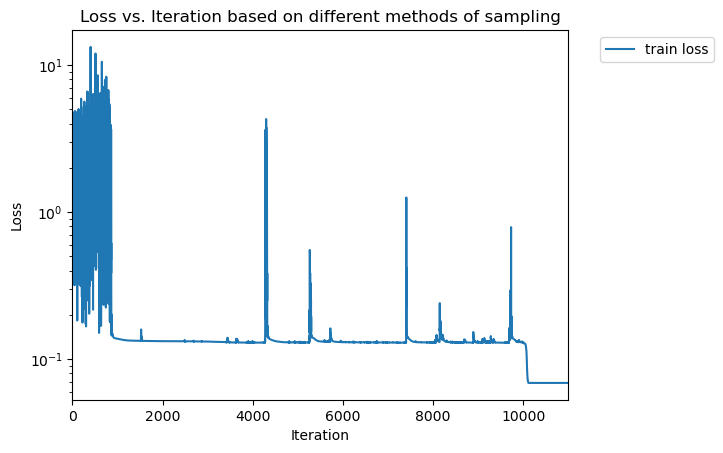

In [10]:
print(len(trainloss))
# print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,len(trainloss)]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

11000


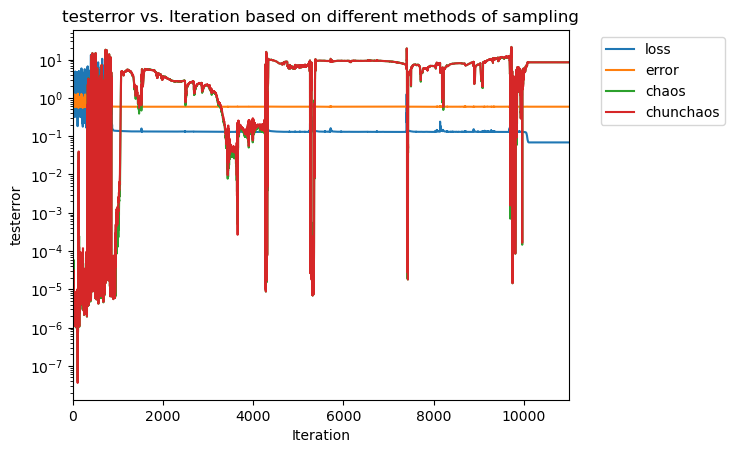

In [11]:
print(len(testerror))
# print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='loss')
plt.plot(testerror, label='error')
plt.plot(chaos, label='chaos')
plt.plot(chunchaos, label='chunchaos')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,len(trainloss)]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('testerror') # 设置y轴的标签
plt.title('testerror vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

11000


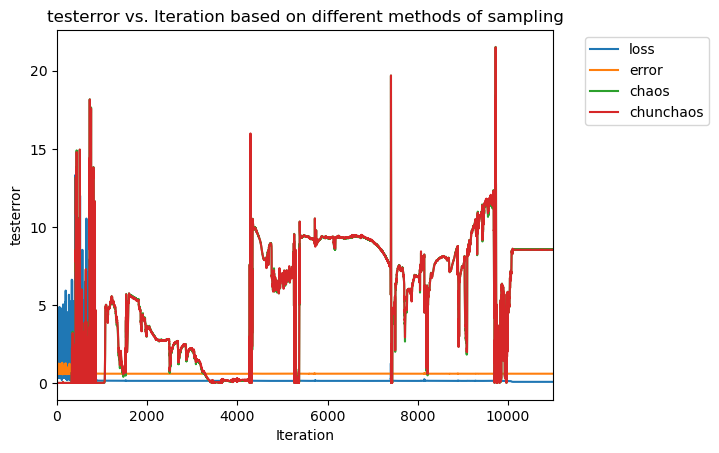

In [12]:
print(len(testerror))
# print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='loss')
plt.plot(testerror, label='error')
plt.plot(chaos, label='chaos')
plt.plot(chunchaos, label='chunchaos')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,len(trainloss)]) # 设置x轴的范围
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('testerror') # 设置y轴的标签
plt.title('testerror vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

In [13]:
np.savez('formersunshimy_training_data.npz', 
         trainloss=trainloss, 
         testerror=testerror, 
         chunchaos=chunchaos,
         chaos=chaos)

print("数据已保存到 formersunshimy_training_data.npz 文件中。")

数据已保存到 formersunshimy_training_data.npz 文件中。


In [14]:
import numpy as np

# 加载数据
data = np.load('formersunshimy_training_data.npz')

# 通过保存时使用的键名来访问每个数组
loaded_loss = data['trainloss']
loaded_error = data['testerror']
loaded_chaos = data['chaos']
loaded_chunchaos = data['chunchaos']

print("加载的训练损失数据长度:", len(loaded_loss))
print("加载的测试误差数据长度:", len(loaded_error))

# 现在你可以用加载的数据进行绘图或分析了

加载的训练损失数据长度: 11000
加载的测试误差数据长度: 11000


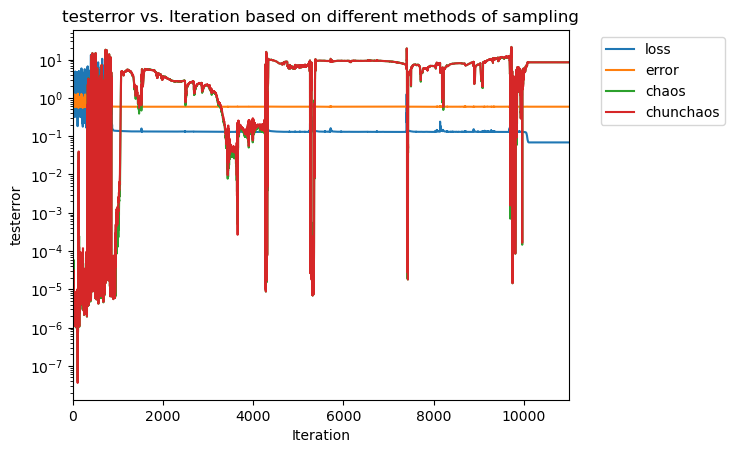

In [15]:
# print(len(testerror))
# print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(loaded_loss, label='loss')
plt.plot(loaded_error, label='error')
plt.plot(loaded_chaos, label='chaos')
plt.plot(loaded_chunchaos, label='chunchaos')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,len(loaded_loss)]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('testerror') # 设置y轴的标签
plt.title('testerror vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

In [16]:
loaded_error[-1]

0.5903483544593204